#Pronostico de la evolución de casos activos de SARS-CoV-2 en Colombia

##Equipo de trabajo: covid-19-analitica-predictiva-un

###Integrantes:

* Andres Molina Escobar
* Juan Camilo Gallón Tobon
* Natalia Jaramillo Agudelo
* Maria Isabel Londoño Urrea

##Objetivo

El objetivo de este proyecto es la predicción de corto y mediano plazo de el total de casos confirmados, los nuevos casos, los casos activos, recuperados y muertes para las 5 principales ciudades de Colombia, utilizando técnicas estadísticas, de inteligencia artificial o modelos híbridos.


##1. Definición del problema

De acuerdo a la [página oficial](https://www.minsalud.gov.co/salud/publica/PET/Paginas/Covid-19_copia.aspx) del ministerio de salud y protección social de Colombia: 
> "*los coronavirus (CoV) son virus que surgen periódicamente en diferentes áreas del mundo y que causan Infección Respiratoria Aguda (IRA), es decir gripa, que pueden llegar a ser leve, moderada o grave*"

El COVID - 19 ha sido catalogado por la Organización Mundial de la Salud como emergencia en salud pública de importancia internacinoal (ESPII). El primer caso confirmado en Colombia se dió el 6 de Marzo del año 2020 y el virus ha traído consigo consecuencias negativas para el país, ya que han sido necesarias medidas gubernamentales como la cuarentena para evitar una emergencia sanitaria mayor. Dicha medida, implicó extraer un grupo de empleados formales e informales de los distintos sectores y entidades territoriales del país, que de acuerdo con un estudio del Banco de la Republica disponible [aquí](https://repositorio.banrep.gov.co/bitstream/handle/20.500.12134/9843/DTSERU_288.pdf) sobre el impacto económico regional del Covid-19 en Colombia, podría ocasionar
>"*pérdidas económicas que varían entre 4,6 billones de pesos y 59 billones de pesos por mes de acuerdo con los escenarios de aislamiento considerados, cifras que representan entre 0,5% y 6,1% del PIB nacional. La rama económica de servicios aparece como la más afectada, donde se destacan las actividades de alojamiento y servicios de comida, servicios inmobiliarios, servicios administrativos, actividades profesionales y técnicas, construcción y comercio.*"

Lo anterior ejemplifica uno de los aspectos afectados por la epidemia, sin mencionar las implicaciones que tendría un posible colapso del sistema de salud debida a la alta tasa de contagio, lo que deja en evidencia, la importancia de contar con cifras que permitan plantear posibles escenarios para formular diferentes planes de acción y tomar decisiones de manera temprana.

##2. Definición del problema de analítica

Teniendo en cuenta la sección anterior en la que se define el problema, se plantea el siguiente problema de analítica: 

> La obtención de un modelo a corto plazo y otro a largo plazo para pronosticar la evolución de los casos confirmados, los recuperados y los muertos para las 5 principales ciudades de Colombia.

##3. Datos 

Para la obtención de los modelos de corto y largo plazo,  para pronosticar la evlolución de los casos confirmados, los recuperados y los muertos para las 5 principales ciudades de Colombia, se utiliza la información disponible en la página [www.datos.gov.co](https://www.datos.gov.co/)

###3.1. Carga y limpieza de datos

Se realizó el cargue de la información mediante una API para considerar la información más reciente al ejectuar el código.

En esta sección se realizan algunos ajustes a la base de datos para realizar un análisis descriptivo inicial de la misma.

In [1]:
#Instalación de los paquetes necesarios para conectar a la fuente de los datos medidante una API
!pip install sodapy
!pip install pmdarima

In [2]:
import warnings
warnings.filterwarnings("ignore")
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from scipy.integrate import odeint

In [3]:
socrata_domain = 'www.datos.gov.co'
socrata_dataset_identifier = "gt2j-8ykr"

socrata_token = 'AMwVkMOQwuVso3SEfNa4ArYR3'

client = Socrata(socrata_domain,
                  socrata_token,
                  username="amolinae@unal.edu.co",
                  password="Ilegal29*", timeout=30)

results = client.get(socrata_dataset_identifier, limit = 10000000)

In [4]:
#Se observan cuantos datos nos trajo el set de Datos.gov.co
df = pd.DataFrame.from_dict(results)
df.shape

(666521, 21)

In [5]:
#Visualizamos que columnas trae nuestro Set de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666521 entries, 0 to 666520
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   id_de_caso             666521 non-null  object
 1   fecha_de_notificaci_n  666521 non-null  object
 2   c_digo_divipola        666521 non-null  object
 3   ciudad_de_ubicaci_n    666521 non-null  object
 4   departamento           666521 non-null  object
 5   atenci_n               666521 non-null  object
 6   edad                   666521 non-null  object
 7   sexo                   666521 non-null  object
 8   tipo                   666521 non-null  object
 9   estado                 666521 non-null  object
 10  pa_s_de_procedencia    965 non-null     object
 11  fis                    666521 non-null  object
 12  fecha_diagnostico      662525 non-null  object
 13  fecha_recuperado       518234 non-null  object
 14  fecha_reporte_web      666521 non-null  object
 15  

In [6]:
#Se identifica que los valores vacios en la columan fis son referentes a los asintomaticos, por lo que se reemplza por dicho string.
df['fis'] = df['fis'].apply(lambda x: x.replace('Asintomático', ''))

In [7]:
#Se ajusta el formato de las fechas
df['fecha_diagnostico'] = pd.to_datetime(df['fecha_diagnostico'], errors='coerce')
df['fecha_de_muerte'] = pd.to_datetime(df['fecha_de_muerte'], errors='coerce')
df['fecha_recuperado'] = pd.to_datetime(df['fecha_recuperado'], errors='coerce')
df['fis'] = pd.to_datetime(df['fis'], errors='coerce')

In [8]:
df['fecha_recuperado'] = df['fecha_recuperado'].dt.strftime('%Y-%m-%d')
df['fecha_de_muerte'] = df['fecha_de_muerte'].dt.strftime('%Y-%m-%d')
df['fecha_diagnostico'] = df['fecha_diagnostico'].dt.strftime('%Y-%m-%d')
df['fis'] = df['fis'].dt.strftime('%Y-%m-%d')

In [9]:
df[['fecha_de_notificaci_n', 
    'fecha_diagnostico', 
    'fecha_recuperado', 
    'fecha_reporte_web', 
    'fecha_de_muerte',
    'fis']] = df[['fecha_de_notificaci_n', 
                  'fecha_diagnostico', 
                  'fecha_recuperado', 
                  'fecha_reporte_web', 
                  'fecha_de_muerte',
                  'fis']].apply(pd.to_datetime)

In [10]:
#Se identifican las ciudades principales
principales = ['Bogotá D.C.', 'Medellín', 'Barranquilla', 'Cali', 'Cartagena de Indias']

df_principales = df[df['ciudad_de_ubicaci_n'].isin(principales)]
df_principales.shape

(374478, 21)

In [11]:
df_principales = df_principales.drop(columns=['fecha_de_notificaci_n',
                                               'c_digo_divipola',
                                               'departamento', 
                                               'fecha_reporte_web', 
                                               'codigo_departamento',
                                               'codigo_pais',
                                               'pertenencia_etnica',
                                               'nombre_grupo_etnico'])

In [12]:
#Se transforman los datos de la columna Sexo, para que queden con formato mayúscula. 
df_principales['sexo'] = df_principales['sexo'].apply(lambda x: x.upper())

In [13]:
#Se observan la cantidad de casos por estado y tip ode atención
print(df_principales['estado'].value_counts(normalize=True).apply(lambda x: x*100))
print(df_principales['atenci_n'].value_counts(normalize=True).apply(lambda x: x*100))

Leve            74.154957
Asintomático    19.917058
Fallecido        2.773194
Moderado         2.659168
Grave            0.304424
N/A              0.191199
Name: estado, dtype: float64
Recuperado      78.358141
Casa            17.330257
Fallecido        2.773194
Hospital         1.252410
N/A              0.175177
Hospital UCI     0.110821
Name: atenci_n, dtype: float64


In [14]:
#Se crea un nuevo df sin los N/A en la columna atención
df_principales_clean = df_principales[df_principales['atenci_n'] != 'N/A'] 

In [15]:
##Validacion coherencia entre estado y grupo de atencion
df_principales_clean.groupby(['estado', 'atenci_n'])['id_de_caso'].count()

estado        atenci_n    
Asintomático  Casa             33018
              Hospital           132
              Hospital UCI        79
              Recuperado       41293
Fallecido     Fallecido        10385
Grave         Hospital UCI       336
              Recuperado         804
Leve          Casa             31880
              Recuperado      245814
Moderado      Hospital          4558
              Recuperado        5400
N/A           Recuperado         123
Name: id_de_caso, dtype: int64

In [16]:
#Se crea una función para homolgar únicamente 3 grupos de atención
def agrupacion_atencion(x):
  activo = ['Casa', 'Hospital', 'Hospital UCI']
  if x in activo:
    valor = 'activo'
  elif x == 'Fallecido':
    valor = 'fallecido'
  else:
    valor = 'recuperado'
  return valor 

In [17]:
##Se agrega columna con el grupo de atencion
df_principales_clean['grupo_atencion'] = df_principales_clean['atenci_n'].apply(lambda x: agrupacion_atencion(x))

##La variable edad se convierte a tipo integer
df_principales_clean['edad'] = df_principales_clean['edad'].astype('int')

##Se cambia el nombre de las variables para un uso mas sencillo de estas
df_principales_clean.columns=["idCaso",
                               "ciudadUbicacion",
                               "atencion",
                               "edad",
                               "sexo",
                               "tipo",
                               "estado",
                               "paisProcedencia",
                               "fechaInicioSintomas",
                               "fechaDiagnostico",
                               "fechaRecuperacion",
                               "tipoRecuperacion",
                               "fechaMuerte",
                               "grupoAtencion"]


In [18]:
#Se homologa el fomato en tipo
df_principales_clean["tipo"]=df_principales_clean["tipo"].apply(
    lambda x: x.replace("RELACIONADO", 
                        "Relacionado"))

In [19]:
##Se copia el data frame entre BaseCovid para el inicio de las estadisticas descriptivas
BaseCovid = df_principales_clean.copy()

###Análisis descriptivo

Inicialmente se realiza un análisis descriptivo para entender mejor nuestros datos, sin embargo en la sección "**Despliegue de los resultados**" se encuentra el producto de datos en el que se realiza un resumen de los mismos.

In [20]:
##Cantidad de casos positivos:
print("Al día de hoy se tienen ",BaseCovid["idCaso"].count()," casos registrados")

Al día de hoy se tienen  373822  casos registrados


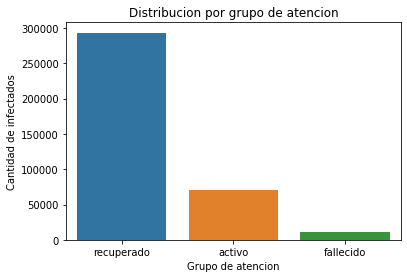

In [21]:
#Distribucion entre recuperado, activo y fallecido

g = sns.countplot(x='grupoAtencion',
                  data=BaseCovid,
                  order=['recuperado', 'activo', 'fallecido'])

plt.title('Distribucion por grupo de atencion')
g.set(ylabel = 'Cantidad de infectados',
      xlabel = 'Grupo de atencion')

plt.show()

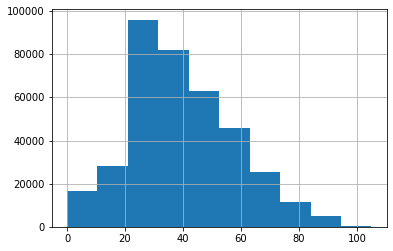

In [22]:
#Distribución de los casos por edad
BaseCovid['edad'].hist()

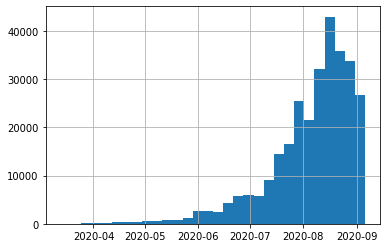

In [23]:
#Distribución de los casos por fecha de recuperación
BaseCovid['fechaRecuperacion'].hist(bins=30) 

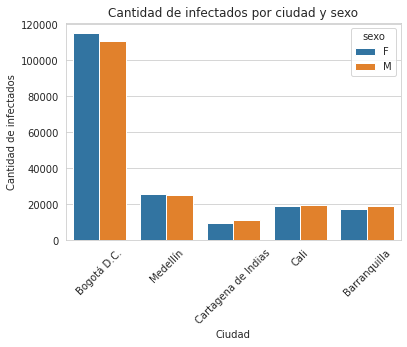

In [24]:
#Cantidad de infectados por ciudad y sexo
sns.set_style('whitegrid')

g = sns.countplot(x='ciudadUbicacion',
              data=BaseCovid,
              hue='sexo')

plt.xticks(rotation=45)
plt.title('Cantidad de infectados por ciudad y sexo')
g.set(ylabel="Cantidad de infectados",
      xlabel="Ciudad")

plt.show()

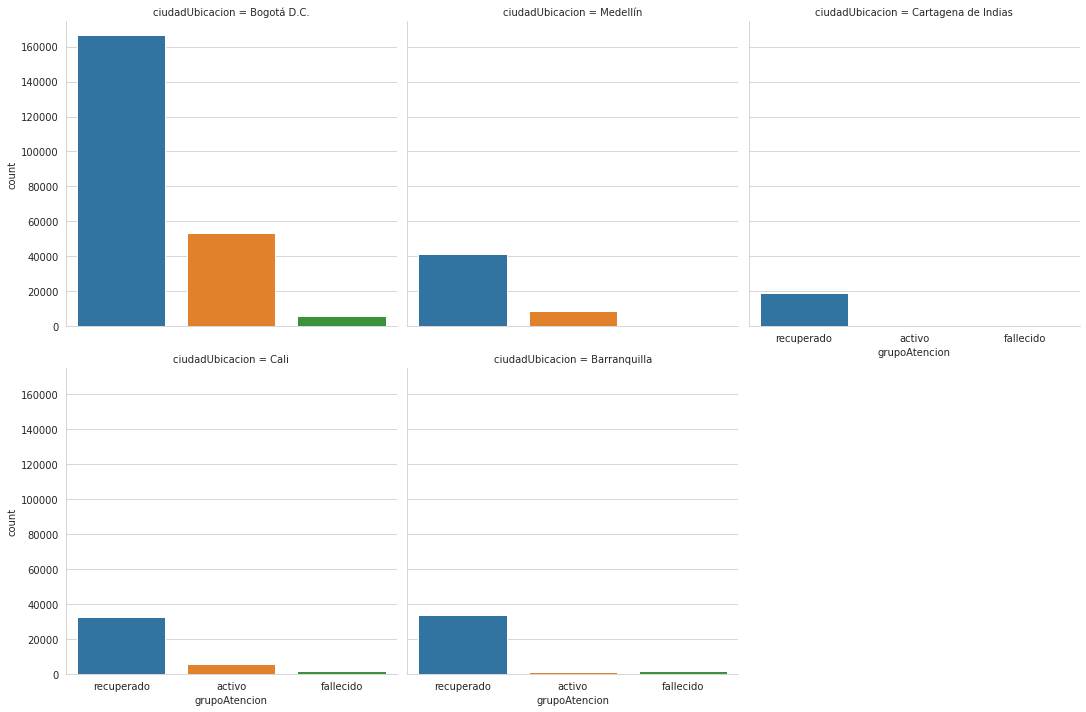

In [25]:
#Grupo de atención por ciudad
g = sns.catplot(x='grupoAtencion',
            data=BaseCovid,
            order=['recuperado', 'activo', 'fallecido'],
            col='ciudadUbicacion',
            kind='count',
            col_wrap=3)

g.fig.suptitle(None)

plt.show()

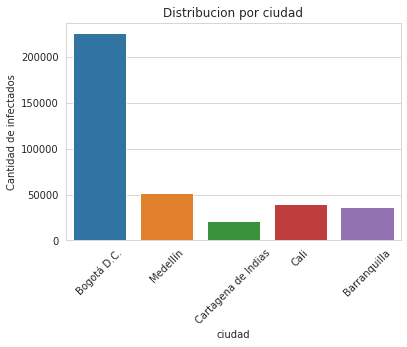

In [26]:
#Cantidad de infectados por ciudad
g = sns.countplot(x='ciudadUbicacion',
                  data=BaseCovid,)
plt.xticks(rotation=45)
plt.title('Distribucion por ciudad')
g.set(ylabel = 'Cantidad de infectados',
      xlabel = 'ciudad')

plt.show()

### Transformación de datos

En este punto se hace neceario ajustar nuevamente la base de datos dado que es necesario contar con los casos acumulados por día y no los casos diarios independientes, adicinal de construir los data frames con únicamente las columnas necesarias para los posteriores modelos.

Se asigna una nueva fecha real diagnostico a los casos en que el estado es asintomático para que todos cuenten con fecha

In [27]:

BaseCovid['fechaRealDiag'] = np.where(BaseCovid['estado'] == 'Asintomático', 
                                      BaseCovid['fechaDiagnostico'], BaseCovid['fechaInicioSintomas'])

Se construye un nuevo data frame para los Infectados

In [28]:
baseInfectados = BaseCovid[['idCaso', 'ciudadUbicacion', 'fechaRealDiag']].groupby(['fechaRealDiag', 'ciudadUbicacion'], as_index=False)['idCaso'].count()
baseInfectados.rename(columns={'idCaso': 'infectados'}, inplace=True)
baseInfectados.tail()

,fechaRealDiag,ciudadUbicacion,infectados
912,2020-09-04,Cartagena de Indias,2
913,2020-09-04,Medellín,18
914,2020-09-05,Barranquilla,1
915,2020-09-05,Bogotá D.C.,190
916,2020-09-05,Medellín,2


Se construye un nuevo dataframe para los recuperados

In [29]:
baseRecuperados = BaseCovid[['idCaso', 'ciudadUbicacion', 'fechaRecuperacion']].groupby(['fechaRecuperacion', 'ciudadUbicacion'], as_index=False)['idCaso'].count()
baseRecuperados.rename(columns={'idCaso': 'recuperados'}, inplace=True)
baseRecuperados.head()

,fechaRecuperacion,ciudadUbicacion,recuperados
0,2020-03-13,Bogotá D.C.,1
1,2020-03-14,Bogotá D.C.,1
2,2020-03-15,Medellín,1
3,2020-03-17,Cartagena de Indias,1
4,2020-03-20,Bogotá D.C.,1


Se construye un nuevo dataframe para los Muertos

In [30]:
baseMuertos = BaseCovid[['idCaso', 'ciudadUbicacion', 'fechaMuerte']].groupby(['fechaMuerte', 'ciudadUbicacion'], as_index=False)['idCaso'].count()
baseMuertos.rename(columns={'idCaso': 'muertos'}, inplace=True)
baseMuertos.head()

,fechaMuerte,ciudadUbicacion,muertos
0,2020-03-16,Cartagena de Indias,1
1,2020-03-25,Bogotá D.C.,1
2,2020-03-25,Cali,2
3,2020-03-26,Bogotá D.C.,2
4,2020-03-27,Cartagena de Indias,1


In [31]:
#Se realiza un merge, en el cual se tienen los datos de Infectados, recuperados y muertos. 
covid_1 = pd.merge(baseInfectados, baseRecuperados, 
                 how='outer', 
                 left_on=['fechaRealDiag',	'ciudadUbicacion'], 
                 right_on=['fechaRecuperacion',	'ciudadUbicacion'])
covid = pd.merge(covid_1, baseMuertos, 
                 how='outer', 
                 left_on=['fechaRealDiag',	'ciudadUbicacion'], 
                 right_on=['fechaMuerte',	'ciudadUbicacion'])
##covid.drop(columns=['fechaRecuperacion', 'fechaMuerte'])

In [32]:
covid.tail(20)

,fechaRealDiag,ciudadUbicacion,infectados,fechaRecuperacion,recuperados,fechaMuerte,muertos
911,2020-09-04,Cali,10.0,2020-09-04,296.0,2020-09-04,9.0
912,2020-09-04,Cartagena de Indias,2.0,2020-09-04,155.0,2020-09-04,1.0
913,2020-09-04,Medellín,18.0,2020-09-04,1497.0,2020-09-04,11.0
914,2020-09-05,Barranquilla,1.0,2020-09-05,238.0,NaT,NaN
915,2020-09-05,Bogotá D.C.,190.0,2020-09-05,3318.0,2020-09-05,35.0
916,2020-09-05,Medellín,2.0,2020-09-05,690.0,2020-09-05,11.0
917,NaT,Barranquilla,NaN,2020-03-31,1.0,NaT,NaN
918,NaT,Barranquilla,NaN,2020-04-08,4.0,NaT,NaN
919,NaT,Barranquilla,NaN,2020-09-06,179.0,NaT,NaN
920,NaT,Medellín,NaN,2020-04-30,2.0,NaT,NaN


In [33]:
#Se hace necesario agregar una nueva columan en la que se registre la fecha unificada de los registros
covid['fecha'] = np.where(covid['infectados'] > 0,
                          covid['fechaRealDiag'], np.where(covid['recuperados'] > 0,
                                                           covid['fechaRecuperacion'], covid['fechaMuerte']))

In [34]:
#Teniendo la columna fecha, procedemos a eliminar las demás columnas de fecha. 
covid.drop(columns=['fechaRecuperacion', 'fechaMuerte', 'fechaRealDiag'], inplace=True)

In [35]:
#Ponemos cero en los datos que tengan Nan
covid.fillna(0, inplace=True)
covid.sort_values(by=['ciudadUbicacion', 'fecha'])

,ciudadUbicacion,infectados,recuperados,muertos,fecha
12,Barranquilla,2.0,0.0,0.0,2020-03-06
20,Barranquilla,2.0,0.0,0.0,2020-03-09
24,Barranquilla,2.0,0.0,0.0,2020-03-10
32,Barranquilla,2.0,0.0,0.0,2020-03-12
37,Barranquilla,2.0,0.0,0.0,2020-03-13
...,...,...,...,...,...
908,Medellín,32.0,594.0,10.0,2020-09-03
913,Medellín,18.0,1497.0,11.0,2020-09-04
916,Medellín,2.0,690.0,11.0,2020-09-05
921,Medellín,0.0,1289.0,0.0,2020-09-06


In [36]:
#Se construye la base con los infectados, recuperados y muertos acumulados a la fecha.
covid = covid.groupby(['fecha', 'ciudadUbicacion'], as_index=False)['infectados', 'recuperados', 'muertos'].sum()

In [37]:
# Ciudades principales
principales = ['Bogotá D.C.', 'Medellín', 'Barranquilla', 'Cali', 'Cartagena de Indias']
list_of_df = []

# Loop sobre todas las ciudades para agregar el valor acumulado de infectados, recuperados, muertos
print(" --- Loop sobre cada ciudad --- ")
for i in principales:
    print("Se agrega columnas por cada una de las ciudades " + i)
    temp_df = covid[covid["ciudadUbicacion"] == i].copy()  # hacer copia del dataframe para asegurar que no se afecta el df original
    temp_df["infectadosTotales"] =  temp_df["infectados"].cumsum()
    temp_df["recuperadosTotales"] =  temp_df["recuperados"].cumsum()
    temp_df["muertosTotales"] =  temp_df["muertos"].cumsum()
    list_of_df.append(temp_df)

print(" --- Ciclo completado --- ")

covidTotales = pd.concat(list_of_df, )

 --- Loop sobre cada ciudad --- 
Se agrega columnas por cada una de las ciudades Bogotá D.C.
Se agrega columnas por cada una de las ciudades Medellín
Se agrega columnas por cada una de las ciudades Barranquilla
Se agrega columnas por cada una de las ciudades Cali
Se agrega columnas por cada una de las ciudades Cartagena de Indias
 --- Ciclo completado --- 


In [38]:
# Se ajusta el formato de la columan fecha
covidTotales['fecha'] = covidTotales['fecha'].apply(pd.to_datetime)

In [39]:
##Se retiran de la base los dos ultimos dias, por delay en la informacion de pruebas, se ajusta la base para contrarestar un poco este efecto
##reduciendo dos dias a la base.
from datetime import datetime, timedelta
today=datetime.today()+timedelta(days=-2)
covidTotales = covidTotales[covidTotales['fecha'] <= today]

In [40]:
covidTotales.tail(10)

,fecha,ciudadUbicacion,infectados,recuperados,muertos,infectadosTotales,recuperadosTotales,muertosTotales
875,2020-08-27,Cartagena de Indias,22.0,308.0,0.0,20812.0,18003.0,526.0
880,2020-08-28,Cartagena de Indias,34.0,96.0,1.0,20846.0,18099.0,527.0
885,2020-08-29,Cartagena de Indias,9.0,76.0,0.0,20855.0,18175.0,527.0
890,2020-08-30,Cartagena de Indias,10.0,127.0,1.0,20865.0,18302.0,528.0
895,2020-08-31,Cartagena de Indias,7.0,165.0,2.0,20872.0,18467.0,530.0
900,2020-09-01,Cartagena de Indias,6.0,77.0,2.0,20878.0,18544.0,532.0
905,2020-09-02,Cartagena de Indias,3.0,63.0,1.0,20881.0,18607.0,533.0
910,2020-09-03,Cartagena de Indias,3.0,201.0,2.0,20884.0,18808.0,535.0
915,2020-09-04,Cartagena de Indias,2.0,155.0,1.0,20886.0,18963.0,536.0
920,2020-09-05,Cartagena de Indias,0.0,191.0,0.0,20886.0,19154.0,536.0


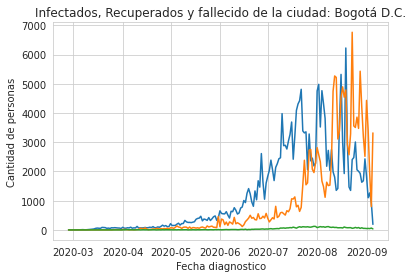

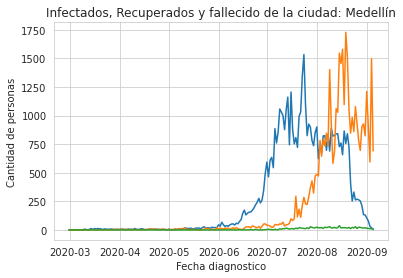

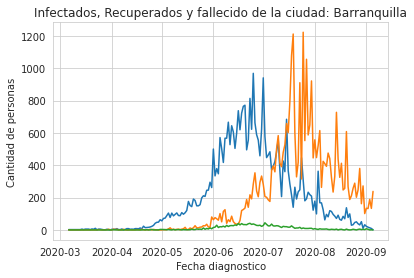

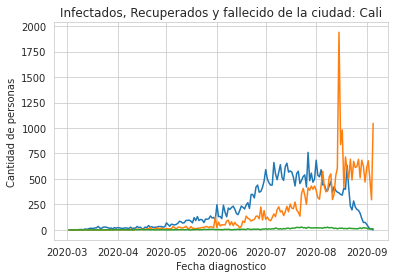

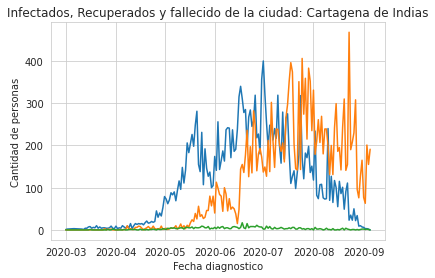

In [41]:
#Se grafican la cantidad de infectados, recuperados y muertos por ciudad
for ciudad in principales:
  plt.plot(covidTotales['fecha'][covidTotales['ciudadUbicacion']==ciudad], covidTotales['infectados'][covidTotales['ciudadUbicacion']==ciudad])
  plt.plot(covidTotales['fecha'][covidTotales['ciudadUbicacion']==ciudad], covidTotales['recuperados'][covidTotales['ciudadUbicacion']==ciudad])
  plt.plot(covidTotales['fecha'][covidTotales['ciudadUbicacion']==ciudad], covidTotales['muertos'][covidTotales['ciudadUbicacion']==ciudad])
  plt.title('Infectados, Recuperados y fallecido de la ciudad: ' + ciudad)
  plt.xlabel('Fecha diagnostico')
  plt.ylabel('Cantidad de personas')
  plt.show()

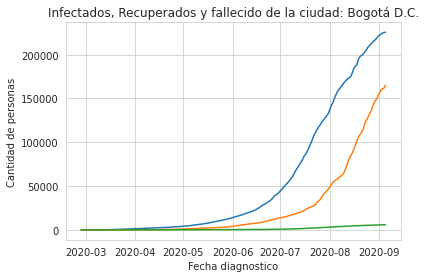

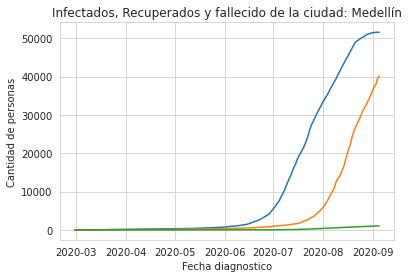

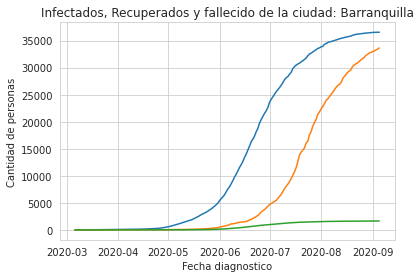

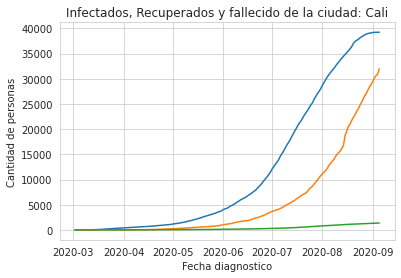

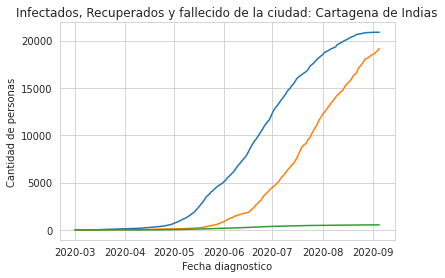

In [42]:
#Se grafican la cantidad de infectados, recuperados y muertos acumulados por ciudad
for ciudad in principales:
  plt.plot(covidTotales['fecha'][covidTotales['ciudadUbicacion']==ciudad], covidTotales['infectadosTotales'][covidTotales['ciudadUbicacion']==ciudad])
  plt.plot(covidTotales['fecha'][covidTotales['ciudadUbicacion']==ciudad], covidTotales['recuperadosTotales'][covidTotales['ciudadUbicacion']==ciudad])
  plt.plot(covidTotales['fecha'][covidTotales['ciudadUbicacion']==ciudad], covidTotales['muertosTotales'][covidTotales['ciudadUbicacion']==ciudad])
  plt.title('Infectados, Recuperados y fallecido de la ciudad: ' + ciudad)
  plt.xlabel('Fecha diagnostico')
  plt.ylabel('Cantidad de personas')
  plt.show()

##4. Metodología propuesta

En este proyecto se seleccionó la metodología CRISP-DM con el fin de:

1. Mejorar la planeación, desarrollo y ejecución del proyecto.
2. Implementar mejores prácticas para realizar de manera sistémica, la analítica de los datos. 
3. Evitar resultados indeseables en el proceso tales como aprender cosas que no son ciertas o no tienen validez o cosas que aunque ciertas, no son útiles.

La metodología consta de los siguientes pasos: 

> * La comprensión del negocio (En nuestro caso la comprensión del problema) 
> * La comprensión de los datos
> * Preparación de los datos
> * Modelado
> * Evaluación
> * Despliegue

A continuación se enlista cada paso de la metodología con su sección correspondiente dentro del presente documento y una breve descripción


Paso metodología | Sección desarrollo | Descripción |
--- | --- | --- | 
Comprensión del negocio | Definición del problema y Definición del problema de analítica | Se evalua de forma breve la situación actual y se establece el problema <br/><br/>de analítica | 
Comprensión de los datos | Datos | Se realiza el cargue de los datos, la exploración de los mismos, <br/><br/> la verificación de su calidad y se elaboran algunos modelos descriptivos | 
Preparación de los datos | Transformación de los datos | Se seleccionan y limpian los datos, se construyen nuevas variables, se<br/><br/> exploran los datos a mayor profundidad | 
Modelado | Desarrollo de los modelos | Con el propósito de estimación se plantean modelos de regresión y el<br/><br/> modelo SIR | 
Evaluación | Desarrollo de los modelos | Se plantean las métricas para comparar los modelos y seleccionar el<br/><br/> más apropiado | 
Despligue | Despliegue de los resultados | Se presenta el producto de datos |

##5. Desarrollo de los modelos

###Series de tiempo infectados

Para encontrar el mejor modelo de infectados totales, se realizarán las pruebas en una ciudad particular y se asumirá que el virus se comporta de forma similar para las demás ciudades de colombia. Para el entrenamiento del modelo se utiliza el 100% de los datos, ya que al ser una serie de tiempo, las últimas observaciones son muy relevantes.

In [43]:
covidMedInfec = covidTotales[['fecha', 'infectadosTotales']][covidTotales['ciudadUbicacion'] == 'Medellín'].set_index('fecha')
covidBogInfec = covidTotales[['fecha', 'infectadosTotales']][covidTotales['ciudadUbicacion'] == 'Bogotá D.C.'].set_index('fecha')
covidBarInfec = covidTotales[['fecha', 'infectadosTotales']][covidTotales['ciudadUbicacion'] == 'Barranquilla'].set_index('fecha')
covidCalInfec = covidTotales[['fecha', 'infectadosTotales']][covidTotales['ciudadUbicacion'] == 'Cali'].set_index('fecha')
covidCarInfec = covidTotales[['fecha', 'infectadosTotales']][covidTotales['ciudadUbicacion'] == 'Cartagena de Indias'].set_index('fecha')

A continuación estudiaremos las gráficas AFC y PAFC para determinar el comportamiento y grados del modelo de series de Tiempo.

In [44]:
##Comprobacion de estacionalidad
adf_test = ADFTest(alpha=0.05)
print(adf_test.should_diff(covidMedInfec))
print(adf_test.should_diff(covidMedInfec.diff().dropna()))

(0.07997524753292748, True)
(0.9690186195751068, True)


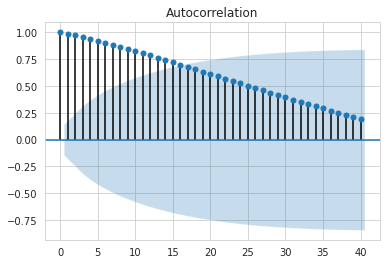

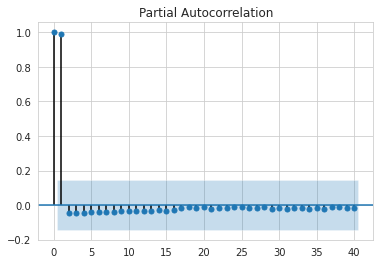

In [45]:
#Serie sin transformacion
sm.graphics.tsa.plot_acf(covidMedInfec.values.squeeze(), lags=40)
plt.show()
sm.graphics.tsa.plot_pacf(covidMedInfec.values.squeeze(), lags=40)
plt.show()

Realizamos las gráficas AFC y PAFC pero realizando una diferenciación Yt - Yt-1

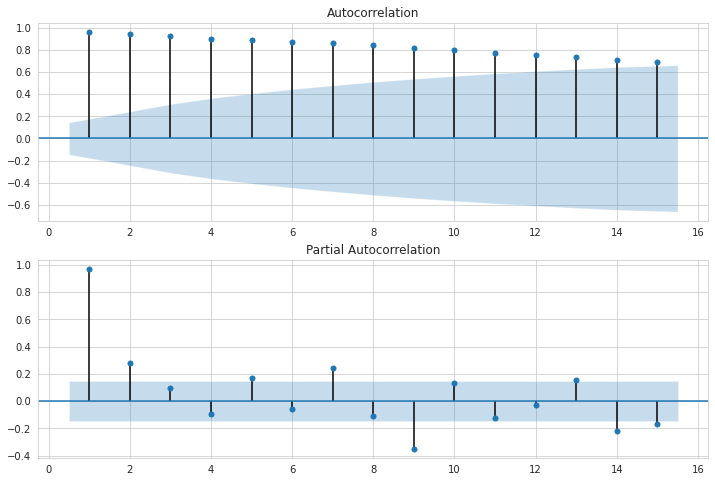

In [46]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
sm.graphics.tsa.plot_acf(covidMedInfec.diff().dropna(), lags=15, zero=False, ax=ax1)

# Plot the PACF of df
sm.graphics.tsa.plot_pacf(covidMedInfec.diff().dropna(), lags=15, zero=False, ax=ax2)

plt.show()

Revisando la grafica anterior se identifica que probalmente un modelo con un p entre (0-15) y un q entre (0-15), para identificar cual da un AIC mas bajo se modela con un for para recorrer todas las posibles combinaciones, con el fin de encontrar los mejores 5 y encontrar el que de la funcion de error mas baja.

Para encontrar los mejores parámetros p y q del modelo, se realiza un for que itera entre estos parámetros y nos devuelve un data frame con los mejores 5 modelos ordenado por AIC. Este proceso es lento ya que es necesarios crear y evaluar muchos modelos, para que no se corra cada vez que el archivo se ejecute, se realiza un condicional que compara unos p y q anteriormente establecidos y su AIC

In [47]:
##se realiza un if que determina si se necesita un cambio de modelo, usando unos valores p y q que previamente sacamos. 
#Si hay un crecimiento del 10% en el AIC para el modelo que previamente temnia menor AIC, esto nos indicaria que es necesario re escoger los mejores p y q
#El proceso del For es un poco lento

ordenesInf=[[6,8], [14,1], [8,5],[7,4],[14,2]]
aic1inf=2165.436528

model1Infectados = SARIMAX(covidMedInfec, order=(6,1,8))
results1Infectados = model1Infectados.fit()
aic1Infectados=results1Infectados.aic

if aic1Infectados >= (aic1inf*1.1):

  order_aic_bicInf = []

  for p in range(5,15):
    for q in range(1,15):
      try:
        model = SARIMAX(covidMedInfec, order=(p,1,q))
        results = model.fit()
        order_aic_bicInf.append((p,q, results.aic, results.bic))
      except:
        print(p, q, None, None)

  order_dfInf = pd.DataFrame(order_aic_bicInf, columns=['p','q', 'aic', 'bic'])
  order_dfInf = order_dfInf.sort_values(by='aic')
  order_dfInf = order_dfInf.head(5)
  
else:
  order_dfInf = pd.DataFrame(ordenesInf, columns=['p','q'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Par determinar cual de los 5 modelos anteriormente encontrados es mejor, se realiza una prueba de error cuadrático medio y se elije el modelo con menor error. Con este modelo se realizarán las predicciones

In [48]:
models_errorInf = []

for i, j in zip(order_dfInf['p'], order_dfInf['q']):
  model = SARIMAX(covidMedInfec, order=(i,1,j))
  results = model.fit()
  prediction = results.get_prediction(start=-25, dynamic=True)
  y_prediction = prediction.predicted_mean
  y_real = covidMedInfec.iloc[-25:]
  error = mean_squared_error(y_real, y_prediction)/100000 #se divide por 100 mil para una lectura mas facil del valor
  models_errorInf.append((i, j, error))

modelsInf = pd.DataFrame(models_errorInf, columns=['p','q', 'MSE'])
models_orderInf=modelsInf.sort_values(by='MSE').copy().head(1).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWa

Se procede a observar el comportamiento del pronóstico vs los últimos 25 días.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:      infectadosTotales   No. Observations:                  186
Model:              SARIMAX(14, 1, 1)   Log Likelihood               -1081.920
Date:                Mon, 07 Sep 2020   AIC                           2195.840
Time:                        13:54:15   BIC                           2247.366
Sample:                             0   HQIC                          2216.722
                                - 186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4835      0.167      8.900      0.000       1.157       1.810
ar.L2         -0.3799      0.151     -2.523      0.012      -0.675      -0.085
ar.L3         -0.0834      0.103     -0.809      0.4

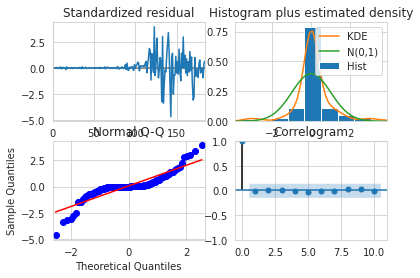

In [49]:
modelInfMed = SARIMAX(covidMedInfec, order=(models_orderInf.loc[0]['p'],1,models_orderInf.loc[0]['q'])).fit()
print(modelInfMed.summary())

modelInfMed.plot_diagnostics()
plt.show()

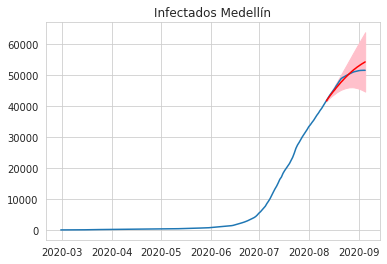

In [109]:
prediction = modelInfMed.get_prediction(start=-25, dynamic=True)
mean_prediction = prediction.predicted_mean
confidence_intervals = prediction.conf_int()

lower_limits = confidence_intervals.loc[:,'lower infectadosTotales']
upper_limits = confidence_intervals.loc[:,'upper infectadosTotales']

plt.plot(covidMedInfec.index, covidMedInfec)
plt.plot(mean_prediction.index, mean_prediction, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.title('Infectados Medellín')
plt.show()

Como se observa en la gráfica anterior, el modelo se comprota similar a la realidad, con unos intervalos de confianza que permiten tomar decisiones según las necesidades de la ciudad Sacamos el MAE para determinar si el pronostico tiene un buen comportamiento vs el real.

In [51]:
mae = np.mean(np.abs(modelInfMed.resid))
mae

42.91369230648684

Luego, procedemos a pronosticar 25 días hacia adelante y luego gráficamos nuestros resultados.

In [52]:
predicted_summary = modelInfMed.get_forecast(steps=25, dynamic=True).summary_frame()

predicted_summary = predicted_summary.set_index(pd.date_range(today + timedelta(days=1), periods=25, normalize=True))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


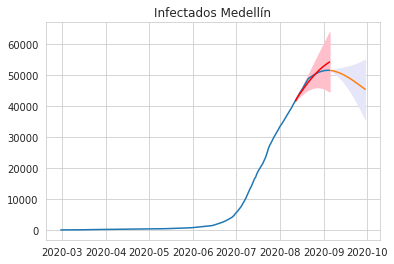

In [110]:
prediction = modelInfMed.get_prediction(start=-25, dynamic=True)

mean_prediction = prediction.predicted_mean
confidence_intervals = prediction.conf_int()

lower_limits = confidence_intervals.loc[:,'lower infectadosTotales']
upper_limits = confidence_intervals.loc[:,'upper infectadosTotales']

lower_limits_p = predicted_summary.loc[:,'mean_ci_lower']
upper_limits_p = predicted_summary.loc[:,'mean_ci_upper']

plt.plot(covidMedInfec.index, covidMedInfec)
plt.plot(predicted_summary.index, predicted_summary['mean'])
plt.plot(mean_prediction.index, mean_prediction, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.fill_between(lower_limits_p.index, lower_limits_p, upper_limits_p, color='lavender')
plt.title('Infectados Medellín')
plt.show()

Observando que el modelo se ajusta bien al pronóstico, procedemos a crear una función que nos arroje el pronóstico y los datos de interés según la ciudad que decidamos.

In [54]:
#definir funcion 
def fn_prediccion(df, p, q, ciudad):
  modelF = SARIMAX(df, order=(p,1,q)).fit()
  modelF.plot_diagnostics()
  print(modelF.summary())
  mae = np.mean(np.abs(modelF.resid))
  print('El mae es igual a: ' +str(round(mae, 2)))
  plt.show()
  #predicciones
  prediction = modelF.get_prediction(start=-10, dynamic=True)

  predicted_summary = modelF.get_forecast(steps=25).summary_frame()

  predicted_summary = predicted_summary.set_index(pd.date_range(today + timedelta(days=1), periods=25, normalize=True))
  predicted_summary

  mean_prediction = prediction.predicted_mean
  confidence_intervals = prediction.conf_int()

  lower_limits = confidence_intervals.loc[:,'lower infectadosTotales']
  upper_limits = confidence_intervals.loc[:,'upper infectadosTotales']

  lower_limits_p = predicted_summary.loc[:,'mean_ci_lower']
  upper_limits_p = predicted_summary.loc[:,'mean_ci_upper']

  plt.plot(df.index, df)
  plt.plot(predicted_summary.index, predicted_summary['mean'])
  plt.plot(mean_prediction.index, mean_prediction, color='r', label='forecast')
  plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
  plt.fill_between(lower_limits_p.index, lower_limits_p, upper_limits_p, color='lavender')
  plt.title('Infectados '+ ciudad)
  plt.show()

Modelo predictivo para la ciudad de Bogotá

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:      infectadosTotales   No. Observations:                  189
Model:              SARIMAX(14, 1, 1)   Log Likelihood               -1458.518
Date:                Mon, 07 Sep 2020   AIC                           2949.036
Time:                        13:54:19   BIC                           3000.819
Sample:                             0   HQIC                          2970.017
                                - 189                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5042      1.044      0.483      0.629      -1.542       2.550
ar.L2         -0.0270      0.584     -0.046      0.963      -1.172       1.118
ar.L3          0.2390      0.081      2.948      0.0

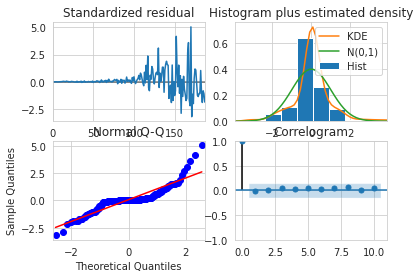

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


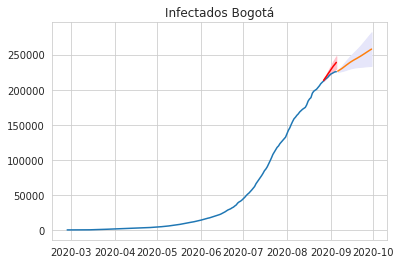

In [55]:
fn_prediccion(covidBogInfec, models_orderInf.loc[0]['p'], models_orderInf.loc[0]['q'], "Bogotá")

Modelo predictivo para la ciudad de Cali

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:      infectadosTotales   No. Observations:                  184
Model:              SARIMAX(14, 1, 1)   Log Likelihood                -990.818
Date:                Mon, 07 Sep 2020   AIC                           2013.636
Time:                        13:54:22   BIC                           2064.987
Sample:                             0   HQIC                          2034.451
                                - 184                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0754      0.401      0.188      0.851      -0.710       0.861
ar.L2          0.3283      0.170      1.933      0.053      -0.005       0.661
ar.L3          0.2084      0.088      2.367      0.0

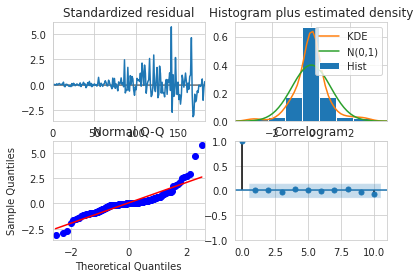

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


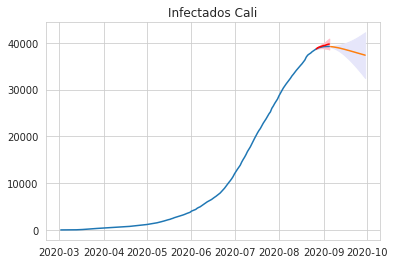

In [56]:
fn_prediccion(covidCalInfec, models_orderInf.loc[0]['p'], models_orderInf.loc[0]['q'], "Cali")

Modelo predictivo para la ciudad de Cartagena.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:      infectadosTotales   No. Observations:                  182
Model:              SARIMAX(14, 1, 1)   Log Likelihood                -931.481
Date:                Mon, 07 Sep 2020   AIC                           1894.962
Time:                        13:54:24   BIC                           1946.138
Sample:                             0   HQIC                          1915.710
                                - 182                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1326      0.431      0.308      0.758      -0.713       0.978
ar.L2          0.3051      0.183      1.667      0.095      -0.054       0.664
ar.L3          0.1858      0.127      1.462      0.1

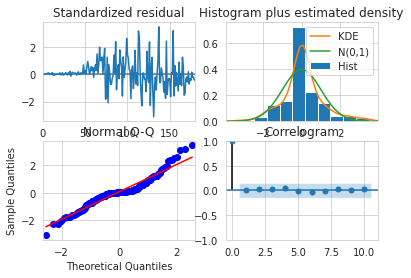

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


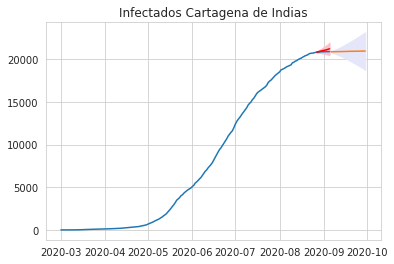

In [57]:
fn_prediccion(covidCarInfec, models_orderInf.loc[0]['p'], models_orderInf.loc[0]['q'], "Cartagena de Indias")

Moedelo predictivo para la ciudad de Barranquilla

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:      infectadosTotales   No. Observations:                  181
Model:              SARIMAX(14, 1, 1)   Log Likelihood               -1036.736
Date:                Mon, 07 Sep 2020   AIC                           2105.472
Time:                        13:54:27   BIC                           2156.560
Sample:                             0   HQIC                          2126.186
                                - 181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3784      1.463      0.259      0.796      -2.490       3.246
ar.L2          0.1381      0.492      0.281      0.779      -0.826       1.102
ar.L3          0.0347      0.241      0.144      0.8

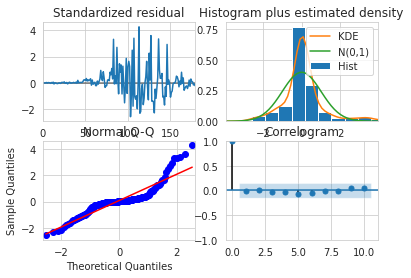

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


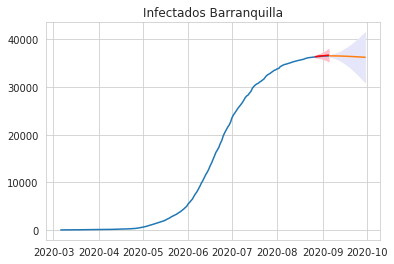

In [58]:
fn_prediccion(covidBarInfec, models_orderInf.loc[0]['p'], models_orderInf.loc[0]['q'], "Barranquilla")

Modelo predictivo para la ciudad de Medellín

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:      infectadosTotales   No. Observations:                  186
Model:              SARIMAX(14, 1, 1)   Log Likelihood               -1081.920
Date:                Mon, 07 Sep 2020   AIC                           2195.840
Time:                        13:54:31   BIC                           2247.366
Sample:                             0   HQIC                          2216.722
                                - 186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4835      0.167      8.900      0.000       1.157       1.810
ar.L2         -0.3799      0.151     -2.523      0.012      -0.675      -0.085
ar.L3         -0.0834      0.103     -0.809      0.4

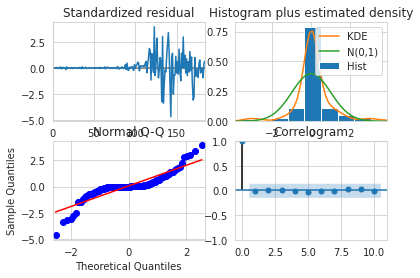

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


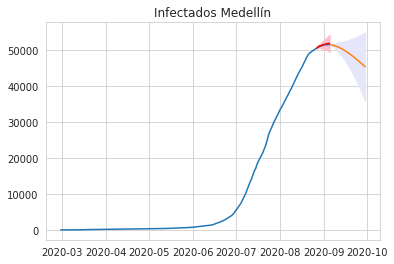

In [59]:
fn_prediccion(covidMedInfec, models_orderInf.loc[0]['p'], models_orderInf.loc[0]['q'], "Medellín")

In [60]:
#Estimació del número de diferenciación en los datos.
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(covidMedInfec, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(covidMedInfec, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(covidMedInfec, test='pp')  # -> 0

 ### Serie de tiempos recuperados

Para la serie de tiempo de recuperados se sigue el mismo proceso, utilizando como ciudad referencia a Medellín para calcular el mejor modelo y asumiendo que el comportamiento de los recuperados es igual para las demás ciudades. 

In [61]:
#Se sacan las bases de datos para cada una de las ciudades. 
covidMedRec = covidTotales[['fecha', 'recuperadosTotales']][covidTotales['ciudadUbicacion'] == 'Medellín'].set_index('fecha')
covidBogRec = covidTotales[['fecha', 'recuperadosTotales']][covidTotales['ciudadUbicacion'] == 'Bogotá D.C.'].set_index('fecha')
covidBarRec = covidTotales[['fecha', 'recuperadosTotales']][covidTotales['ciudadUbicacion'] == 'Barranquilla'].set_index('fecha')
covidCalRec = covidTotales[['fecha', 'recuperadosTotales']][covidTotales['ciudadUbicacion'] == 'Cali'].set_index('fecha')
covidCarRec = covidTotales[['fecha', 'recuperadosTotales']][covidTotales['ciudadUbicacion'] == 'Cartagena de Indias'].set_index('fecha')

In [62]:
##Comprobacion de estacionalidad
adf_test = ADFTest(alpha=0.05)
print(adf_test.should_diff(covidMedRec))
print(adf_test.should_diff(covidMedRec.diff().dropna()))

(0.9889389636923656, True)
(0.8029417948047195, True)


Se utilizan los gráficos de ACF y PACF para determinar un número base de p y q y empezar a hacer corridas para encontrar el mejor modelo

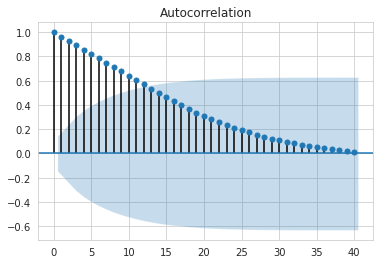

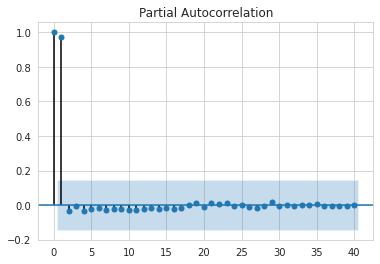

In [63]:
#Serie sin transformacion
sm.graphics.tsa.plot_acf(covidMedRec, lags=40)
plt.show()
sm.graphics.tsa.plot_pacf(covidMedRec, lags=40)
plt.show()

In [64]:
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(covidMedRec, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(covidMedRec, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(covidMedRec, test='pp')  # -> 0

print(n_adf, n_kpss, n_pp)

2 2 2


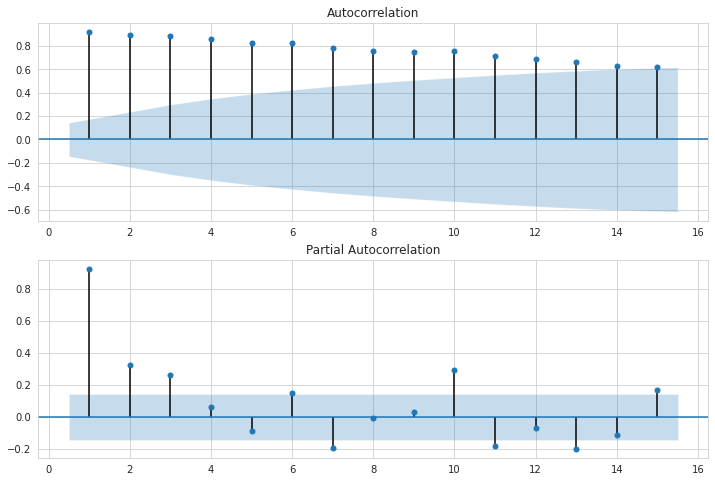

In [65]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
sm.graphics.tsa.plot_acf(covidMedRec.diff().dropna(), lags=15, zero=False, ax=ax1)

# Plot the PACF of df
sm.graphics.tsa.plot_pacf(covidMedRec.diff().dropna(), lags=15, zero=False, ax=ax2)

plt.show()

Para encontrar los mejores parámetros p y q del modelo de recuperados, se realiza un for que itera entre estos parámetros y nos devuelve un data frame con los mejores 5 modelos ordenado por AIC. Este proceso es lento ya que es necesarios crear y evaluar muchos modelos, para que no se corra cada vez que el archivo se ejecute, se realiza un condicional que compara unos p y q anteriormente establecidos y su AIC

In [66]:
##se realiza un if que determina si se necesita un cambio de modelo, usando unos valores p y q que previamente sacamos. 
#Si hay un crecimiento del 10% en el AIC para el modelo que previamente temnia menor AIC, esto nos indicaria que es necesario re escoger los mejores p y q
#El proceso del For es un poco lento

ordenesRec=[[11,6], [11,10], [10,10],[9,11],[9,9]]
aic1rec=2225.893869

model1Recuperados = SARIMAX(covidMedRec, order=(11,1,6))
results1Recuperados = model1Infectados.fit()
aic1Recuperados=results1Recuperados.aic

if aic1Recuperados >= (aic1rec*1.1):


  order_aic_bicRec = []

  for p in range(5,12):
    for q in range(1,12):
      try:
        model = SARIMAX(covidMedRec, order=(p,1,q))
        results = model.fit()
        order_aic_bicRec.append((p,q, results.aic, results.bic))
      except:
        print(p, q, None, None)

  order_dfRec = pd.DataFrame(order_aic_bicRec, columns=['p','q', 'aic', 'bic'])
  order_dfRec = order_dfRec.sort_values(by='aic')
  order_dfRec = order_dfRec.head(5)
else:
  order_dfRec = pd.DataFrame(ordenesRec, columns=['p','q'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Se determina cual de los 5 modelos seleccionados anteriormente mediante el AIC es mejor modelo según el error cuadratico medio. Finalmente se entrega un dataframe que contiene el p,q y MSE del mejor modelo seleccionado

In [67]:
models_errorRec = []

for i, j in zip(order_dfRec['p'], order_dfRec['q']):
  model = SARIMAX(covidMedInfec, order=(i,1,j))
  results = model.fit()
  prediction = results.get_prediction(start=-25, dynamic=True)
  y_prediction = prediction.predicted_mean
  y_real = covidMedInfec.iloc[-25:]
  error = mean_squared_error(y_real, y_prediction)/100000 #se divide por 100 mil para una lectura mas facil del valor
  models_errorRec.append((i, j, error))

modelsRec = pd.DataFrame(models_errorRec, columns=['p','q', 'MSE'])
models_orderRec=modelsRec.sort_values(by='MSE').copy().head(1).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWa

Se define función para aplicar el modelo seleccionado a las ciudades.

In [68]:
#definir funcion 
def fn_prediccionRec(df, p, q, ciudad):
  modelF = SARIMAX(df, order=(p,1,q)).fit()
  modelF.plot_diagnostics()
  print(modelF.summary())
  mae = np.mean(np.abs(modelF.resid))
  print('El mae es igual a: ' +str(round(mae, 2)))
  plt.show()
  #predicciones
  prediction = modelF.get_prediction(start=-10, dynamic=True)

  predicted_summary = modelF.get_forecast(steps=25).summary_frame()

  predicted_summary = predicted_summary.set_index(pd.date_range(today + timedelta(days=1), periods=25, normalize=True))
  predicted_summary

  mean_prediction = prediction.predicted_mean
  confidence_intervals = prediction.conf_int()

  lower_limits = confidence_intervals.loc[:,'lower recuperadosTotales']
  upper_limits = confidence_intervals.loc[:,'upper recuperadosTotales']

  lower_limits_p = predicted_summary.loc[:,'mean_ci_lower']
  upper_limits_p = predicted_summary.loc[:,'mean_ci_upper']

  plt.plot(df.index, df)
  plt.plot(predicted_summary.index, predicted_summary['mean'])
  plt.plot(mean_prediction.index, mean_prediction, color='r', label='forecast')
  plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
  plt.fill_between(lower_limits_p.index, lower_limits_p, upper_limits_p, color='lavender')
  plt.title('Recuperados '+ ciudad)
  plt.show()

Modelo para recuperados totales Medellín

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:     recuperadosTotales   No. Observations:                  186
Model:              SARIMAX(9, 1, 11)   Log Likelihood               -1144.597
Date:                Mon, 07 Sep 2020   AIC                           2331.193
Time:                        13:54:55   BIC                           2398.821
Sample:                             0   HQIC                          2358.601
                                - 186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5500      7.134      0.077      0.939     -13.432      14.532
ar.L2         -0.7964      7.897     -0.101      0.920     -16.274      14.682
ar.L3          0.0144      3.429      0.004      0.9

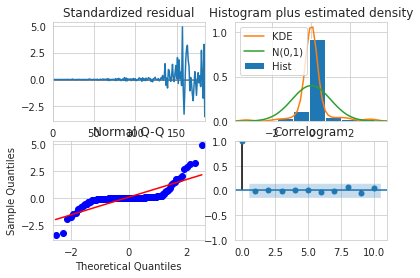

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


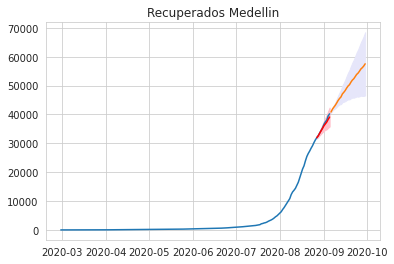

In [69]:
fn_prediccionRec(covidMedRec, models_orderRec.loc[0]['p'], models_orderRec.loc[0]['q'], "Medellin")

Modelo para recuperados totales en la ciudad de Bogotá

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:     recuperadosTotales   No. Observations:                  189
Model:              SARIMAX(9, 1, 11)   Log Likelihood               -1431.119
Date:                Mon, 07 Sep 2020   AIC                           2904.238
Time:                        13:55:01   BIC                           2972.204
Sample:                             0   HQIC                          2931.775
                                - 189                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5355      0.822     -0.651      0.515      -2.147       1.077
ar.L2         -0.6563      0.950     -0.691      0.490      -2.519       1.207
ar.L3          0.2120      0.894      0.237      0.8

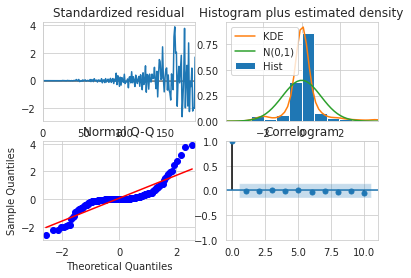

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


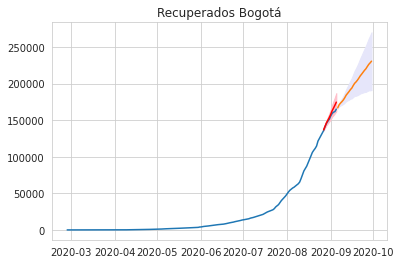

In [70]:
fn_prediccionRec(covidBogRec, models_orderRec.loc[0]['p'], models_orderRec.loc[0]['q'], "Bogotá")

Modelo para recuperados totales en la ciudad de Cali

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:     recuperadosTotales   No. Observations:                  184
Model:              SARIMAX(9, 1, 11)   Log Likelihood               -1135.545
Date:                Mon, 07 Sep 2020   AIC                           2313.089
Time:                        13:55:06   BIC                           2380.489
Sample:                             0   HQIC                          2340.410
                                - 184                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4169      0.399     -1.045      0.296      -1.199       0.365
ar.L2         -0.1172      0.431     -0.272      0.786      -0.961       0.727
ar.L3         -0.2815      0.371     -0.760      0.4

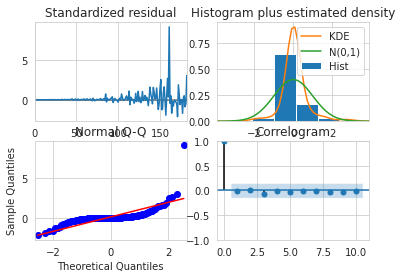

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


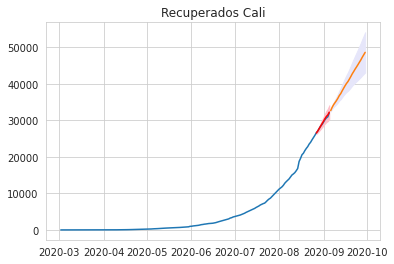

In [71]:
fn_prediccionRec(covidCalRec, models_orderRec.loc[0]['p'], models_orderRec.loc[0]['q'], "Cali")

Modelo de recuperados totales en la ciudad de Cartagena



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:     recuperadosTotales   No. Observations:                  182
Model:              SARIMAX(9, 1, 11)   Log Likelihood                -970.985
Date:                Mon, 07 Sep 2020   AIC                           1983.970
Time:                        13:55:11   BIC                           2051.138
Sample:                             0   HQIC                          2011.201
                                - 182                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1851      0.856     -0.216      0.829      -1.862       1.492
ar.L2          0.1110      1.023      0.109      0.914      -1.894       2.117
ar.L3          0.2686      0.707      0.380      0.7

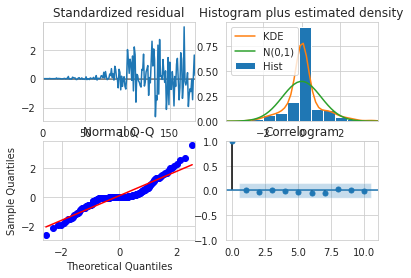

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


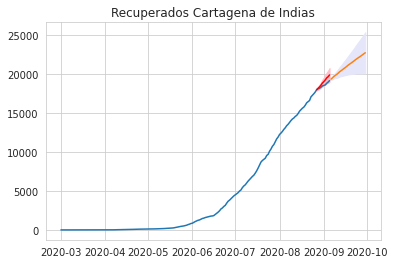

In [72]:
fn_prediccionRec(covidCarRec, models_orderRec.loc[0]['p'], models_orderRec.loc[0]['q'], "Cartagena de Indias")

Modelo de recuperados totales en la ciudad de Barranquilla

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:     recuperadosTotales   No. Observations:                  181
Model:              SARIMAX(9, 1, 11)   Log Likelihood               -1111.156
Date:                Mon, 07 Sep 2020   AIC                           2264.311
Time:                        13:55:16   BIC                           2331.364
Sample:                             0   HQIC                          2291.498
                                - 181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5573      1.233      0.452      0.651      -1.859       2.974
ar.L2          0.3372      0.675      0.500      0.617      -0.986       1.660
ar.L3         -0.1512      0.645     -0.235      0.8

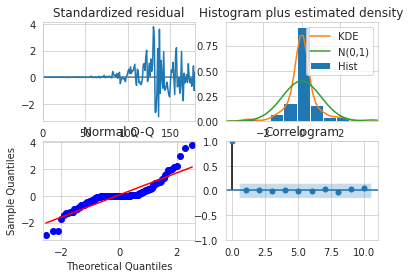

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


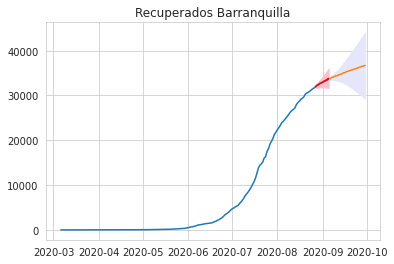

In [73]:
fn_prediccionRec(covidBarRec, models_orderRec.loc[0]['p'], models_orderRec.loc[0]['q'], "Barranquilla")

###Serie de tiempos muertos

Al igual que para infectados y recuperados, encontrar el mejor modelo de fallecidos totales, se realizarán las pruebas en una ciudad particular y se asumirá que el virus se comporta de forma similar para las demás ciudades de colombia. Para el entrenamiento del modelo se utiliza el 100% de los datos, ya que al ser una serie de tiempo, las últimas observaciones son muy relevantes.

In [74]:
#segmentar las bases de datos para las diferentes ciudades
covidMedMuer = covidTotales[['fecha', 'muertosTotales']][covidTotales['ciudadUbicacion'] == 'Medellín'].set_index('fecha')
covidBogMuer = covidTotales[['fecha', 'muertosTotales']][covidTotales['ciudadUbicacion'] == 'Bogotá D.C.'].set_index('fecha')
covidBarMuer = covidTotales[['fecha', 'muertosTotales']][covidTotales['ciudadUbicacion'] == 'Barranquilla'].set_index('fecha')
covidCalMuer = covidTotales[['fecha', 'muertosTotales']][covidTotales['ciudadUbicacion'] == 'Cali'].set_index('fecha')
covidCarMuer = covidTotales[['fecha', 'muertosTotales']][covidTotales['ciudadUbicacion'] == 'Cartagena de Indias'].set_index('fecha')

In [75]:
##Comprobacion de estacionalidad
adf_test = ADFTest(alpha=0.05)
print(adf_test.should_diff(covidMedMuer))
print(adf_test.should_diff(covidMedMuer.diff().dropna()))

(0.7394101411404074, True)
(0.7669997543507331, True)


Se utilizan los gráficso ACF y PACF para tener una base de cómo pueden ser los mejores p y q para el modelo.

In [76]:
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(covidMedMuer, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(covidMedMuer, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(covidMedMuer, test='pp')  # -> 0

print(n_adf, n_kpss, n_pp)

2 2 1


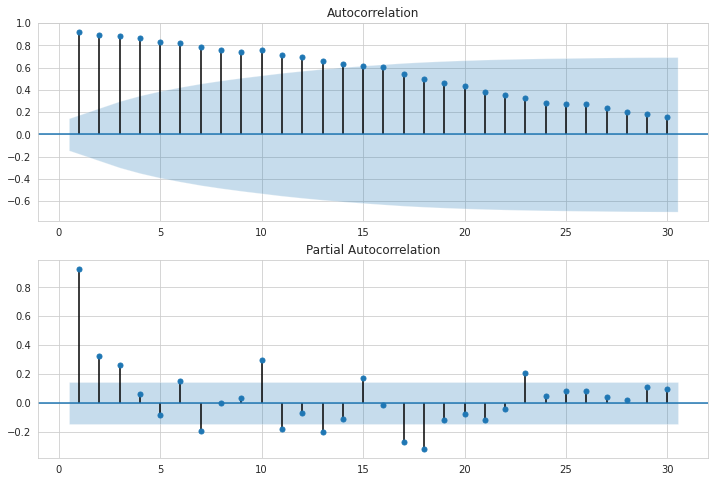

In [77]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
sm.graphics.tsa.plot_acf(covidMedRec.diff().dropna(), lags=30, zero=False, ax=ax1)

# Plot the PACF of df
sm.graphics.tsa.plot_pacf(covidMedRec.diff().dropna(), lags=30, zero=False, ax=ax2)

plt.show()

Para encontrar los mejores parámetros p y q del modelo de fallecidos, se realiza un for que itera entre estos parámetros y nos devuelve un data frame con los mejores 5 modelos ordenado por AIC. Este proceso es lento ya que es necesarios crear y evaluar muchos modelos, para que no se corra cada vez que el archivo se ejecute, se realiza un condicional que compara unos p y q anteriormente establecidos y su AIC

In [78]:
##se realiza un if que determina si se necesita un cambio de modelo, usando unos valores p y q que previamente sacamos. 
#Si hay un crecimiento del 10% en el AIC para el modelo que previamente temnia menor AIC, esto nos indicaria que es necesario re escoger los mejores p y q
#El proceso del For es un poco lento

ordenesMuer=[[1,7], [5,5], [1,8],[2,8],[2,6]]
aic1muer=914.124511

model1Muertos = SARIMAX(covidMedMuer, order=(1,2,7))
results1Muertos = model1Muertos.fit()
aic1Muertos=results1Muertos.aic

if aic1Muertos >= (aic1muer*1.1):

  order_aic_bicMuer = []

  for p in range(5,14):
    for q in range(1,14):
      try:
        model = SARIMAX(covidMedMuer, order=(p,2,q))
        results = model.fit()
        order_aic_bicMuer.append((p,q, results.aic, results.bic))
      except:
        print(p, q, None, None)

  order_dfMuer = pd.DataFrame(order_aic_bicMuer, columns=['p','q', 'aic', 'bic'])
  order_dfMuer = order_dfMuer.sort_values(by='aic')
  order_dfMuer = order_dfMuer.head(5)
else:
  order_dfMuer = pd.DataFrame(ordenesMuer, columns=['p','q'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Se mide el error cuadratico medio para determinar cual es el mejor modelo de los 5 previamente seleccionados.

In [79]:
models_errorMuer = []

for i, j in zip(order_dfMuer['p'], order_dfMuer['q']):
  model = SARIMAX(covidMedInfec, order=(i,1,j))
  results = model.fit()
  prediction = results.get_prediction(start=-25, dynamic=True)
  y_prediction = prediction.predicted_mean
  y_real = covidMedInfec.iloc[-25:]
  error = mean_squared_error(y_real, y_prediction)/100000 #se divide por 100 mil para una lectura mas facil del valor
  models_errorMuer.append((i, j, error))

modelsMuer = pd.DataFrame(models_errorMuer, columns=['p','q', 'MSE'])
models_orderMuer = modelsMuer.sort_values(by='MSE').copy().head(1).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWa

Se crea la función para realizar el anterior procedimiento a las ciudades a las cuales se centra el análisis

In [80]:
#definir funcion 
def fn_prediccionMuer(df, p, q, ciudad):
  modelF = SARIMAX(df, order=(p,1,q)).fit()
  modelF.plot_diagnostics()
  print(modelF.summary())
  mae = np.mean(np.abs(modelF.resid))
  print('El mae es igual a: ' +str(round(mae, 2)))
  plt.show()
  #predicciones
  prediction = modelF.get_prediction(start=-10, dynamic=True)

  predicted_summary = modelF.get_forecast(steps=25).summary_frame()

  predicted_summary = predicted_summary.set_index(pd.date_range(today + timedelta(days=1), periods=25, normalize=True))
  predicted_summary

  mean_prediction = prediction.predicted_mean
  confidence_intervals = prediction.conf_int()

  lower_limits = confidence_intervals.loc[:,'lower muertosTotales']
  upper_limits = confidence_intervals.loc[:,'upper muertosTotales']

  lower_limits_p = predicted_summary.loc[:,'mean_ci_lower']
  upper_limits_p = predicted_summary.loc[:,'mean_ci_upper']

  plt.plot(df.index, df)
  plt.plot(predicted_summary.index, predicted_summary['mean'])
  plt.plot(mean_prediction.index, mean_prediction, color='r', label='forecast')
  plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
  plt.fill_between(lower_limits_p.index, lower_limits_p, upper_limits_p, color='lavender')
  plt.title('Fallecidos '+ ciudad)
  plt.show()

Modelo de fallecidos totales para la ciudad de Medellín

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:         muertosTotales   No. Observations:                  186
Model:               SARIMAX(1, 1, 7)   Log Likelihood                -460.267
Date:                Mon, 07 Sep 2020   AIC                            938.535
Time:                        13:55:26   BIC                            967.518
Sample:                             0   HQIC                           950.281
                                - 186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9932      0.006    179.183      0.000       0.982       1.004
ma.L1         -0.9132      0.056    -16.206      0.000      -1.024      -0.803
ma.L2          0.1909      0.079      2.421      0.0

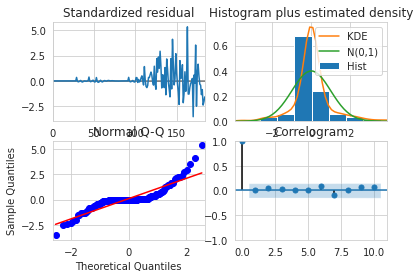

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


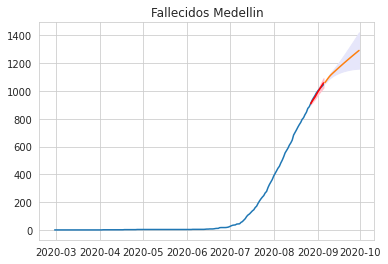

In [81]:
fn_prediccionMuer(covidMedMuer, models_orderMuer.loc[0]['p'], models_orderMuer.loc[0]['q'], "Medellin")

Modelo de Fallecidos totales para la ciudad de Bogotá

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:         muertosTotales   No. Observations:                  189
Model:               SARIMAX(1, 1, 7)   Log Likelihood                -651.586
Date:                Mon, 07 Sep 2020   AIC                           1321.171
Time:                        13:55:28   BIC                           1350.299
Sample:                             0   HQIC                          1332.973
                                - 189                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9937      0.004    221.440      0.000       0.985       1.003
ma.L1         -0.7219      0.067    -10.744      0.000      -0.854      -0.590
ma.L2          0.0203      0.063      0.324      0.7

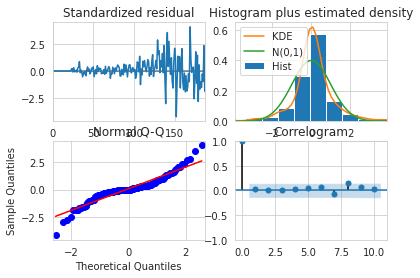

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


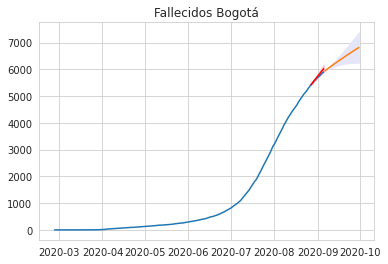

In [82]:
fn_prediccionMuer(covidBogMuer, models_orderMuer.loc[0]['p'], models_orderMuer.loc[0]['q'], "Bogotá")

Modelo de Fallecidos totales para la ciudad de Cali

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:         muertosTotales   No. Observations:                  184
Model:               SARIMAX(1, 1, 7)   Log Likelihood                -442.093
Date:                Mon, 07 Sep 2020   AIC                            902.185
Time:                        13:55:29   BIC                            931.071
Sample:                             0   HQIC                           913.894
                                - 184                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9936      0.007    140.263      0.000       0.980       1.008
ma.L1         -0.6946      0.078     -8.910      0.000      -0.847      -0.542
ma.L2          0.2368      0.081      2.925      0.0

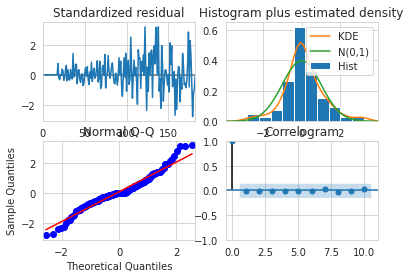

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


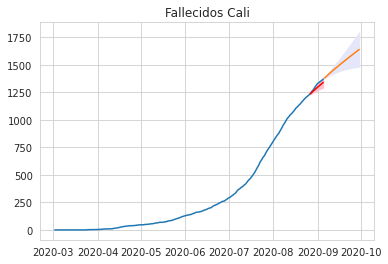

In [83]:
fn_prediccionMuer(covidCalMuer, models_orderMuer.loc[0]['p'], models_orderMuer.loc[0]['q'], "Cali")

Modelo de Fallecidos totales para la ciudad de Cartagena de Indias

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:         muertosTotales   No. Observations:                  182
Model:               SARIMAX(1, 1, 7)   Log Likelihood                -372.190
Date:                Mon, 07 Sep 2020   AIC                            762.379
Time:                        13:55:31   BIC                            791.166
Sample:                             0   HQIC                           774.050
                                - 182                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9860      0.011     93.056      0.000       0.965       1.007
ma.L1         -0.9248      0.068    -13.587      0.000      -1.058      -0.791
ma.L2         -0.0096      0.093     -0.103      0.9

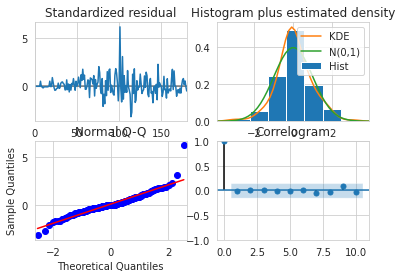

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


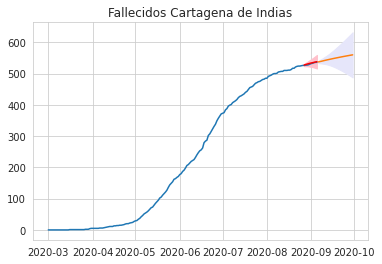

In [84]:
fn_prediccionMuer(covidCarMuer, models_orderMuer.loc[0]['p'], models_orderMuer.loc[0]['q'], "Cartagena de Indias")

Modelo de Fallecidos totales para la ciudad de Barranquilla

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:         muertosTotales   No. Observations:                  181
Model:               SARIMAX(1, 1, 7)   Log Likelihood                -465.858
Date:                Mon, 07 Sep 2020   AIC                            949.717
Time:                        13:55:33   BIC                            978.453
Sample:                             0   HQIC                           961.368
                                - 181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9875      0.008    119.549      0.000       0.971       1.004
ma.L1         -0.5928      0.082     -7.209      0.000      -0.754      -0.432
ma.L2          0.0296      0.082      0.362      0.7

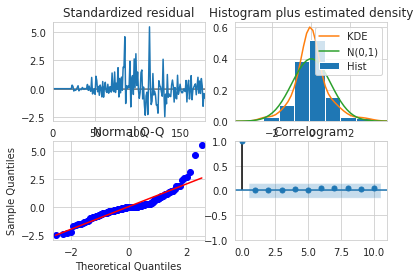

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


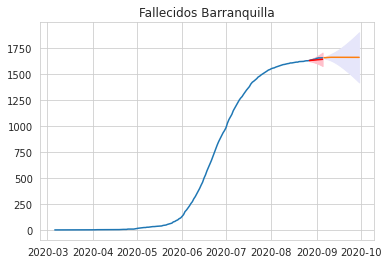

In [85]:
fn_prediccionMuer(covidBarMuer, models_orderMuer.loc[0]['p'], models_orderMuer.loc[0]['q'], "Barranquilla")

###El Modelo epidemiológico SIR

Una descripción matemática simple del exparcimiento de una enfermedad en una población, en el que una población fija **N** se divide en tres "comportamientos" que varian en función del tiempo **t**

* **S(t)** Son los suceptibles pero todavía no infectados con la enfermedad
* **I(t)** El número de individuos infectados;
* **R(t)** Los individuos que se han recuperado de la enfermedad

Los supuestos básicos con base en el artículo [aquí](http://www.scielo.org.co/pdf/rsap/v22n1/0124-0064-rsap-22-01-e185977.pdf) disponible de los modelos SIR son: 

1. La población es homogénea y de tamaño fijo; 
2. En un momento dado, cada individuo sólo puede pertenecer a uno
de los siguientes conjuntos: infectados, susceptibles o resistentes
3. La interacción entre los individuos es aleatoria
4. No hay intervención externa que cambie la tasa de contacto de la población. 

En estos modelos se asume que la población por estado (N) es constante y que el número de individuos susceptibles S(t), infectados I(t) y resistentes R(t) son variables dependientes del tiempo.

El modelo SIR describe el cambio en la población por cada comportamiento en termino de dos parametros **β** y **γ**.

* **β** Describe la tasa efectiva de contacto de la enfermedad 
* **γ** Es la tasa media de recuperación

Se reinicia el index en un nuevo dataframe

In [86]:
#
BaseCovid2 = BaseCovid.copy().reset_index()

Se construye un nuevo dataframe por ciudad para el posterior cáluclo de la tasa de recuperación que será utilizada en el modelo SIR

In [87]:
TasaRecuper=pd.DataFrame(BaseCovid2[['ciudadUbicacion','fechaInicioSintomas','fechaRecuperacion']])
Med_Recuper= TasaRecuper[['fechaInicioSintomas', 'fechaRecuperacion']][TasaRecuper['ciudadUbicacion'] == 'Medellín'].reset_index()
Bog_Recuper= TasaRecuper[['fechaInicioSintomas', 'fechaRecuperacion']][TasaRecuper['ciudadUbicacion'] == 'Bogotá D.C.'].reset_index()
Bar_Recuper= TasaRecuper[['fechaInicioSintomas', 'fechaRecuperacion']][TasaRecuper['ciudadUbicacion'] == 'Barranquilla'].reset_index()
Cal_Recuper= TasaRecuper[['fechaInicioSintomas', 'fechaRecuperacion']][TasaRecuper['ciudadUbicacion'] == 'Cali'].reset_index()
Car_Recuper= TasaRecuper[['fechaInicioSintomas', 'fechaRecuperacion']][TasaRecuper['ciudadUbicacion'] == 'Cartagena de Indias'].reset_index()

Se caclula la tasa de recuperación por ciudad con los datos históricos disponibles a la fecha

In [88]:
suma=0
c=0
cont=0
for i in range(len(Med_Recuper)):
  a=Med_Recuper['fechaRecuperacion'][i]
  b=Med_Recuper['fechaInicioSintomas'][i]
  if pd.isnull(a) is True or pd.isnull(b) is True:
    cont+=1
  else:
    x = (a-b).days
    suma+=x
    c+=1
prom_med=suma/c

suma=0
c=0
cont=0
for i in range(len(Bog_Recuper)):
  a=Bog_Recuper['fechaRecuperacion'][i]
  b=Bog_Recuper['fechaInicioSintomas'][i]
  if pd.isnull(a) is True or pd.isnull(b) is True:
    cont+=1
  else:
    x = (a-b).days
    suma+=x
    c+=1
prom_bog=suma/c

suma=0
c=0
cont=0
for i in range(len(Bar_Recuper)):
  a=Bar_Recuper['fechaRecuperacion'][i]
  b=Bar_Recuper['fechaInicioSintomas'][i]
  if pd.isnull(a) is True or pd.isnull(b) is True:
    cont+=1
  else:
    x = (a-b).days
    suma+=x
    c+=1
prom_bar=suma/c

suma=0
c=0
cont=0
for i in range(len(Cal_Recuper)):
  a=Cal_Recuper['fechaRecuperacion'][i]
  b=Cal_Recuper['fechaInicioSintomas'][i]
  if pd.isnull(a) is True or pd.isnull(b) is True:
    cont+=1
  else:
    x = (a-b).days
    suma+=x
    c+=1
prom_cal=suma/c

suma=0
c=0
cont=0
for i in range(len(Car_Recuper)):
  a=Car_Recuper['fechaRecuperacion'][i]
  b=Car_Recuper['fechaInicioSintomas'][i]
  if pd.isnull(a) is True or pd.isnull(b) is True:
    cont+=1
  else:
    x = (a-b).days
    suma+=x
    c+=1
prom_car=suma/c

Se construyen nuevos dataframes por ciudad con las variables necesarias para el modelo

In [89]:
covidMedInfec2= covidTotales[['fecha', 'infectadosTotales','recuperadosTotales','muertosTotales','infectados','recuperados']][covidTotales['ciudadUbicacion'] == 'Medellín'].reset_index()
covidBogInfec2= covidTotales[['fecha', 'infectadosTotales','recuperadosTotales','muertosTotales','infectados','recuperados']][covidTotales['ciudadUbicacion'] == 'Bogotá D.C.'].reset_index()
covidBarInfec2= covidTotales[['fecha', 'infectadosTotales','recuperadosTotales','muertosTotales','infectados','recuperados']][covidTotales['ciudadUbicacion'] == 'Barranquilla'].reset_index()
covidCalInfec2= covidTotales[['fecha', 'infectadosTotales','recuperadosTotales','muertosTotales','infectados','recuperados']][covidTotales['ciudadUbicacion'] == 'Cali'].reset_index()
covidCarInfec2= covidTotales[['fecha', 'infectadosTotales','recuperadosTotales','muertosTotales','infectados','recuperados']][covidTotales['ciudadUbicacion'] == 'Cartagena de Indias'].reset_index()


Se define la función que desarrolla el modelo SIR donde **y** son la cantidad acumulada de infectados por día, t el lapso de tiempo, N la población total, beta y gama los parámetros del modelo descritos anteriormente

In [90]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

Se procede a elaborar un modelo SIR para cada ciudad

####Medellín

Se caclula una tasa preliminar de contagio con los datos disponibles la cual buscará ser optimizada en un apartado posterior del modelo. La tasa de recuperación se toma del histórico con el que se cuenta a la fecha mediante la división del total de recuperados en el día sobre los casos activos

In [91]:
#Tasa de recuperación medellín
suma_tasa=0
contador=0
for j in range(1,len(covidMedInfec)):
  if covidMedInfec2['recuperados'][j-1] > 0:
    tasa=covidMedInfec2['recuperados'][j] / (covidMedInfec2['infectadosTotales'][j] - covidMedInfec2['recuperadosTotales'][j])
    suma_tasa += tasa
    contador += 1
tasa_recuper_med=(suma_tasa/contador)

Se crean dos listas con los datos de la fecha y los infectados totales para su utilización posterior en el modelo y las gráficas.

In [92]:
xdata = covidMedInfec2['fecha']
ydata = covidMedInfec2['infectadosTotales']
promy=float(ydata.mean())

Se busca optimizar el valor de la tasa de contagio para medellín partiendo de la tasa de contagio calculada inicialmente con los datos disponibles y hasta 0.1 dado el testeo preliminar manual de diferentes parámetros

0.7779804251809912 0.08391891222586524


Text(0.5, 1.0, 'Modelo SIR Medellín')

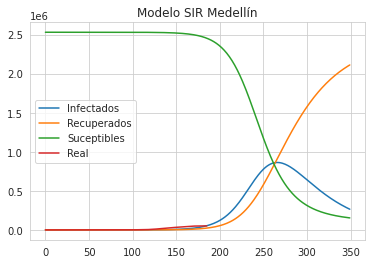

In [94]:
#Se generan mil tasas de contagio entre la tasa de contagio inicial y 0.1
np.random.seed(0)
all_values = np.random.uniform(0, 0.1,1000)

#Se recorren las tasas de contagio generadas y se evalua el MAPE para cada modelo con el fin de seleccionar la que otorga un mejor MAPE
for j in range(len(all_values)):
  tasa_cont = all_values[j]
  N = 2530000
  I0, R0 = 1, 0
  S0 = N - I0 - R0
  tasa=tasa_cont
  beta, gamma = tasa, tasa_recuper_med
  t = np.linspace(0, 350, 350)
  
  #Modelo
  y0 = S0, I0, R0
  ret = odeint(deriv, y0, t, args=(N, beta, gamma))
  S, I, R = ret.T

  x= np.array(xdata,dtype=float)
  y= np.array(ydata,dtype=float)

  #MAPE
  a=0
  for i in range(len(ydata)):
    a += abs(float(ydata[i]) - float(I[i]))/abs(float(ydata[i]))
  MAPE= a / len(ydata)
  
  if j == 0:
      MAPE_min = MAPE
      tasa_cont_med=tasa_cont
  elif MAPE < MAPE_min and abs(y[len(y)-1]-I[len(y)-1])/y[len(y)-1] < 0.1:
    MAPE_min = MAPE
    tasa_cont_med = tasa_cont  
  
print(MAPE_min, tasa_cont_med)

#Definición del modelo con la tasa encontrada
N = 2530000
I0, R0 = 1, 0
S0 = N - I0 - R0
tasa=tasa_cont_med
beta, gamma = tasa, tasa_recuper_med
t = np.linspace(0, 350, 350)

y0 = S0, I0, R0
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

#MAPE
a=0
b=0
for i in range(len(ydata)):
  a += abs(float(ydata[i]) - float(I[i]))/abs(float(ydata[i]))
MAPE= a / len(ydata)

x= np.array(xdata,dtype=float)
y= np.array(ydata,dtype=float)
z=range(0,len(y))
plt.plot(I,label='Infectados')
plt.plot(R,label='Recuperados')
plt.plot(S,label='Suceptibles')
plt.plot(z,ydata,label='Real')
plt.legend()
plt.title('Modelo SIR Medellín')

Se replica el procedimiento descrito anteriormente para todas las ciudades

#### Bogotá

In [96]:
suma_tasa=0
contador=0
for j in range(1,len(covidBogInfec2)):
  if covidBogInfec2['recuperados'][j-1] > 0:
    tasa=covidBogInfec2['recuperados'][j] / (covidBogInfec2['infectadosTotales'][j] - covidBogInfec2['recuperadosTotales'][j])
    suma_tasa += tasa
    contador += 1
tasa_recuper_bog=(suma_tasa/contador)

In [97]:
xdata = covidBogInfec2['fecha']
ydata = covidBogInfec2['infectadosTotales']
promy=float(ydata.mean())

0.8676547848809377 0.09088437184127385


Text(0.5, 1.0, 'Modelo SIR Bogotá')

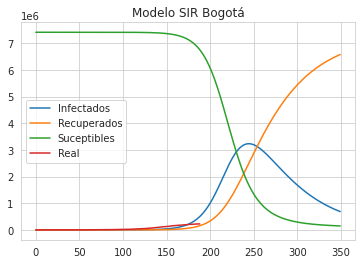

In [98]:
#Se generan mil tasas de contagio entre la tasa de contagio inicial y 0.1
np.random.seed(0)
all_values = np.random.uniform(0, 0.1,1000)

#Se recorren las tasas de contagio generadas y se evalua el MAPE para cada modelo con el fin de seleccionar la que otorga un mejor MAPE
for j in range(len(all_values)):
  tasa_cont = all_values[j]
  N = 7413000
  I0, R0 = 1, 0
  S0 = N - I0 - R0
  tasa=tasa_cont
  beta, gamma = tasa, tasa_recuper_med
  t = np.linspace(0, 350, 350)
  
  #Modelo
  y0 = S0, I0, R0
  ret = odeint(deriv, y0, t, args=(N, beta, gamma))
  S, I, R = ret.T

  x= np.array(xdata,dtype=float)
  y= np.array(ydata,dtype=float)

  #MAPE
  a=0
  for i in range(len(ydata)):
    a += abs(float(ydata[i]) - float(I[i]))/abs(float(ydata[i]))
  MAPE= a / len(ydata)
  
  if j == 0:
      MAPE_min = MAPE
      tasa_cont_bog=tasa_cont
  elif MAPE < MAPE_min and abs(y[len(y)-1]-I[len(y)-1])/y[len(y)-1] < 0.1:
    MAPE_min = MAPE
    tasa_cont_bog = tasa_cont  
  
print(MAPE_min, tasa_cont_bog)

#Definición del modelo con la tasa encontrada
N = 7413000
I0, R0 = 1, 0
S0 = N - I0 - R0
tasa=tasa_cont_bog
beta, gamma = tasa, tasa_recuper_bog
t = np.linspace(0, 350, 350)

y0 = S0, I0, R0
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

#MAPE
a=0
b=0
for i in range(len(ydata)):
  a += abs(float(ydata[i]) - float(I[i]))/abs(float(ydata[i]))
MAPE= a / len(ydata)

x= np.array(xdata,dtype=float)
y= np.array(ydata,dtype=float)
z=range(0,len(y))
plt.plot(I,label='Infectados')
plt.plot(R,label='Recuperados')
plt.plot(S,label='Suceptibles')
plt.plot(z,ydata,label='Real')
plt.legend()
plt.title('Modelo SIR Bogotá')

#### Barranquilla

In [99]:
suma_tasa=0
contador=0
for j in range(1,len(covidBarInfec2)):
  if covidBarInfec2['recuperados'][j-1] > 0:
    tasa=covidBarInfec2['recuperados'][j] / (covidBarInfec2['infectadosTotales'][j] - covidBarInfec2['recuperadosTotales'][j])
    suma_tasa += tasa
    contador += 1
tasa_recuper_bar=(suma_tasa/contador)

In [100]:
xdata = covidBarInfec2['fecha']
ydata = covidBarInfec2['infectadosTotales']
promy=float(ydata.mean())

0.8620103424889491 0.0832619845547938


Text(0.5, 1.0, 'Modelo SIR Barranquilla')

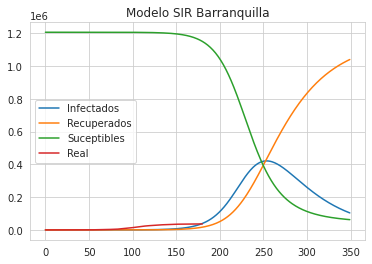

In [101]:
#Se generan mil tasas de contagio entre la tasa de contagio inicial y 0.1
np.random.seed(0)
all_values = np.random.uniform(0, 0.1,1000)

#Se recorren las tasas de contagio generadas y se evalua el MAPE para cada modelo con el fin de seleccionar la que otorga un mejor MAPE
for j in range(len(all_values)):
  tasa_cont = all_values[j]
  N = 1206000
  I0, R0 = 1, 0
  S0 = N - I0 - R0
  tasa=tasa_cont
  beta, gamma = tasa, tasa_recuper_bar
  t = np.linspace(0, 350, 350)
  
  #Modelo
  y0 = S0, I0, R0
  ret = odeint(deriv, y0, t, args=(N, beta, gamma))
  S, I, R = ret.T

  x= np.array(xdata,dtype=float)
  y= np.array(ydata,dtype=float)

  #MAPE
  a=0
  for i in range(len(ydata)):
    a += abs(float(ydata[i]) - float(I[i]))/abs(float(ydata[i]))
  MAPE= a / len(ydata)
  
  if j == 0:
      MAPE_min = MAPE
      tasa_cont_bar=tasa_cont
  elif MAPE < MAPE_min and abs(y[len(y)-1]-I[len(y)-1])/y[len(y)-1] < 0.1:
    MAPE_min = MAPE
    tasa_cont_bar = tasa_cont  
  
print(MAPE_min, tasa_cont_bar)

#Definición del modelo con la tasa encontrada
N = 1206000
I0, R0 = 1, 0
S0 = N - I0 - R0
tasa=tasa_cont_bar
beta, gamma = tasa, tasa_recuper_bar
t = np.linspace(0, 350, 350)

y0 = S0, I0, R0
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

#MAPE
a=0
b=0
for i in range(len(ydata)):
  a += abs(float(ydata[i]) - float(I[i]))/abs(float(ydata[i]))
MAPE= a / len(ydata)

x= np.array(xdata,dtype=float)
y= np.array(ydata,dtype=float)
z=range(0,len(y))
plt.plot(I,label='Infectados')
plt.plot(R,label='Recuperados')
plt.plot(S,label='Suceptibles')
plt.plot(z,ydata,label='Real')
plt.legend()
plt.title('Modelo SIR Barranquilla')

#### Cali

In [102]:
suma_tasa=0
contador=0
for j in range(1,len(covidCalInfec2)):
  if covidCalInfec2['recuperados'][j-1] > 0:
    tasa=covidCalInfec2['recuperados'][j] / (covidCalInfec2['infectadosTotales'][j] - covidCalInfec2['recuperadosTotales'][j])
    suma_tasa += tasa
    contador += 1
tasa_recuper_cal=(suma_tasa/contador)

In [103]:
xdata = covidCalInfec2['fecha']
ydata = covidCalInfec2['infectadosTotales']
promy=float(ydata.mean())

0.8535035066733004 0.07885455123065188


Text(0.5, 1.0, 'Modelo SIR Cali')

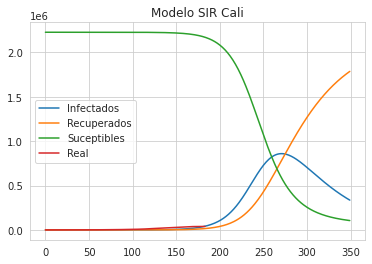

In [104]:
#Se generan mil tasas de contagio entre la tasa de contagio inicial y 0.1
np.random.seed(0)
all_values = np.random.uniform(0, 0.1,1000)

#Se recorren las tasas de contagio generadas y se evalua el MAPE para cada modelo con el fin de seleccionar la que otorga un mejor MAPE
for j in range(len(all_values)):
  tasa_cont = all_values[j]
  N = 2228000
  I0, R0 = 1, 0
  S0 = N - I0 - R0
  tasa=tasa_cont
  beta, gamma = tasa, tasa_recuper_cal
  t = np.linspace(0, 350, 350)
  
  #Modelo
  y0 = S0, I0, R0
  ret = odeint(deriv, y0, t, args=(N, beta, gamma))
  S, I, R = ret.T

  x= np.array(xdata,dtype=float)
  y= np.array(ydata,dtype=float)

  #MAPE
  a=0
  for i in range(len(ydata)):
    a += abs(float(ydata[i]) - float(I[i]))/abs(float(ydata[i]))
  MAPE= a / len(ydata)
  
  if j == 0:
      MAPE_min = MAPE
      tasa_cont_cal=tasa_cont
  elif MAPE < MAPE_min and abs(y[len(y)-1]-I[len(y)-1])/y[len(y)-1] < 0.1:
    MAPE_min = MAPE
    tasa_cont_cal = tasa_cont  
  
print(MAPE_min, tasa_cont_cal)

#Definición del modelo con la tasa encontrada
N = 2228000
I0, R0 = 1, 0
S0 = N - I0 - R0
tasa=tasa_cont_cal
beta, gamma = tasa, tasa_recuper_cal
t = np.linspace(0, 350, 350)

y0 = S0, I0, R0
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

#MAPE
a=0
b=0
for i in range(len(ydata)):
  a += abs(float(ydata[i]) - float(I[i]))/abs(float(ydata[i]))
MAPE= a / len(ydata)

x= np.array(xdata,dtype=float)
y= np.array(ydata,dtype=float)
z=range(0,len(y))
plt.plot(I,label='Infectados')
plt.plot(R,label='Recuperados')
plt.plot(S,label='Suceptibles')
plt.plot(z,ydata,label='Real')
plt.legend()
plt.title('Modelo SIR Cali')

#### Cartagena

In [105]:
suma_tasa=0
contador=0
for j in range(1,len(covidCarInfec2)):
  if covidCarInfec2['recuperados'][j-1] > 0:
    tasa=covidCarInfec2['recuperados'][j] / (covidCarInfec2['infectadosTotales'][j] - covidCarInfec2['recuperadosTotales'][j])
    suma_tasa += tasa
    contador += 1
tasa_recuper_car=(suma_tasa/contador)

In [106]:
xdata = covidCarInfec2['fecha']
ydata = covidCarInfec2['infectadosTotales']
promy=float(ydata.mean())

0.857731650891969 0.08180333057558385


Text(0.5, 1.0, 'Modelo SIR Cartagena')

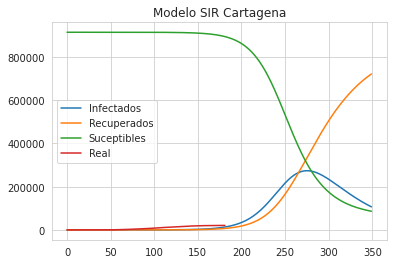

In [107]:
#Se generan mil tasas de contagio entre la tasa de contagio inicial y 0.1
np.random.seed(0)
all_values = np.random.uniform(0, 0.1,1000)

#Se recorren las tasas de contagio generadas y se evalua el MAPE para cada modelo con el fin de seleccionar la que otorga un mejor MAPE
for j in range(len(all_values)):
  tasa_cont = all_values[j]
  N = 914552
  I0, R0 = 1, 0
  S0 = N - I0 - R0
  tasa=tasa_cont
  beta, gamma = tasa, tasa_recuper_car
  t = np.linspace(0, 350, 350)
  
  #Modelo
  y0 = S0, I0, R0
  ret = odeint(deriv, y0, t, args=(N, beta, gamma))
  S, I, R = ret.T

  x= np.array(xdata,dtype=float)
  y= np.array(ydata,dtype=float)

  #MAPE
  a=0
  for i in range(len(ydata)):
    a += abs(float(ydata[i]) - float(I[i]))/abs(float(ydata[i]))
  MAPE= a / len(ydata)
  
  if j == 0:
      MAPE_min = MAPE
      tasa_cont_car=tasa_cont
  elif MAPE < MAPE_min and abs(y[len(y)-1]-I[len(y)-1])/y[len(y)-1] < 0.1:
    MAPE_min = MAPE
    tasa_cont_car = tasa_cont  
  
print(MAPE_min, tasa_cont_car)

#Definición del modelo con la tasa encontrada
N = 914552
I0, R0 = 1, 0
S0 = N - I0 - R0
tasa=tasa_cont_cal
beta, gamma = tasa, tasa_recuper_car
t = np.linspace(0, 350, 350)

y0 = S0, I0, R0
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

#MAPE
a=0
b=0
for i in range(len(ydata)):
  a += abs(float(ydata[i]) - float(I[i]))/abs(float(ydata[i]))
MAPE= a / len(ydata)

x= np.array(xdata,dtype=float)
y= np.array(ydata,dtype=float)
z=range(0,len(y))
plt.plot(I,label='Infectados')
plt.plot(R,label='Recuperados')
plt.plot(S,label='Suceptibles')
plt.plot(z,ydata,label='Real')
plt.legend()
plt.title('Modelo SIR Cartagena')

##6. Despliegue de los resultados (Producto de datos)

En el siguiente [link](www.link.com) se encuentra disponible el dashboard en el que se reflejan los principales hallazgos del proceso aquí descrito.

In [111]:
%%writefile index.html

<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <title>Pronóstico Covid</title>
  </head>
  <body>
    <div>
      <h1>Análisis descriptivo</h1>
      <iframe width="1300" height="1000" src="https://app.powerbi.com/view?r=eyJrIjoiNTk2ODI5N2MtMjZiOC00MDFiLWJiNTgtNmQ4M2VmZjgyNWU3IiwidCI6ImZhYTQ0ZmQ5LWRhYmUtNDA2NC1hNmJiLTU5NjA4ZWE5ZDBmMyIsImMiOjR9&pageName=ReportSection" frameborder="0" allowFullScreen="true"></iframe>
    </div>
    <div>
        <h1>Medellín</h1>
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYoAAAEICAYAAABBBrPDAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3dfVxUdd7/8dfMcH8PCoMaaZoamYlmmUKQGKASiolt282W2a80y7StNrtRy7vaNbPyunalulprqy1NsNRNlDaRzNq1iEzMWxIQZhS5VwZm5vv7A500EBCFmYHP8/HwAZw53zPvM9G8OefMOUejlFIIIYQQ56G1dwAhhBCOTYpCCCFEs6QohBBCNEuKQgghRLOkKIQQQjRLikIIIUSzpCiEQzp+/Dh33XUXQ4cO5aWXXrJbjsLCQgYOHIjZbLZbhtZat24dv//971s179NPP82rr74KwDfffEN0dLTtMYvFwpQpU9iyZUu75BTOR4pCdJjY2Fh27NjRqnk/+ugjAgMD+e6773j66afb/JxnvyE6im+++YaBAwcyc+bMc6bv3buXgQMHcs8999gpWYPU1FSuv/564uLi7JpDOA4pCuGQjh49Sr9+/dBoNPaO0i6CgoLIycmhrKzMNi0tLY0+ffrYLxRgNpvx9PTkj3/8o11zCMciRSHs4sxukpdffpnrr7+e2NhYtm3bBjRsBaSnp/P2228zdOhQduzYgdVqJTU1lVtuuYURI0bw2GOPUV5eblvef//7X+644w6GDx9OTEwM69at46OPPuKzzz6zLWf69OkAtuUMHTqU8ePHn7OLxWKx8PLLLzNixAjGjBljy3SGwWBg+vTp3HDDDcTFxfHxxx/bHsvNzeW2225j2LBhjBo1iqVLl553/V1dXRkzZgybNm2yPe+mTZtISko6Z76DBw8ydepUbrjhBhISEmzzA5SVlTF9+nSGDRtGSkoKR44cafXY83FxceHdd9/lm2++AeCNN97gscce46mnnmLo0KEkJiby448/trgc0ckoITrI6NGj1VdffaWUUuqTTz5RV199tfroo4+U2WxW77//voqMjFRWq1UppdSf/vQntXz5ctvYv//972rKlCmquLhYmUwm9fzzz6s5c+YopZQqLCxUERER6rPPPlN1dXXqxIkTas+ePU0uRymlNm3apEpKSpTFYlEbN25UQ4YMUQaDQSml1AcffKASEhLU0aNHVVlZmbr77rvVgAEDVH19vVJKqTvvvFPNnz9f1dbWqj179qgRI0aoHTt2KKWUuv3221VaWppSSqnq6mr1/fffN/k67Ny5U910001q165dKiUlRSml1Jdffqnuv/9+9fHHH6u7775bKaVUTU2Nio6OVmvXrlX19fXqp59+UjfccIPav3+/Ukqp2bNnq1mzZqmamhr1888/q6ioKHXHHXe0auzZr8uZPE39d3r99dfVNddco7788ktlNpvVsmXL1JQpU1r931x0DrJFIeymZ8+e3H777eh0OiZNmsSxY8c4fvx4k/P+85//ZM6cOYSGhuLm5sYjjzzC5s2bMZvNbNiwgVGjRnHrrbfi6upKYGAg4eHh533ecePGodfr0Wq1jB8/nt69e5ObmwvAv/71L+6991569OhBQEAADz30kG1ccXEx3333HU888QTu7u6Eh4czZcoU1q9fDzT8NX7kyBFOnDiBt7c3ERERza7/sGHDqKio4NChQ6SnpzNx4sRzHv/yyy/p1asXkydPxsXFhauvvpqEhAQ+//xzLBYLGRkZzJo1Cy8vLwYMGMCkSZNaNfZCXXfddcTExKDT6Zg4cSJ79+694GUI5+Zi7wCi6+revbvte09PTwBOnjzZ5LxHjx5l5syZaLW//m2j1WopLS2luLiYyy+/vNXPm56ezjvvvENRUZHtOc8cKzAajfTo0cM2b8+ePW3fG41G/P398fHxOefx3bt3A7B48WJef/11xo0bx2WXXcYjjzzC6NGjm80yYcIE3n//fb755huWLFnChg0bbI8VFRWRm5vL8OHDbdMsFgsTJkzgxIkTmM3m82ZtbuyFOvu/k4eHByaTCbPZjIuLvH10FfJfWjiF0NBQlixZwnXXXdfosR49eti2CH7rtwfDi4qKeO655/j73//O0KFDbX8lnxEcHExxcbHt57O/DwkJoaKigurqaltZFBcXo9frAejTpw/Lly/HarXa/tr/5ptv8PLyOu96TZw4kfj4eJKTk21lefZ6XX/99bzzzjuNxlksFlxcXCguLqZfv36NsjY3VogLJbuehFP4/e9/z4oVK2xbASdOnGDr1q0AJCUlsWPHDjZt2oTZbKasrIy8vDwAunXrRmFhoW05p06dQqPREBQUBMAnn3zC/v37bY+PGzeO9957j5KSEioqKkhNTbU91qNHD4YOHcry5csxmUzs3buXtWvX2v5KX79+PSdOnECr1eLn5wdwzhZQU8LCwnjvvfeYPXt2o8duvvlm8vPzSU9Pp76+nvr6enJzczl48CA6nY64uDhWrlzJqVOnOHDgAGlpaa0aK8SFkqIQTuEPf/gDsbGx3H///QwdOpTbb7/dthXRs2dP3nzzTd555x1uuOEGkpOTbfvRU1JSOHDgAMOHD+fhhx/myiuv5P777+eOO+5g1KhR7Nu3j2HDhtme5/bbbycqKoqJEycyadIk4uPjz8mxfPlyioqKuOmmm3jkkUd49NFHGTVqFADbt28nMTGRoUOHsnjxYl599VU8PDxaXLfhw4fbtkrO5uPjw9tvv82mTZu46aabiIqKYtmyZdTV1QEwb948Tp48SWRkJE8//TS33XZbq8cKcSE0SsmNi4QQQpyfbFEIIYRolhSFEEKIZklRCCGEaJYUhRBCiGY57XkUOTk5uLu7t3m8yWS6qPEdzZnyOlNWcK68zpQVJG97aktWk8nU4hUDmuK0RXHmEgptlZeXd1HjO5oz5XWmrOBceZ0pK0je9tSWrGfOL7pQsutJCCFEs6QohBBCNEuKQgghRLOkKIQQQjRLikIIIUSzpCiEEEI0S4pCCCFEs6QohBBCNEuKQgghmnOiAoqP2TuFXUlRCCHE+SgF+/KhvMreSexKikIIIc7HeAJM9fZOYXdSFEII0RSl4FBhy/N1AVIUQgjRlJLjYLbYO4VDkKIQQojfslrhcFHDVyFFIYQQjRQfB4uUxBlSFEIIcTarFfJla+JsUhRCCHG2o8fAquydwqG0qigqKyuZNWsWY8eOZdy4cXz//feUl5czdepU4uPjmTp1KhUVFQAopVi0aBFxcXEkJSXx008/2ZaTlpZGfHw88fHxpKWl2abv3r2bpKQk4uLiWLRoEUrJfyQhRMfTKAW/HJWtid9oVVEsXryYm266ic8//5z169fTr18/UlNTGTlyJBkZGYwcOZLU1FQAsrKyyM/PJyMjg4ULF7JgwQIAysvLWblyJR9//DFr1qxh5cqVtnJZsGABCxcuJCMjg/z8fLKystpnbYUQohkBJ+tla6IJLRZFVVUV//nPf0hJSQHAzc0NPz8/MjMzSU5OBiA5OZmtW7cC2KZrNBoiIiKorKzEaDSSnZ1NZGQkAQEB+Pv7ExkZyfbt2zEajVRXVxMREYFGoyE5OZnMzMx2XGUhhGiCxULwyXrZmmiCS0szFBYWEhQUxNy5c9m7dy+DBg3i2WefpbS0lJCQEACCg4MpLS0FwGAwEBoaahsfGhqKwWBoNF2v1zc5/cz8LTGZTG2+UThAbW3tRY3vaM6U15mygnPldaas4Fx5g2rq6H6ejYmKigqOOth6dORr22JRmM1m9uzZw/PPP8+QIUNYtGiRbTfTGRqNBo1G024hm+Lu7k54eHibx+fl5V3U+I7mTHmdKSs4V15nygpOlNdsgZ0/nPdhf39//MP7dmCglrXltW1rsbS46yk0NJTQ0FCGDBkCwNixY9mzZw/dunXDaDQCYDQaCQoKAhq2FEpKSmzjS0pK0Ov1jaYbDIYmp5+ZXwghOkxhScMlO0STWiyK4OBgQkNDOXToEABff/01/fr1IzY2lvT0dADS09MZM2YMgG26UoqcnBx8fX0JCQkhKiqK7OxsKioqqKioIDs7m6ioKEJCQvDx8SEnJwel1DnLEkKIdme2QKFBDmI3o8VdTwDPP/88TzzxBPX19YSFhbF06VKsViuzZ89m7dq19OzZkxUrVgAQExPDtm3biIuLw9PTkyVLlgAQEBDAww8/bDsoPnPmTAICAgCYP38+c+fOpba2lujoaKKjo9tjXYUQorEiA0hHNKtVRREeHs66desaTV+9enWjaRqNhvnz5ze5nJSUFFtRnG3w4MFs2LChNVGEEOLSsVigoEQ+6dQCOTNbCNF1FcrWRGtIUQghuiazbE20lhSFEKJrkk86tZoUhRCi6zFboEA+6dRaUhRCiK6nsAQ5ONF6UhRCiK7FIudNXCgpCiFE11JklI2JCyRFIYToOqxWOCKfdLpQUhRCiK7j6DH5pFMbSFEIIboGiwXynfvudUop6uqsHX4X0FZdwkMIIZyeE29NNBSEorLSgtkMwcEd+9YtWxRCiM7PYoVfii98ayJnFzw1C4780j65WqCUorbWyvHjZsrKGkqig2/9A8gWhRCiKyi+wK0JUy28/VdY8yH0vAx8fNovWxOUUpw6paiutmC12n9DSIpCCNG5Wa3wywUcm9j/M7z4LBT8AhMnw/THIKhb+2Y8zWJR1NRYOHmyoRnsXRBnSFEIITq34uOtP7luQzq89hfw94dX/geuu6F9swFWq8JkUtTUWKmvd5Bm+A0pCiFE52W1Qn5Ry1sTJhO8sayhKIaPgOcWQkBgu8WyWBrK4dQpK3V1Co3GcbYemiJFIYTovIqPtbw1YTTAc0/Cvjy4816YNgN0uksaw2Jp+NSSyWTFZFJYrZxTDo5cEiBFIYTorKzWls+b+CUfnnwEqqth8TKIjLkET6swmxX19Q1bDfX1jYsBHL8cziZFIYTonI62sDXx3X9g3p/A1RVeWwX9B17wU1itDUVQV9fwz2xuuhTAuYrht6QohBCdT0ufdPr3Flg8Dy4Lg6WvQo9e1FsVh2ss/HLSTLVZUW1WnLIoPHUaUrzBveAE5qBw6vFodksBnLsUmiJFIYTofJr7pFPGJnjpBdSgwRx8dhnbTrny1X/L2HminpOWxmPcNJBY9394FqbhqnWBboNRPaNQl4+hLvRGlLbzv412/jUUQnQtzW1NZH2BeukFjg6M4J5bn+PQ9ybAxBVeOib38mBYgCt9vV3wd9Xg46LFQwcuGg0e3Z+gbNAkXA3f4VqyE+8f/4bPD29gdQ+kts94TvWfTF3PKNB0zotdtKooYmNj8fb2RqvVotPpWLduHeXl5cyZM4eioiJ69erFihUr8Pf3RynF4sWL2bZtGx4eHrz00ksMGjQIgLS0NP76178CMGPGDCZNmgTA7t27mTt3LrW1tcTExPDss8+iscd56kII51dS2nDJjt+wZG+DF55ld8+B3DH2GYYG+vBgD3eiurtzmWcLn3Jy9cLvhglUViZSVavQ1FXhXrgN9/yNeBxKx+vn9zH7hHEy/A+cCr8Hq2f39lk3O2l1/a1evZr169ezbt06AFJTUxk5ciQZGRmMHDmS1NRUALKyssjPzycjI4OFCxeyYMECAMrLy1m5ciUff/wxa9asYeXKlVRUVACwYMECFi5cSEZGBvn5+WRlZV3i1RRCdAlWKxwubLQ1kbc1C+v8p/kxpC9/uX8R70f34IMbArkjzKvlkjhNp9MQGOhCUJAO3H2p7XsrFbF/xfCHvZSNScXi1we//ywm5IOh+H31DNqa4vZYQ7to83ZSZmYmycnJACQnJ7N169Zzpms0GiIiIqisrMRoNJKdnU1kZCQBAQH4+/sTGRnJ9u3bMRqNVFdXExERgUajITk5mczMzEuzdkKIruU3n3Q6ctLMos92Efbn5zgcfDlHX1zBe6PDGBbo1uancHfXEhzsgqvr6b0eLp7UXnkbJ5LSOHb7V5zqm4zXnv8j5MPh+O54Fs2p0otdK7tr9TGKadOmodFo+N3vfsfvfvc7SktLCQkJASA4OJjS0oYXw2AwEBoaahsXGhqKwWBoNF2v1zc5/cz8LTGZTOTl5bU2fiO1tbUXNb6jOVNeZ8oKzpXXmbJCx+bVKEX/4yfRKbAqxTv5J3n3P4f4+N1nUd4+XL7idQaEBrdp2RUVFRxtYj08PYNxc/NFc/rYhDlwIBWj36D6uifw+W453rvfxOvnD6ge9kdqrvl/oHO/qHUEsFotHDz4S4e+tq0qig8//BC9Xk9paSlTp06lb9++5zyu0Wg6/JiCu7s74eHhbR6fl5d3UeM7mjPldaas4Fx5nSkrdHDeIiOUFvJDmYnFe6vYW1zG558sIFiZ0L7yJoTq27xof39//MP7NpqulKK62kp19bm7uix+vam4+TVqhjyM7875+O1cgNee1VSOWoSpd0KbcwBotTr69evH/v17L/i1bWuxtGrXk17f8AJ369aNuLg4cnNz6datG0ajEQCj0UhQUJBt3pKSEtvYkpIS9Hp9o+kGg6HJ6WfmF0KIVjv9Saf3Dlcz6esTHKmsZUvGS/QoPYp20TLoe2W7PK1Go8HXV4efX9NvpebAgZSN+ycnxn0EWheCPr+LwM/vRltV2C552kuLRXHy5Emqq6tt33/11Vf079+f2NhY0tPTAUhPT2fMmDEAtulKKXJycvD19SUkJISoqCiys7OpqKigoqKC7OxsoqKiCAkJwcfHh5ycHJRS5yxLCCFaxVDKe4eqeH5PFaO7u7J915vo83LQ/GkeDL2u3Z/e21tHQMD5305Nl4/hWMo2KkfMx60oi+A1kXjtfhOUc9yWtcVdT6WlpcycORMAi8XCrbfeSnR0NIMHD2b27NmsXbuWnj17smLFCgBiYmLYtm0bcXFxeHp6smTJEgACAgJ4+OGHSUlJAWDmzJkEBAQAMH/+fNvHY6Ojo4mOjm6XlRVCdEJWK4U//cLSvCqiu7uRWrgV3eYN8IdpEDeuw2J4nv70VHn5ed78dW7URDxKbb+J+G1/Ev+v5uJxcD0Vo1di8evTYTnbosWiCAsL49NPP200PTAwkNWrVzeartFomD9/fpPLSklJsRXF2QYPHsyGDRtak1cIIc5VUsr83HIUilfM+9CtfAVujIL7HuzwKJ6eOqxWqKw8/5aCxfdyysb9E899/8RvxzN0XxND5aiFnLrqHvvc57QVOudphEKIrsFqJfvbg2QaTcz3PkHw4rkQdnnD/SS09nl78/bW4eXVwhu+RsOpgb/n2JRs6kOGEZD1OIGb70Z76njHhLxAUhRCCKdlLTKydE8FfV3quf2tF8DFBZau6PB7XP+Wn58ON7eWtw6sPr04cesnVIxchHvBv+m+Nhq3wi/bP+AFkqIQQjgni4V12Qf5qdLM29+sRnv4IDzzAvToae9kaDQaAgN1rduo0Wg5ee10jt+WgdUtgG4bU/D9ej5Y6to9Z2tJUQghnFLF4RKW5lXy6JGvuGJrOvzubrhhpL1j2Wi1GoKCWn/dVXO3azh+21Zqwu/FJ/d/6LZ+PLqKw+2YsPWkKIQQzsdqZdnWfQQUH2F2+mtwzbXw/2baO1Ujrq4a/P0v4G3W1YvK6Fcoi/s7LhWH6f7JaDwOprdbvtaSohBCOJ3DeYWsO3CCDza9jM7NDeYtaTg+4YA8PbW4u1/Yp5lq+97K8ZQvMQeFE7j1Afyy/gjmU+2UsGVSFEII52Kx8Ermfl7YmkpIcX7DJ5xCWnE1B40GdFrQ6U7/65i3P41GQ0BAK49XnMXiG0Zp0qdUR8zCO2813dPHoas42D4hW+CYFSyEEOfx7bcHqd6eTcoPGXDnvXD9jeefWadtuJqsrzd08wdPD9CeLox6C1TXQGkFnKxtmN7EfSwuBa224eB2aanlwgbqXKkaMY+6HiMJ+OJhun8yhooxf4XuSe2S83ykKIQQTqOqupZ563/g3YyVWHtfgbapk+o0GtAAQf7QMwT8fc5/TkVwIFxxWcO1okrLObkvHy+rOv9tVC+Cm5sWb28rNTUXvmzT5XEcm/xvAjP/H165f4PhUhRCCNGkJWu+44+fvEJwTRmaPy8Dt9/cV0KrhV4h0DMYPC7gkt5aLQQH8ctxA+F9roBfiuHYiUteGL6+OmprzVgucMMCwOp7GaXJ/0KjLHT0/fOkKIQQTuG7Q8fxfu9t4g58A488DlcN+vVBrRb8vOGqK8C97TclAhp2T111BVweCj/nQ2XNxS3vLA3nV7hw/Li57QvRtu6OfJeSFIUQwuFZrIp3VqaxfNu7mCNjcJl8R8MDGk3DsYUBfRp2I13KayV5eULEVVBafkkvB+LqqsHbW9OmXVD2IkUhhHB467J/5uF/LMHi64fHk8+dPg6hAS8PGNz/4rcizkejge6Bl3yxvr46Tp0y//bW3g5LPh4rhHBo1SYzlc+9QPixfNz/9BwEBDT8he/jBUOvar+SaEdnPjLrLKQohBAO7ZO/pXFv9seciB2PZtRNDbuaenSHiIEN50M4KXf3Cz8Rz16kKIQQDqvAUMENS/5EjW8gQXOeaCiJKy9v+Geny4hfSv7+Oke9BcU5nP+VFkJ0WrtmPUe48TCWWU+Cvx+E94UewfaOdcnodBq8vR3/bdjxEwohuqQfdvxIwro3ORARRVD8LQ0l0Q4Hlu3Nx0fr8BtHDh5PCNEVWa2KslmPo1VWej3xBPQL65QlAQ0Hth19F5QUhRDC4WRs2MHNu7Zy+NY78Lw+ouFSHJ2Yu7vGoY/LS1EIIRzKyTozL+06wZsTHmbA9P8HV4bZO1K7O7NV4ajkhDshhENZte0Q+SYtQ5fNR9snsFN8uqk13Ny0uLtbMZkc74ztVv8XsFgsJCcn89BDDwFQUFDAlClTiIuLY/bs2dTVNdzfta6ujtmzZxMXF8eUKVMoLCy0LWPVqlXExcWRkJDA9u3bbdOzsrJISEggLi6O1NTUS7VuQggnY6yq5c3th0gc3IPh/UPA1dXekTqUn59jblW0uijeffdd+vXrZ/t52bJl3HfffWzZsgU/Pz/Wrl0LwJo1a/Dz82PLli3cd999LFu2DIADBw6wceNGNm7cyFtvvcULL7yAxWLBYrHw4osv8tZbb7Fx40Y2bNjAgQMHLvFqCiGcwRuZB6gzW3kiYaC9o9iFi4sGT0/HO6rdqqIoKSnhyy+/JCUlBQClFDt37iQhIQGASZMmkZmZCcAXX3zBpEmTAEhISODrr79GKUVmZiaJiYm4ubkRFhZG7969yc3NJTc3l969exMWFoabmxuJiYm2ZQkhuo784zV8+O0R7rghjCu6e9s7jt34+jreVkWrjlEsWbKEJ598kpqahsvtlpWV4efnh8vpe9SGhoZiMBgAMBgM9OjRo2HhLi74+vpSVlaGwWBgyJAhtmXq9XrbmNDQ0HOm5+bmtpjJZDKRl5fXmvhNqq2tvajxHc2Z8jpTVnCuvM6UFS4s79JtBnRaGHc5dltHR3l9PTyCcHcPQKNp/Le81Wrh4MFfOjRri0Xx73//m6CgIK655hq++eabjsjUKu7u7oSHh7d5fF5e3kWN72jOlNeZsoJz5XWmrND6vD8WVpCVf4hHY68kcpj9djs5yutrtSqMRjOqiePaWq2Ofv36sX//3gvO2tZiabEovvvuO7744guysrIwmUxUV1ezePFiKisrMZvNuLi4UFJSgl7fcHNzvV5PcXExoaGhmM1mqqqqCAwMRK/XU1JSYluuwWCwjTnfdCFE52e2WHlu/W6CvN14MLqvveM4BK1Wg4+Plqoqx7gOeYvHKP74xz+SlZXFF198wfLly7nxxht55ZVXGDFiBJs3bwYgLS2N2NhYAGJjY0lLSwNg8+bN3HjjjWg0GmJjY9m4cSN1dXUUFBSQn5/Ptddey+DBg8nPz6egoIC6ujo2btxoW5YQovN7c/thfigo54UJg/D16FqfcmqOt7fWYc7WbvN5FE8++SRz5sxhxYoVhIeHM2XKFABSUlJ48skniYuLw9/fn1dffRWA/v37M27cOMaPH49Op2PevHnoTp+KOG/ePB544AEsFguTJ0+mf//+l2DVhBCOrqj8FK9u3cfYQaHcem0Pe8dxKBqNBl/fhq2KpnZBdaQLKooRI0YwYsQIAMLCwmwfiT2bu7s7r7/+epPjZ8yYwYwZMxpNj4mJISYm5kKiCCE6gWWbf0YDzEu6Go2j/PnsQLy8HGP3U9c45VEI4XB+LKwg7fsi7o+6gp4BnvaO45DObFXYu0OlKIQQHa7eYuVPn+TS3cedGTf3a3lAF+blJUUhhOiCVm07yJ7iShYlX4OfHMBulkbT8Akoe5aFFIUQokMdLT/FG18cIHFwD8ZeE9ryAGH3rQopCiFEh1q2+WcUMHf8VfaO4jTsvVUhRSGE6DA/FJSz7vsipkVdwWWBXvaO41S8vBreru3xUVkpCiFEh7BYFc+m/0iIrzsPywHsC3bmE1D2IEUhhOgQ732dz+6iSuYlXS1nYLeRl5cWnY4O3wUld7gTQrQ7Q2UtyzL2ET0gmMTBcgZ2W2k0GoKDXTr85ETZohBCtLuFG/ZQZ7Hy4oRBcgb2RbLH6ydFIYRoV1n7jrEht5iZN19Jny58QyJnJruehBDtxmS28vyG3VzR3ZvpN8slxJ2VFIUQot28/0MZv5Se5B/TRuDu4ni3+BStI7uehBDtImvfMdbsruCO68OI6t/d3nHERZCiEEJccifrzDyx5gd6B7gyP2mQveOIiyRFIYS45N77+heMVSYeHRmMp5vscnJ2UhRCiEuq2mTmb9sOEj0gmEEhHvaOIy4BKQohxCWVuu0gZSfrmXOL3NK4s5CiEEJcMgUnTrIq6xAThvRk6OWB9o4jLhEpCiHEJbP0X3loNPD0OLmEeGciRSGEuCR2HDzOph9LePjmK+Ue2J2MFIUQ4qKZLVZe/GwPlwV68mC0nIHd2bRYFCaTiZSUFCZMmEBiYiKvv/46AAUFBUyZMoW4uDhmz55NXV0dAHV1dcyePZu4uDimTJlCYWGhbVmrVq0iLi6OhIQEtm/fbpuelZVFQkICcXFxpKamXup1FEK0sw+/PcLekiqeHR+Oh6t8HDMrd5MAABs0SURBVLazabEo3NzcWL16NZ9++inp6els376dnJwcli1bxn333ceWLVvw8/Nj7dq1AKxZswY/Pz+2bNnCfffdx7JlywA4cOAAGzduZOPGjbz11lu88MILWCwWLBYLL774Im+99RYbN25kw4YNHDhwoH3XWghxyZSfrOOVLfsY2beb3AO7k2qxKDQaDd7eDVd8NJvNmM1mNBoNO3fuJCEhAYBJkyaRmZkJwBdffMGkSZMASEhI4Ouvv0YpRWZmJomJibi5uREWFkbv3r3Jzc0lNzeX3r17ExYWhpubG4mJibZlCSEc32uZ+6k8Vc+8pKvlEuKdVKsuCmixWLjttts4cuQId955J2FhYfj5+eHi0jA8NDQUg8EAgMFgoEePhhuTuLi44OvrS1lZGQaDgSFDhtiWqdfrbWNCQ0PPmZ6bm9tiJpPJRF5eXitXs7Ha2tqLGt/RnCmvM2UF58rraFmP15j5x9cF3NLPF8qLyCsvOudxR8vbEmfK25FZW1UUOp2O9evXU1lZycyZMzl06FB752qRu7s74eHhbR6fl5d3UeM7mjPldaas4Fx5HS3rvPW7UcDztw0nLMir0eOOlrclzpS3LVnbWiwX9KknPz8/RowYQU5ODpWVlZjNZgBKSkrQ6/VAwxZBcXEx0LCrqqqqisDAQPR6PSUlJbZlGQwG9Hr9eacLIRzb0fJT/PPbAqYMv6zJkhCdR4tFceLECSorK4GGTZ0dO3bQr18/RowYwebNmwFIS0sjNjYWgNjYWNLS0gDYvHkzN954IxqNhtjYWDZu3EhdXR0FBQXk5+dz7bXXMnjwYPLz8ykoKKCuro6NGzfaliWEcFz/++UBFIqZo6+0dxTRzlrc9WQ0Gnn66aexWCwopRg7diyjR4/myiuvZM6cOaxYsYLw8HCmTJkCQEpKCk8++SRxcXH4+/vz6quvAtC/f3/GjRvH+PHj0el0zJs3D52u4WN08+bN44EHHsBisTB58mT695drxAjhyI6Wn+Kj/xQwZXgYlwXK1kRn12JRXHXVVaSnpzeaHhYWZvtI7Nnc3d1t51r81owZM5gxY0aj6TExMcTExLQmrxDCAazYug8NGtma6CLkzGwhxAXZc7SSNbsKuXdUb3rJpTq6BCkKIcQFeenzvfh7uvLIaNlF3FVIUQghWu3nkiqy9h3joeh++Hu52juO6CBSFEKIVnv363zcXbTccX2YvaOIDiRFIYRolYpT9az7rogJQ3oS6O1m7ziiA0lRCCFaZfPuEk7VW7j7xt72jiI6mBSFEKJVtuYZ6OnvwbWX+ds7iuhgUhRCiBbV1lvYvv84seEhcoXYLkiKQgjRoq8PlXKq3sKYcLkOW1ckRSGEaFFmngFPVx0j+3azdxRhB1IUQohmWayKzT8ZiB7QXW5z2kVJUQghmvXt4RMcqzJx67U97R1F2IkUhRCiWRtyj+LpqmNMeIi9owg7kaIQQpyX2WLl890ljAkPwcutVTfEFJ2QFIUQ4ry27DFQWlPHxIhe9o4i7EiKQgjRJKUUq7IO0bubF7FXyW6nrkyKQgjRpP/+UkZOQTkPRF2BTisn2XVlUhRCiCalZh0i0MuVlOvkSrFdnRSFEKKRg8eq2Zpn4J6RffB0k3MnujopCiFEI29nH8ZVp+UPI+VKsUKKQgjxGwUnTrJ2VyGTh11Gdx93e8cRDkCKQghxjgWf/oSrVsNjY+Se2KJBi0VRXFzMPffcw/jx40lMTGT16tUAlJeXM3XqVOLj45k6dSoVFRVAw0fqFi1aRFxcHElJSfz000+2ZaWlpREfH098fDxpaWm26bt37yYpKYm4uDgWLVqEUupSr6cQohW27DGQudfI7FsGEOrvYe84wkG0WBQ6nY6nn36aTZs28dFHH/HBBx9w4MABUlNTGTlyJBkZGYwcOZLU1FQAsrKyyM/PJyMjg4ULF7JgwQKgoVhWrlzJxx9/zJo1a1i5cqWtXBYsWMDChQvJyMggPz+frKys9ltjIUSTTtVZWPDpTwzQ+3BfZB97xxEOpMWiCAkJYdCgQQD4+PjQt29fDAYDmZmZJCcnA5CcnMzWrVsBbNM1Gg0RERFUVlZiNBrJzs4mMjKSgIAA/P39iYyMZPv27RiNRqqrq4mIiECj0ZCcnExmZmY7rrIQoin/++UBispPsXDiNbjqZK+0+NUFXbylsLCQvLw8hgwZQmlpKSEhDWdrBgcHU1paCoDBYCA0NNQ2JjQ0FIPB0Gi6Xq9vcvqZ+VtiMpnIy8u7kPjnqK2tvajxHc2Z8jpTVnCuvO2Vtaiynr9+WUBsXx/8TEby8oyXZLnO9NqCc+XtyKytLoqamhpmzZrFM888g4+PzzmPaTSaDr89oru7O+Hh4W0en5eXd1HjO5oz5XWmrOBcedsjq1KKJf/3LZ6uLrz0+xGE+F66YxPO9NqCc+VtS9a2Fkurti/r6+uZNWsWSUlJxMfHA9CtWzeMxoa/OoxGI0FBQUDDlkJJSYltbElJCXq9vtF0g8HQ5PQz8wshOsbWPCPb9x/n8fgBl7QkROfRYlEopXj22Wfp27cvU6dOtU2PjY0lPT0dgPT0dMaMGXPOdKUUOTk5+Pr6EhISQlRUFNnZ2VRUVFBRUUF2djZRUVGEhITg4+NDTk4OSqlzliWEaF9Wq2LZ5p+5ors399woJ9eJprW462nXrl2sX7+eAQMGMHHiRAAef/xxHnzwQWbPns3atWvp2bMnK1asACAmJoZt27YRFxeHp6cnS5YsASAgIICHH36YlJQUAGbOnElAQAAA8+fPZ+7cudTW1hIdHU10dHS7rKwQ4lyf5R7lZ0MVb/x+KC5yAFucR4tFMXz4cH7++ecmHztzTsXZNBoN8+fPb3L+lJQUW1GcbfDgwWzYsKGlKEKIS2zVtkMM1PuSOLiHvaMIByZ/QgjRRe0uqmBPcSV33Xg5WrmMuGiGFIUQXdTaXYW46bRMGNLT3lGEg5OiEKILqq23kJ5TRPwgPQFebvaOIxycFIUQXdDKLw5QfrKee0f1sXcU4QSkKIToYg4Yq1iVdZDbhvXi+j5B9o4jnIAUhRBdzBtfHMDDRccz453jDGRhf1IUQnQhZTV1/OvHEm4b1ktuSiRaTYpCiC5k3fdF1Fms3HHD5faOIpyIFIUQXYRSin9+e4QhYQGE9/CzdxzhRKQohOgidhwsZb+xmrtGyNaEuDBSFEJ0Ef+XfZjuPm5ygp24YFIUQnQBh4/XkLnXyF0jeuPhqrN3HOFkpCiE6ALe+GI/7i5a7rpRdjuJCydFIUQnt89QRdr3Rdw7qo/cmEi0iRSFEJ3cq1v24e3mwvSYfvaOIpyUFIUQnVj+8Ro+/6mEe0f1JshbLv4n2kaKQohO7P++OoyrVisX/xMXRYpCiE6q/GQda/5byISInnJsQlwUKQohOqkPvj3CqXoL06KusHcU4eSkKITohOrMVlbvyOem/t3lch3ioklRCNEJbcg9iqHSJFsT4pKQohCik1FK8db2w/QP8SFmQLC944hOoMWimDt3LiNHjuTWW2+1TSsvL2fq1KnEx8czdepUKioqgIZf0EWLFhEXF0dSUhI//fSTbUxaWhrx8fHEx8eTlpZmm757926SkpKIi4tj0aJFKKUu5foJ0eV8faiUPcWVTIu6Ao1GY+84ohNosShuu+023nrrrXOmpaamMnLkSDIyMhg5ciSpqakAZGVlkZ+fT0ZGBgsXLmTBggVAQ7GsXLmSjz/+mDVr1rBy5UpbuSxYsICFCxeSkZFBfn4+WVlZl3gVheha3tp+mG7ebiQP7WXvKKKTaLEorr/+evz9/c+ZlpmZSXJyMgDJycls3br1nOkajYaIiAgqKysxGo1kZ2cTGRlJQEAA/v7+REZGsn37doxGI9XV1URERKDRaEhOTiYzM7MdVlOIruGnoxV8sdfIPSPl4n/i0nFpy6DS0lJCQkIACA4OprS0FACDwUBoaKhtvtDQUAwGQ6Pper2+yeln5m8Nk8lEXl5eW+IDUFtbe1HjO5oz5XWmrOBceVvKOm9LMT5uWiKD6xxinZzptQXnytuRWdtUFGfTaDR22Q/q7u5OeHjbbw6fl5d3UeM7mjPldaas4Fx5m8u648Bxdh09xDPjr+L6IY5xXSdnem3BufK2JWtbi6VNn3rq1q0bRqMRAKPRSFBQENCwpVBSUmKbr6SkBL1e32i6wWBocvqZ+YUQF6beYuWFz/bQK8CTP4zsY+84opNpU1HExsaSnp4OQHp6OmPGjDlnulKKnJwcfH19CQkJISoqiuzsbCoqKqioqCA7O5uoqChCQkLw8fEhJycHpdQ5yxJCtN7qHfn8bKhiftLVcmxCXHIt7np6/PHH+fbbbykrKyM6OppHH32UBx98kNmzZ7N27Vp69uzJihUrAIiJiWHbtm3ExcXh6enJkiVLAAgICODhhx8mJSUFgJkzZxIQEADA/PnzmTt3LrW1tURHRxMdHd1e6ypEp1RWU8drW/czemAwcVfLFrm49FosiuXLlzc5ffXq1Y2maTQa5s+f3+T8KSkptqI42+DBg9mwYUNLMYQQ5/G3rINU15mZOz5czpsQ7ULOzBbCiRkra1m9I5/kiF4M0PvaO47opKQohHBSFqtizsc5KAWPjelv7ziiE7voj8cKIezj1S37+OpAKX+efC19unvbO47oxGSLQggnlJlnYOW/D/C74WHcfn2YveOITk6KQggnU3DiJHM+yuHqHn68MHGQveOILkCKQggnUmexMuP9XQD87e7r5JwJ0SHkGIUQTsJiVbz61TF2F9Xw1h+Gc3k3L3tHEl2EbFEI4QSUUjy1NpcvD9fwp7FXcYucWCc6kBSFEE4gNesQn3xXyN1DAplxs2Nc8E90HbLrSQgHl73/OC9/vpfxg0O5c4inveOILki2KIRwYDkF5Tz03n+5MsSHP6cMkUt0CLuQohDCQX36w1HuenMn3XzceW/aCHzcZQeAsA/5zRPCwRw6Vs2STXlszTNyXe9AVt45FL2fh71jiS5MikIIB3GsysTrmfv54NsjeLrq+NPYq3jgpitw1cmGv7AvKQoh7OxknZm3th9m1baD1Jqt3HnD5Tx2S3+6+7jbO5oQgBSFEHZzoqaOf+z8hXe/zud4dR1jB4Xy5NiB9Av2sXc0Ic4hRSFEB7JaFd/mnyD9+yLSc4qorbdy88BgHhl9JcP7BNk7nhBNkqIQop0ppcgpKOfz3SV89sNRjlbU4uWmY+KQXky76Qq54ZBweFIUQrQDq1Wx60gZ//qxhM93F3O0ohZXnYaoK7vzp3FXEXe1Hi83+d9POAf5TRXiErBaFcYqE3uKK/jy52N8vrsEY5UJNxct0f2DeSJhIGPC9fh7uto7qhAXTIpCiBZU1dZjqDRhqKylpKIWQ1UthopaDJUmSiprMVbWYqwyYbYqADxctYweGMLYa0KJvSoEXw8pB+HcpChEl2UyWzhWZWKPsZbD5uJGJWCorMVQWUtNnaXRWF93F/T+Huj93LmxXzf0fh708PdgoN6XwZf5y24l0ak4zG9zVlYWixcvxmq1MmXKFB588EF7RxIdQCmFVTXca8GqFGarwlRvwWS2Ultvobbeisnc+Kup3kqt2UJt/dnf/zpP7VnLOFVn4WSdhVP1Fk7WmRu+r7PYtgAaHAXATaclxM+dUD8Pwnv4cfPAEPR+7oT6exDi21AMej8PvOVyGqILcYjfdovFwosvvsg777yDXq8nJSWF2NhYrrzySntHu2BKKeotCotVUW+1YrYozGe+WhqmWayKekvD1zNvkBbruW+W1tOPWVTD90cKq9lnKmo8Rp017+n5LWfGq1+//rpMTo/99XHzWfP/uuwzmaxYFI3yWNRZz3nWGKuCU7UmdC7FTc5ve76z5r8UdFoNHi5a3F11tq/up796ueroGeCKp5sLXq46PN10eJ3+F+zrjqn8GNdf0x+9nweBXq5y4T0hfsMhiiI3N5fevXsTFtZwk/jExEQyMzPbpSieSfuRbw6VYjLV4brRYPuLVqGwWhvmsSqFUqe/0vDmf/bPVuuZ6Wf9RXzWG2f7MbZplItWg1arQafRoNNq0Goa3lht/zSnHz/7e82vjzf8zOmxGtxctI3Han6dt6aqksCAAHTaX8ec+epyzjLPHgtabcPj7i4Nb/Ierjo8XLUNP5/+6uHaMP3Xxxu+v5jLXOTl1RDew6/N44Xo7ByiKAwGA6Ghobaf9Xo9ubm5zY4xmUzk5eVd8HN5mqvp6QXKQ4dOBxqNFo3m9GV0z/6q0aABNBpOf/3tzw1ftaf/+tRqweX0G57u9BvemTfXRt9r+fXNUdPwmPb0c56ZduZnrQZ0Gqivr8PLw73RY9pzlnH662+W0dFqa8HDw62FudTpf62ggLrT/876tqqtAX+jtra2Tb9L9uBMWUHytqeOzOoQRdEW7u7uhIeHX/C4508PycvLa9N4e3GmvM6UFZwrrzNlBcnbntqSta3F4hCXpdTr9ZSUlNh+NhgM6PVyT2AhhHAEDlEUgwcPJj8/n4KCAurq6ti4cSOxsbH2jiWEEAIH2fXk4uLCvHnzeOCBB7BYLEyePJn+/fvbO5YQQggcpCgAYmJiiImJsXcMIYQQv+EQu56EEEI4LikKIYQQzZKiEEII0SwpCiGEEM3SKKXa85oT7SYnJwd3d7n5vBBCtJbJZCIiIuKCxzltUQghhOgYsutJCCFEs6QohBBCNEuKQgghRLOkKIQQQjRLikIIIUSzpCiEEEI0y2mKori4mHvuuYfx48eTmJjI6tWrASgvL2fq1KnEx8czdepUKioqAPj0009JSkoiKSmJO+64g71799qWlZWVRUJCAnFxcaSmpp73OdPS0oiPjyc+Pp60tDTb9GnTpjFhwgQSExOZN28eFovFofOeMX36dG699VaHznrPPfeQkJDAxIkTmThxIqWlpQ6dt66ujueff56EhATGjh3L5s2bHTJrdXW17TWdOHEiI0aMYPHixQ792m7YsMG27GnTpnHixAmHzrtp0yaSkpJITEzkL3/5i0NknTZtGsOHD+ehhx46Z3pBQQFTpkwhLi6O2bNnU1dXd95lAKCchMFgULt371ZKKVVVVaXi4+PV/v371csvv6xWrVqllFJq1apV6s9//rNSSqldu3ap8vJypZRSX375pUpJSVFKKWU2m9WYMWPUkSNHlMlkUklJSWr//v2Nnq+srEzFxsaqsrIyVV5ermJjY23Lq6qqUkopZbVa1SOPPKI2bNjg0HmVUmrz5s3q8ccfV4mJiQ6d9e6771a5ubmNxjhq3tdee00tX75cKaWUxWJRpaWlDpv1bJMmTVLffvutw7629fX16sYbb7S9ni+//LJ6/fXXHTbviRMnVExMjC3vU089pXbs2GHXrEoptWPHDpWZmakefPDBc6bPmjXL9r71/PPPq/fff7/J8Wc4zRZFSEgIgwYNAsDHx4e+fftiMBjIzMwkOTkZgOTkZLZu3QrAsGHD8Pf3ByAiIsJ2B73c3Fx69+5NWFgYbm5uJCYmkpmZ2ej5srOziYyMJCAgAH9/fyIjI9m+fbvt+QHMZjP19fVomrgvtSPlramp4Z133mHGjBkO/9q2hiPl/eSTT2x/rWm1WoKCghw26xmHDx+mtLSU4cOHO+xrq5RCKcWpU6dQSlFdXU1ISIjD5i0oKKB37962//4jR45stHXZ0VnP5PD29j5nmlKKnTt3kpCQAMCkSZPOO/4MpymKsxUWFpKXl8eQIUMoLS21/QIFBwc3uati7dq1REdHAw23WQ0NDbU9ptfrMRgMjca0NN+0adMYNWoU3t7ethfcUfO+9tpr3H///Xh4eDSb0xGyAjzzzDNMnDiR//mf/0G1cOEAe+atrKwEGl7fSZMmMWvWLI4fP+6QWc+2ceNGxo8f3+QfOI6S19XVlQULFpCUlMRNN93EwYMHSUlJcdi8vXv35vDhwxQWFmI2m8nMzDzn9s72yHo+ZWVl+Pn54eLScDui0NDQFsc7XVHU1NQwa9YsnnnmGdtf9mdoNJpGv/w7d+5k7dq1PPHEE5c0x9tvv012djZ1dXXs3LnTYfPm5eVx5MgR4uLiWpzX3lkBli1bxmeffcb777/Prl27WL9+vcPmNZvNlJSUMHToUNLS0hg6dCgvv/yyQ2Y926ZNm0hMTGx2Hnvnra+v58MPPyQ9PZ3t27czcOBAVq1a5bB5/f39WbBgAXPmzOGuu+6iV69eaLVNv73aO2tbOFVR1NfXM2vWLJKSkoiPjwegW7duGI1GAIxG4zmb/nv37uW5557jf//3fwkMDAQa2vfspjcYDOj1en744Qfbgb7MzMzzznc2d3d3xowZc97NNkfI+/3337N7925iY2O58847yc/P55577nHIrGeWAQ2b5rfeeiu5ubkO+9oGBgbi6elpe/6xY8eyZ88eh8x69rItFgvXXHNNk6+ro+TNy8sD4PLLL0ej0TBu3Di+//57h80LEBsby5o1a/joo4+44oor6NOnj12znk9gYCCVlZWYzWYASkpKGr23NdLsEQwHYrVa1ZNPPqkWLVp0zvSXXnrpnANBL7/8slJKqaKiInXLLbeoXbt2nTN/fX29io2NPedA0L59+xo9X1lZmRo9erQqLy9X5eXlavTo0aqsrExVV1crg8FgW9Zjjz2m3nvvPYfNe7aCgoImD2Y7Stb6+nrbwcC6ujr16KOPqg8++MBh8yql1OzZs20HLT/55BP16KOPOmxWpZT6y1/+ol577bVG4xwtb0lJiYqMjLT9Prz66qtq6dKlDptXKaWOHz+ulFKqvLxcTZgwQR06dMiuWc/YuXNno4PZjz766DkHs//xj3+cd7xSSjnN1WP/+9//ctdddzFgwADbJt3jjz/Otddey+zZsykuLqZnz56sWLGCgIAAnn32WTIyMujZsycAOp2OdevWAbBt2zaWLFmCxWJh8uTJ5z3Iu3btWtvm7vTp05k8eTLHjx/noYceoq6uDqUUI0aMYO7cubb9fY6W92yFhYVMnz6dDRs2OGTWkydPcvfdd1NfX4/VamXkyJHMnTsXnU7nkHkBioqKeOqpp6isrCQoKIilS5fansfRsgKMGTOG1NRU+vXr1+RYR8r74Ycf8u677+Li4kKvXr1YunSp7a9qR8z7+OOP2z7COnPmzEa79+yR9c477+TQoUOcPHmSgIAAFi9ezE033URBQQFz5syhoqKC8PBwli1bhpubW5PLALnMuBBCiBY41TEKIYQQHU+KQgghRLOkKIQQQjRLikIIIUSzpCiEEEI0S4pCCCFEs6QohBBCNOv/A8SN5HJj+npZAAAAAElFTkSuQmCC" title="Serie de tiempo Infectados" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYoAAAEICAYAAABBBrPDAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3dfVxUdf7//8fhUpQrMWdQM0szMzOxLCQQNmxARRQVP7vb1i+pPpb6yUW7+GhtXiTa2rplrdbKpz6tu5/qW5pgiZskpkCmZoWkYV5FosmMItdXc3V+fyATBAIiMDPyut9u3mLec86Z55l0npyLOUdRVVVFCCGEuAwXewcQQgjh2KQohBBCtEiKQgghRIukKIQQQrRIikIIIUSLpCiEEEK0SIpCiKsUGRnJ3r177R2jVWfOnGHYsGGYzeZWp92yZQu///3vbY+HDRvGTz/9BMCSJUtYv359p+UUjsfN3gHEtSUyMpILFy7g6upKz549GTduHC+88AK9evWydzSnMmzYMAICAsjKysLNre6fqclkIjw8nIsXL/LDDz/YLduLL75ot9cW9iFbFKLD/f3vf+fbb78lNTWV77//nuTkZHtHajOLxWLvCDa+vr5kZmbaHmdmZuLr62vHRKK7kqIQnaZv376EhYWRl5dnG8vJyeF3v/sdY8aMYcqUKezfv9/2XElJCYsXLyYsLIy7776buXPnAk13g0DjXSGLFi1iyZIlJCQkMHr0aB588EHOnj1rm/bkyZMkJCRwzz33EB0dzfbt223PLVq0iKVLl/Kf//mfBAUFsX//fnbv3k1cXBx33nknERER/O1vf2v02qmpqdx3330EBwfz5ptvNnrOaDSycuVKwsLCCAsLY+XKlRiNRgAuXrzI448/zpgxY7jnnnt44IEHsFqtl33/pk6dSmpqqu3x1q1biYuLazRNeXk5zz33HGFhYYwbN45XX33VVnYWi4XVq1cTHBzM+PHj2bNnT5vnbcmiRYt49dVXAdi/fz/h4eH87//+LyEhIYSFhfHRRx+1ugzhXKQoRKcpLCwkKyuLG264AQC9Xs/jjz/OnDlzOHDgAP/93//N/PnzuXjxIgDPPvss1dXVpKWlsXfvXmbNmtXm1/rkk0+YO3cu+/fv59Zbb+Xpp58GoKqqikceeYTJkyezd+9eXn31VZYvX86JEyds827bto0nnniCb775hrvuugsvLy9Wr17NwYMH2bBhA++//z47d+4E4MSJEyxfvpyXX36ZrKwsSkpKKCwstC3rzTff5NChQ2zdupWPP/6Y7777jjfeeAOAd955B61Wy5dffskXX3zBwoULURTlsut0//33c/DgQcrKyigtLeXgwYOMHz++0TSLFi3Czc2N9PR0UlNT+eKLL9i0aRMAH374IZ9//jmpqal89NFHfPrpp22e90pcuHCB8vJyMjMzWblyJS+++CKlpaVXvBzhuKQoRIebN28eo0ePJiIigoCAAObPnw/U/UYcHh5OREQELi4uhIaGcvvtt7Nnzx4MBgOZmZksX74cPz8/3N3dueeee9r8mr/5zW+4++678fDwYMGCBeTk5HDu3Dl2797NgAEDmDFjBm5ubtx2221ER0c3+tAcP348d911Fy4uLnh6ehIcHMywYcNwcXHh1ltvJSYmhgMHDgDw6aefNnqtP/7xj7i4/PLP6JNPPmHevHn06dOHgIAA5s2bx8cffwyAm5sb58+f5+eff8bd3Z0xY8a0WBSenp7cd999bN++ne3btxMZGYmnp6ft+QsXLrBnzx6ee+45evbsSZ8+fZg1axZpaWkA/Pvf/+bhhx+mX79++Pv78/jjj7d53ivh5ubGvHnzcHd3JyIigp49e/Ljjz9e8XKE45KD2aLDrV+/nnvvvZcDBw7w1FNPUVxcjK+vLz///DOffvopn3/+uW1as9lMcHAwhYWF+Pn54efn167XDAwMtP3cq1cv/Pz8MBgMnD17ltzcXMaMGWN73mKxMGXKFNvjfv36NVrWoUOHWLNmDcePH8dkMmE0GpkwYQIABoOh0Wv17NkTf39/22ODwUD//v1tj/v374/BYADg0UcfZd26dTzyyCMA/Pa3v2X27NktrldcXBx//etfAWxbSfV+/vlnzGYzYWFhtjGr1WpbH4PB0GjdGuZqbd4r4e/vbzvgDuDl5UVVVdUVL0c4LikK0Wnuuecepk+fzurVq3njjTfo168fU6dOJSkpqcm0BoOB0tJSysrKmhyw9fLyoqamxvb4/PnzTeZvuPunsrKS0tJSNBoN/fr14+677+add95pc+6nnnqKBx98kLfeegtPT09WrlxJcXExABqNhpMnT9qmra6upqSkxPZYo9Hw888/M3ToUADOnTuHRqMBwNvbm0WLFrFo0SKOHTvGww8/zMiRIwkJCblsljFjxnD+/HkUReGuu+7i9OnTtucCAwPx8PBg3759jT6o6/Xt25dz587ZHjf8ubV5hWhIdj2JTvXwww+zd+9ejh49ypQpU/j888/JysrCYrFQW1vL/v37KSwsRKPREB4ezvLlyyktLcVkMvHVV18BcOutt3L8+HHy8vKora1tcnAZYM+ePRw8eBCj0chrr73GqFGj6NevH7/5zW/Iz88nNTUVk8mEyWQiNze30Yf9r1VWVuLn54enpye5ubls27bN9lx0dDS7d++2vdbrr7/e6IB0TEwMb775JhcvXuTixYusX7+e2NhYAD7//HN++uknVFXFx8cHV1fXFnc9ASiKwt///nfefPPNJtNqNBpCQ0P585//TEVFBVarldOnT9t2k02cOJF//etfFBYWUlpa2ujss9bmFaIhKQrRqQICApg6dSrr16+nX79+vPHGG2zYsIGQkBAiIiJ4++23bR+0L7/8Mm5ubkycOJF7772XjRs3AnDTTTcxb948Zs2aRVRUFHfddVeT15k8eTLr168nODiYI0eO8Je//AWo+y3+7bffZvv27YwbN46wsDDWrFljOxOpOUuXLuX1119n9OjRrF+/nokTJ9qeGzp0KEuWLOHpp59m3Lhx+Pr6NtoVNXfuXG6//XamTJnClClTGDFihO3srZ9++sl2ZtZvf/tbfv/73zN27NhW38OhQ4fatlB+7eWXX8ZkMjFp0iTuvvtu5s+fb9vi+o//+A/CwsKYOnUq06ZNIyoqqs3zCtGQIjcuEs5u0aJFaLVaFixYYO8oQlyTZItCCCFEi6QohBBCtEh2PQkhhGiRbFEIIYRokdOeQJ2Tk9PoW6pXqra29qrm72rOlNeZsoJz5XWmrCB5O1N7stbW1hIUFHTFr+W0ReHp6cnw4cPbPX9eXt5Vzd/VnCmvM2UF58rrTFlB8nam9mRteIHOKyG7noQQQrSo1aI4deoUU6dOtf258847+cc//kFJSQkJCQlERUWRkJBgu1qkqqokJSWh0+mIjY3lyJEjtmWlpKQQFRVFVFQUKSkptvHDhw8TGxuLTqcjKSkJOb4uhBCOo9WiGDx4MFu3bmXr1q1s2bIFLy8vdDodycnJhISEkJ6eTkhIiO3yAJmZmeTn55Oens6KFStYtmwZUHevgXXr1vHhhx+yadMm1q1bZyuXZcuWsWLFCtLT08nPz290sxYhhBD2dUW7nr788ksGDhzIgAEDyMjIsN1EJS4uzna9/vpxRVEICgqirKwMg8FAdnY2oaGh+Pv74+fnR2hoKFlZWRgMBioqKggKCkJRFOLi4sjIyOj4NRVCCNEuV3QwOy0tjcmTJwNQVFRkuypm3759KSoqAupuTtPw2jeBgYHo9fom41qtttnx+ulbU1tb2+4DMwA1NTVXNX9Xc6a8zpQVnCuvM2UFyduZujJrm4vCaDSya9cunnrqqSbPKYrS6lUwO5qc9eS4nCkrOFdeZ8oKkrczOeRZT5mZmYwYMYLrrrsOgD59+thuyGIwGAgICADqthQa3hugsLAQrVbbZFyv1zc7Xj+9EEIIx9DmokhLSyMmJsb2ODIy0nbj99TUVNu9fOvHVVUlJycHHx8fNBoNYWFhZGdnU1paSmlpKdnZ2YSFhaHRaPD29iYnJwdVVRstSwghhP21addTVVUVe/fu5cUXX7SNzZ49m8TERDZv3kz//v1Zu3YtABEREezZswedToeXlxerVq0C6m6XOHfuXOLj44G6+yrX30Jy6dKlLF68mJqaGsLDwwkPD+/QlRRCiGtFaakZHx/XLn3NNhVFz5492b9/f6Ox3r17224s05CiKCxdurTZ5cTHx9uKoqGRI0c2uouYEEKIpkwmlaoqlV69uvZ15ZvZQgjhJKqrLXZ5XSkKIYRwAqpatzVhD1IUQgjhBIzGupLo4m8iAFIUQgjhFCoqrNjrMnhSFEII4eDMZtW2RWEPUhRCCOHgKivtcxC7nhSFEEI4MIvFfgex60lRCCGEA6uosO/WBEhRCCGEw7Ja7b81AVIUQgjhsKqrrXY5HfbXpCiEEMJBVVba75TYhqQohBDCAZlMKhb7H54ApCiEEMIhVVU5SEsgRSGEEA5HVVWqqx1gn9MlUhRCCOFgamocpyRAikIIIRyOoxzEridFIYQQDsRotGIyOVBLIEUhhBAOpbzcau8ITUhRCCGEgzAarXa9SuzlSFEIIYSDqKx0vK0JaGNRlJWVMX/+fCZMmMDEiRP59ttvKSkpISEhgaioKBISEigtLQXqTutKSkpCp9MRGxvLkSNHbMtJSUkhKiqKqKgoUlJSbOOHDx8mNjYWnU5HUlISqiMdxRFCiC5gtaoOd7ZTvTYVxcqVKxk3bhyffvopW7duZciQISQnJxMSEkJ6ejohISEkJycDkJmZSX5+Punp6axYsYJly5YBUFJSwrp16/jwww/ZtGkT69ats5XLsmXLWLFiBenp6eTn55OZmdk5ayuEEA6qutoxtyagDUVRXl7OV199RXx8PAAeHh74+vqSkZFBXFwcAHFxcezcuRPANq4oCkFBQZSVlWEwGMjOziY0NBR/f3/8/PwIDQ0lKysLg8FARUUFQUFBKIpCXFwcGRkZnbjKQgjheBx1txOAW2sTnDlzhoCAABYvXszRo0cZMWIEzz//PEVFRWg0GgD69u1LUVERAHq9nsDAQNv8gYGB6PX6JuNarbbZ8frpW1NbW0teXl7b1/RXampqrmr+ruZMeZ0pKzhXXmfKCpK3rVxcPPDxuR5FaX0nj9Vq4eTJn7o0a6tFYTab+f7773nhhRcYNWoUSUlJtt1M9RRFQenia+F6enoyfPjwds+fl5d3VfN3NWfK60xZwbnyOlNWkLxtVVJibvMlO1xcXBkyZAjHjx+94qztLZZW6yswMJDAwEBGjRoFwIQJE/j+++/p06cPBoMBAIPBQEBAAFC3pVBYWGibv7CwEK1W22Rcr9c3O14/vRBCdAeq6rgHseu1WhR9+/YlMDCQU6dOAfDll18yZMgQIiMjSU1NBSA1NZXx48cD2MZVVSUnJwcfHx80Gg1hYWFkZ2dTWlpKaWkp2dnZhIWFodFo8Pb2JicnB1VVGy1LCCGudVVVjntsol6ru54AXnjhBZ5++mlMJhMDBw7kpZdewmq1kpiYyObNm+nfvz9r164FICIigj179qDT6fDy8mLVqlUA+Pv7M3fuXNtB8Xnz5uHv7w/A0qVLWbx4MTU1NYSHhxMeHt4Z6yqEEA5FVVXKyx3ruk7NaVNRDB8+nC1btjQZ37hxY5MxRVFYunRps8uJj4+3FUVDI0eOZNu2bW2JIoQQ14yqKscvCZBvZgshhF2oqkpFxZXtdup1aB1+u+Z1UqLLk6IQQgg7MBrVK9qacLuQi8/+FahuPTov1GVIUQghhB1UVFzBbidzDf57/oi1Rx/Kg1/o1FzNadMxCiGEEB3HYlHbfpVY1Yr/7idxv/AdF6P/ierp37nhmiFbFEII0cXafEqs1YJv1tN4nUyhLHgJtTdO6txglyFbFEII0YVUVW1bUagq/p/PxevER1QE/ZHKUU92frjLkKIQQoguZDbTpmMTPU6m4HXiI8rvepaKMc92frAWyK4nIYToQhUVllaLQqkuwveL5zD2HU3FnU91TbAWyBaFEEJ0EbO5Ddd1UlX8MxNxMZZyMeIjcHHtmnAtkC0KIYToImVlllan6Xk4mR75/6Y8eAnmPiO6IFXrpCiEEKILmM0qtbUtb030yvkbfnufp2bQBCpHPt5FyVonRSGEEF2gsrLlrQnP/O347l9O9ZA4inX/C224iVFXkWMUQgjRyVRVbfHGREptCX5Zz2Dqczsl970Jru5dmK51UhRCCNHJWrt7ne/eF3CpvsDFCe85XEmA7HoSQohOV1l5+VNiPX/aQc9j71MZNB9z31FdG6yNpCiEEKITmc0qZnPzz7kV/4DfnkRMAbdRftfTXRvsCkhRCCFEJ6qqav4gtlvxDwR8PAUUF4rvfxtcPbs4WdvJMQohhOgkddd1amafk6UW/53/CYoLRVM+weI3uOvDXQEpCiGE6CSXu/ifz1d/xv3i91yc8J7DlwS0cddTZGQksbGxTJ06lenTpwNQUlJCQkICUVFRJCQkUFpaCtQ1aFJSEjqdjtjYWI4cOWJbTkpKClFRUURFRZGSkmIbP3z4MLGxseh0OpKSklCd4SayQgjRgvpbnf7648yt+Bi9ct+g6tY/UDsoyj7hrlCbj1Fs3LiRrVu3smXLFgCSk5MJCQkhPT2dkJAQkpOTAcjMzCQ/P5/09HRWrFjBsmXLgLpiWbduHR9++CGbNm1i3bp1tnJZtmwZK1asID09nfz8fDIzMzt4NYUQomvV1DR/q1OffUtQ3XtRfk/X36muvdp9MDsjI4O4uDgA4uLi2LlzZ6NxRVEICgqirKwMg8FAdnY2oaGh+Pv74+fnR2hoKFlZWRgMBioqKggKCkJRFOLi4sjIyOiYtRNCCDtQVZWysqanxPb8bgM9Tu+k4s6FWL2us0+4dmhzUTz66KNMnz6dDz74AICioiI0Gg0Affv2paioCAC9Xk9gYKBtvsDAQPR6fZNxrVbb7Hj99EII4ayqq61Yf3V4oud3yXXXcboxhsrbHec6Tm3RpoPZ77//PlqtlqKiIhISEhg8uPHBF0VRUBSlUwJeTm1tLXl5ee2ev6am5qrm72rOlNeZsoJz5XWmrNB98/r4DMS1wemubucP4btvCTU3TqRY9za4tP88IqvVwsmTP3Xpe9umtFqtFoA+ffqg0+nIzc2lT58+GAwGNBoNBoOBgIAA27SFhYW2eQsLC9FqtWi1Wg4cOGAb1+v13HPPPZedvjWenp4MHz68bWvZjLy8vKuav6s5U15nygrOldeZskL3zGs2q5w/3+AbdpZa/HfNwdrjOkoiXr+qkgBwcXFlyJAhHD9+9IqztrdYWt31VFVVRUVFhe3nL774gqFDhxIZGUlqaioAqampjB8/HsA2rqoqOTk5+Pj4oNFoCAsLIzs7m9LSUkpLS8nOziYsLAyNRoO3tzc5OTmoqtpoWUII4Wyqqxvvc+p16A3cS45RGvEaao/edkp1dVqttqKiIubNmweAxWJh8uTJhIeHM3LkSBITE9m8eTP9+/dn7dq1AERERLBnzx50Oh1eXl6sWrUKAH9/f+bOnUt8fDwA8+bNw9/fH4ClS5eyePFiampqCA8PJzw8vFNWVgghOlvDonCpOIv3t69SfdNkam9w3l+AWy2KgQMH8vHHHzcZ7927Nxs3bmwyrigKS5cubXZZ8fHxtqJoaOTIkWzbtq0teYUQwmEZjVYs9VfssFrw3/0kCirlIS/aNdfVkm9mCyFEB6g7JfaXrQmfr17C82wmJb/5GxafG+yY7OrJRQGFEKIDGI0qZnPdFye8fvh/eOesperWh6ge9ns7J7t6UhRCCNEBysvrLtfhbvgGv8xEageEUxq22t6xOoQUhRBCXCWj0YrJVLc14X1wNVYPf4p1/wBXD7vm6ihSFEIIcZXKy+uOTbhd+I4eBRlUjZyN6unbKa9lj2umSlEIIcRVsFhUjEYVVCs+X63E6u5N5YhHO2z5bm5Qf+ELFxfw9nbB1bXDFt+2DF37ckIIcW2prLSAquK793l6nN5JaUgSqqffFS9HUeqKoEcPBbMZPDwUvLxccHXt2ssjNUeKQggh2qn+DnZeR/+PXof/h4o75lA1sm0X/KsvBjc3BUWBnj1d8PDo+uvmtYUUhRBCtFNNjYpr8XF89z5P7YBwyscu/2U/0WUoSt1xBl9fF7y8XByyGH5NikIIIdqpotyM354F4NaDkvvWg3L5w76KAr161e1K8vBQcHNz/IKoJ0UhhBDtYDKpuB3/BI/CfZSEv4K1V79mp1MUcHdX6N3bFRcX5ymHhqQohBCiHSpKKvHZtxxTwG1UD/tDs9O4uyt4e7vg6emYxx7aSopCCCGukNms4rbvNdzKf6Jo8hZwaXy+qosLXHedm0OcsdQR5HsUQghxhSpOH8c75zWqb56OccAvt0Wo32jo3dv1mikJkC0KIYS4IqbqGnr+ezaqqwdlY3+5fLiLC/j4uOLpqVxTJQFSFEIIcUXM//4TXue/pVj3D6y9AoG6L8cFBLg69XGIlsiuJyGEaEmtESqrATAdScMr93+oGPk4NYMnA3UHrK/lkgDZohBCiJadPFP3K/X1Prh+8iSmPrdTHrwE6B4lAbJFIYQQl2cyw4ViUMGauQaltoSSyL+DqydeXgp9+jjvdyOuhGxRCCHE5egv1F1vo/o8ytf/oPqW32IOuBV/f1e8vLrP79ltXlOLxUJcXByPP153wauCggJmzpyJTqcjMTERo9EIgNFoJDExEZ1Ox8yZMzlz5oxtGRs2bECn0xEdHU1WVpZtPDMzk+joaHQ6HcnJyR21bkII0X6qCmcMdT8ffx+sJipGL6B37+5VEnAFRfHPf/6TIUOG2B6vWbOGWbNm8dlnn+Hr68vmzZsB2LRpE76+vnz22WfMmjWLNWvWAHDixAnS0tJIS0vjrbfeYvny5VgsFiwWCy+++CJvvfUWaWlpbNu2jRMnTnTwagohxBUqr6rb9QTgO5jysctw0wymR4/uVRLQxqIoLCxk9+7dxMfHA3WX1t23bx/R0dEATJs2jYyMDAB27drFtGnTAIiOjubLL79EVVUyMjKIiYnBw8ODgQMHMmjQIHJzc8nNzWXQoEEMHDgQDw8PYmJibMsSQgi7OXeeggoTv9t/kVO9dZjGzMXfv4vvGOQg2nSMYtWqVTzzzDNUVlYCUFxcjK+vL25udbMHBgai1+sB0Ov19OtXd3EsNzc3fHx8KC4uRq/XM2rUKNsytVqtbZ7AwMBG47m5ua1mqq2tJS8vry3xm1VTU3NV83c1Z8rrTFnBufI6U1Zw4ryqymB9JYmHSjlWYcZaU4nBcByDwd4Jf9GV722rRfH5558TEBDA7bffzv79+7siU5t4enoyfPjwds+fl5d3VfN3NWfK60xZwbnyOlNWcOK8hiLeOniEr0tMvDbKl5u1ATB8sL3jNdKe97a9xdJqUXzzzTfs2rWLzMxMamtrqaioYOXKlZSVlWE2m3Fzc6OwsBCtVgvUbRGcO3eOwMBAzGYz5eXl9O7dG61WS2FhoW25er3eNs/lxoUQosupKvx4lg9PVzHOy8jUj96A/vMdrii6UqvHKJ566ikyMzPZtWsXr7zyCmPHjuWvf/0rwcHB7NixA4CUlBQiIyMBiIyMJCUlBYAdO3YwduxYFEUhMjKStLQ0jEYjBQUF5Ofnc8cddzBy5Ejy8/MpKCjAaDSSlpZmW5YQQnS5i6WcKKrmWIWFRV++D1s+gIoKe6eyq3Z/j+KZZ55hwYIFrF27luHDhzNz5kwA4uPjeeaZZ9DpdPj5+fHqq68CMHToUCZOnMikSZNwdXVlyZIluLrWHRhasmQJjz32GBaLhRkzZjB06NAOWDUhhGiHH8+y/Vw1w87nc9tnW2ByHAwe0vp817ArKorg4GCCg4MBGDhwoO2U2IY8PT15/fXXm51/zpw5zJkzp8l4REQEERERVxJFCCE6nJfJglpVS9q5Wl7O+l8Ub294bK69Y9ld9zshWAghLuO6CiOvHyunz+GDjDr+DTyYAH7+9o5ld3IJDyGEAKiu5cDP1bx2rIzdX/4TVaNFmRpv71QOQbYohBACMBUUkpRXTtK+97jh9DGUx58ET097x3IIUhRCCGGx8sFXpxmUu48Hsj6oO4A9PtreqRyG7HoSQnR7Zn0R7317mvf/vRZ1yFCUJ5+2dySHIlsUQohub+f+UyxMfQ1vYzXKC0myy+lXpCiEEN1bWSVHPknn/pNfwWNz4Mbu+w3sy5GiEEJ0az/mnGBa6t+5GHgDrjN+13QCFxfQBHR9MAciRSGE6L6MJr796xsMLv4Zl3mJ4Parw7auLnDHLdCne3+XQopCCNFtHfrsAFGf/otTd4TgP25c4yddXGDkLeDnbZ9wDkTOehJCdEuq1cqFpcu5zWyi38KnfnnCRQF/Xxh8PfTysl9AByJFIYTolrLfTmH815+RF/N7ht84CBQwKQrud9wCfj72judQZNeTEKLbqTWZ8V+xhOJe/twy5z/rBt3dye/dQ0qiGVIUQohuJ2vFekYWfM/5B2fj6u0D7m4w+lbMrvKR2Bx5V4QQ3UpxcQVD17/MGe0gbvmP6eDqCkG3Qg/5kt3lSFEIIbqVvf/1JwZd/BmemA/u7jDqFujZw96xHJoUhRCi2zjw9iai3/8bPwSFcX1kBAy/CXx62TuWw5OiEEJ0CxcrjfR+/r852/d6blqVBP2ug+t62zuWU5DTY4UQ3UJS2vecnPhH/nr/LXjcdAMMGWjvSE5DikIIcc378mQRW745y7zfRnNzcH/o7WvvSE6l1V1PtbW1xMfHM2XKFGJiYnj99dcBKCgoYObMmeh0OhITEzEajQAYjUYSExPR6XTMnDmTM2fO2Ja1YcMGdDod0dHRZGVl2cYzMzOJjo5Gp9ORnJzc0esohOjGVFXlz58epb9fD54cP1RKoh1aLQoPDw82btzIxx9/TGpqKllZWeTk5LBmzRpmzZrFZ599hq+vL5s3bwZg06ZN+Pr68tlnnzFr1izWrFkDwIkTJ0hLSyMtLY233nqL5cuXY7FYsFgsvPjii7z11lukpaWxbds2Tpw40blrLYToNo3wQscAABqfSURBVHYc0XOooITE+2+hh7urveM4pVaLQlEUevWqOyvAbDZjNptRFIV9+/YRHV13q8Bp06aRkZEBwK5du5g2bRoA0dHRfPnll6iqSkZGBjExMXh4eDBw4EAGDRpEbm4uubm5DBo0iIEDB+Lh4UFMTIxtWUIIcTVUVeXVz44xuG8vpt85wN5xnFabjlFYLBamT5/O6dOneeCBBxg4cCC+vr64Xbokb2BgIHq9HgC9Xk+/fv3qFu7mho+PD8XFxej1ekaNGmVbplartc0TGBjYaDw3N7fVTLW1teTl5bVxNZuqqam5qvm7mjPldaas4Fx5nSkr2D/vV2eq+EFfzlNhfTl+7IdWp7d33ivRlVnbVBSurq5s3bqVsrIy5s2bx6lTpzo7V6s8PT0ZPnx4u+fPy8u7qvm7mjPldaas4Fx5nSkr2D/vi1n7CPTtweMTxuDh1vq3Aeyd90q0J2t7i+WKvkfh6+tLcHAwOTk5lJWVYTabASgsLESr1QJ1WwTnzp0D6nZVlZeX07t3b7RaLYWFhbZl6fV6tFrtZceFEOJqfP1TMV+eKuKRsBvbVBLi8lp99y5evEhZWRlQt6mzd+9ehgwZQnBwMDt27AAgJSWFyMhIACIjI0lJSQFgx44djB07FkVRiIyMJC0tDaPRSEFBAfn5+dxxxx2MHDmS/Px8CgoKMBqNpKWl2ZYlhBDtYbWqvLjtezQ+nvwheJC94zi9Vnc9GQwGFi1ahMViQVVVJkyYwH333cfNN9/MggULWLt2LcOHD2fmzJkAxMfH88wzz6DT6fDz8+PVV18FYOjQoUycOJFJkybh6urKkiVLcHWtOwNhyZIlPPbYY1gsFmbMmMHQoUM7cZWFENe6rYfOcqighDUzR9HLU74udrVafQdvvfVWUlNTm4wPHDjQdkpsQ56enrbvWvzanDlzmDNnTpPxiIgIIiIi2pJXCCFaZLJY+Wv6MW4f4Mv00XKmU0eQHXdCiGvKlm/OcKa4moW6W3BxUewd55ogRSGEuGYYzVb+tusEo673475hGnvHuWZIUQghrhnvfPFj3dZE1DAURbYmOooUhRDimmAor+Fvu04w/lYNEbf0tXeca4oUhRDimrBu1wlqzRb+NPk2e0e55khRCCGc3vnyWj74qoDpo6/npuvkjnUdTYpCCOH0/rH3R4wWK7MjBts7yjVJikII4dRMFivv7j9N1G1ahvT1tneca5IUhRDCqX15soiSKhMz7rze3lGuWVIUQgin9u/DhfTycCVcznTqNFIUQginZbZYST9SyH23auTudZ1IikII4bS+yi+mqNLIpJH97B3lmiZFIYRwWp//YMDdVZEv2HUyKQohhNPa/YOBe24KkEuJdzIpCiGEU/q5pJpj+gp+c4tc/K+zSVEIIZzS7h/OA/CbYbLbqbNJUQghnNKuo3oG+Htxs0a+ZNfZpCiEEE6n4GIVu44amBLUXy4n3gWkKIQQTuft7B9xdVGYde+N9o7SLUhRCCGcSmm1iQ8PFhA7qj9a3x72jtMttFoU586d46GHHmLSpEnExMSwceNGAEpKSkhISCAqKoqEhARKS0sBUFWVpKQkdDodsbGxHDlyxLaslJQUoqKiiIqKIiUlxTZ++PBhYmNj0el0JCUloapqR6+nEOIa8dn3eqqMFh4aO8jeUbqNVovC1dWVRYsWsX37dj744APee+89Tpw4QXJyMiEhIaSnpxMSEkJycjIAmZmZ5Ofnk56ezooVK1i2bBlQVyzr1q3jww8/ZNOmTaxbt85WLsuWLWPFihWkp6eTn59PZmZm562xEMKpfXr4HP39ehA00N/eUbqNVotCo9EwYsQIALy9vRk8eDB6vZ6MjAzi4uIAiIuLY+fOnQC2cUVRCAoKoqysDIPBQHZ2NqGhofj7++Pn50doaChZWVkYDAYqKioICgpCURTi4uLIyMjoxFUWQjirilozmccvEH17oBzE7kJX9HXGM2fOkJeXx6hRoygqKkKjqfuiS9++fSkqKgJAr9cTGBhomycwMBC9Xt9kXKvVNjteP31ramtrycvLu5L4jdTU1FzV/F3NmfI6U1ZwrrzOlBU6Pu+eHyswmq3c5nN1//4vx5ne367M2uaiqKysZP78+Tz33HN4ezc+b1lRlC5vd09PT4YPH97u+fPy8q5q/q7mTHmdKSs4V15nygodn3fdt99wnbcn08NH4+rS8Z85zvT+tidre4ulTWc9mUwm5s+fT2xsLFFRUQD06dMHg8EAgMFgICAgAKjbUigsLLTNW1hYiFarbTKu1+ubHa+fXgghGqoxWfj8qIGoEdpOKQlxea0WhaqqPP/88wwePJiEhATbeGRkJKmpqQCkpqYyfvz4RuOqqpKTk4OPjw8ajYawsDCys7MpLS2ltLSU7OxswsLC0Gg0eHt7k5OTg6qqjZYlhBD1Mo+dp8poYeLtga1PLDpUq7uevv76a7Zu3cott9zC1KlTAVi4cCGzZ88mMTGRzZs3079/f9auXQtAREQEe/bsQafT4eXlxapVqwDw9/dn7ty5xMfHAzBv3jz8/evOWli6dCmLFy+mpqaG8PBwwsPDO2VlhRDO69Mjhfh5uTN2cB97R+l2Wi2KMWPG8MMPPzT7XP13KhpSFIWlS5c2O318fLytKBoaOXIk27Ztay2KEKKbMpqt7Pxej+62QNxd5XvCXU3ecSGEw9t3qoiyGrPsdrITKQohhMP79+FCenm4Ejb0OntH6ZakKIQQDs1iVfns+0Luu1VDD3dXe8fplqQohBAO7WD+RS5UGJl4ez97R+m2pCiEEA7t3f2n6eXhKneysyMpCiGEw/qpqJJtuT/z4NhB9PK8oisOiQ4kRSGEcFgbMk/h5uLCI2E32TtKtyZFIYRwSIayGjYfPMOMu66XGxTZmRSFEMIhvf3Fj5itVp6IGGzvKN2eFIUQwuGUVpl4d99pYu7oz6A+vewdp9uTohBCOJxlnxyhymhmTsQQe0cRSFEIIRzMlm/OkPLtWeaPH8pt/X3tHUcgRSGEcCCHCkpYvOU77rkxgP+672Z7xxGXSFEIIRxCcaWRx/55kL4+nrzx4J24yVViHYZ8g0UI4RDe2H2CoopaPnkyjOu8Pe0dRzQglS2EsLuzJdVs/PInpt95PSP6+9k7jvgVKQohhN39T+YpUGGB7hZ7RxHNkKIQQtiV2WLlk0M/o7tNywB/L3vHEc2QohBC2NUXJ4soqjQyJai/vaOIy5CiEELY1dacs/j0cJPLiDuwVoti8eLFhISEMHnyZNtYSUkJCQkJREVFkZCQQGlpKQCqqpKUlIROpyM2NpYjR47Y5klJSSEqKoqoqChSUlJs44cPHyY2NhadTkdSUhKqqnbk+gkhHFhhaQ2fHi5k0u398HSTu9c5qlaLYvr06bz11luNxpKTkwkJCSE9PZ2QkBCSk5MByMzMJD8/n/T0dFasWMGyZcuAumJZt24dH374IZs2bWLdunW2clm2bBkrVqwgPT2d/Px8MjMzO3gVhRCOatnHR7BYVeb8Ri7V4chaLYq7774bP7/Gp6tlZGQQFxcHQFxcHDt37mw0rigKQUFBlJWVYTAYyM7OJjQ0FH9/f/z8/AgNDSUrKwuDwUBFRQVBQUEoikJcXBwZGRmdsJpCCEez40ghnx4pJPH+W7jxOrnwnyNr1xfuioqK0Gg0APTt25eioiIA9Ho9gYGBtukCAwPR6/VNxrVabbPj9dO3RW1tLXl5ee2JD0BNTc1Vzd/VnCmvM2UF58rrTFnh8nkrjVae21rATb09COt7df+WO5Izvb9dmfWqv5mtKAqKonRElivi6enJ8OHD2z1/Xl7eVc3f1ZwprzNlBefK60xZ4fJ5l2w9zMVqC28njGXkQH87JGueM72/7cna3mJp11lPffr0wWAwAGAwGAgICADqthQKCwtt0xUWFqLVapuM6/X6ZsfrpxdCXLu+/qmYf+37iYdDbiTIgUpCXF67iiIyMpLU1FQAUlNTGT9+fKNxVVXJycnBx8cHjUZDWFgY2dnZlJaWUlpaSnZ2NmFhYWg0Gry9vcnJyUFV1UbLEkJce4xmK89t+Y5+vj14OnqYveOINmp119PChQs5cOAAxcXFhIeH8+STTzJ79mwSExPZvHkz/fv3Z+3atQBERESwZ88edDodXl5erFq1CgB/f3/mzp1LfHw8APPmzcPfv+43iaVLl7J48WJqamoIDw8nPDy8s9ZVCGFn/5N1ih/05bz1/43B21OuSeosWv0/9corrzQ7vnHjxiZjiqKwdOnSZqePj4+3FUVDI0eOZNu2ba3FEEI4uVPnK3gt4zgxI/tx/22yi9mZyDezhRCdzmSx8vSmQ3i6ubA09jZ7xxFXSLb9hBCd7s//Pso3p0v42+9Ho/HtYe844grJFoUQolPtPXGBt7N/5OGQQcSOkgv/OSPZohBCdJpas5Xntn3HjX16sniSc3w/QTQlRSGE6BQWq8q6fRfIL6ri3ceC6eEuF/1zVlIUQogOZ7508HrnyQr+OH4ooTdfZ+9I4ipIUQghOpTRbCXxg2/Z/l0hD4/uLbc3vQZIUQghOkyt2cK8d79hZ56BP8UMJ/S6WntHEh1AznoSQnSIn4oqeeitA+zMM7Bi6ggeGzfY3pFEB5EtCiHEVfv08DkWfHAINxeFtb8NIm70AHtHEh1IikII0W5Wq8rfM0/ylx0/EDTQnzf+cCf9/LzsHUt0MCkKIUS7FFys4k+ph9lz7Dwxd/TjrzNHySmw1ygpCiHEFSm4WMXb2T/y3oHTuCoKK6aO4MGxg+xyAzPRNaQohBBtcup8Ba98dozt353D1UUhLmgAT0UNI9BPrt10rZOiEEK06OT5Cjbuzef9A6fxcHXhsXGDSQi9UY5FdCNSFEKIRmpMFr45Xcwnh37m86PnKSyrwcPVhfi7rmehbhh9fTztHVF0MSkKIQQAJVVGXvnsGP/vQAFGixUvd1cib9Vw9429mXRHPzQ+soupu5KiEKIbsVhViipqMZTXcq60hh8Ky8g7V87358rIL6pEAf5jzEDGD9dy75A+9JLblQqkKIS4JtQXgL6sFkN5TeP/ltVgKK9FX1bDhYparGrjeW8I6Mlt/XyJCxpA1Agtw/v52mclhMOSohDCgZgtVkqrTRRXmSitNlJcaaK4ykhptYmSKhP5P19AyfmW0moTpVVGSqpNFFcaKasxN7u8Pr080Pj2QOPjyfB+Pmh8eqD19aTvpf8O0Xjj28O9i9dSOBuHKYrMzExWrlyJ1Wpl5syZzJ49296RRDdltaqYrFaMZismi3rpv1aMFusvP5sbPlabGWs4ndporNZkpcJoprLWTEWNmYpaM+U1ZsprTJf9wAdwUcDbw4UAbzN+PT3w7+nBoD696N3THb+eHvT1risF7aViuM7bEw83uZybuHoOURQWi4UXX3yRd955B61WS3x8PJGRkdx88832juY0VFXFqtbtgrCqKqoKFrXuZ6u17rmGP1su/dxwOlVVsVjrprNces6qqlh+9Vzdcho/Z7Vi+/l0QQUnjD83mdbaIOOv89Y/12Le+vWyNrNeTTKB2apiNFtsH/bGBh/epgYf8lW1RqwU2MbMv9430wE8XF1wd1XwcHPB3dUF7x5u+Hi60cvTjRt69cS7hxu+Pdzx7+mOv5c7vXvVFYG/lzu9e3rg19MdH083fvjhKMOHy53iRNdyiKLIzc1l0KBBDBw4EICYmBgyMjI6pSieS/mOAz9epLa2Fo/temwfCSq2n1VVrR/i0o+ol561PW7wWdJw+vrnmkxPw/ku95z6q+l+GbNarLi4nG78gdrgZ7XjP9uukqHDluTqouCigIuiXPoDLi6//OzqoqAoCq6XHiuKgqtL3R8PV5dLH85K3Qe0pxsePV1sH9juri5UVZSi6RPQaMzDzaXBvL98yDce+/V0da/h6fbLc/XzyreWhTNziKLQ6/UEBgbaHmu1WnJzc1ucp7a2lry8vCt+LS9zBf28VCyerrj96rI0ClD371m59KfusdLg+YY/KM2ONZ3PNonSaNJLY0qjMaXBA6XBfBazBVc3V9uHo6KACw1+vvRBqijgeum/CuB66YPT5dI0DX+un96FBj8rzfwMTef59fwuiu31jEYjPXp4Nn1tmnntJstpPF1XfMDW1PjQo0f9XwYVsFz604L6SYx1D61A7aU/FZ0TE4Campp2/b23F8nbeboyq0MURXt4enq2axP8hUuz5OXlOdUmvDPldaas4Fx5nSkrSN7O1J6s7S0WhzjSpdVqKSwstD3W6/VotVo7JhJCCFHPIYpi5MiR5OfnU1BQgNFoJC0tjcjISHvHEkIIgYPsenJzc2PJkiU89thjWCwWZsyYwdChQ+0dSwghBA5SFAARERFERETYO4YQQohfcYhdT0IIIRyXFIUQQogWSVEIIYRokRSFEEKIFimq6ngXf2iLnJwcPD3lTltCCNFWtbW1BAUFXfF8TlsUQgghuobsehJCCNEiKQohhBAtkqIQQgjRIikKIYQQLZKiEEII0SIpCiGEEC1ymqI4d+4cDz30EJMmTSImJoaNGzcCUFJSQkJCAlFRUSQkJFBaWgrAxx9/TGxsLLGxsfzud7/j6NGjtmVlZmYSHR2NTqcjOTn5sq+ZkpJCVFQUUVFRpKSk2MYfffRRpkyZQkxMDEuWLMFiaXo3NEfKW++JJ55g8uTJDp31oYceIjo6mqlTpzJ16lSKioocOq/RaOSFF14gOjqaCRMmsGPHDofMWlFRYXtPp06dSnBwMCtXrnTo93bbtm22ZT/66KNcvHjRofNu376d2NhYYmJi+Mtf/uIQWR999FHGjBnD448/3mi8oKCAmTNnotPpSExMxGg0XnYZAKhOQq/Xq4cPH1ZVVVXLy8vVqKgo9fjx4+rq1avVDRs2qKqqqhs2bFBffvllVVVV9euvv1ZLSkpUVVXV3bt3q/Hx8aqqqqrZbFbHjx+vnj59Wq2trVVjY2PV48ePN3m94uJiNTIyUi0uLlZLSkrUyMhI2/LKy8tVVVVVq9Wq/td//Ze6bds2h86rqqq6Y8cOdeHChWpMTIxDZ33wwQfV3NzcJvM4at7XXntNfeWVV1RVVVWLxaIWFRU5bNaGpk2bph44cMBh31uTyaSOHTvW9n6uXr1aff311x0278WLF9WIiAhb3meffVbdu3evXbOqqqru3btXzcjIUGfPnt1ofP78+bbPrRdeeEF99913m52/ntNsUWg0GkaMGAGAt7c3gwcPRq/Xk5GRQVxcHABxcXHs3LkTgDvvvBM/Pz8AgoKCbHfQy83NZdCgQQwcOBAPDw9iYmLIyMho8nrZ2dmEhobi7++Pn58foaGhZGVl2V4fwGw2YzKZmr2vsyPlrays5J133mHOnDkO/962hSPl/eijj2y/rbm4uBAQEOCwWev9+OOPFBUVMWbMGId9b1VVRVVVqqurUVWViooKNBqNw+YtKChg0KBBtv//ISEhTbYuuzprfY5evXo1GlNVlX379hEdHQ3AtGnTLjt/PacpiobOnDlDXl4eo0aNoqioyPYXqG/fvs3uqti8eTPh4eFA3W1WAwMDbc9ptVr0en2TeVqb7tFHH+Xee++lV69etjfcUfO+9tprPPLII/To0aPFnI6QFeC5555j6tSprF+/HrWVCwfYM29ZWRlQ9/5OmzaN+fPnc+HCBYfM2lBaWhqTJk1q9hccR8nr7u7OsmXLiI2NZdy4cZw8eZL4+HiHzTto0CB+/PFHzpw5g9lsJiMjo9Htne2R9XKKi4vx9fXFza3udkSBgYGtzu90RVFZWcn8+fN57rnnbL/Z11MUpclf/n379rF582aefvrpDs3x9ttvk52djdFoZN++fQ6bNy8vj9OnT6PT6Vqd1t5ZAdasWcMnn3zCu+++y9dff83WrVsdNq/ZbKawsJDRo0eTkpLC6NGjWb16tUNmbWj79u3ExMS0OI2985pMJt5//31SU1PJyspi2LBhbNiwwWHz+vn5sWzZMhYsWMAf/vAHBgwYgItL8x+v9s7aHk5VFCaTifnz5xMbG0tUVBQAffr0wWAwAGAwGBpt+h89epQ//elPvPHGG/Tu3Ruoa9+GTa/X69FqtRw6dMh2oC8jI+Oy0zXk6enJ+PHjL7vZ5gh5v/32Ww4fPkxkZCQPPPAA+fn5PPTQQw6ZtX4ZULdpPnnyZHJzcx32ve3duzdeXl62158wYQLff/+9Q2ZtuGyLxcLtt9/e7PvqKHnz8vIAuOGGG1AUhYkTJ/Ltt986bF6AyMhINm3axAcffMBNN93EjTfeaNesl9O7d2/Kysowm80AFBYWNvlsa6LFIxgOxGq1qs8884yalJTUaPzPf/5zowNBq1evVlVVVc+ePavef//96tdff91oepPJpEZGRjY6EHTs2LEmr1dcXKzed999aklJiVpSUqLed999anFxsVpRUaHq9Xrbsv74xz+q//rXvxw2b0MFBQXNHsx2lKwmk8l2MNBoNKpPPvmk+t577zlsXlVV1cTERNtBy48++kh98sknHTarqqrqX/7yF/W1115rMp+j5S0sLFRDQ0Ntfx9effVV9aWXXnLYvKqqqhcuXFBVVVVLSkrUKVOmqKdOnbJr1nr79u1rcjD7ySefbHQw+//+7/8uO7+qqqrTXD324MGD/OEPf+CWW26xbdItXLiQO+64g8TERM6dO0f//v1Zu3Yt/v7+PP/886Snp9O/f38AXF1d2bJlCwB79uxh1apVWCwWZsyYcdmDvJs3b7Zt7j7xxBPMmDGDCxcu8Pjjj2M0GlFVleDgYBYvXmzb3+doeRs6c+YMTzzxBNu2bXPIrFVVVTz44IOYTCasVishISEsXrwYV1dXh8wLcPbsWZ599lnKysoICAjgpZdesr2Oo2UFGD9+PMnJyQwZMqTZeR0p7/vvv88///lP3NzcGDBgAC+99JLtt2pHzLtw4ULbKazz5s1rsnvPHlkfeOABTp06RVVVFf7+/qxcuZJx48ZRUFDAggULKC0tZfjw4axZswYPD49mlwFymXEhhBCtcKpjFEIIIbqeFIUQQogWSVEIIYRokRSFEEKIFklRCCGEaJEUhRBCiBZJUQghhGjR/w+ReCOeaDDdxQAAAABJRU5ErkJggg==" title="Serie de tiempo recuperados" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYQAAAEICAYAAABfz4NwAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deVxUhf7/8dcwwICyKwwuqGlmZOWekguJARqiqPit7s1vkn3N6mpc027WzcxMs2y3W/KzzO5tubmgN7VEcUFL00yjDHNFQZ1BkE2WGWbm/P5A50qAIsss8Hk+Hj4eec6cc97nYPPm7CpFURSEEEK0eC72DiCEEMIxSCEIIYQApBCEEEJcJoUghBACkEIQQghxmRSCEEIIQApBOKBJkyaxatUqANauXcuDDz7YoPmdO3eOPn36YDabaxz/3nvvMWvWrAYtw1au3jbX06NHD06fPg3As88+y1tvvQXAjz/+SHR0dJNlFM5LCkE0qYiICO6880769Olj/aPX622aoX379hw8eBC1Wm2zZT777LP06NGDrVu3Vhm+cOFCevTowdq1a22W5Y/69+/P5s2b7bZ84bhc7R1ANH8ffvghd999t71j2FyXLl1Yv3499957LwAmk4lvvvmGTp062TmZEDWTPQRhc4WFhTz22GMMGjSIAQMG8Nhjj6HT6eo07YkTJ0hISOCuu+4iOjqaTZs2WceVl5fz6quvMnz4cPr168eDDz5IeXk52dnZ9OjRA5PJBEBWVhYPPfQQffr0ISEhgfz8/CrLSE1NJSYmhv79+zNp0iROnDhhHZeUlMTQoUPp06cP0dHR7Nmzp9asERERHDhwgMLCQgB27dpFjx49aNu2bZXPrV69mlGjRjFgwACmTJnC2bNnreO+++47Ro4cSb9+/Zg/fz5/fLDAtaatzQ8//MCwYcOq5Pzoo4+IjY2lX79+JCYmYjAYrjsf0fxIIQibs1gsjB8/nu3bt7N9+3Y0Gg3z58+/7nSlpaU88sgjjB49mu+//5633nqLl156iePHjwOwePFiDh8+zJdffsm+ffuYPXs2Li7V/4nPmjWLnj178sMPP/DEE0+QnJxsHXfq1CmefvppnnvuOfbs2cOwYcOYNm0aRqORkydP8tlnn7F69WoOHjzIRx99RIcOHWrN6+7uzogRI9i4cSMA69atIy4urspntm7dyrJly1i6dCl79uyhX79+PP300wBcvHiRv/zlLyQmJrJ37146derETz/9VKdpb9Q333zD8uXLSU1N5ffff7frIS1hP1IIosk9+eST9O/fn/79+/PEE0/g7+9PdHQ0np6eeHl58fjjj7N///7rzmfHjh106NCBCRMm4Orqym233UZ0dDTffvstFouFNWvW8Pzzz6PValGr1fTt2xd3d/cq8zh37hy//PILTz31FO7u7gwYMICIiAjr+E2bNhEeHs7gwYNxc3NjypQplJeXW89BGI1GTpw4QUVFBR07drzu4Z+xY8eyfv16ioqK2L9/v/Xw0RVffvklU6dOpVu3bri6ujJt2jQyMjI4e/YsaWlpdO/enZEjR+Lm5sbDDz9cZe/iWtPeqEmTJqHVavHz82P48OFkZGTc8DyE85NzCKLJvf/++1XOIZSVlbFo0SJ27dplPZxSUlKC2Wy+5onfs2fPkp6eTv/+/a3DzGYzY8aMIT8/H4PBQEhIyDWz5OTk4OPjQ6tWrazD2rdvz/nz563j27dvbx3n4uJCu3bt0Ov1DBw4kOeee4733nuP48ePM2TIEJ599lm0Wm2ty+vfvz8XL17kgw8+4J577sHDw6PK+HPnzrFw4UIWL15sHaYoCnq9npycHIKDg63DVSoV7dq1q9O019pzqUlgYKD1vz09PcnJybmh6UXzIIUgbO7jjz/m1KlTfPXVVwQGBpKRkUFcXFy14+N/1K5dOwYMGMCKFSuqjbNYLGg0GrKysrj11ltrnUdgYCBFRUWUlpZaS+HcuXOoVCoAgoKCOHr0qPXziqJw/vx565d+bGwssbGxXLp0iblz57JkyRJef/31a+YeM2YM77//Pp9++mmN6zRt2jTGjBlTbdzp06ernFu5kqUu0wpRH3LISNhcSUkJGo0GHx8fCgoKWLp0aZ2mu+eee8jMzGTdunVUVFRQUVFBeno6J06cwMXFhQkTJrBo0SL0ej1ms5mDBw9iNBqrzKNDhw7cfvvtvPfeexiNRn788Ue2b99uHT9q1Ch27tzJnj17qKio4OOPP8bd3Z0+ffpw8uRJ9uzZg9FoxN3dHY1GU+M5ij+aNGkSK1asYMCAAdXGPfDAAyQlJXHs2DEAiouL+eabbwAIDw/n2LFjpKSkYDKZ+PTTT8nNza3TtELUhxSCsLmHH34Yg8HAoEGDuP/++xk6dGidpvPy8uKjjz5i06ZNDB06lCFDhrBkyRLrl/7f/vY3brnlFuLj47nrrrtYsmQJFoul2nzeeOMNfv75ZwYOHMj7779f5URv165def3113n55ZcZNGgQ27dv58MPP8Td3R2j0cgbb7zBwIEDGTJkCBcvXmTmzJnXze3n50dYWJh1L+RqkZGRPProo8ycOZO+ffsyevRo0tLSAAgICOCdd96xLvP06dP07du3TtMKUR8qeUGOEEIIkD0EIYQQl0khCCGEAKQQhBBCXCaFIIQQAnDw+xAOHTqERqNp0DwMBkOD52FLzpTXmbKCc+V1pqwgeZtKfXMaDAZ69+59w9M5dCFoNBpCQ0MbNI+MjIwGz8OWnCmvM2UF58rrTFlB8jaV+uas76NH5JCREEIIQApBCCHEZVIIQgghACkEIYQQl0khCCGEAKQQhBBCXCaFIIQQApBCEEIIcdl1C2HOnDmEhYUxevToauM+/vhjevTowcWLF4HKNzotWLCAyMhIYmNjOXz4sPWzycnJREVFERUVVeWl5kIIIaqyWBQKC002X+51C2H8+PEsX7682vDz58/z3XffVXn/bFpaGpmZmaSkpPDyyy8zb948AOtbsb766itWrVrF0qVLre/SFUIIUVVxsZnSUgWo/lKlpnTdQhgwYAC+vr7Vhi9atIjZs2dXeQtUamoqcXFxqFQqevfuTVFRETk5OezevZvBgwfj5+eHr68vgwcPZteuXY27JkII0QwYjZbLZWB79XqW0datWwkKCqr2MnO9Xk9wcLD178HBwej1+mrDtVoter3+ussxGAz1fibHFeXl5Q2ehy05U15nygrOldeZsoLkbUze3p1wcXEDbJ/zhguhrKyMZcuW8fHHHzdFnirk4XaOzZmygnPldaasIHkbS3GxmUuX/vsecA8PD0JDb73GFDWz2cPtzpw5Q3Z2NmPHjiUiIgKdTsf48eO5cOECWq0WnU5n/axOp0Or1VYbrtfr0Wq19QoshBDNkcmkVCkDe7jhQujRowd79uxh27ZtbNu2jeDgYNauXUtgYCARERGsW7cORVE4dOgQ3t7eBAUFMWTIEHbv3k1hYSGFhYXs3r2bIUOGNMX6CCGE01EUhfx8219V9EfXPWQ0c+ZM9u3bR35+PsOGDWP69OlMnDixxs+Gh4ezc+dOIiMj8fT0ZOHChQD4+fnxxBNPEB8fD8CTTz6Jn59fI66GEEI4r9JSC2azvVPUoRDefPPNa47ftm2b9b9VKhUvvvhijZ+Lj4+3FoIQQohKZrNCcbEFxT4XFlUhdyoLIYSdKIpCQYHZIcoApBCEEMJuysosVFQ4SBsghSCEEHZhNisUFTnGoaIrpBCEEMLGHO1Q0RVSCEIIYWPl5QpGo4O1AVIIQghhU2azQmGhA1xjWgMpBCGEsKHCQsc7VHSFFIIQQthIWZkFg8FB24B6Pu1UCCHEjbmRQ0UuZRdAsf1zjWQPQQghmtiNXFWkObOVwC8H4rNnbtMH+wMpBCGEaGJ1ugFNUWj981L8v3kQs3dniu/6u23CXUUOGQkhRBOq0w1opnJ802bS6thXlHUdS+E976K4tYaCEzbLCVIIQgjRZOpyqMilVI//5v/FPecAxf2f5VLfp0Fl23cpXyGFIIQQTaS01HLNG9Bcc9MJ+PYhVIYC8iM/obzraNuFqymPXZcuhBDNlMlU+Vjr2mhObcRv2+MoGj/yxm7E1PYOG6armZxUFkKIRnblDWg1HipSFFoffIeAlIcxBYSSO36LQ5QByB6CEEI0ukuXankDmtmIb9rTtDr6BWXdxlFwz7vg6mnzfLWRQhBCiEZUUaFw6VL1Q0Wq8ov4p0xGc/57ivvN5lK/Z+x28rg2UghCCNFIFEXh4kVTteHqwpMEfPMA6uJs8iM+pLy7Y75O+LrnEObMmUNYWBijR//37PfixYsZOXIksbGxPPnkkxQVFVnHLVu2jMjISKKjo9m1a5d1eFpaGtHR0URGRpKUlNTIqyGEEPZXWGjG8oedAzfdD7RdNxIXQwF5sckOWwZQh0IYP348y5cvrzJs8ODBbNiwga+//pouXbqwbNkyAI4fP87GjRvZuHEjy5cv56WXXsJsNmM2m5k/fz7Lly9n48aNbNiwgePHjzfNGgkhhB2UlVkoK6t6FtnjeDJtvh6HReNHbty3VAQPtFO6urluIQwYMABfX98qw4YMGYKra+XRpt69e6PT6QBITU0lJiYGd3d3QkJC6Ny5M+np6aSnp9O5c2dCQkJwd3cnJiaG1NTUJlgdIYSwvWoPrlMUWh96F//U/8MY1JfcuG8x+3a1X8A6avA5hDVr1jBq1CgA9Ho9vXr1so7TarXo9XoAgoODqwxPT0+/7rwNBgMZGRkNyldeXt7gediSM+V1pqzgXHmdKStIXi+vjqjV7qhULmAx4fPds7T+7RPKbh5PwT3vgVpzw/NUFMXm27VBhfDBBx+gVqsZM2ZMY+WpQqPREBoa2qB5ZGRkNHgetuRMeZ0pKzhXXmfKCi07b1GRiZKSykNFqooS/Lb+Hx5nUrjUe0blA+pU9bvdS6VS4eHhQWjorTc8bX1LpN6FsHbtWnbs2MEnn3yC6vKlU1qt1nr4CCr3GLRaLUCtw4UQwlkZDBZrGbiUXcD/mz/hlvszhUNeo7TnI3ZOd+PqVV1paWksX76cDz74AE/P/95UERERwcaNGzEajWRlZZGZmcmdd97JHXfcQWZmJllZWRiNRjZu3EhERESjrYQQQtia2ayQn1953kBdeJI26+7DLf8I+VErnbIMoA57CDNnzmTfvn3k5+czbNgwpk+fTlJSEkajkYSEBAB69erF/Pnz6d69O6NGjeK+++5DrVYzd+5c1Go1AHPnzuXRRx/FbDYzYcIEunfv3rRrJoQQTeTK/QaKAm4XDuK/6UFUWMgbnUyFtr+949XbdQvhzTffrDZs4sSJtX7+8ccf5/HHH682PDw8nPDw8BuMJ4QQjqew0IzJBO5Z2/FPmYzFsw159/0bs59z/6IrdyoLIcQNKCkxU1am4HFsFX47pmPyv5WLo77E0jr4+hP/wZUnV1x5CJ5KBS4ulX/UahVQh3duNiIpBCGEqCODwUJRkYXW6R/gs+cFDO0Hkx/1TxSNz3WnVakqv/hVKnB1BTc3FW5uLri6Vn75u7hgvUDniquuxbEJKQQhhKgDk0kh/6IJ7x8W4HXoHcpuiqUg4gNw9ah1mivf7xqNCo3GBXd3FWp19S9+RyGFIIQQ12GxKFzMLcdn5yxaHfkXJaEPUzTkNXBR1/h5tRo8PV3w8KjcA3DUAvgjKQQhhLiOgrwyvDdPxfPU1xT3fZpL/Z+t8ujqK//p6amiVSs1bm7OUQB/JIUghBDXUFpcRquvH8bjTAqFYQsovXOadZxKVfnHy8uFVq1cnGZPoDZSCEIIUQuzyYLqP9Mry2Do65TelmAd5+ICPj5qPDxUTl8EV0ghCCFELYxbF+N5bBXFA56zlsGVPYLWrZ1/j+CPpBCEEKIGxoyteOxdTGn3/+FSn78ClZeK+vmpcXVtXkVwhRSCEEIAZOnAwx0CA1CKzuO6fiqmgFspHLoEVCq8vFzw8mp+ewVXq99zWYUQojmpMEHmWSg1gMWCec00VKZS8u/9GNxa4e+vxttb3azLAGQPQQghKvcOLJWPibB89x6up3dQMPQNzP7dCQhQo9G0jN+dW8ZaCiFEbUwmOJtT+d85B1Fte4mym0ZTFvq/+Pu3nDIA2UMQQrR0Z3SQlQlJ/0CJA7NXRwrD38HHV42HR8spA5BCEEK0ZBWmysNFr76McvokloWrydOG4tXWn9ata34sRXPWsupPCCGulnUeNqyDXw7x96GPkOffA7+O7fHyanllALKHIIRoqSoq4JcjGP/xDj+F3E7O8Pto6+mKSws6Z/BHLXfNhRAt2+nznH39dRRDOavvT+S9Pn64NPPLSq9HCkEI0eK4mi38uHItHb7bwvp7HmD+yDvxULfsMoA6FMKcOXMICwtj9OjR1mEFBQUkJCQQFRVFQkIChYWFQOWLpxcsWEBkZCSxsbEcPnzYOk1ycjJRUVFERUWRnJzcBKsihBB1cyLjAoFLX+Ncmw7c9/RUWrlefndlq9pfdtMSXLcQxo8fz/Lly6sMS0pKIiwsjJSUFMLCwkhKSgIgLS2NzMxMUlJSePnll5k3bx5QWSBLly7lq6++YtWqVSxdutRaIkIIYUs6fSFn3l1G54Lz+DwzB69WnpVl0K4tBPrbO55dXbcQBgwYgK+vb5VhqampxMXFARAXF8fWrVurDFepVPTu3ZuioiJycnLYvXs3gwcPxs/PD19fXwYPHsyuXbuaYHWEEKJ2ZovCq2+vY/Ke1RSHR+E1cGDl40t9vaBbiL3j2V29rjLKy8sjKCgIgMDAQPLy8gDQ6/UEBwdbPxccHIxer682XKvVotfrr7scg8FARkZGfSJalZeXN3getuRMeZ0pKzhXXmfKCs6T998/5RH/xVug8cD7qZkoQIUKTqpNKEeO2DteNbberg2+7FSlarqXQ2g0GkJDQxs0j4yMjAbPw5acKa8zZQXnyutMWcE58v50Jp/cVSsZcvpnlKeegYA2qNQuuPfrya2eGnvHq1F9t2t9S6ReVxm1adOGnJzKZ3/k5OQQEBAAVP7mr9PprJ/T6XRotdpqw/V6PVqttl6BhRDiRimKwuurfuSF7R9h7nYLqjHjK88bhHYFBy0De6hXIURERLBu3ToA1q1bx4gRI6oMVxSFQ4cO4e3tTVBQEEOGDGH37t0UFhZSWFjI7t27GTJkSOOthRBCXEPKb3oGJq9AW5SL+qnZWNRqaB8IbfzsHc2hXPeQ0cyZM9m3bx/5+fkMGzaM6dOnM3XqVBITE1m9ejXt27fn7bffBiA8PJydO3cSGRmJp6cnCxcuBMDPz48nnniC+Ph4AJ588kn8/OQHIYRoeuUVZpK+2M2/9q3FMiwClzt7Y1Sr8Oja0d7RHM51C+HNN9+scfjKlSurDVOpVLz44os1fj4+Pt5aCEIIYSvvbTvGxK//HxrFjMvUv4CLC9m+Gm5u4Xcl10TuVBZCNFtH9cX88skaHkhPwWX8/dCpM3TtSIWrfPXVRLaKEKJZUhSFJV/t47WNb2Pu2BmmTIPWnpXnDkSN5GmnQohmacfvFxi+/DWCLl3EZfHr4Nmq8qoiOVRUK9lDEEI0O4qisPW9z3kwPQXlf/4Et98BoTfJJabXIYUghGh29h05z6NfvEaxtgPqRx+HLu2hbct+TlFdSCEIIZqdc39/mZvyz6OZ+Tdor4WOwdefSEghCCGal1O5Jdy7YSVH+4bjHh4OPW6S8wZ1JCeVhRDNyorvTqGLe4ZXHhgKt3cHtfzeW1eypYQQzUZBqZFVP2bjOyGOwOF3VV5mKupMCkEI0Wy8k3qMsgozU4Z1BT9ve8dxOlIIQohm4Yt9Z1jxXSb/G9aZW4N97B3HKUkhCCGc3iWDiflf/8bQ7m2ZO/o2e8dxWlIIQgin980v5ymrMJN47y24yknkepMtJ4Rwemt/OkuXNq3o20keq98QUghCCKd2rqCMvafyGNenY5O9zrelkEIQQji197Ydx0WlYnzfDvaO4vSkEIQQTutQVgFf7j/DI4O7EBLQyt5xnJ4UghDCKSmKwvyvDxPopeGpe2+xd5xmQQpBCOGUfjh1kZ/OFDA94ma8NPIUnsbQoEL45JNPiImJYfTo0cycORODwUBWVhYTJ04kMjKSxMREjEYjAEajkcTERCIjI5k4cSLZ2dmNsgJCiJbpw50naNPanYn9Q+wdpdmodyHo9Xo+/fRT1qxZw4YNGzCbzWzcuJElS5YwefJktmzZgo+PD6tXrwZg1apV+Pj4sGXLFiZPnsySJUsabSWEEC3LzqMX2PH7BRIGd8HDTW3vOM1Gg/YQzGYz5eXlmEwmysvLCQwMZO/evURHRwMwbtw4UlNTAdi2bRvjxo0DIDo6mj179qAoSgPjCyFamqP6Yv7y2U+EtvMhYfBN9o7TrNT7wJtWq+WRRx5h+PDhaDQaBg8eTM+ePfHx8cHVtXK2wcHB6PV6oHKPol27dpULdXXF29ub/Px8AgICal2GwWAgIyOjvhEBKC8vb/A8bMmZ8jpTVnCuvM6UFWybd/a351CrFOYM9uPMyWP1moezbF9b56x3IRQWFpKamkpqaire3t489dRT7Nq1qzGzodFoCA0NbdA8MjIyGjwPW3KmvM6UFZwrrzNlBdvl/elMPr/qT/LC6NsY1r/+ewfOsn3rm7O+JVLvQ0bff/89HTt2JCAgADc3N6Kiovjpp58oKirCZDIBoNPp0Gq1QOUexfnz5wEwmUwUFxfj7y/vOBVC1N2HO07g6+nGAwPkRHJTqHchtG/fnp9//pmysjIURWHPnj3cfPPNDBw4kM2bNwOQnJxMREQEABERESQnJwOwefNmBg0aJLeZCyHqbH/mRVJ+0/Pw3V1oLZeZNol6F0KvXr2Ijo5m3LhxxMbGYrFYuP/++5k9ezYrVqwgMjKSgoICJk6cCEB8fDwFBQVERkayYsUKZs2a1WgrIYRo3gwmM8+uSaeDnyePDetq7zjNVoNqdsaMGcyYMaPKsJCQEOulplfTaDS8++67DVmcEKKFStp5khMXSvgkYYDsHTQhuVNZCOHQ9EXl/GPHCUbdHsw9PYLsHadZk0IQQji01779HbNFYc4ox78qyNlJIQghHNZRfTFrD2YzeXAXOrWRp5k2NSkEIYTDenvrUVq5qZkW3s3eUVoEKQQhhEP69Wwhm37RMWXITQS0drd3nBZBCkEI4XAUReHVb47g18qNKUPlMlNbkUIQQjicnUcvsPt4LjMiuuPr6WbvOC2GFIIQwqGYzBYWbsqgc5tWPDSos73jtChSCEIIh7L6QDZH9Zf428hbcXeVryhbkq0thHAY5RVm3txylL6d/Bh1e7C947Q4UghCCIfx/YlccooNzBjRXR5+aQdSCEIIh5F2NBcPNxcGdW1j7ygtkhSCEMJhpB29wKCubeQ9yXYihSCEcAhZF0s5mVvCsO6B9o7SYkkhCCEcQtqxCwAMu6WtnZO0XFIIQgi7s1gUPtt7hq5tW9Mt0MvecVosKQQhhN1tPqzjt/NFTB9xs1xdZEdSCEIIu6owW3hzy1FuDvJiTK8O9o7TojWoEIqKipgxYwYjR45k1KhRHDx4kIKCAhISEoiKiiIhIYHCwkKg8mFVCxYsIDIyktjYWA4fPtwoKyCEcG7Ld53iWM4lnonugdpF9g7sqUGF8MorrzB06FC+/fZb1q9fT7du3UhKSiIsLIyUlBTCwsJISkoCIC0tjczMTFJSUnj55ZeZN29eY+QXQjixzNwS3t56lJE9g4nqKXcm21u9C6G4uJj9+/cTHx8PgLu7Oz4+PqSmphIXFwdAXFwcW7duBbAOV6lU9O7dm6KiInJychphFYQQzurdbcdwUal4aWxPe0cRNKAQsrOzCQgIYM6cOcTFxfH8889TWlpKXl4eQUGVL8IODAwkLy8PAL1eT3Dwf38DCA4ORq/XNzC+EMJZnS0o4z+HzvHAXSFofTzsHUcArvWd0GQy8dtvv/HCCy/Qq1cvFixYYD08dIVKpWrQFQMGg4GMjIx6Tw9QXl7e4HnYkjPldaas4Fx5nSkr1C/vh/tyURSFe4ItNl9XZ9m+ts5Z70IIDg4mODiYXr16ATBy5EiSkpJo06YNOTk5BAUFkZOTQ0BAAABarRadTmedXqfTodVqr7kMjUZDaGhofSMCkJGR0eB52JIz5XWmrOBceZ0pK9x43szcEr45msm4vh0JH3BHEyarmbNs3/rmrG+J1PuQUWBgIMHBwZw8eRKAPXv20K1bNyIiIli3bh0A69atY8SIEQDW4YqicOjQIby9va2HloQQLYeiKMz7+jDuri7Mju5h7zjiKvXeQwB44YUXmDVrFhUVFYSEhLBo0SIsFguJiYmsXr2a9u3b8/bbbwMQHh7Ozp07iYyMxNPTk4ULFzbKCgghnEvKb3p2/H6Bv8eEyrkDB9OgQggNDWXt2rXVhq9cubLaMJVKxYsvvtiQxQkhnFyZ0cz8r3/j1mBvJt/dxd5xxB80qBCEEOJGfLjzBGcLyvjqsTBc1fKgBEcjPxEhhE2YzBY+++EM94ZqueumAHvHETWQQhBC2MSu47nkXjIQ36+jvaOIWkghCCFsYu1PZ/Fr5cbwW+UFOI5KCkEI0eQKyypIOaxj9J3t0LjK6zEdlRSCEKLJrfoxC4PJwv39O9k7irgGKQQhRJOyWBT+ufc0/Tr7c0dHX3vHEdcghSCEaFI7juZwOq+Uh+W+A4cnhSCEaDKKovD+9hO08/Vg1O3yvgNHJ4UghGgyO49e4MDpfJ4cfjNuciOaw5OfkBCiSSiKwltbjtLR35P/6R9i7ziiDqQQhBBN4sfT+fycXcjj93TD3VW+apyB/JSEEE3ik+8z8fFwZVyfDvaOIupICkEI0ejOF5bx7a86HrirE63c5RmazkIKQQjRqBRFYe76w7ioYNKgzvaOI26AFIIQolH9a+9ptvym528jbyUkoJW944gbIIUghGg0eZcMLP72d4bdEsiUITfZO464QVIIQohGs3T7cUqNJuaOvg2VSmXvOOIGSSEIIRrFmbxS/rX3NPcPCOHmIC97xxH10OBCMJvNxMXF8dhjjwGQlZXFxIkTiYyMJDExEaPRCIDRaCQxMZHIyEgmTvZ3E5IAABNNSURBVJxIdnZ2QxcthHAgr20+gquLC0+NuMXeUUQ9NbgQPv30U7p162b9+5IlS5g8eTJbtmzBx8eH1atXA7Bq1Sp8fHzYsmULkydPZsmSJQ1dtBDCQRy5UM6G9PP839CbCPb1sHccUU8NKgSdTseOHTuIj48HKi8327t3L9HR0QCMGzeO1NRUALZt28a4ceMAiI6OZs+ePSiK0pDFCyEcgKIoLP/xIm29NEwN73b9CYTDatAdIwsXLmT27NmUlJQAkJ+fj4+PD66ulbMNDg5Gr9cDoNfradeuXeVCXV3x9vYmPz+fgIDaX7ZtMBjIyMhoSETKy8sbPA9bcqa8zpQVnCuvM2X97nQJh3PKmR7WlqyTx+wdp06cZfvaOme9C2H79u0EBARw++2388MPPzRmJiuNRkNoaGiD5pGRkdHgediSM+V1pqzgXHmdJavJbOGJjWmE+Lrx1OgBuDrJE02dZfvWN2d9S6TehfDTTz+xbds20tLSMBgMXLp0iVdeeYWioiJMJhOurq7odDq0Wi0AWq2W8+fPExwcjMlkori4GH9///ouXgjhALYdyeFUbgnP3xPkNGUgalfvn+DTTz9NWloa27Zt480332TQoEG88cYbDBw4kM2bNwOQnJxMREQEABERESQnJwOwefNmBg0aJNcpC+Hk/vXDGYJ9PAgLaW3vKKIRNHqlz549mxUrVhAZGUlBQQETJ04EID4+noKCAiIjI1mxYgWzZs1q7EULIWzodF4JaUcv8MBdIahd5Je75qBRHkM4cOBABg4cCEBISIj1UtOraTQa3n333cZYnBDCASxLO4mri4oHBnQi/9wpe8cRjUAO+gkhbtgRXRFf7jvDQ4M6y30HzYgUghDihiiKwoINGXh7uJF4b3d7xxGNSApBCHFDth3JYffxXBLv7Y5fK3d7xxGNSApBCFFnRpOFVzZm0DWwNQ/Jy2+aHSkEIUSdrT6QzcncEp6/LxQ3ue+g2ZGfqBCiTswWhaS0E9zZ0ZeIW4PsHUc0ASkEIUSdfPurjsy8Uh4P7yY3lTZTUghCiDr5+LtT3NS2NVE9g+0dRTQRKQQhxHWdyi3hwOl8HhggdyU3Z1IIQojrSj54FpUKxvbuYO8ooglJIQghrklRFJIPZjPk5rZyV3IzJ4UghLimd1OPk3WxjPh+He0dRTQxKQQhRK2+2p/FW1uPEt+vI7F3trd3HNHEpBCEEDUqKq9g0TcZDLwpgFfH34GLnExu9qQQhBA1Stp5kvzSCv4ec5u8Da2FkJ+yEKKaA6cv8v92nWT0ne24o6OvveMIG5FCEEJU8buumIQV+2nv58mLsT3tHUfYkBSCEMKqsLSCqf/8EQ83Nf+ccheB3hp7RxI21Civ0BRCOD9FUZj51SHOFZTx5dQwOvq3snckYWP13kM4f/48kyZN4r777iMmJoaVK1cCUFBQQEJCAlFRUSQkJFBYWAhcfsvSggVERkYSGxvL4cOHG2cNhBCN4sv9WaQeyWHOqFD6dfa3dxxhB/UuBLVazbPPPsumTZv497//zeeff87x48dJSkoiLCyMlJQUwsLCSEpKAiAtLY3MzExSUlJ4+eWXmTdvXmOtgxCigbLzS1mw4Tfu7taGyXd3sXccYSf1LoSgoCB69qw84eTl5UXXrl3R6/WkpqYSFxcHQFxcHFu3bgWwDlepVPTu3ZuioiJycnIaYRWEEA310te/oQCvxd8p9xu0YI1yDiE7O5uMjAx69epFXl4eQUGVL88IDAwkLy8PAL1eT3Dwfx+bGxwcjF6vt362JgaDgYyMjAZlKy8vb/A8bMmZ8jpTVnCuvLbMui+7lC2/6XmkXwDFutNk6G58Hs60bcF58to6Z4MLoaSkhBkzZvDcc8/h5eVVZZxKpWrQizQ0Gg2hoaENypeRkdHgediSM+V1pqzgXHltldVktvDkpjS6Brbm2XEDcXet30EDZ9q24Dx565uzviXSoMtOKyoqmDFjBrGxsURFRQHQpk0b66GgnJwcAgICANBqteh0//3VQ6fTodVqG7J4IUQDrT90jpMXSpgd1aPeZSCaj3r/C1AUheeff56uXbuSkJBgHR4REcG6desAWLduHSNGjKgyXFEUDh06hLe39zUPFwkhmlaZ0cy7245xWzsfouUtaIIGHDI6cOAA69ev55ZbbmHs2LEAzJw5k6lTp5KYmMjq1atp3749b7/9NgDh4eHs3LmTyMhIPD09WbhwYeOsgRDihpUYTExZuZ8zF0tZmXCXnEgWQAMKoX///vz+++81jrtyT8LVVCoVL774Yn0XJ4RoRHPW/sK+Uxd5+/7eDLsl0N5xhIOQg4ZCtDDbjuj5z8/nmDGiu7wSU1QhhSBEC5KeXcDf1vxC9yAvnrjnZnvHEQ5GCkGIFmLzYR3xH+zBXe3Ce3/qI1cViWrk4XZCtAC7j+Uy/fOD3Nbeh48nDyCgtbu9IwkHJIUgRDN38Ew+U//5I10DW7My4S58W7nZO5JwULLPKEQztvPoBSav2E+gt4ZPH5EyENcmewhCNEOKovBGylGWbj/OzUFerJg8gCAfD3vHEg5OCkGIZugfO06wdPtx7u8fwktje+LhprZ3JOEEpBCEaGa+P57L65t/J653exaNv0PuQhZ1JucQhGhGyoxm5iT/Qpc2rXh1grzbQNwY2UMQopmwWBSeS/6F03mlfP5/A+UwkbhhsocgRDNwpQySD57l6chbuLtbW3tHEk5ICkEIJ6coCnP/8ytf7s9iesTNTB/R3d6RhJOSQ0ZCOLHfdcW8sO5X9mVe5LHwrsyMvMXekYQTk0IQwkntz7xIwor9uLu6sGj8HTwwIKRBr6wVQgpBCCdxtqCMf2w/zvGcS1woNpCVX0pIQCs+f3QQwb5y05loOCkEIRzUuYIyvvlVx69nC8nOL+WXs4UoCvTq6Edoex8ib9MyZehNBHlLGYjGIYUghIP5OauAV7fp2Jt9EkWBYB8PurRtxfi+HXninm509G9l74iimZJCEMJGyoxmdEXllBhMVYYbTBYuFJdzRFfMtiM5pGcX4uXuwpP33Mz9A0IICZACELZh80JIS0vjlVdewWKxMHHiRKZOnWrrCEI0uYJSI0f1l8gpLsdosvDTmXy++jEbo8lS6zQqFdzWzocXY2/jDq9S+vfqYcPEQti4EMxmM/Pnz2fFihVotVri4+OJiIjg5pvlVX62UF5hJr/UiKLU7fMWRaGgtILiclON48/oyihwz2vEhE3rj3nLTWZyiw2YLXXbIApQYjCRU2zgQrEBg8mMocJCbokRk7nyi95sUci9ZCT3kqHKtG5qFRP6duSumwLw0rhWuRrIVa0i0EvDTW1b01pT+b9kRkZGA9dWiBtn00JIT0+nc+fOhISEABATE0NqamqTFMKjK/dzOq8Ug8GA5pucRp9/UzEYDLhu0nOxxEipwdxo81VQqDDXsQluyPkmmGdTanhed1cXgrw1eLqpcVO70MbLHc3l11GqVCr6dPKjU0BrQtt5087XEw83F3w93fBrJW8pE47NpoWg1+sJDg62/l2r1ZKenl7r5w0GQ71/U/JTGyj3VDC7q1Grm+KLsGmY3dW4quG2AE883VSoaLzryj3dVPh6qLmR5515uavxcnehpsvbjUYj7u7O8yX3x7xuLir8PNW43sAG8XRT0drNpQ7X+xvBkoclH0qp/HMjVVReXu5UewmSt2nYOqdDn1TWaDSEhobWa9ollyfLyMio9zzswZnyOlNWcK68zpQVJG9TqW/O+paITZ9lpNVq0el01r/r9Xq0Wq0tIwghhKiFTQvhjjvuIDMzk6ysLIxGIxs3biQiIsKWEYQQQtTCpoeMXF1dmTt3Lo8++ihms5kJEybQvbs8mVEIIRyBzc8hhIeHEx4ebuvFCiGEuA55H4IQQghACkEIIcRlUghCCCEAKQQhhBCXqRSlrk+2sb1Dhw6h0WjsHUMIIZyKwWCgd+/eNzydQxeCEEII25FDRkIIIQApBCGEEJdJIQghhACkEIQQQlwmhSCEEAKQQhBCCHGZwxXC+fPnmTRpEvfddx8xMTGsXLkSgIKCAhISEoiKiiIhIYHCwkIA/vOf/xAbG0tsbCwPPPAAR44csc4rLS2N6OhoIiMjSUpKqnWZycnJREVFERUVRXJysnX4lClTGDNmDDExMcydOxezuforLR0p7xXTpk1j9OjRDp110qRJREdHM3bsWMaOHUteXvV3MztSXqPRyAsvvEB0dDQjR45k8+bNDpn10qVL1m06duxYBg4cyCuvvOLQ23bDhg3WeU+ZMoWLFy86dN5NmzYRGxtLTEwMr7/+ut1zTpkyhf79+/PYY49VGZ6VlcXEiROJjIwkMTERo9FY6zysFAej1+uVX3/9VVEURSkuLlaioqKUY8eOKYsXL1aWLVumKIqiLFu2THnttdcURVGUAwcOKAUFBYqiKMqOHTuU+Ph4RVEUxWQyKSNGjFDOnDmjGAwGJTY2Vjl27Fi15eXn5ysRERFKfn6+UlBQoERERFjnV1xcrCiKolgsFuUvf/mLsmHDBofOqyiKsnnzZmXmzJlKTEyMQ2d96KGHlPT09GrTOGred955R3nzzTcVRVEUs9ms5OXlOWzWq40bN07Zt2+fw27biooKZdCgQdbtuXjxYuXdd9912LwXL15UwsPDrXmfeeYZ5fvvv7dbTkVRlO+//15JTU1Vpk6dWmX4jBkzrN9ZL7zwgvLZZ5/VOP3VHG4PISgoiJ49ewLg5eVF165d0ev1pKamEhcXB0BcXBxbt24FoG/fvvj6+gLQu3dv6xvZ0tPT6dy5MyEhIbi7uxMTE0Nqamq15e3evZvBgwfj5+eHr68vgwcPZteuXdblA5hMJioqKmp8j64j5S0pKWHFihU8/vjjDr9t68KR8q5Zs8b6G5iLiwsBAQEOm/WKU6dOkZeXR//+/R122yqKgqIolJWVoSgKly5dIigoyGHzZmVl0blzZ+vPPywsrMreoq1zXsnQunXrKsMURWHv3r1ER0cDMG7cuFqnv5rDFcLVsrOzycjIoFevXuTl5Vn/oQQGBtZ4iGH16tUMGzYMqHw9Z3BwsHWcVqtFr9dXm+Z6n5syZQp33303rVu3tm5cR837zjvv8Mgjj+Dh4XHNnI6QFeC5555j7NixvP/++yjXuWHennmLioqAyu07btw4ZsyYQW5urkNmvdrGjRu57777avxFxlHyurm5MW/ePGJjYxk6dCgnTpwgPj7eYfN27tyZU6dOkZ2djclkIjU1tcprgW2dszb5+fn4+Pjg6lr5ypvg4OA6Te+whVBSUsKMGTN47rnnrL+pX6FSqar9I9+7dy+rV69m1qxZjZrjo48+Yvfu3RiNRvbu3euweTMyMjhz5gyRkZHX/ay9swIsWbKEr7/+ms8++4wDBw6wfv16h81rMpnQ6XT06dOH5ORk+vTpw+LFix0y69U2bdpETEzMNT9j77wVFRV88cUXrFu3jl27dtGjRw+WLVvmsHl9fX2ZN28ef/3rX/nzn/9Mhw4dcHGp/jVq75z15ZCFUFFRwYwZM4iNjSUqKgqANm3akJOTA0BOTk6VXfYjR47w97//nX/84x/4+/sDlY16dXPr9Xq0Wi0///yz9YRbampqrZ+7mkajYcSIEbXucjlC3oMHD/Lrr78SERHBn/70JzIzM5k0aZJDZr0yD6jcrR49ejTp6ekOu239/f3x9PS0Ln/kyJH89ttvDpn16nmbzWZuv/32Grero+TNyMgAoFOnTqhUKkaNGsXBgwcdNi9AREQEq1at4t///jc33XQTXbp0sVvO2vj7+1NUVITJZAJAp9NV+16r0XXPMtiYxWJRZs+erSxYsKDK8FdffbXKSZnFixcriqIoZ8+eVe69917lwIEDVT5fUVGhREREVDkpc/To0WrLy8/PV4YPH64UFBQoBQUFyvDhw5X8/Hzl0qVLil6vt87rqaeeUv75z386bN6rZWVl1XhS2VGyVlRUWE/KGY1GZfr06crnn3/usHkVRVESExOtJw/XrFmjTJ8+3WGzKoqivP7668o777xTbTpHy6vT6ZTBgwdb/z289dZbyqJFixw2r6IoSm5urqIoilJQUKCMGTNGOXnypN1yXrF3795qJ5WnT59e5aTyv/71r1qnv8Lhnnb6448/8uc//5lbbrnFuis2c+ZM7rzzThITEzl//jzt27fn7bffxs/Pj+eff56UlBTat28PgFqtZu3atQDs3LmThQsXYjabmTBhQq0nW1evXm3dTZ02bRoTJkwgNzeXxx57DKPRiKIoDBw4kDlz5liPyTla3qtlZ2czbdo0NmzY4JBZS0tLeeihh6ioqMBisRAWFsacOXNQq9UOmRfg7NmzPPPMMxQVFREQEMCiRYusy3G0rAAjRowgKSmJbt261TitI+X94osv+PTTT3F1daVDhw4sWrTI+puyI+adOXOm9fLQJ598ssphOXvk/NOf/sTJkycpLS3Fz8+PV155haFDh5KVlcVf//pXCgsLCQ0NZcmSJbi7u9c4jyscrhCEEELYh0OeQxBCCGF7UghCCCEAKQQhhBCXSSEIIYQApBCEEEJcJoUghBACkEIQQghx2f8HZgRpdSrFcIgAAAAASUVORK5CYII=" title="Serie de tiempo Fallecidos" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXQAAAEICAYAAABPgw/pAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nOzdd1QU19/H8feydClSBFRsICpiw4aF2FsoggWjEWJM1dhiSdQYE0vExBiNvURjLInGgqBYo9gbYsFEsaCiolIEpNfdff7gkZ8oTWTZBe7rHI+wc2fms4t+d7h7516JQqFQIAiCIFR4GqoOIAiCIJQNUdAFQRAqCVHQBUEQKglR0AVBECoJUdAFQRAqCVHQBUEQKglR0AWViYyMpHHjxuTk5BTb1s/Pj2HDhpVDKvXQo0cPzp49W2y7V19DHx8fduzYkbf96NGjeHl5kZWVpbSsgvoQBV0okR49etCsWTPi4+PzPe7p6Unjxo2JjIxUUbLihYSEMHToUNq0aUP79u0ZOnQo165dA15/o+jRowctWrTA0dGRzp07M23aNFJTUws9to+PD40bN+bmzZv5Hh8zZgyNGzfmwoULynlSJZCQkMDixYtZsmQJ2traKsshlB9R0IUSq127Nvv27cv7/tatW6Snp6swUfFSUlIYNWoU3t7eBAcHc/LkScaOHVtkgVu9ejVXrlzB39+fGzdusHbt2iLPUb9+ffz9/fO+T0hI4OrVq5iampbZ8yiN8PBw5syZQ61atVSaQyg/oqALJebh4ZGvcPn7++Pp6ZmvTXJyMl9//TUdOnSge/furFy5ErlcDoBMJuOnn37CycmJnj17cuLEidf2/eabb3B2duadd95h8eLFyGSyArNcvnyZQYMG0aZNGwYNGsTly5cLbHf//n0A3NzckEql6Orq4uzsTJMmTYp9vjVq1MDZ2ZmwsLAi27m7u7N///68rPv27aNXr15oaWnltZHL5axdu5ZevXrh5OTEhAkTeP78ed52f39/unfvjpOTE6tWrcp3/OL2LcyjR4/4+eef875v3LgxW7dupU+fPrRt25bZs2cjbhSvXERBF0qsVatWpKSkcPfuXWQyGfv27aN///752sydO5fk5GSOHDnC5s2bCQgIYNeuXQBs376dY8eO4e/vz65duzh48GC+fadNm4ampiaHDx/G39+fM2fO5OsPfuH58+d8/vnn+Pj4cOHCBUaOHMnnn39OQkLCa20bNGiAVCpl6tSpnDhxgsTExBI/36ioKE6dOkXdunWLbGdpaUnDhg05ffo0UPAb3ebNmzly5Ahbtmzh1KlTGBsbM2fOHCD3Snr27NksWLCAU6dO8fz5c6Kiokq075s6fvw4O3fuZM+ePRw4cIBTp06V6jiCelJpQZ8+fTodO3bEzc2tRO3379+Pi4sLrq6uTJ48WcnphIK8uEo/c+YMtra2WFpa5m2TyWTs37+fyZMnY2BggLW1NSNHjmTPnj0AHDhwgBEjRlCzZk2qV6/O559/nrfvs2fPOHHiBN988w36+vqYmZnx4Ycf5uvieeH48ePUq1cPT09PNDU1cXNzw8bGhmPHjr3W1sDAgL/++guJRMLMmTPp2LEjo0aN4tmzZ4U+xzFjxuDo6EjXrl0xNTVl/PjxJXpdAgICuHv3LsnJyTg6Oubbvm3bNiZOnIiVlRXa2tqMHTuWQ4cOkZOTw8GDB+nWrRvt2rVDW1ubCRMmoKGhUaJ939Snn36KkZERtWrVwsnJ6bW+f6Fi01TlyQcOHIi3tzdTp04ttm1ERARr165l69atGBsbExcXVw4JhVd5eHjg7e1NZGQkHh4e+bYlJCSQnZ2dr8+2Vq1aREdHAxATE0PNmjXzbXvhyZMn5OTk4OzsnPeYXC7P1/6FmJiY1/qFXz7Pq2xtbfnxxx8BuHv3Ll999RW+vr4sWrSowPYrVqygU6dOBAcHM3nyZBISEjAyMiqw7Qt9+vThp59+onr16q/91vLi+Y0ZMyZfodbQ0CAuLo6YmBisrKzyHtfX16d69eol2vdN1ahRI+9rPT29Ij/wFSoelRb0du3avTY64uHDh8yePZuEhAR0dXWZO3cutra2bN++neHDh2NsbAyAmZmZKiJXebVr18ba2poTJ04wb968fNtMTEzQ0tLiyZMnNGzYEICnT5/mXcXXqFGDp0+f5rV/+esXV5/nz59HU7Pof5YWFhY8efIk32NPnz7lnXfeKTa/ra0tAwcO5O+//y62bfv27Rk4cCA//fQTK1euLLKtnp4eXbp0YevWrfzzzz+vbbeyssLX15c2bdq8ts3CwoK7d+/mfZ+enp6vj7yofdV5dJFQ/tSuD33mzJnMnDkTPz8/pk6dyuzZs4HcK/T79+8zdOhQhgwZwsmTJ1WctOqaN28eGzduRF9fP9/jUqmUfv36sXjxYlJSUnj8+DEbNmzIu2J999132bx5M1FRUSQmJuYbPWJhYUHnzp358ccfSUlJQS6X8/DhQ4KDg187f9euXYmIiGDv3r3k5OSwf/9+wsPD6dat22tt7969y++//57XJ/306VMCAwNp2bJliZ7riBEjOHv2bIm6JiZOnMjmzZuxtrZ+bduwYcP49ddfefz4MQDx8fEcOXIEgL59+3L8+HFCQkLIyspi6dKleR8kF7evILxMpVfor0pNTeXKlStMmDAh77EXN0TIZDIePHiQVxC8vb3Zu3dvsb8KC2WvqA8JZ86cydy5c+nVqxc6Ojp4eXkxaNAgAIYMGUJERAQeHh5Uq1aNjz/+mPPnz+ftu2DBAhYuXIiLiwupqanUqVOHTz/99LVzmJiYsHr1anx9fZk1axb16tVj9erVBQ4TNDAwIDQ0lA0bNpCcnIyhoSHdu3fn66+/LtFzNTU1xcPDgxUrVrBs2bIi21paWub7TOFlH3zwAQqFgo8++oiYmBjMzMxwcXGhV69e2NnZ8d133zFlyhTS09P58MMP83XBFLWvILxMouoFLiIjIxk1ahSBgYGkpKTQr1+/vNECL/vuu+9o2bJlXnEYMWIEkydPpkWLFuUdWRAEQS2pVZfLi5ERBw4cAEChUOT9qturV6+8X7/j4+OJiIigTp06KssqCIKgblR6hT5p0iSCg4NJSEjAzMyMcePG0aFDB2bNmkVsbCw5OTm4uLgwduxYFAoFP/74I6dOnUIqlTJq1ChcXV1VFV0QBEHtqLzLRRAEQSgbatXlIgiCIJSeyka5XL16FR0dnVLtm5mZWep9VUHkVZ6KlBUqVt6KlBWqTt7MzExatWpV4DaVFXQdHR3s7e1LtW9YWFip91UFkVd5KlJWqFh5K1JWqDp5i5osTnS5CIIgVBKioAuCIFQSoqALgiBUEqKgC4IgVBKioAuCIFQSoqALgiBUEqKgC4IgVBLFjkN/+vQpX3/9NXFxcUgkEoYMGcKIESPytblw4QJffPFF3jzQvXv3ZuzYsUoJnJadRsDTAI5mHM17TCKR5GsjQVLg1///QInbvnzcora9Kt8xJRJiYmI4Jzv3Rucr7pgl3VZYu1fbvrwtKjqKa5JrJTvmK8eQSqRINaRoSDTQlGiiIdFAqiHNffzFH41X/n5pHy0NLXSlumhLtdHVzP1bS0Or0PMLgvA/xRZ0qVTKtGnTcHBwICUlhUGDBtG5c+e8FWleaNu2LWvWrFFa0BeiUqPwe+xHxqMMABRUkKloHqk6wBt6oOoA/yOVSNGR6uT+0cz9W1eqi4G2AZJMCbXiamGobYiBlgGG2oYYaRthpGOEuZ455nrm1NCrgbZUW9VPQxCUrtiCbmFhgYWFBZA7va2NjQ3R0dGvFfTyYlPdho1tN5boDqtX5x17tfi/vP21bS9//8p7xsvbSnLMWzdv0bhJ49fyFHrMInIXdb7XjlnC5/fqMW7fuY2dnd0bH1OukKNQKMhR5CCTy5Ar5OQocpAr5MjkMmSK3D858tcfkylkyOQysuXZZMoyc//kZJIhyyBLlvW/v3MyyJRlkpGTQUp2CrFZsTyJekJyVjIp2SmFvsEbaRtRQ68GFvoW1DGsQ12jutQ1rEtdo7pYG1qjI604t4wLQmHe6Nb/yMhIwsLCCly+6+rVq/Tv3x8LCwumTp1aaEEoT0V1Tfz/A+VCR6qDnqZe+ZysDFTXqo65nrmqY5TIy7dPyxVyUrNTSc5K5nnmc56lPyM2LZbY9Ni8r2PSYjj04BCJmYl5x5AgoZ5RPezN7Glq2jT3b7OmGGobquppCUKplHj63NTUVHx8fBg1ahR9+vTJty0lJQWJREK1atXyFg8+fPhwkcd7m8m5MjIy0NXVLdW+qiDyKk9ps6bkpBCVEUVURhRPMp4QkRbB/bT7xGXFAblFvoF+A5oaNcXB0IFmRs3K5Cq+Kry2qlKV8hbWQ1Gigp6dnc2oUaNwdnZm5MiRxZ6sR48e7Ny5s8A1Hl94m4l0qsokPKpSkfKWddaEjATC4sK4GnuVi1EXCY0NJVueja5Ul061OtGjbg+61emGsY6xWuRVpoqUFapO3qL2K7bLRaFQMGPGDGxsbAot5rGxsZibmyORSLh27RpyuRwTE5M3DioIqmaia0Kn2p3oVLsTABk5GVyJucKxR8cIehhE0KMgtDW06VWvF4PsBtHWqi0aEjH6V1APxRb0S5cuERAQQKNGjfDw8AByl4578uQJAMOGDePQoUNs3boVqVSKrq4uixYtKnKomyBUFLqaunSs1ZGOtToyvf10bsTdIOBuAIH3Atl/fz91DOvg09SHAQ0HoKtZcX7dFyqnYgt627ZtuXXrVpFtvL298fb2LrNQgqCOJBIJDuYOOJg7MKnNJI48PMLWm1vxveDL6tDVjHAYwftN3heFXVAZ8buiIJSCrqYubjZubHl3C7/3/Z0mpk1YfGkx7v7u7L27F7lCruqIQhUkCrogvAWJREI7q3as6b2G9X3WY6Jjwjenv+HDgx9yP/G+quMJVYwo6IJQRtrXbM82t23M6TSHu8/vMnjPYNb9uw6ZXKbqaEIVIQq6IJQhDYkGA+wGEOAZQNc6XVlyeQmfH/mcZ+nPVB1NqAJEQRcEJTDXM+eXrr8wp9McrsZcxWuvFyFRIaqOJVRyoqALgpJIJBIG2A3gL9e/MNAy4NN/PuXUs1OqjiVUYqKgC4KSNTJpxBaXLbSq0Ypl95bx27XfipxUTRBKSxR0QSgHxjrGrOm9hs6mnVl6ZSmLLi0SRV0oc28026IgCKWnLdVmnO04rGtY88f1P5BKpExoPUHcVS2UGVHQBaEcaUg0+MbpG+QKOev/W49UQ8o4x3GqjiVUEqKgC0I505Bo8G2Hb5Er5Ky9thZLfUuGNB6i6lhCJSAKuiCowIuiHpsei+8FX2oZ1MK5trOqYwkVnPhQVBBURFNDk5+7/IydiR1TTkzhVnzRk+AJQnFEQRcEFdLX0md5j+VU06zGpOOTSMlKUXUkoQITBV0QVMyymiULuy3kccpjvj/7vRjOKJSaKOiCoAYcLRwZ33o8hx8cZtutbaqOI1RQoqALgpr40OFDulh34eeLP4v+dKFUREEXBDWhIdFgXud5GGkbMfPMTLLl2aqOJFQwoqALghqprludmR1nEhYfxvp/16s6jlDBiIIuCGqmZ92evNvgXdZcWyO6XoQ3Igq6IKih6e2nY6RtxPdnvxcrHgklJgq6IKghE10TprabyvW46+wO363qOEIFIQq6IKipdxu8SxvLNiy5vITEzERVxxEqAFHQBUFNSSQSprefTlJWEsuvLFd1HKECEAVdENRYY9PGDG08lO23t3Mz/qaq4whvK+Ym7PoUIk4r5fCioAuCmhvjOAYjbSN+vfSrqqMIpZWdAUdmw+rOcOcwaOop5TSioAuCmjPSNuKT5p9w5skZgp8GqzqO8KYenMst5KcXQYv3YNwlsG6jlFOJgi4IFcDQJkOx1Lfk18u/ism7KorMFNj/FWx4F2RZ4LMbPFdCNXOlnVIUdEGoAHSkOoxpNYZ/n/1L0MMgVccRivPgHKzqCMG/gdPnMPoc2PZQ+mlFQReECsLd1h0bYxuWXFkibjZSV7IcOOYLf7iARAM+Ogjv/gQ6BuVy+mIL+tOnT/Hx8cHFxQVXV1c2btz4WhuFQsEPP/xA7969cXd35/r160oJKwhVmaaGJmNajeF+4n0OPzis6jjCqxIicrtXTvyU21c+6jTU7VCuEYpdU1QqlTJt2jQcHBxISUlh0KBBdO7cmYYNG+a1OXnyJBERERw+fJjQ0FBmzZrFjh07lBpcEKqiXvV6YWNsw9pra+lbvy8aEvFLtlq47g97xuV+PWg9NB+skhjF/muwsLDAwcEBAAMDA2xsbIiOjs7X5ujRo3h6eiKRSGjVqhVJSUnExMQoJ7EgVGEaEg0+af4J4c/DOf7ouKrjCLIc+Oc72DECzBvlXpWrqJjDG/ahR0ZGEhYWRsuWLfM9Hh0djZWVVd73VlZWrxV9QRDKxrsN3sXawJq119aKES+qlBoHfw6CM0ug7Ucwcj+Y1FNppGK7XF5ITU1l/PjxfPPNNxgYvH0Hf2ZmJmFhYaXaNyMjo9T7qoLIqzwVKSuUXV5Xc1fWRKxh2/lttKreqgySva6qvrYloRt/k9pnpqGZEU9Uuxkk2rjDnXtvdAxl5C1RQc/Ozmb8+PG4u7vTp0+f17ZbWloSFRWV931UVBSWlpZFHlNHRwd7e/s3jJsrLCys1PuqgsirPBUpK5Rd3oaNGuIf488/Sf8wrOOwMkj2uqr62hbr5n44/gXomcLHB6lVuw21SnGY0uYt6k2g2C4XhULBjBkzsLGxYeTIkQW26dGjB/7+/igUCq5evYqhoSEWFhZvHFQQhJLRkmrhbe/NxaiLhMVVnKvoCu/CWvh7ONRoAp8dg9rKueOztIq9Qr906RIBAQE0atQIDw8PACZNmsSTJ08AGDZsGF27duXEiRP07t0bPT09fH19lZtaEAQGNhrIqtBVbL6xGd93xP85pZLL4fC3cH4FNHaFQb+BdjVVp3pNsQW9bdu23LpV9DJYEomE77//vsxCCYJQPCNtIwbYDeDvm3/zZZsvsdAXvxUrRXYG+H0CYXvBaRT09QUNqapTFUgMYhWECmy4/XBkChnbbm5TdZTKKTMF/hqSW8z7zs+961NNizmIgi4IFVodwzr0rNuT7be3k5adpuo4lUtGImwZCBGnwHM1dPxC1YmKJQq6IFRwPk19SMxMZP/9/aqOUnmkxsFGd3h8GQZvgFbKGUlU1kRBF4QKztHCETsTO7bf2i5uNCoLydHwh2vu6kJD/wIHT1UnKjFR0AWhgpNIJLzX6D3C4sO4Hicmxnsrqc9gU394/hCG74BGr993o85EQReESsDVxhU9TT3+vvW3qqNUXOnPYfOA3FkTh28Hm66qTvTGREEXhErAQNsANxs3Dt4/SGJmoqrjVDyZyfDnYIgJg/f+hPrOqk5UKqKgC0IlMaTxEDJkGey9u1fVUSqW7HTYOiz3A1CvP8Cul6oTlZoo6IJQSTQxbUKLGi3Yflt8OFpismz42wciTsPAtWDvpupEb0UUdEGoRIY0GsL9xPuERIeoOor6Uyhg75cQ/g+4/6rSeczLiijoglCJ9K3fFyNtI/HhaEkcnw9Xt0DXadDmQ1WnKROioAtCJaKrqYu7rTtBD4PEh6NFubQxd+1PR2/oNk3VacqMKOiCUMl4NvQkW57Nvnv7VB1FPYUfgcCJ0LAXuP0KEomqE5UZUdAFoZJpYtqEJqZN8A/3V3UU9fPsDuz4CCyagtdGkGqpOlGZEgVdECohz4aehMWHcSu+6Kmvq5T057B1aG4RH/YX6Lz9UprqRhR0QaiEXBq4oKmhKa7SX5DLYOdHkPAA3tsC1euqOpFSiIIuCJWQia4J3et0Z9+9fWTLslUdR/X++Q7uHgXXX6BeR1WnURpR0AWhkvJs6ElCZgInI0+qOopqXd0K55ZD+8+gzQhVp1EqUdAFoZLqVKsTNfRqVO1ul6j/IPBLqP9O7tJxlZwo6IJQSWlqaOJm68apx6d4lv5M1XHKX2Yy7BgBusYw+PdKN6KlIKKgC0Il5mnriUwh48D9A6qOUr4UCtg7AeLv5RZzg6qxgLamqgO8LDs7m8jISDIyMoptFxYWVk6p3l5Fzaurq4u1tTVaWpX/yqaysqlug72pPYH3AvFp6qPqOOUn5Hf4bxf0mFlhp8ItDbUq6JGRkRgaGlK/fn0kRdy9lZ6ejp6eXjkmezsVMa+uri5xcXFERkbSoEEDVUcS3oKbjRs/h/zMvcR72BjbqDqO8j25Cgen5d4J6jxJ1WnKlVp1uWRkZGBmZlZkMRfKh0QiwczMrNjflgT1926Dd9GQaFSNqQAykmDHh6BvDgPWgoZalTilU7tnK4q5+hA/i8qhhn4NnKyc2HdvX+WfJ/3gNHj+ILffvJqZqtOUO7Ur6Krm6OhYbJuQkBBcXV3x8PB44yvYI0eOEB4erpRcglAYN1s3Hqc8JjQ2VNVRlMYw8hhc/TO3m6US3zxUFFHQS2HPnj189tlnBAQEoKur+0b7lragC8Lb6Fm3J7pSXQLvBao6inIkPcXq4nyo5VippsN9U2r1oag6uXDhAsuXL8fExITbt2/j4ODAwoUL2blzJwcPHuT06dOcPHmSX375hXXr1nHgwAGysrLo3bs348ePB8Df35/169cD0KRJE4YNG0ZQUBDBwcGsWrWKZcuWcf78ef7++2+ys7OpV68eCxYsQE9Pj0ePHjFlyhTS0tLo0aNHXi6FQsGCBQs4deoUEomE0aNH4+LiQkxMDBMnTiQlJQWZTMasWbNo27atSl47Qf1U06pG9zrdORhxkKntpqJVmcZkKxQQMAYNWSYM/K1KjDcvjNoW9F2XItke8qjAbXK5HI1SfNgxpG0dBrWxLnH7GzdusG/fPiwsLBg2bBiXLl3Cy8uLS5cu0a1bN/r168fp06d58OABO3fuRKFQMHr0aC5evEj16tVZtWoVW7duRU9Pj8zMTKpXr06PHj3y9gUwNDRkyJAhACxevJidO3fi4+PDvHnzGDZsGJ6envz55595mQ4fPszNmzcJCAggISGBwYMH07ZtWwIDA3F2dmb06NHIZDLS09Pf+PURKjc3WzcORBzgzJMzdKvTTdVxyk7wb3D3KNFtvqKmuZ2q06iU6HIpQosWLbCyskJDQ4MmTZrw+PHj19qcOXOGM2fO4OnpyYABA7h37x4RERGcP3+efv36YWpqCkD16tULPMedO3d4//33cXd3Z+/evdy5cweAK1eu4OrqCoCHh0de+0uXLuHq6opUKsXc3Jx27drx77//0rx5c/z8/Fi2bBm3b9/GwKDyTQ0qvJ2OtTpiomNSubpdYm/BPzPBrg/PbQeqOo3Kqe0V+qA21oVeTZfXuG5tbe28r6VSKTKZ7LU2CoWCzz77jKFDh+Z7fPPmzSU6x7Rp01i5ciVNmjTBz8+P4ODgvG1vMsqkXbt2bNmyhRMnTjBt2jRGjhyJp6dnifcXKj8tDS361u/L7vDdpGSlYKBdwd/05TLw/wK09KH/coiMV3UilSv2Cn369Ol07NgRNze3ArdfuHCBNm3a4OHhgYeHB8uXLy/zkOrM2dmZXbt2kZqaCkB0dDRxcXF06NCBgwcPkpCQAMDz588BqFatWl5bgNTUVGrUqEF2djZ79+7Ne9zR0ZF9+3LHDe/Zsyfv8bZt23LgwAFkMhnx8fGEhITQokULHj9+jLm5OUOGDMHLy4vr168r/bkLFY+brRuZskyOPDyi6ihv78JqeBwC7y4AQ0tVp1ELxV6hDxw4EG9vb6ZOnVpom7Zt27JmzZoyDVZRODs7c/fu3bwrdH19fX7++Wfs7OwYNWoUPj4+SCQSHBwc+PHHH3FxcWHmzJls3ryZpUuXMmHCBLy8vDA1NaVly5Z5xX7GjBlMmTKFdevW5ftQtHfv3ly5cgUPDw8kEglfffUVNWrUYPfu3axfvx5NTU309fX56aefVPJ6COqthXkL6hjWIfBeIJ4NK/BvcPH34OhcaNQPmg9WdRr1oSiBR48eKVxdXQvcdv78ecVnn31WksPkc+PGjRI9VpC0tLQ3Pp8qVeS8Jf2ZqIq653uVOuRdfmW5ovkfzRXRqdFFtlOHrAWSyxWKDa4Kha+1QvE8Mu9htc1biNLmLWq/MulDv3r1Kv3798fCwoKpU6diZ1f8J82ZmZmvTViVnZ1dotEZCoWiQo3iqMh51X1isYyMDLXO9yp1yNtE3gQFCv44/wfuNd0LbacOWQtS/a4/NSNO8bTtNJ4/SYInSYD65i2MMvK+dUF3cHAgKCiIatWqceLECcaMGcPhw4eL3U9HRwd7e/t8j4WFhZXow86KONlVRc2rpaX12s9JnYSFhal1vlepQ1577HF44kBIaghf239daDt1yPqaxMewewXUf4eartOo+dLAAbXMW4TS5i3qTeCthy0aGBhQrVo1ALp27UpOTg7x8eLTZkFQZ642roTFh3Hv+T1VRyk5hQL2TQJ5DvRfCmKuode8dUGPjY3Nm/Dn2rVryOVyTExM3jqYIAjK82IGxgo1Jv3mPrh9ELp/A6ZVYBrgUii2y2XSpEkEBweTkJBAly5dGDduHDk5OQAMGzaMQ4cOsXXrVqRSKbq6uixatEjM0icIas5czxwnKyf239/POMdx6v9/NjMFDkwFCwfoMFrVadRWsQV90aJFRW739vbG29u7zAIJglA+XG1c+fbMt4TGhtLKopWq4xTt5AJIioTB66v0XC3FEbf+v8Le3h4PDw/c3NwYNWoUSUlJqo5UKsuWLcubGEwQCtKzbk90pDrqv/BF9A04twIcvaFuB1WnUWuioL9CV1eXgIAAAgMDMTY2zjcxlqq96OoShLJgoG1AtzrdOBRxiGx5tqrjFEyhgH2TQccQes1RdRq1p7ZzuaiDVq1acevWLQAePnzI7NmzSUhIQFdXl7lz52Jra8uzZ8/4/vvvefQod2bIWbNmYWFhwahRowgMzP3AaePGjWRnZzNu3Dh8fHxo3LgxFy9eRCaT4evrS4sWLUhLS2Pu3LncuXOHnJwcxo4dS69evfDz8+Pw4cOkpaUhl8tZs2YNX3zxBUlJSeTk5DBhwgR69eoFwKpVq1o6cUYAACAASURBVPD398fU1JSaNWvi4OAA5A5z+v7770lPT6du3br4+vpibGzMpk2b2LZtG1KplIYNG7J48WIVvMqCKrk2cOVQxCHOPTlHF+suqo7zutCt8PAsuC+tkisQvSn1LehXt8KVLQVu0pbLQEP65sd09IZWw0rUVCaTce7cOQYPzr2teObMmcyePZv69esTGhrK7Nmz2bRpEz/88APt2rVjxYoVyGQy0tLSSExMLPLYGRkZBAQEcPHiRb755hsCAwNZvXo1HTp0YP78+SQlJeHl5UWnTp2A3Gl89+zZQ/Xq1cnJyWHFihUYGBgQHx/Pe++9R8+ePbl+/Tr79+/H398fmUzGgAED8gr6119/zcyZM2nfvj1Llixh+fLlzJgxg7Vr1xIUFIS2tnaF7VoS3o5zbWeMtI3Yd2+f+hX09AQ4PBOs24Ojj6rTVAjqW9BVJCMjAw8PD6Kjo7G1taVz586kpqZy5coVJkyYkNcuKysLgPPnz7NgwQIgd0ZGQ0PDYgv6i2lx27VrR0pKCklJSZw+fZqgoCB+//13IPdO2qdPnwLQuXPnvOl3FQoFixYt4uLFi2hoaBAdHc2zZ88ICQmhV69eeTcEvZj/JTk5meTkZNq3bw/AgAED8p5H48aNmTJlCj179sy7yheqFi2pFn3q92HfvX2kZaehr6Wv6kj/c/wnSI8H191VbrHn0lLfgt5qWKFX01lKvPPyRR96eno6H3/8MX/++ScDBw7EyMiIgICAEh1DU1MTuVz+v7xZWfmGhb06ROzF90uXLsXGJv/42tDQ0HzPde/evcTHx+Pn54eWlhY9evQgMzPzjZ8nwNq1a7l48SLHjh1j9erV7N27F01N9f0nISiHawNXdt7eSdCjINxsCp5VtdzF3ITgtdDmQ6jZQtVpKgzxtlcIPT09vv32WzZs2ICuri7W1tYcOHAAyL1KvnnzJgAdO3bkr7/+AnK7aZKTkzEzMyMuLo6EhASysrI4efJkvmPv378fyF1s2tDQEENDQ5ydndmyZUveTVo3btwoMNeL42tpaXH+/Pm8RTfatWvHkSNHyMjIICUlhWPHjgG5KyIZGRkREhICQEBAAO3atUMul/P06VM6dOjAlClTSE5OJi0trSxfQqGCaG3ZGqtqVuoz2kWhgEPTQccAus9QdZoKRVyOFaFp06Y0btyYwMBAfv75Z2bNmsWqVavIycnBxcWFJk2aMGPGDGbOnMmuXbvQ0NBg1qxZODo6MmbMGLy8vLC0tKR+/fr5jqujo4Onpyc5OTn4+voC8MUXX+Dr60v//v2Ry+VYW1sXOCWxu7s7o0ePxt3dnWbNmuVd0Ts4OODi4oKHhwempqY0b948b5+ffvop70PROnXqMH/+fGQyGV999RUpKSkoFAo++OADjIyMlPdiCmpLQ6KBSwMXNl7fSFx6HGZ6Kv7w8fYhuBsE/X6EauaqzVLRlGr+xjJQVafP9fb2Vly7dk2FaYonps9VHnXNeyv+lqLZH80Uf974M+8xlWTNzlQoljgqFMvaKhQ5WW+0q7q+toVRxvS5ostFEAQamTTCzsSO/ff3qzZI8BqIvwt954s7QktBFPRytnnz5nzdIYKgLlwbuBIaG8qj5EeqCZASAycWgF1fsBOjrkpDFHRBEABwaeACwP57KrpKPzYPstOgr69qzl8JiIIuCAIANQ1q0tqiNfvu78sbbVVuYm7C5U3Q7lMwb1i+565EREEXBCGPq40r9xPvExZfzku5HZkF2gbQ5avyPW8lIwq6IAh5+tbvi6aGZvmOSY84DbcPwDuTxHwtb0kU9AKsWrUKV1dX3N3d8fDwIDQ0VOnnPHLkCOHh4XnfL1myhLNnzwK5t/EXtKyfmCJXKGvGOsY413bmwP0DyBXy4nd4W3I5HP4WjKzBaZTyz1fJiRuLXnHlyhWOHz/O7t270dbWJj4+nuxs5U8teuTIEbp160bDhrn9hy/PGyMI5cnVxpXjj45zPek6Djgo92TX/eDJFfBcDVoVZyF1dSWu0F8RGxuLiYkJ2traAJiammJpaZnvKvnff//Fxyd39rfU1FSmT5+Ou7s77u7uHDp0CIDTp0/z3nvvMWDAAKZMmUJqaiqQe7W9YMEC3N3dGTx4MA8ePODy5csEBQWxYMECPDw8ePjwIdOmTePgwYN5udatW5dvn1c9fPiQjz/+mIEDB/L+++9z9+5dAA4cOICbmxv9+/dn+PDhynvhhEqjm3U3qmlV41TcKeWeKCcTjs4By+bQYohyz1VFqO0V+p67e9h9Z3eB2+RyORqlmH1tgN0A+tv2L7JN586dWbFiBX379qVjx464uLjkzVRYkJUrV2JgYMDevXsBSExMJD4+nlWrVrFhwwb09fVZuXIlGzZsYOzYsUDu/Cp79+7F398fX19f1qxZQ48ePejWrRv9+vUr8DwF7fOywqb3XblyJevXr8fS0lJMkSuUiK6mLj3r9uSfiH/IlGWiI9VRzokuroPnD8Bnd+mmwxZeI67QX1GtWjX8/PyYM2cOpqamTJw4ET8/v0Lbnzt3Lt+Vr7GxMaGhoYSHhzNs2DA8PDzYu3cvT548yWvj5pY7o52rqytXr14tUa6i9nl5el8PDw++++47YmNjAXB0dGTatGls374dmUxWshdBqPLcbNxIl6Vz7NEx5ZwgPSH3JiLbHrl/hDKhtlfo/W37F3o1na7E6XMhd15zJycnnJycaNSoEf7+/kil0ryxucVNV6tQKOjcuXPeAtvKzqtQKAqd3nfOnDmEhoZy/PhxBg0axK5duzAxMVFaFqFyaG/VHjNtM/zD/elXv+DfGt/KqUWQkQi9xbJyZUlcob/i3r17RERE5H0fFhZGrVq1qF27Nv/99x8Ahw8fztveqVOnfOuOJiYm0qpVKy5fvpzX152ens79+/fz2ryYhnf//v04OjoCub8ZvOhnL0hB+7xgYGBQ6PS+Dx8+pGXLlkyYMAETExOioqLe7AURqiSphpSu5l059+Qc0anRZXvwpCe5c523eA+sxDQYZUltr9BVJS0tjR9++IGkpCSkUin16tVjzpw53Lt3jxkzZrBkyRKcnJzy2o8ePZo5c+bg5uaGhoYGY8eOpU+fPsyfP59JkyaRlZWFQqFg4sSJNGjQAMgt+u7u7mhra+ddxbu4uDBz5kw2b97M0qVLX8tV0D4vK2x63wULFvDgwQMUCgUdOnSgSZMmSnrlhMqmm3k3/J74sffeXj5p/knZHfjkzyCXQffpZXdMIVep5m8sA1V1+tzu3bsr4uLiVJimeGL6XOWpSHlv3Lih+GD/Bwo3PzeFXC4vm4PG3VMoZpsqFHsnls3xXlKRXluFQkyfKwhCOfNs6ElEUgShsWV0c93xH0FDU9zirySioJezoKAgTE1NVR1DEEqkb/2+6Gnq4R/u//YHi7kJ1/6G9p+CUc23P57wGlHQBUEolL6WPr3r9eZgxEHSc9Lf7mDH5uVOwNV5YtmEE14jCrogCEXybOhJanYqRx4cKf1BnlyBsD3QcYyYgEuJREEXBKFIbS3bUsewDrvDC75zu0SCfgA9k9yCLiiNKOiCIBRJIpEw0G4gF6Muci/x3psf4MFZCD8CzhNB16jsAwp5ii3o06dPp2PHjnm3nr9KoVDwww8/0Lt3b9zd3bl+/XqZhyxP9vb2eHh44ObmxqhRo0o9/8mL6QMEoTLwbOiJpoYmO2/vfLMdFYrcCbgMLHNXIxKUqtiCPnDgQNatW1fo9pMnTxIREcHhw4eZO3cus2bNKst85U5XV5eAgAACAwMxNjbOdxeoIFRV5nrm9Kzbk4DwADJyMkq+Y/hReHgud5iitr7yAgpACQp6u3btMDY2LnT70aNH8fT0RCKR0KpVK5KSkoiJiSnTkKrSqlUroqNzb3subHraoKAgvLy88PT05MMPP+TZs2eqjCwISjOk0RCSspI4/OBw8Y0h9+o8aC5UrwutRyg3nACUwa3/0dHRWFlZ5X1vZWVFdHQ0FhYWRe6XmZlJWFj+dQuzs7NJT88dGpWyN5DkAiabehuGHh4YuBfcdfSCQqEgPT0dmUzG6dOnGTBgAOnp6cyYMYMZM2ZQr149/v33X77//nt+++03HBwc2LhxIxKJBD8/P1avXs3kyZPJysoiJyeH9PT0vGNWFC/nzc7Ofu3npE4yMjLUOt+rKlLeV7MaKAyoqVuTTVc3YZdlV+z+hpHHsH56lSftZ5J4564yowIV67UF5eRV2VwuOjo62Nvb53ssLCwsb1bCTG0tpIXMeS6TywvdVhQtba1iZz3MzMxk6NChREdHY2trS/fu3cnIyCA0NJSpU6fmtcvKykJPT4+HDx8yffp0YmNjycrKwtraGj09PbS1tdHU1ERPT0/psy2WtZfzamlpvfZzUidhYWFqne9VFSlvQVmHK4azMGQhGpYaNDZtXPjOchkcHQHmjajVbyK1ymG+84r02kLp8xb1JvDWBd3S0jLfDH5RUVFYWlq+7WGp7ulJdU/PArcps0C+6ENPT0/n448/5s8//2TgwIGFTk/7ww8/8OGHH9KzZ08uXLjA8uXLlZJLENSBh60HSy8vZcftHXzb4dvCG/67A57dAq+NYvGKcvTWwxZ79OiBv78/CoWCq1evYmhoWGx3S0Wgp6fHt99+y4YNG9DV1S10etrk5OS8NzB//zK4PVoQ1Fh13er0rd+XwHuBpGWnFdwoJwuO+YJVC7AveoUwoWwVe4U+adIkgoODSUhIoEuXLowbN46cnBwAhg0bRteuXTlx4gS9e/dGT08PX19fpYcuL02bNqVx48YEBgYWOj3t2LFjmTBhAsbGxjg5OREZGanq2IKgVEMaD2Hvvb0E3A1gWJNhrze4sjl3abnhO6EUXaNC6UkUiv9fhqecFdR/VNI+pYrcJ10RvJxX3fsl1T3fqypS3sKyKhQKhu8fTlJWEns896AhealoZ6fDUkeoXg8+OggSicrzqqu36UMvbD/x9ikIwhuRSCT4NPXhQdIDTkaezL/x4jpIfgo9Z5ZrMRdyiYIuCMIb61WvF5b6lmy+sfl/D2Yk5a4VatsD6jurLlwVJgq6IAhvTEtDi/ft3yc4Kpib8bkDBDi/CtLjoUcRo18EpVK7gq6iLn2hAOJnIRRlkN0g9DT12HxjM1lJz5CdXUZC3b6cSa/H1UfPiUxIQy4X/4bKk1otEq2rq0tcXBxmZmZIRP+bSikUCuLi4tDV1VV1FEFNRSVoUE+7C3vC92N2JJwvFSkMudOTO7cv5LXR05LSwtqYTrbmuLawoqGFoQoTV35qVdCtra2JjIwkNja2yHbZ2dloaWmVU6q3V1Hzvhh/LwgvO33nGUuD7hB8Px6pdjP0bQ+haRJMZDVXvu0yEB1NDVIzc4hKyuBOdAohD+L59ehtFh+5TQtrY7za1sGrjTW6WuKGo7KmVgVdS0uLBg0aFNuuqgxPUpWKllcoH4/i0/jW/z9O3I6llrEu099twuA2vZi9dxN/G8r52G06dS1qFLhvbHIme0KfsOtSJDP9/2PJkTt8+k4DvDvUo5qOWpWhCk3t+tAFQVAvCoWCrcEP6fvrSS49SOBbV3uCpnTj8662mGU94dMHN0iSavB3THChx6hhqMPHzg3YP+Ed/v6sA/Y1DZl/4CbdFx7H73Kk6GsvI6KgC4JQqIxsGV/vvMZ0v39pXdeEQxO78Mk7Nv/rLjnxE81zFHS0aM3G6xtLNFe6k40Zmz92YtfoTtSsrsek7aEMWn2WW1HJSn42lZ8o6IIgFCg5U4b3ugvsuBTJ+J52bPqoPbWrv3THc0wYhG6D9p/xmeM44jPi2XVnV4mP36aeCbtHd2KhV0sexqXhvuw0K46FkyOTK+HZVA2ioAuC8JqY5Ay+PviEa5GJrHi/NZN6N0JD45WRZ0E/gLYBOE+krVVbWlu0ZsN/G8iWZZf4PBoaEga3sebwxC70bmrJz4duMXDVWe5Ei6v10hAFXRCEfBJSs/Bed4GolBw2jGyHa4uarzd6fAluBkKncaBvCsBnLT4jOi0avzt+b3xOMwMdVgxvzfL3HXkUn4b78tNsD3kk7oV4Q6KgC4KQJzkjmxEbgomIS+P7HlZ0bmhecMOjc0HfDDp+kfdQp1qdcLRwZM21NW+27uhL3FrU4tDELrSua8LXO68xeXsoqZk5pTpWVSQKuiAIAGTmyPh4Ywg3niSxanhrWtUsZIbQ+yfh3jF4ZzLo/O9GIYlEwoTWE4hNj2Xrza2lzmFhqMvmj534spcdu68+pv/y04THiC6YkhAFXRAEFAoFM3b/R/D9eH4Z0pKe9oWsOqZQwNE5YFQb2n782uY2lm3oXLsz6/9bT3JW6YuwVEPCl70a8efHTiSmZ+O54ixHbkSX+nhVhSjogiDw26l77LwUyYSedni0ql14w9sHIfIidJ0KWgVPCzHecTyJmYlsurHprXN1amjOnrHONDCvxqebQ1h29I4Ys14EUdAFoYo7djOG+Qdu4tq8JhN62hXeUC7L7Ts3tYVW7xfarKlZU/rU68PG6xuJSYt563y1quuxY1RHPFvV5pd/bvPFn5dJEf3qBRIFXRCqsMfP0/ny76s0sTJioVfL14cmvuzadoi5Dt2/AWnRcxN92fpLcuQ5LLm8pExy6mpJWTSkJd+62nP4RhQDV57hQVxqmRy7MhEFXRCqqGyZnPFbr5Ajk7NyeGv0tIuYLCs7PXfcea3W4DCw2GPXMaqDd1Nv9tzdw3/P/iuTvBKJhE/esWHTR05EJ2XiseIMZ+8+K5NjVxaioAtCFfXL4dtcepDA/EEtaGBerejGF1ZDUiT0mVvihZ8/a/4ZZrpm/BT8U5mOJ3e2MydgTGfMDXT4YH0wm88/KLNjV3SioAtCFXTsVgyrT9zlfae69G9Zq+jGqXG5S8s1eveNlpYz0DZgfOvxXI29yr77+94ycX71zavh90Un3rEzZ6b/f3zr/y854sNSUdAFoaqJSc5g8vZQmlgZ8p1b0+J3OPkzZKVAr1lvfC4PWw8czBz4+eLPJGYmvvH+RTHS1WLdiHZ83sWGLecf8u0/T0lIzSrTc1Q0oqALQhWiUCj4xu8/UjNzWP6+Y/GLTMTfg4vroPUHYNHkjc8n1ZDyfcfvScxMZPGlxaVMXdTxJUx3secXr5Zcj8nAY8UZblfheWBEQReEKmTX5cccCYvmq76NS7Yc3NE5INWGbtNLfU57M3t8mvqw684uQqJCSn2cogxqY82CfrVIy5IxcOVZjoZVzZuQREEXhCriyfN0Zu+5TvsGpnzUufiVwXTj/oPru3Mn4DK0eqtzj245mtoGtZl9bjaZssy3OlZh7GvosmdsZ+qb6/PJphBWHb9b5Sb3EgVdEKoAhULB1zuvIVMoWDi4mPHmAHI5VpcXg4EldBr71ufX19Lnuw7fEZEUwbLLy976eIWpVV2PHZ93wqV5TX46eJNJ20PJyJYp7XzqRhR0QagCtlx4yOnwZ8xwtaeumX7xO1z7G73467kfhOqUoGumBDrV7sR7jd9j041NBD8tfLm6t6WnLWX5MEcm927E7iuPGbr2PDFJpZv9saIRBV0QKrmIZ6n47gvjHTtz3m9ft/gdMpPhyPekmzaFFkPLNMvktpOpZ1SPGWdmkJSVVKbHfplEImFcTztWe7fmVlQy/Zef4Vrkc6WdT12Igi4IlZhMrmDKjlA0pRIWDG6BRFJMVwvAyYWQEk1U60klvomopPQ09Zj/znxi02L54dwPSu/j7tesJrtGd0KqIcFr9Tn2hj5R6vlUTRR0QajE1p++R8iDBOZ4OFDTuJD5zV8WdxfOr4SW75Nh1kwpmZqZN2Os41gORBxg261tSjnHy5rWMiJgbGdaWBszbusVFh66VWlnbCxRQT958iR9+/ald+/erF279rXtfn5+dOjQAQ8PDzw8PNixY0eZBxUE4c3cjk5m4aHb9HWwxLOoKXFfdvjb3GGKvb5XaraPmn1EV+uuLLi4gNDYUKWeC8DcQIctnzgxpK01y4+FM2rLpUq5ElKxBV0mkzFnzhzWrVvHvn37CAwMJDw8/LV2Li4uBAQEEBAQgJeXl1LCCoJQMtkyOZO3h2Kgq8m8Ac1L1tVycz/c2g9dvnrrYYrF0ZBoMM95Hpb6lkw+Ppm49Dilng9AR1PKT4Na8J1bU46ERTNo1Vkexacp/bzlqdiCfu3aNerVq0edOnXQ1tbG1dWVo0ePlkc2QRBKaeWxu/z7OBHfAc0wN9ApfofMFNj/FVg0hY5jlB8QMNYxZlG3RTzPfM6EYxOUNj79ZRKJhI+cG7BhZHseP0+n//LTHLv19nO2qwvN4hpER0djZfW/d2tLS0uuXbv2WrvDhw9z8eJFGjRowPTp06lZs4CVwl+SmZlJWFhYKSJDRkZGqfdVBZFXeSpSViifvHfiMll69DHdGhhQT/qcsLDiR3dYXFmCWVIkEe3Wkn47vNyySpAwpsEYFoUvYvz+8Yy3HY+GpHQf7b1JXgtg8bs1mXc8mpEbLjKkWXU+cDRBWtz4/DKkjNe32IJeEt27d8fNzQ1tbW22bdvG1KlT2bSp6OWndHR0sLe3L9X5wsLCSr2vKoi8ylORsoLy82Zkyxh34DTmhjos8emEsX7RC1EA8PQa3NkOrUdQ/533yi3rC/bYozBWsPjSYhxqOzC+9fhSHedN89oDzq1lzN57na3Bj4hI0WDpMEesjAteWq+slfb1LepNoNi3QktLS6KiovK+j46OxtIy/wKyJiYmaGtrA+Dl5cX169ffOKQgCG9v4aFbhMek8PPgliUr5nIZBH4J+qalmk2xrIx0GMngRoP57d/f2Hh9Y7mdV1dLyvyBLfj1vVb89yQR16WnOHk7ttzOX9aKLejNmzcnIiKCR48ekZWVxb59++jRo0e+NjEx/+uDCgoKwtbWtuyTCoJQpPP34lh/5j4+HerRpVGNku10cR08vgR9fXOLuopIJBJmOM2gT70+LAxZyPZb28v1/J6Otdkz1hkzA21GbAhm3r4bZOZUvCkDiu1y0dTU5LvvvuOTTz5BJpMxaNAg7OzsWLJkCc2aNaNnz55s3ryZoKAgpFIpxsbGzJ8/vzyyC4Lw/5IzspmyI5R6pvpMdynhNLdxd+Gf76FhL2iu+pFpmhqa/PjOj2TKMpl7fi5aGloMsBtQbudvaGFAwBhn5u2/wW+n7nPqzjN+HdqKJlZG5ZbhbZWoD71r16507do132MTJkzI+3ry5MlMnjy5bJMJglBiPwSG8eR5OjtGdURfuwT/reUy8B8NmtrQfxmUZFhjOdCSavFLt18YHzSe785+R1pOGsPth5fb+fW0pfzg2ZweTSz4euc1+i8/w9R+TRjZqX7xE5qpAXGnqCBUcIeuR/F3yCNGdbWlTb0SdpucWw6PLsC7P4NRMUvQlTMdqQ7LeiyjZ92e/Bj8I6tDV5f7NLg9mlhy8MsudLGrwdzAG/j8foHHz9PLNUNpiIIuCBXY4+fpfL3zGs1rG/Nlr0Yl2ynmJgTNgyZu0GKIcgOWkrZUm4VdF9Lftj8rrq5g9rnZZMuyyzWDuYEOv33QhvkDm3Pl4XP6LDrBpnMRaj1tgCjoglBB5cjkTNh6BZlcwbJhjmhrluC/c04W7P4ctKuB22K16WopiKaGJnM7z+XT5p+y684uPj/yeZmvS1ociUTCsPZ1OfRlF1rXM+G7gOsMWXOO8JiUcs1RUqKgC0IFteToHUIeJDBvQDPqm1cr2U5HZsHTq9B/KRhYKDVfWdCQaDC+9Xh8nX25GnOVoYFDuRF3o9xz1DHVZ9NH7Vno1ZI7MSm4LDnF8qA7ZMvk5Z6lKKKgC0IFdDb8GcuPhePVxhqPkk68desgnF8B7T4Fe3flBixj7rbu/N73d7Ll2Xjv92bbzW3l3q8ukUgY3MaaI5O60rupJQsP38ZlySnOhD8r1xxFEQVdECqYJ8/TGb/tCg3MqzHbw6FkOyU+zh3VYtUc+vyg3IBK0sqiFTvcd+BU04l5F+Yx/th4YtPK/yagGoY6rBjemnUftCUjR8bwdRcYveUSkQmqn+hLFHRBqEAysmWM3nKJjGw5a33alGyIYk4mbP8AZFkw+A/QKp9b25XBRNeEFT1XMKXtFM49OYdngCd77+5VyWLQvZpa8s/Erkzu3Yhjt2LotegES47cUekapqKgC0IFoVAomLH7P0IjE1k0pCUNLUqw1qdCAfsmweMQ8FwF5g2VH1TJNCQajHAYwQ73HdgY2/DN6W8YGzSWqIyo4ncuY7paUsb1tOPo5G70bGLJ4iO36fnLCXZeikSmgtEwoqALQgWx8WwEuy5HMqGnHX0cSjhf+cV1cGULdPkamvZXbsBy1sC4AX/0+4Ov2n5FSFQIE/+dyKKQRaRklf8IlNrV9VgxvDV/feqEaTVtpuwIxWXJKY7ciC7X3x5EQReECuDUnVjm7gujl70lE3ralWyn8KNwcBo06gfdpis3oIpINaR84PABgQMCecfsHf64/geuu135M+zPcplf/VWdbM0JGNOZFe+3Jksm55NNIXitPsfFiPhyOb8o6IKg5v57nMiozZewszBg8XstS3YL+tPQ3H7zGk1g4NoyX+xZ3dTQr8EXNl+w1W0rNsY2/Bj8I+/uepc/w/4kIyejXLNoaEhwbVGTwxO7MG9AMx7Gp+G1+hzD153n/D3lrsxUuX/KglDBPYpPY+QfFzHW0+KPke0x1C3BlLjPH8KfXqBbHYbvAF1j5QdVEw5mDmzot4Hf+/5OPaN6/Bj8I3139WXl1ZU8Sy/f4YVaUg2GO9XjxFfd+dbVntvRKQxde54hq88pbek7UdAFQU3FJGcw4vdgMrNl/PFR+5ItvJAcBZsHQE4GeO9Uu3layks7q3Z5hb2ZeTNWha6i987eTD81nUvRl8q1X1tPW8on79hw6uvuzHJvSnxaFv8+Vs4dr2WyYpEgCGXrWUom7/92gaikDDZ91J5GMAIKWwAAEK1JREFUliUY0ZISAxvdIekp+PiBRcVZyUlZ2lm1o51VOx4kPWDrza34h/sTeC8QawNr+tv2x93WHWtD63LJoqsl5cPODfiwcwOAEi0N+KbEFbogqJn41Cy8110gMiGN3z9sR9v6JZhBMSUWNvaHxMjcbpa6HZQftAKpZ1SPae2nEeQVhK+zL7UNa7MqdBXv+r2Lz34f/vjvDx4mPVR1zLcmrtAFQY08fp7OB+svEJmQzu8ftqODjVnxOyVE5HazJD2F9/+G+p2VnrOi0tfSx93WHXdbd56mPCXwXiD/PPiHXy79wi+XfqFh9YZ0q9ONjjU70sqiFdpSbVVHfiOioAuCmgiPScZnfTApmTls+qg9TiUp5lH/wZaBuXeDfhAAdZ2UH7SSqGlQk09bfMqnLT7lccpjjj08RtCjIH7/73fW/bsOHakOjhaOONV0okPNDjQ2bYyWRgk+lFYhUdAFQQ2cDX/GF39dRkuqwd+fdaRprRIse3b7EOz6BLQN4KODos/8LdQ2qI13U2+8m3qTnJVMSFQIF6IucOHpBZZcXsISlqAr1aWpWVOamzenRY0WtKjRAkt9SyRqNAWxKOiCoEIKhYKNZyOYuy8MG/NqrB/Rjrpm+sXtBKcW5i5SYdUchm0F4/L5YK8qMNQ2pHvd7nSv2x2AZ+nPCIkKITQ2lGvPrvHXzb/YeGMjACY6JtiZ2OX+qZ77d8PqDdHXKuZnqCSioAuCiqRk5vCd/3/4XXlM76aWLH6vFQY6xfyXTI2DPWPh1v7chZ3dl4K2aopHVWGuZ06/Bv3o16AfANmybG4l3CI0NpTbCbe5k3AHvzt+pOf8b4m6WtVqUceoDnUN61LXsG7e19aG1uhp6iktqyjogqAClx8m8OW2q0QmpDGxVyPG9WhY/B2gd4Ng9yhIT4C+86HDaLVecaiy0pJq8X/t3X1sVPWex/H3mTPMtPRh+mQLai/eQlHkQVavy8NquLaWeiljobZ747q6IRh3WRGQLAq4uNeuctWQ8OAfBnVj3Ehc1xAgKUEWSoTGh1R36S2wQyAXoa0L7bWdzgy083Dm/PaPaQdKOxSx7Ux7v69kMjO/c2bm49fDt9PTc85vRs4MZuTMiI6ZyuQH3w+c6Yw0+AveCzT5mjh04RCdgb6HJ+Ym5/L6Q6+TQcaQZ5OGLsQI8odMfn/AxQd13zMhPYn//Pt5gx+W2NUBh/8F/uffI6fy/+3uyK4WkTAsmoX89Hzy0/Mp/kVxn2WegIcWXwtNviYueC/wp64/kZOcg+ExhjyHNHQhRoBSiiOn29iwr4W2Kwa//VU+ryyeRvqNTuU3TWj8D/ivTZFv5fNfgEdegXHD9yu7GHoOuwOH3cH0nL6TkbguuYb8s6ShCzHM/tDcye8PuPjmXAf5jnF8+tzcGx+SqFTkSomHfwetJ+COX8Eze+VbuRiUNHQhhoFSim/Pu3nv2B857GojK8XG75z3cr+jm1mxmrkZjvyx88vt0PItZEyCJ/4NpleM+asliqEhDV2IIRQ0TA79byvv152jobmTzPHjWPNoIcsf+iVpSeNwuQb4Nbu7E058Bt+8Cx1/jDTyRVvg/r8D6+g6U1HElzR0IX4mpRQnfvCw+79b2PeH/6OzK8Sk7PH8a/l0Kh/IJ9mm939R2IDvj0LDLnDVQDgAE2dD5Ycw7XHQ5Z+m+OlkqxHiFgQNk/rvOzjsaqX2dCvNHd3YrBYW3ptH5QN38nDhbejXH4bo95LWXAuurZGzPP2dkWuW3/8MzP4buP0v5DBE8bNIQxdjmgqHCXu9mF4vYY+HsMdL2Osh7PH0jEWem14fyjBQYQOMMCocvvrYNDFDBt3+IN3+AAF/CL9hsn1WBWcmTuWvpuTwj7+ewqKZE3EkX3PUypUfoelruPA1XPgSLjVypzIhOQvu/g3cvQimloLVHr8CiTFFGroYNczuboz2DsLtP0bu3R1w5gxtBz6/2qR7m7an57nPd8P31JKS0B0OLGmpaDYbWHSCWAiY0GUofIbCGzS5bCjCWhJhbTwp2XYy0sez9rfzmPvrB0jGD+4LcK4mcrGs1pORe29L5EOsSXDng/DwP3HeWsBdD/01WAbYDSPEz3RTDf3YsWO88cYbmKZJVVUVzz33XJ/lwWCQl156iVOnTpGRkcHWrVu58065toS4MRUOE3a7I825o73PvdH+I+H2DoyO9p77DlTXwNN2tes6usNx9ZaTjW1yAbojAz09Hd2Rju5woFLTuGwbj9uSxI+ajVZlo7Vb0erz09zRxYX2Ln7o7CZsXp3NZrJD4y9vM7gvM8C0tG4Kk68wPvgjeJqh+Z9h+/dwpe1qGE2HnKkwaV7kMMP8uXD77Oi38G6XS5q5GDaDNvRwOEx1dTUffvgheXl5VFZWUlRUxJQpU6LrfPbZZ6Snp3Po0CH279/Pli1b2LZt27AGFyNHKQXhMCoUiuyWMAxUKAS9jw0DFTJQRggVCGJe9kW+Jft6dnV4fZg+b/Sbs9HejtHRgel2R465vp6uQ0YmZGZCRhbq7nsxHBkYqWmEUtMIpqQRGJ+CPymZFp+P1Nw8QoZB0AgRCATp8vsJ+P0YgSuE/H4Mz0XM0DlUyI9dC5FEEDsh7IRI0bp5wOrnN7YgOVY/jqxuUukiKXyZcSEfWqAbWojcemkWSL8DMu+K7DLJvAuyfglZkyNnco67ianihBgGgzb0xsZGJk2aRH5+PgBlZWXU1tb2aehHjhxh5cqVAJSWllJdXY1SalguK/lDfR28+A+cDpk3XjHWlIExpxJUN7HOzbxP/3U04PQtvjYe6/TmVapnmfnz/j9qukIbp7DYem5JJsmZCstEhcVuoieZWOyRcatdodvCWLVL6JjomFi0noBBoKPndq1zNxMCGOAIQGVNRktKB3t6ZDLlpNyexz1jKTmQmgepuT33eTA+W75li4Q0aENvbW1lwoQJ0ed5eXk0Njb2W2fixImRN7RaSUtLw+12k5UV+xoVgUBg4GNyB3HF7UXPSkMPXnMdhAH6jRpwXIu5fnTBYL3rmh9SffqgFvMJqu/LUNd/yLVPb+aHoNb/MwBUrNfGyhajPr15FUROaNG1yHtbNFTPjZ6b0q+OR55bUHYryqZj2nSUXQerjqXnPbWe/0aLBhpaZEzT0Post6AsOpqmoyw6aDq6xYKmW9EtOhZdx2LR0a1WTNMkKSkZXdfRetZVFh1lsaF0G6ZuR+l2lMWGae25j46Nu/nGHALcgLsdaL+51wzA7/ff0nYfD6MpK0heiOMfRe12O9Om3cIF+adNw/WLglt7bZy4XC7JO0xcLheTRklWGH21HS1Z4c8n741+CAx6PnFeXh6XLl2KPm9tbSUvL6/fOhcvXgTAMAx8Ph+ZmZk/OagQQohbN2hDnzlzJufPn6e5uZlgMMj+/fspKirqs05RURF79uwB4ODBg8ydOzehpmUSQog/B4PucrFarbz66qs8++yzhMNhnnjiCQoLC9m+fTszZsyguLiYyspK1q1bR0lJCQ6Hg61bt45EdiGEENe4qX3oCxYsYMGCBX3GVq9eHX1st9vZsWPH0CYTQgjxk8g1OYUQYoyQhi6EEGOENHQhhBgjpKELIcQYoSk10MU0hl9DQwN2u1w2VAghfopAIMDs2bMHXBa3hi6EEGJoyS4XIYQYI6ShCyHEGCENXQghxghp6EIIMUZIQxdCiDFCGroQQowRo66hHzt2jNLSUkpKSnjvvffiHWdARUVFOJ1OysvLqaioAKCzs5Nly5axcOFCli1bhsfjiUu2DRs2MG/ePBYvXhwdi5VNKcXrr79OSUkJTqeTU6dOJUTed955h4cffpjy8nLKy8s5evRodNnOnTspKSmhtLSUurq6Ec168eJFnn76aRYtWkRZWRkfffQRkLj1jZU3EesbCASorKzk8ccfp6ysLHoxwObmZqqqqigpKWHNmjUEg0EgMnH9mjVrKCkpoaqqipaWlhu9/YjlXb9+PUVFRdHa9k5WMWTbghpFDMNQxcXFqqmpSQUCAeV0OtXZs2fjHaufRx55RLW3t/cZe+utt9TOnTuVUkrt3LlTvf322/GIpurr69XJkydVWVnZoNm++OILtXz5cmWapjp+/LiqrKxMiLw7duxQH3zwQb91z549q5xOpwoEAqqpqUkVFxcrwzBGLGtra6s6efKkUkopn8+nFi5cqM6ePZuw9Y2VNxHra5qmunz5slJKqWAwqCorK9Xx48fVqlWrVE1NjVJKqU2bNqldu3YppZT6+OOP1aZNm5RSStXU1KjVq1ePSM7B8r788svqwIED/dYfqm1hVH1Dv3bCapvNFp2wejSora1lyZIlACxZsoTDhw/HJceDDz6Iw+HoMxYrW++4pmnMnj0br9dLW1tb3PPGUltbS1lZGTabjfz8fCZNmtRv/tvhlJuby/Tp0wFITU2loKCA1tbWhK1vrLyxxLO+mqaRkpICRGZFMwwDTdP45ptvKC0tBWDp0qXRfnDkyBGWLl0KRCau//rrr1EjeA5lrLyxDNW2MKoa+kATVt9oA4yn5cuXU1FRwaeffgpAe3s7ubm5ANx22220t9/6RMNDLVa26+s9YcKEhKn3rl27cDqdbNiwIboLI5G2j5aWFlwuF/fdd9+oqO+1eSEx6xsOhykvL2f+/PnMnz+f/Px80tPTsVoj0zpcW79YE9ePpOvz9tZ269atOJ1ONm/eHN1FNFTbwqhq6KPFJ598wp49e3j//ffZtWsX3377bZ/lmqYl7BR9iZyt15NPPsmhQ4fYt28fubm5vPnmm/GO1MeVK1dYtWoVGzduJDU1tc+yRKzv9XkTtb66rrNv3z6OHj1KY2Mj586di3ekG7o+75kzZ1i7di2ff/45u3fvxuPxDPnfAUdVQ7+ZCasTQW+m7OxsSkpKaGxsJDs7O/orVFtbG1lZWfGM2EesbNfX+9KlSwlR75ycHHRdx2KxUFVVxYkTJ4DE2D5CoRCrVq3C6XSycOFCILHrO1DeRK4vQHp6OnPmzKGhoQGv14thGEDf+iXSxPW9eevq6sjNzUXTNGw2GxUVFTFre6vbwqhq6DczYXW8dXV1cfny5ejjL7/8ksLCQoqKiti7dy8Ae/fupbi4OJ4x+4iVrXdcKUVDQwNpaWnRXQfxdO2+xcOHD1NYWAhE8u7fv59gMEhzczPnz59n1qxZI5ZLKcUrr7xCQUEBy5Yti44nan1j5U3E+nZ0dOD1egHw+/189dVXTJ48mTlz5nDw4EEA9uzZE+0H8Z64fqC8BQUF0doqpfrVdii2hVF3tcWjR4+yefPm6ITVK1asiHekPpqbm3n++eeByD60xYsXs2LFCtxuN2vWrOHixYvcfvvtbNu2jYyMjBHPt3btWurr63G73WRnZ/PCCy/w6KOPDphNKUV1dTV1dXUkJyezefNmZs6cGfe89fX1nD59GoA77riD6urq6Mb/7rvvsnv3bnRdZ+PGjf3mwh1O3333HU899RRTp07FYrFE88+aNSsh6xsrb01NTcLV9/Tp06xfv55wOIxSiscee4yVK1fS3NzMiy++iMfjYdq0aWzZsgWbzUYgEGDdunW4XK7oxPX5+fkjkvVGeZ955hncbjdKKe655x5ee+01UlJShmxbGHUNXQghxMBG1S4XIYQQsUlDF0KIMUIauhBCjBHS0IUQYoyQhi6EEGOENHQhhBgjpKELIcQY8f+7rQNM5QHLlAAAAABJRU5ErkJggg==" title="Modelo SIR" />
        
    </div>
     <div>
        <h1>Bogotá</h1>
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZAAAAEICAYAAABxiqLiAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deVxVdf7H8dflsiubC6BpFLmEZkpR7pIYkCKBKW3mpNmYaTrq5IzWlJaWNjlm5cwUYz+zdUwNTbE0qREdtcYtMjE1RUHhouyLd//+/lBukiiIyL0XPs/Hw4fwvWd5c6z75iz3HI1SSiGEEEJcJRd7BxBCCOGcpECEEELUixSIEEKIepECEUIIUS9SIEIIIepFCkQIIUS9SIEIp3f27FlGjx5NeHg4CxcutFuOnJwcunbtitlstluGxrJv3z7uu+8+ysvL7R1F2JEUiHBIUVFR7Nixo07Trly5koCAAPbu3cusWbPqvc5Zs2bxxhtv1Hv+6+G7777j1ltvJTw8nPDwcAYOHMhbb73VKOu+3L+B0Whk3rx5LFmyhJYtWzZKFuGYXO0dQIhrdfr0aW655RY0Go29o1wXgYGBpKenA5Cdnc3o0aPp1q0b9957r13yHD9+nGnTpnHrrbfaZf3CccgeiHB4n3/+OY888givvfYad911F1FRUWzduhU4v9ewdu1a3nvvPcLDw9mxYwdWq5Xk5GTuvfdeevfuzR/+8AeKi4tty9u9ezcPP/wwERERREZG8vnnn7Ny5UrWr19vW87EiRMBbMsJDw9n2LBhfP3117blWCwWXnvtNXr37s2QIUNsmarodDomTpzI3XffTXR0NJ999pnttYyMDB544AHuuOMO+vXrx4IFC+q0LTp27Eh4eDhHjx61je3du5eRI0dy5513MnLkSPbu3Wt7rapwwsPDGTt2LC+99BLPPvus7fW0tDTi4uKIiIhgzJgx/PLLLwDMnDmT06dPM3HiRMLDw/nXv/4FwNSpU3niiSeYPn06o0eP5siRI3XKLZooJYQDGjx4sPrvf/+rlFJqzZo1qlu3bmrlypXKbDarjz/+WPXv319ZrVallFJ//vOf1eLFi23zvv/++yopKUnl5uYqg8GgXnjhBTV9+nSllFI5OTmqV69eav369cpoNKrCwkJ18ODBGpejlFIbN25UeXl5ymKxqNTUVNWzZ0+l0+mUUkp98sknKjY2Vp0+fVoVFRWpxx57THXp0kWZTCallFKPPvqomjNnjtLr9ergwYOqd+/easeOHUoppR588EGVkpKilFKqvLxc7du3r8btsGvXLjVw4EDb98ePH1cDBgywLaeoqEhFRESolJQUZTKZ1Pr161VERIQqLCy0rWfhwoXKYDCo//3vfyo8PFz98Y9/VEopdezYMdWzZ0+1fft2ZTQaVXJysrr33nuVwWC45N+gymeffabKysqUwWBQ8+fPV/fff38d/0VFUyR7IMIptG/fngcffBCtVsuIESM4c+YMZ8+erXHaf//730yfPp3g4GDc3d155pln2LRpE2azmQ0bNtCvXz+GDx+Om5sbAQEBhIWFXXa9Q4cOJSgoCBcXF4YNG0ZISAgZGRkAfPnllzz++OO0a9cOf39/nnrqKdt8ubm57N27l2effRYPDw/CwsJISkpi3bp1ALi6unLy5EkKCwtp0aIFvXr1umyG/Px8IiIiuOOOO4iNjaVnz57ceeedAPznP/8hJCSExMREXF1dGT58OKGhoXz77becPn2aH3/8kalTp+Lu7k5ERARRUVG25W7cuJHIyEj69++Pm5sb48ePR6/Xs2/fvstmSUpKomXLlri7uzNlyhQOHTpEWVnZZacXTZucAxFOoU2bNravvby8AKisrKxx2tOnTzN58mRcXH79/cjFxYWCggJyc3O58cYb67zetWvXsnz5ck6dOmVbZ1FREXD+jb1du3a2adu3b2/7Oj8/Hz8/v2onmdu3b8+BAwcAeOWVV3jrrbcYOnQoHTp04JlnnmHw4ME1Zrj4HEhZWRlz585l1qxZLF68mPz8/GrrrVqPTqezZajaXgDt2rUjNzfXlvHieV1cXGjXrh06na7GHFarlb///e989dVXlJeXo9VqASgqKsLHx+dKm1E0UVIgoskJDg7m1Vdftf2WfrF27drZ9iB+67cn4U+dOsVf/vIX3n//fcLDw9FqtSQkJNheb9u2re3NGKj2dWBgICUlJZSXl9tKJDc3l6CgIABuuukmFi9ejNVqZfPmzUydOpXvvvsOb2/vK/5sPj4+xMfHM336dNt6Tp8+XW2a3NxcBg4cSNu2bSkpKeHcuXO2EvltxsOHD9u+V0pVy/hbGzZs4KuvvmL58uW2n+/uu+9GyQ29my05hCWanEceeYQlS5bY9hoKCwvZsmULAPHx8ezYsYONGzdiNpspKioiMzMTgNatW5OTk2Nbzrlz59BoNLRq1QqANWvWVDtpPHToUD788EPy8vIoKSkhOTnZ9lq7du0IDw9n8eLFGAwGDh06xOrVq7n//vsBWLduHYWFhbi4uODr6wtQbY/pcioqKkhNTaVTp04AREZGkpWVxfr16zGbzWzcuJGjR49yzz33cMMNN3Dbbbfx9ttvYzQa2bdvH99++221/Fu3bmXnzp2YTCb+7//+D3d3d8LDw4Hze33Z2dm26cvKynBxccHT05PKykqHu+RZND4pENHk/O53vyMqKoonnniC8PBwHnzwQdteR/v27fnXv/7F8uXLufvuu0lMTOTQoUMAjBo1iqNHjxIREcGkSZPo1KkTTzzxBA8//DD9+vXj8OHD3HHHHbb1PPjggwwYMICEhARGjBhBTExMtRyLFy/m1KlTDBw4kGeeeYYpU6bQr18/ALZt20ZcXBzh4eG88sorvPHGG3h6etb48+Tn59s+BxIVFUVJSQmLFi0CICAggHfeeYfly5fTu3dvli1bxjvvvGMrvUWLFrF//3569+7NkiVLGDZsGO7u7gCEhoby+uuvM2/ePPr06cO3337LO++8Y3t9woQJ/POf/yQiIoL33nuPxMREOnToQGRkJHFxcVc8byOaB42S/U8hmo1p06YRGhrK1KlT7R1FNAGyByJEE5aRkcHJkyexWq2kp6eTlpZmtw8giqZHTqIL0YSdPXuWKVOmUFxcTHBwMHPnzqVbt272jiWaCDmEJYQQol7kEJYQQoh6aXKHsPbv34+Hh0eDLMtgMDTYshqDs+R1lpxVnCWvs+SsInmvj/rmNBgMV31lXZMrkKrbRjSEzMzMBltWY3CWvM6Ss4qz5HWWnFUk7/VR35xVn4e6GnIISwghRL1IgQghhKgXKRAhhBD1IgUihBCiXqRAhBBC1IsUiBBCiHqRAhFCCFEvUiBCCCHqpcl9kFAIIZqjykoLv3mo5nUneyBCCOHkDAYrJSVWTKbGvTeuFIgQQjgxs1lRVGSxy7qlQIQQwklZrYqCAjP2eiiHFIgQQjghpRSFhRasVvtlkAIRQggnVFpqafRzHr8lBSKEEE6mosLCuXP2f5isXMYrhBBOxGi0Ulpqx+NWF5E9ECGEcBIWy/nzHo5CCkQIIZyAva+4qokUiBBCODilFMXFFiyOs/MBSIEIIYTDKyuzYDA40K7HBVIgQgjhwCorLVRUOF55gBSIEEI4rKp7XDkqKRAhhHBAJpP97nFVV1IgQgjhYMxmx7viqiZSIEII4UAslqsvD9fCQ/jsmgvG8uuWqyZSIEII4SAsFsXZs+a63yDRrMfn+1dos+YevH/+BI2p4rrm+y25lYkQQjiAqj2PupaH++kd+KVPx7XkFyq7PExpn5fwbtEGikuvb9CL1LoHkpuby5gxYxg2bBhxcXGsWLECgLfffpuBAweSkJBAQkICW7dutc3z7rvvEh0dTWxsLNu2bbONp6enExsbS3R0NMnJybbx7OxskpKSiI6OZtq0aRiNRgCMRiPTpk0jOjqapKQkcnJyGuwHF0IIR1G151GXDwpqjGX4bnuW1uvvB6uZgrjVlAxeivJqff2D/katBaLVapk1axYbN25k5cqVfPLJJxw9ehSAsWPHsm7dOtatW0dkZCQAR48eJTU1ldTUVJYtW8ZLL72ExWLBYrHw8ssvs2zZMlJTU9mwYYNtOYsWLWLs2LF8/fXX+Pr6snr1agBWrVqFr68vX3/9NWPHjmXRokXXazsIIYRdXM1hK4+TabRdNQDvgyso7zGRs0npGDvcc90zXk6tBRIYGEj37t0BaNmyJaGhoeh0ustOn5aWRlxcHO7u7nTs2JGQkBAyMjLIyMggJCSEjh074u7uTlxcHGlpaSil2LVrF7GxsQCMGDGCtLQ0AL755htGjBgBQGxsLDt37kQ5+mUJQghRR3UtD42hGL9vp9Dqy4ewuragIPFLyvrNR7m1aJygl3FVJ9FzcnLIzMykZ8+eAHz88cfEx8cze/ZsSkpKANDpdAQHB9vmCQoKQqfTXXa8qKgIX19fXF3Pn44JDg62FZROp6Ndu3YAuLq64uPjQ1FR0TX8uEII4RjqVB5K4fnLOtqu7IfXkc8oD5/O2ZHfYAqKaLScV1Lnk+gVFRVMnTqV5557jpYtW/LII48wadIkNBoNb775JgsXLmTBggXXM2udGAwGMjMzG2RZer2+wZbVGJwlr7PkrOIseZ0lZ5XmnFej0eLj0wGNRotGU/Pv8drSE/j+9894ntyCqc3tFA5biblNjysut6CgsFG3a50KxGQyMXXqVOLj44mJiQGgTZs2tteTkpKYOHEicH7PIi8vz/aaTqcjKCgIoMbxgIAASktLMZvNuLq6kpeXZ5s+KCiI3NxcgoODMZvNlJWVERAQcMWsHh4ehIWF1eXHqlVmZmaDLasxOEteZ8lZxVnyOkvOKk0i75ET0K4ttPSu83Ks1lpOmJvP0XL/W7Tc/xZK40pp33lU3PZ7cKn97bp161bo9QX12q71KZ1aD2EppXj++ecJDQ1l3LhxtvH8/Hzb11u2bKFz584AREVFkZqaitFoJDs7m6ysLG6//XZ69OhBVlYW2dnZGI1GUlNTiYqKQqPR0Lt3bzZt2gRASkoKUVFRtmWlpKQAsGnTJvr06YNGo7nqH1IIIRpcUSmcPgN6Y51nUer8A6FqLA+l8Dz2BW0/64/PntfR3zSMMw/vouL2p+tUHvZQa6o9e/awbt06unTpQkJCAgAzZsxgw4YNHDp0CIAbbriBl19+GYDOnTszdOhQhg0bhlar5cUXX0Sr1QLw4osv8uSTT2KxWBg5cqStdGbOnMn06dNZsmQJYWFhJCUlATBq1ChmzpxJdHQ0fn5+vPHGGw2/BYQQ4mpZrfBz1lXNUvVMD5Pp0guB3PL+h+93c3HP+w5Tq24UxK/F2H5AA4W9fmotkIiICH7++edLxqsu263J008/zdNPP13jPDXN17FjR9uluxfz8PDgrbfeqi2iEEI0ruw8MJlBW/frkGp6podLRS6+u17C6+hqLN6BFA9azLmuo8FF29CJrwvH3C8SQghHdU4PJ3PBqkBbtzf6iorfPNPDasH7p2X4/G8BGquJsjv+SEWvqXa/LPdqSYEIIcTVOHzifHkYDKDLhVtvvuLkBoOV0tJfr9V1LfoZv2+fwf3MPvQdh1DafyEWvysvw1FJgQghRF0Vl0FpxflzIHP+DAcy4PjJy05uNl/0TA+l8M58H98dL2B1a0nRkH+hvyURnPjCICkQIYSoC6XOX7ZrtcJHy2HXf2HGrMtObrUqCgvP35ZdYyjGb+t0vI6vx9BhMMWDl2L1DmrE8NeHFIgQQtRBS6MF9CbY9h9Y/i7cex8kJtU4rVLn9zwsFnDT7cZ/y+/RVuZS2nsOFT0nw2U+POhspECEEKI2ShFUZoSjR+CVF+DWbjDz+csefiors2A0WPE+uBzfHc9jadGOgoSNmALvaOTg15cUiBBC1OZMEVq9Hua/AF7eMH8ReHjWOGlFhYXK4jL80/+I19E16G+8l+Kod1Ae/g0W5+Leuvj+si4ujXs+RQpECCGuxGqFX7LRLvsHHDsKC5dA6zY1TqrXW6k89gNttjyJtvQ4ZXc9R3n4tDofsqoqhqpS0GjAxaXqjwZXV9BqNbi4aGxjVa/b4y4dUiBCCHEleWdh315Y9SkkjIQ+/S968ddf//UVekzfLqbN3sVYPVtROPzzK36aXKM5XxRaLbi5aXBz06DVatBqq0rCPqVwNaRAhBDicixWOPQLLHwJAoPhqSmXTtPCE+ORbWhTZ+BZfJhznR6gpN+CGp8QqNGc/+PpqcHT0wU3N02jH3ZqSFIgQghxOafz4R9vQfYJWLQUvC/6pLibK+r2Lqhv5+L+/T8x+4RQOPRTDDdGV1tEVWl4eWnw8tLi6ur4exZ1JQUihBA1MVtg9eew5t8w8iGI6A3A7mITrx+t5ECJiaAdRXzdPpvy8GmUhc8AN+9qh6Yu3tNoKqVxMSkQIYSoyYFMeHUuhNwME57hl3Izfz1cziadgUAfD5IiOhJ+oz/W7h9RUWjGTavB3R3c3V1wd3fuQ1N1JQUihBC/ZTbDH/8IRYUY5v2NV38x8tHJEjy1Gv54b2fGDwrF2/3Xt8+gIDc7hrUfKRAhhPit5Pfgm80Yxj7F2NIgdhae45EQL/74aB/a+NX96YNNnRSIEEJc7NRp+MtzqM638vuuCfyvyMSSu9sQ1tVHyuM3msYNWYQQoiEoBWPHocpKeXvUDNKLrbx6ZxsS74/A2gzOaVwtKRAhhKjyzjuwZTOrhj7BYmt7nrrVjwdHRICrczwhsLHJISwhhAA4eRLrszP5IbQXz3UbztyeATyedHednzrYHEmBCCGEUlQ+/gSYLDw3dArvDwhmQGw4uMpb5JXI1hFCNHu/nC6i7a7vWBr9JG8m9KTLPT3BTd4eayNbSAjRrB3NL+fR9/fiMvPffDggmM6Rt0t51JFsJSFEs3U0v5xH/rULpeDjSQPpHOTj1M8ob2xSIEKIZqm40shjy75DKfj3hN50CvSxdySnI5fxCiGapZfWH+RsuYH3x90l5VFPUiBCiGZnQ8ZpUvadYtLgTtx2g5+94zgtKRAhRLNy4FQJz676gTtDAnhmcCd7x3FqtRZIbm4uY8aMYdiwYcTFxbFixQoAiouLGTduHDExMYwbN46SkhIAlFLMnz+f6Oho4uPj+emnn2zLSklJISYmhpiYGFJSUmzjBw4cID4+nujoaObPn4+68EDgy61DCCHqI79Mz+8/2E0rb3feeexO3F3ld+hrUevW02q1zJo1i40bN7Jy5Uo++eQTjh49SnJyMn379mXz5s307duX5ORkANLT08nKymLz5s3MmzePuXPnAufLYOnSpXz22WesWrWKpUuX2gph7ty5zJs3j82bN5OVlUV6ejrAZdchhBBXq1RvYuKHeyiuNJH8uwja+njYO5LTq7VAAgMD6d69OwAtW7YkNDQUnU5HWloaiYmJACQmJrJlyxYA27hGo6FXr16UlpaSn5/P9u3b6d+/P/7+/vj5+dG/f3+2bdtGfn4+5eXl9OrVC41GQ2JiImlpadWW9dt1CCHE1dh1rIChS7bxQ04Jf3uwp5z3aCBXdRlvTk4OmZmZ9OzZk4KCAgIDAwFo27YtBQUFAOh0OoKDg23zBAcHo9PpLhkPCgqqcbxqeuCy67gSg8FAZmbm1fxYl6XX6xtsWY3BWfI6S84qzpLXWXJWaYy8Sik+3F/EvzOKaefjyqL72nGzazGZmcVXvSxn2b6NmbPOBVJRUcHUqVN57rnnaNmyZbXXNJrr/7zfuq7Dw8ODsLCwBllnZmZmgy2rMThLXmfJWcVZ8jpLziqNkXfd/lN8mnGckXd04OWE7rTwqP9H35xl+9Y3Z31Kp05nkEwmE1OnTiU+Pp6YmBgAWrduTX5+PgD5+fm0atUKOL9nkZeXZ5s3Ly+PoKCgS8Z1Ol2N41XTX2kdQghRm7wSPS+sPcAdN/rz11G3X1N5iJrVWiBKKZ5//nlCQ0MZN26cbTwqKoq1a9cCsHbtWoYMGVJtXCnF/v378fHxITAwkAEDBrB9+3ZKSkooKSlh+/btDBgwgMDAQFq2bMn+/ftRStW4rN+uQwghavPRrhOUG8z87cFeaOVhUNdFrZW8Z88e1q1bR5cuXUhISABgxowZTJgwgWnTprF69Wrat2/PkiVLAIiMjGTr1q1ER0fj5eXFq6++CoC/vz+TJk1i1KhRAEyePBl/f38A5syZw+zZs9Hr9QwaNIhBgwYBXHYdQghRmy8P5NL75tbc3KaFvaM0WbUWSEREBD///HONr1V9JuRiGo2GOXPm1Dj9qFGjbAVysR49erBhw4ZLxgMCAmpchxBCXMkRXRm/nKng8X432TtKkyafohFCNDlfHTh/XjW2e3AtU4prIQUihGhSThRU8NF3J7gzJIAgX097x2nSpECEEE1Gbsk5Hnx3JwazlZfu727vOE2eXNcmhGgSlFL8ec2PlJ4zkzK5H7cG+9o7UpMneyBCiCZh9Z4c0g+fYfawW6U8GokUiBDC6SmleDf9GLd38OOx3iH2jtNsSIEIIZze/uxijuaX8+jdN+IiHxpsNFIgQgint3pPDp5uLsTd3s7eUZoVKRAhhFMr05v44ofTDL2tHT6ebvaO06xIgQghnNq7W49RpjfzRP+b7R2l2ZECEUI4rdPF51i2/RgJvdrTo4M8JKqxSYEIIZzSt4fySfj7fwF4NqarndM0T/JBQiGEU9GbLLy0/iCffn+SrkE+vD/uLjq28rZ3rGZJCkQI4TTKDWaeXPE/vjteyFODQpkR0wUPV629YzVbUiBCCKdQXGnk8eX/48CpEt54sBeJ4TfYO1KzJwUihHB45QYzDyfv4tiZCv45+g5i5DbtDkEKRAjh8F5Ye4DDujL+b+xd3NM10N5xxAVyFZYQwqF9uOsEKftO8YchXaQ8HIwUiBDCYX22O5sX1h5gcNe2PBPVyd5xxG9IgQghHNKeE0XM/vxHBnZuwz8fuxOt3CTR4UiBCCEcTnGlkamf7qOdnydLH70DTze5VNcRyUl0IYRDqTSaGb9iN2fKDKx8qg9+XnKDREcleyBCCIcya82P7DtZxFuP9CL8xgB7xxFXIAUihHAYGTnFfPHDaZ4Z3In7bpNnezg6KRAhhMN4fdPPBHi78ftBofaOIupACkQI4RB2ZxWy7chZJt3TSR4M5SRqLZDZs2fTt29fhg8fbht7++23GThwIAkJCSQkJLB161bba++++y7R0dHExsaybds223h6ejqxsbFER0eTnJxsG8/OziYpKYno6GimTZuG0WgEwGg0Mm3aNKKjo0lKSiInJ6dBfmAhhGN6Z+svBHi7MbrPjfaOIuqo1gJ54IEHWLZs2SXjY8eOZd26daxbt47IyEgAjh49SmpqKqmpqSxbtoyXXnoJi8WCxWLh5ZdfZtmyZaSmprJhwwaOHj0KwKJFixg7dixff/01vr6+rF69GoBVq1bh6+vL119/zdixY1m0aFFD/txCCAdyWFfGlsx8Hu93E97ucnGos6i1QO666y78/Or2pK+0tDTi4uJwd3enY8eOhISEkJGRQUZGBiEhIXTs2BF3d3fi4uJIS0tDKcWuXbuIjY0FYMSIEaSlpQHwzTffMGLECABiY2PZuXMnSqn6/pxCCAf23rbjeLq58Hjfm+wdRVyFelf9xx9/zNq1a7ntttuYNWsWfn5+6HQ6evbsaZsmKCgInU4HQHBwcLXxjIwMioqK8PX1xdXV1TZN1fQ6nY527c5fheHq6oqPjw9FRUW0atXqirkMBgOZmZn1/bGq0ev1DbasxuAseZ0lZxVnyessOatU5S0zWEjZl8OQW1qSd/IX8uwd7DKcZfs2Zs56FcgjjzzCpEmT0Gg0vPnmmyxcuJAFCxY0dLZ68fDwICwsrEGWlZmZ2WDLagzOktdZclZxlrzOkrNKVd7k9F8wWhRTh/YirJ2vvWNdlrNs3/rmrE/p1OsqrDZt2qDVanFxcSEpKYkff/wROL9nkZf36+8POp2OoKCgy44HBARQWlqK2WwGIC8vj6CgINuycnNzATCbzZSVlREQIB8qEqIpMZqtfLDzBHff3Mqhy0PUrF4Fkp+fb/t6y5YtdO7cGYCoqChSU1MxGo1kZ2eTlZXF7bffTo8ePcjKyiI7Oxuj0UhqaipRUVFoNBp69+7Npk2bAEhJSSEqKsq2rJSUFAA2bdpEnz590GjkZmpCNCUf7Mwip+gck+65xd5RRD3UeghrxowZfP/99xQVFTFo0CCmTJnC999/z6FDhwC44YYbePnllwHo3LkzQ4cOZdiwYWi1Wl588UW02vM3QXvxxRd58sknsVgsjBw50lY6M2fOZPr06SxZsoSwsDCSkpIAGDVqFDNnziQ6Oho/Pz/eeOON67IBhBD2Uay38GbaEe7p2lae8+Gkai2QxYsXXzJW9SZfk6effpqnn376kvHIyEjb5b4X69ixo+3S3Yt5eHjw1ltv1RZPCOGk1h8qodxg5vlhjn9eQdRMPokuhGh0JouVrw6XcU+XtnQO8rF3HFFPUiBCiEb39UEdhecsjOkbYu8o4hpIgQghGt2HO08Q2MKVyC5y7sOZSYEIIRrV0fwydh4rIK6rrzym1slJgQghGtVHu07irnUhppOc+3B2UiBCiEZTcs7Emj05DOsRjL+XPOfc2UmBCCEahcliZfLHezlnsjB+gDwwqimQAhFCXHdKKZ5P+ZHtR8+y4IEe9OhQtzt8C8cmBSKEuO7+/u1RPtudw9SoTiRFdLR3HNFApECEENfVuv2nWLT5MCPCb2B6dBd7xxENSApECHHdfH+8kJmrMrj75lYsHNlDbojaxEiBCCGui2Nnypnw4W46tPIiecydeLjKVVdNjRSIEKLBGc1WnvpwD1qNhvfH3o2/t7u9I4nrQJ5eL4RocP/adowj+eUsH3sXN7b2tncccZ3IHogQokEdyivl7W+OcF/3YAbfKve6asqkQIQQDeZofhmj//Ud/l7uzL2/u73jiOtMCkQI0SDMFivPfLIPjUbDJ7/vTbCfp70jietMzoEIIRrEh7tOcCivjH+OvoPQti3tHUc0AtkDEUJcszNlBhZvPszAzm2477Zge8cRjUQKRAhxzRZ+eX6sPgkAABh1SURBVAi92cJL93eXDws2I1IgQohrsjurkDV7c3hyYKgcumpmpECEEPVmtlh5Yd1PtPfzZEpUJ3vHEY1MCkQIUW8ff3eSzNxS/jK8G97uck1OcyMFIoSoF73JwptpR+jfqTVD5cR5syQFIoSol9SMXAorjEy6p5OcOG+mpECEEPXywc4sbmnbgn63tLZ3FGEntRbI7Nmz6du3L8OHD7eNFRcXM27cOGJiYhg3bhwlJSXA+cdWzp8/n+joaOLj4/npp59s86SkpBATE0NMTAwpKSm28QMHDhAfH090dDTz589HKXXFdQgh7G9/djE/5JQwpk+I7H00Y7UWyAMPPMCyZcuqjSUnJ9O3b182b95M3759SU5OBiA9PZ2srCw2b97MvHnzmDt3LnC+DJYuXcpnn33GqlWrWLp0qa0Q5s6dy7x589i8eTNZWVmkp6dfcR1CCPtbtu0YPh6ujLyzg72jCDuqtUDuuusu/Pz8qo2lpaWRmJgIQGJiIlu2bKk2rtFo6NWrF6WlpeTn57N9+3b69++Pv78/fn5+9O/fn23btpGfn095eTm9evVCo9GQmJhIWlraFdchhLCv7MJKNv6Yy6O9b8TH083ecYQd1eu6u4KCAgIDz9+muW3bthQUFACg0+kIDv71aozg4GB0Ot0l40FBQTWOV01/pXXUxmAwkJmZWZ8f6xJ6vb7BltUYnCWvs+Ss4ix5GyvnO9+fRQP0DzRf0/qcZbtWcZa8jZnzmi/c1mg01/0Y6NWsw8PDg7CwsAZZb2ZmZoMtqzE4S15nyVnFWfI2Rs6CcgObPskiMbwDgyJ6XNOynGW7VnGWvPXNWZ/SqddVWK1btyY/Px+A/Px8WrVqBZzfs8jLy7NNl5eXR1BQ0CXjOp2uxvGq6a+0DiGE/fzff49jMFt5+p5b7B1FOIB6FUhUVBRr164FYO3atQwZMqTauFKK/fv34+PjQ2BgIAMGDGD79u2UlJRQUlLC9u3bGTBgAIGBgbRs2ZL9+/ejlKpxWb9dhxDCPkr1Jj7YcYKhtwXTKVDueSXqcAhrxowZfP/99xQVFTFo0CCmTJnChAkTmDZtGqtXr6Z9+/YsWbIEgMjISLZu3Up0dDReXl68+uqrAPj7+zNp0iRGjRoFwOTJk/H39wdgzpw5zJ49G71ez6BBgxg0aBDAZdchhLCPD3eeoMxgZtI9cs8rcV6tBbJ48eIax1esWHHJmEajYc6cOTVOP2rUKFuBXKxHjx5s2LDhkvGAgIAa1yGEaHznjBbe236ce7q25bYb/GqfQTQL8kl0IUStPtiZRWGFkWcGy96H+JUUiBDiik4Vn+PNtCMMuTWQiJvkYhbxKykQIcRlWa2Kv6T8iFLwUkJ3e8cRDkYKRAhxWUu2HObbn88wa+itdAjwtncc4WCkQIQQNdp6+AxvfXOUByM68Lu+IfaOIxyQFIgQ4hIWq+LV1ExubOXNvMTb5I67okZSIEKIS3y+N4efdWX86b6ueLhq7R1HOCgpECFENaV6E3/d9DM9O/oT16OdveMIB3bNN1MUQjQtizcf5my5gfcej5BDV+KKZA9ECGGz50QRH+zM4nd9Qri9g7+94wgHJwUihACgwmBmxmf7aefnxbOxXe0dRzgBOYQlhADglY2ZnCys5N+/7yNPGhR1InsgQgi+OaTjk+9OMmFgKL1DW9s7jnASUiBCNHOFFUb+tPpHbg32YUZMF3vHEU5EDmEJ0YwppXju8x8pPWfiw/F3y2c+xFWRPRAhmrHP957iq5/y+GNMF8La+do7jnAyUiBCNFPZhZXM+eIn7r6pFU8ODLV3HOGEpECEaKaeX3sAgL892BOti3xgUFw9KRAhmqHvjxeSfvgMfxjSmY6t5Dbton6kQIRoht74+jBtWnrwWB+5TbuoPykQIZqZNXty2HmsgKfvuQUvd7nqStSfFIgQzcjek0XM/vxH+t3SWh4SJa6ZFIgQzUReiZ6nPtxDsJ8nf3/0Dty08r+/uDbyQUIhmoEKg5kJH+6m0mDmo/G9CWjhbu9IogmQAhGiiTOarTz98V4OnCoheUwEXYN97B1JNBFSIEI0YVar4tlVP5B++AyvjezBvd2C7B1JNCHXdBA0KiqK+Ph4EhISeOCBBwAoLi5m3LhxxMTEMG7cOEpKSoDz99yZP38+0dHRxMfH89NPP9mWk5KSQkxMDDExMaSkpNjGDxw4QHx8PNHR0cyfPx+l1LXEFaJZsVgVL35xgC9+OM3M2K48dNeN9o4kmphrPou2YsUK1q1bx+effw5AcnIyffv2ZfPmzfTt25fk5GQA0tPTycrKYvPmzcybN4+5c+cC5wtn6dKlfPbZZ6xatYqlS5faSmfu3LnMmzePzZs3k5WVRXp6+rXGFaJZOGe0MOGD3Xy06yRPDQpl0j232DuSaIIa/DKMtLQ0EhMTAUhMTGTLli3VxjUaDb169aK0tJT8/Hy2b99O//798ff3x8/Pj/79+7Nt2zby8/MpLy+nV69eaDQaEhMTSUtLa+i4QjQ5epOFJz/4H9/+nM+8hO7MHhYmzzYX18U1nwMZP348Go2Ghx56iIceeoiCggICAwMBaNu2LQUFBQDodDqCg4Nt8wUHB6PT6S4ZDwoKqnG8avraGAwGMjMzr/XHAkCv1zfYshqDs+R1lpxVnCWvXq/nwE8HeeU/OnZlVzJjQFsi/M85bHZn2a5VnCVvY+a8pgL59NNPCQoKoqCggHHjxhEaWv2OnhqNptF/8/Hw8CAsLKxBlpWZmdlgy2oMzpLXWXJWcZa8mZmZpByHndmVzInvxrj+N9s70hU5y3at4ix565uzPqVzTYewgoLOX9HRunVroqOjycjIoHXr1uTn5wOQn59Pq1atbNPm5eXZ5s3LyyMoKOiScZ1OV+N41fRCiEsppfhgXyHJ6ccY0yeEsf1usnck0QzUu0AqKyspLy+3ff3f//6Xzp07ExUVxdq1awFYu3YtQ4YMAbCNK6XYv38/Pj4+BAYGMmDAALZv305JSQklJSVs376dAQMGEBgYSMuWLdm/fz9KqWrLEkL8SinFgi8P8WlGMQ9FdGTu/d3lnIdoFPU+hFVQUMDkyZMBsFgsDB8+nEGDBtGjRw+mTZvG6tWrad++PUuWLAEgMjKSrVu3Eh0djZeXF6+++ioA/v7+TJo0iVGjRgEwefJk/P39AZgzZw6zZ89Gr9czaNAgBg0adE0/rBBNjcliZe4XP/HxdyeJv9WXBQ/0wEWe7SEaSb0LpGPHjnzxxReXjAcEBLBixYpLxjUaDXPmzKlxWaNGjbIVyMV69OjBhg0b6htRiCbt2JlyZn/+I98dL+Tpe24h/karlIdoVPJJdCGcjNli5a+bfua97cfxcHXhjYd6MiK8g1NcISSaFikQIZyI3mTh9x/sZtuRszxyd0dmRHelrY+HvWOJZkoKRAgn8tL6g2w7cpYFD/Tgkbvl1iTCvqRAhHACVqvin1t/4dPvTzIx8hYpD+EQpECEcHAl50z84d/7+M/PZ4i7vR3PxnSxdyQhACkQIRza/7IKmbUmg5OFlcxPvI3RvW+Uz3gIhyEFIoQD0pXqeT7lAFsydbT18eDD8b3pE9ra3rGEqEYKRAgHklNUyQc7T/DpdycxWa386b6ujOt3M17uWntHE+ISUiBCOID8Mj3zN2SyIeM0Go2G+24L5tmYrtzcpoW9owlxWVIgQtiRUoqUfad4af1Bzpks/H5gKI/3u4n2/l72jiZEraRAhLCTA6dKeO2rQ2w7cpY7QwL466jbuaVtS3vHEqLOpECEaGTHz1bwt80/syEjF39vN+bGd2NM35vQyn2shJORAhGiESil+PFUCR/tOsGavafwcHVhalQnnhwUiq+nm73jCVEvUiBCXCdVpfHlgTy+OpDH8bMVeLq5MKZPCJMHd5J7WAmnJwUiRAOyWhV7TxbZSuNU8Tm0Lhr63dKa3w8MJe72dvh5yR6HaBqkQIS4RmaLle+PF/LlgTw2/ZRHfpkBd60LAzu3Ydq9nYnuFoS/t7u9YwrR4KRAhLhKVqviYG4pWw+fYXdWIfuyiymuNOHp5sI9XQIZ2iOYqFsD8ZFzG6KJkwIRog7OlhvYduQM6YfPsu3IGc6WGwHoHNiSe8OCGHJrIJFd2+LtLv9LieZD/msXogYF5Qb2nChiz4ki0g7kcLTwGACtWrgzsHMbBnVuy8AubQj08bRzUiHsRwpENHtKKY6frWB3VhG7TxSy+0QRx85UAOCudaFLa3eejelCZJdAurf3leeOC3GBFIhoVs4ZLRzKK+Wn06Vk5pZyWFfGz3lllOrNAPh7uxEREkDSnR2JuCmAHjf4cfzoYcLCOts5uRCORwpENFmFFUYOni7lp9Ml/HS6lIO5pRw7U45VnX/dx9OVW4N9uL9Xe25r70fETQGEtmkpexhC1JEUiHB6ZXoTJwoqOVFQyc8X9i4O5paSW6K3TdPez5Nu7f0Y1qMd3dv70q2dLx0CvOThTEJcAykQ4RRKzpk4UVDB8bMVnCioJKug4kJpVNiuiAJw0cAtbVvS++ZWdGvvS/f2fnRr50tAC/kchhANTQpE2JXVqijTm9GV6dGV6tGVGtCV6skv1ZNXqiev1MDJggqKKk3V5mvn50lIa2/uDQsipHULbmrtTUjrFtzcpoU8fEmIRiIFIq6J2WLlnMnCOZMFvdFKpcnMOaOFSqOFokojRZUmSi78XVRppKTSxOmCEgypOorPmSiuNNrOSVzM19OVYD9Pgnw9GdqjHTe19uam1i0Iad2CkNbeeLpJSQhhbw5fIOnp6bzyyitYrVaSkpKYMGGCvSM5DYtVob/w5n7OePm/K00W9Be+rzRazs9zYfxc1fe/fc1oRm+yYrRY65SlhbsWf293/L3d8HR1IbStLwHebgR4u+Pn5UaQr+eFPx4E+njKXoQQTsChC8RisfDyyy+zfPlygoKCGDVqFFFRUXTq1Mne0epFKYXRYsVgtqI3WTCYLvrabMVgrhqzoL/w98XTnqulDErKz2FZe9o2ZjDX7c39Yu6uLni5ac//ca/+d6sW7tVfq3r9t9O6a/F20xLQwh1/Lzf8vN3wcP21EDIzMwkLC2vITSuEsAOHLpCMjAxCQkLo2LEjAHFxcaSlpV2XAvnmkI6FXx7CYlUoBQowGAy4uedd+F5hvfB+rJRCgW1cKS4chvl13qpprNbzf5suFIeq4XBNXblpNXi6afG+8GZt+9pdi7+3G23cLQS1CTj/mrsWbzdXvNwvFIK764W/XfByc730zd9di6erC65al2vckkKI5sKhC0Sn0xEcHGz7PigoiIyMjCvOYzAYyMzMvOp1lZ7VE+z167u7BrB6u6HVuqDRgMuFQc2F185/rUFTNXbhbwCNRlNtTKMBNxcNbloNHq4a3F00uGld8HC9MKbV4K6t4WtXl2pjtT2xTq93xdPz4quNzJdOpADj+T9WoOLCn8ak1+vr9W9kL86S11lyVpG810dj5nToAqkPDw+Peh0eCQMSB1Yfc7ZDLc6S11lyVnGWvM6Ss4rkvT7qm7M+pePQxyuCgoLIy8uzfa/T6QgKCrJjIiGEEFUcukB69OhBVlYW2dnZGI1GUlNTiYqKsncsIYQQOPghLFdXV1588UWefPJJLBYLI0eOpHNnuamdEEI4AocuEIDIyEgiIyPtHUMIIcRvOPQhLCGEEI5LCkQIIUS9SIEIIYSoFykQIYQQ9aJR6lpuruF49u/fj4eHh71jCCGEUzEYDPTq1euq5mlyBSKEEKJxyCEsIYQQ9SIFIoQQol6kQIQQQtSLFIgQQoh6kQIRQghRL1IgQggh6qVJFUhubi5jxoxh2LBhxMXFsWLFCgCKi4sZN24cMTExjBs3jpKSEgC++OIL4uPjiY+P5+GHH+bQoUO2ZaWnpxMbG0t0dDTJycmXXWdKSgoxMTHExMSQkpJiGx8/fjz3338/cXFxvPjii1gsFofOW2XixIkMHz7cYXOOGTOG2NhYEhISSEhIoKCgwKG3q9Fo5IUXXiA2Npb77ruPTZs2OVzO8vJy2/ZMSEigd+/evPLKKw69XTds2GBb9vjx4yksLHTovBs3biQ+Pp64uDhef/11u+ccP348ERERPPXUU9XGs7OzSUpKIjo6mmnTpmE0Gi+7DABUE6LT6dSBAweUUkqVlZWpmJgYdeTIEfXaa6+pd999Vyml1Lvvvqv++te/KqWU2rNnjyouLlZKKfWf//xHjRo1SimllNlsVkOGDFEnT55UBoNBxcfHqyNHjlyyvqKiIhUVFaWKiopUcXGxioqKsi2vrKxMKaWU1WpVzzzzjNqwYYND51VKqU2bNqkZM2aouLg4h8352GOPqYyMjEvmcdS8b775plq8eLFSSimLxaIKCgocMufFRowYob7//nuH3a4mk0n16dPHti1fe+019dZbbzls3sLCQhUZGWnL+6c//Unt2LHDbjmVUmrHjh0qLS1NTZgwodr41KlTbe9VL7zwgvr4449rnL9Kk9oDCQwMpHv37gC0bNmS0NBQdDodaWlpJCYmApCYmMiWLVsAuOOOO/Dz8wOgV69etqcfZmRkEBISQseOHXF3dycuLo60tLRL1rd9+3b69++Pv78/fn5+9O/fn23bttnWD2A2mzGZTGg0lz7P3JHyVlRUsHz5cp5++mmHzlkXjpR3zZo1tt/yXFxcaNWqlUPmrHL8+HEKCgqIiIhw2O2qlEIpxblz51BKUV5eTmBgoMPmzc7OJiQkxPZv37dv32p7oo2dsypDixYtqo0ppdi1axexsbEAjBgx4rLzV2lSBXKxnJwcMjMz6dmzJwUFBbb/wNq2bVvjYY/Vq1czaNAg4Pyjc4ODg22vBQUFodPpLpmntunGjx9Pv379aNGihe0fxVHzvvnmmzzxxBN4eno6dE6A5557joSEBP7+97+jarmRgj3zlpaWAue37YgRI5g6dSpnz551uJwXS01NZdiwYTX+wuMoed3c3Jg7dy7x8fEMHDiQX375hVGjRjls3pCQEI4fP05OTg5ms5m0tLRqj+pu7JyXU1RUhK+vL66u5x8TFRwcXOv8TbJAKioqmDp1Ks8995xtT6CKRqO55H+OXbt2sXr1ap599tkGzfHee++xfft2jEYju3btcti8mZmZnDx5kujo6CtOZ++cAIsWLWL9+vV8/PHH7Nmzh3Xr1jlsXrPZTF5eHuHh4aSkpBAeHs5rr73mcDkvtnHjRuLi4q44jb3zmkwmPv30U9auXcu2bdvo2rUr7777rsPm9fPzY+7cuUyfPp3Ro0dzww034OJy6VuvvXPWR5MrEJPJxNSpU4mPjycmJgaA1q1bk5+fD0B+fn61wwiHDh3iL3/5C//4xz8ICAgAzjf3xb8h6HQ6goKC+OGHH2wnGtPS0i473cU8PDwYMmTIZXcFHSHvvn37OHDgAFFRUTz66KNkZWUxZswYh8tZtQw4v6s/fPhwMjIyHHa7BgQE4OXlZVv/fffdx8GDBx0u58XLtlgs3HbbbTVuU0fJm5mZCcCNN96IRqNh6NCh7Nu3z2HzAkRFRbFq1SpWrlzJzTffzE033WS3nJcTEBBAaWkpZrMZgLy8vEvezy5xxTMkTsZqtaqZM2eq+fPnVxtfuHBhtZNRr732mlJKqVOnTql7771X7dmzp9r0JpNJRUVFVTsZdfjw4UvWV1RUpAYPHqyKi4tVcXGxGjx4sCoqKlLl5eVKp9PZlvWHP/xBffjhhw6b92LZ2dmXnER3lJwmk8l2ItJoNKopU6aoTz75xKG367Rp02wnTNesWaOmTJnikDmVUur1119Xb7755iXzOVrevLw81b9/f9t/C2+88YZasGCBw+ZVSqmzZ88qpZQqLi5W999/vzp27JjdclbZtWvXJSfRp0yZUu0k+kcffXTZ+ZVSqkndjXf37t2MHj2aLl262HYRZ8yYwe233860adPIzc2lffv2LFmyBH9/f55//nk2b95M+/btAdBqtXz++ecAbN26lVdffRWLxcLIkSNrPLkM549BVu0+T5w4kZEjR3L27FmeeuopjEYjSil69+7N7NmzbccWHS3vxXJycpg4cSIbNmxwuJyVlZU89thjmEwmrFYrffv2Zfbs2Wi1WofdrqdOneJPf/oTpaWltGrVigULFtjW40g5AYYMGUJycjK33HJLjfM6Ut5PP/2UDz74AFdXV2644QYWLFhg+03cEfPOmDHDdrnt5MmTqx0mtEfORx99lGPHjlFZWYm/vz+vvPIKAwcOJDs7m+nTp1NSUkJYWBiLFi3C3d29xmWA3M5dCCFEPTW5cyBCCCEahxSIEEKIepECEUIIUS9SIEIIIepFCkQIIUS9SIEIIYSoFykQIYQQ9fL/jqH009XVrOEAAAAASUVORK5CYII=" title="Serie de tiempo infectados" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZAAAAEICAYAAABxiqLiAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3de1yUZf7/8dfAyHA+KqBGlqVJaWLhAQ9YGJAigiVrWe5KR9PNVTc3bb+ppeW2+S0rq9W1X193yw5aaImlSSm6pZZppGFqhaHCjHI+OOfr9wcyKwmiiMyMfJ6Ph8Fc931f93tuaD7c93UfNEophRBCCHGBPJwdQAghhHuSAiKEEKJFpIAIIYRoESkgQgghWkQKiBBCiBaRAiKEEKJFpIAI0UYSEhL48ssvnR3jkqusrGTEiBH88MMPzo4iLjGtswOI9ikhIYGTJ0/i6emJr68vw4YN48knn8TPz8/Z0dzKddddh4+PDxqNBi8vL4YMGcL8+fMJDAy8pOudPXs2ERERzJgx46xpixYtYvLkyVx//fWXNINwPtkDEU7zj3/8gz179rB27Vp++OEHli9f7uxI581mszk7gsO6devYs2cPOTk5VFRU8MorrzgtS3V1NX379iUjI8NpGUTbkQIinK5Tp04MHTqU/Px8R9vevXu56667iI2NZcyYMezcudMxrby8nDlz5jB06FD69+/PlClTAPjwww+5++67G/R93XXXceTIEaDur+a5c+eSmZlJv379uPfeezl27Jhj3p9++onMzEwGDBhAcnIyGzZscEybPXs28+bN48EHHyQmJoadO3eyZcsW0tPTuemmmxg+fPhZH9xr167l1ltvZeDAgbz++usNppnNZp555hmGDh3K0KFDeeaZZzCbzQCUlpby8MMPExsby4ABA5gwYQJ2u73Z7ejv709CQgI//fSTo02v1zN58mQGDBhAYmIi77//vmOa0Wjk8ccfp3///owcOZJ//vOfxMfHN9geEydOJDY2lpSUFHJycgB47733+Pjjj3njjTfo168fkydPBmD58uWkp6fz3HPPMWrUKD777LNmMws3p4RwgltvvVX95z//UUopVVRUpEaPHq0WLFiglFKquLhYDRgwQG3ZskXZbDa1fft2NWDAAFVSUqKUUurBBx9Uf/rTn1R5ebkym81q586dSimlPvjgA3XXXXc1WE/Pnj1VQUGBUkqpxx9/XMXExKhdu3Ypk8mkFixY4Ji/pqZGxcfHqzVr1iiLxaL279+vBgwYoA4dOuRY9qabblLffPONstlsymg0qh07dqgDBw4om82m8vPzVVxcnPrss8+UUkodOnSowbqeffZZFR0d7XjPS5YsURkZGerkyZOqpKREjR8/Xr344otKKaUWL16snnzySWU2m5XZbFZff/21stvtjW7HM99feXm5yszMVEuWLHFMnzBhgpo3b54yGo3qhx9+UAMHDlRffvmlUkqp559/Xt1zzz2qvLzc8TMYNmyYUkops9msbrvtNvX6668rk8mkvvzySxUTE6N++uknx/Z44YUXGmTJzs5WxcXFymazqezsbNW3b1+l1+vP91dCuCHZAxFOM3XqVPr168fw4cMJDQ1l2rRpQN0hmfj4eIYPH46HhwdDhgyhd+/ebN26FYPBQG5uLk899RRBQUF06NCBAQMGnPc6b7nlFvr374+XlxczZsxg7969FBUVsWXLFrp27cqdd96JVqvl+uuvJzk5mU8//dSx7IgRI7j55pvx8PBAp9MxcOBArrvuOjw8POjVqxcpKSns2rULgE8//bTBuv70pz/h4fHf/90+/vhjpk6dSlhYGKGhoUydOpWPPvoIAK1Wy4kTJzh+/DgdOnQgNjYWjUbT5HsaO3YssbGxDBo0iOPHj3PXXXcBUFRUxLfffstjjz2GTqcjOjqajIwM1q1bB8Ann3zCww8/TFBQEJGRkfz+97939Pndd99RW1vLQw89hJeXF3Fxcdx6661kZ2c3mWPUqFFERETg4eHBqFGj6NatG3l5eef9sxHuRwbRhdO8+uqrDB48mF27dvHnP/+ZsrIyAgMDOX78OJ9++ilffPGFY16r1crAgQMpLi4mKCiIoKCgFq0zMjLS8b2fnx9BQUEYDAaOHTtGXl4esbGxjuk2m40xY8Y4Xnfu3LlBX9999x2LFy/m0KFDWCwWzGYzt99+OwAGg6HBunx9fQkODna8NhgMdOnSxfG6S5cuGAwGAO6//36WLl3KfffdB8D48eN56KGHmnxPWVlZdOvWDYvFwqpVq5gwYQIbNmzAYDAQFBSEv79/g/Xs27fPkeHM93Rm3vr8Zxa9Ll26oNfrm8yxYcMG/u///g+9Xo+npycnTpygrKysyfmF+5MCIpxuwIAB3HHHHTz33HO89tprdO7cmbS0NBYuXHjWvAaDgYqKCiorK88608jHxwej0eh4feLEibOWLy4udnxfU1NDRUUF4eHhdO7cmf79+/Pmm2+ed+4///nP3HvvvaxYsQKdTsczzzzj+MAMDw9vMBZx6tQpysvLHa/Dw8M5fvw4PXr0AOr2FsLDw4G6sYzZs2cze/ZsDh48yB/+8Af69OlDXFzcOfN06NCBjIwMnn32WQ4ePEh4eDgVFRVUV1c7ikhRURERERFA3dhTcXEx11577VnbJjw8nOLiYux2u6OIFBUVcdVVVwGctUdUVFTE7Nmzefvtt+nTpw9Ag+IrLk9yCEu4hD/84Q98+eWXHDhwgDFjxvDFF1+wbds2bDYbJpOJnTt3UlxcTHh4OPHx8Tz11FNUVFRgsVj4+uuvAejVqxeHDh0iPz8fk8nU6NlIW7du5ZtvvsFsNvPSSy/Rt29fOnfuzC233EJBQQFr167FYrFgsVjIy8trUAR+q6amhqCgIHQ6HXl5eaxfv94xLTk5mS1btjjW9fLLLzcYCE9JSeH111+ntLSU0tJSXn31VVJTUwH44osvOHLkCEopAgIC8PT0POchrHo2m40PP/wQb29voqKi6Ny5M/369eOFF17AZDJx4MAB1qxZ4/hgHzlyJMuWLaOiogK9Xs9bb73l6OvGG2/E29ubFStWYLFY2LlzJ59//jmjRo0CICwsjKNHjzrmr66uRimFr68vNpuNDz74gMOHDzebWbg3KSDCJYSGhpKWlsarr75K586dee2111i2bBlxcXEMHz6cN954w/EB/Pe//x2tVsvIkSMZPHgwK1euBODqq69m6tSpTJo0iaSkJG6++eaz1jN69GheffVVBg4cyP79+3n++eeBur/633jjDTZs2MCwYcMYOnQoixcvdpwZ1Zh58+bx8ssv069fP1599VVGjhzpmNajRw/mzp3LY489xrBhwwgMDGxwiGjKlCn07t2bMWPGMGbMGG644QbH2WRHjhxxnCk2fvx47r77bgYNGtRkjrS0NPr160f//v3Jyspi6dKljsNlL7zwAseOHWPYsGH88Y9/5NFHH2Xw4MFA3RhUZGQkI0aMYNKkSSQnJ+Pl5QWAl5cX//jHP8jNzWXQoEE89dRT/P3vf+eaa64BYNy4cRw+fJjY2FimTJlCjx49uO+++7j77rsZPHgwBw8e5Kabbmrmpy7cnUYpeaCUaB/OdfGbgFWrVrFhw4YGeyJCnIvsgQjRThkMBnbv3o3dbufnn3/mzTff5LbbbnN2LOFGZBBdiHbKYrEwb948jh49SkBAACkpKUyYMMHZsYQbkUNYQgghWkQOYQkhhGiRy+4Q1t69e9HpdK3Sl8lkarW+2oK75HWXnPXcJa+75KwneS+NluY0mUzExMRc0DKXXQGpv2VDa8jPz2+1vtqCu+R1l5z13CWvu+SsJ3kvjZbmPPNmpudLDmEJIYRoESkgQgghWkQKiBBCiBaRAiKEEKJFpIAIIYRoESkgQgghWkQKiBBCiBaRAiKEEKJFLrsLCYUQoj06dcrW5uuUPRAhhHBzSikqK+1YLG17b1wpIEII4eZMJsUZT0xuM1JAhBDCzVVXO6F6IAVECCHcmsWi2vzQVT0pIEII4caqqtp+8LyeFBAhhHBTVqvCZHLeQ2WlgAghhJuqqXHe3gdIARFCCLeklOLUKeftfYAUECGEcEvOPHRVTwqIEEK4oepqO8rJNUQKiBBCuBmbzXmn7p6p2QJSVFTExIkTGTVqFCkpKaxcuRKAV155hWHDhpGWlkZaWhpbt251LLNs2TISExNJTk5m27Ztjvbc3FySk5NJTExk+fLljvbCwkIyMjJITExk+vTpmM1mAMxmM9OnTycxMZGMjAyOHj3aam9cCCHcVW2tcy4c/K1mC4inpyezZ89mw4YNvPfee6xatYrDhw8DMGnSJNatW8e6desYPnw4AIcPHyY7O5vs7GxWrFjBU089hc1mw2az8fTTT7NixQqys7NZv369o5/FixczadIkPvvsMwIDA1mzZg0Aq1evJjAwkM8++4xJkyaxePHiS7UdhBDCLSil3KeAhIeHc8MNNwDg7+9P9+7d0ev1Tc6fk5NDSkoKXl5eREVF0a1bN/Ly8sjLy6Nbt25ERUXh5eVFSkoKOTk5KKXYsWMHycnJAIwdO5acnBwAPv/8c8aOHQtAcnIyX331FcrZB/2EEMKJTCbl9LGPehd0O/ejR4+Sn59P3759+fbbb3n77bdZu3YtvXv3Zvbs2QQFBaHX6+nbt69jmYiICEfBiYyMbNCel5dHWVkZgYGBaLVaxzz18+v1ejp37lwXVKslICCAsrIyQkNDm8xoMpnIz8+/kLfVJKPR2Gp9tQV3yesuOeu5S153yVlP8raMv38UWq2u0WklJaVtmvO8C0hNTQ3Tpk3jiSeewN/fn7vvvpspU6ag0Wh46aWX+Nvf/saiRYsuZdbzotPpiI6ObpW+8vPzW62vtuAued0lZz13yesuOetJ3gtnNtspKWn64sGwsFCMxpIW5WxJ0Tmvs7AsFgvTpk0jNTWVpKQkADp27IinpyceHh5kZGTw/fffA3V7FsXFxY5l9Xo9ERERTbaHhIRQWVmJ1WoFoLi4mIiICEdfRUVFAFitVqqqqggJCbngNymEEJeDqirXGPuo12wBUUrx17/+le7du5OZmeloNxgMju83b95Mjx49AEhISCA7Oxuz2UxhYSEFBQXceOON9OnTh4KCAgoLCzGbzWRnZ5OQkIBGo2HgwIFs3LgRgKysLBISEhx9ZWVlAbBx40YGDRqERqNpvXcvhBBuwmpVmM0uMvhxWrOHsHbv3s26devo2bMnaWlpAMycOZP169dz4MABALp27crTTz8NQI8ePRg5ciSjRo3C09OTuXPn4unpCcDcuXN54IEHsNls3HnnnY6iM2vWLGbMmMGSJUuIjo4mIyMDgHHjxjFr1iwSExMJCgrixRdfbP0tIIQQbqC62rn3vWpMswUkNjaWH3/88az2+tN2G/PII4/wyCOPNLpMY8tFRUU5Tt09k06n4+WXX24uohBCXNbsduff96oxciW6EEK4uNpaO6549F4KiBBCuDClFDU1zr/vVWOkgAghhAtzpQsHf0sKiBBCuLCqKpsUECGEEBfGbLZz+hI5lyQFRAghXFR1tWtdOPhbUkCEEMIF2WzKJZ46eC5SQIQQwgVdyC3bNeYqfPP+AZaaS5jobFJAhBDCxVzQMz/sNoJzHiRwxzw0p8oubbDfkAIihBAuxmw+z1N3lSLwq7l4/7qZyqF/QwVeccmznUkKiBBCuJjq6vO7cNDvu1fw27eMmt4PU3t9ZvMLtDIpIEII4ULO9667Xsf/Q+DOpzl1zVgqBy9og2RnkwIihBAupKam+bvuaiw1BG39E9bAq6kYvgQ0zvkov6BH2gohhLh07HZFbW3zex/+Xy9CW1lASepHqA5+bZCscbIHIoQQLuJ8nvmhPbEXv33Lqbl+EuYug9sgVdOkgAghhAs4n70PjbmK4C3TsPt0pGrAk22UrGlyCEsIIVxAdXUzN020mQjZ+Hu05QcpvX0VShfUZtmaIgVECCGczGZT1NSce+8jcMd8dMe3UX7ra5ijEtoo2bnJISwhhHCy5sY+vH9ej9++f1Ld52FO9fxdG6VqnhQQIYRwIqXO/bxzz8oCgrZOw9ypH1UD57VhsuZJARFCCCcyGs9x6MpmInjzgwCU37YCPL3aKNX5kTEQIYRwoiYHz5UiaPvjeJ3YQ2nSSmyB3do8W3NkD0QIIZzEalVNPnHQ58d38D3wFtX9ZmC6OqVtg50nKSBCCOEktbWND5571OoJ/Op/MHUeTFXs7DZOdf6kgAghhBPUPfOj8fGPwP88gcZmoiL+BfDwbONk508KiBBCOEFTg+feP3+Ez8/rqL5pJrbga9s41YWRAiKEEG1MKUVl5dmD5x61egK3zcLcKYbqvtOcE+4CNFtAioqKmDhxIqNGjSIlJYWVK1cCUF5eTmZmJklJSWRmZlJRUQHUbZiFCxeSmJhIamoq+/fvd/SVlZVFUlISSUlJZGVlOdr37dtHamoqiYmJLFy4EHV6qza1DiGEcGe1tY08MMpmJuSz+/Cw1lJx62vg2cEp2S5EswXE09OT2bNns2HDBt577z1WrVrF4cOHWb58OXFxcWzatIm4uDiWL18OQG5uLgUFBWzatIkFCxYwf/58oK4YLF26lPfff5/Vq1ezdOlSR0GYP38+CxYsYNOmTRQUFJCbmwvQ5DqEEMJdKaXOfuKgshOUOxOv4p2U3/IK1pCeTst3IZotIOHh4dxwww0A+Pv70717d/R6PTk5OaSnpwOQnp7O5s2bARztGo2GmJgYKisrMRgMbN++nSFDhhAcHExQUBBDhgxh27ZtGAwGqquriYmJQaPRkJ6eTk5OToO+frsOIYRwV0bjb553rhRBuX/G9+C7VMU+jvGadKdlu1AXNAZy9OhR8vPz6du3LyUlJYSHhwPQqVMnSkpKANDr9URGRjqWiYyMRK/Xn9UeERHRaHv9/ECT6xBCCHeklKKqquHYh8/B9/A98G+qY6ZTfdNjzgvXAud9JXpNTQ3Tpk3jiSeewN/fv8E0jUaDRqNp9XAtWYfJZCI/P79V1mk0Glutr7bgLnndJWc9d8nrLjnrtce8HTr44esbgeb0I2g9Tp0k8KsnMUcMoGrAE3CRn6MlJaVtul3Pq4BYLBamTZtGamoqSUlJAISFhWEwGAgPD8dgMBAaGgrU7VkUFxc7li0uLiYiIoKIiAh27drlaNfr9QwYMKDJ+c+1jnPR6XRER0efz9tqVn5+fqv11RbcJa+75KznLnndJWe99pZXKcWJE1ZsZ1w7GLBrARpLdd31Hq3wXPOwsFCMxpIW5WxJ0Wk2sVKKv/71r3Tv3p3MzExHe0JCAmvXrgVg7dq1jBgxokG7Uoq9e/cSEBBAeHg4Q4cOZfv27VRUVFBRUcH27dsZOnQo4eHh+Pv7s3fvXpRSjfb123UIIYS7MZkUdvt/X2tL9uNzYBU1vR/AGtrLecEuQrN7ILt372bdunX07NmTtLQ0AGbOnMlDDz3E9OnTWbNmDV26dGHJkiUADB8+nK1bt5KYmIiPjw/PPvssAMHBwUyZMoVx48YBMHXqVIKDgwGYN28ec+bMwWg0Eh8fT3x8PECT6xBCCHdy1nUfdhuBXz2J0gVR3W+mU7NdjGYLSGxsLD/++GOj0+qvCTmTRqNh3rzG71k/btw4RwE5U58+fVi/fv1Z7SEhIY2uQwgh3EmDvQ+lCPzPbHTHcqkY9jzKO8Sp2S6GXIkuhBCX2JlnXvnuW47fD29S3fdRaq/PPPeCLk4KiBBCXEIWy39v2a4t+YHAnU9jvDKJqoFzW6V/jeaiT95qMXmglBBCXEI1NXWnXWnMVQTnPIjdK4iKW1666E99jQY8PcHPzxONBrRaDdo2/kSXAiKEEJeIUqrurrtKEbRlGtryQ5SmrMHu06lF/Wk0oFRd4QgM9MTb27kHkaSACCFES/34C3TuBIH+jU6ura0bOffb+zI+v3xM5aCnMHeNv6BV1O+oeHtr8PX1oEOHS3/h9vmSAiKEEC1hsUJxCYQ1fhZV/U0TOxRuIWDXQk5dewc1N065oFV06KAhIMADLy/XKRpnkgIihBAtcbLsnJNNJoWymgnaNgtrcA/K45ec97iHRgMBAR74+nq4ZOGoJwVECCFaouhEk5Pqb5ros///0Fb+QunId6GDb5Pz19cIT0/w9fXAx8cDDw/XLRz1pIAIIcSFMlug+hR4Nj6IbTQq7NUlBOx+HlPXeExR574Nk6+vhoAAT5fe22iMFBAhhLhQhhLQwOn/NFB/25KAL/8HjaWaysHPnPPQVWCgB35+npcu6yUkBUQIIS7U8RNgV9DI535VlY0OP3+C76HVVN30GNbQxu+M6+OjwcfHA53Ofa/nlgIihBAXotYIJnOjkywWhakwn7DPH8HSsQ/VN81oML3+4r+QEC1arXsdrmqM+5Y+IYRwhuKToIATBvjoQ0ezUoqqo0cI+eRuVAdfSpPfBk+dY7pWCyEhnnTseHkUD5ACIoQQ50+p0wVEwdIXYPlSxyRTqYHArHQ8zBWU3r4Ku38XoG6vw9dXQ8eOWnQ61z4t90JJARFCiPNVUQ12Oxw7Ctu+gNFjAVAWIx6rJ+JZW0zpqPexdopxLOLtrSEw0P3OsDofMgYihBDn67gBbHZYvQo8PGDcXQDYNy/Aq3gnZbetwBIR65jdz889T889X1JAhBDifCgFJeVQchI2fASJI6FjJzhVhsfu/0dtj99hvCYdjaautgQHe+LldXkf5JECIoQQ58HPYq8b0Hj/bbBa4J5JAKjv/4XGWktNzKNoNBAU5Im3t2veu6q1SQERQojzEGC0QkkprPsAEpLgiivrJuxfhfHK21CdognvqHWLW5C0FikgQgjRHKUIMFnh3X+ByQgT7+PoKRtfnDQyPmYylVEpBAd7tqviAVJAhBCiebVGPE6ehKz34bbbUVdexcydZRyptXF38n34ePtf9uMdjWl/71gIIS6UoQTNu/+uewbIHx5kfbGJXWUWpvcMQKtRBAS4572sLpbsgQghxLkoBQVH0XzyMab4BB4vCSS7qIIbArX87kofZ6dzKikgQghxLpU18EUOVFfx5FW38kmxkXuu9GFydz88PT0hOMDZCZ1GCogQQpxL8UnU+rUYQiNZ37k3b8aGMDjMCzw0EN0dtO3z8BXIGIgQQjTNZodvvkWz5xveun4Ec3oF/bd4dO4EIYHOTuhUsgcihBBNOVmGfdVKLFovvho8mnejTo95+PrANVHOzeYCZA9ECCGa8s1e2LiBd25M4sGbr0DroYEOWujT45xPGWwvmi0gc+bMIS4ujtGjRzvaXnnlFYYNG0ZaWhppaWls3brVMW3ZsmUkJiaSnJzMtm3bHO25ubkkJyeTmJjI8uXLHe2FhYVkZGSQmJjI9OnTMZvrHtRiNpuZPn06iYmJZGRkcPTo0VZ5w0IIcV5qTsGb/0QpO5/EjyMxXFd36KrvdeDVwdnpXEKzBeSOO+5gxYoVZ7VPmjSJdevWsW7dOoYPHw7A4cOHyc7OJjs7mxUrVvDUU09hs9mw2Ww8/fTTrFixguzsbNavX8/hw4cBWLx4MZMmTeKzzz4jMDCQNWvWALB69WoCAwP57LPPmDRpEosXL27N9y2EEOe2Yzf2dR/yXp9EkmOurtvj6BIOfu371N0zNVtA+vfvT1BQ0Hl1lpOTQ0pKCl5eXkRFRdGtWzfy8vLIy8ujW7duREVF4eXlRUpKCjk5OSil2LFjB8nJyQCMHTuWnJwcAD7//HPGjq27135ycjJfffUVSqmWvk8hhDh/FivW/30em4KV8XeR0dUbpQG6dXZ2MpfS4kH0t99+m7Vr19K7d29mz55NUFAQer2evn37OuaJiIhAr9cDEBkZ2aA9Ly+PsrIyAgMD0Wq1jnnq59fr9XTuXPfD0mq1BAQEUFZWRmho6DlzmUwm8vPzW/q2GjAaja3WV1twl7zukrOeu+R1l5z1XDlvp+/zCf10PStvSuGxodfi18GDo14aag4dcna0ZrXldm1RAbn77ruZMmUKGo2Gl156ib/97W8sWrSotbO1iE6nIzo6ulX6ys/Pb7W+2oK75HWXnPXcJa+75KznynnL//Ag1R28Kb3rPjIjvSHAjxqdctm8Z2rpdm1J0WnRWVgdO3bE09MTDw8PMjIy+P7774G6PYvi4mLHfHq9noiIiCbbQ0JCqKysxGq1AlBcXExERISjr6KiIgCsVitVVVWEhIS0JK4QQpw36+bPCf76P/w7fjyP9Ota93So6GvkrKtGtKiAGAwGx/ebN2+mR48eACQkJJCdnY3ZbKawsJCCggJuvPFG+vTpQ0FBAYWFhZjNZrKzs0lISECj0TBw4EA2btwIQFZWFgkJCY6+srKyANi4cSODBg1qFw9oEUI417Fn/5dKnR89Jk7A18uj7mpzby9nx3JJzR7CmjlzJrt27aKsrIz4+HgeffRRdu3axYEDBwDo2rUrTz/9NAA9evRg5MiRjBo1Ck9PT+bOnVt3rxhg7ty5PPDAA9hsNu68805H0Zk1axYzZsxgyZIlREdHk5GRAcC4ceOYNWsWiYmJBAUF8eKLL16SDSCEEPXsJ0vovO0zNt58O6OvCq672jws2NmxXFazBeSFF144q63+Q74xjzzyCI888shZ7cOHD3ec7numqKgox6m7Z9LpdLz88svNxRNCiFZz8PlX6WW14J8+Fo2/r1xt3gy5El0IIQCUwu/f/8cPXXoyLK6PjHucBykgQggBlHySQ1TRLxxNTEMbHgo+OmdHcnlyM0UhhADKFi9Bq/OjZ9oouPoKZ8dxC7IHIoQQJhPdcjeyNTaJq3pfLWddnSfZAxFCtHt79bV8kPAA16WlwFVdnR3HbUgBEUK0a0opnvv0Rw4OHcvjaf3qbtcuzoscwhJCtGu5h07y1c8l/HFED/yv6OTsOG5FCogQot2y2xXPfXKAK0J8mDDwSmfHcTtSQIQQ7dbHecf5oaiSPyf1RKf1dHYctyMFRAjRLpmtdv5300F6RQaQ1lcGzltCCogQol169+tf+bW0lsdv74WHh1xx3hJSQIQQ7U6NycrLOYcYcHUot1wnA+ctJQVECNHuvLH9F05Wm5k9spc8JuIiSAERQrQrJbE5nnIAABm+SURBVNUmluf+TNL1Edx0pTyk7mJIARFCtCuvb/mJWrOVv9x+nbOjuD0pIEKIdsNuV2TtOcbI3p25NjzA2XHcnhQQIUS7se94BSU1ZkZEhzs7ymVBCogQot3Y8uMJNBqI7ylnXrUGKSBCiHZjy48GbuwaREd/eVhUa5ACIoRoF0qqTewtLGf4dXL4qrVIARFCtAsv5xwCIPXGzk5OcvmQAiKEuOwdKK7k3zuOcO+gbvSIkLOvWosUECHEZc1ktfHY6u8I9OnAzMSezo5zWZFHbwkhLmvPZuez71gl//x9LMG+8qzz1iR7IEKIy1buwROs/OoI9w+9msTrI5wd57IjBUQIcVmqNlmZ8+H3XBvuz6xkuW3JpSCHsIQQl6U3t//CsfJTfDhlMN4d5GmDl4LsgQghLjs2u+KdXb8y9NqOcsfdS6jZAjJnzhzi4uIYPXq0o628vJzMzEySkpLIzMykoqICAKUUCxcuJDExkdTUVPbv3+9YJisri6SkJJKSksjKynK079u3j9TUVBITE1m4cCFKqXOuQwghmrP1oIHjFUYmDLzS2VEua80WkDvuuIMVK1Y0aFu+fDlxcXFs2rSJuLg4li9fDkBubi4FBQVs2rSJBQsWMH/+fKCuGCxdupT333+f1atXs3TpUkdBmD9/PgsWLGDTpk0UFBSQm5t7znUIIURzVu38lY7+XtwWLQPnl1KzBaR///4EBQU1aMvJySE9PR2A9PR0Nm/e3KBdo9EQExNDZWUlBoOB7du3M2TIEIKDgwkKCmLIkCFs27YNg8FAdXU1MTExaDQa0tPTycnJOec6hBDiXI6Vn+LzAwZ+FxuFl1aO0l9KLRpELykpITy87n4ynTp1oqSkBAC9Xk9kZKRjvsjISPR6/VntERERjbbXz3+udTTHZDKRn5/fkrd1FqPR2Gp9tQV3yesuOeu5S153yVnvUuVd+W0pSsGAMHOr9u8u27ctc170WVgajeaSP1P4Qtah0+mIjo5ulfXm5+e3Wl9twV3yukvOeu6S111y1rsUec1WO5s/yGFEdDi39L+xVft2l+3b0pwtKTot2r8LCwvDYDAAYDAYCA0NBer2LIqLix3zFRcXExERcVa7Xq9vtL1+/nOtQwghmvLp/mJOVpu5d1A3Z0dpF1pUQBISEli7di0Aa9euZcSIEQ3alVLs3buXgIAAwsPDGTp0KNu3b6eiooKKigq2b9/O0KFDCQ8Px9/fn71796KUarSv365DCCGa8tZXR7gy1Jf4HvLAqLbQ7CGsmTNnsmvXLsrKyoiPj+fRRx/loYceYvr06axZs4YuXbqwZMkSAIYPH87WrVtJTEzEx8eHZ599FoDg4GCmTJnCuHHjAJg6dSrBwcEAzJs3jzlz5mA0GomPjyc+Ph6gyXUIIURjfiyuYldBKU+M6oWHx6U9rC7qNFtAXnjhhUbbV65ceVabRqNh3rx5jc4/btw4RwE5U58+fVi/fv1Z7SEhIY2uQwghGvPWjiN4aT3IuDnK2VHaDTnHTQjh9qpNVj789iipN3YhxE/uuNtWpIAIIdxe1p5j1JhtTIyTwfO2JAVECOHWlFK8veMIfboG0feKoOYXEK1GCogQwq2t23ucA8VVTBp81SW/Jk00JAVECOG2qowWntmQT98rghjbr6uz47Q78jwQIYTbeuXzw5ysNrHi97Fy6q4TyB6IEMItHTZU8f+2/8L42Cj6RgU7O067JAVECOGWFmbn4+vlKY+rdSIpIEIIt1NYWsuWH0/wwLDuhPnrnB2n3ZICIoRwO1l7jgFw581XODlJ+yYFRAjhVpRSfPjtUeK6h9E12MfZcdo1KSBCCLfy7a/lFJTUcsdNctqus0kBEUK4lQ+/PYp3Bw9G9uns7CjtnhQQIYTbMFltfPzdcW6/IRJ/nVzG5mxSQIQQbuPzfAOVRit33CSD565ACogQwm2s3n2U8AAdQ67t6OwoAikgQgg3cbSsli9+NDC+fxSectsSlyAFRAjhFt77uhANcNeAK50dRZwmBUQI4fJqzVbe/bqQW68Ll2s/XIgUECGES1NKMWtNHierTTwU393ZccQZ5Dw4IYTLstjsLFj/A9l5RTx+ey8Gdg9zdiRxBikgQgiXVFJtYsrb37Lzl1IeGHo1k4fL3oerkQIihHA5Pxyv5MF/fcPJahNLxseQLk8bdElSQIQQLkMpRdaeY/w1ax9BPh1YPTmOG6+Qh0W5KikgQgiXcLz8FNPf3cuuglJu7hbC6/fcRHigt7NjiXOQAiKEcLrdR0p5+N+7MVrsLLqjD7+LlYsF3YEUECGEU63+ppAnsr6na7AP7z4Uy7XhAc6OJM7TRV0HkpCQQGpqKmlpadxxxx0AlJeXk5mZSVJSEpmZmVRUVAB1xzYXLlxIYmIiqamp7N+/39FPVlYWSUlJJCUlkZWV5Wjft28fqampJCYmsnDhQpRSFxNXCOFiNu0vZtaaPAZeHca6qUOleLiZi76QcOXKlaxbt44PP/wQgOXLlxMXF8emTZuIi4tj+fLlAOTm5lJQUMCmTZtYsGAB8+fPB+oKztKlS3n//fdZvXo1S5cudRSd+fPns2DBAjZt2kRBQQG5ubkXG1cI4SIKysxMf28vfaOCWfGHWIJ8Ozg7krhArX4lek5ODunp6QCkp6ezefPmBu0ajYaYmBgqKysxGAxs376dIUOGEBwcTFBQEEOGDGHbtm0YDAaqq6uJiYlBo9GQnp5OTk5Oa8cVQjiB0WLjuVw9vl5alk+8Ge8Ons6OJFrgosdA7r//fjQaDePHj2f8+PGUlJQQHh4OQKdOnSgpKQFAr9cTGRnpWC4yMhK9Xn9We0RERKPt9fM3x2QykZ+ff7FvCwCj0dhqfbUFd8nrLjnruUted8kJ8NrOkxSUW1hwWySlx36h9JizEzXPXbZvW+a8qALyzjvvEBERQUlJCZmZmXTv3vBKUY1Gg0bTtmdS6HQ6oqOjW6Wv/Pz8VuurLbhLXnfJWc9d8rpLzs8P6Pn4wM+kRwcy8babnR3nvLnL9m1pzpYUnYs6hBUREQFAWFgYiYmJ5OXlERYWhsFgAMBgMBAaGuqYt7i42LFscXExERERZ7Xr9fpG2+vnF0K4r2Plp5i1Oo9ekQFk3hzq7DjiIrW4gNTW1lJdXe34/j//+Q89evQgISGBtWvXArB27VpGjBgB4GhXSrF3714CAgIIDw9n6NChbN++nYqKCioqKti+fTtDhw4lPDwcf39/9u7di1KqQV9CCPdTWmNm4hs7MdvsvHJ3P7w85Wbg7q7Fh7BKSkqYOnUqADabjdGjRxMfH0+fPn2YPn06a9asoUuXLixZsgSA4cOHs3XrVhITE/Hx8eHZZ58FIDg4mClTpjBu3DgApk6dSnBw3a0L5s2bx5w5czAajcTHxxMfH39Rb1YI4Rw1JiuZb+7iWNkp/n3/QHpEBJBf6uxU4mK1uIBERUXx0UcfndUeEhLCypUrz2rXaDTMmzev0b7GjRvnKCBn6tOnD+vXr29pRCGECzBb7Ux+azf7jlfyj3tvZsDVcujqciH7kEKIS8ZuV8x8fy/bDp1k0R19SLxexjEvJ1JAhBCXzCufH2Z9XhGzR/bid7FRzo4jWpkUECHEJbHn1zJe/vwQ6TFdeFgeRXtZkgIihGh1NSYrM97bS2SgN0+n927z68FE25C78QohWt2C9T9wpLSWdx8cRKC33OPqciUFRAjRaux2xQufHeTdrwuZcss1DOwe5uxI4hKSAiKEaBXVJivT393L5nw942OjmJHY09mRxCUmBUQIcdEqai2MX/4VhwzVzE+9nj8MvkrGPdoBKSBCiItisyumvbuHn05U8+ak/sT37OTsSKKNSAERQrRYrdnKrDV5bD14gmfH9pHi0c5IARFCXDB9pZHV3xTyzq5CiipOMWdkLyYMvNLZsUQbkwIihDgvVpudrQdP8M6uQr740YDNrojrHsbz425k8LUdnR1POIEUECHEOZmtdt7acYTluT9TXGmko7+OB4d1Z3z/KK7u6OfseMKJpIAIIRqllGLTD3oWbcinoKSWuO5hzB9zAyOiw+kgz/IQSAERQvyGza7Y+UsJL+ccYsfPpVwb7s+bmf25pWcnOTVXNCAFRAiB0WLjP4dPsnF/MZvzDZTWmAn182JBem/u7h+FVvY4RCOkgAjRTlUaLXxxwMCm/Xq2/GigxmwjQKfl1l7hJN8QyS3XdcJPJx8Romny2yFEO6GU4mjZKXIPnWDjfj1f/XQSi03R0V/HmJiuJN8QweBrOuKllb0NcX6kgAhxGbPa7GzON/Bx3nG+KShFX2kCoFuYL5lDrib5hghiokLw9JCxDXHhpIAIcZmw2RWH9FXsP17JvmMV7Dtewf5jlVSZrIQH6BjUPYzYq0IYeHUYPSP8ZUBcXDQpIEK4qZPVJr4pKGXLjyf47mgFh/SVWO2/AKDTehDdOZC0fl0Y1qMTI3qFy0C4aHVSQIRwA0aLjf3HK9lbWM7ewnL2/FrG0bJTAATotPTrFsL1oUEMvv4qbugayLWd/KVgiEtOCogQLkYpxfEKI98freCHokq+Kyxn5y8lGC12ALoEeRNzZTC/j+tGvytDiIkKpoOnB/n5+URHX+Hk9KI9kQIihJOdMtvYf7yCb46U8U1BKXt+LaekxgyAhwa6d/Lnrv5XMqh7GP2uDCYi0NvJiYWoIwVEiEus1mylqMKIodLEiWoThkojJ6pMFFUYyS+q5KcT1dhV3bzdO/pxa69wbrwiiD5dg+gVGYiPl6dz34AQTZACIsRFUkpxosrEkdJafi2p5UhpLYWltRwpqeHX0lOcrDadtYyX1oPwAB3XRQQwsnckN3QN4uZuIXT01znhHQjRMlJAhDgPJ6tNHCiqorCsluIKI/pKI8WVRo6Xn+LX0lrH+ASARgNdgnyICvVhRK9wrgzzpUuwN+EB3oQH6AgP8CbQRyun0Qq3JwVEtEt2u6LWYqPWZKXaZKXGZKPaZKXWXPf6aNkp9vxaTlmtmV8MlZSe+tmxrEYDYX46IoN0dAvzI75HJ7qF+RIV6suVob50DfFBp5XDTuLy5/IFJDc3l2eeeQa73U5GRgYPPfSQsyOJNqCUwmyzc8ps45TF5vhqtNg4ZbbXtZ1+bTw93WixU2uxUmuyUWM+46vZRo2p7mutua5YnLLYms1wTSc/Ogf50K+LD3G9ori+cyBXdfSjU4BObmcuBC5eQGw2G08//TRvvvkmERERjBs3joSEBK699lpnR7usKKWw2hU2u8Jis5/+2vC11a6w2u1YbXVtVrvCamukza6w2uxYbHbMVjumBv9smCx2DCdL8PneXPf69LRqo4UqY91f/1XGuj2B+oHlC6HTeuCn0+Lr5YmflxZfXd3XMD8v/HRafLw88fPyxNdLi5+u7qv/6fn9dVr8Tv/r5K8jyLcDwOnTY7u38lYXwv25dAHJy8ujW7duREVFAZCSkkJOTs4lKSBfHDCw6JN87KruAxXAZDLjtUEPpz/I6j/P6qf/9/V/+1GnW+vb1G8+BJta9rfLNd7/b/r+TZ9Wmw1Pz8KGffxmfWe+l/oPfVtLPqlbQKf1QKf1wBOFr7cVXQcPdFpPvLQeBOi0RAR646/T4u+txc+r7sPep4On46v3Gd/XtXvUtZ2e5t3BU+7pJEQbcukCotfriYyMdLyOiIggLy/vnMuYTCby8/MveF0VJ4xE+ijHh69GAzZvTzxPH8qu/1iqG/fUOFrqx0HP/NjS/OYbTZPtTffhmLWJafUDsGf2bbVZ0Wq1Z+f5zcL1L7UeGjw9NHh6gFbz3+89NRq0HtS91pxu89DgqfnvMtrT89V/7+jLMQ/oPD3o4Kmp++fx38xGoxFv7+auZbCf/mdp2Gw7/c9YN8UCVDXT08UyGo0t+p1qa+6Ss57kvTTaMqdLF5CW0Ol0REdHX/By0dGQHt+wre7QxYX35SzuktddctZzl7zukrOe5L00WpqzJUXHpUcCIyIiKC4udrzW6/VEREQ4MZEQQoh6Ll1A+vTpQ0FBAYWFhZjNZrKzs0lISHB2LCGEELj4ISytVsvcuXN54IEHsNls3HnnnfTo0cPZsYQQQuDiBQRg+PDhDB8+3NkxhBBC/IZLH8ISQgjhuqSACCGEaBEpIEIIIVpECogQQogW0Sj125ttuLe9e/ei08kzFYQQ4kKYTCZiYmIuaJnLroAIIYRoG3IISwghRItIARFCCNEiUkCEEEK0iBQQIYQQLSIFRAghRItIARFCCNEil1UBKSoqYuLEiYwaNYqUlBRWrlwJQHl5OZmZmSQlJZGZmUlFRQUAH330EampqaSmpnLXXXdx4MABR1+5ubkkJyeTmJjI8uXLm1xnVlYWSUlJJCUlkZWV5Wi///77GTNmDCkpKcydOxebzebSeetNnjyZ0aNHu2zOiRMnkpycTFpaGmlpaZSUlLj0djWbzTz55JMkJydz++23s3HjRpfLWV1d7dieaWlpDBw4kGeeecalt+v69esdfd9///2Ulpa6dN4NGzaQmppKSkoKzz//vNNz3n///cTGxvLwww83aC8sLCQjI4PExESmT5+O2Wxusg8A1GVEr9erffv2KaWUqqqqUklJSerQoUPqueeeU8uWLVNKKbVs2TL197//XSml1O7du1V5eblSSqktW7aocePGKaWUslqtasSIEerXX39VJpNJpaamqkOHDp21vrKyMpWQkKDKyspUeXm5SkhIcPRXVVWllFLKbrerP/7xj2r9+vUunVcppTZu3KhmzpypUlJSXDbnvffeq/Ly8s5axlXzvvTSS+qFF15QSills9lUSUmJS+Y809ixY9WuXbtcdrtaLBY1aNAgx7Z87rnn1Msvv+yyeUtLS9Xw4cMdef/yl7+oL7/80mk5lVLqyy+/VDk5Oeqhhx5q0D5t2jTHZ9WTTz6p3n777UaXr3dZ7YGEh4dzww03AODv70/37t3R6/Xk5OSQnp4OQHp6Ops3bwbgpptuIigoCICYmBjH0w/z8vLo1q0bUVFReHl5kZKSQk5Ozlnr2759O0OGDCE4OJigoCCGDBnCtm3bHOsHsFqtWCwWx/PAXTVvTU0Nb775Jo888ohL5zwfrpT3gw8+cPyV5+HhQWhoqEvmrPfLL79QUlJCbGysy25XpRRKKU6dOoVSiurqasLDw102b2FhId26dXP87OPi4hrsibZ1zvoMfn5+DdqUUuzYsYPk5GQAxo4d2+Ty9S6rAnKmo0ePkp+fT9++fSkpKXH8gnXq1KnRwx5r1qwhPr7uoeh6vZ7IyEjHtIiICPR6/VnLNDff/fffz+DBg/Hz83P8UFw170svvcR9992Ht7e3S+cEeOKJJ0hLS+PVV19FNXMjBWfmraysBOq27dixY5k2bRonT550uZxnys7OZtSoUY3+weMqeTt06MD8+fNJTU1l2LBh/PTTT4wbN85l83br1o1ffvmFo0ePYrVaycnJafCo7rbO2ZSysjICAwPRauseExUZGdns8pdlAampqWHatGk88cQTjj2BehqN5qz/OXbs2MGaNWt47LHHWjXHG2+8wfbt2zGbzezYscNl8+bn5/Prr7+SmJh4zvmcnRNg8eLFfPzxx7z99tvs3r2bdevWuWxeq9VKcXEx/fr1Iysri379+vHcc8+5XM4zbdiwgZSUlHPO4+y8FouFd955h7Vr17Jt2zauu+46li1b5rJ5g4KCmD9/PjNmzOCee+6ha9eueHic/dHr7JwtcdkVEIvFwrRp00hNTSUpKQmAsLAwDAYDAAaDocFhhAMHDvA///M/vPbaa4SEhAB1lfvMvxD0ej0RERF89913joHGnJycJuc7k06nY8SIEU3uCrpC3j179rBv3z4SEhKYMGECBQUFTJw40eVy1vcBdbv6o0ePJi8vz2W3a0hICD4+Po7133777fzwww8ul/PMvm02G7179250m7pK3vz8fACuvPJKNBoNI0eOZM+ePS6bFyAhIYHVq1fz3nvvcfXVV3PVVVc5LWdTQkJCqKysxGq1AlBcXHzW59lZzjlC4mbsdruaNWuWWrhwYYP2v/3tbw0Go5577jmllFLHjh1Tt912m9q9e3eD+S0Wi0pISGgwGHXw4MGz1ldWVqZuvfVWVV5ersrLy9Wtt96qysrKVHV1tdLr9Y6+/vSnP6l///vfLpv3TIWFhWcNortKTovF4hiINJvN6tFHH1WrVq1y6e06ffp0x4DpBx98oB599FGXzKmUUs8//7x66aWXzlrO1fIWFxerIUOGOH4XXnzxRbVo0SKXzauUUidPnlRKKVVeXq7GjBmjfv75Z6flrLdjx46zBtEfffTRBoPob731VpPLK6XUZXU33m+++YZ77rmHnj17OnYRZ86cyY033sj06dMpKiqiS5cuLFmyhODgYP7617+yadMmunTpAoCnpycffvghAFu3buXZZ5/FZrNx5513Njq4DHXHIOt3nydPnsydd97JyZMnefjhhzGbzSilGDhwIHPmzHEcW3S1vGc6evQokydPZv369S6Xs7a2lnvvvReLxYLdbicuLo45c+bg6enpstv12LFj/OUvf6GyspLQ0FAWLVrkWI8r5QQYMWIEy5cv55prrml0WVfK+8477/Cvf/0LrVZL165dWbRokeMvcVfMO3PmTMfptlOnTm1wmNAZOSdMmMDPP/9MbW0twcHBPPPMMwwbNozCwkJmzJhBRUUF0dHRLF68GC8vr0b7ALmduxBCiBa67MZAhBBCtA0pIEIIIVpECogQQogWkQIihBCiRaSACCGEaBEpIEIIIVpECogQQogW+f+cUww1TNg5VwAAAABJRU5ErkJggg==" title="Serie de tiempo recuperados" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYQAAAEICAYAAABfz4NwAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3de1yUdd7/8ddwGAQEBlAGUdQ8RpqnMEUwVwxIEcXEu92t9o5sMzXNLFur9ZSH8s7Kyk5sh7W2dVMLrLQ00RRSczMVUyxPFCjMJDDDSWaY4fr9gc5PAgWJYQb8PB8PH8k1c33nfY0077nOKkVRFIQQQlz3XBwdQAghhHOQQhBCCAFIIQghhLhICkEIIQQghSCEEOIiKQQhhBCAFIJwcvfeey8bNmwA4JNPPuFPf/rT7xrv3LlzDB48GKvVWu/jr776Ko8//vjveo3WYtGiRTz//POOjiGciBSCaDHR0dEMGDCAwYMH2/7odLoWzRASEsLBgwdxdXVtsdecP38+/fv3ty3znXfeyf79++3+ut9++y233XZbvY/t37+f06dPM3fuXLvnEK2Hm6MDiOvLm2++yYgRIxwdo8VNnTqVRx99FEVR2LhxI7NmzWLPnj0tWkyXO3fuHC+++KLDXl84J1lDEA5lNBqZNm0aw4cPZ+jQoUybNo2CgoJGzXvq1CmSk5O59dZbiYuLY8uWLbbHKisree655xg9ejS33HILf/rTn6isrCQvL4++fftisVgAyM3N5Z577mHw4MEkJydTXFxc6zXS09OJj48nPDyce++9l1OnTtkeS0lJYeTIkQwePJi4uDj27t3bYGaVSsX48eMxGAycP38egOrqal5//XVGjx5NREQETzzxBKWlpbZ50tLSGD16NMOGDeO1114jOjqaPXv2AGA2m1m+fDlRUVFERUWxfPlyzGYzFRUV/PWvf0Wv19daG8vKyuKuu+5i2bJlTJo0iWeeeQaz2dyo91u0fVIIwqGqq6u588472blzJzt37sTDw4NnnnmmwfkqKiq4//77GT9+PHv27OGll15iyZIlnDx5EoCVK1dy9OhR/vOf/7B//37mzZuHi0vdX/fHH3+cfv368e233zJjxgxSU1Ntj505c4bHHnuMp556ir1793Lbbbfx0EMPYTabOX36NB9++CEbN27k4MGDvPPOO3Tu3LnB3FarlbS0NLp06UKHDh2Amn0jqampvP/++2zfvp2Kigrbe3Dy5EmWLFnC888/T0ZGBmVlZbU2s73xxhscPnyYTZs28emnn3LkyBFef/11vLy8+Mc//kFQUBAHDx7k4MGDaLVaVCoV8+fPZ9++ffznP/9h7969/Pvf/24wt7g+SCGIFjVz5kzCw8MJDw9nxowZ+Pv7ExcXh6enJ+3bt2f69On897//bXCcr7/+ms6dOzN58mTc3Ny46aabiIuL48svv6S6upqPP/6Yp59+Gq1Wi6urK0OGDEGtVtca49y5cxw5coRHHnkEtVrN0KFDiY6Otj2+ZcsWRo0aRWRkJO7u7kydOpXKykrbPgiz2cypU6eoqqqiS5cudO3a9Yp53333XcLDwxk8eDArVqzgkUcesW2u+eyzz7jvvvsIDQ3F29ubuXPnsmXLFiwWC19++SWjR48mPDwctVrN7NmzUalUtnE/++wzZs6cSWBgIAEBAcycOZNPP/30ijluvvlmBg8ejJubG126dOGuu+5q1Pstrg+yD0G0qNdee63WPoQLFy7w7LPPkpGRgdFoBKC8vByr1XrV7dtnz54lKyuL8PBw2zSr1cqECRMoLi7GZDIRGhp61Sx6vR5fX1+8vLxs00JCQsjPz7c9HhISYnvMxcWFTp06odPpGDZsGE899RSvvvoqJ0+eJCoqivnz56PVaut9rfvvv9+2D+HEiRPcf//9+Pn5MWrUKPR6fa21i86dO2OxWCgsLESv1xMcHGx7zNPTE41GU2sZLs8YEhKCXq+/4jLn5uby/PPPc/ToUaxWKxcuXKBnz55XfZ/E9UPWEIRDvfvuu5w5c4b169fz/fff8+GHHwLQ0EV4O3XqxNChQ/nuu+9sfw4ePMiSJUvw9/fHw8OD3Nzcq47RsWNHSkpKqKiosE07d+6c7e9BQUG1flYUhfz8fNuHfkJCAuvWrWPnzp2oVCpWrVrV4PKqVCr69OnDkCFD2LVrl+11zp49WyuDm5sbgYGBBAUF1dpEVFlZicFguGLG/Px8goKCbK/1WwsXLqRbt2588cUXfP3110yfPr3B91pcP6QQhEOVl5fj4eGBr68vBoOBNWvWNGq+P/zhD+Tk5JCWlkZVVRVVVVVkZWVx6tQpXFxcmDx5Ms8++yw6nQ6r1crBgwfr7Dzt3Lkz/fv359VXX8VsNvPdd9+xc+dO2+Njx45l165d7N27l6qqKt59913UajWDBw/m9OnT7N27F7PZjFqtxsPDo959FPU5deoU33//Pb169QJg/PjxrF27ltzcXMrLy3nppZcYO3Ysbm5uxMXFsWPHDr7//nvMZjOvvvpqrQ/w+Ph43njjDYqKiigqKuK1114jISEBgMDAQAwGQ60d1CUlJajVatzd3Tl16hTr1q1rVGZxfZBCEA71v//7v5hMJoYPH85dd93FyJEjGzVf+/bteeedd9iyZQsjR44kKiqKVatW2T70//a3v9GnTx+SkpK49dZbWbVqFdXV1XXGeeGFFzh8+LDtCJ7ExETbYz169OD5559n6dKlDB8+nJ07d/Lmm2+iVqsxm8288MILDBs2jKioKIqKiq56TP8777zD4MGDGTRoEFOnTuXOO+/kj3/8IwCTJ09mwoQJ3HPPPYwZMwa1Ws2CBQsA6N27NwsWLGDu3LmMHDkSLy8vAgICbPtDZsyYQf/+/ZkwYQITJkygX79+zJgxA4CePXsSHx/P7bffTnh4ODqdjvnz57N582aGDBnCggULGDduXKPeb3F9UMkNcoRoPcrLyxk6dChbt25tcB+JENdK1hCEcHI7duzgwoULVFRUsHLlSvr06UOXLl0cHUu0QVIIQji59PR0Ro4cyciRI/n555958cUX691hLMTvJZuMhBBCALKGIIQQ4iKnPjHt0KFDeHh4NNt4JpOpWcezJ8lqH5LVPlpTVmg9eZua02QyMWjQoGuez6kLwcPDg7CwsGYbLzs7u1nHsyfJah+S1T5aU1ZoPXmbmjM7O7tJryebjIQQQgBSCEIIIS6SQhBCCAFIIQghhLhICkEIIQQghSCEEOIiKQQhhBCAFIIQQoiLnPrENCGEuB5ZLAoVFdYWf10pBCGEcCKKolBUZKGe+znZnWwyEkIIJ2IwWLG2/MoBIIUghBBOo7zcisnkuDsSyCYjIYRwAmZzNSUlDthOdBlZQxBCCAezWhWKihy0negyUghCCOFAl3YiO8O9KxsshNOnTzNx4kTbnyFDhvDPf/4Tg8FAcnIysbGxJCcnYzQagZqFW7ZsGTExMSQkJHD06FHbWKmpqcTGxhIbG0tqaqr9lkoIIVoJo9GKxeLoFDUaLIQePXqwadMmNm3axCeffIKnpycxMTGkpKQQERHBtm3biIiIICUlBYDdu3eTk5PDtm3bWLp0KYsXLwbAYDCwZs0a1q9fz4YNG1izZo2tRIQQ4npUXm7lwgUnWDW46Jo2Ge3du5fQ0FA6d+5Meno6iYmJACQmJrJ9+3YA23SVSsWgQYMoKSlBr9eTmZlJZGQkGo0GPz8/IiMjycjIaP4lEkKIVsAZdiL/1jUVwubNmxk/fjwAhYWFBAUFAdCxY0cKCwsB0Ol0BAcH2+YJDg5Gp9PVma7VatHpdL97AYQQorVxlp3Iv9Xow07NZjM7duzgscceq/OYSqVCpVI1azCouVF0U+8NWp/KyspmHc+eJKt9SFb7aE1ZwdF5Vfj4dMHFxR2V6srfyaurrS2es9GFsHv3bvr160eHDh0ACAwMRK/XExQUhF6vJyAgAKj55l9QUGCbr6CgAK1Wi1arZf/+/bbpOp2OW2+99aqv6eHh0aw3wm4tN9YGyWovktU+WlNWcFxeRVEwGKxUVja838DFxZV27do1KWdTS6TRm4w2b95MfHy87efo6GjS0tIASEtLY8yYMbWmK4rCoUOH8PHxISgoiKioKDIzMzEajRiNRjIzM4mKimpSaCGEaI3Ky6sbVQaO0qg1hIqKCvbs2cMzzzxjm/bggw8yZ84cNm7cSEhICKtXrwZg1KhR7Nq1i5iYGDw9PVmxYgUAGo2GGTNmkJSUBMDMmTPRaDTNvTxCCOGUKiurKS1t3E5kl/J8cPe2c6K6GlUIXl5efPvtt7Wm+fv7s3bt2jrPValULFq0qN5xkpKSbIUghBDXi6qqmk1FDbJU4vP9C3gffpXyQY9Q1HuK/cNdRq5lJIQQdlRzRFHDZyKrz2Xit3subsbTVPS5i/IBD8GFwpYJeZEUghBC2Elj7m2gMhnx+XYJ3tnvY/HtTmH8Rsxd/oBKhRSCEEK0BYqiUFx89ctSeOR8gV/GPFwu6CkbMJPS8L+Bu1eLZfwtKQQhhLCDsrJqzOb6txO5XDiP7zfz8TyVRlVAP4rv+ICqjoNbOGFdUghCCNHMKiqslJXVs51IUWh3KhXfb57ExVxKafh8ygbNBld1y4eshxSCEEI0I5OpGqOxbhm4lBfglzmPdjlfYA4aQtGoV7AE3OiAhFcmhSCEEM2kqqpmv0EtikK7kxvx++ZJVJYLlAxbRPmAGeDi6piQVyGFIIQQzaC+w0tdKnT4ZTxes1agHYph1CtY/Xs7LmQDpBCEEOJ3qq5WKCy87PDSi/sK/DL/hspSQcnwxZTfPN0p1wouJ4UghBC/Q825BlasF7cUqS4U4pf5BJ6nN2EOGoLhD6859VrB5aQQhBCiiS6da1BVVbOdyCPnS/x2z8XFVEzJrX+nfODD4NJ6PmZbT1IhhHAiiqJgNFoxmRRU5lJ89/wdrx8/pCqgH0XxG7AE9nN0xGsmhSCEENdIURRKSmrua+CevxfNzpm4luVRNmgOpeHzwNXD0RGbRApBCCGuUWmplYrSSnz++xzeh9dg9e1O4YTPqQq++k2/nJ0UghBCXIPSUivmvGw6pD+Ee+EPlIf9hdKIZ1Dc2zs62u8mhSCEEI1UWmKhet9bBH67hGp3H4ri/oWp+x2Nmvfy285fOldBpar75xI3t+a/T31DpBCEEOISRan9qXyZsoJzuG9+mHa56VR2vR3jqFeo9gqq97kqVc1QLi41H+zu7uDm5oKrK7i6qnBxAReXhj/w8/N/19JcMykEIYQAyM2H0gq4qWetyYqicOHYLjw//ysu5hKMkSup6Hd/reK4VADu7io8PFSo1Src3VWN+tB3Ji6NeVJJSQmzZ8/mjjvuYOzYsRw8eBCDwUBycjKxsbEkJydjNBqBmjdv2bJlxMTEkJCQwNGjR23jpKamEhsbS2xsLKmpqfZZIiGEuFaVJjhzDqpq37xAsZgxfbEEzw2JKB6+nL/zKyr6TwWVCpWqZg3Ay0uFv78rwcFudOjgho+PKx4eLq2uDKCRhbB8+XJGjhzJl19+yaZNm+jZsycpKSlERESwbds2IiIiSElJAWD37t3k5OSwbds2li5dyuLFiwEwGAysWbOG9evXs2HDBtasWWMrESGEcBhFgR9z+O1tzZSiM1j/EUe7/S9x4cY/c/7O7VgCwgBo105FQIArQUFu+Pm54eHhguoKm5pakwYLobS0lP/+978kJSUBoFar8fX1JT09ncTERAASExPZvn07gG26SqVi0KBBlJSUoNfryczMJDIyEo1Gg5+fH5GRkWRkZNhx0YQQohHOG+BwFvxxAhz4LwBK9ucob96GS/FJimPepeQPL4O6Pe3bu6DVuuHv74Za3TZK4HIN7kPIy8sjICCAJ598kuPHj9OvXz+efvppCgsLCQqq2aHSsWNHCgtr7v2p0+kIDg62zR8cHIxOp6szXavVotPprvraJpOJ7OzsJi1YfSorK5t1PHuSrPYhWe2jNWWF/5/XpVqh15l8XJ+cC2YzFYGBVKx/hA7H/klVh4EU3/42Vt+uVFacx2QyUlxc/x3Q7J2zpTRYCBaLhWPHjrFgwQIGDhzIsmXLbJuHLlGpVHZpSg8PD8LCwpptvOzs7GYdz54kq31IVvtoTVnhsrw/nIAlT8OvOlj9Jl6mr/E69k8qbrwHY+RztNd44e3tgotLJ6CT43I2Yb6maHCTUXBwMMHBwQwcOBCAO+64g2PHjhEYGIherwdAr9cTEBAA1HzzLygosM1fUFCAVqutM12n06HVapsUWgghfjdjKSxdAt99S+60eTxQGcpJr+EUxX1Axe2r6dipPT4+rq1y53BTNVgIHTt2JDg4mNOnTwOwd+9eevbsSXR0NGlpaQCkpaUxZswYANt0RVE4dOgQPj4+BAUFERUVRWZmJkajEaPRSGZmJlFRUXZcNCGEqJ9KUeClV2H9h5yIuZNR3iM4WmJB7d8bzbAEAgPdHHJimKM16jyEBQsW8Pjjj1NVVUVoaCjPPvss1dXVzJkzh40bNxISEsLq1asBGDVqFLt27SImJgZPT09WrFgBgEajYcaMGbad0zNnzkSj0dhpsYQQ4sqCvzsMzz6Dsd9gxg/6C5Ed1Lw2RINv705wHa0R/FajCiEsLIxPPvmkzvS1a9fWmaZSqVi0aFG94yQlJdkKQQghHOLMz/g9MReTr4aE2x+nm68Hr9/ij8/gPqDxdXQ6h2rUeQhCCNEmmM0wZQrVRUX8cfyTeHYI5P2Ijvjc2u+6LwOQS1cIIa4nsx+FA//liXGP4n5jGOtHBOF3603goXZ0MqcghSCEuC4oH/wL1Vuv8+GgOygZM473RwTR7pabwF0+Bi+Rd0II0eYphw9T9dcHORJyI8f+9xFeGqKhXfhN4CYfgZeTfQhCiDZNKS6mOG48Brd27Hz4GZZFhHA20EvKoB5SCEKItktROHnHnfj8ms+maYt5LLovqiE3UX0dH1p6NVIIQog26/i8xfTe/zVfTprGA0mjUA0Jk30GVyGFIIRok3TbM+j50gr23jSCuEemXiwDd0fHcmpSlUKINifvzDlc/ud/+LW9PyELF6K+JUwOLW0EWUMQQrQpJouV/f87m47GX6n4+3K6xUaAl6ejY7UKsoYghGhTXttxksPBA+j1xK0MuCcR/OUM5MaSQhBCtBkHfynm9a9PMWHyBAYkyhnI10o2GQkh2gR9aSUP/esAnTTtWJggZdAUsoYghGj1FEVh/sdHMF6o4pPpkWi8pAyaQtYQhBCt3pc/FLDjuJ7HY/tyU4jsM2gqKQQhRKumL61k0adHuamTL/eN6O7oOK2abDISQrRaJouVhz44QGmlhX8m34qbq3zH/T2kEIQQrZLFWs2c/xzi+18MvH73ENlU1AwaVQjR0dF4e3vj4uKCq6srn3zyCQaDgUcffZSzZ8/SuXNnVq9ejZ+fH4qisHz5cnbt2kW7du147rnn6NevHwCpqam88cYbAEyfPp1JkybZb8mEEG3aok+P8sUPBfw9PoxxN3dydJw2odHrV2vXrmXTpk22eyunpKQQERHBtm3biIiIICUlBYDdu3eTk5PDtm3bWLp0KYsXLwbAYDCwZs0a1q9fz4YNG1izZg1Go7H5l0gI0eZtO1rAh9/+wrTbevDAyB6OjtNmNHmDW3p6OomJiQAkJiayffv2WtNVKhWDBg2ipKQEvV5PZmYmkZGRaDQa/Pz8iIyMJCMjo3mWQghx3SgsM/FU6hH6hfjyWGxfR8dpUxq9D2Hq1KmoVCruuusu7rrrLgoLCwkKCgKgY8eOFBYWAqDT6QgODrbNFxwcjE6nqzNdq9Wi0+mu+pomk4ns7OxrWqCrqaysbNbx7Emy2odktY+WyqooCsu/1mGoMLM0OohTJ35s0jit5b1t6ZyNKoR169ah1WopLCwkOTmZHj1qr6KpVCpUqua/4YSHhwdhYWHNNl52dnazjmdPktU+JKt9tFTW1IN5fPPLGeaPvZGxI3o2eZzW8t42NWdTS6RRm4y0Wi0AgYGBxMTEkJWVRWBgIHq9HgC9Xk9AQIDtuQUFBbZ5CwoK0Gq1dabrdDrbuEII0ZB84wUWbjrKLd38+avsN7CLBguhoqKCsrIy29+/+eYbevfuTXR0NGlpaQCkpaUxZswYANt0RVE4dOgQPj4+BAUFERUVRWZmJkajEaPRSGZmJlFRUXZcNCFEW6EoCn/7+AgWq8ILUwbiKrfAtIsGNxkVFhYyc+ZMAKxWK+PHj+e2227j5ptvZs6cOWzcuJGQkBBWr14NwKhRo9i1axcxMTF4enqyYsUKADQaDTNmzCApKQmAmTNnotFo7LVcQog2ZN3+XHb/9CvPTOxH9w7ejo7TZjVYCKGhoXz66ad1pvv7+7N27do601UqFYsWLap3rKSkJFshCCFEY+QWVbB88zEiewVyz7Bujo7Tpsl53kIIp/bcl8dRgJWTB+Aim4rsSgpBCOG0fjhrZHNWPlOjbqCLv5ej47R5UghCCKekKArPfXEcjZc7f71NjipqCVIIQgin9O43OWSePM9jMX3wbefu6DjXBSkEIYTTOZJn5Lkvsom5Scs9w2VHckuRQhBCOJXSyioeXvc9Hdt78HzSALtcBUHUT+6HIIRwGoqi8Pe0H8gtquCjaRFyb+QWJmsIQginsfFAHpsOnePR2/swtHuAo+Ncd6QQhBBO4efCchZuOkpEj0BmjO7l6DjXJSkEIYTDKYrC/I+P4Oai4sW75FpFjiKFIIRwuHX7c9l7upAnx4XRyc/T0XGuW1IIQgiHyjdeYMWWbEb0DORPt4Y6Os51TQpBCOEwiqLwdOoPWKsVnrtTDjF1NCkEIYTDbDp0jh3H9Twe15eugXKtIkeTQhBCOMT5MhNLPjvKkK4a7hvR3dFxBFIIQggHWbX1R0orLaycPECOKnISUghCiBb3w1kjH32Xy30jutNb6+PoOOIiKQQhRItSFIVnPjuGv5eaWWN6OzqOuEyjC8FqtZKYmMi0adMAyM3NZcqUKcTExDBnzhzMZjMAZrOZOXPmEBMTw5QpU8jLy7ON8dZbbxETE0NcXBwZGRnNvChCiNZgy5EC9ucU8XhsX/w85bLWzqTRhfD+++/Ts2dP28+rVq3ivvvu46uvvsLX15eNGzcCsGHDBnx9ffnqq6+47777WLVqFQAnT55k8+bNbN68mbfffpslS5ZgtVqbeXGEEM6sssrKii3ZhHXy5a6hcs6Bs2lUIRQUFPD111+TlJQE1Kzy7du3j7i4OAAmTZpEeno6ADt27GDSpEkAxMXFsXfvXhRFIT09nfj4eNRqNaGhoXTr1o2srCx7LJMQwkn9Y/dpzhousHD8TbIj2Qk16vLXK1asYN68eZSXlwNQXFyMr68vbm41swcHB6PT6QDQ6XR06tSpZnA3N3x8fCguLkan0zFw4EDbmFqt1jbPlZhMJrKzs699qa6gsrKyWcezJ8lqH5LVPhqT9Xy5hTU7c4ns5o3GrCc7W99C6epqLe9tS+dssBB27txJQEAA/fv359tvv22JTDYeHh6EhYU123jZ2dnNOp49SVb7kKz20ZisT35yBAUVz911K6EBjj0JrbW8t03N2dQSabAQvv/+e3bs2MHu3bsxmUyUlZWxfPlySkpKsFgsuLm5UVBQgFarBWq++efn5xMcHIzFYqG0tBR/f3+0Wi0FBQW2cXU6nW0eIUTbpi+t5OMDeUwJ7+LwMhBX1uA+hMcee4zdu3ezY8cOXnzxRYYPH84LL7zAsGHD2Lp1KwCpqalER0cDEB0dTWpqKgBbt25l+PDhqFQqoqOj2bx5M2azmdzcXHJychgwYIAdF00I4Sz++U0OVdXV/HVkD0dHEVfR5PMQ5s2bx3vvvUdMTAwGg4EpU6YAkJSUhMFgICYmhvfee4/HH38cgN69ezN27FjGjRvHAw88wMKFC3F1dW2epRBCOC1jRRUf7PuZsf2D6d7B29FxxFVc0z2Vhw0bxrBhwwAIDQ21HWp6OQ8PD1555ZV6558+fTrTp09vQkwhRGv1j4zTlFZamBUtJ6E5OzlTWQhhN4VlJt795gzjB3QirJOvo+OIBkghCCHs5s1dp6issjLn9j6OjiIaQQpBCGEXupJK3t/7M5MGd6FXUHtHxxGNIIUghLCL13aexFqt8IhcwK7VkEIQQjS7vOIK1u3/hf8ZGip3QmtFpBCEEM3u1fSTqFQqZkX3cnQUcQ2kEIQQzerM+XI2fp/H3cO60snP09FxxDWQQhBCNKuXt/+E2tWFGX+QtYPWRgpBCNFsftKVsunwOe6L7E5HHw9HxxHXSApBCNFsXkk/gbfajQflmkWtkhSCEKJZ/FxYzpYj+dw9vCv+3mpHxxFNIIUghGgWKbtP4+biwtTIGxwdRTSRFIIQ4nfTl1nYcCCPybd0Jsi3naPjiCaSQhBC/G4fHCoC4GG5ommrJoUghPhdsvNLSD9Vxn0jutNZI+cdtGZSCEKIJrNYq/nbx1n4eLgw4w89HR1H/E5SCEKIJkvJOE1WnpGHh3dA4yVHFrV2DRaCyWQiKSmJCRMmEB8fb7sbWm5uLlOmTCEmJoY5c+ZgNpsBMJvNzJkzh5iYGKZMmUJeXp5trLfeeouYmBji4uLIyMiw0yIJIVpCmcnCGztPEXOTlpHd5fLWbUGDhaBWq1m7di2ffvopaWlpZGRkcOjQIVatWsV9993HV199ha+vr+12mhs2bMDX15evvvqK++67j1WrVgFw8uRJNm/ezObNm3n77bdZsmQJVqvVvksnhLCbjw/kUWqyyKaiNqTBQlCpVHh719wY22KxYLFYUKlU7Nu3j7i4OAAmTZpEeno6ADt27GDSpEkAxMXFsXfvXhRFIT09nfj4eNRqNaGhoXTr1o2srCx7LZcQwo6qqxX+uSeHwV01DO7q7+g4opk0ah+C1Wpl4sSJjBgxghEjRhAaGoqvry9ubm4ABAcHo9PpANDpdHTq1AkANzc3fHx8KC4uRqfTERwcbBtTq9Xa5hFCtC5f/6TnzPlykuUktDbFrTFPcnV1ZdOmTZSUlDBz5kxOnz5t71xAzf6L7OzsZhuvsrKyWcezJ8lqH5K1eby6LZ9AL1ducDOQnWRG+dYAABjrSURBVG106qz1aS15WzpnowrhEl9fX4YNG8ahQ4coKSnBYrHg5uZGQUEBWq0WqPnmn5+fT3BwMBaLhdLSUvz9/dFqtRQUFNjG0ul0tnmuxMPDg7CwsCYsVv2ys7ObdTx7kqz2IVl/v590pRzMP828uL7c3K/mEtfOmvVKWkvepuZsaok0uMmoqKiIkpISoKat9uzZQ8+ePRk2bBhbt24FIDU1lejoaACio6NJTU0FYOvWrQwfPhyVSkV0dDSbN2/GbDaTm5tLTk4OAwYMaFJoIYTjvJ1xGg83F/58a1dHRxHNrME1BL1ez/z587FarSiKwh133MHo0aPp1asXjz76KKtXryYsLIwpU6YAkJSUxLx584iJicHPz4+XXnoJgN69ezN27FjGjRuHq6srCxcuxNXV1b5LJ4RoVmfOl/Px92e5d3g3uaJpG9RgIdx4442kpaXVmR4aGmo71PRyHh4etnMVfmv69OlMnz69CTGFEM5g9cW7oc0cLXdDa4vkTGUhRKP8WFDKp3I3tDZNCkEI0SgvfvUj7dVuTLtN7obWVkkhCCEalJVnYOtRHQ+M7CHXLGrDpBCEEA1ate0n/L3cuT+qu6OjCDuSQhBCXNX+M0Xs/ulXHhrVE5927o6OI+xICkEIcUWKorBq24909PHgLxHdHR1H2JkUghDiijJOnGf/mSIeHt0LT7WcN9TWSSEIIeqlKAovbPuRzhpP/nhrqKPjiBYghSCEqNdXx3QczjPyyJjeeLjJ2sH1QApBCFFHdbXCi1/9xA0dvLlzSGdHxxEtRApBCFHH50fyOV5Qypzbe+PmKh8T1wv5lxZC1GKtVnh5+0/01fqQMCDE0XFEC5JCEELUsvlIPqd+LWf2mN64uKgcHUe0ICkEIYRNdbXCq+kn6B3UnrH9gxueQbQpUghCCJsvfijghL6MWbJ2cF2SQhBCABfXDnacoGdHb+Jv7uToOMIBpBCEEABsPVrA8YJSZkX3xlXWDq5LUghCCEwWKyu/PE6voPaMHyBrB9erBgshPz+fe++9l3HjxhEfH8/atWsBMBgMJCcnExsbS3JyMkajEag53X3ZsmXExMSQkJDA0aNHbWOlpqYSGxtLbGwsqampdlokIcS1en/Pz+QUVvD3+DA57+A61uC/vKurK/Pnz2fLli189NFH/Pvf/+bkyZOkpKQQERHBtm3biIiIICUlBYDdu3eTk5PDtm3bWLp0KYsXLwZqCmTNmjWsX7+eDRs2sGbNGluJCCEcp7Syild3nOAPfTvyh75Bjo4jHKjBQggKCqJfv34AtG/fnh49eqDT6UhPTycxMRGAxMREtm/fDmCbrlKpGDRoECUlJej1ejIzM4mMjESj0eDn50dkZCQZGRl2XDQhRGN8sO9nSiotPBbT19FRhIO5XcuT8/LyyM7OZuDAgRQWFhIUVPNtomPHjhQWFgKg0+kIDv7/xy8HBwej0+nqTNdqteh0uqu+nslkIjs7+1oiXlVlZWWzjmdPktU+JOtvXqOqmjd3/kJ4Z0/cSs+RnX2uaeO0ovcVWk/els7Z6EIoLy9n9uzZPPXUU7Rv377WYyqVCpWq+Y9K8PDwICwsrNnGy87Obtbx7Emy2odkre3V9BOUmKp5csIgwroFNHmc1vS+QuvJ29ScTS2RRu09qqqqYvbs2SQkJBAbGwtAYGAger0eAL1eT0BAzS+TVquloKDANm9BQQFarbbOdJ1Oh1arbVJoIcTvd85wgde+Psm4m4O55XeUgWg7GiwERVF4+umn6dGjB8nJybbp0dHRpKWlAZCWlsaYMWNqTVcUhUOHDuHj40NQUBBRUVFkZmZiNBoxGo1kZmYSFRVlp8USQlyNtVrh72k/oCjw1Djn/6YsWkaDm4wOHDjApk2b6NOnDxMnTgRg7ty5PPjgg8yZM4eNGzcSEhLC6tWrARg1ahS7du0iJiYGT09PVqxYAYBGo2HGjBkkJSUBMHPmTDQajb2WSwhxFUs/P8aO43qemdiPLv5ejo4jnESDhRAeHs6PP/5Y72OXzkm4nEqlYtGiRfU+PykpyVYIQgjH+OJIPv/ck8MDUTfwl4jujo4jnIicgSLEdcRYUcWCTUfp39mX+WNvdHQc4WSu6bBTIUTrtmzzMYorzKy9f6ickSzqkN8IIa4TmSfOs+FAHg/e1oN+IX6OjiOckBSCENeBCrOFJ1OzuKGDN4+M6e3oOMJJySYjIa4DL277idyiC3z04HDaubs6Oo5wUrKGIEQbdyjXwLvfnOHuYV0Z1iPQ0XGEE5NCEKINM1uq+dvGLIJ82slRRaJBsslIiDbs9a9P8qOulLf/Eo5PO3dHxxFOTtYQhGijvv5RzyvpJ0gcFMLtN8l1w0TDpBCEaIPOnC9n1rqD9A32ZcWdNzs6jmglpBCEaGNKK6v46/vf4eaiIuXeW/BSy5Zh0TjymyJEG1JdrfDoR4c5c76cf00dRmiAXLhONJ6sIQjRhqze/hPbs3UsHH8TET3lEFNxbaQQhGgjvvwhn1d2nOR/wrvwl4hujo4jWiEpBCHagOMFJcxdf5jBXTUsTexvl1vairZPCkGIVq643Mxf3/8On3ZuvHXPLXi4yaUpRNPITmUhWjGLtZqH132Pzmjio2nDCfJt5+hIohWTQhCiFXv2i+N8c7KQ55MGMLirv6PjiFauwU1GTz75JBEREYwfP942zWAwkJycTGxsLMnJyRiNRgAURWHZsmXExMSQkJDA0aNHbfOkpqYSGxtLbGwsqampdlgUIa4f1dUKz31xnHcyz5Ac2Z0p4aGOjiTagAYL4c477+Ttt9+uNS0lJYWIiAi2bdtGREQEKSkpAOzevZucnBy2bdvG0qVLWbx4MVBTIGvWrGH9+vVs2LCBNWvW2EpECHFtKswWpn94gDd3neLuYV15elyYoyOJNqLBQhg6dCh+frXvrpSenk5iYiIAiYmJbN++vdZ0lUrFoEGDKCkpQa/Xk5mZSWRkJBqNBj8/PyIjI8nIyLDD4gjRtv1SWMGUN/fy1bGacw2WJfaXW2GKZtOkfQiFhYUEBQUB0LFjRwoLCwHQ6XQEBwfbnhccHIxOp6szXavVotPpGnwdk8lEdnZ2UyLWq7KyslnHsyfJah+tOes3P5fz0je/ArAoOphbAys5fvy4o+LV0preV2g9eVs65+/eqaxSqex2zLOHhwdhYc23Opydnd2s49mTZLWP1pi1zGTh/748zvt7dQzs4seaPw9xuktStKb3FVpP3qbmbGqJNGldMzAwEL1eD4BerycgIACo+eZfUFBge15BQQFarbbOdJ1Oh1Yrl+MVoiEHfi4m5sVdfLDvZ+6PvIEND41wujIQbUeTCiE6Opq0tDQA0tLSGDNmTK3piqJw6NAhfHx8CAoKIioqiszMTIxGI0ajkczMTKKioppvKYRoYxRFYduJUv6Usg+1mwsbHxrBwoSbULvJ/gJhPw1uMpo7dy779++nuLiY2267jVmzZvHggw8yZ84cNm7cSEhICKtXrwZg1KhR7Nq1i5iYGDw9PVmxYgUAGo2GGTNmkJSUBMDMmTPRaDR2XCwhWi9dSSVLPz/G51m/EtEjkNfvHoK/t9rRscR1oMFCePHFF+udvnbt2jrTVCoVixYtqvf5SUlJtkIQQtR1wWzlzV2nSNl9Gkt1NX8Z5M+i/xmGq4tcl0i0DDlTWQgHUxSFTw+f47kvjpNvrCR+QCfm33EjZbqfpQxEi5JCEMKBDucaeObzYxz4uZj+nX155U+DGdq95iCN7IaPzBaiWUkhCOEAJ3SlvLHrFJ98f5YO7T34v8kDSLqlCy6yRiAcSApBiBaiKAq7fvqVdzLPkHHiPB5uLkwb1YOHR/fCp527o+MJIYUghL1ZrNV8npXPm7tOcbyglCAfD+bF9eVPt3YlQI4eEk5ECkEIO1AUhSNnjWw5UkDqwTx0JSZ6BbVn1ZSBTBgYIucTCKckhSBEMykzWcjKM7DtqI6vjuk4a7iAq4uKUX06sjyxK9E3Bsk+AuHUpBCE+B1O6kv59HA+m7POcerXcgA83FwY2bsjc27vze1hWjmpTLQaUghCXKOfC8v5PCufzw6f43hBKSoVDL8hkDuHdKGv1ocRvQLxUsv/WqL1kd9aIa5AURTyii/w3c9FHPzFwAldGSf0ZZwvMwFwSzd/FifcxLibO8m9jEWbIIUgxEUllVUcPVvC0XNGDuUa+C6nmIKSSgC81a70CfZhdN+OhHXyJa5/MJ01ng5OLETzkkIQ1x2zpZoz58v5SVfKCX0ZJ3SlZOeXkFNYYXtOiF87ht4QwNDu/oR3C6BvsI9cRkK0eVIIos26tMnnWH4J2fkl/KQr5cgvheSXnsFSrQDgooJugd7cGOzLlPBQ+oX40r+zHx3aezg4vRAtTwpBtFpmSzW5xRXkFlVwzlBJvvECv5aaOF9m5nyZiVP6MkpNFgBUKugW4EUXX3cmDOlKH60PvYLa07Nje9q5uzp4SYRwDlIIwilVWaspKjdTWGamsNxEUbmZX0tN/FxYQU5hOTmF5ZwtvsDFL/pAzbf9wPYeBHqr6dDeg8TBnQnr5EtYJx/6BvvgpXa7eEvCGx23YEI4MSkEYXeKolBqslBcbibfWMkvRTXf6ksrLZgs1ZgsVkouVFFUbsZQUcX5MhMllZZ6x/Jp58YNHbwZHOrPpEGd6d7Bm9AAL0I0nmh9PHBzlTOAhWgqKQRxzS6YrRRVmCkuN1NUbuaH02XsKzpD0cWfiysu/re8yvY8y+Vf5an5Nt/eww21mysebi74ebrj7+1OiMaTQG81ge09CPBW1/p7h/Zq/DzdUalk564Q9iCFcJ0yW6opqayyfTMvKKmksqoai7Uas7UaQ0VVPR/wZooqzFRWVdczoh4XFfh7qfH3VhPgpaZ7By+GeGvw91IT4K3G30tNkK8H3QK86aRph7t8mxfCqbR4IezevZvly5dTXV3NlClTePDBB1s6QpuhKArlZiuGippNLcYLVRgqqjBcuPxn88VpVRgvTjNeqOJClbXB8X3budV8kHurCfZtR1gnX9sHe4C3u+2Dvrggl/Cbw/D1dJdDM4VoxVq0EKxWK8888wzvvfceWq2WpKQkoqOj6dWrV0vGcEoWazUmSzVlJgullRaO/1rJebdfKa20oCup5Hh+KefLTBgufshf+vD/7aaYy6ndXPD3ckfjqcbPy51ugV5ovNzxbeeOn6c7vp7u+Hq6ofFS08mvHV7ubri5qlBf3ITT2G/w2Rd0cr0eIdqAFi2ErKwsunXrRmhoKADx8fGkp6c3eyGUVlbxwNrvKCw3oyg1H5gKYDaZUW/W2X4Gaj1e8/PF/16coij/fxrXME99j/Obx6sVBbOlmkpLNdZ6P9jP2f4WcPFbusbLnb7BPvh5qtF4uaPxdEfj5f7/f75YABovdzmcUghxTVq0EHQ6HcHBwbaftVotWVlZV3y+yWQiOzv7ml/HZKmmo9qC+uKH7KV9kNXtXHFxhUsbNWqmq7g05dLzbI9T+y+qeqfVP6/taVecXjOn2lWFu6sK9cU/nu4ueLu74I4FP+92eKtd8Gvngn8713p2piqA+eKfcjCBYoLiYii+2hvUzCorK5v07+QIktU+WlNWaD15WzqnU+9U9vDwICwsrEnzrrm57rSaY9CbNl5Lk6z2IVntozVlhdaTt6k5m1oiLXqYh1arpaCgwPazTqdDq9W2ZAQhhBBX0KKFcPPNN5OTk0Nubi5ms5nNmzcTHR3dkhGEEEJcQYtuMnJzc2PhwoU88MADWK1WJk+eTO/evVsyghBCiCto8X0Io0aNYtSoUS39skIIIRogp4oKIYQApBCEEEJcJIUghBACkEIQQghxkUpRfnthBudx6NAhPDzkVoZCCHEtTCYTgwYNuub5nLoQhBBCtBzZZCSEEAKQQhBCCHGRFIIQQghACkEIIcRFUghCCCEAKQQhhBAXOXUh5Ofnc++99zJu3Dji4+NZu3YtAAaDgeTkZGJjY0lOTsZoNALw6aefkpCQQEJCAn/84x85fvy4bazdu3cTFxdHTEwMKSkpV3zN1NRUYmNjiY2NJTU11TZ96tSpTJgwgfj4eBYuXIjVWvcm9c6U95KHHnqI8ePHO23Oe++9l7i4OCZOnMjEiRMpLCx02qxms5kFCxYQFxfHHXfcwdatW50ya1lZme39nDhxIsOGDWP58uVOmRXg888/t409depUioqK6szrTHm3bNlCQkIC8fHxPP/88w7POXXqVMLDw5k2bVqt6bm5uUyZMoWYmBjmzJmD2Wy+4hg2ihPT6XTKDz/8oCiKopSWliqxsbHKiRMnlJUrVypvvfWWoiiK8tZbbyn/93//pyiKohw4cEAxGAyKoijK119/rSQlJSmKoigWi0UZM2aM8ssvvygmk0lJSEhQTpw4Uef1iouLlejoaKW4uFgxGAxKdHS0bbzS0lJFURSlurpaefjhh5XPP//cqfMqiqJs3bpVmTt3rhIfH++0Oe+55x4lKyurzjzOmPXll19WXnzxRUVRFMVqtSqFhYVOm/VykyZNUvbv3++UWauqqpThw4fb3suVK1cqr7zySp35nSVvUVGRMmrUKFveJ554QtmzZ4/DciqKouzZs0dJT09XHnzwwVrTZ8+ebfucWrBggfLhhx/WO//lnHoNISgoiH79+gHQvn17evTogU6nIz09ncTERAASExPZvn07AEOGDMHPzw+AQYMG2e7OlpWVRbdu3QgNDUWtVhMfH096enqd18vMzCQyMhKNRoOfnx+RkZFkZGTYXh/AYrFQVVVVz/2NnStveXk57733HtOnT3fqnA1xpqwff/yx7VuYi4sLAQEBTpv1kjNnzlBYWEh4eLhTZlUUBUVRuHDhAoqiUFZWRlBQUJ35nSVvbm4u3bp1s/3bR0RE1FpTbOmclzJ4e3vXmqYoCvv27SMuLg6ASZMmXXH+yzl1IVwuLy+P7OxsBg4cSGFhoe2XpmPHjnU2MwBs3LiR2267Dai5VWdwcLDtMa1Wi06nqzNPQ8+bOnUqI0aMwNvb2/ZGO2vel19+mfvvv5927do5dU6Ap556iokTJ/Laa6+hXOXEeUdmLSkpAWre10mTJjF79mzOnz/vlFkvt3nzZsaNG1fvFxhnyOru7s7ixYtJSEhg5MiRnDp1iqSkpCtmdXTebt26cebMGfLy8rBYLKSnp9e6LXBL57yS4uJifH19cXOrueVNcHBwo+ZvFYVQXl7O7Nmzeeqpp2zf1C9RqVR1ftn37dvHxo0befzxx5s1xzvvvENmZiZms5l9+/Y5bd7s7Gx++eUXYmJirvo8R+cEWLVqFZ999hkffvghBw4cYNOmTU6Z1WKxUFBQwODBg0lNTWXw4MGsXLnSKbNebsuWLcTHx1/xcUdnraqqYt26daSlpZGRkUHfvn156623nDavn58fixcv5tFHH+Xuu++mc+fOuLjU/Rh1dM6mcvpCqKqqYvbs2SQkJBAbGwtAYGAger0eAL1eX2vV/fjx4/z973/n9ddfx9/fH6hp18tbXKfTodVqOXz4sG3HW3p6+hWfdzkPDw/GjBlzxdUvZ8h78OBBfvjhB6Kjo/nzn/9MTk4O9957r9PlvDQG1Kxejx8/nqysLKd8T/39/fH09LS9/h133MGxY8ecMuvlY1utVvr3718np7Nkzc7OBqBr166oVCrGjh3LwYMHnTYvQHR0NBs2bOCjjz7ihhtuoHv37g7LeSX+/v6UlJRgsVgAKCgoqPNZVq8G9zI4UHV1tTJv3jxl2bJltaY/99xztXbQrFy5UlEURTl79qxy++23KwcOHKj1/KqqKiU6OrrWDpqffvqpzusVFxcro0ePVgwGg2IwGJTRo0crxcXFSllZmaLT6WxjPfLII8oHH3zgtHkvl5ubW2ensrPkrKqqsu2cM5vNyqxZs5R///vfTplVURRlzpw5th2IH3/8sTJr1iynzaooivL8888rL7/8cp35nClrQUGBEhkZafs9eOmll5Rnn33WafMqiqKcP39eURRFMRgMyoQJE5TTp087LOcl+/btq7NTedasWbV2Kv/rX/+64vyXOPXVTr/77jvuvvtu+vTpY1stmzt3LgMGDGDOnDnk5+cTEhLC6tWr0Wg0PP3002zbto2QkBAAXF1d+eSTTwDYtWsXK1aswGq1Mnny5Hp3tkLNdrxLq6wPPfQQkydP5vz580ybNg2z2YyiKAwbNownn3zStn3O2fJeLi8vj4ceeojPP//c6XJWVFRwzz33UFVVRXV1NRERETz55JO4uro6XVaAs2fP8sQTT1BSUkJAQADPPvus7XWcLSvAmDFjSElJoWfPnnXmc6as69at4/3338fNzY3OnTvz7LPP2r4pO2PeuXPn2g4PnTlzZq1Nco7I+ec//5nTp09TUVGBRqNh+fLljBw5ktzcXB599FGMRiNhYWGsWrUKtVpd7xiXOHUhCCGEaDlOvw9BCCFEy5BCEEIIAUghCCGEuEgKQQghBCCFIIQQ4iIpBCGEEIAUghBCiIv+H4tRTt/q817oAAAAAElFTkSuQmCC" title="Serie de tiempo Fallecidos" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAWoAAAEICAYAAAB25L6yAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nOzdd3xOd//H8deVK3tHCCJ2zFghdozYIxFiFEWLuxqjlNLqcNcoRZVqzdYs1ZYiMUJVEbFHEpRYSYwgQfYe13V+f+TX3FUZV8aVkyv5Ph+PPirX+Z5z3tcRn5x8r3M+RyFJkoQgCIJQZunJHUAQBEHInyjUgiAIZZwo1IIgCGWcKNSCIAhlnCjUgiAIZZwo1IIgCGWcKNRCqYiIiKBRo0ZkZWUVOHbfvn2MGjWqFFKVD++88w67du2SO4agRaJQC6/p0aMHzZo1IyYm5pXXBw8eTKNGjYiIiJApWcGuXLnCyJEjadOmDe3atWPkyJFcv34deP0HQI8ePWjRogXOzs507tyZuXPnkpycnOe2x44dS/PmzXF2dqZNmza8+eab3LlzR+vvKb8fXD4+PlhZWTF69Git5xDkIwq1kKsaNWpw+PDhnK/v3LlDamqqjIkKlpSUhLe3N2PGjOHSpUucPn2aadOmYWhomOc6GzZsICgoCB8fH27dusX333+f7z7++9//EhQUxKVLl2jXrh0ffvhhSb+NQklOTmbhwoWyZhC0TxRqIVeenp74+PjkfO3j48PgwYNfGZOYmMiHH35Ihw4dcHNzY926dajVagBUKhXLli2jffv29OzZE39//9fW/eSTT3B1daVLly6sWrUKlUqVa5bAwECGDh1KmzZtGDp0KIGBgbmOCw8PB8Dd3R2lUomxsTGurq40bty4wPdbpUoVXF1dCQkJKXAsgFKpZODAgYSGhua8lpGRweLFi3F1dcXV1ZXFixeTkZGRs/yHH37IWbZnzx4aNWrEw4cPc45HbscyNDSUzz//nODgYJydnXFxcQHg1KlTDB48mK+//pr+/fvz3XffaZRb0E2iUAu5atWqFUlJSYSGhqJSqTh8+DCDBg16ZcyiRYtITEzk+PHj7NixA19fX/bu3QvA7t27OXnyJD4+Puzdu5ejR4++su7cuXPR19fn2LFj+Pj4cPbsWfbs2fNajri4ON59913Gjh3LxYsXGT9+PO+++y6xsbGvja1bty5KpZKPPvoIf39/4uPjNX6/kZGRBAQEUKtWLY3GZ2RkcPDgQVq2bJnz2vr167l27Rq+vr4cOHCAGzdusG7dOgBOnz7Ntm3b2Lp1K3/88QcXL158ZXt5Hcv69euzYMECWrVqRVBQEFeuXAHAyMiIZcuWceXKFTZu3MiuXbs4fvy4xu9X0C1aK9Qff/wxHTt2xN3dXaPxfn5+DBgwgIEDB/LBBx9oK5ZQCH+fVZ89e5b69etTtWrVnGUqlQo/Pz8++OADzM3NcXBwYPz48Rw4cACAI0eO8NZbb1G9enWsra159913c9Z9+fIl/v7+fPLJJ5iammJra8vbb7/9ylTL306dOkXt2rUZPHgw+vr6uLu7U69ePU6ePPnaWHNzc3bt2oVCoWDevHl07NgRb29vXr58med7nDp1Ks7OznTr1o1KlSoxffr0fI/JF198gYuLC61bt2bnzp1MmzYtZ9nBgweZOnUqtra2VKpUialTp75yPLy8vGjQoAEmJia89957Gh/L3HTs2JFGjRqhp6dH48aNcXd359KlS/lmF3SXvrY27OXlxZgxY/joo48KHPvgwQO+//57fv75Z6ysrIiOjtZWLKEQPD09GTNmDBEREXh6er6yLDY2lszMTOzt7XNes7e3JyoqCoDnz59TvXr1V5b97enTp2RlZeHq6przmlqtfmX8354/f/7Kuv/ez7/Vr1+fpUuXAhAaGsqcOXNYsmQJK1euzHX82rVr6dSpE5cuXeKDDz4gNjYWS0vLXMcCfPbZZwwfPhy1Wk1gYCCTJ09mx44dNG7c+LWs9vb2PH/+POd9NGvWLGfZP99rQccyNzdv3mTVqlWEhYUhSRKJiYm4ubnlOV7QbVo7o27bti1WVlavvPbo0SMmTpyIl5cXo0ePzpnf2717N2+++WbOeFtbW23FEgqhRo0aODg44O/vT58+fV5ZZmNjg4GBAU+fPs157dmzZzln3VWqVOHZs2evLPtbtWrVMDQ05MKFC1y5coUrV64QGBiY6xm1nZ3dK/v4937yU79+fby8vLh3716BY9u1a4eXlxfLli0rcCyAnp4eLi4u1KpVi7Nnz+aa9dmzZ9jZ2eUs+2fh/efxKOhYKhSK1/Y/c+ZM3NzcOHbsGCdPnmTw4MGIRpjlV6nOUc+bN4958+axb98+PvroIxYsWABkn1GHh4czcuRIRowYwenTp0szlpCPxYsXs337dkxNTV95XalU0q9fP1atWkVSUhJPnjxh69atOfPY/fv3Z8eOHURGRhIfH//K1RR2dnZ07tyZpUuXkpSUhFqt5tGjR7n+6t6tWzcePHjAwYMHycrKws/Pj/v379O9e/fXxoaGhrJlyxYiIyOB7GJ36NChV+aR8/PWW29x7tw5bt++rdH4oKAgQkNDcXR0BGDgwIGsX7+emJgYYmJiWLt2LR4eHgD069ePffv2ERoaSmpqas7ctSbH0tbWlqioqFc+mExISMDIyAh9fX2uX7+e6w85ofzQ2tTHvyUnJxMUFMSMGTNyXvv7G0+lUvHw4cOcf9hjxozh4MGD+f4KKpSO/D5cmzdvHosWLaJXr14YGRkxfPhwhg4dCsCIESN48OABnp6emJmZMXHiRC5cuJCz7vLly1mxYgUDBgwgOTmZmjVr8s4777y2DxsbGzZs2MCSJUuYP38+tWvXZsOGDVSqVOm1sebm5ly7do2tW7eSmJiIhYUFbm5uGl9CV6lSJTw9PVm7dm2eV1EsXLiQJUuWAFC5cmXef/99unXrBsCUKVNITk7OKbD9+vVjypQpQPYPnLFjxzJu3DgUCgVTpkzBx8cn59LB/I5lhw4dcHR0xNXVFYVCwcWLF5k/fz7Lli1j8eLFtGvXjv79+5OQkKDR+xR0j0KbDw6IiIjA29ubQ4cOkZSURL9+/Thz5sxr4/773//SsmXLnG/Mt956iw8++IAWLVpoK5ogyCo0NBR3d3du3LiBvn6pnS8JOqrUpj7+/jT7yJEjAEiSlPMrZq9evXJ+7Y2JieHBgwfUrFmztKIJQqn4448/yMjIID4+nq+++go3NzdRpAWNaO2MetasWVy6dInY2FhsbW1577336NChA/Pnz+fFixdkZWUxYMAApk2bhiRJLF26lICAAJRKJd7e3gwcOFAbsQRBNhMnTiQ4OBilUknbtm35/PPPcz5sFIT8aHXqQxAEQSg+cWeiIAhCGaeVCbLg4GCMjIyKtG56enqR1y1tupQVRF5t0qWsoFt5dSkrFD1veno6rVq1ynWZVgq1kZERTZo0KdK6ISEhRV63tOlSVhB5tUmXsoJu5dWlrFD0vPk1BBNTH4IgCGWcKNSCIAhlnCjUgiAIZZwo1IIgCGWcKNSCIAhlnCjUgiAIZZwo1IIgCGVcmeoI8+fDPwmICKByWuWc1/7dNF2BItc///8LGo/Nd7u5NGrPbezz5885rzqf53Y02a+mY0tiO5FRkQQrgjU+LgqFAn2FPko9JUqFEqWeMvvrf/75/5fp6+mjr6ef82djfWNM9E0wVhpjpG+EgZ5BnnkFQchfmSrUv9z5hYvPLsL/P+hCQgfakETIHaCQHsqzW31FdvE21jfGSGmEuYE5VkZWWBlZYWloiaWRJZaGltga21LVtCp2pnYkZyUjSVKBPzgFobwrU4X6hz4/aHxXz797Sf27qP9z+WvL/v0DQMp7WX7bvX37No0aN8oz02uZ/7GtAvPnM/a17Wr4Xu/dvYdjA8c8x/6bSq1CLanJkrJQqVWoJBVZ6ixUkirn60x15itfZ6mzyFBnkJ6VTlpWGmmqtNf+n5qVSnJGMvEZ8YTFhZGQkUB8ejwZ6ozXMphcN6G6WXXqWtX933+WdWlg0wBjfeN88wtCeVGmCnVh5Dd18f8vaJ2R0ggTfRPt76iEWBpYYmtSdp9HmZqVSnRqNM9TnhOVEsWN8BtI5hJPkp4QFh+G/2N/sqQsIPsMvYFNA5pXbk4ru1Z0su9Upt+bIBSHzhZqofwx0TfBwcIBBwsHAOqk1Xnlt6tMdSYRiRGExYXxV/Rf3Hh5A79wP3bf3Q1Ak0pNcK3hSp86fWhk00hMmQjlhijUgs4w0DPImf7oWbsnAGpJTUhMCGefnOXsk7Ns+WsLP9z4gXpW9fCo74FXAy8qGb/+fEVB0CWiUAs6TU+hh5OtE062TkxqMYm4tDiOPTzG4bDDrA5czfrg9fSv25+3nd7G0cax4A0KQhkkCrVQrlgbWzOi0QhGNBpBWFwYu27v4kDoAQ6EHsC9njuTW02mpoV4HqegW8QNL0K5Vc+6Hp91+IxjQ4/xttPbHHt4jEE+g1gTtIZ0Vbrc8QRBYwUW6rCwMDw9PXP+a926Ndu2bSuFaIJQMqyNrZnlMgs/Lz/61unLxusbGXZgGIFRgXJHEwSNFFio69Wrh6+vL76+vuzbtw8TExN69+5dGtkEoUTZmdqxtMtSNvTaQKY6k/G/j2fzjc2oJbXc0QQhX4Wa+jh//jw1a9akRo0a2sojCFrXuUZn9g7aS+/avfkm8BtmnJhBQkaC3LEEIU8KqaDb3v7h448/xsnJiTFjxuQ7rjgPt01LS8PYWDfuONOlrCDy/pskSRyNOsqPj3/EwcSBTxt+irWhdZG2JY6t9uhSVihe3jzvypY0lJ6eLrVr10568eJFgWNv3bql6WZLdN3SpktZJUnkzcvZiLNS251tpf57+0uPEx4XaRvi2GqPLmWVpKLnzW89jac+Tp8+jZOTE5UrVy54sCDokE41OvFDnx9IyEhg3JFxPE54LHckQXiFxoX68OHDDBw4UJtZBEE2Lau0ZGvfrWSqM3nnj3eISo6SO5Ig5NCoUKekpHDu3Dn69Omj7TyCIJsGNg3Y0GsDcelxTP5zMsmZyXJHEgRAw0JtamrKxYsXsbCw0HYeQZCVU2UnVnZfSVhcGHNPz0WlVskdSRDEnYmC8G+d7DvxUbuPOBVxinXX1skdRxBEoRaE3IxqPIohjkP44foPnH96vuAVBEGLRKEWhDx83P5j6lnVY27AXF6mvpQ7jlCBiUItCHkw0TdhRbcVJGUksej8ogIfiSYI2iIKtSDkw9HGkWnO0zjx+AR+4X5yxxHKsvRESI3VyqZFoRaEAoxrOo4WVVrw5aUviU3Tzj9EQYfFPYajn8DXTWDXSK3sQhRqQSiAUk/Jgo4LSMpIYnXgarnjCGXFy/vgOxW+bQWXNkLDvuDxjVZ2JZ7wIggacLRxZEyTMWy/tZ0hDYbQskpLuSMJcon8CwK+hls+oDQElwnQaTpY//+Tg6JDSnyX4oxaEDQ0udVk7EzsWHpxqfhgsSJ6fht+eRM2dIZ7f2QX5/dvwICv/lektUQUakHQkJmBGdNbT+ev6L/4/eHvcscRSkvcI/CZAus7Qvhp6P4xzLwBvReAuV2pRBBTH4JQCO713Nl+azurr66mZ82eGCgN5I4kaEtqLPgvh8ubAAV0mAKus8DMttSjiDNqQSgEpZ6SWW1mEZEUwW/3fpM7jqANahVc3gzftoaLG6DFGzA9EPoulqVIgyjUglBone0709quNVv+2kKmKlPuOEJJenAWNnaDw7PArim8exo814CVg6yxRKEWhEJSKBRMajGJyORIDoYdlDuOUBJSYmC/N2wbAGlxMHwbvH0IqjWXOxkgCrUgFEkn+0442Tqx6cYmstRZcscRikqS4PoeWOMCN/ZAl9kw9RI4DQGFQu50OUShFoQi+Pus+nHiY44+OCp3HKEo4h7DT8Nh33/Apm72NEfPeWBoKney14hCLQhF1L1mdxrYNOCH6z+gltRyxxE0JUkQ/DOs7wQPz0G/ZTDxGFR1kjtZnkShFoQi0lPo8Z9m/yEsPozg+GC54wiaSImBPW+Bj3d2YZ5yDjp4g55S7mT50qhQJyQkMH36dPr160f//v0JCgrSdi5B0Am96/TGzsSOo1Fi+qPMu/8nrOsIt/2g5+fw9mGwqSN3Ko1odMPL4sWL6dKlC99++y0ZGRmkpaVpO5cg6AQDPQOGNxrO2uC1PIh/QB2rOnJHEv5NrYKTSyBgBVRpDG/uhuq61aulwDPqxMRELl++zLBhwwAwNDTE0tJS68EEQVcMazgMfYU+v9z5Re4owr8lPYcdg7OLtPNYmHRK54o0gEIqoLtMSEgI8+bNw9HRkdu3b+Pk5MSnn36KqWnen4wGBwdjZGRUpEBpaWkYGxsXad3SpktZQeTVpm/ufkNQQhAbnDdgojSRO06BdOnYFjWryYtgapz7DGVmIpGt5xBfz10L6V5XnGPbpEmT3BdIBbh+/brUpEkTKTg4WJIkSVq0aJG0atWqfNe5detWQZvVyrqlTZeySpLIq00HLh2Qmm1rJu0K2SV3FI3o0rEtUtYLGyVpvo0krW4lSc9ulHyofBT12Oa3XoFTH9WqVaNatWq0bJn960K/fv24detWkX5aCEJ55WjuSDPbZuy+s1u0QJWTKhMOfwBH5kCDPtlTHdWayZ2q2Aos1FWqVKFatWqEhYUBcP78eerXr6/1YIKga4Y0GML9uPvcihYnMrJIjYWfhmV3u+s8A0b+BMZWcqcqERpdnjdv3jxmz56Nh4cHISEheHt7azuXIOic/nX7Y6Q0Yv/9/XJHqXiiQ2FT7+ymSp7roPfCMn9tdGFodHlekyZN2Ldvn7azCIJOszC0oGetnviF+zHbZTbG+rrxYZ3OexKYfSYN8NZBqN1R3jxaIO5MFIQSNKTBEBIzEjnx6ITcUSqG0JOw3QMMzWHiH+WySIMo1IJQotpVa4e9mT0+933kjlL+/bUvu6mSde3sXh225fezM1GoBaEE6Sn0GOQ4iAvPLvAs6Zncccqvy5vgtwng4ALj/cCimtyJtEoUakEoYYPqD0JCwi/cT+4o5dP5tdmX4DXsC2P2gYm13Im0ThRqQShhNS1q0qJyC9GnWhvOr4XfP4GmnvDGzjLZO1obRKEWBC3oV7cft2NuExYfJneU8uOfRXroZqhAT4AXhVoQtKBvnb4oUHA0XJxVl4gKXKRBFGpB0Ao7UztcqrlwJPyIuKW8mGzu7anQRRpEoRYErelXpx8PEh5wJ/aO3FF01/U9VAv8Ghq7V9giDaJQC4LW9K7dG6VCyZHwI3JH0U33/gAfb5LtWlfoIg2iUAuC1tgY29DBvgNHw4+K6Y/CenwJfh0Ldk2JcP0KDCr27fiiUAuCFvWt3ZenyU8JiQmRO4rueB6SfcehZXUYsxe1gZnciWQnCrUgaFH3mt3RU+hx/OFxuaPohsRI2DkU9I1h7H4wt5M7UZkgCrUgaJGNsQ1tqrYRTZo0kZECP4+E1Dh4c4/OPCG8NIhCLQha1rNWT0LjQwmPD5c7StmlVoOPNzwNhqGboHoLuROVKaJQC4KW9azVE4A/H/0pc5Iy7ORiuOULfRZB4wFypylzRKEWBC2rZlYNJ1snMf2Rl2u/QMAKaD0OOk6TO02ZpNETXnr06IGZmRl6enoolUrxtBdBKKRetXuxOnA1kcmRVDMr3y05CyXiChx4D+p2hYErQaGQO1GZpPEZ9fbt2/H19RVFWhCKoEetHgDirPqfkl/C7nFgUR2Gb6/QN7QUREx9CEIpqGdVjzqWdfCP8Jc7StmgyoLfxkNKNLyxA0wryZ2oTNO4UE+cOBEvLy9+/fVXbeYRhHKre83uXI68THJmstxR5HfyCwg/DQO/huot5U5T5ikkDe5tjYqKomrVqkRHRzN+/HjmzZtH27Zt8xwfHByMkZFRkQKlpaVhbKwbt4vqUlYQebVJk6w3E26y4PYCZjvOpl2ldqWULHdyHlvzJ6epeeZDYut5Etn24wLH69L3ARQvb5MmTXJ9XaMPE6tWrQqAra0tvXv35vr16/kWaiMjozx3WJCQkJAir1vadCkriLzapElWR7UjK0NXEkoobzV5q5SS5U62YxsdCj5fQPVW2Iz6HhsNenjo0vcBFD1vSEjebQYKnPpISUkhKSkp589nz56lQYMGhQ4hCBWdgZ4BnWt05nTEadSSWu44pS8rHfa8DXpKGPFjhW+0VBgFnlFHR0czdepUAFQqFe7u7nTt2rXQO8rMzCQiIoK0tLQCx+X3k6Us0aWs8L+8xsbGODg4YGAgPmUvbV0dunL0wVFuRd+iWeVmcscpXScWQeR1eOMnsKktdxqdUmChrlmzJgcOHCj2jiIiIrCwsKBOnToo8rlWMjU1FRMTk2LvrzToUlbIzmtsbEx0dDQRERHUrVtX7kgVjmsNV/QUevhH+FesQh16As59By4ToIm73Gl0TqldnpeWloatrW2+RVrQPoVCga2tbYG/2QjaYWNsQ8sqLfF/XIEu00t+Cfu9oUpj6LNY7jQ6qVSvoxZFumwQfw/y6urQlZCYEKKSo+SOon2SBL5TszviDd0MhqZyJ9JJFeqGF2dn5wLHXLlyhYEDB+Lp6Vnos87jx49z//59reQSyo9uDt0ACHgSIHOSUnB5E9w9Cr0XQrUKNNVTwipUodbEgQMHmDRpEr6+voW+FrKohVqoWBytHbE3sy//dym+vAfHPgPH3tD+XbnT6DSNrqMuby5evMiaNWuwsbHh7t27ODk5sWLFCn777TeOHj3KmTNnOH36NF9//TWbNm3iyJEjZGRk0Lt3b6ZPnw6Aj48PmzZtQk9Pj0aNGjFq1ChOnDjBpUuXWL9+Pd999x0XLlzg119/JTMzk9q1a7N8+XJMTEx4/Pgxs2fPJiUlhR49euTkkiSJ5cuXExAQgEKhYPLkyQwYMIDnz58zc+ZMkpKSUKlUzJ8/HxcXF7kOn1BMCoWCrg5d8bnvQ7oqHSNl0W4OK9PUKvCZkv2kFs81otlSMclSqPdejWD3lce5LlOr1ejpFf5Ef4RLTYa2cdB4/K1btzh8+DB2dnaMGjWKq1evMnz4cK5evUr37t3p168fZ86c4eHDh/z2229IksTkyZO5fPky1tbWrF+/nq1bt2Jvb09cXBzW1tb06NEjZ10ACwsLRowYAcCqVav47bffGDt2LIsXL2bUqFEMHjyYn376KSfTsWPHuH37Nr6+vsTGxjJs2DBcXFw4dOgQrq6uTJ48GZVKRWpqaqGPj1C2dHHowi93fuFq1FU62XeSO07Ju7AeIi7BkO/BQnQLLK4KO/XRokULqlWrhp6eHo0bN+bJkyevjTl79ixnz55l8ODBDBkyhLCwMB48eMCFCxfo168fNjY2AFhbW+e6j3v37jF69Gg8PDw4ePAg9+7dAyAoKIiBAwcC4OnpmTP+6tWrDBw4EKVSSeXKlWnbti03btygefPm7Nu3j++++467d+9ibm5e0odDKGUuVV0w1DPkzJMzckcpeS/vZV8z3WgAtBghd5pyQZYz6qFtHPI8+y2ta5MNDQ1z/qxUKlGpVK+NkSSJSZMmMXLkyFde37Fjh0b7mDt3LuvWraNx48bs27ePS5cu5SwrzJUXbdu2ZefOnfj7+zN37lzGjx/P4MGDNV5fKHtMDUxpU7UNZ5+chby7Meief055uK8SUx4lpMKeUWvC1dWVvXv3kpyc3e0sKiqK6OhoOnTowNGjR4mLiwPI+b+ZmVnOWIDk5GSqVKlCZmYmBw8ezHnd2dmZw4cPA7xyM5GLiwtHjhxBpVIRExPDlStXaNGiBU+ePKFy5cqMGDGC4cOHc/PmTa2/d0H7XGu4EhYfxtOkp3JHKTkX1mVPeQz4Skx5lCBRqPPh6uqKu7s7I0eOxMPDg+nTp5OcnEyDBg3w9vZm4sSJDBo0iKVLlwIwYMAANm/ezODBg3n06BEzZsxg+PDhjBo1inr16uVs99NPP2XXrl14eHgQFfW/a2l79+5Nw4YN8fT05K233mLOnDlUqVKFS5cu4enpyeDBg/Hz82PcuHGlfiyEkudawxWAs0/PypykhLy8Dye+yJ7yaD5c7jTlikZtTgsrt+5RmnaU0qXbsnUpK7yaVxc6kulCxr8VJaskSfTd25emtk35xu0bLSXLXYkfW0mCHwfB02sw7VKJnk3r0vcBFK97Xl7riTNqQZCJQqGgc43OXHh2gUxVptxxiuf6r9kPAuj1uZjy0AJRqAVBRq41XEnOTCb4RbDcUYouJQZ+/xQc2kKb8XKnKZdEoRYEGbWv1h59hX721R+66vjnkBoL7t9AEe6BEAomjqogyMjc0JxWdq109wPFh+ch8EfoOFX08tAiUagFQWada3TmdsxtXqS8kDtK4WRlwKH3waoWdJ8rd5pyTRRqQZCZzl6md34NvLgNA1eAoZncacq1ClWomzRpgqenJ+7u7nh7e5OQkCB3pCL57rvv2Lx5s9wxhBLSyKYRlU0q69Y8dcJTOL0CGrtDw75ypyn3NC7UKpWKwYMH8+67utuu0NjYGF9fXw4dOoSVldUrDZHklpWVJXcEQSYKhYLO9p059/QcKvXrrQzKpD8+B3UW9BVPbCkNGvf6+PHHH6lfv37OE8l1XatWrbhz5w4Ajx49YsGCBcTGxmJsbMyiRYuoX78+L1++5PPPP+fx4+xOf/Pnz8fOzg5vb28OHToEwObNm0lJSeG9995j7NixNGrUiMuXL6NSqViyZAktWrQgJSWFRYsWce/ePbKyspg2bRq9evVi3759HDt2jJSUFNRqNRs3bmTKlCkkJCSQlZXFjBkz6NWrFwDr16/Hx8eHSpUqUb16dZycnIDsi+Q///xzUlNTqVWrFkuWLMHKyooff/yRX375BaVSiaOjI6tWrZLhKAuacq3him+oL39F/0XLKi3ljpO/Rxfhxm7oOgds6sidpkLQqFBHRkZy6tQpvL292bZtW/H3GvwzBO3MdZGhWpX9OPnCch4DrUZpNFSlUnH+/HmGDRsGwLx581iwYAF16tTh2rVrLFiwgB9//JEvvviCtm3bsnbtWlQqFSkpKcTHx+e77bS0NHx9fbl8+TKffNVWA5IAACAASURBVPIJhw4dYsOGDXTo0IEvv/yShIQEhg8fTqdO2a0tb926xYEDB7C2tiYrK4u1a9dibm5OTEwMb7zxBj179uTmzZv4+fnh4+ODSqViyJAhOYX6ww8/ZN68ebRr147Vq1ezZs0aPv30U77//ntOnDiBoaGhzk7xVCQd7Tuip9Dj7JOzZbtQq1Vw5EOwrAGuM+VOU2FoVKiXLFnCnDlzXmk4lJ/09HRCQkJeeS0zMzOnj7IyMwNlPr/iFeXXP1VmBqoC+jSnpaXh4eHBixcvqFu3Lq1btyY6OpqgoCDee++917JeuHCBBQsW5OTW19cnLS0NtVpNamoqkiSRmZmZM16lUtG7d29SU1Np1qwZiYmJREVFERAQwPHjx9m0aVNOjvDwcDIyMmjfvj1GRkakpqaSmZnJihUrCAwMRKFQEBUVRUREBOfPn6d79+7Zx06ppGvXrmRmZvL8+XMSEhJo3rw5qamp9O/fnzlz5pCamkqDBg2YOXMmbm5uuLm55eT9+71kZma+9ndU1qSlpZX5jH8riayOZo78cf8P3IzcSihV3oqa1zrUl+rPgnnSYSEJoY+0kOx1uvR9ANrJW2ChPnnyJJUqVaJZs2ZcvHhRo40aGRnl2usjpy9G27ey/8tFUftnaHIObmxszMGDB0lNTWXixIns27cPLy8vLC0tX+lu908mJiavtET9uxe0iYkJqampqNVqDAwMMDExQalUYmRklJNfoVBgamqKQqFgzZo1rzRmArhz5w4WFhY5448cOUJCQgL79+/HwMCAHj16oFAoMDAwQF9fP2ecvr5+zj4VCkXO68bGxujp6WFiYsKmTZu4fPkyJ0+eZPPmzRw8eJDMzMycsQYGBmW+f4Iu9Xgoiay9MnqxPng91epWw8bYpoSS5a5IeVPj4OAPUKsjNfpOp0YptTDVpe8DKF6vj7wU+GFiYGAgJ06coEePHsyaNYsLFy4we/bsQocoS0xMTPjss8/YunUrxsbGODg4cOTIESC7Uc7t27cB6NixI7t27QKyp0sSExOxtbUlOjqa2NhYMjIyOHXq1Cvb9vPzA7IfkmthYYGFhQWurq7s3LmTv/tf3bp1K9dcf2/fwMCACxcu5DzMoG3bthw/fpy0tDSSkpI4efIkkP0EGUtLS65cuQKAr68vbdu2Ra1W8+zZMzp06MDs2bNJTEwkJSWlBI+goA2u9q5ISJx/el7uKLnzXw4p0dB/megzXcoKPKP+4IMP+OCDD4DsZw1u2bKFFStWaD2YtjVt2pRGjRpx6NAhvvrqK+bPn8/69evJyspiwIABNG7cmE8//ZR58+axd+9e9PT0mD9/Ps7OzkydOpXhw4dTpUqV186SjYyMGDx4MFlZWSxZsgSAKVOmsGTJEgYNGoRarcbBwYGNGze+lsnDw4PJkyfj4eFBs2bNcrbt5OTEgAED8PT0pFKlSjRv3jxnnWXLluV8mFizZk2+/PJLVCoVc+bMISkpCUmSGDduHJaWluIRXmVcU9umWBtZc/bpWQbUGyB3nFdFh8KljdB6HFQvw3Po5ZVUCBcuXJAmTZpU4Lhbt25p9FpuUlJSChNJVv/OOmbMGOn69esypSnYP/Nq+vchJ13I+LeSyvqh/4dSt1+6SSq1qkS2l5dC5/3lTUn6orokJUZpJ1A+dOn7QJKKnje/9Qp1w0v79u1zPRMUBKFkuNZwJTotmtsxt+WO8j+PLkLIQeg8A8zt5E5TIcnyzMTyStNnKQpCXjradwTg7JOzNLVtKnMash8IcOwzMK8GnabJnabCqlC3kAtCWVfZpDJNKjUpO08nDzmQ/QxEt09EPw8ZiUItCGWMaw1Xrr24RkKGzDcqZWXA8flQpUn2DWWCbEShFoQypotDF1SSSv7L9K5uhZgw6L2waHcLCyVGFGpBKGNaVG6BlZEVAREB8oVIi4dTS6FuV2jQW74cAlDBCvX69esZOHAgHh4eeHp6cu3aNa3v8/jx49y/fz/n69WrV3Pu3DkAevToQUxMzGvriDamFZtST0kn+04EPAlALanlCXHuO0iNyT6bFje3yK7CXPURFBTEqVOn2L9/P4aGhsTExJCZqf0nPx8/fpzu3bvj6OgIwIwZM7S+T0H3danRhSPhRwiJDsGpslPp7jzpBZxfB05DwN65dPct5KrCnFG/ePECGxubnL4dlSpVomrVqq+c1d64cYOxY8cCkJyczMcff4yHhwceHh78/vvvAJw5c4Y33niDIUOGMHv27JxGVT169GD58uV4eHgwbNgwHj58mHP7/fLly/H09OTRo0fMnTuXo0eP5uTatGnTK+v826NHj5g4cSJeXl6MHj2a0NBQILsviLu7O4MGDeLNN9/U3oETZNG5RmcUKDj95HTp7/zMKshKhe6flP6+hVzJckZ9IPQA++/tz3WZWq1GrwhPMh7SYAiD6g/Kc3nnzp1Zu3Ytffv2pWPHjgwYMIB27drlOX7dunWYm5vnNGuKj48nJiaG9evXs3XrVkxNTVm3bh1bt25l2rTs60stLCw4ePAgPj4+LFmyhI0bN9KjRw+6d+9Ov379ct1Pbuv8U14tWNetW8fmzZupWrWqaGNaDlUyrkTzKs0JiAhgcsvJpbfj+CdweRO0HA1VGpbefoV8VZipDzMzM/bt28eVK1e4ePEiM2fOzOlhkpvz58+zcuXKnK+trKw4efIk9+/fZ9So7L7XGRkZODv/71dDd3d3AAYOHMiXX36pUa781klOTiYoKOiV6ZKMjAwAnJ2dmTt3Lv3796d3b/FhT3nUpUYX1gWvIzo1GlsT29LZ6enlIKmh24elsz9BI7IU6kH1B+V59lvUNqeaUCqVtG/fnvbt29OwYUN8fHxQKpU5Xe3S09PzXV+SJDp37pxTwLWZ9e/9WVpa4uvr+9qyhQsXcu3aNU6dOsXQoUPZu3cvNjbabY0plK4uDl1YG7yWc0/P4VHfQ/s7jA6FwB3QdiLY1Nb+/gSNVZg56rCwMB48eJDzdUhICPb29tSoUYO//voLgGPHjuUs79Sp0yvPVIyPj6dVq1YEBgbmzCWnpqYSHh6eM+bvVql+fn45Z9pmZmb5PnAht3X+Zm5unmcL1kePHtGyZUtmzJiBjY0NkZGRhTsgQpnXpFITbI1tOR1RSvPUp5aC0hC66HYb4/Kowkx9pKSk8MUXX5CQkIBSqaR27dosXLiQsLAwPv30U1avXk379u1zxk+ePJmFCxfi7u6Onp4e06ZNo0+fPnz55ZfMmjWLjIwMJEli5syZ1K1bF8gu5h4eHhgaGuacdQ8YMIB58+axY8cOvv3229dy5bbOP+XVgnX58uU8fPgQSZLo0KEDjRs31tKRE+Sip9Cji0MX/nz0J1nqLPT1tPjPNeoW3NiT3XjJoqr29iMUTZH68RWhXV95b3Pq5uYmRUdHy5imYKLNqfZoK+vv4b9LzbY1k65GXi3S+mmZWZJarX7t9dfy/jxakpY4SFJy2fse1qXvA0nSTpvTCnNGLQi6qKN9R/QV+pyOOE3rqq0LHH/raQKHrj8l4N5LHrxMJjE9Cz0FVDIzonkNSzrUs8W9pf2rK0VchduHwO1TMK2kpXciFIco1CXkxIkTckcQyiELQwucqzoT8CSA99u8n+e4kGcJfHnkNqfvvkBfT0HrWjYMbeOArZkh6VlqIhPSuPY4ji+P3ObLI7dxqWHCHCM72tezhVNLwNQWOpTiZYBCoYhCLQhlXJcaXVh5dSWRyZFUM6v2yjKVWuK7E/dYc+I+liYGzOnbiDHta2NlapDrth5GJ7M/6Albz4TyxvcXmFg3hnnPjkOv+WBkof03IxRJhbnqQxB0VZcaXQBeu/ojKT2Ld368wjfH7+Heojp/zurGVDfHPIs0QG1bM97v1ZBtQ2vxcf/GdH26hVjJgi0ZvVCrJa2+D6HoCizU6enpDBs2jEGDBjFw4MBcr1wQBEF76lvXp6ZFTU4+PpnzWnxqJqO+v4D/3RcsGtyMb0Y6Y2NmqPE2jfX1eNcxnm6KQE5VGs7CY48YvekCT+LEA5DLogILtaGhIdu3b+fAgQP4+PgQEBBAcHBwaWQTBAFQKBS41XTj4rOLJGUkkZKRxYRtl7kdmcD3Y9swtkMRb07xXw7G1gx+dz7Lh7XgRkQ8Ht+d4UJYdMm+AaHYCizUCoUCM7PsR/BkZWWRlZWFQkfbHjZp0gRPT0/c3d3x9vYuco+Mffv2sXDhwhJOJwh561GrB5nqTAIizjD95yCCHsWyeqQzPZsU7Zpno9g7cPcIdJyKwtiKES41OfieKzamBozZdJEfzz/IuWNXkJ9GHyaqVCq8vLx49OgRo0ePpmXLlvmOT09PJyQk5JXXMjMzSU0t+NcqSZI0GlcURkZG/PLLLwB89tlnbNu2jXfeeafQ28nIyCArK0urWbXhn3kzMzNf+zsqa9LS0sp8xr9pO6uxZIyFvgWrz+7mdshQJrezpa5+HCEhcUXaXvXrP6AyMOe+tRvqf+Re1qsKywOe81/fmwTefcw7bW3Rk/nETJe+D0A7eTUq1EqlEl9fXxISEpg6dSp3796lYcO8O2sZGRnRpEmTV14LCQnRqC+GNvtnKBSKnG27uLhw584dTExMePToEQsWLCA2NhZjY2MWLVpE/fr1OXHiBOvXryczMxNra2tWrFhB5cqVMTQ0RF9f/5Xt6YJ/HlsDA4PX/o7KmpCQkDKf8W+lkdXpQWfOR57Eq/VUPhzSuui/2UbegMgz0G0ujVq2fW3xL82bsujwLbaefQBG5iwf1hJDffmuO9Cl7wMoet78inuhLs+ztLSkffv2BAQE5FuoCxLn40P83n25LlOp1SiL0ObUaqgX1oMHazRWpVJx/vx5hg0bBuTdSrRNmzbs3r0bhULBnj172LRpE3Pnzi10NkEoruikdK7cqoGiSjqDOqQUb/rRfzkqAzOUHbxzXaynp+C/7k2pbG7EV7/fISYlkw1jWmNqKK7mlUuBRz4mJgZ9fX0sLS1JS0vj3LlzRZouKAvS0tLw9PQkKiqK+vXr07lz53xbiUZGRjJz5kxevHhBRkYGDg4OckUXKjBJkvjM5y+S4+phWdWYM0/96V6rS9E2FnUTQg4Q23Q8lU3y7raoUCiY6uaIrZkhn+y/wZhNF9k+oR0Wxnlf+idoT4GF+vnz58ydOxeVSoUkSfTr1w83N7di7dR68OA8z361OfVhbGyMr68vqampTJw4kZ9++gkvL688W4l+8cUXvP322/Ts2ZOLFy+yZs0areQShPz8fjOKI39FMre/E3fUrpx8dJJP2n+CnqII0xGnvwJDc6IbjqSyBsNHtquFtakB03YFMW7LJbZPaIelKNalrsC/6caNG+Pj48PBgwc5dOhQztNMdJmJiQmfffYZW7duxdjYOM9WoomJiVStmv2puo+Pj2x5hYorJSOLRYdu0biaBf9xrUuPWj14nvqcmy9vFn5jz2/DTR9oNwm1kZXGq/VrVp01o1tzIyKecZsvkZCm/WeNCq+qsHcmNm3alEaNGnHo0CG++uorfvvtt5ybeo4fPw7AtGnTmDFjBl5eXlhbW8ucWKiI1p68z5O4VBYNboa+Uo+uDl1RKpSceFyE3jKnvwIDU+hY+JOtfs2qsfbN1vz1RBRrOVSoTweCgoJe+XrDhg05f968efNr43v16kWvXr1ee93LywsvLy+dujRP0D1hL5L4/nQYXq1r0LZOdlc7KyMrXKq6cPzhcaY7T9f8Q8UXd+Gvvdn9ps1sgeeFztPXqRrr3mzN1F2BjN18iZ0TxZx1aamwZ9SCUNYtOnQLY30lH/d/9VKvXrV78SDhAffi7mm+sdNfgYEJdHqvWJn6OFVj3ZttuPkkngnbLpOSkVWs7QmaEYVaEMqgC2HRnLzzgmk9HKliYfTKsl61e6Gn0ONo+FHNNvbyPvz1W/azEM00+Qgxf72bVuWbka24+jCWd3dcJT1LVextCvkThVoQyhhJklh+9DbVLI15q1Od15ZXNqlM22pt+f3B75rd5h2wApRG0Gl6iWV0b2HP0qEtCLj3kmm7gshUqUts28LrSrVQi94BZYP4eyjbjoc8J/BRHDN6NcDYQJnrmH51+vEo8REhMQXcqhwdCtd3g8sEMLcr0ZwjXGqyYJATf9yKYvaea6hEm1StKbVCbWxsTHR0tCgSMpMkiejoaIyNjeWOIuRCpZb46vfb1KtsxvA2ed9g1atWL/QV+hx9UMD0R8BKUBpA55I7m/6ntzrV4cN+jfANfspnPjfEv28tKbWrPhwcHIiIiODFixf5jsvMzMTAQDc+SdalrPC/vH9fOy6UPYeuP+VuVBJrRjujr8z7PMra2Jr29u059uAYM1vPzP3qj5hwuPYztHsHLKq9vryETOnuSHJ6FmtPhmJqqM9nA5vobIfNsqrUCrWBgQF169YtcJwuNWDRpayge3krGkmSWH8qlAZ25gxoVr3A8f3q9GPe2XnceHmDFlVavD7gzErQU2Zfkqdls/s0IjldxeYz4ZgZ6TOrd9F7AQmvEx8mCkIZceruC25HJvJut/ro6RV8RtqjVg8M9Aw4En7k9YWxDyF4F7R+CyztX19ewhSK7EZOI1wc+PbPe2zwD9X6PisSUagFoYzYcCqU6lbGDGqpWWG1NLSke83u+IX7kan+152CZ1YBCnDN+8nlJU1PT8GXXi3waGnP0iO32X7uQantu7wThVoQyoCgR7FcDI9homvdQvV+HlR/EDFpMZx9cvZ/L8Y9hqCd0HosWJXuZxFKPQUrR7Skd9OqfH7gJr9celSq+y+vRKEWhDJgg38oViYGjGpXq1Drda7RmUrGlTgQeuB/L55Zmf1/11klmFBzBko91ox2plvDKny8/wb7gyJkyVGeiEItCDILfZHEsVtRjOtYGzOjwn2+b6BnwIC6Azj1+BTx6fEQHwGBO8D5TbCuqaXEBTPSV7JxbBs61LXlg93X8LvxTLYs5YEo1IIgs+/9wzBU6uV6F6ImPB09yVRnZt9SfmYVIMl2Nv1PxgZKNr3lQutaNkz/OYg/Q6LkjqSzRKEWBBlFJaSxP+gJI1xqUtncqOAVctG4UmMa2jTkwN3fIPBHaDUabGqXcNKiMTPSZ+v4tjjZWzJ5ZyAB9/K/j0LInSjUgiCjLWfCyVKreadLvWJtZ1D9QVyPvc19fT3o8kEJpSsZFsYGbJ/Qjvp25rzz4xUuhEXLHUnnFFionz17xtixYxkwYAADBw5k+/btpZFLEMq9+NRMfrr4iIEt7Klla1qsbQ2ya4+BJLG7TiuwqVMyAUuQtakhOye2o6aNKRO3Xebqw1i5I+mUAgu1Uqlk7ty5+Pn58euvv7Jr1y7u379fGtkEoVz76eJDktKzeLdr8c6mAWyubKVPcioH1XGkZKaUQLqSZ2tuxE//aU8VCyPe3nJJFOtCKLBQ29nZ4eTkBIC5uTn16tUjKkp8KCAIxZGWqWLLmQd0aVCZZjU0f35hrhIj4eo23qjakaSslNzvVCwj7CyN+XlSBypbGDFu80UuhcfIHUknFGqOOiIigpCQEFq2bKmtPIJQIewLfMLLpHQmd6tf/I2dXQ2qTFq5LaCBTQN+vfNrme5iV93KhF8mdaCalTFvbbnE+VAxZ10QhaTh32hycjJjx47F29ubPn365Ds2ODgYI6OifYKdlpamMy04dSkriLzaVJisKrXEJJ/HmBkqWT3Qvlid5pSp0Tge9iKhZi+etZ/H71G/s/nhZpY0XYKjuWOJ5NWW2NQs5v7+jKikLD7vURVn+9zn6ctC1sIoTt48m6ZJGsjIyJAmTJggbdmyRZPh0q1btzQaV9LrljZdyipJIq82FSbr4etPpdofHZIOX39a/B0f/USS5ttI0sv7kiRJUmJ6otR2Z1vpk4BP8l2trBzbl4lpUt9V/lLDT/2kU3ee5zqmrGTVVFHz5rdegVMfkiTx6aefUq9ePcaPH1+knxKCIGSTJIkN/qHUrWxGX6di9ohOjILLm6HFCLDNnkIxNzTHs74nfuF+PE8p/JPGS5utuRG73ulA/SrmvLP9Ckf/Encw5qbAQn316lV8fX25cOECnp6eeHp64u/vXxrZBKHcOR8azfWIeN7pUg+lBq1M8xWwAtSZ0HXOKy+PazoOtaTmp5Cfirf9UlLJzJCf3+lAsxqWTPkpUDRyykWBjQVcXFy4c+dOaWQRhHJvvX8olc2N8Gpdo3gbin0IV7aC89ics+m/1bSsSc9aPdlzZw+TWkzCzMCsePsqBVamBuz8T3sm7wxk7r4bxKZk4t2tnnhSzP8TdyYKQin560k8AfdeMsG1Tp4PrdWY/zJQ6EG3D3NdPN5pPImZiey9u7d4+ylFpob6/DDOhUEt7Vl29DZL/ELK9NUrpanUHsUlCBXdBv9QzI30ebN9MftwvLiT/SzEDlPyfHpL8yrNaVO1DTtCdjCqySgM9HTj2Z6G+np880YrbEwN+CEgnNiUTN5uqhvZtUmcUQtCKXgYnYzfjWe82b4WVibFLDwnF4OBKbjOzHfYeKfxRCZH4hfmV7z9lTI9PQXzBznxfq8G/HY1gs//jCQxLbPgFcsxUagFoRT8EBCGvp4eE1wLfsBzvp4Gwy1f6DgVzCrnO7SrQ1eaVGrChmsbXn9UVxmnUCh4v1dDlg1tTvCzVIatP09EbNm8Nb40iEItCFr2PDGN3Vci8Gpdg6qWxbxx48QXYGydXagLoFAomOY8jYikCHzv+xZvvzJ5o20tFvWuztP4VAavPUfw4zi5I8lCFGpB0LJNAeFkqdR4F/d28Yfn4P4f2VMexpr1B+lSowstqrRg4/WNZKgyird/mThXN2H/lE6YGOox8vvzHKmAT4sRhVoQtCg2OYOdFx7i0dKeOpWLcZmcWg3HPgOL6tBuksarKRQKprWaRmRyJL/d/a3o+5eZo50F+6d0pml1Syb/FMiaE/cq1BUholALghZtPfeAlAwVU93y7ruhkZv74MlV6DEPDAvXu7pD9Q64VHXh++vfk5yZXLwcMqr8/3cxDm5lz4pjd/HeebXCfMgoCrUgaEliWibbzobT16kqDataFH1DmWlwfAFUaw4tRxV6dYVCwaw2s4hOi+b7698XPUcZYGygZNUbrZjn3pTjIc/xXHuW+88T5Y6ldaJQC4KW7LjwkIS0LKa5NSjehi5ugPhH0Gcx6BXtn2zzKs0ZVH8QO27t4GHCw+LlkZlCoWCia112TmxPfEomnmvOlvseIaJQC4IWpGao2BwQTteGVWjuUIwHAyS/hICvoWE/qNetWJneb/0+hkpDvrr8VbG2U1Z0rG/LoemuOFa1wHtnIPMP3CQ9SyV3LK0QhVoQtGDnhYdEJ2cwrbhz06eWQkYy9F5Y7ExVTKvwbot38Y/wJyguqNjbKwuqW5mw+90OTOhcl23nHuC17hxhL5LkjlXiRKEWhBKWlJ7Fev9QujSoTLu6lYq+ocgbcGUzuIyHKo1KJNuYJmOoY1mHTQ826fQHi/9kpK/kvx5N2TTOhSdxqbh/d4Z9gRFyxypRolALQgnbciacmOQMZvcpRnFVq+HwB2BiA26fllg2A6UBizov4mXGS1ZdXVVi2y0LejWtypEZXWhmb8Ws3deYtiuQ2GTdvHb830ShFoQSFJeSwQ+nw+jTtCota1oXfUPXdsHji9lTHqbFOCvPRSu7VgysNpBf7/zKpWeXSnTbcqtuZcKud9ozu09Dfr8ZSZ9vTnP8lu4/jFsUakEoQRv8w0jKyOKD4pxNp8TAH/+Fmu2h5eiSC/cPb9R4g9qWtfnvuf+WmymQv+kr9ZjWowG+U12xNTPkPz9eYc6eayTo8DXXolALQgl5GpfKtnPheLa0p1G1Ylw3fWIRpMbCwK+LfDleQYyURizqvIhnyc9YcG5BubzLr6m9Jb7TOjPVrT57AyPovdKfo38908n3Kgq1IJSQZUdvI0kwu28xzqYjrmY/uaXdu9k3uGiRs50z7zm/x5EHR9h9Z7dW9yUXI30lc/o2Zv+UzlQyM8J7ZyDv/HiFJ3GpckcrlAIL9ccff0zHjh1xd3cvjTyCoJNCnqfhG/yUSV3r4WBTuFu8c2Slg+/U7H4ebh+XbMA8TGg2gS41urDs8jJuRt8slX3KoWVNaw5O68wnAxpz9n40vVf6sykgjEyVWu5oGimwUHt5ebFp06bSyCIIOkmtlth4ORo7C6PidcjzXw4vQsBjtcbd8YpLT6HHEtcl2JrYMvPkTF6kvCiV/cpBX6nHpK71OTazK+3qVuKLwyH0/eY0J2+X/ae1F1io27Zti5VV6XzTCIIu8gl+wp2X6XzYrzFmRkV8ut3TYDizKvvDw4Z9SjZgAayNrVnttpq49Dim/jmVlMzy3aC/ZiVTtr7dlk3jXJAkGL/tMm9tuVSme4YoJA1m1iMiIvD29ubQoUMabTQ4OBgjI6MiBUpLS8PYuJjN1UuJLmUFkVcbEtJUTPJ9TFVTJavcHdArwlOzFaoM6vwxAWV6HGH9d6E2tNRC0lfldmwD4wJZdncZztbOzGkwB6WimA/gLSHa/D7IVEkcvB3PrmtxpGap8WhsycgWNlgbF/29FydvkyZNcn1dKw+3NTIyynOHBQkJCSnyuqVNl7KCyKsNH+y+RnKGxPt9quLUtGnRNnJkLsTfh9F7aNSwfckGzENux7YJTdC30eeLi1/wc8zPLOy0EKWe/MVa298HLZqBd790Vv5xl58vPeKP0GQmdK7LO13qYWVa+OdbFjVvSEhInsvEU8gFoYjO3HvJ3sAIprrVp65NES/5unMULq6H9pNLfcojN280foO49DjWBK8BKDPFWttszY1YPKQ54zvX5Zvjd1lz8j4/nn/ApK71eLtzXcyLOqVVQsTleYJQBCkZWXyy/wZ1K5vxXo8itjFNeAa+U7Ivw+u9oGQDFsO7Ld9lSqspHAg9wLyz88hSZ8kdqdQ42pmzZnRr/KZ3oV1dW1Ych45H8wAAE01JREFUu0vX5SdZe/I+8any3TBTYKGeNWsWI0eOJDw8nK5du7Jnz57SyCUIZdrCg7d4HJvCl17NMTYowhmnKhN+mwCZqTB0C+gX7TMdbZnccjJTW03lYNhBpp2YVu7uXixIU3tLNr3lgs/UzjSvYcVXv9+h89ITLPELISohrdTzFHg+v3LlytLIIQg6w+/GM365/JjJ3evToZ5t0TZy9GN4dA6GboYqDUs2YAnxbumNrYktiy8s5u2jb7O251rsTO3kjlWqWtW0ZvuEdtx8Gs9G/zA2BYSx9Ww4Xs4OvNO1Lo52xbgDtRDE1IcgFMKTuFTm7r1Oy5rWzOpdxAIb+CNc/gE6vQfNh5VswBI2vOFwvuvxHQ8THvLGoTe4HHlZ7kiycLK34ttRzvjPcWNUu1r4BD+h18rTjP7hAkf/ekaWlm+cEYVaEDSUnqXivV2BqCX4dmQrDJRF+Ofz4Gx2+9J6btBzfoln1IYuDl34acBPmBuY859j/+GH6z+glnTjjr6SVrOSKQs9m3Fubg8+7NeIh9EpeO8MpMvyk3z35z1eJqVrZb+iUAuCBiRJ4uN9Nwh8FMeyoS2obWtW+I1E/gU/jwKbOjBsCyh156KrBjYN+MX9F/rW7su3Qd8y/uh4nX/2YnHYmhsxpbsjpz904/uxbXC0M+frP+4y5adArexPd75TBEFGG0+HsS/wCe/3asDAFtULv4HYh7BzKBiawZh9Jd5jujSYGZixrOsyXB1cWXppKUMPDGVaq2m82eRNDJSFv964PFDqKejjVI0+TtUIf5mMSi2RGf24xPcjzqgFoQB+N56x7OhtBraozoyeRbgULz4CdgyGrFQYsxesa5Z8yFKiUCgYVH8QPp4+dLTvyNdXv8brgBenI07LHU12dSub4WhnrpVti0ItCPk4fiuK6T8H0bqWDSuGtURR2FvEYx/A1v7ZTxN/8zeoWsS7F8sYO1M7vnX7lrU91yIhMfXPqUz4fUKF/bBR20ShFoQ8nL77gik/BdLU3pKt49tiYljI66Vf3oetAyEtHsb5QM122gkqE4VCQVeHruwftJ+P2n5EeHw4E36fwNtH3+b80/M62aC/rBKFWhByceTGM/7z4/+1d/fBTdV7HsffJydp2oY+l6YtRLCAwuXxyhWUXUBbSx1LLWC7o+tVh8Vxl1URmVEBB2dExYfrDCzujIt6x+tdq8M6DKBwkYW6lCoo8lAq2koVsam2KbTpY9o8/vaPtKFPgZbbNqfye82cOSfnqZ/85vAl+SU5v+NMSBrFX/9lDtHhA+yD/akY3snwd3c89AmMmT00QTXAoBr44+/+yL5l+1g7Zy3WJiuPHHiEJbuX8EHZBzS7tHtXupFCFmpJ6uHPn//Ev39wkmmp0RQ8PJfYyLCBneDkf/v7pEeZ4eFCSJk5NEE1Jlwfzv1T7udv9/yNF//hRSL1kbx87GUyPsrg2c+f5cgvR66pn6MPJvmtD0nq0O728sKe7yj4qpI7pyaz5d5ZA/t5uLMF9j0NJQX+70nn/wUi/o6RyEcoo2okd2IuuRNzOXPxDB+d/YgD5w/w8Y8fEx8eT+a4TBaMXcCc5DmE67V9G1utkIVakoBzF1p49INTlFU38a8L0nj6zsmouv5/cBheXw4HH4C6H2DB07DwmRH1PemhMi1xGtMSp7F+7no+r/qcvT/t5eMfP2b799sxqkbmJM9h/tj5zEmew/Ux16NT5Jv8vsgrSbqmeX2Cvx49z5/2f0+YXsefH/oDGVPM/T+Bsxn+bxPjv/ovf1fHQ5/A9fOHLO9IZVSNZIzLIGNcBk6vkxM1Jzj8y2EOVx2m+KtiAGKNscxKmsVNSTcxY/QMJsdPxmS4ih8W/QbJQi1ds0qsDWzYdYZvfmlk/qREXsubQUpMRP8O9nmh9H/gsxeg6VcaJiwhLm/LNdnVMVBG1ci8MfOYN2Ze4MPH47bjnKw9yanaUxyyHgrsOy56HKn6VOZ45nBj3I2MjxlPqin1mrhHdleyUEvXnO9rmtl84CyfflvD6Cgj//nPvyd7ekr/viPt80LZJ3DoZbhQDimzIP8v1LREESeL9FWxRFuwRFtYOmkpABfbLvJd3Xd8V/cd5fXllNaUcvTk0cD+Bp2B66KuY3zMeMZHj+e66OtIMaWQbEom2ZRMhL6f/9mOILJQS795wuvF09DA8ZJz/O+RcioqrCR52/iP1HBmG4zodx2luqAVn6MVX6sDX6t/WQhByvPPEzl7NrQ1wOkP4cs3oeFnSJgE+e/B73JBUeAywyhJA5MYkciCsQtYMHYB4B+iKjUtlR8afuDnpp8533ien5p+4lzjOYqqinp9kyTOGBco2uZIMwkRCcSHx5MQnhBYjg+Px2QwDfwHTCEiC7U04nhbWvHa6/Ha7Xjtdjx2O96GBrz2hsC6zvWuujpEYyOKEMQC/9T1RCegWa9HZzKhM0WimkzoIk3oTCb0SUkoxjDU+tOwfQuc3Q9eJ1hugUUvwI3Z8sPCYRRjjGG2eTazzd2/j+7xeahuraamtSYwdT62Nls5YTtBk6upz3MaVSOxxliiwqKIDov2T8ZoosKiAus6l00GE5H6SP9kiCRCH0GkIZIwXdiwFHt5pUmaIXw+vI2NeOvr8dbXw+lS6o+fwGOrwVX1C26rFXdVFd7Gxr5PoKqosbG4TFE0GEz8QgzW2CQazSaik5OYOX08N89MIyIpETUuDjUmBiWsxz+0hkr4oRB+LIRzRfBFE0Qmwh+Ww8x7IfX3w9MYUr/odXosURYsUcHvn+L2uqlvrw9Mde111Lf55/Z2O82uZprdzVS3VnPWfjbwuD9URSVSf6lw32a5jbtMdw3W0wuQhVoaFj6XC4/NhqemBneNDU+tDXd1De6aajy/VuO22fA2NIDX2+04G4DBQFhqKgaLhfDp0zCMGYM+cTRqbCx2QwQ/OPWcboITF92crmqk2elB1SncdF0s6ZPN3DszhbFxkb1DOeqh8iT8ehKqjvunxkr/tuixMHUJTMmFtNvkq+cRzKAaMJvMmE39/zaP1+elxd1Ck6uJJlcTDreDNk8bDo+DNnfH3NOGw+3A4XEEtiebkofkOfTr6jt8+DAvvfQSPp+P/Px8HnnkkSEJI2mfEALhcOBtbe0+b2nBW2/HU1+Ht67+0ryuDk9trf8Vcg+6UaMwpKSgT00hfOpU1IR49PHxqHHxqPFxWJubSZ15E7WKkV+bXVQ3tlPT2M65Cy38WNXKj6dacLj8Y/mpOoXJyVHcPSuVf5yYyLyJicQYfNBcDY2nwPorNFVBgxUunvV/ENh64VKYGIv/Z963/BtMyIDRN/r7nqVrkqpTiTHGEGOMGfCxZUPwecUVC7XX62Xjxo28++67mM1m8vLySE9PZ+LEiYMe5lojfD7omIQQ4PUifAKEz78shH+b1wsdy/h8geMCc48H4faAx+1f7ngsOh7j7phXVmIv/QbhcUO3/Tr2bWvv/oFaays+h6P7vK3Nn+VyjEaU+ASIjUPEJeKdOBl3XCLOuETaYxNojYqjxRRNm6rH5XLR5nTS0tZOS5uTVkc7rfVtOL5toLnVAUUVhOMiQnERgZNw3CRH+rhpFKRYIDncg9ngIF7nQO9sgAt2qLTDXrv/Zkg9hcdC4g1wQxYk3ugvyMkzIPoq7jEtScPkioW6tLSUcePGYbH4+4Cys7MpLCwckkJ9+p4FGK0XKO+5QQRZDrZPr3UiyPrLrOvH31HAn1UEOaRnbtFlnQjNq7WaYBsUgaKCohcoho65XqDTC3QGUKMEujjRsV2g6P376Aw+dJ3LRoEu3NfRS2DrcnKB6vKht/lQbV70Sj+HcVI7pp48QEPHpOj8xTcizj9FJkDCxEvL0WMgZox/Hj0GjENzv2BJGkpXLNQ2m43k5Ev9LmazmdLS0sse43Q6r+rlvyMuAVpaUVD8VbCrLo9FsLekSu8HgXo4gGN6/u0+/56Cv+gG+5lxl2OE0vFY6ThOUUBR/DW7Y71Q/LeN7FwGBXRd9+l+vAg87thP15FFpyACc92lZdV/LkXfZZ1OAZ3Of1xH3p7/2Shdnr8Of0ZFUbo+DRRFQYfSPaaioFP861QFFFWPTqeiUw3oVD2qqqKqelS9fz06PUJREToVFBWhqLi8PvThUfj04QjViE/tmOvDEWo4PtWIUMP8xfpyXMBFH1wc/JE3OrW3tw/JW96hMpLyjqSsMDR5h+QTEqPRyJQpUwZ+4Ds7KSsru7pjQ2AkZQWZdyiNpKwwsvKOpKxw9XkvV9yveAcUs9lMTc2lN8w2mw2zeQD3QpAkSZL+Llcs1NOnT+f8+fNYrVZcLhd79+4lPT19OLJJkiRJ9KPrQ6/X89xzz/Hwww/j9Xq55557mDTpKgb4lCRJkq5Kv/qoFy5cyMKFC4c6iyRJktQHeZduSZIkjZOFWpIkSeNkoZYkSdI4WaglSZI0ThHiSjduGLiSkhKMRuNgn1aSJOk3y+l0MmvWrD63DUmhliRJkgaP7PqQJEnSOFmoJUmSNE4WakmSJI2ThVqSJEnjZKGWJEnSOFmoJUmSNE4zhfrw4cNkZWWRmZnJW2+9Feo4fUpPTycnJ4fc3FyWLVsGQENDA8uXL2fRokUsX76cxsY+xukbJuvWrePWW29l8eLFgXXB8gkhePHFF8nMzCQnJ4dvv/025FnfeOMN5s+fT25uLrm5uRQVFQW2bdu2jczMTLKysiguLh7WrADV1dU88MAD3HXXXWRnZ/Pee+8B2mzfYFm12r5Op5O8vDzuvvtusrOz2bp1KwBWq5X8/HwyMzNZvXo1LpcLAJfLxerVq8nMzCQ/P5+qqqqQZ127di3p6emBtu0cBGDQrgOhAR6PR2RkZIjKykrhdDpFTk6OqKioCHWsXm6//XZRV1fXbd2rr74qtm3bJoQQYtu2beK1114LRTQhhBDHjh0TZ86cEdnZ2YF1wfIdOnRIrFixQvh8PnHq1CmRl5cX8qxbt24V77zzTq99KyoqRE5OjnA6naKyslJkZGQIj8cznHGFzWYTZ86cEUII0dzcLBYtWiQqKio02b7Bsmq1fX0+n2hpaRFCCOFyuUReXp44deqUWLVqldizZ48QQogNGzaIgoICIYQQ77//vtiwYYMQQog9e/aIJ554IuRZn3nmGbFv375e+w/WdaCJV9RdB9ANCwsLDKA7EhQWFrJkyRIAlixZwsGDB0OW5eabbyYmpvvw9sHyda5XFIVZs2bR1NREbW1tSLMGU1hYSHZ2NmFhYVgsFsaNG3fFcTsHW1JSElOnTgVg1KhRpKWlYbPZNNm+wbIGE+r2VRQFk8kEgMfjwePxoCgKX375JVlZWQAsXbo0UBM+++wzli5dCkBWVhZHjx5FDNPv9oJlDWawrgNNFOq+BtC93IUVSitWrGDZsmVs374dgLq6OpKSkgAYPXo0dXV1oYzXS7B8Pds8OTlZE21eUFBATk4O69atC3QjaO36qKqqoqysjJkzZ2q+fbtmBe22r9frJTc3l3nz5jFv3jwsFgvR0dHo9f5b5ndtP5vNRkpKCuAf2CQqKgq73R6yrJ1tu3nzZnJycti0aVOgm2awrgNNFOqR4sMPP2Tnzp28/fbbFBQU8PXXX3fb3jlCt1ZpPd99993HgQMH2L17N0lJSbzyyiuhjtRLa2srq1atYv369YwaNarbNq21b8+sWm5fVVXZvXs3RUVFlJaWcu7cuVBHCqpn1rNnz7JmzRo+/fRTduzYQWNj46B/zqaJQj1SBtDtzJSQkEBmZialpaUkJCQE3srU1tYSHx8fyoi9BMvXs81rampC3uaJiYmoqopOpyM/P59vvvkG0M714Xa7WbVqFTk5OSxatAjQbvv2lVXr7QsQHR3N3LlzKSkpoampCY/HA3RvP7PZTHV1NeDvfmhubiYuLi5kWYuLi0lKSkJRFMLCwli2bFnQtr3a60AThXokDKDrcDhoaWkJLH/xxRdMmjSJ9PR0du3aBcCuXbvIyMgIZcxeguXrXC+EoKSkhKioqMBb+FDp2nd38ODBwNic6enp7N27F5fLhdVq5fz588yYMWNYswkhePbZZ0lLS2P58uWB9Vps32BZtdq+9fX1NDU1AdDe3s6RI0eYMGECc+fOZf/+/QDs3LkzUBPS09PZuXMnAPv37+eWW24ZtncyfWVNS0sLtK0QolfbDsZ1oJm75xUVFbFp06bAALorV64MdaRurFYrjz76KODvo1q8eDErV67EbrezevVqqqurSU1NZcuWLcTGxoYk45o1azh27Bh2u52EhAQef/xx7rjjjj7zCSHYuHEjxcXFREREsGnTJqZPnx7SrMeOHaO8vByAMWPGsHHjxsBF/eabb7Jjxw5UVWX9+vXDPobn8ePHuf/++7nhhhvQ6XSB5zBjxgzNtW+wrHv27NFk+5aXl7N27Vq8Xi9CCO68804ee+wxrFYrTz75JI2NjUyZMoXXX3+dsLAwnE4nTz31FGVlZcTExLB582YsFktIsz744IPY7XaEEEyePJnnn38ek8k0aNeBZgq1JEmS1DdNdH1IkiRJwclCLUmSpHGyUEuSJGmcLNSSJEkaJwu1JEmSxslCLUmSpHGyUEuSJGnc/wMJdNcRdSuB7gAAAABJRU5ErkJggg==" title="Modelo SIR" />
    </div>
     <div>
        <h1>Barranquilla</h1>
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYoAAAEICAYAAABBBrPDAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deViVdf7/8ed9DovIjspBjSh3LBccDXcSA1IitbBfmzNpfVMrTZtqbFOndZxMzXFmrhzbpxpTQ0sqNZpcMm2yjCxcUFFQOMi+n/Xz+4M4aSKIAecceD+uiwu4t/M6t8iLe9eUUgohhBDiAnTODiCEEMK1SVEIIYRokBSFEEKIBklRCCGEaJAUhRBCiAZJUQghhGiQFIVoNQUFBdxxxx1ERUXxl7/8xWk5cnJy6Nu3L1ar1WkZ3M2HH37IjBkzHN/37duXEydOALBgwQKWL1/urGiiFUhRiN8kNjaW3bt3X9S0a9euJTg4mG+//ZYFCxZc8mu64i+mvXv30q9fP6KiooiKimLMmDGsXLnS2bGazY033shrr73m7BjCSTycHUC0H6dPn6Znz55omubsKC0iNDSUHTt2AJCdnc0dd9xB//79ue6665q8LKvViofHL/89lVIopdDp5G870frkp040mw8++IDbbruNJUuWMGzYMGJjY9m+fTtQuxWwceNGXn31VaKioti9ezd2u53Vq1dz3XXXER0dzYMPPkhJSYljed988w233norQ4cOJSYmhg8++IC1a9fy0UcfOZYza9YsAMdyoqKimDhxItu2bXMsx2azsWTJEqKjoxk/frwjUx2j0cisWbO45ppriIuL4/3333eMS09P56abbmLIkCGMHDmSF1544aLWRXh4OFFRUWRmZjqGPfvss8TExDBkyBBuuukmvvnmG8e4v/3tb8ydO5eHH36YIUOGkJKSwrRp01i+fDm33norgwYNIjs7mw0bNjBhwgSioqIYP348//nPfxzL2Lt3L2PHjuW1115jxIgRjB49mg0bNjjGFxcXM2vWLIYMGUJycjIrVqzgtttuA+rfHTdt2jTWrVt3zr9tY0pLS5k5cybDhw9n2LBhzJw5k7y8vItaZ8KFKSF+g3Hjxqkvv/xSKaXUhg0bVP/+/dXatWuV1WpV77zzjho1apSy2+1KKaX+9Kc/qWXLljnmfeONN9TUqVNVbm6uMplM6qmnnlLz589XSimVk5OjBg8erD766CNlNptVUVGR+umnn+pdjlJKffzxxyovL0/ZbDaVmpqqBg0apIxGo1JKqXfffVclJCSo06dPq+LiYnXnnXeqPn36KIvFopRS6vbbb1eLFi1SNTU16qefflLR0dFq9+7dSimlbrnlFpWSkqKUUqqiokJ999139a6HPXv2qDFjxji+P378uBo9erRjOUoptXHjRlVUVKQsFot69dVX1ciRI1VNTY1SSqmVK1eq/v37q23btimbzaaqq6vVnXfeqWJiYtThw4eVxWJRZrNZ/fe//1UnTpxQdrtd7d27Vw0cOFAdOHDAkSEyMlKtWLFCmc1m9cUXX6iBAweqkpISpZRS8+bNU3PnzlWVlZXq0KFDavTo0erWW29VSimVnZ19zjpRSqk777xTvf/++45/27pplVKqT58+Kisr67x/j6KiIvXpp5+qqqoqVV5erubMmaNmz55d7zoT7kO2KESz6tatG7fccgt6vZ4pU6Zw5swZCgoK6p32P//5D/PnzycsLAwvLy8eeOABtmzZgtVqZfPmzYwcOZIbbrgBT09PgoODiYyMvODrTpgwAYPBgE6nY+LEiURERJCeng7AJ598wh/+8Ae6du1KUFAQM2fOdMyXm5vLt99+y8MPP4y3tzeRkZFMnTqVTZs2AeDh4cHJkycpKirC19eXwYMHXzBDfn4+Q4cOZciQISQkJDBo0CB+97vfOcZPmjSJ4OBgPDw8mDFjBmazmePHjzvGDx48mOuuuw6dTkeHDh0AmDJlCr1798bDwwNPT0+uvfZaLr/8cjRN45prrmHUqFHnbJl4eHhw//334+npSUxMDB07duT48ePYbDa2bt3K3Llz6dixI3369GHKlCkN/VNekuDgYBISEvDx8cHPz4/Zs2fzv//9r9lfR7QuOUYhmlXnzp0dX/v4+ABQVVVV77SnT5/m/vvvP2e/u06no7CwkNzcXC6//PKLft2NGzfy+uuvc+rUKcdrFhcXA7W/wLt27eqYtlu3bo6v8/PzCQwMxM/P75zxBw4cAOC5555j5cqVTJgwgcsuu4wHHniAcePG1Zvh7GMU5eXlLF68mAULFrBs2TIAXn31VdavX09+fj6aplFRUeHICBAWFnbeMs/ODbB9+3b+/ve/k5WVhd1up6amhj59+jjGBwUFnXNsw8fHh6qqKoqKirBarRdcD82lurqaF154gZ07d1JaWgpAZWUlNpsNvV7f7K8nWocUhXCasLAwnn/++XP+6q7TtWtXxxbBr/36YPipU6d48skneeONN4iKikKv1zNp0iTH+C5dupCbm+v4/uyvQ0NDKS0tpaKiwlEWubm5GAwGAK644gqWLVuG3W53/EW+d+9eOnbs2OB78/f3Jykpifnz5wO1x1vWrFnDG2+8Qe/evdHpdAwbNgx11s2b6zvIf/Yws9nM3LlzWbJkCePHj8fT05P77rvvnGVcSEhICB4eHuTm5tKzZ8/z1kPd+6mpqXGshzNnzjS63F977bXXOH78OO+//z5dunQhIyODyZMnX1RG4bpk15Nwmttuu40VK1Y4tgKKior47LPPAEhKSmL37t18/PHHWK1WiouLycjIAKBTp07k5OQ4llNdXY2maYSEhACwYcMGjhw54hg/YcIE3n77bfLy8igtLWX16tWOcV27diUqKoply5ZhMpk4ePAg69ev58YbbwRg06ZNFBUVodPpCAgIALioM48qKytJTU2lV69eju/1ej0hISFYrVZWrVpFRUVFk9aX2WzGbDY7fulv376dL7/88qLm1ev1xMXFsWrVKqqrq8nMzCQlJcUxPiQkBIPBwKZNm7DZbKxfv57s7Owm5YPa9+nt7U1AQAAlJSWsWrWqycsQrkeKQjjN73//e2JjY5kxYwZRUVHccsstjq2Ibt268a9//YvXX3+da665hsmTJ3Pw4EEAkpOTyczMZOjQodx333306tWLGTNmcOuttzJy5EgOHz7MkCFDHK9zyy23MHr0aCZNmsSUKVOIj48/J8eyZcs4deoUY8aM4YEHHmDOnDmMHDkSgJ07d5KYmEhUVBTPPfccy5cvdxw/+LX8/HzHdRSxsbGUlpaydOlSAEaPHs2YMWNISEggNjYWb2/v83YrNcbPz48nn3ySefPmMWzYMDZv3kxsbOxFz79w4UKqqqoYNWoUCxYs4Kabbjpn/DPPPMOrr75KdHQ0mZmZREVFNSkfwB/+8AdMJhPDhw/n//2//8eYMWOavAzhejQl24RCtEsffPAB69at47333nN2FOHiZItCCCFEg6QohBBCNEh2PQkhhGiQbFEIIYRokNteR7F//368vb3rHWcymS44zpW5W253ywvul9nd8oJ7Zgb3y30peU0mU4N3F7gQty2Kutst1CcjI6PB2z24KnfL7W55wf0yu1tecM/M4H65LyVv3bVITSW7noQQQjRIikIIIUSDpCiEEEI0SIpCCCFEg6QohBBCNEiKQgghRIOkKIQQQjRIikIIIUSDpCiEEMJN2O2KkhIrdnvr3qJPikIIIdyA3a4oLLRSXa2w21v3taUohBDCxdWVhNUK9TxavcW57b2ehBCiPbDZakvCZnNehoveorDZbEyePJmZM2cCkJ2dzdSpU4mLi2PevHmYzWag9gHw8+bNIy4ujqlTp5KTk+NYxiuvvEJcXBwJCQns3LnTMXzHjh0kJCQQFxd3zoPvhRCiPbPZFAUFzi0JaEJRvPXWW/Ts2dPx/dKlS7nrrrvYtm0bAQEBrF+/HoB169YREBDAtm3buOuuuxwPl8/MzCQ1NZXU1FTWrFnDn//8Z2w2Gzabjaeffpo1a9aQmprK5s2byczMbOa3KYQQ7sVqrS2J1j4eUZ+LKoq8vDy++OILkpOTAVBKsWfPHhISEgCYMmUKaWlpAHz++edMmTIFgISEBL766iuUUqSlpZGYmIiXlxfh4eFERESQnp5Oeno6ERERhIeH4+XlRWJiomNZQgjRHpnNdpcpCbjIYxTPP/88jzzyCJWVlQAUFxcTEBCAh0ft7GFhYRiNRgCMRiNdu3atXbiHB/7+/hQXF2M0Ghk0aJBjmQaDwTFPWFjYOcPT09MbzWQymS54b/WamppLvu+6M7lbbnfLC+6X2d3ygntmBtfJ7eHhi6+vAU2r/+94u93G0aMnWjVvo0Xx3//+l5CQEK6++mr27t3bGpkuijy4yPncLS+4X2Z3ywvumRmcn1spRWWlnfLyhjcjdDo9PXv25MiRg6324KJGi+Lbb7/l888/Z8eOHZhMJioqKnjuuecoKyvDarXi4eFBXl4eBoMBqN0iyM3NJSwsDKvVSnl5OcHBwRgMBvLy8hzLNRqNjnkuNFwIIdoDpRSlpTZqalr3QrqL1egxij/+8Y/s2LGDzz//nGXLljF8+HBeeukloqOj2bJlCwApKSnExsYCEBsbS0pKCgBbtmxh+PDhaJpGbGwsqampmM1msrOzycrKYuDAgQwYMICsrCyys7Mxm82kpqY6liWEEG1d7TUSNqqrFco1e+LSr6N45JFHmD9/PitWrCAyMpKpU6cCkJyczCOPPEJcXByBgYEsX74cgN69ezNhwgQmTpyIXq9n4cKF6PV6ABYuXMg999yDzWbj5ptvpnfv3s3w1oQQwrVZLIqiItc5aH0hTSqK6OhooqOjAQgPD3ecEns2b29vVq5cWe/8s2fPZvbs2ecNj4mJISYmpilRhBDCrVVV2SgtdfGG+JlcmS2EEK2o7nhEdbWL7meqhxSFEEK0EotFUVzs/Cutm0qKQgghWphSivJyG5WV7rMVcTYpCiGEaEEmk52SEpvLH7BuiBSFEELUx2SGn45BkD9c2b3Js9tsirIy1702oimkKIQQ4tfOFMGhLLDZoWOHJs1ad4V1RYXdZa+LaCopCiGEqGO2wKHjUFJBU/cVKaWorq49FuHOu5nqI0UhhBBWK50rzLD3B1B2aMKWgN2uqKqyU1lZuwXRVrYiziZFIYRovyqr4XQ+5BXSqQmbAXa7oqZGUV1tx2xWaFrbLIg6UhRCiPbFboczxXAyF2pMYK/9Da8zmaCoEPJy4YwRzuSDqQYemAvUPkioutpOdbUdm41zyqEtlwRIUQgh2ovsbMzbvqDqq/9hPXkS8o1oZSV4lJXiU16Ml6nmvFmK/EPQR4fg++VnYLfjA/gAaDqUpgedJ0rv9fNnb5RHB5S+A8qjA+g7oDw6ojx8UJ4+2D18UZ6+KE8/lJcfysMXu5df7feefti9/EHfobaBXIwUhRCizSivsXC6pIbTJdWcLq3mVHE1WYWVaPu/Z+VL/4eXsuMFFHQMJM+/MwUdgygODaP8ykBMAUHUBAZTHGygNMRAeVAnfP18WdwzB0t+Pmg6QAMUKBsoO5rdAjYzms2MZjejqyoFaw2azYRmq0az1qBZq2unuwhK06O8/LF7+qO8Amq/9vJDeQX8PMwfc/fR0Pn6llyN55GiEEK4rRqLjS8zC/ji0Bm+OJxPdlH1OeM9dBrhIR3p3asXG2YtRh8YjHZFDwKCA+nsraOXt47OXjo66Bv4Kz6sJyXRdziuh7ik3Uw2M5qlEs1ahc5SgWauQLNUoFkq0VnKHd/rzOVolvKfvy5DM5ejqzqDruSoY7xH6TEYIkUhhBAXVGGy8n12CbuPFvCfr7MprDTj46lnVK9O3BEdwWXBPnQN9KF7kA9d/L3R634ugcphUFgCFVW1B7FrTNRuIdDoqbBBQR4opTCbFTU1dmpqVNNOgdV7ofReKIL5rWfOahp0/o3LaCopCiGES8suquKbE0XsO1HMvhMlHMorw65qf2GO6xvKtBERjOzZCW8PfcML8vWp/aijFFSboLQcCoqxF5Wh0+tqL7Krh6ZpeHtreHvrCAhQWK1QXW2jquo3bGm4CSkKIYRLKa2ysPtoAbsyaz9OFFYB4OftQdTlQcTH9uZ3EcEMvjyIgA6el/5CmlZ71XXHDtC1C4d/+ol+nQyQkwdVNY6zoeqfVcPTEzw9PfD3r72OoqLC3uYutKsjRSGEcLqSKjOfHshjc3ouu48WYFfg66VneI9O3DXyCqKv7ETfMP9fdiO1AKVpYOhU+1FRBVmna3dVNfKSmqbh66unY0ddm7t1Rx0pCiGEU+SX17DtJyOfHsjjq6OFWO2KKzp1ZPa1Pbm2byiDw4Pw1OucE86vI1zdq3bL4iJPV9U0DT8/PT4+OkpLbZjNrvsM7KaSohBCtAqbXbH7aAHfnihhV+YZvjlRjFJwRaeO3D3mSm4Y0I2ruwegudJ1BE28ISCAXq8REuJBTU3t7cXbQllIUQghWpTZauedvSf4145jnC6tQdOgX1gAD47vzYSru9LH4Oda5dBMOnTQ0aWLRklJ7daFO5OiEEK0CLtdsfmHXJZuOcTJoiqirwzhqRv6M6ZPF/y828evntqtCz1VVXbKytz3SHf7+NcSQrQqpRSLPvyRt/ecoF+YP2/OuIaxvTu3yS2HxtQd7Pby0lFUZHXLM6OkKIQQzarGYmfV55m8vecE94y+kscmRrbo2UruwtNTo0sXD0pKbJhM7rUrSopCCNEsymssrPo8kze+PIHJpphwdRiPT4xEJyXhoNNpBAfrqaioPY3WXUhRCCF+k/zyGv7+eSYffHeKCpOV2B5+3BN7NddcGSIlUQ9N0/D316PXQ2mpe5SFFIUQ4pKlpufyxMYfqDLZmDggjLtH98Cj/DSRPTs5O5rL69hRj16vUVzs+qfQSlEIIZqs2mzj6c0/8t7X2Qy6LJCXbhlMr1A/ADIyTjs5nfvw9tbRqZNGYaHVpctCikII0SQZuWXMfe87juRXMPvanjwU18d5V1C3AZ6eGp07e1BQ4LplIUUhhLgoFSYrL392mNe+zCK4oydvzbiGsX26ODtWm+DhUVsWhYWuefqsFIUQolE7Dp/hkfXfYywzceuwcB69vh8hvl7OjtWm1JVFQYHrlYUUhRCiQWkZRmb9ex89Ovvxzzt/x5DLg50dqc3S63/ZsrDZnJ3mF1IUQogL+vF0KbP//S39uwbw1t3RBPr8huc/iIui12t06uRaZSFHoIQQ9aqx2Ji/dj9BHT15Y/o1UhKtqK4sdC7yG9pFYgghXEmV2cpD7+/nsLGCJckDCZbjEa2ubjeUK5SF7HoSQpzjeEEls97ex5H8cp6YGMm4vqHOjtRu1W1ZOPvUWSkKIQRQe8fXD78/zZMpB/DQa7w54xrG9JbTX53Nw+OXYxbOKgspCiEEpVUWHlz7HV8cOsPg8CBW3R7FZcEdnR1L/MzTs/a5FoWFzrndhxSFEO3ctyeLeWTd95wsqmJRUn9+P+IKuS24C/Ly0hESAkVFrX8qlBSFEO1UTnEVCzb8wK7MAkJ8vXj77miG95Cb+bkyb28doaEaen3rFnmjx9NNJhPJycnceOONJCYmsnLlSgCys7OZOnUqcXFxzJs3D7PZDIDZbGbevHnExcUxdepUcnJyHMt65ZVXiIuLIyEhgZ07dzqG79ixg4SEBOLi4li9enVzv0chxK98cSifCSt2sj+7hCcTI9n56DgpCTfR2iUBF1EUXl5evPnmm3z44Yds3LiRnTt3sn//fpYuXcpdd93Ftm3bCAgIYP369QCsW7eOgIAAtm3bxl133cXSpUsByMzMJDU1ldTUVNasWcOf//xnbDYbNpuNp59+mjVr1pCamsrmzZvJzMxs2XctRDv20fenuefNbwgP6cgnD47hnjE98G0nz7AWl6bRoqh93qsvAFarFavViqZp7Nmzh4SEBACmTJlCWloaAJ9//jlTpkwBICEhga+++gqlFGlpaSQmJuLl5UV4eDgRERGkp6eTnp5OREQE4eHheHl5kZiY6FiWEKJ5fXW0kPlr9zPk8mD+M3M44SFywFo07qL+jLDZbNx0002cPHmS22+/nfDwcAICAvDwqJ09LCwMo9EIgNFopGvXrrUL9/DA39+f4uJijEYjgwYNcizTYDA45gkLCztneHp6eqOZTCYTGRkZ9Y6rqam54DhX5m653S0vuF/m5sx7ptLK/R/l0NXfg0dG+HPqeCanmmXJ53K3dVzH3XK3Zt6LKgq9Xs+mTZsoKyvj/vvv59ixYy2dq1He3t5ERkbWOy4jI+OC41yZu+V2t7zgfpmbM++6j36i2qL4cM4oruzs2yzLrI+7reM67pb7UvJearE06eLwgIAAoqOj2b9/P2VlZVitVgDy8vIwGAxA7RZBbm4uULurqry8nODgYAwGA3l5eY5lGY1GDAbDBYcLIZpPabWFtf87yQ0Du7ZoSYi2qdGiKCoqoqysDKjd1Nm9ezc9e/YkOjqaLVu2AJCSkkJsbCwAsbGxpKSkALBlyxaGDx+OpmnExsaSmpqK2WwmOzubrKwsBg4cyIABA8jKyiI7Oxuz2UxqaqpjWUKI5vHe1yepNNu4Z0wPZ0cRbqjRXU/5+fksWLAAm82GUorrr7+ecePG0atXL+bPn8+KFSuIjIxk6tSpACQnJ/PII48QFxdHYGAgy5cvB6B3795MmDCBiRMnotfrWbhwIXq9HoCFCxdyzz33YLPZuPnmm+ndu3cLvmUh2pf0nBJWfHaYsX26cHX3QGfHEW6o0aLo168fGzduPG94eHi445TYs3l7ezuutfi12bNnM3v27POGx8TEEBMTczF5hRBNkF9Ww91vfkNnP29emjqo8RmEqIcL3MBWCNES7HbFQ+9/T3mNhVf/MIwu/t7OjiTclFxlI0QbZLHZWfLJQXZlFvDCTQPoG+bv7EjCjUlRCNHGFFea+f1rX/PDqVJuu+Zybh0W7uxIws1JUQjRhpitdmb9ex+HjOX8844hTBjQ1dmRRBsgxyiEaEOWbj3E3uNFvJg8UEpCNBspCiHaiBOFlbz+5XFuGXoZkwZ3d3Yc0YZIUQjRRvx1yyE8dDr+GN/X2VFEGyNFIUQbsDuzgNT0XP5vbA8MAR2cHUe0MVIUQri5GouNx1J+4IpOHbnv2p7OjiPaIDnrSQg3t3TLIU4UVvHuPdF08NQ7O45og2SLQgg39sWhfNbsOs604RGM7NXZ2XFEGyVFIYSbOl1SzR/f/55+Yf48keg+z1EQ7keKQgg3VGOxMfPtfZisdlbdHiW7nESLkmMUQrgZpRSPp/zAD6dK+dfvh9IrVO7jJFqWbFEI4WZe/zKLD749xfzr+hDXX54GKVqeFIUQbuSIsZwXPskgrr+BObG9nB1HtBNSFEK4CbtdseCDH/D19uCFmwag02nOjiTaCSkKIdzE23tOsO9EMU8m9qeznzyESLQeKQoh3EBWQSV/+eQgMX26cPMQueGfaF1SFEK4OJtd8fC67/HQa/zl5gFomuxyEq1LTo8VwsW9tus435wo5qWpg+ga6OPsOKIdkqIQwoWdKrPw4tYsros0cJPschJOIruehHBhb3xbhKdO4/kpV8suJ+E0UhRCuKjvs0vYdaKSe8b0IFSeMSGcSIpCCBe1Mu0IAd467hlzpbOjiHZOikIIF1RSZWb74TPE9/bHv4Ons+OIdk6KQggXtO0nI1a7YkyEn7OjCCFFIYQr+vRAHt2DfOjdycvZUYSQohDC1ZTXWNh5pIAJV4fJmU7CJUhRCOFi/vN1NmabnRsHd3N2FCEAKQohXEq12cYrO44yuldnBl4W5Ow4QgBSFEK4lHf2nqCgwsyD1/V2dhQhHKQohHARp0qqWfHZEcb07sywK0KcHUcIBykKIVyAUoo/rU9HKcXzUwY4O44Q55CiEMIFfPxDHrsyC1gwMZLwkI7OjiPEOaQohHAyi83Oi1sO0tfgz+3XXO7sOEKcR4pCCCdb+79ssgqrePT6vujlOdjCBUlRCOFEVWYrL6cdYdgVwcT2C3V2HCHqJUUhhBO9tus4Z8pNLJjQT67CFi6r0aLIzc1l2rRpTJw4kcTERN58800ASkpKmD59OvHx8UyfPp3S0lKg9uyNZ599lri4OJKSkvjxxx8dy0pJSSE+Pp74+HhSUlIcww8cOEBSUhJxcXE8++yzKKWa+30K4XJKqyy8sv0Ycf0N/C5CTocVrqvRotDr9SxYsICPP/6YtWvX8u6775KZmcnq1asZMWIEW7duZcSIEaxevRqAHTt2kJWVxdatW3nmmWdYvHgxUFssq1at4v3332fdunWsWrXKUS6LFy/mmWeeYevWrWRlZbFjx46We8dCuIh/7z1BucnK/Ov6ODuKEA1qtChCQ0O56qqrAPDz86NHjx4YjUbS0tKYPHkyAJMnT+azzz4DcAzXNI3BgwdTVlZGfn4+u3btYtSoUQQFBREYGMioUaPYuXMn+fn5VFRUMHjwYDRNY/LkyaSlpbXgWxbC+WosNl7/8jgxfbrQv1uAs+MI0SCPpkyck5NDRkYGgwYNorCwkNDQ2oNvXbp0obCwEACj0UhYWJhjnrCwMIxG43nDDQZDvcPrpm+MyWQiIyOj3nE1NTUXHOfK3C23u+UF18n88eEyCirMTLzSo8E8rpK3KdwxM7hf7tbMe9FFUVlZydy5c3n88cfx8zv3YSqaprX6gThvb28iIyPrHZeRkXHBca7M3XK7W15wncyLd3xF71A/brk2qsH/O66StyncMTO4X+5LyXupxXJRZz1ZLBbmzp1LUlIS8fHxAHTq1In8/HwA8vPzCQmpPRhnMBjIy8tzzJuXl4fBYDhvuNForHd43fRCtFWFFSb+l1Ukz5sQbqPRolBK8cQTT9CjRw+mT5/uGB4bG8vGjRsB2LhxI+PHjz9nuFKK/fv34+/vT2hoKKNHj2bXrl2UlpZSWlrKrl27GD16NKGhofj5+bF//36UUucsS4i2KC0jH7uC+KvCGp9YCBfQ6K6nffv2sWnTJvr06cOkSZMAeOihh7j33nuZN28e69evp1u3bqxYsQKAmJgYtm/fTlxcHD4+PhtPXF8AABXWSURBVDz//PMABAUFcd9995GcnAzA/fffT1BQ7f32Fy1axGOPPUZNTQ1jx45l7NixLfJmhXAFW36sfczpVXIQW7iJRoti6NChHDp0qN5xdddUnE3TNBYtWlTv9MnJyY6iONuAAQPYvHlzY1GEcHv55TXsPFLAtBERsttJuA25MluIVvTK9mPYlOL3IyKcHUWIiyZFIUQrOVNu4p29J5g8uDsRnXydHUeIiyZFIUQrefurLExWO/eP6+nsKEI0iRSFEK3Ables35fDmN5d6NHFr/EZhHAhUhRCtILdRws5XVrD1N9d5uwoQjSZFIUQrWDdvmwCOngQ118uJhXuR4pCiBaWXVTFJz/kMTmqOx089c6OI0STSVEI0cL+uuUQOh3cd20vZ0cR4pJIUQjRgr47WcxH35/m/8b0ICywg7PjCHFJpCiEaCFWm50nNx4g1N+bmTFySqxwX1IUQrSQN786wY+ny1iUdBV+3k169IsQLkWKQogWUGOx8bfPjzC2TxcmDpC7xAr3JkUhRAv49EAeJVUWZo7tITf/E25PikKIFvDu1yeJ6NSRET06OTuKEL+ZFIUQzSwzv4Kvjxdx67DL0elka0K4PykKIZrZO3tP4KnXSJbbdYg2QopCiGZUZbayfl8OE67uShd/b2fHEaJZSFEI0Yw+3H+a8hor0+TBRKINkaIQopkopXh7zwn6hfkzNCLY2XGEaDZSFEI0k/3ZJfx4uow7h8vzsEXbIkUhRDN5e88JfL30TI7q7uwoQjQrKQohmkFRpZnN6bncNOQyuV2HaHOkKIRoBq/tOo7Zauf3chBbtEFSFEL8RiVVZt7YncXEAWH0Nvg7O44QzU6KQojf6LUvs6gwWZk7vrezowjRIqQohPgNaiw2/r3nBHH9DfQLC3B2HCFahBSFEL/BJwdyKao084cRVzg7ihAtRopCiN/gra9O0KOLL6N6yV1iRdslRSHEJdp3opjvTpYwTS6wE22cFIUQl2j5tsN08vXilqHhzo4iRIuSohDiEuw5VsiuzAJmX9sTX7nATrRxUhRCNJHNrnjh4wwMAd7cOVwusBNtnxSFEE307tcn+T6nlMcnRtLBU+/sOEK0OCkKIZqgpMrMi58eZGTPTtw4qJuz4wjRKqQohGiC13Ydp6zGysKk/nKmk2g3pCiEuEil1RZe/zKLCVeHyVXYol2RohDiIr3xZRblJisPxPZydhQhWpUUhRAXobzGwqu7jnFdpIGrugU6O44QrarRonjssccYMWIEN9xwg2NYSUkJ06dPJz4+nunTp1NaWgrUPjP42WefJS4ujqSkJH788UfHPCkpKcTHxxMfH09KSopj+IEDB0hKSiIuLo5nn30WpVRzvj8hmsVbX52grMbK3PGyNSHan0aL4qabbmLNmjXnDFu9ejUjRoxg69atjBgxgtWrVwOwY8cOsrKy2Lp1K8888wyLFy8Gaotl1apVvP/++6xbt45Vq1Y5ymXx4sU888wzbN26laysLHbs2NHMb1GI36a02sKanccY17cLAy8LcnYcIVpdo0UxbNgwAgPP3dROS0tj8uTJAEyePJnPPvvsnOGapjF48GDKysrIz89n165djBo1iqCgIAIDAxk1ahQ7d+4kPz+fiooKBg8ejKZpTJ48mbS0tBZ4m0Jcupc/O0JJtYU/xvd1dhQhnOKS7j1QWFhIaGgoAF26dKGwsBAAo9FIWFiYY7qwsDCMRuN5ww0GQ73D66a/GCaTiYyMjHrH1dTUXHCcK3O33O6WF5qe+WSJmTd353B9b3/0ZafJKDvdgunO1x7Wsatwt9ytmfc336RG0zSnnE/u7e1NZGRkveMyMjIuOM6VuVtud8sLTc/893e/xcfLg2dviaaTn3cLJqtfe1jHrsLdcl9K3kstlks666lTp07k5+cDkJ+fT0hICFC7pZCXl+eYLi8vD4PBcN5wo9FY7/C66YVwBScLq/j4h1zuGH65U0pCCFdxSUURGxvLxo0bAdi4cSPjx48/Z7hSiv379+Pv709oaCijR49m165dlJaWUlpayq5duxg9ejShoaH4+fmxf/9+lFLnLEsIZ1uz6xh6ncaMUVc6O4oQTtXorqeHHnqIr7/+muLiYsaOHcucOXO49957mTdvHuvXr6dbt26sWLECgJiYGLZv305cXBw+Pj48//zzAAQFBXHfffeRnJwMwP33309QUO3ZI4sWLeKxxx6jpqaGsWPHMnbs2JZ6r0JctNzSatb+L5spUd0xBHRwdhwhnKrRoli2bFm9w998883zhmmaxqJFi+qdPjk52VEUZxswYACbN29uLIYQrWr5tsMoBXNiezs7ihBOJ1dmC/Erh43lrN+Xw7QREYSHdHR2HCGcTopCiF/566cH8fX24IFxchW2ECBFIcQ5vj5exGcZ+cy+tifBvl7OjiOES5CiEOJnFpud51J/IiygA9NHyplOQtSRohDiZ8u3Heb7nFKevCESHy95xKkQdaQohAC+OlrIP7cf5dZh4dwwUB5xKsTZpChEu2ey2nhi4w+EB3dkUdJVzo4jhMv5zfd6EsLd/WvHMY6dqeT16cNkl5MQ9ZAtCtGu5ZfX8I8vjnL9VWGM6xvq7DhCuCQpCtGu/S0tE7PVzp8m9HN2FCFclhSFaLcO5pXx3tcnufWacK7s7OvsOEK4LCkK0S4VVJi4581vCPb14sHxfZwdRwiXJkUh2p0ai4173/qGggoTr/5hKF385VkTQjREznoS7YpSikfXp/PtyRL+cccQBl4W5OxIQrg8KQrRrry2r4gPfyzlkYS+TBzQ1dlxhHALsutJtBuvf3mc9T+W8vsREdx3bU9nxxHCbUhRiHYhu6iKv3xykGsu68jipKvQNM3ZkYRwG1IUos1TSrHowx/x0Gk8MLwzOp2UhBBNIUUh2jST1cZD73/P5wfzeSi+L1185bCcEE0lRSHarCqzlRlv/I+U707xcHwfZoy6wtmRhHBL8ueVaJMKKkzMfHsf350s5qWpg7j5d5c5O5IQbkuKQrQ5P+SUMvPtbyisNLPq9iFyGqwQv5EUhWgzlFKs35fDExsP0MXPmw2zR3J190BnxxLC7UlRiDbhTLmJpzYe4NMf8xjeI4S/3z6ETn5yaw4hmoMUhXBrSik2p+eycNMBKk02/nR9P/5vzJV46OU8DSGaixSFcFunSqp5dvNPfHIgj0GXBbJ06iB6G/ydHUuINkeKQrid7KIq/vFFJuv35aCh8ej1fbl3TA/ZihCihUhRCLdxsrCKv31+hA++O4Ve07jtmsuZFdOTbkE+zo4mRJsmRSFcXo3Fxj+/OMo/tx9FA34/IoKZY3sSFtjB2dGEaBekKITLstsVW37M44VPDnKyqIobB3XjicRIDAFSEEK0JikK4XLsdsUnB/JYtu0QR89U0rOLL+/eE83IXp2dHU2IdkmKQrgMu12x48gZXtp6mB9OldLH4MffbotiwtVhcqBaCCeSohBOpZQiI7ecT3/MY9P+U5worKJ7kA8vTR3E5Kju6OWW4EI4nRSFaHV2u+K77BK2/JjHpwfyOFlUhU6Da64M4cHxvUkc2BVvD72zYwohfiZFIVqFxWbn6+NFfHogjy0/5pFfbsJTrzGqV2fuu7Yn1/U30FluuSGES5KiEC2mymxl15ECtv5k5LMMIyVVFnw89VzbtwvXXx3GuH6hBHTwdHZMIUQjpChEszpVUs3nGUbSDuaz+2ghZqudgA4eXNffwPVXhTG2Txc6eMpuJSHciRSF+E1MVhsHTpXy34Nn+CzDyMG8cgCu6NSRacMjGN8vlGFXhuApZy0J4bakKMRFU0qRVVjF/uxi9p8s4avDeRwvOY7FptBpMPSKEB6f2I/YfgZ6dvFF0+SMJSHaApcpih07dvDcc89ht9uZOnUq9957r7MjtSt2u6K8xkpptYWSajOl1RYKK8xkFVZyvODnjzOVlJusAHT00tMz2JMZo65kcHgQI3p2Iqijl5PfhRCiJbhEUdhsNp5++mlef/11DAYDycnJxMbG0qtXL2dHuyh2u8JqV9hV7WebXZ0zzGY/6+NX39eNtyvFMWM1JV6Fv8yjapfzy3ScM8xmV1jsdkwWOyarHZPVhtn6y9dnDzdZ66b7+euzpqm22KgwWVHq/PemadA9yIcrO/syZUh3IrsGMDg8iN6hfhw5fIjIyMjWX+FCiFblEkWRnp5OREQE4eHhACQmJpKWltYiRfF4yg/sPVaIUmBXCvvPn3/5vnaY+vlz3S/phsY3r9zfNLenXsPbQ4+3h672w/Osrz30+Hp7EOKr+2Uaz9qvAzp4EODjSVBHLwJ9PAnq6ElwR08uC+4oB5+FaOdcoiiMRiNhYWGO7w0GA+np6Q3OYzKZyMjIqHdcTU3NBcd1tFXQ3Rc0QNN06LTav5p1gKZpju81QKdpteO0n7+GX6b/ef+7TgO9rnY+vVb3GXQ6rfazpqHX1X52TKP7ZZl1n/UaWC0WOnh71Q7T1Y37Zbm/TP/LcvWahreHhqdew1On/YYrme2A6ecPoBos1XC88MJzNLSeXZW7ZXa3vOCemcH9crdmXpcoikvh7e19wd0eGRkZFxz3pAvvKWkotytyt7zgfpndLS+4Z2Zwv9yXkvdSi8Ulzlk0GAzk5eU5vjcajRgMBicmEkIIUcclimLAgAFkZWWRnZ2N2WwmNTWV2NhYZ8cSQgiBi+x68vDwYOHChdxzzz3YbDZuvvlmevfu7exYQgghcJGiAIiJiSEmJsbZMYQQQvyKS+x6EkII4bqkKIQQQjRIikIIIUSDpCiEEEI0SFOqvjv8uL79+/fj7S1PRBNCiItlMpkYPHhwk+dz26IQQgjROmTXkxBCiAZJUQghhGiQFIUQQogGSVEIIYRokBSFEEKIBklRCCGEaJDLFEVubi7Tpk1j4sSJJCYm8uabbwJQUlLC9OnTiY+PZ/r06ZSWlgLw4YcfkpSURFJSErfeeisHDx50LGvHjh0kJCQQFxfH6tWrL/iaKSkpxMfHEx8fT0pKimP43XffzY033khiYiILFy7EZrO5fOY6s2bN4oYbbnD5vNOmTSMhIYFJkyYxadIkCgvrf5SeK2U2m8089dRTJCQkcP3117NlyxaXzVtRUeFYt5MmTSI6OprnnnvO5dfx5s2bHcu+++67KSoquuAyXCn3xx9/TFJSEomJibz44osuk/fuu+9m6NChzJw585zh2dnZTJ06lbi4OObNm4fZbL7gMgBQLsJoNKoDBw4opZQqLy9X8fHx6siRI2rJkiXqlVdeUUop9corr6i//vWvSiml9u3bp0pKSpRSSn3xxRcqOTlZKaWU1WpV48ePVydPnlQmk0klJSWpI0eOnPd6xcXFKjY2VhUXF6uSkhIVGxvrWF55eblSSim73a4eeOABtXnzZpfPrJRSW7ZsUQ899JBKTEx0+bx33nmnSk9Przenq2Z++eWX1bJly5RSStlsNlVYWOjSec82ZcoU9fXXX7v0OrZYLGr48OGO9bpkyRK1cuXKejO7Uu6ioiIVExPjyP3oo4+q3bt3Oz2vUkrt3r1bpaWlqXvvvfec4XPnznX8XnvqqafUO++8c8H1rJRSLrNFERoaylVXXQWAn58fPXr0wGg0kpaWxuTJkwGYPHkyn332GQBDhgwhMDAQgMGDBzuekJeenk5ERATh4eF4eXmRmJhIWlraea+3a9cuRo0aRVBQEIGBgYwaNYqdO3c6Xh/AarVisVjQtPqfQ+1KmSsrK3n99deZPXu2W6zji+VKmTds2OD4y0yn0xESEuLSeescP36cwsJChg4d6tLrWCmFUorq6mqUUlRUVBAaGlpvZlfKnZ2dTUREhOPnYcSIEfVubbZ23rosvr6+5wxTSrFnzx4SEhIAmDJlygXnr+MyRXG2nJwcMjIyGDRoEIWFhY4fli5dutS7i2L9+vWMHTsWqH2MalhYmGOcwWDAaDSeN09j0919992MHDkSX19fxwp15cwvv/wyM2bMoEOHDo1mdYW8AI8//jiTJk3i73//O+oibhDgzMxlZWVA7XqeMmUKc+fOpaCgwGXzni01NZWJEyde8A8eV8ns6enJ4sWLSUpKYsyYMRw9epTk5ORGMzs7d0REBMePHycnJwer1UpaWto5j3Z2Vt4LKS4uJiAgAA+P2scRhYWFNTq/yxVFZWUlc+fO5fHHH3f8ZV9H07Tzftj37NnD+vXrefjhh5s1x6uvvsquXbswm83s2bPHpTNnZGRw8uRJ4uLiLmp6Z+cFWLp0KR999BHvvPMO+/btY9OmTS6d2Wq1kpeXR1RUFCkpKURFRbFkyRKXzXu2jz/+mMTExEanc3Zmi8XCe++9x8aNG9m5cyd9+/bllVdecfncgYGBLF68mPnz53PHHXfQvXt3dLoL/2p1dt5L4VJFYbFYmDt3LklJScTHxwPQqVMn8vPzAcjPzz9nc//gwYM8+eST/OMf/yA4OBiobdez29xoNGIwGPj+++8dB/bS0tIuON3ZvL29GT9+fIObZa6Q+bvvvuPAgQPExsZy++23k5WVxbRp01w2b90yoHYT/IYbbiA9Pd2l13FwcDA+Pj6O17/++uv56aefXDbv2cu22WxcffXVF1y/rpI5IyMDgMsvvxxN05gwYQLfffedy+cGiI2NZd26daxdu5Yrr7ySK664wul5LyQ4OJiysjKsVisAeXl55/3uO0+DRzBakd1uV4888oh69tlnzxn+l7/85ZwDPUuWLFFKKXXq1Cl13XXXqX379p0zvcViUbGxsecc6Dl8+PB5r1dcXKzGjRunSkpKVElJiRo3bpwqLi5WFRUVymg0Opb14IMPqrffftulM58tOzv7ggezXSWvxWJxHPgzm81qzpw56t1333XpzEopNW/ePMdByg0bNqg5c+a4dF6llHrxxRfVyy+/fN58rpg5Ly9PjRo1yvGzsXz5cvXCCy+4fG6llCooKFBKKVVSUqJuvPFGdezYMafnrbNnz57zDmbPmTPnnIPZ//73vy84v1JKuczdY7/55hvuuOMO+vTp49hse+ihhxg4cCDz5s0jNzeXbt26sWLFCoKCgnjiiSfYunUr3bp1A0Cv1/PBBx8AsH37dp5//nlsNhs333zzBQ/wrl+/3rFpO2vWLG6++WYKCgqYOXMmZrMZpRTR0dE89thjjv15rpj5bDk5OcyaNYvNmze7bN6qqiruvPNOLBYLdrudESNG8Nhjj6HX6102M8CpU6d49NFHKSsrIyQkhBdeeMHxOq6YF2D8+PGsXr2anj171juvq2V+7733eOutt/Dw8KB79+688MILjr+kXTn3Qw895Dh99f777693V58z8t5+++0cO3aMqqoqgoKCeO655xgzZgzZ2dnMnz+f0tJSIiMjWbp0KV5eXvUuA+Q240IIIRrhUscohBBCuB4pCiGEEA2SohBCCNEgKQohhBANkqIQQgjRICkKIYQQDZKiEEII0aD/Dy89GR+OW+amAAAAAElFTkSuQmCC" title="Serie de tiempo infectados" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYoAAAEICAYAAABBBrPDAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deVzUBf7H8dcMwyUKiMqhIaV5kBcaiobKhgEp4pG6tW1taqWpvwytNm3LNLssf2Wllf5s29rtVINKLE3ywEzNA0nDFBMFlSHum7m+vz/QWUguDZjvwOf5ePAIvud7Rpo331ujKIqCEEIIUQetrQMIIYRQNykKIYQQ9ZKiEEIIUS8pCiGEEPWSohBCCFEvKQohhBD1kqIQ4nfCw8PZu3evrWPYjQsXLjB48GDMZjMA9957Lxs2bADg888/5y9/+Yst44kmoLN1AKFu4eHh5OTk4ODgQLt27Rg1ahRPP/00bm5uto5mV/r06YOrqysajQYnJydCQ0NZunQp7u7uto72h3Xt2pUjR47YOoZoRrJFIRr0zjvvcOTIEeLj4/n5559Zt26drSM12uW/ctXgiy++4MiRIyQmJlJYWMibb755TcsxmUyNGiZEU5GiEI3WpUsXRo4cSWpqqnVYcnIyd911F8HBwUyYMIH9+/dbxxUUFLB48WJGjhzJ0KFDmTt3LlD77og+ffpw9uxZABYtWsSSJUuYMWMGgwcP5p577uH8+fPWaU+fPs2MGTMYNmwYUVFRbNmyxTpu0aJFPPPMMzz44IMEBQWxf/9+du7cyaRJkxgyZAhhYWFXfEDHx8dz6623EhISwttvv11jnMFg4Pnnn2fkyJGMHDmS559/HoPBAEBeXh6zZ88mODiYYcOGcffdd2OxWBp8H9u3b094eDinT5+2Dtu0aRNjx45l8ODBjBkzhk8++cQ6bv/+/YwePZp169YRGhrK4sWLefPNN5k/fz6PPfYYQ4YMIS4ujpSUFO68806Cg4MZOXIkzz77rDXr5ff4448/JjIykuDgYJYtW8blGzOYzWZWrFhBSEgIY8aM4cMPP6RPnz7WAvr97rg333yTxx57DIDMzMwa09bnueeeIywsjCFDhnDHHXdw8ODBBucRtidFIRotKyuLpKQkunfvDoBer2f27NnMmTOHAwcO8MQTTzB//nzy8vIA+Pvf/055eTkJCQns3buX6dOnN3pdX331FXPnzmX//v307dvX+qFUVlbGzJkzGT9+PHv37uW1115j2bJlpKWlWefdvHkzDz30EIcPH+bmm2/G1dWVFStWcPDgQdauXcvHH3/M9u3bAUhLS2PZsmW8/PLLJCUlUVBQQFZWlnVZb7/9NkePHuWLL77gyy+/5KeffuKtt94C4L333sPHx4cffviB77//noULF6LRaBp8bYWFhSQmJjJo0CDrsE6dOrF27VoOHz7Miy++yIsvvsjx48et43NycigsLGTHjh0sX74cgMTERG6//XYOHjxITEwMWq2WxYsXs2/fPj755BN++OEHPvrooxrr3rlzJxs3buTLL7/k66+/JikpCYDPPvuMHTt2EB8fz6ZNm/jmm28a/W91NQYMGEB8fDwHDhxg/PjxPPLII1RWVjbLukTTkaIQDZo3bx6DBw8mLCwMLy8v5s+fD1TtShk9ejRhYWFotVpCQ0Pp378/u3btIjs7m927d7Ns2TI8PDxwdHRk2LBhjV7nn/70J4YOHYqTkxMLFiwgOTmZixcvsnPnTrp168aUKVPQ6XTcdNNNREVF1fhgGzNmDDfffDNarRZnZ2dCQkLo06cPWq2Wvn37Eh0dzYEDBwD45ptvaqzrkUceQav97/8WX331FfPmzaNTp054eXkxb948vvzySwB0Oh2//fYbFy5cwNHRkeDg4HqLYvLkyQQHBzN8+HAuXLjAXXfdVeP1du/eHY1Gw7BhwwgNDa3x17ZWq2X+/Pk4OTnh4uICQFBQELfddhtarRYXFxf69+9PUFAQOp2O6667jjvvvJMff/yxRoYHH3wQd3d3unbtSkhICCdOnADg66+/5r777sPPzw9PT09mz57d6H+rqzFx4kQ6duyITqdj5syZGAwGzpw50yzrEk1HDmaLBq1Zs4ZbbrmFAwcO8Oijj5Kfn4+7uzsXLlzgm2++YceOHdZpTSYTISEhZGVl4eHhgYeHxzWt09fX1/q9m5sbHh4eZGdnc/78eVJSUggODraON5vNTJgwwfqzn59fjWUdPXqUlStXcurUKYxGIwaDgdtvvx2A7OzsGutq164dnp6e1p+zs7Pp2rWr9eeuXbuSnZ0NwP3338/q1auZOXMmAHfeeSezZs2q8zXFxcUREBCA0Wjko48+4u6772bLli04Ozuza9cu1qxZQ3p6OhaLhYqKCnr37m2dt2PHjjg7O9f5HgGcOXOGl156iWPHjlFeXo7ZbKZfv341punSpYv1e1dXV0pLS62vs/r7Vv01N6V3332XjRs3kp2djUajoaSkhPz8/GZZl2g6skUhGm3YsGHccccdrFixAqj6QJ44cSIHDx60fiUnJzNr1ix8fX0pLCykqKjoiuW4urpSUVFh/fm33367Yprqu39KS0spLCzE29sbPz8/hg4dWmOdR44cYdmyZXXmfvTRRxkzZgy7du3i0KFD3HXXXdZ9897e3jXWVV5eTkFBgfVnb29vLly4YP354sWLeHt7A1XHGhYtWkRiYiJvv/027733Hj/88EOD76OjoyPTpk0jMzOTkydPYjAYmD9/PjNnzuT777/n4MGDjB49muo3dq5tS+X3w5YuXUqPHj3YunUrhw8fZsGCBTT25tBdunTh4sWLNV5nda6urpSXl1t/ru3frCEHDx5k/fr1rFq1ih9//JGDBw/SoUOHRmcUtiNFIa7Kfffdx969ezlx4gQTJkxgx44dJCUlYTabqaysZP/+/WRlZeHt7c3o0aNZtmwZhYWFGI1G626Qvn37curUKVJTU6msrKz17J9du3Zx8OBBDAYDr7/+OoMGDcLPz48//elPpKenEx8fj9FoxGg0kpKSUuPA8O+Vlpbi4eGBs7MzKSkpbN682TouKiqKnTt3Wtf1xhtv1DggHR0dzdtvv01eXh55eXmsWbOGmJgYAHbs2MHZs2dRFIUOHTrg4ODQqGMUZrOZzz//HBcXF/z9/TEYDBgMBry8vNDpdOzatYvvv/++0f8m1V+nm5sbbm5unD59mo8//rjR844dO5Z///vfZGVlUVhYeMWZbX379mXLli0YjUZ++ukntm7dek35HBwc8PLywmQysXr1akpKSq56OaLlSVGIq+Ll5cXEiRNZs2YNfn5+vPXWW6xdu5YRI0YQFhbGu+++a/2gffnll9HpdIwdO5ZbbrmF999/H4AbbriBefPmMX36dCIjI7n55puvWM/48eNZs2YNISEhHD9+nFdeeQWo+iv+3XffZcuWLYwaNYqRI0eycuXKGmf3/N4zzzzDG2+8weDBg1mzZg1jx461juvVqxdLlizhscceY9SoUbi7u9fYpTN37lz69+/PhAkTmDBhAv369bOevXX27FnrmVl33nknf/nLXxg+fHidOSZOnMjgwYMZOnQocXFxrF69Gk9PT9q3b89TTz1FbGwsQ4cOZfPmzYSHh1/Fv0qVJ554gs2bNzNkyBCefvppxo0b1+h5//znPzNy5EgmTpzI5MmTiYyMrDE+NjaWc+fOMWzYMN58801rWV6NkSNHMmrUKKKioggPD8fZ2fmK3YRCnTTy4CKhNosWLcLHx4cFCxbYOkqblZmZyZgxYzh+/Dg6nRzKbOtki0IIIUS9pCiEEELUS3Y9CSGEqJdsUQghhKiX3R6lSk5OvuICpMsqKyvrHKdm9pbb3vKC/WW2t7xgn5nB/nJfS97KykqCgoKuel12WxTOzs4EBgbWOi41NbXOcWpmb7ntLS/YX2Z7ywv2mRnsL/e15K1+Q8+rIbuehBBC1EuKQgghRL2kKIQQQtRLikIIIUS9pCiEEELUS4pCCCFEvaQohBBC1EuKQgghRL2kKIQQwk4oikJhoQmLpWVv0SdFIYQQdqK01EJZmUK1hzC2CCkKIYSwAyaTQnFxCzfEJVIUQgihcoqikJdnAqARj2VvclIUQgihciUlFsxm261fikIIIVTMaFQoKbHNLqfLpCiEEEKlFEWhoMBk6xhSFEIIoValpRZMtu8JKQohhFAjW57l9HtSFEIIoTKKopCfr4JNiUukKIQQQmXUssvpMikKIYRQETXtcrpMikIIIVSi6iwnG14wUQcpCiGEUInycgsmU8ve8K8xpCiEEEIFTCaFoiILivp6QopCCCFsTVEUcnNNqiwJuIqiMJvNTJo0idmzZwOQkZHBtGnTiIiIIDY2FoPBAIDBYCA2NpaIiAimTZtGZmamdRlr164lIiKCqKgokpKSrMN3795NVFQUERERrFu3rqlemxBC2IWiInOL3zr8ajS6KD744AN69uxp/XnlypVMnz6db7/9Fnd3dzZu3AjAhg0bcHd359tvv2X69OmsXLkSgLS0NBISEkhISGD9+vUsW7YMs9mM2Wzm2WefZf369SQkJLB582bS0tKa+GUKIYQ6GQxVz5hQs0YVRVZWFjt37mTq1KlA1WbSvn37iIqKAmDy5MkkJiYC8N133zF58mQAoqKi+OGHH1AUhcTERKKjo3FycsLf35+AgABSUlJISUkhICAAf39/nJyciI6Oti5LCCFaM4tFIT9ffWc5/Z6uMRO98MILPP7445SWlgKQn5+Pu7s7Ol3V7L6+vuj1egD0ej1+fn5VC9fp6NChA/n5+ej1egYNGmRdpo+Pj3UeX1/fGsNTUlIazFRZWUlqamqt4yoqKuocp2b2ltve8oL9Zba3vGCfmcE2ud3c/NDpXNFoGn+42GIxc/r02RbN22BR7NixAy8vL/r378/+/ftbIlOjODs7ExgYWOu41NTUOsepmb3ltre8YH+Z7S0v2GdmaPncJSVmSkqu/iwnrdaBnj17curUiavOe63F0mBRHD58mO+++47du3dTWVlJSUkJzz//PEVFRZhMJnQ6HVlZWfj4+ABVWwQXL17E19cXk8lEcXExHTt2xMfHh6ysLOty9Xq9dZ66hgshRGtkMFhUd/V1fRrc3nn00UfZvXs33333Ha+++irDhw/nf//3fwkJCWHr1q0AxMXFER4eDkB4eDhxcXEAbN26leHDh6PRaAgPDychIQGDwUBGRgbp6ekMHDiQAQMGkJ6eTkZGBgaDgYSEBOuyhBCitbGX4xLVNeoYRW0ef/xxFixYwKpVqwgMDGTatGkATJ06lccff5yIiAg8PDx47bXXAOjVqxdjx45l3LhxODg4sGTJEhwcHABYsmQJDzzwAGazmSlTptCrV68meGlCCKE+hYXqPhW2NldVFCEhIYSEhADg7+9vPSW2OmdnZ954441a558zZw5z5sy5YnhYWBhhYWFXE0UIIexOaamZigp1nwpbG7kyWwghWoDBYKGoyM42JS6RohBCiGZmj8clqpOiEEKIZmaPxyWqk6IQQohmVFFhscvjEtVJUQghRDOxWNT5IKKrJUUhhBDNQO23Dr8aUhRCCNHEFKXq4LXJZOskTUOKQgghmlh5uQWDoek3JbSlF9GWZjU8YRO75iuzhRBCXMlsbsJHmioKjvofcTnzFc6Zu3HMO47BZxg8uK0JFt54UhRCCNFELBaFnJw/eFxCUdDlHMX1TAIuZ75CV5CG4uCMwWcoRSFLqLjxDryaLHHjSFEIIUQTuFwS13q9hKYiD5ez22h/5DV0hadRNA4Y/EZQMnAeFT0noTh1qJpO04ShG0mKQggh6mIyg8UCTo71Tnb54LX5Ks+E1VQW4XLmK9xS3sIx/xcAjJ0GUBD2OhXXj0Vxaelth9pJUQghRG0UBVJOQvt20DugnskUCgvNjT54rS29iOvJz3DO2I6T/kc0FhPGTv0pGr4UY5cgDH6httlsqIcUhRBC1OZ8NhSXgptrnZMoikJxsZny8vpLQlt6Ede0z3G6kIRz5s6qcug8gNKB86jofhtG3+GqK4fqpCiEEOL3yivhzPl6J7FYFPLyzBiNdZeEtjiTDj8+j2va52gUMybPXpT2f5Cym2Zi9rihqVM3GykKIYSoTlEg9VfqOyptsVRddV3rBXVmI24/vU27E/9BV/grioMLpQNmU3bTdMwePZovdzOSohBCiOoy9VBaXufoukpCl3cCl9NxuP76JbqCU1R2HUV57zsp63Unlg7XNXPo5iVFIYQQl+UVQvp5sNS+O+ny7iZrSVjMOF3YQ/vD/4vzxb0oGi1Gn6HkR/yLih7jWyx2c5OiEEIIwNFkgZ9P11kSRqNCXp4Ji9mCc/rXtE95G8fsw2gsBsxufhQNX0p577uwuHZu2eAtQIpCCCHMZroXVNS9JWG2UPTLYZz1ybgdfxfHvJ8xuV9P6YBZGDv1o6LHBHBwbuHQLUeKQgjRtikKpJ5B9/uSMBjg4H4YfzvGuAV0OvYvAEwePcgPf4eKnpNA2zY+QtvGqxRCiLpk6iG/qOattI+nYHrpWXQZZzFoD+Fc/hUlA+dVnbnkHgCatnXjbSkKIUTbdfG3mgevKyswfvohDv/6P7I7dGLJnctYPmQgzu5/pbL7bbbNakNSFEKItim3ANLOVZWExYLli01U/ms9roV5fNV3FO9PjeXFkK74dfclu2M3nBw0WCyK9YynyxdSt4Yn2DVEikII0fZUGi5dVKeQ++sZKl9cTtdTP5HcfQDb/vwEt0XewmedndFeagNv7//eFNBsrmoGi6XqTKiSkqqbAWo0rbc0pCiEEG2LyYxy9Be2pZzFsOkzbtsdh85Bxzt/fowed0xgiY8Lmnruu+TgoLn0X3B01NCunRZFqdrSKCszU1bW+tpCikII0XZYLFQcOcFH723mz/9cTjtDBb8MGY3rI4/yUIDfNS9Wo9Hg6AgeHjo6dFAoL7dQWalQWdk6SkOKQgjRZnzzzwTK3nmb+w5vJee6nrR78SUCr+vepOvQajW4uTng5lb17OyiIjOKYt+7paQohBBtwo/PvEbYC4txwMJvkRPxjV0ArnXfQrwpuLpqcXHRYDBUPbPiah9spBZSFEKIVu/7z7YR+uxCTlzfjx4rVuDr49Ni69ZoNDg7a+jSRUNRkX0ew5CiEEK0WsUVRl7+5hc++bGM++9dwkN3ReLkdulWGxoNaP970NpsseCgdag6nakZ9hNpNBo8PHS4uFjsbutCikII0SodOpvH3A8Pk11cycyw3izsPwynvELw7ADlFVWPOPV0B4MRNJB5/jwB3btXPdWuqASMJiiraPB52VfL2Vlrd1sXUhRCiFbn658uEvtpMn4eLsTNDSXI37NqxPVd65yn7Lcs6Ohe9dXMLm9dODtbKCgwq/5AtxSFEKLVMJotvPbtSd7aeZrB3T1Z/7dgOrVX711dXVy0dO6sobDQjMGg3raQohBCtAo/pufxVNwxftEXc9dQf5ZO6IeLo4OtYzVIp9PQqZOO0lIzRUV1P37Vlhq8BWJlZSVTp05lwoQJREdH88YbbwCQkZHBtGnTiIiIIDY2FoPBAIDBYCA2NpaIiAimTZtGZmamdVlr164lIiKCqKgokpKSrMN3795NVFQUERERrFu3rqlfoxCiFSutNPH4hqNMe+cHSipNrLv3Zl6aMtAuSqI6NzcHOnZ0oJ6Lwm2mwaJwcnLi/fff58svvyQ+Pp6kpCSSk5NZuXIl06dP59tvv8Xd3Z2NGzcCsGHDBtzd3fn222+ZPn06K1euBCAtLY2EhAQSEhJYv349y5Ytw2w2YzabefbZZ1m/fj0JCQls3ryZtLS05n3VQohWITO/jClv72XT4Uzm/Kkn3y4cTWQ/X1vHumYuLlq8vXU4O6urLRosCo1Gg5ubGwAmkwmTyYRGo2Hfvn1ERUUBMHnyZBITEwH47rvvmDx5MgBRUVH88MMPKIpCYmIi0dHRODk54e/vT0BAACkpKaSkpBAQEIC/vz9OTk5ER0dblyWEEHVRFIWFnx7lfEE5788cxhO396Wdk/3vTddqNXTs6ICbm3rKolHvqtls5o477uDcuXPcfffd+Pv74+7ujk5XNbuvry96vR4AvV6Pn1/VPVN0Oh0dOnQgPz8fvV7PoEGDrMv08fGxzuPr61tjeEpKSoOZKisrSU1NrXVcRUVFnePUzN5y21tesL/M9pYXWi7zgcwyDqTnMS+kE51NOaSm5vyh5anxvXZ07EC7dl3QVHtQksVi5vTpsy2at1FF4eDgwBdffEFRURHz5s3j119/be5cDXJ2diYwMLDWcampqXWOUzN7y21vecH+MttbXmiZzIXlRj78Zi/Xd2pH7IRhODr88SfOqfW9Nhgs5OX99xRardaBnj17curUiavOe63FclXvrru7OyEhISQnJ1NUVITp0hM8srKy8Ll0SbyPjw8XL14EqnZVFRcX07FjR3x8fMjKyrIuS6/X4+PjU+dwIYSozfELhUxYvYdffytlScxNTVISaubkpKVLFx1aG77MBledl5dHUVERULVptnfvXnr27ElISAhbt24FIC4ujvDwcADCw8OJi4sDYOvWrQwfPhyNRkN4eDgJCQkYDAYyMjJIT09n4MCBDBgwgPT0dDIyMjAYDCQkJFiXJYQQ1W06lMkdb+2lwmjm09nDCe/bNv6odHDQ0LmzDgcH29yFtsFdT9nZ2SxatAiz2YyiKNx+++3ceuut3HjjjSxYsIBVq1YRGBjItGnTAJg6dSqPP/44EREReHh48NprrwHQq1cvxo4dy7hx43BwcGDJkiU4OFSdvrZkyRIeeOABzGYzU6ZMoVevXs34koUQ9ujbn/U8uuEoI3p04s27B9NZxRfSNYfLZVFcbG7xrYsGi6Jv377Ex8dfMdzf3996Smx1zs7O1mstfm/OnDnMmTPniuFhYWGEhYU1Jq8Qog1Kyy5h4afJ9O/mznszhtrdNRJNRautuvVHi6+3xdcohBBX4fRvJdz9f/twdtTyzj03t9mSsCUpCiGEauWVGrhn/X4sisJHDw7nuo7tbB2pTbL/q1OEEK2SxaKw8LNkcksMfD73Fnr7dLB1pDZLtiiEEKq06XAmO3/5jafHB9K/m4et47RpUhRCCNVRFIV1u38l0M+de4YH2DpOmydFIYRQnZ0nf+NUdgkPjroBjRpvp9rGSFEIIVSlwmjm9e2n8HF3ZvzAup9IJ1qOFIUQQjXKDWZm//sQRzMLeHJcIE46+YhSAznrSQihCqkXi3j44yOkZZfw8pSBTAzqZutI4hIpCiGEzR0+l8997x7AxcmBf98/jFG9utg6kqhGikIIYVOn9MXc9+4BvNo78cms4fh5uNo6kvgd2QEohLCZCqOZhz8+gpNOKyWhYrJFIYSwmVe2/sKJrGL+OT1YSkLFZItCCGETu0/+xrt7znDfiIA281wJeyVFIYRocdnFFTy64Si9fdqzeJz6Hj8qapJdT0KIFlVhNDPrg0OUVJj4YOYwuW24HZCiEEK0GEVReDLuJ5IzCnjnniEE+rnbOpJoBNn1JIRoMf/Zf47PD58n9rZe3N7fz9ZxRCNJUQghWsShs/k8+9Vxbu3ThfnhvWwdR1wFKQohRLP7rbiSuR8ews/DlVV3DkarlTvC2hM5RiGEaFYn9cXM+uAgBWVG4uYOw6Odo60jiaskRSGEaDZ5pQamvfMDjg5aPnwghJu6ysFreyRFIYRoNmt2pFFcYeTrR0bTx1eeeW2v5BiFEKJZnC8o59/7zjJlyHVSEnZOikII0Sxe2JIKQGxEbxsnEX+UFIUQosntOJFNQspFHr71Rrp5ys3+7J0coxBCNKkSg5mnvj7Gjd7tmR3W09ZxRBOQohBCNBlFUXhjbw5ZRRVsfGiEPPO6lZB/RSFEk4k7cp6ks6U8Gtmbwd072jqOaCJSFEKIJlFcYeSFLSfo09mZh0bLLqfWRIpCCNEk3kg8RW5pJXNCOsktOloZOUYhhPjD9v2ay7t7znBnsD99OsstOlob2aIQQvwhBWUGYj9JJqCTG0+Nv8nWcUQzkC0KIcQf8smPGWQVVfDl/4TS3lk+Uloj2aIQQvwh8UfOM7i7JwOv87R1FNFMpCiEENfsl6xiTmQVMymom62jiGbUYFFcvHiRe++9l3HjxhEdHc37778PQEFBATNmzCAyMpIZM2ZQWFgIVF1w89xzzxEREUFMTAzHjx+3LisuLo7IyEgiIyOJi4uzDj927BgxMTFERETw3HPPoShKU79OIUQziE8+j4NWQ/RAeaxpa9ZgUTg4OLBo0SK2bNnCp59+ykcffURaWhrr1q1jxIgRbNu2jREjRrBu3ToAdu/eTXp6Otu2bWP58uUsXboUqCqW1atX89lnn7FhwwZWr15tLZelS5eyfPlytm3bRnp6Ort3726+VyyEaBLlBjMbDmYyuldnOrd3tnUc0YwaLApvb2/69esHQPv27enRowd6vZ7ExEQmTZoEwKRJk9i+fTuAdbhGoyEoKIiioiKys7PZs2cPoaGheHp64uHhQWhoKElJSWRnZ1NSUkJQUBAajYZJkyaRmJjYjC9ZCNEU/rPvLDkllcy99UZbRxHN7KpOUcjMzCQ1NZVBgwaRm5uLt7c3AF26dCE3NxcAvV6Pr6+vdR5fX1/0ev0Vw318fGodfnn6hlRWVpKamlrruIqKijrHqZm95ba3vGB/mdWat8JoYc13GQz2c6V9uZ7U1P/+P6vWzA2xt9wtmbfRRVFaWsr8+fN58sknad++fY1xGo0GjaZlr8R0dnYmMDCw1nGpqal1jlMze8ttb3nB/jKrNe+biacoqDDz1KQgAgO8aoxTa+aG2Fvua8l7rcXSqLOejEYj8+fPJyYmhsjISAA6depEdnY2ANnZ2Xh5Vf2y+Pj4kJWVZZ03KysLHx+fK4br9fpah1+eXgihTtnFFby96zS39/Pl5t+VhGidGiwKRVH4xz/+QY8ePZgxY4Z1eHh4OPHx8QDEx8czZsyYGsMVRSE5OZkOHTrg7e3NyJEj2bNnD4WFhRQWFrJnzx5GjhyJt7c37du3Jzk5GUVRaixLCKE+q79Lw2Cy8MTYvraOIlpIg7ueDh06xGR7NUMAABXPSURBVBdffEHv3r2ZOHEiAAsXLmTWrFnExsayceNGunbtyqpVqwAICwtj165dRERE4OrqygsvvACAp6cnc+fOZerUqQDMmzcPT8+qC3SeeeYZFi9eTEVFBaNHj2b06NHN8mKFEH+MyWzhq6MXGDfAjxs6u9k6jmghDRZFcHAwv/zyS63jLl9TUZ1Go+GZZ56pdfqpU6dai6K6AQMGsHnz5oaiCCFs7NDZfPLLjET18214YtFqyJXZQohG+/ZnPU4OWsL6dLF1FNGCpCiEEI2iKArfpuoZ0bOT3PyvjZGiEEI0ysGz+ZzNLSPiJjkrsa2RohBCNMhsUVj65XF83V2YPFhuANjWSFEIIRr02cEMjl8o4snoQNxkt1ObI0UhhGjQxkOZBPq5EyN3iW2TpCiEEPUqqjCSnFFAeN8uLX6rHqEOUhRCiHrt/zUPs0Vh5I1ySmxbJUUhhKjX92k5uDo6MCRAHnXaVklRCCHqtScth2E3eOGsc7B1FGEjUhRCiDptOpRJWnYJo3p1tnUUYUNSFEKIWm356SKPbjhK6I2d+GtIgK3jCBuSE6KFELV6Z9dpevu05937huLiKLud2jLZohBCXCEtu4SUzEL+HOwvJSGkKIQQV/oi+TxaDUwY1NXWUYQKSFEIIWowmCzEHTlP6I2d8XZ3sXUcoQJSFEKIGl7YkkpmfjnTb7ne1lGESkhRCCGsPv3xHP/am84DI29gTKDcTlxUkaIQQgBV10ws+vwnRvXqzBNj+9o6jlARKQohBOdyy1j0eQq39OzE//0tGEcH+WgQ/yW/DUIIXtn2Czqtltf+HCSnw4orSFEI0cYdO1/IV0cvcP/IG+QsJ1ErKQoh2rj4I+dxctAyK6yHraMIlZKiEKKN25OWw9AbOuLu4mjrKEKlpCiEaMOyiys4kVUsDyUS9ZKiEKIN+z4tB0BuIy7qJUUhRBuWdDIHLzcnbvJzt3UUoWJSFEK0URaLQlJaDrf07IRWq7F1HKFiUhRCtFEp5wv5rbiSMYHeto4iVE6KQog2KjFVj1YDf+otRSHqJ0UhRBv17c96gq/3oqObk62jCJWTohCiDcrML+NEVjERcodY0QhSFEK0QV8dvQjAbTdJUYiGSVEI0caYLQof7j/L8B5e3NDZzdZxhB2QohCijdl98jcy88u5Z3iAraMIOyFFIUQb86+96XTp4EzkTb62jiLsRINFsXjxYkaMGMH48eOtwwoKCpgxYwaRkZHMmDGDwsJCABRF4bnnniMiIoKYmBiOHz9unScuLo7IyEgiIyOJi4uzDj927BgxMTFERETw3HPPoShKU74+IUQ1P6bnsevkb0y/5XqcdPJ3omicBn9T7rjjDtavX19j2Lp16xgxYgTbtm1jxIgRrFu3DoDdu3eTnp7Otm3bWL58OUuXLgWqimX16tV89tlnbNiwgdWrV1vLZenSpSxfvpxt27aRnp7O7t27m/glCiGg6g+5F7ak4uPuzMzQG2wdR9iRBoti6NCheHh41BiWmJjIpEmTAJg0aRLbt2+vMVyj0RAUFERRURHZ2dns2bOH0NBQPD098fDwIDQ0lKSkJLKzsykpKSEoKAiNRsOkSZNITExshpcphNiems2RcwUsuK03rk7yFDvReLprmSk3Nxdv76qrObt06UJubi4Aer0eX9//7vf09fVFr9dfMdzHx6fW4Zenb4zKykpSU1NrHVdRUVHnODWzt9z2lhfsL3NT5VUUhZc2n8evg47+biXN+h7Y23t8mb3lbsm811QU1Wk0GjSalr+hmLOzM4GBgbWOS01NrXOcmtlbbnvLC/aXuanybv9Zz+m8M7wydSD9+/k3QbK62dt7fJm95b6WvNdaLNd0NKtTp05kZ2cDkJ2djZeXF1C1pZCVlWWdLisrCx8fnyuG6/X6Wodfnl4I0XSMZgsrt/1Cd692TB7czdZxhB26pqIIDw8nPj4egPj4eMaMGVNjuKIoJCcn06FDB7y9vRk5ciR79uyhsLCQwsJC9uzZw8iRI/H29qZ9+/YkJyejKEqNZQkhmsY/95zhRFYxT0UHonOQM53E1Wtw19PChQs5cOAA+fn5jB49mocffphZs2YRGxvLxo0b6dq1K6tWrQIgLCyMXbt2ERERgaurKy+88AIAnp6ezJ07l6lTpwIwb948PD09AXjmmWdYvHgxFRUVjB49mtGjRzfXaxWizcnIK2PV9lPcFuhDZD+5bkJcmwaL4tVXX611+Pvvv3/FMI1GwzPPPFPr9FOnTrUWRXUDBgxg8+bNDcUQQlwli0XhsQ1HcdBqWDaxn63jCDsm26FCtFLv7jnD/jN5LIm5iW6erraOI+yYFIUQrdDetBxe+uYEUf18mHbzdbaOI+ycFIUQrUxGXhnzPjpMj85urJw2yCanr4vWRYpCiFaktNLEgx8cxGxR+L+/BdPBxdHWkUQr8IcvuBNCqMdzCT9zUl/Mv2YM43p51oRoIrJFIUQrkXqxiE9+zGD6LTcwuncXW8cRrYgUhRCtwOU7w7q7ODJ/zI22jiNaGSkKIVqBr1IuknQqh9jbeuHZzsnWcUQrI0UhhJ3LLalk6ZfHGeTvyd9GXG/rOKIVkqIQwo4ZzRZiP02muMLIy1MG4qCVU2FF05OznoSwU4qi8OTnP5F0KoeXpw6kj28HW0cSrZRsUQhhp95ITGPDoUweGdOLPwc37zMmRNsmRSGEHdp4KJPXtp9kypDriL2tl63jiFZOikIIO/N9Wg6LNqUQemMnXrxjgNyiQzQ7OUYhhJ3ILankte0n+eRABj27tOfte27GSSd/64nmJ0UhhMqZLQofHzjHK1t/obTSxF+GdSf2tl64y32cRAuRohBCxU7mVPJE4vekZBYyokcnlk/qx43ecnaTaFlSFEKokNmi8NLXqaxPOk/nDs68flcQEwZ1leMRwiakKIRQmXKDmf/56DCJJ7IZ17sDL909QnYzCZuSohBCRSqMZh784CDfn85h+cR+BHuWS0kIm5NTJoRQiZJKEw+8X1USr0wdxL1y3yahErJFIYQKpGWX8MgnRziRVczKqYOYIs+5FioiRSGEDZktCu/sOs3r20/h4qhl/d+CubWvt61jCVGDFIUQNlJaaeKh/xwi6VQO0QP8WDqhH106ONs6lhBXkKIQwgYqTWYe+s8hvk/L4YXJA/jLMH859VWolhSFEC2spNLEvA8PW28PLnd+FWonRSFEC/ops5DHNx7lVHYJL90xQEpC2AUpCiFaQEmliVe3neRfe8/Qqb0z/5w+lLDeXWwdS4hGkaIQohkVlBl47/t0Ptx/ltxSA38N6c7jUX3xcJWL6IT9kKIQohnklxrYdDiT1TvSKCgzEt7Xm3m33sjNAR1tHU2IqyZFIUQTsVgU9p7O5dODGWw9loXBbOGWnp14evxNBPq52zqeENdMikKIq1RhNHMur4yzuWWcyysj49JX6sUiLhRW4OHqyN0h3blzqL8UhGgVpCiEqIPFonCxqILT2SWc1Bdz4EweKZmFZBVV1JjOzckBf692DLzOk0Xj/Ii8yQcXRwcbpRai6UlRCFFNek4pnx85z44T2aRll1BuNFvH+Xu5ckvPTtzQ2Y2Azm5092pHd692dGznKBfLiVZNikK0aTkllSSfKyA5o4DvT+dw5FwBGg0Mvd6Lu4b5c6N3e3p2qfqS22uItkqKQrQZlSYzqb9V8H3OryRnVJVDZn45AA5aDTf5ubN4bF8mBnXD18PFxmmFUA/VFMXu3bt5/vnnsVgsTJs2jVmzZtk6krAjiqJQZjCTX2agoMxIQZmx6vtyI2dzSjl8Lp9j54swmC3ABbp5uhLk78nfRgQQ5N+RAd08cHWS4wpC1EYVRWE2m3n22Wd577338PHxYerUqYSHh3PjjTfaOlqrpygKigLKpe/h8vegUDWO3/18edpSg4XCciOXZzIrCiazBaPl0n/NCiaLBZNZwWi2YLJc+u+l4Uaz8rvv/zuvyaxgvDSvyWzBYFYoqTRSXGGiuMJESYWJooqqn0sqq77MFqXW1+ik0zKwmwfTQ6/HW1vKhFv64+0uWwxCNJYqiiIlJYWAgAD8/avuexMdHU1iYmKzFMWTcT9x4ExejQ9FLn8YXprm9x+YVd9fGlbtg5Napr887orpqT7fleMURcFsNqN1yPjdehTrvLXlrLncmh/mlyf+/Qd89df1x6U31YLq5eigob2zDndXRzq46Ojg7Ii/V7tL3+vo4OJIexcdHds54tnOCU9XRzq6OeHZzpGO7ZxwdKh6mGNqaqqUhBBXSRVFodfr8fX1tf7s4+NDSkpKvfNUVlaSmppa67iKioo6x7maSvBzrfqUrH6iyuVvq4ZprEM0mmrjfjexptZhV85nnURTY9JLwzTWYWazCZ2Drsby686pqfHzFcuvkVtTY5z1e83l16CxTl/99Wis09TyXmjAZDLhpNNZF6jVgE6rQaet2uev02hw0FYNc7g03Pq95tI01afXXppeU3N6rYZGnFVkAQyXvkqhEsyVkJsHudWmqu93Q43sLS/YZ2awv9wtmVcVRXEtnJ2dCQwMrHVcampqneOern2wKtSXW43sLS/YX2Z7ywv2mRnsL/e15L3WYtFe01xNzMfHh6ysLOvPer0eHx8fGyYSQghxmSqKYsCAAaSnp5ORkYHBYCAhIYHw8HBbxxJCCIFKdj3pdDqWLFnCAw88gNlsZsqUKfTq1cvWsYQQQqCSogAICwsjLCzM1jGEEEL8jip2PQkhhFAvKQohhBD1kqIQQghRLykKIYQQ9dIoStPdzKElJScn4+wst30WQojGqqysJCgo6Krns9uiEEII0TJk15MQQoh6SVEIIYSolxSFEEKIeklRCCGEqJcUhRBCiHpJUQghhKiXaori4sWL3HvvvYwbN47o6Gjef/99AAoKCpgxYwaRkZHMmDGDwsJCAL788ktiYmKIiYnhrrvu4sSJE9Zl7d69m6ioKCIiIli3bl2d64yLiyMyMpLIyEji4uKsw++//34mTJhAdHQ0S5YswWw2qz7zZQ899BDjx49Xfd57772XqKgoJk6cyMSJE8nNza11fjVlNhgMPP3000RFRXH77bezdetW1eYtKSmxvrcTJ04kJCSE559/XvXv8ebNm63Lvv/++8nLy6tzGWrKvWXLFmJiYoiOjuaVV15RTd7777+f4OBgZs+eXWN4RkYG06ZNIyIigtjYWAwGQ53LAEBRCb1erxw7dkxRFEUpLi5WIiMjlVOnTikrVqxQ1q5dqyiKoqxdu1Z5+eWXFUVRlEOHDikFBQWKoijKzp07lalTpyqKoigmk0kZM2aMcu7cOaWyslKJiYlRTp06dcX68vPzlfDwcCU/P18pKChQwsPDrcsrLi5WFEVRLBaL8j//8z/K5s2bVZ9ZURRl69atysKFC5Xo6GjV573nnnuUlJSUWnOqNfPrr7+uvPrqq4qiKIrZbFZyc3NVnbe6yZMnKwcOHFD1e2w0GpXhw4db39cVK1Yob7zxRq2Z1ZQ7Ly9PCQsLs+b++9//ruzdu9fmeRVFUfbu3askJiYqs2bNqjF8/vz51s+1p59+Wvnwww/rfJ8VRVFUs0Xh7e1Nv379AGjfvj09evRAr9eTmJjIpEmTAJg0aRLbt28HYMiQIXh4eAAQFBRkfUJeSkoKAQEB+Pv74+TkRHR0NImJiVesb8+ePYSGhuLp6YmHhwehoaEkJSVZ1w9Vz4Q2Go11Pq9ZTZlLS0t57733mDNnjl28x42lpsybNm2y/mWm1Wrx8vJSdd7Lzpw5Q25uLsHBwap+jxVFQVEUysvLURSFkpISvL29a82sptwZGRkEBARYfx9GjBhR69ZmS+e9nMXNza3GMEVR2LdvH1FRUQBMnjy5zvkvU01RVJeZmUlqaiqDBg0iNzfX+svSpUuXWndRbNy4kdGjRwNVj1H19fW1jvPx8UGv118xT0PT3X///dxyyy24ublZ31A1Z3799deZOXMmLi4uDWZVQ16AJ598kokTJ7JmzRqURtwgwJaZi4qKgKr3efLkycyfP5+cnBzV5q0uISGBcePG1fkHj1oyOzo6snTpUmJiYhg1ahSnT59m6tSpDWa2de6AgADOnDlDZmYmJpOJxMTEGo92tlXeuuTn5+Pu7o5OV/U4Il9f3wbnV11RlJaWMn/+fJ588knrX/aXaTSaK37Z9+3bx8aNG3nssceaNMe7777Lnj17MBgM7Nu3T9WZU1NTOXfuHBEREY2a3tZ5AVauXMlXX33Fhx9+yKFDh/jiiy9UndlkMpGVlcXgwYOJi4tj8ODBrFixQrV5q9uyZQvR0dENTmfrzEajkY8//pj4+HiSkpLo06cPa9euVX1uDw8Pli5dyoIFC/jrX/9Kt27d0Grr/mi1dd5roaqiMBqNzJ8/n5iYGCIjIwHo1KkT2dnZAGRnZ9fY3D9x4gRPPfUUb731Fh07dgSq2rV6m+v1enx8fDh69Kj1wF5iYmKd01Xn7OzMmDFj6t0sU0PmI0eOcOzYMcLDw7n77rtJT0/n3nvvVW3ey8uAqk3w8ePHk5KSour3uGPHjri6ulrXf/vtt/Pzzz+rNm/1ZZvNZvr371/n+6uWzKmpqQB0794djUbD2LFjOXLkiOpzA4SHh7NhwwY+/fRTbrjhBq6//nqb561Lx44dKSoqwmQyAZCVlXXFZ98V6j2C0YIsFovy+OOPK88991yN4S+99FKNAz0rVqxQFEVRzp8/r9x2223KoUOHakxvNBqV8PDwGgd6Tp48ecX68vPzlVtvvVUpKChQCgoKlFtvvVXJz89XSkpKFL1eb13WI488ovz73/9WdebqMjIy6jyYrZa8RqPReuDPYDAoDz/8sPLRRx+pOrOiKEpsbKz1IOWmTZuUhx9+WNV5FUVRXnnlFeX111+/Yj41Zs7KylJCQ0Otvxuvvfaa8uKLL6o+t6IoSk5OjqIoilJQUKBMmDBB+fXXX22e97J9+/ZdcTD74YcfrnEw+z//+U+d8yuKoqjm7rEHDx7kr3/9K71797Zuti1cuJCBAwcSGxvLxYsX6dq1K6tWrcLT05N//OMfbNu2ja5duwLg4ODA559/DsCuXbt44YUXMJvNTJkypc4DvBs3brRu2j700ENMmTKFnJwcZs+ejcFgQFEUQkJCWLx4sXV/nhozV5eZmclDDz3E5s2bVZu3rKyMe+65B6PRiMViYcSIESxevBgHBwfVZgY4f/48f//73ykqKsLLy4sXX3zRuh415gUYM2YM69ato2fPnrXOq7bMH3/8MR988AE6nY5u3brx4osvWv+SVnPuhQsXWk9fnTdvXq27+myR9+677+bXX3+lrKwMT09Pnn/+eUaNGkVGRgYLFiygsLCQwMBAVq5ciZOTU63LALnNuBBCiAao6hiFEEII9ZGiEEIIUS8pCiGEEPWSohBCCFEvKQohhBD1kqIQQghRLykKIYQQ9fp/n+EwA0kbeywAAAAASUVORK5CYII=" title="Serie de tiempo recuperados" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYQAAAEICAYAAABfz4NwAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3de1xUBf7/8dfMwAwgclUGQUAtNfKGhqmhUJiS4oW8fLtpRbaVmWbWblq7Zbalrq5l1ndXf93367Zbplhi6Upe0/IuWWheQEFlkPt1mNv5/YHOSoIXbjODn+dje8Sc63tmad6cu0pRFAUhhBA3PLWjAwghhHAOUghCCCEAKQQhhBAXSCEIIYQApBCEEEJcIIUghBACkEIQLWDy5Ml88cUXAKxevZoHHnigUcs7e/Ysffv2xWq11jl+2bJlvPDCC41ax43m8ccfZ82aNcDl/x91796dU6dOOSqaaEFujg4gXEt8fDz5+floNBr7sG+//Ra9Xt9iGUJCQjhw4ECLrQ9g9uzZrFu3Dnd3dwA6d+7M7Nmzuf3221s0R3N5//33HR1BOAEpBHHd/v73v3PHHXc4OkaLmzJlCs899xyKorBq1SqmT5/Ozp07a5XjtbBYLLi5uV11mBAtTXYZiUYrKSnhySefZODAgfTv358nn3yS3Nzca5r3xIkTJCcnc/vtt5OQkMD69evt44xGIwsWLOCuu+7itttu44EHHsBoNJKTk0P37t2xWCwAZGdnM2nSJPr27UtycjJFRUW11pGWlkZiYiLR0dFMnjyZEydO2MetWLGCIUOG0LdvXxISEti1a9dVM6tUKkaNGkVxcTH5+fkAnD59mocffpgBAwYwYMAAnn/+eUpLS+3zxMfHs2LFCkaPHk1UVBSnTp2ie/fufPHFF9x555088sgjAMyYMYOYmBhuu+02HnroIY4dO2ZfxuzZs3nttdd44okn6Nu3LxMnTuT06dP28d9//z333HMPt912G/PmzWPSpEn2XXW/3Y3228/w0t16V7JlyxaSkpLo168fcXFxLFu27KrzCNchhSAazWazMW7cODZv3szmzZvR6XTMmzfvqvNVVlby2GOPMWrUKHbu3Mlbb73Fa6+9xvHjxwFYuHAhP//8M//617/YvXs3v//971GrL/+VfeGFF+jRowc//vgjTz/9tH1fOEBmZibPP/88L730Ert27SI2NpannnoKk8nEyZMnWblyJatWreLAgQN88MEHhIaGXjW31WolJSWFjh070q5dOwAUReHJJ59k+/btfPPNN+Tm5l72ZZmamsqKFSvYu3evfatiz549rF+/ng8++ACA2NhYNmzYwK5du7j11lsvOxayfv16nnnmGfbs2UN4eDhvvfUWAIWFhTzzzDPMnDmTH374gfDwcPbv33/V93K9PD09WbhwIXv37mX58uV89tlnbNq0qcnXIxxDCkFct2nTphEdHU10dDRPP/00/v7+JCQk4Onpibe3N1OnTmXPnj1XXc6WLVsIDQ1l/PjxuLm5ceutt5KQkMC3336LzWbjyy+/5OWXX0av16PRaOjXrx9arbbWMs6ePctPP/3Es88+i1arpX///sTHx9vHr1+/nri4OGJiYnB3d2fKlCkYjUYOHDiARqPBZDJx4sQJzGYzHTt2JDw8vN68H374IdHR0fTt25c333yTZ5991v7FHhERQUxMDFqtloCAAJKTky/7DCZPnkyHDh3w8PCwD5s+fTpeXl72YRMmTMDb2xutVsv06dM5cuQIZWVl9unvvvtuevfujZubG2PGjCEjIwOAbdu20bVrV+655x7c3d155JFH7GXVlAYMGED37t1Rq9XccsstJCYmsnv37iZfj3AM2Wkprtt7771X6xhCVVUV8+fPZ/v27ZSUlABQUVGB1Wq94v71M2fOkJ6eTnR0tH2Y1WplzJgxFBUVUV1dTVhY2BWz5OXl4ePjg5eXl31YSEgI586ds48PCQmxj1Or1XTo0AGDwcCAAQN46aWXWLZsGcePH2fw4MHMnj273gPkjz32mP0YwrFjx3jsscfw9fUlLi6O/Px83njjDfbu3UtFRQWKouDj41Nr/g4dOly2zODg4Frv/a233uLbb7+lsLDQvjVUVFRE27ZtAWp9yXt4eFBZWWl/n5cuS6VS1bm+xjp06BCLFy/m2LFjmM1mTCYT99xzT5OvRziGbCGIRvvwww/JzMzk888/Z//+/axcuRKo2Y1yJR06dKB///7s3bvX/s+BAwd47bXX8Pf3R6fTkZ2dfcVltG/fntLSUvsXI9RsNVwUFBRU67WiKJw7d87+pT969Gg+++wzNm/ejEqlYvHixVd9vyqVim7dutGvXz+2bt0KwJIlS1CpVHz99dfs37+fRYsWXfb+VSpVncu66OuvvyYtLY2PPvqIffv28d1339kzX0379u1rHbe5+D4v8vT0xGg02l9fPPZxvZ5//nmGDh3K1q1b2bdvH/fff/815ROuQQpBNFpFRQU6nQ4fHx+Ki4t59913r2m+O++8k6ysLFJSUjCbzZjNZtLT0zlx4gRqtZrx48czf/58DAYDVquVAwcOYDKZai0jNDSUnj17smzZMkwmE3v37mXz5s328SNGjGDr1q3s2rULs9nMhx9+iFarpW/fvpw8eZJdu3ZhMpnQarXodLo6j1HU5cSJE+zfv5+bb77Z/hl4eXnRtm1bDAZDg07jrKioQKvV4u/vT1VVFUuWLLnmeePi4jh27BgbN27EYrHw6aef1vrSj4yMZM+ePZw9e5aysjKWL19+3fkuZvT19UWn05Gens66desatBzhnKQQRKM98sgjVFdXM3DgQO677z6GDBlyTfN5e3vzwQcfsH79eoYMGcLgwYNZvHix/Uv/xRdfpFu3bkyYMIHbb7+dxYsXY7PZLlvOX//6Vw4dOsSAAQN47733SEpKso/r0qULixYt4vXXX2fgwIFs3ryZv//972i1WkwmE3/9618ZMGAAgwcPprCwkFmzZtWb94MPPqBv375ERUUxZcoUxo0bx/333w/AM888wy+//EJ0dDRPPPEEw4cPv56PEICkpCRCQkIYMmQIiYmJREVFXfO8AQEBLF261P5+Tp06Rb9+/ezjY2JiGDlyJGPGjGHcuHHcdddd150P4NVXX+Wdd96hb9++vPfee4wYMaJByxHOSSUPyBGidZo8eTJjxoxh4sSJjo4iXIRsIQghhACkEIQQQlwgu4yEEEIAsoUghBDiAqe/MO3gwYPodLo6x1VXV9c7zpm5Wm5Xywuul9nV8oJrZgbXy92QvNXV1dd1ltpFTl8IOp2OyMjIOsdlZGTUO86ZuVpuV8sLrpfZ1fKCa2YG18vdkLwXb2lyvWSXkRBCCEAKQQghxAVSCEIIIQApBCGEEBdIIQghhACkEIQQQlwghSCEEAKQQhBCCHGBFIIQQjgZm02huNiCzdayt5qTQhBCCCdisynk51uoqlKo43lQzcrpb10hhBA3CqtVoaDAgtUKdTyCu9lJIQghhBOwWmu2DFp6q+BSUghCCOFgFktNGTj66TRSCEII4UAmk43CQqvDywCkEIQQwmGqq20UFTlHGYAUghBCOERlpZWSEgceMKiDFIIQQrQgRVEoL7dRXu5cZQBSCEII0WIURaG42IrR6CT7iH5DCkEIIVqAzaZQWGjFbHbOMgApBCGEaHYWS80FZ468xuBaSCEIIUQzMhptFBc7z5lEV3LVQpgzZw5btmwhMDCQdevWATBz5kwyMzMBKCsro23btqxdu5acnBxGjhxJ586dAejTpw/z5s0D4PDhw8yZMwej0UhcXBwvv/wyKkdcmy2EEC3AmQ8e1+eqhTBu3DgmTZrEiy++aB/29ttv239esGAB3t7e9tfh4eGsXbv2suXMnTuX119/nT59+vC73/2Obdu2ERcX19j8QgjhdGw2haIi5z5eUJer3u20f//++Pr61jlOURS++eYbRo0adcVl5OXlUV5eTlRUFCqViqSkJNLS0hqWWAghnJjZrHD+vAWTSXGJ3USXatQxhL179xIYGEinTp3sw3JyckhKSsLb25uZM2cSHR2NwWAgODjYPk1wcDAGg+Ga1lFdXU1GRkad44xGY73jnJmr5Xa1vOB6mV0tL7hmZmje3DqdHx4eAYCq0bvEbTYrJ06catHPuVGFsG7dulpbB0FBQWzevBl/f38OHz7MtGnTSE1NbVRAnU5HZGRkneMyMjLqHefMXC23q+UF18vsannBNTND8+S2Wpt+F5FareGmm27i2LEj1523oQXS4EKwWCz85z//YfXq1fZhWq0WrVYLQM+ePQkPDyczMxO9Xk9ubq59utzcXPR6fUNXLYQQTkFRFCorbZSV2Vxu91BdGvzEtJ07d9KlS5dau4IKCwuxWq0AZGdnk5WVRVhYGEFBQXh7e3Pw4EEURSElJYWhQ4c2Pr0QQjiI2Vxzy+rWUgZwDVsIs2bNYvfu3RQVFREbG8v06dOZOHEi69evJzExsda0e/bs4Z133sHNzQ21Ws1rr72Gn58fAK+++qr9tNPY2FhiY2Ob5x0JIcT1qqyq+beX51UntVoVysqsVFW1kha4xFULYcmSJXUOX7BgwWXDEhISSEhIqHP6Xr162a9jEEIIp6AocCYPTmRDcDvo3qneSS0WhfLy1lkEF8mVykKIG1NVNWSchIqqK07WmrcIfksKQQhxQ1EpCpw6C6fPga3+L/kbYYvgt6QQhBA3BkWB/GJuzq+EAuPlZaDYsJXlYTKrMBYYsJYYUBuL8DSVoDZXgLX6woQXri+odZ2B6pLXlwxXqQAVSq156vi5juVa2kdBu9sb846vmxSCEKL1K6vEcjSTjSeL2ZRr5Gi5BbNNwWwDk6KgU6tIifgAn5P/xAPwcHReoDp0CPT4ukXXKYUghGidFIVzp/LYvu8Uv+ZX8F1eNScrrARqbAx2q6R9RTEBFcX4lRfhrbLBkPGUdOgDigWbZ3tsXkHYdAHYdL4o7t4oGt2lC+fiuaYqlJrXF9b52wz2cZfMU/vni8uoPVzx8KNdE34c10IKQQjRKiiKQk5RFRmpW8jYvh/TqWzalhTgXV3J7VUl/E9FAeHl59GVFqP67YMJ3LVw3zCq736Cigob1dUKKtXl3+91rrcpstcxzBE3g5ZCEEI4PaPZyqmCSipMFiqrrVSYLBSUm/j+RD4/nynhbLERi81GrzNHWfuP5xl+YT6rmzuKVxs0/v6o9O2hd3do1x78AyCg3YV/X/i5Szg6nRqdTo2iKFgsNc8yqKysufCstVx8diVSCEIIp3Hxr/yfz5byy9kScoqqMFqsbD+WT5nRctn0eh8d0REBJPQIxl2jRu8dyYmYYLq4Kaja69H4+DboT22VSoW7O7i7a/D2VmM21zzboLq6dbeCFIIQwiEKyqs5cb6C747ksetkARarjdOFlfYvfrUKOvh64qZRMexWPXHd2uPj6U4brRteWg0+Hu6EBXheflfR28OhqBRKyqCoDIzVNaXQwOdXqlQqtFoVAQFqLJaaaxKMxtZZDFIIQohmZzRb+dVQxjFDObszC/kxs4CsgkoANGoV0RH+tGmjJSrMjx4hvvQI8aF7cFs83DXXvzJ3NwgKqPkHwGSGgmI4mwcVRmyK0uCbuLm5qfD3d8NsVigpsWKxuN4zD65ECkEI0SyqLVa2/ZrPuvSz/OcXA5Wmmhtf+ni4cXvnQB4cEE7XoLb07uhLoLfuKktrBK07dGhf80+1ifM/ZaA3A1YrWBu21eDuriIwUENVlY3S0hvo5nZCCHGtzFYbO08U8PWhs2z4OZcyowU/L3fGRoUQ1y2Im9q3oUt7bzRqBz1PXaelsI0W/S231OxWyjwDlcYG7U5SqVR4eWnw8FBTXGxtFccXpBCEEI2WXVjJ/9t+kq8PnaWo0kxbnRvDewQzqk8HBt/cDndNg++03zxUKgjwrfmnuBSOna7Z1dQAarWKgAA3KiutLr+1IIUghGiQrCIT6zYcYXdmIQdOF6NWqUjoGczo3h2I7da+Yfv/HcHPB/r3bPRivLw06HRqCgstWC4/IcolSCEIIa7Lr4YyFn5zhLQjeWjUKnqF+jJlSGcevaMTHXyv/jyB1kyjUdGunRulpVYqK11vU0EKQQhxTX48WcCb6zM4lFNCW50byf0CmDayH+2a84CwC1KpVPj6uqHT2SgutrrULiQpBCHEFVVbrCzddIy/bT1BmL8Xf0yM5N6+oeRln5QyuAIPDzXt2qkoKLA09BKIFnfVIz1z5sxh0KBBjBo1yj5s2bJlDBkyhLFjxzJ27Fi2bt1qH7d8+XKGDRtGQkIC27dvtw/ftm0bCQkJDBs2jBUrVjTx2xBCNIcDp4tIfGcH/7vlBP9zWxjfPDuEx4d0ad7TRFsRNzcV7du7odWqHHJvout11S2EcePGMWnSJF588cVawx999FGmTJlSa9jx48dJTU0lNTUVg8FAcnIyGzZsAGDevHl89NFH6PV6JkyYQHx8PDfffHMTvhUhRFOpMllZ8p+jfLAjk2AfDz5O7s+d3YMcHcsl1ZyFpKG0tOZhO868C+mqhdC/f39ycnKuaWFpaWkkJiai1WoJCwsjIiKC9PR0ACIiIggLCwMgMTGRtLQ0KQQhnNDuzEL+sOoQWQWVPDggnDkjbqGth7ujY7m0i8cV3NxqTk11Vg0+hrBy5UpSUlLo2bMns2fPxtfXF4PBQJ8+fezT6PV6DAYDAMHBwbWGXyyKq6muriYjI6POcUajsd5xzszVcrtaXnC9zM6Q16YofLy/kC8OlxDs7cb84R2I6uBGTubxOqd3hswN4ejcbm6etGnTAVBdfh+mS9hsVk6cONWieRtUCA888ABPP/00KpWKpUuXsmDBAubPn9/U2QDQ6XRERkbWOS4jI6Pecc7M1XK7Wl5wvcyOzptXZuTlNYf5zy8lPHB7OH8aFYmX9spfD47O3FDOkNtsVigosFxx95FareGmm27i2LEj1523oQXSoEJo1+6/z/GZOHEiTz31FFDzl39ubq59nMFgQK/XA9Q7XAjhWGsPnuGl1T9hstp4ZdStJMd0uuJfrqLx3N1rDjbn5zvXGUgNup48Ly/P/vOmTZvo2rUrAPHx8aSmpmIymcjOziYrK4vevXvTq1cvsrKyyM7OxmQykZqaSnx8fNO8AyFEg2379TzPf36IyA4+bHwujscGd5YyaCEaTU0puDnRyf9XjTJr1ix2795NUVERsbGxTJ8+nd27d3PkyBEAQkNDmTdvHgBdu3ZlxIgRjBw5Eo1GwyuvvIJGU3P5+iuvvMLjjz+O1Wpl/Pjx9hIRQjjG5iN5TPvnfm4O8ubD5P74yIHjFqdWqwgMdKOw0IrZ7PjTj65aCEuWLLls2MSJE+udfurUqUydOvWy4XFxccTFxV1nPCFEc/hkZxavff0zkR18+OhRKQNHqikFDUVFVkwmx56W6kQbK0KI5lZtsfJmagaf7DrF3ZF6lt4fRRudfA04mkqlwt9fQ0lJzbUKjiK/CULcILILK3nyH/v45Vwpjw/uzJyRkY57LoG4TM21ChpUqpob4zliS0EKQYgbQJnRzJRP9pBbYuT9h6O5+1Y5y88ZqVQqfHxqSqGiouUbQQpBiFZOURRe+OIQJ85X8I/HbueOm9tdfSbhMDWl4IZWa0PTwo+UcLLHGAkhmtqWX8+z4WcDLwzvLmXgQjw81C1+CrAUghCtmMVq443UDDoFejFlcGdHxxFOTgpBiFbsne+OczyvnNkjItG6yX/u4srkN0SIVio1/RzvpB1jfL+OJPSQg8ji6qQQhGiFDp8p4fkvDnJbhD9vjuspt6MQ10QKQYhW5nxZNb/7dC8BXlr+Puk2dG4tfKqKcFly2qkQrYiiKLz4ZToFFSbWPH0H7dvKoy7FtZMtBCFakZU/nua7I3nMGXELPUJ8HR1HuBgpBCFaiRPny/lz6i8M6dqORwZ1cnQc4YKkEIRoBcxWG8/9+yCe7hoWT+yDWu5RJBpAjiEI0Qqs2HaS9JwS/vZQP/Q+Ho6OI1yUbCEI4eJOni9nadoxRvYKZkSvDo6OI1yYFIIQLqykysy0fx5A56Zm7ugejo4jXNxVdxnNmTOHLVu2EBgYyLp16wBYuHAhmzdvxt3dnfDwcObPn4+Pjw85OTmMHDmSzp1r7pnSp08f++M1Dx8+zJw5czAajcTFxfHyyy/LxTJCNEK1xcqUj/dwPK+M9x/pT5DsKhKNdNUthHHjxvH+++/XGhYTE8O6dev4+uuv6dSpE8uXL7ePCw8PZ+3ataxdu9ZeBgBz587l9ddfZ+PGjWRlZbFt27YmfBtC3HgWbzjK3lNFLPmfKOK6tXd0HNEKXLUQ+vfvj69v7fOZBw8ejJtbzcZFVFQUubm5V1xGXl4e5eXlREVFoVKpSEpKIi0trRGxhbix7TyRz/s7Mpk0MJzRfUIcHUe0Eo0+y+jLL79kxIgR9tc5OTkkJSXh7e3NzJkziY6OxmAwEBwcbJ8mODgYg8FwTcuvrq4mIyOjznFGo7Hecc7M1XK7Wl5wvczXk9diU3jxqxw6eLsx/ia1w96nq33GF7la7pbM26hC+Nvf/oZGo2HMmDEABAUFsXnzZvz9/Tl8+DDTpk0jNTW1UQF1Oh2RkZF1jsvIyKh3nDNztdyulhdcL/P15P10VxbZJWbefziavg58FKarfcYXuVruhuRtaIE0uBBWr17Nli1b+Pjjj+0Hh7VaLVqtFoCePXsSHh5OZmYmer2+1m6l3Nxc9Hq5Ha8Q16ukysxb//mVQV0CGRoZ5Og4opVp0Gmn27Zt4/333+dvf/sbnp6e9uGFhYVYrVYAsrOzycrKIiwsjKCgILy9vTl48CCKopCSksLQoUOb5h0IcQN5b/NxiqvMvJwYKWfpiSZ31S2EWbNmsXv3boqKioiNjWX69OmsWLECk8lEcnIy8N/TS/fs2cM777yDm5sbarWa1157DT8/PwBeffVV+2mnsbGxxMbGNu87E6KVOVVQwcffZzGhX0d6hsqN60TTu2ohLFmy5LJhEydOrHPahIQEEhIS6hzXq1cv+3UMQojrt/DbI2jUKl5I6O7oKKKVkiuVhXABe7IKWf9TLk/F3ST3KhLNRgpBCCdnsyn8ed0vBPt48LvYzo6OI1oxKQQhnNxXh85yKKeE3yd0x0srNygWzUcKQQgnZjRb+cu3R+gZ6sO9fUMdHUe0clIIQjixf/54mrMlRv6YeKs89EY0OykEIZyUoih8tvs0fcP9GNgl0NFxxA1ACkEIJ7X/dDHH8sq5v3+Yo6OIG4QUghBO6t97TtNGq2FUb7mbqWgZUghCOKEzxVWsPXiWMVEhtNHJmUWiZUghCOGE/vLtEQCmx3d1cBJxI5FCEMLJHDhdxNqDZ/ndkC6E+HlefQYhmogUghBORFEU/pyaQTtvHU/deZOj44gbjBSCEE5k/U+57DtVxAvDu+Etxw5EC5NCEMJJ2GwKf914lFuC2zIxWk41FS1PCkEIJ/H9iXxO5lfwVNxNaOSqZOEAUghCOIl/7DpFYBstI3oFOzqKuEFJIQjhBM5XWNiUYeC+/mHo3DSOjiNuUNdUCHPmzGHQoEGMGjXKPqy4uJjk5GSGDx9OcnIyJSUlwIWzJP78Z4YNG8bo0aP5+eef7fOsWbOG4cOHM3z4cNasWdPEb0UI17UtqxybAvf3D3d0FHEDu6ZCGDduHO+//36tYStWrGDQoEFs3LiRQYMGsWLFCgC2bdtGVlYWGzdu5PXXX2fu3LlATYG8++67fP7553zxxRe8++679hIR4ka381QFPUJ8CA/0cnQUcQO7pkLo378/vr61H+qdlpZGUlISAElJSWzatKnWcJVKRVRUFKWlpeTl5bFjxw5iYmLw8/PD19eXmJgYtm/f3sRvRwjXk1dq5Jfz1dzTQ44dCMdq8InOBQUFBAUFAdC+fXsKCgoAMBgMBAf/9xc7ODgYg8Fw2XC9Xo/BYLjqeqqrq8nIyKhznNForHecM3O13K6WF1wrc+rRUgC6elW6TGZwrc/4Uq6WuyXzNsmVLyqVCpWqeU6T0+l0REZG1jkuIyOj3nHOzNVyu1pecJ3MiqLwpy27CPVxJ2Fg72b776g5uMpn/FuulrsheRtaIA0+yygwMJC8vDwA8vLyCAgIAGr+8s/NzbVPl5ubi16vv2y4wWBAr9c3dPVCtAo7juez91QRo2/xcakyEK1TgwshPj6elJQUAFJSUhg6dGit4YqicPDgQdq2bUtQUBCDBw9mx44dlJSUUFJSwo4dOxg8eHDTvAshXJCiKCzecJRQP09GdPNxdBwhrm2X0axZs9i9ezdFRUXExsYyffp0nnjiCWbOnMmqVasICQnh7bffBiAuLo6tW7cybNgwPD09efPNNwHw8/Pj6aefZsKECQBMmzYNPz+/ZnpbQji/tQfPciinhIXje6HVVDg6jhDXVghLliypc/gnn3xy2TCVSsWrr75a5/QTJkywF4IQN7LCChPz1v1CVJgfE24L49ejRxwdSQi5UlkIR1j4zRFKq8wsHN9b7lsknIYUghAtLCu/glX7c3h4UCe6B7d1dBwh7KQQhGhhy747jrtGxVN3dnF0FCFqkUIQogVl5lew5kAOkwZEENTWw9FxhKhFCkGIFrTsu2No3dQ8GSePxxTORwpBiBZy8nw5KQfOMHlgBO3b6hwdR4jLSCEI0ULe/e44Wjc1T8TK1oFwTlIIQrSAE+fLSTl4hocHdZKtA+G0pBCEaAHvfnccnZuGJ2LlzCLhvKQQhGhm2YWVrD14hsmDImjnLVsHwnlJIQjRzD7dlYVKpSI5ppOjowhxRVIIQjSjKpOVf+/J5p6ewXTw9XR0HCGuSApBiGa09uAZSo0WHr2jk6OjCHFVUghCNKN/782mu74t0RH+jo4ixFVJIQjRTI7nlXPgdDETozvK09CES5BCEKKZfLk/B41axdioUEdHEeKaSCEI0QysNoXV+3O4q3t7uRBNuIxremJaXU6ePMlzzz1nf52dnc2MGTMoKyvj888/JyAgAKh5/GZcXBwAy5cvZ9WqVajVav74xz8yZMiQRsYXwjltP3YeQ2k1r43p6OgoQlyzBhdCly5dWLt2LQBWq5XY2BK71dwAABcKSURBVFiGDRvG6tWrefTRR5kyZUqt6Y8fP05qaiqpqakYDAaSk5PZsGEDGo2mce9ACCe0al8O/l7uxN+id3QUIa5Zk+wy2rVrF2FhYYSG1r+vNC0tjcTERLRaLWFhYURERJCent4UqxfCqZRUmtn4i4GxUaFo3WSvrHAdDd5CuFRqaiqjRo2yv165ciUpKSn07NmT2bNn4+vri8FgoE+fPvZp9Ho9BoPhqsuurq4mIyOjznFGo7Hecc7M1XK7Wl5wbObUo6WYLDZuCzBfcwb5jFuOq+VuybyNLgSTycR3333H888/D8ADDzzA008/jUqlYunSpSxYsID58+c3ePk6nY7IyMg6x2VkZNQ7zpm5Wm5XywuOzTznu+/prm/LqJg+13y6qXzGLcfVcjckb0MLpNHbs9u2baNHjx60a9cOgHbt2qHRaFCr1UycOJGffvoJqNkiyM3Ntc9nMBjQ62X/qmhdjueVcTC7mAm3ybUHwvU0uhBSU1NJTEy0v87Ly7P/vGnTJrp27QpAfHw8qampmEwmsrOzycrKonfv3o1dvRBOZdW+MzXXHvQNcXQUIa5bo3YZVVZWsnPnTubNm2cftmjRIo4cOQJAaGiofVzXrl0ZMWIEI0eORKPR8Morr8gZRqJVsdoU1hzI4c5u7Qlq6+HoOEJct0YVgpeXFz/++GOtYYsWLap3+qlTpzJ16tTGrFIIp3Xx2oO5o+XaA+Ga5Jw4IZrIqn05+Hm5Ex8Z5OgoQjSIFIIQTcB+7UGfEHRusitUuCYpBCGaQMrBM5gsNsbfJruLhOuSQhCikWw2hU92ZdGnoy+9Qn0dHUeIBpNCEKKRth/P5+T5Ch6N6STXHgiXJoUgRCN9/H0m7bx1jOzVwdFRhGgUKQQhGiEzv4LNR8/z0IBwOZgsXJ4UghCN8MnOLNw1Kh4aGO7oKEI0mhSCEA1UZjSzal8Oo3qHyJXJolWQQhCigb7cl0N5tYVH7+jk6ChCNAkpBCEaoOZU01P0DfejT5ifo+MI0SSkEIRogK2/niczv4LkmM6OjiJEk5FCEKIBPtmVhd5Hx4iewY6OIkSTkUIQ4jrllRnZ9ut5Jt4WhrtG/hMSrYf8Ngtxnb46eBabAkl9Qx0dRYgmJYUgxHVKOXiG3h19uTnI29FRhGhSUghCXIejuWUcPlNKUpRsHYjWp1FPTIOaZyW3adMGtVqNRqNh9erVFBcX89xzz3HmzBlCQ0N5++238fX1RVEU3njjDbZu3YqHhwcLFiygR48eTfE+hGgRH+7IROemlt1FolVqki2ETz75hLVr17J69WoAVqxYwaBBg9i4cSODBg1ixYoVAGzbto2srCw2btzI66+/zty5c5ti9UK0iLwyI2sOnGFidEcC2mgdHUeIJtcsu4zS0tJISkoCICkpiU2bNtUarlKpiIqKorS0lLy8vOaIIEST+3TnKcw2G1MGd3F0FCGaRaN3GQFMmTIFlUrFfffdx3333UdBQQFBQTXPlW3fvj0FBQUAGAwGgoP/e952cHAwBoPBPm1dqqurycjIqHOc0Wisd5wzc7XcrpYXmj6z1abw2Q+n6R/qhfH8aTLON9miAfmMW5Kr5W7JvI0uhM8++wy9Xk9BQQHJycl06VL7ryeVStWoh4bodDoiIyPrHJeRkVHvOGfmarldLS80feZdJwooqMrk1SHdiYwMabLlXiSfcctxtdwNydvQAmn0LiO9Xg9AYGAgw4YNIz09ncDAQPuuoLy8PAICAuzT5ubm2ufNzc21zy+EM/vq0Fm8tBrujqx/a1YIV9eoQqisrKS8vNz+8/fff0/Xrl2Jj48nJSUFgJSUFIYOHQpgH64oCgcPHqRt27ZX3F0khDMwWWys/+kcw2/V46Vtkr2sQjilRv12FxQUMG3aNACsViujRo0iNjaWXr16MXPmTFatWkVISAhvv/02AHFxcWzdupVhw4bh6enJm2++2fh3IEQzW3Mgh5IqM+P6dXR0FCGaVaMKISwsjK+++uqy4f7+/nzyySeXDVepVLz66quNWaUQLcpstbHsu+P06ejLkK7tHB1HiGYlVyoLcQVf7sshp6iKmXd3a9TJEUK4AikEIephtSks33aS3h19ubN7e0fHEaLZSSEIUY9NGQYy8yt4MvYm2ToQNwQpBCHqsWLbScICPEnoIadGixuDFIIQddh5PJ99p4qYEtMZN3kIjrhByG+6EL+hKAoLvz1CiK8H998e7ug4QrQYKQQhfuPbw7kcyilh5rBueLhrHB1HiBYjhSDEJSxWG4s2HqVrkDfj5UI0cYORQhDiEl/sy+Hk+QpeSOiORi1nFokbixSCEBcYzVbe3vQr/cL9GH6rnFkkbjxSCEJc8PHOLAyl1bx4zy1y3YG4IUkhCAGUVJr5383HubN7ewZ0CXR0HCEcQgpBCOCtTb9SVm3hDwm3ODqKEA4jhSBueD+eLODjnVk8PDCCW0N8HB1HCIeRQhA3NLPVxotfphMR6MWLI2TrQNzYpBDEDe3LfTlkFVTy6uhb5Wlo4oYnhSBuWCaLjXc3H6dPmB93dZdHuQrR4EI4d+4ckydPZuTIkSQmJtqfkLZs2TKGDBnC2LFjGTt2LFu3brXPs3z5coYNG0ZCQgLbt29vfHohGuHD7zMvPPymq5xmKgSNeISmRqNh9uzZ9OjRg/LycsaPH09MTAwAjz76KFOmTKk1/fHjx0lNTSU1NRWDwUBycjIbNmxAo5F7xYiW98PJAhZtOMqInsHc2U0efiMENGILISgoiB49egDg7e1Nly5dMBgM9U6flpZGYmIiWq2WsLAwIiIiSE9Pb+jqhWiwMqOZGZ8doFOgF4sm9pGtAyEuaJKjaDk5OWRkZNCnTx/279/PypUrSUlJoWfPnsyePRtfX18MBgN9+vSxz6PX669YIBdVV1eTkZFR5zij0VjvOGfmarldLS9cOfPfd+dzvqyal2IDyT55rIWT1a21fcbOzNVyt2TeRhdCRUUFM2bM4KWXXsLb25sHHniAp59+GpVKxdKlS1mwYAHz589v8PJ1Oh2RkZF1jsvIyKh3nDNztdyulhfqz5yeU8zXR04yaWAESUN6OiBZ3VrTZ+zsXC13Q/I2tEAadZaR2WxmxowZjB49muHDhwPQrl07NBoNarWaiRMn8tNPPwE1WwS5ubn2eQ0GA3q93EBMtJyKagvP/usgQW09eGF4d0fHEcLpNLgQFEXh5ZdfpkuXLiQnJ9uH5+Xl2X/etGkTXbt2BSA+Pp7U1FRMJhPZ2dlkZWXRu3fvRkQX4vrM+/oXsgoqeOu+KHy93B0dRwin0+BdRvv27WPt2rV069aNsWPHAjBr1izWrVvHkSNHAAgNDWXevHkAdO3alREjRjBy5Eg0Gg2vvPKKnGEkWkxq+jn+vTebaXfdxKCb5OZ1QtSlwYUQHR3N0aNHLxseFxdX7zxTp05l6tSpDV2lEA2SlV/B7NXpRIX5MfPubo6OI4TTkiuVRat2rqSKh97/ETe1infu74u7Rn7lhaiP3LxFtFqKovDsvw5SUmXms98NJDzQy9GRhHBq8ueSaLV+OFnI7sxCXhjejV4dfR0dRwinJ4UgWq13Nx+jnbeO+28Pd3QUIVyCFIJolbZnlfP98QKeiO2Mh7uczSbEtZBCEK3O4TMl/HXHefqG+/HwoE6OjiOEy5BCEK1KVn4Fj360h7Y6Ncsn3yZbB0JcBznLSLQKNpvCtz/n8ud1v2C12VgwrANBbT0cHUsIlyKFIFxeqdHMtJX72X4sny7t27Di4Wg0pWcdHUsIlyOFIFxWtcXK2oNn+duWE2QXVvJ6Uk8evD0cjVpFhhSCENdNCkG4HKtNYdeJAl796jAnzlfQTe/NP6YMkHsUCdFIUgjCpXy+J5v532RQVGkm1M+TDx+N5q7uQfLUMyGagBSCcHpmq429WUWsPXiGf+3JZkDnAB4cEM6wW/V4aeVXWIimIv81CadUajTzzU/n2HzkPDuO51NebcFNreLROzrxx8RI3OQmdUI0OSkE4RROnC9n36kiThVUkJlfwdaj56kwWeng68HoPh2I6xZEzM2BtPWQB9sI0VykEESzsdoUzpVUUWWyUm2xkVtiJLfUyPmyakqqzBRVmiiuNHOupIpfDeUAuKlVhAV4MaJXByYNjKBPR185PiBEC5FCEA1SUW3hTHEVZUYzRrONn8+WUFBuotpiI7uwksyCCrILKzFblTrn9/Fww7+NFj9Pd0L8PPmf6DCGRuoJ8/eU3UFCOEiLF8K2bdt44403sNlsTJw4kSeeeKKlI4hrVG2xcsxQzqZjpaw++Qs5RVWcKa4ip6iKwgrTZdPr3NS4a9R09PekW1Bbht8aTESgF2093HDXqNH7eNDB14PANlr50hfCCbVoIVitVubNm8dHH32EXq9nwoQJxMfHc/PNN7dkDKdittowWWwogE1RUBRAAYWan22KggIoF4Zd+J992ppxF36+ZD4FsFhtVJisVFZbKK+2UGW21iwfqDJb+flsSZ1f7DYbZBVUcDyvHIutZgatWyEd/T3p6O9Fz1BfQv086ejviZ+XFne1iu7BbQn01rXMhyaEaBYtWgjp6elEREQQFhYGQGJiImlpac1SCC+t+YndmYU1X5YXB174ogRqDb/0i/Tia64w3X9/vnT62sOVCwtRLlnexWXZrDZQncJosWG11b1LpSW01bmh9/Wgrj30IX6exN8SxK0hPnhU5RPfvxdqtezLF6I1a9FCMBgMBAcH21/r9XrS09OvOE91dTUZGRl1jjMajfWO87KW08Gz5sv20mOSKvtrFaCyj1Nd+Iffvr7wQnXhlUpFrS/QS+f/7zBVHfP/d3qrxYq7uxtajQqdRoW7RmVfrurCRBdzXvrvi3kvnfbi+tWq2vlUgEatwtNdjadbzb91bir7dG5qaN/Gzf66bgpQgtFq5ejRI1eYzvlc6XfDGblaXnDNzOB6uVsyr9MfVNbpdERGRtY5LiMjo95xf6x7sFO4Um5n5Gp5wfUyu1pecM3M4Hq5G5K3oQXSokf29Ho9ubm59tcGgwG9Xt+SEYQQQtSjRQuhV69eZGVlkZ2djclkIjU1lfj4+JaMIIQQoh4tusvIzc2NV155hccffxyr1cr48ePp2rVrS0YQQghRjxY/hhAXF0dcXFxLr1YIIcRVyNVBQgghACkEIYQQF0ghCCGEAKQQhBBCXKBSFMVx9064BgcPHkSnk3vkCCHEtaquriYqKuq653P6QhBCCNEyZJeREEIIQApBCCHEBVIIQgghACkEIYQQF0ghCCGEAKQQhBBCXNDihXDu3DkmT57MyJEjSUxM5JNPPgGguLiY5ORkhg8fTnJyMiUlJQB89dVXjB49mtGjR3P//fdz5Mh/n9y1bds2EhISGDZsGCtWrKh3nWvWrGH48OEMHz6cNWvW2IdPmTKFMWPGkJiYyCuvvILVanX6zBc99dRTjBo1yunzTp48mYSEBMaOHcvYsWMpKChw+swmk4k//elPJCQkcM8997BhwwanzVteXm7/bMeOHcuAAQN44403nP4zXrdunX3ZU6ZMobCwsN5lOFPu9evXM3r0aBITE1m0aJHT5J0yZQrR0dE8+eSTtYZnZ2czceJEhg0bxsyZMzGZLn+Gei1KCzMYDMrhw4cVRVGUsrIyZfjw4cqxY8eUhQsXKsuXL1cURVGWL1+u/OUvf1EURVH27dunFBcXK4qiKFu2bFEmTJigKIqiWCwWZejQocrp06eV6upqZfTo0cqxY8cuW19RUZESHx+vFBUVKcXFxUp8fLx9eWVlZYqiKIrNZlOeeeYZZd26dU6fWVEUZcOGDcqsWbOUxMREp887adIkJT09vc6czpp56dKlypIlSxRFURSr1aoUFBQ4dd5L3Xvvvcru3bud+jM2m83KwIED7Z/rwoULlXfeeafOzM6Uu7CwUImLi7Pn/sMf/qDs3LnT4XkVRVF27typpKWlKU888USt4TNmzLB/r/3pT39SVq5cWe/nrCiK0uJbCEFBQfTo0QMAb29vunTpgsFgIC0tjaSkJACSkpLYtGkTAP369cPX1xeAqKgo+xPX0tPTiYiIICwsDK1WS2JiImlpaZetb8eOHcTExODn54evry8xMTFs377dvn4Ai8WC2WxGVc/zhZ0pc0VFBR999BFTp051ic/4WjlT5i+//NL+l5ZarSYgIMCp816UmZlJQUEB0dHRTv0ZK4qCoihUVVWhKArl5eUEBQXVmdmZcmdnZxMREWH/fRg0aFCdW48tnfdiljZt2tQapigKP/zwAwkJCQDce++99c5/kUOPIeTk5JCRkUGfPn0oKCiw/1K0b9++zl0Lq1atIjY2Fqh5/GZwcLB9nF6vx2AwXDbP1aabMmUKd9xxB23atLF/cM6ceenSpTz22GN4eHhcNasz5AV46aWXGDt2LO+99x7KNVwY78jMpaWlQM3nfO+99zJjxgzy8/OdNu+lUlNTGTlyZL1/2DhLZnd3d+bOncvo0aMZMmQIJ06cYMKECVfN7OjcERERZGZmkpOTg8ViIS0trdYjgR2Vtz5FRUX4+Pjg5lbz2Jvg4OCrzu+wQqioqGDGjBm89NJL9r/UL1KpVJf9Uv/www+sWrWKF154oUlzfPDBB+zYsQOTycQPP/zg1JkzMjI4ffo0w4YNu6bpHZ0XYPHixXz99desXLmSffv2sXbtWqfObLFYyM3NpW/fvqxZs4a+ffuycOFCp817qfXr15OYmHjV6Ryd2Ww289lnn5GSksL27dvp3r07y5cvd/rcvr6+zJ07l+eee46HHnqI0NBQ1Or6v0IdnbchHFIIZrOZGTNmMHr0aIYPHw5AYGAgeXl5AOTl5dXaTD9y5Ah//OMf+d///V/8/f2Bmra8tJ0NBgN6vZ5Dhw7ZD7ClpaXVO92ldDodQ4cOveLmlDNkPnDgAIcPHyY+Pp4HH3yQrKwsJk+e7LR5Ly4DajadR40aRXp6ulN/xv7+/nh6etrXf8899/DLL784bd5Ll221WunZs2e9n6+zZM7IyAAgPDwclUrFiBEjOHDggNPnBoiPj+eLL77g3//+N507d6ZTp04Oz1sff39/SktLsVgsAOTm5l723XeZKx5haAY2m035/e9/r/z5z3+uNXzBggW1DrgsXLhQURRFOXPmjHL33Xcr+/btqzW92WxW4uPjax1w+fXXXy9bX1FRkXLXXXcpxcXFSnFxsXLXXXcpRUVFSnl5uWIwGOzLevbZZ5V//OMfTp35UtnZ2fUeVHaWvGaz2X4AzmQyKdOnT1f++c9/OnVmRVGUmTNn2g8Wfvnll8r06dOdOq+iKMqiRYuUpUuXXjafM2bOzc1VYmJi7L8bb731ljJ//nynz60oipKfn68oiqIUFxcrY8aMUU6ePOnwvBf98MMPlx1Unj59eq2Dyv/3f/9X7/yKoigtfrfTvXv38tBDD9GtWzf75tasWbPo3bs3M2fO5Ny5c4SEhPD222/j5+fHyy+/zMaNGwkJCQFAo9GwevVqALZu3cqbb76J1Wpl/Pjx9R5oXbVqlX2T9KmnnmL8+PHk5+fz5JNPYjKZUBSFAQMGMGfOHPv+NmfMfKmcnByeeuop1q1b57R5KysrmTRpEmazGZvNxqBBg5gzZw4ajcZpMwOcOXOGP/zhD5SWlhIQEMD8+fPt63HGvABDhw5lxYoV3HTTTXXO62yZP/vsMz799FPc3NwIDQ1l/vz59r+MnTn3rFmz7KeFTps2rc5ddI7I++CDD3Ly5EkqKyvx8/PjjTfeYMiQIWRnZ/Pcc89RUlJCZGQkixcvRqvV1rkMkNtfCyGEuECuVBZCCAFIIQghhLhACkEIIQQghSCEEOICKQQhhBCAFIIQQogLpBCEEEIA8P8BHhIkHBJHEbYAAAAASUVORK5CYII=" title="Serie de tiempo Fallecidos" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXQAAAEICAYAAABPgw/pAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nOzde1zO9//H8cfV1fmgFAqRs5pTIYccIgwVJWdjM2wYm23M2JwZlrHZEMbMHGcORTnNKWdpcj5TCIUkOtd1Xb8/+ukrVFe5rj5X9b7fbm66Pp/35/N5Xlf1uj69r8/n/ZapVCoVgiAIQrGnJ3UAQRAEQTNEQRcEQSghREEXBEEoIURBFwRBKCFEQRcEQSghREEXBEEoIURBFzQqOjqaunXrkpmZmW/brVu30r9//yJIJbzKy8uLU6dOAfDbb78xbtw4oGDfO0E3iYJeinl4eFC/fn2ePn2aY7mvry9169YlOjpaomT5Cw8Pp1+/fjRp0oRmzZrRr18/zp8/D7z5RuHh4UHDhg1xcXGhVatWTJgwgaSkpFz3PWjQIBo0aICLiwtNmjThgw8+4Nq1a1p/TkUlJCSE5s2bSx1D0AJR0Eu5ypUrExISkv342rVrpKSkSJgof4mJiYwYMYKBAwcSFhbG4cOHGT16NIaGhrlus3TpUiIiIggMDOTy5cssX748z2NMmTKFiIgIwsLCaNasGePHjy9U1red7YozYEFbREEv5Xx8fAgMDMx+HBgYiK+vb442L168YPz48bRo0YL27duzZMkSlEolAAqFgh9//JHmzZvToUMHQkND39j2u+++o3Xr1rRp04aff/4ZhULx1ixnzpyhZ8+eNGnShJ49e3LmzJm3touMjATA29sbuVyOsbExrVu3xtHRMd/nW758eVq3bs2VK1fybQsgl8vx8vLi1q1b2cvOnz9P3759adq0Ka1bt2bGjBmkp6dnr69bty7r1q3j/fff5/333+fUqVO0bduW5cuX06pVKyZOnEhCQgLDhw+nRYsWuLq6Mnz4cGJiYrL3MWjQIH755Rf69euHi4sLQ4YMyfGXVGBgIO3bt6d58+YEBATg4eHB8ePHAZgwYQI///xzdtuXx3/p1bZ52bJlC127dsXFxYUOHTqwceNGtV4zQTqioJdyzs7OJCYmcuvWLRQKBSEhIXTv3j1Hm5kzZ/LixQv27dvHmjVrCAoKYsuWLQBs2rSJgwcPEhgYyJYtW9i9e3eObSdMmIC+vj579+4lMDCQY8eO8c8//7yR49mzZwwfPpxBgwZx6tQpPv74Y4YPH058fPwbbatXr45cLufbb78lNDSUhIQEtZ9vTEwMR44coWrVqmq1T09PZ8eOHTRq1Ch7mZ6eHhMnTuTkyZNs3LiREydOsH79+hzb7du3j02bNrFz504Anjx5QkJCAgcPHmTmzJkolUr8/Pw4ePAgBw8exMjIiBkzZuTYR3BwMHPmzOHEiRNkZGTwxx9/AHDz5k2mT5+Ov78/R44c4dmzZzneDDTFxsaGZcuWcebMGebMmcOcOXO4dOmSxo8jaI6kBX3ixIm0bNkSb29vtdrv3LkTT09PvLy8GDt2rJbTlR4vz9KPHTtGzZo1sbW1zV6nUCjYuXMnY8eOxdzcHHt7ez7++GO2b98OwK5du/joo4+oWLEiVlZWDB8+PHvbJ0+eEBoaynfffYepqSk2NjYMHjw4RxfPS4cOHcLBwQFfX1/09fXx9vamRo0aHDx48I225ubmrF+/HplMxuTJk2nZsiUjRozgyZMnuT7HUaNG4eLigru7O9bW1nzxxRd5viazZs2iadOmNG7cmLVr1zJ69OjsdfXr18fZ2Rl9fX3s7e3p27cvp0+fzrH9p59+ipWVFcbGxkDWm8AXX3yBoaEhxsbGlC1bls6dO2NiYoK5uTkjR458Yx9+fn5Ur14dY2NjunTpkv1Xxe7du2nXrh2urq4YGhoyZswY9PQ0/6vcrl07qlatikwmo1mzZrRq1Yrw8HCNH0fQHH0pD+7n58fAgQP59ttv820bFRXF8uXL2bBhA5aWlsTFxRVBwtLBx8eHgQMHEh0djY+PT4518fHxZGRkUKlSpexllSpVIjY2FoBHjx5RsWLFHOteevDgAZmZmbRu3Tp7mVKpzNH+pUePHuXY9vXjvK5mzZrMnTsXgFu3bvHNN98we/ZsFixY8Nb2ixcvxs3NjbCwMMaOHUt8fDxlypR5a1uASZMm0bt3b5RKJWfOnGHkyJGsWbMGR0dHIiMjmTt3LhcvXiQlJQWFQkG9evVybP/6cyxbtixGRkbZj1NSUpgzZw5HjhzJ/gsjKSkJhUKBXC4HsrqHXjIxMSE5OTn7tbKzs8teZ2pqipWVVa7PpbBCQ0NZvHgxUVFRKJVKUlNTqVOnjsaPI2iOpGforq6uWFpa5lh29+5dhg4dip+fHwMGDMjuu9y0aRMffPBBdnsbG5siz1tSVa5cGXt7e0JDQ3n//fdzrCtbtiwGBgY8ePAge9nDhw+zz+LLly/Pw4cPc6x7yc7ODkNDQ06ePEl4eDjh4eGcOXPmrWfoFSpUyHGM14+Tl5o1a+Ln58eNGzfybdusWTP8/Pz48ccf820LWWfWTZs2pWrVqhw7dgyAadOmUaNGDfbs2cOZM2f46quveH3QUplMlufjP/74g8jISDZt2sSZM2dYt24dwBv7eZsKFSrk6GJJSUnh2bNn2Y9NTExITU3NfpzXXy65SU9P54svvmDIkCEcO3aM8PBw2rZtq1Y+QTo614c+efJkJk+ezNatW/n222+ZPn06kHWGHhkZSb9+/ejTpw+HDx+WOGnJ8sMPP7B69WpMTU1zLJfL5XTp0oWff/6ZxMRE7t+/z6pVq7L72bt27cqaNWuIiYkhISEhx9UjFSpUoFWrVsydO5fExESUSiV3794lLCzsjeO7u7sTFRXFjh07yMzMZOfOndy8eZN27dq90fbWrVv88ccf2UXt4cOHBAcH5+jnzstHH33E8ePHuXr1qlrtIyIiuHXrFrVq1QKyzqTNzMwwMzPj1q1bbNiwQa39vCopKQkjIyPKlCnDs2fPWLRokdrbdu7cmUOHDhEeHk56ejq//vpr9ofUAE5OToSGhvLs2TMeP37M6tWrC5wvPT2d9PR0rK2t0dfXJzQ0NPsNTdBdOlXQk5KSiIiIYMyYMfj4+DBlyhQeP34MZPXl3rlzhzVr1jB//nwmT57M8+fPJU5cclStWpUGDRq8dd3kyZMxMTGhY8eODBgwAG9vb3r27AlAnz59aN26NT4+PvTo0eONM3x/f38yMjLw9PTE1dWVL774Ivt7+qqyZcuydOlSVq1aRfPmzVmxYgVLly7F2tr6jbbm5uacO3eO3r174+zsTJ8+fahTpw4TJkxQ67laW1vj4+PD4sWLc20zY8YMXFxccHFxYfz48Xz55Ze4u7sD8O233xIcHEzjxo2ZPHkynp6eah33VR999BFpaWm0aNGCvn370qZNG7W3rV27NlOmTGHcuHG0adOGMmXK5OiC8fHxwdHREQ8PD4YMGVKofObm5kyaNIkvv/wSV1dXgoOD8fDwKPB+hKIlk3qCi+joaEaMGEFwcDCJiYl06dKFo0ePvtFuypQpNGrUKLuQfPTRR4wdO5aGDRsWdWRB0DkeHh7MmjULNzc3qaMIEtKpM/SXV1Hs2rULyOpPfPlncceOHbP/VH/69ClRUVFUqVJFsqyCIAi6RtKrXL7++mvCwsKIj4+nbdu2fP7558ybN49p06YREBBAZmYmnp6eODo60qZNG44dO4anpydyuZzx48dTtmxZKeMLgiDoFMm7XARBEATN0KkuF0EQBKHwJOtyOXv2bI4bLQoiLS2t0NtKQeTVnuKUFYpX3uKUFUpP3rS0NJydnd+6TrKCbmRkhJOTU6G2vXLlSqG3lYLIqz3FKSsUr7zFKSuUnrx5DSwnulwEQRBKCFHQBUEQSghR0AVBEEoIUdAFQRBKCFHQBUEQSghR0AVBEEqIfAt6frMKbd++nW7dutGtWzf69eun9pCkgiAIgmblex16frMK2dvbs3btWiwtLQkNDWXy5MlvnTNSU5Izkgl6GMT+1P3Zy16dPEDGaxMLvPpY9vblb2yTy/5en6Qgt+O8vv2jR484qTiZ53HU3de7bP/GulzaxTyK4YLeBQD0ZHrIZXLkenL0ZHroy/SzlunJs5a//PdyvZ7+G+0M9QwxkhthpG+U9b/cCH09SYcREoQSKd/fKldXV6Kjo3Nd37hx4+yvnZ2dtTJZ7atikmLYen8rqfeyZmRRUUyGorkndYACitLu7uUyOYZyQ4zlxln/6xtjLDfG3NAcC0MLLAwscnxtYWiBlZEV5UzLUc4k65+RvPjcFSgIRUGjp0mbN2+mbdu2arVNS0vL846nvCyrvyx78t28vDruWG6F//XluY1V9mq7vN5E3nbMt93im+v+VGq0UeOYb22n5jFfzatEiVKV9U+hUrz1sUKlyFrGK8tVShRk/Z+hzCBDlUG6Mp10ZToZyqyvX12WrkwnTZlGcnIyT148ITkzmWRF1r/cnpOZ3AxLfUvKXS2HnbEdtka2Of431DPM9bWQSmpqaqF/7otaccoKIi9osKCfPHmSzZs3s379erXai1v/dZcu5VWqlCRnJJOYkUh8ajyPUx4TlxLH45THPE5+TOSjSJL0kjiVcIqEtITs7fRkejiUccDR2hEnayccrR1pUK4B5obmEj4b3Xpt81OcskLpyZvXm4BGCvrVq1eZNGkSv//+uxijXNAoPZke5obmmBuaY2dmhxM5fwFe/aVISEvg3ot73Htxj9sJt7n69CoRjyLYFbkre1+O1o40tW1K84rNaWbXDGP9/P/SE4Ti4p0L+oMHD/j888/x9/enevXqmsgkCIViaWSJpZEl9cvVz7H8WeozLj+9zJnYM4THhrPx6kb+uvwXJvomtKzYkvZV2+NR1YMyhmUkSi4ImpFvQX/brEKZmZkA9O/fn8WLF/Ps2TOmT58OZM0Sv3XrVu2mFoQCsDK2wq2SG26VsubbTFOk8V/Mfxy4d4BD9w5x4N4BZp2cRSeHTvSo1YOmdk3Rk4lbNITiJ9+CvmDBgjzX//DDD/zwww8aCyQI2mYkN8Ktshtuld34vvn3XHxykaBbQey8vZPg28E4lHHgw/c+xKeWj7iSRihWxGmIUKrJZDIalG/ApBaT2N9nP7Nbz8bcwJyZJ2fSeXNn/rr0F+mKdKljCoJaREEXhP9nom9Ct5rd2OC1gZXvr6R22drMC59H98DuhNwOyfWSVkHQFaKgC8JrZDIZzSo24/f3f2dZp2VYGFow4cgEPvn3E+49L253iAmliSjogpAHt0pu/O39N5NbTObSk0v02N6D1ZdWo1QppY4mCG8QBV0Q8qEn06NP3T4E+gTiVsmNn8J/YvT+0cSnxksdTRByEAVdENRka2bLwvYL+b7595x8eJJeO3px/vF5qWMJQjZR0AWhAGQyGf0c+7HOcx2GeoYM2TOEfXf2SR1LEABR0AWhUJxsnFjntY661nX5+tDXrL60WupIgiAKuiAUlrWxNSvfX0lHh478FP4Ty84tkzqSUMqJgi4I78BY35h5befRrUY3Fp1dJIq6ICkxbYwgvCO5npyZrWYCsOjsIvT19BnaYKjEqYTSSBR0QdCAl0U9U5nJL2d+wc7MDq8aXlLHEkoZUdAFQUPkenJmtZ7Fo5RHTD42GVtTW5raNZU6llCKiD50QdAgQ7khC9svpLJ5ZcYcHMPd53eljiSUIqKgC4KGWRpZEtAxAJlMxtjQsaRmpkodSSglREEXBC2wt7BnduvZXH16lblhc6WOI5QSoqALgpa0tW/LsAbD2HJjC9tvbZc6jlAKiIIuCFo0ynkUTW2bMuvkLKJfREsdRyjhREEXBC3S19NnduvZ6Mn0mHJ8ihh2V9AqUdAFQcsqmldkvOt4TsecZu+jvVLHEaT2IgYy07Sya1HQBaEI9KjVg9aVW7Pu3jpxKWNpdf8MbOgP8+vCuY1aOYQo6IJQBGQyGdNaTkNPpscPp34Q85OWJjEXYX1f+L093DkG7SZCg95aOZS4U1QQioitmS19K/flz7t/sv/ufjo6dJQ6kqBNTyPh0Bw4vwmMyoDHJGg2HIzLaO2QoqALQhHqbNuZ4y+O43/an1aVW2GibyJ1JEHTkp9mFfLwVaAnh1Zjsv6ZWmv90Pl2uUycOJGWLVvi7e391vUqlYpZs2bRqVMnunXrxqVLlzQeUhBKCrlMznfNv+Nh0kN+P/+71HEETVJkQtjv8FtjOL0SXAbCF2eh0/QiKeagRkH38/NjxYoVua4/fPgwUVFR7N27l5kzZzJt2jRN5hOEEqeJbRO8a3jz56U/xbXpJUXkEVjuDjvHgW19GHEEuv0CZSoWaYx8C7qrqyuWlpa5rt+/fz++vr7IZDKcnZ15/vw5jx490mhIQShpvmz8JXoyPRafXSx1FOFdJD+FbSNgtTekJkCfv+CjHWBbT5I479yHHhsbi52dXfZjOzs7YmNjqVChQp7bpaWlceXKlUIdMzU1tdDbSkHk1Z7ilBVy5u1coTM7bu/A3dQdB1MHiZO9qTi/tlqnUmFxbx92ZxYgT39OnNNHPHnvY1QyY7h6Va1daCOvZB+KGhkZ4eTkVKhtr1y5UuhtpSDyak9xygo5846vMZ6DWw+yPX47S5oskTjZm4rza6tVzx9A8NdwfRdUcoHuv1HOrgHlCribwubN603gna9Dt7W1JSYmJvtxTEwMtra277pbQSjxLI0sGdZgGEfuHyE8JlzqOII6Lm2DJS3h9iF4fxYM3Qd2DaROle2dC7qHhweBgYGoVCrOnj2LhYVFvt0tgiBkGeA4gAqmFfg14ldxs5EuS3sBgaPgn8FgXQNGHgO3z0GuW1d+55vm66+/JiwsjPj4eNq2bcvnn39OZmYmAP3798fd3Z3Q0FA6deqEiYkJs2fP1npoQSgpjPWNGVp/KHPC5hAeG46rnavUkYTXRYfDlmHw7A60GQftJoDcQOpUb5VvQV+wYEGe62UyGVOnTtVYIEEobfxq+/H7hd9Zdn6ZKOi6RKWCU0th7ySwqASDQ8DBTepUeRJjuQiCxIz1jRlcbzCnHp7i7KOzUscRANISYfMQ2D0BanfOuq5cx4s5iIIuCDqhd53eWBlZsfz8cqmjCE9uwIoOcDkQOkyBvmvBxErqVGoRBV0QdICpgSkfvvchR+4f4XLcZanjlF7XdsPy9pD0GAZuhTZjQa/4lMnik1QQSrh+jv0wMzDjr8t/SR2ldDq5FDb2B5sa8Gko1GwvdaICEwVdEHSEhaEFfrX92BO5h5ikmPw3EDRDkQk7v4Hd30KdrvDxLrCqInWqQhEFXRB0yECngShRsv7qeqmjlA5pL2DjAAhbDi1HQ981YGgmdapCEwVdEHRIJfNKdHLoxOZrm0nOSJY6TsmW9AT+9IKb+8BrPnT+IWv88mJMFHRB0DEfvvchLzJesO3mNqmjlFwJ92FVV3h8DfpvANdhUifSCFHQBUHHNCzfEOfyzqy9vBalSil1nJIn7hb80QWeP8y6kqVOZ6kTaYwo6IKggz547wOiE6M5dv+Y1FFKlthLWWfm6YkweAdUayV1Io0SBV0QdFCHKh0oZ1KOTdc2SR2l5Hh4DlZ5gkwv60qWSi5SJ9I4UdAFQQcZyA3wq+1HaHQo9xPvSx2n+Iu9BH/5gqE5DNkNFRylTqQVoqALgo7qXac3MpmMzdc3Sx2leHt8Hf7yAX2jrG6WstWkTqQ1oqALgo6yM7OjnX07tt7YSroiXeo4xVPcLVjdDZBlzfVpXUPqRFolCrog6LC+dfvyNPUpe+/slTpK8RMflVXMlZlZxbxcbakTaZ0o6IKgw1pUakEViypsub5F6ijFS9ITWOMH6UnwYVCJ7TN/nSjogqDD9GR69KjVg/DYcO4+vyt1nOIhPQnW94Hn92HAJrCrL3WiIiMKuiDouO41u6Mn0yPwZqDUUXSfIhP++RgeRECvP6Bqc6kTFSlR0AVBx9ma2dKqUiuCbgaRqcyUOo7uUqkgeAzc2JM1Noujl9SJipwo6IJQDPjV9uNRyiOOPzgudRSdVe7SCohYC22/gaZDpI4jCVHQBaEYcLd3x9rYmm03xIBdb3VhM+UvrQTnD6D991KnkYwo6IJQDBjIDfCu4c2he4eIS4mTOo5ueRABQaNILtcIvH8BmUzqRJIRBV0Qigm/2n5kqjIJvh0sdRTd8SIGNgwAs/JEt5oD+oZSJ5KUKOiCUEzUtKpJw/IN2XpjKyqVSuo40stIhY0fQOoz6LcehbG11Ikkp1ZBP3z4MJ07d6ZTp04sX778jfUPHjxg0KBB+Pr60q1bN0JDQzUeVBAE6FGrB7cTbnM57rLUUaSlUkHwl3A/HHoshYoNpU6kE/It6AqFghkzZrBixQpCQkIIDg7m5s2bOdoEBATQtWtXAgMD+fnnn5k+fbrWAgtCafZ+tfcx0DNgx+0dUkeR1ukVcG4DtJsI7/lInUZn5FvQz58/j4ODA1WqVMHQ0BAvLy/279+fo41MJiMxMRGAFy9eUKFCBe2kFYRSroxhGdpVaceuyF1kKDOkjiON+//B7olQuzO0HS91Gp2in1+D2NhY7Ozssh/b2tpy/vz5HG1Gjx7N0KFDWbt2LSkpKaxatSrfA6elpXHlypVCRIbU1NRCbysFkVd7ilNW0ExeZ0Nn/k39l02nNtHYqrGGkr1JF19bvfTnVN/zITJjGyLrfY3i2rXsdbqYNy/ayJtvQVdHSEgIPXr0YMiQIURERDB+/HiCg4PR08v9DwAjIyOcnJxyLMvIyCA6OprU1NQ8jyeXF6+ZuYtrXmNjY+zt7TEwMJA4Ue6uXLnyxs+RLtNE3lqKWiy/u5xzGef4wOkDDSV7k869tioVbOgPqXEwZDd17JvmWK1zefNR2Lx5vQnkW9BtbW2JiYnJfhwbG4utrW2ONps3b2bFihUAuLi4kJaWRnx8PDY2NgUKGh0djYWFBdWqVUOWx7WkKSkpmJiYFGjfUiqOeY2NjYmLiyM6Oprq1atLHUl4hYHcgC7VuhB0M4ikjCTMDMykjlQ0jv8K13dBlx/htWIuZMm3D71BgwZERUVx79490tPTCQkJwcPDI0ebihUrcuLECQBu3bpFWloa1tYFv4QoNTUVGxubPIu5UDRkMhk2Njb5/rUkSMO7hjepilT+vfOv1FGKxp0TsG86OHWH5sOlTqOz8j1D19fXZ8qUKQwbNgyFQkHPnj2pXbs2CxcupH79+nTo0IEJEyYwadIk/vzzT2QyGXPnzi10URbFXHeI74XualS+Efbm9gTfDsa3lq/UcbQrNQG2fgJWVcFnUam+EzQ/avWhu7u74+7unmPZmDFjsr+uVasWGzdu1Gwyibi4uBAREZFnm/DwcKZOnYq+vj5///03xsbGau9/3759VKtWjVq1amk8l1B6yGQyvGt6s+zcMmKSYrAzs8t/o+Jq5zfw/AEM2QPGllKn0WniTtFC2L59O59++ilBQUEFKuaQVdBfv45fEArDu4Y3KlTsitwldRTtubAZzv8N7uOhiqvUaXSeRq5yKYlOnTrFokWLKFu2LNevX6devXr89NNPbN68md27d3P06FEOHz7M/PnzWbFiBbt27SI9PZ1OnTrxxRdfABAYGMjKlSsBcHR0pH///hw4cICwsDACAgL47bffOHnyJH///TcZGRk4ODjg7++PiYkJ9+7dY9y4cSQnJ+f4zEKlUuHv78+RI0eQyWSMHDkST09PHj16xFdffUViYiIKhYJp06bRtKn44KgkcyjjQMNyDdlxewcf1/9Y6jialxANIV+DvSu0GSd1mmJBZwv6lv+i2RR+763rlEplnpdE5qZP0yr0bGKvdvvLly8TEhJChQoV6N+/P//99x+9e/fmv//+o127dnTp0oWjR49y584dNm/ejEqlYuTIkZw+fRorKysCAgLYsGEDJiYmpKWlYWVlhYeHR/a2ABYWFvTp0weAn3/+mc2bNzNo0CB++OEH+vfvj6+vL+vWrcvOtHfvXq5evUpQUBDx8fH06tWLpk2bEhwcTOvWrRk5ciQKhYKUlJQCvz5C8eNd05vZp2Zz7ek16lrXlTqO5iiVsG1E1gxEfstBrrOlSqeILpc8NGzYEDs7O/T09HB0dOT+/ftvtDl27BjHjh3D19eXHj16cPv2baKiojh58iRdunTJvtrHysrqrce4ceMGAwYMoFu3buzYsYMbN24AEBERgZdX1owrPj7/u7X5v//+w8vLC7lcTrly5XB1deXChQs0aNCArVu38ttvv3H9+nXMzc01/XIIOqhLtS7oy/QJuR0idRTNOrEIoo5A1x/BuobUaYoNnX3b69nEPtez6aK6rtvQ8H9DccrlchQKxRttVCoVn376Kf369cuxfM2aNWodY8KECSxZsgRHR0e2bt1KWFhY9rqCXGXi6urK2rVrCQ0NZcKECXz88cf4+pbwqx8EyhqXxa2yGzsjd/Jlky/Rk5WAc7RHV+HATHD0BpeBUqcpVkrAd19arVu3ZsuWLSQlJQFZN17FxcXRokULdu/eTXx8PADPnj0DwMzMLLstQFJSEuXLlycjI4MdO/434JKLiwshIVlnXdu3b89e3rRpU3bt2oVCoeDp06eEh4fTsGFD7t+/T7ly5ejTpw+9e/fm0qVLWn/ugm7wqu5FbHIs/8X+J3WUd6dUQNAoMDQH75/FJYoFpLNn6MVF69atuXXrVvYZuqmpKfPmzaN27dqMGDGCQYMGIZPJqFevHnPnzsXT05PJkyezZs0afv31V8aMGUPv3r2xtramUaNG2cX++++/Z9y4caxYsSLHh6KdOnUiIiICHx8fZDIZ33zzDeXLl2fbtm2sXLkSfX19TE1N+fHHHyV5PYSi165KO0z0TQi5HYKrXTG/EuRkQNaQuH4rwFwM8ldQMpVEI+W/bRwDdcc2KI630hfXvLo+Poau53udtvJOODKBw9GHOdTnEIZyzczaU+SvbdwtCGgFNdpB/w0FPjsvLT8LeW0nulwEoQTwqu7Fi/QXHLl/ROoohaNUwvYvQG4I3gtEV0shiYIuCCVAy0otsQEusgMAACAASURBVDa2Lr5Xu/z3B9w5Cp1/gDKVpE5TbImCLgglgL6ePp2rdSb0XiiJ6YlSxymYZ/fg36lQo724quUdiYIuCCWEZ3VP0pXp7Lu7T+ooBbPrW1ApodtC0dXyjkRBF4QS4uUIjMWq2+VqCFwLgXYToKyD1GmKPVHQBaGEkMlkeNbwJCwmjMfJj6WOk7+0RNg5Hiq8By0+kzpNiSAK+mucnJzw8fHB29ubESNG8Pz5c6kjFcpvv/2WPTCYUHp4VfdCqVKyO2q31FHyF/ojPI/OuoFIrrvTHBYnoqC/xtjYmKCgIIKDg7G0tMwxMJbUMjMzpY4g6LgaVjVwsnbS/W6X2Etwcgm4DIKqLaROU2KIO0Xz4OzszLX/n1X87t27TJ8+nfj4eIyNjZk5cyY1a9bkyZMnTJ06lXv3skaGnDZtGhUqVGDEiBEEBwcDsHr1ajIyMvj8888ZNGgQdevW5fTp0ygUCmbPnk3Dhg1JTk5m5syZ3Lhxg8zMTEaPHk3Hjh3ZunUre/fuJTk5GaVSybJly/jss894/vw5mZmZjBkzho4dOwIQEBBAYGAg1tbWVKxYkXr16gFZNyJMnTqVlJQUqlatyuzZs7G0tOSvv/5i48aNyOVyatWqxc8//yzBqyxomlcNL34K/4mohCiqWVaTOs6blEoI/hqMykCnGVKnKVF0t6Cf3QARa9+6ylCpAD15wffpMhCc+6vVVKFQcOLECXr16gXA5MmTmT59OtWqVePcuXNMnz6dv/76i1mzZuHq6srixYtRKBQkJyeTkJCQ575TU1MJCgri9OnTfPfddwQHB7N06VJatGjBnDlzeP78Ob1798bNzQ3IGsZ3+/btWFlZkZmZyeLFizE3N+fp06f07duXDh06cOnSJXbu3ElgYCAKhYIePXpkF/Tx48czefJkmjVrxsKFC1m0aBHff/89y5cv58CBAxgaGhbbriXhTV2qdWF++HxCIkMY5TxK6jhvOrsW7p0EnyVgWvC5h4Xc6W5Bl0hqaio+Pj7ExsZSs2ZNWrVqRVJSEhERETmm3UtPTwfg5MmT+Pv7A1kjMlpYWORb0F8Oi+vq6kpiYiLPnz/n6NGjHDhwgD/++AOAtLQ0Hj58CECrVq2yh99VqVQsWLCA06dPo6enR2xsLE+ePCE8PJyOHTtm37L/cvyXFy9e8OLFC5o1awZAjx49sp9H3bp1GTduHB06dMg+yxeKP1szW5rZNWPn7Z181ugz3ZobNuUZ7JsGVVuC8wCp05Q4ulvQnfvnejadrsWxUV72oaekpDB06FDWrVuHn58fZcqUISgoSK196Ovro1Qq/5c3PT3HL9Xrv2AvH//666/UqJFz7Odz587leK47duzg6dOnbN26FQMDAzw8PEhLSyvw8wRYvnw5p0+f5uDBgyxdupQdO3agr6+7PxKC+jxreDL1+FQuPrlIg/INpI7zP6E/QvLTrHHOdemNpoQQH4rmwsTEhEmTJrFq1SqMjY2xt7dn166suRtVKhVXr14FoGXLlqxfvx7I6qZ58eIFNjY2xMXFER8fT3p6OocPH86x7507dwJZk01bWFhgYWFB69atWbt2LS/HSrt8+fJbc73cv4GBASdPnsyedMPV1ZV9+/aRmppKYmIiBw8eBLJmRCpTpgzh4eEABAUF4erqilKp5OHDh7Ro0YJx48bx4sULkpOTNfkSChLq6NARAz0DQiJ16MPRR1fh1DJo8hFUbCR1mhJJnI7l4b333qNu3boEBwczb948pk2bRkBAAJmZmXh6euLo6Mj333/P5MmT2bJlC3p6ekybNg0XFxdGjRpF7969sbW1pVq1ajn2a2RkhK+vL5mZmcyePRuAzz77jNmzZ9O9e3eUSiX29vYsW7bsjUzdunVj5MiRdOvWjfr162ef0derVw9PT098fHywtramQYP/nZX9+OOP2R+KVqlShTlz5qBQKPjmm29ITExEpVLx4YcfUqZMGe29mEKRKmNYBnd7d3ZF7mJc03Ho60n8q65Swe4JWeOce0yWNktJppLI5cuX1Vr2NsnJyZqOo1Wv5h04cKDq/PnzEqbJ36t51f2eSEXX872uKPP+G/Wvqv6f9VXHoo8VanuNZr0SrFJNLaNSnViiuX2+prT8LOS1nVpdLocPH6Zz58506tSJ5cuXv7XNzp078fT0xMvLi7Fjx2r0TUcQhIJrY98GCwML6btdMlJhz3dQ3hFch0mbpYTL9+8whULBjBkzWLVqFba2tvTq1QsPDw9q1aqV3SYqKorly5ezYcMGLC0tiYuL02ro4kzduUYF4V0ZyY3o6NCRPVF7mNRiEib6Ek2ycnIxxEfBoG3ijlAty/cM/fz58zg4OFClShUMDQ3x8vJi//79Odps2rSJDz74AEtLSwBsbGy0k1YQhALxquFFcmYyofdCpQnwIgYOz4e6XlDTI//2wjvJt6DHxsZiZ2eX/djW1pbY2NgcbaKiooiMjKRfv3706dPnjas6BEGQRlPbplQwqSBdt8vB2aBIg/dnSnP8UkYjH30rFAru3LnDmjVriImJYeDAgezYsSPPqybS0tK4cuVKjmUZGRmkpKTkezyVSqVWO11RnPNmZGS88X3SJampqTqd73VS5G1m2Yxd0bs4feE05vrmam/3rlkNE25TI2IN8bV6E/soHR5p93mLnwU1CrqtrS0xMTHZj2NjY7G1tX2jTaNGjTAwMKBKlSpUq1aNqKgoGjZsmOt+jYyM3jpJtDo3DBXnSZeLg1fzGhgY6PTEu6VlYuB3MajCIIKDg4k0jKRP3T5qb/fOWddNAUMLrHvMxboIbvEvLT8Leb0J5Nvl0qBBA6Kiorh37x7p6emEhIRk31b+UseOHQkLCwPg6dOnREVFUaVKlQIH1RUBAQF4eXnRrVs3fHx8OHfunNaPuW/fPm7evJn9eOHChRw/fhzIuo3/6dOnb2wjhsgV1OFk7UR1y+rsjNxZdAe9fQhu7IW2Y8V4LUUo3zN0fX19pkyZwrBhw1AoFPTs2ZPatWuzcOFC6tevT4cOHWjTpg3Hjh3D09MTuVzO+PHjKVu2bFHk17iIiAgOHTrEtm3bMDQ05OnTp2RkZGj9uPv27aNdu3bZVw+9Om6MILwLmUyGV3UvFp1dxMPEh1Q0r6jdAyqVsHcSWFaFZsO1eywhB7X60N3d3XF3d8+x7NWCI5PJmDhxIhMnTtRsOgk8fvyYsmXLYmhoCIC1ddbZhYeHB5s3b8ba2poLFy7g7+/PmjVrSEpKYtasWVy8eBGA0aNH07lzZ44ePcpvv/1Geno6lSpVwt/fHzMzMzw8POjSpQtHjhzByMiI+fPnExcXx4EDBwgLCyMgIIDffvuNJUuW0K5dO7p06QLAihUrcmzj4JBzuq7chvfdtWsXixcvRk9PDwsLC50a310oOp41PFl0dhE7I3cytMFQ7R7s/N8QcwF6rgQDY+0eS8hBZ2/9335rO9tubHvrOqVSiZ5ewYeh6VG7B91rds+zTatWrVi8eDGdO3emZcuWeHp6Zo9U+DZLlizB3NycHTt2AJCQkMDTp08JCAhg1apVmJqasmTJElatWsXo0aOBrPFVduzYQWBgILNnz2bZsmV4eHjkKOCve9s2r8pteN8lS5awcuVKbG1txRC5pVgViyo0LN+QkMgQ7Rb09GQ4MBMqNYZ6fto7jvBWOlvQpWJmZsbWrVsJDw/n1KlTfPXVV3ne+XrixAkWLFiQ/djS0pKDBw9y8+ZN+vfPGi0yPT0dFxeX7Dbe3t5A1jC6c+bMUStXXtvkNbyvi4sLEyZMoGvXrnTq1EmtYwklk1d1L+aEzeF6/HXqlK2jnYOcXALP74Pf71CIky7h3ehsQe9es3uuZ9PavmpELpfTvHlzmjdvTp06dQgMDEQul2ePhJjfcLUqlYpWrVplF3pt51WpVLkO7ztjxgzOnTvHoUOH6NmzJ1u2bCm2n28I76Zztc74n/Zn5+2d1GmihYKe+BiO/pJ1E1G1Vprfv5Av8Rb6mtu3bxMVFZX9+MqVK1SqVInKlStn95Pv3bs3e72bm1uOfumEhAScnZ05c+YMd+7cAbIKemRkZHabl8Pw7ty5M/vM3czMjKSkpFxzvW2bl8zNzXMd3vfu3bs0atSIMWPGULZs2RyXoAqli42JDS0rtWRn5E6UKmX+GxTU0QWQkQwdp2l+34JadPYMXSrJycnMmjWL58+fI5fLcXBwYMaMGdy+fZvvv/+ehQsX0rx58+z2I0eOZMaMGXh7e6Onp8fo0aN5//33mTNnDl9//TXp6emoVCq++uorqlevDmQV/W7dumFoaJh9Fu/p6cnkyZNZs2YNv/766xu53rbNq3Ib3tff3587d+6gUqlo0aIFjo6OWnrlhOLAs7on3x39johHETSxbaK5HT+7B6dXZM1CVF5L3TlC/go1fqMGlNbhc9u3b6+Ki4uTME3+xPC52iN13qT0JJXrWlfVtOPT8m1boKyBo1SqGeVUqvi775Du3Uj92haUZMPnCoJQMpgamNLJoRO7I3eTkqmh4Sie3ICz67KGxrUqvjcUlgSioBexAwcOZF/bLghS8K3lS2JGIv/e+VczOzz4A+ibQOuvNbM/odBEQReEUqapbVOqWlRl642t776zh+fg0jZo+RmYl3/3/QnvRBR0QShlZDIZPWr34L/Y/7jz/M677Wz/TDC2ArfPNRNOeCeioAtCKdS9Znf0ZHoE3gws/E7uHIeb/0Lrr8DYUnPhhEITBV0QSqEKphVoU7kNQTeDyFRmFnwHKhXsnwHmdtDsU80HFApFFPTXODk54ePjg7e3NyNGjCj0+Cdbt25lxowZGk4nCJrTo1YPHqc85viD4wXf+OY+uHsC3L8BQ1PNhxMKRRT01xgbGxMUFERwcDCWlpZidEKhxGpbpS3WxtYF/3BUqcw6O7dyAJcPtRNOKBRR0PPg7OycPX/q3bt3GTp0KH5+fgwYMIBbt24BWZch9u7dG19fXwYPHsyTJ0+kjCwIajPQM6B7ze6E3gvlSUoBfm4vB0LMeWj/Pegbai+gUGA6e+v/s8BAEra8/cxBoVQiL8RIbpY9/bDy9VWrrUKh4MSJE/Tq1QvIfXjaJk2asGnTJmQyGf/88w8rVqxgwoQJBc4mCFLoVacXf176ky3XtzC8kRqTUSgys647L+8EDXppP6BQIDpb0KWSmpqKj48PsbGx1KxZk1atWuU5PG1MTAxfffUVjx8/Jj09HXt7e6miC0KBOZRxwK2SG/9c/4ehDYair5dPSTi3HuJuQt91oCcvmpCC2nS2oFv5+uZ6Nq3N4Whf9qGnpKQwdOhQ1q1bh5+fX67D086aNYvBgwfToUMHTp06xaJFi7SSSxC0pW/dvow5OIbQe6F0cOiQe8OMVDj0I1RuAo5eRRdQUJvoQ8+FiYkJkyZNYtWqVRgbG+c6PO2LFy+wtbUFIDDwHa7pFQSJuNu7U9GsIhuubci74X+r4Hk0dJgCMlnRhBMKRBT0PLz33nvUrVuX4OBg5s2bx+bNm+nevTteXl7s27cPyJpDdMyYMfj5+WFlZSVxYkEoOLmenN51enPq4SluJ9x+e6O0F3D4J6juDjXaFWU8oQB0tstFKhERETkeL126NPvrlStXvtG+Y8eOdOzY8Y3lfn5++PmJORWF4sGvth8B5wLYdG0TE5q95UP9k0sh+UnW2bmgs8QZuiAI2JjY8H619wm6GURyRnLOlclP4fivWVPL2TeVJqCgFlHQBUEAoF/dfiRmJBJ8OzjnimO/ZHW5eEySJpigNtHlIggCAI3KN8LJ2ok1l9dirWzD7v/iUB3fxQ/3lnJE3535G55gbXaS6uXMeK9SGdxqlqOajSky8QGpzlDrDP3w4cN07tyZTp06sXz58lzb7dmzh7p163LhwoVCB1KpVIXeVtAs8b0oXS49eI5+YnuinkcyfMt6Ai8n0C52NfpkcsT+E+zLmpKSoWD7uQd8v+0i7X86RIf5oSw+eJOYhFSp4wuocYauUCiYMWMGq1atwtbWll69euHh4UGtWrVytEtMTOSvv/6iUaNGhQ5jbGxMXFwcNjY24l1fYiqViri4OIyNjaWOImjZnbgk5u66yq6LMZgaVsWsljV16p1lVsUGOO39F5oOZoa3d3Z7lUpFVFwyR248Jvj8Q+btucb8vdfo2qAiX3jUpq6dhYTPpnTLt6CfP38eBwcHqlTJmivQy8uL/fv3v1HQFy5cyCeffPLWK0HUZW9vT3R0NI8fP86zXUZGBgYGBoU+TlErrnlfXn8vlExKpYo/jkXy095ryGUyxnSozdA21dl26wk/hf/E82cJoKcPbb/JsZ1MJqN6OTOqlzPjw5bViHySxMbTd1l74g4h5x/i1aAi33ZxpKqNGIWxqOVb0GNjY7Gzs8t+bGtry/nz53O0uXTpEjExMbRr107tgp6WlsaVK1cKGDeLQqEoVgWyuOZNTU3l5s2bUsfJU2pqaqF/jqSgK3lfpCmYd+QRp++n0MzelM9blKOcmYL7kTepr6yPiZ4RWxIvUrNWLx7ffwb3n+W5P99q4GFnz7bLCQReiWHvpRh6N7Ckd30rjPWL5toLXXlt1aWNvO/8oahSqWTu3LnMmTOnQNsZGRnh5ORUqGNeuXKl0NtKQeTVnuKUFXQjb9STJEasCuPBs1Rm+tRjYAuHN7o4+5w1Z61ZKl92GIVTefXzNneBMQkpzN55lfXnHnAsOp35vRvRtJr2J0bXhde2IAqbN683gXzfOm1tbYmJicl+HBsbm32rO0BSUhLXr1/nww8/xMPDg7NnzzJy5Mh3+mBUEATtuHg/gZ4Bx3meksHGT1swqGW1Nz+vuhfGwKjzyGR6/HGr4BNJV7Q04bf+Lqz/pDkKpYrey04wZ9cVUjMUGnoWQm7yLegNGjQgKiqKe/fukZ6eTkhICB4eHtnrLSwsOHXqFAcOHODAgQM4OzsTEBBAgwYNtBpcEISCufQggQG/n8TYQM7mkW40cXjLWfP/Ty1nZ2xNOxt3tt7YSmxSbKGO51azHLu/bEs/16osC72Nz6JjXI998Y7PQshLvgVdX1+fKVOmMGzYMDw9PenatSu1a9dm4cKF7N+/vygyCoLwjm4+SuTDlWGYG+nz9/AW1Cxv/vaGtw5A1BFo+w2+9r1QqpT8eenPQh/X3EifOX4NWPWxK3FJ6fgsOsbWM9GF3p+QN7X60N3d3XF3d8+x7NWxwV+1Zs2ad08lCILGRMcnM3DFKWQyGWuHNce+bC5Xn7yc+NmyKjQZTIUbt/Gu4Z09Vno5k3KFztC+bgV2ftGazzdE8PWmc5yOimdqt/cwNhBjqmuSuPVfEEqwxLRMhq0OJzk9k7XDmlEjtzNzgMtB8PAstJ8I+kYAfNLwEzKUGay+tPqds1QoY8y6Yc0Z2a4mG8Lu0jPgOHfjkvPfUFCbKOiCUEIplSq+3HiWG48SWfxBYxztyuTeWJEJB2ZBeUdo2Dd7sUMZB7pW78rGqxt5nJz3/SHq0Jfr8W0XR1Z+1JR7T5Ppvvgox2+JeXg1RRR0QSihftp7jX1XYpni/R5tapfPu/G5DRB3I2sArtemlhvVaBSZykyWnluay8YF18HJlu2jW1PO3IgPV4ax7tQdje27NBMFXRBKoL2XYlhy6Bb9m1Xlw5YOeTfOSIVDc/9/ajnvN1ZXKVOFnnV6suXGFu4811zhrVbOjK2fudGmdjm+33aRKUEXyVAoNbb/0kgUdEEoYe49TWbcP+doUNmSad3fy39cpPCV+U4tN6LRCAzlhiyK0OycuWWMDVjxkSuftq3BXyfuMHhVGM+S0zV6jNJEFHRBKEHSM5V8viEClQoWDXDBSD+fq0hSnsHheVCjfZ5Ty5UzKcdAp4HsjtrNpbhLGs0s15PxnacTP/VuxOnIeHwXH+Pmo0SNHqO0EAVdEEqQ+f9e4+y9Z8zt2RAHG7P8NzgyP6uovz8z36Yf1/+YskZl8Q/z18rQyr2a2LPh0+YkpmXSY8kxDl9/9w9hSxtR0AWhhPjvzlOWH75N/2ZV8GpYMf8Nnt2FU8ugUX+wy//ObgtDCz5v/DlnHp1hd9RuDSR+UxMHa4JGt6aylQkf/3ma1cejtHKckkoUdEEoAVIzFHzzz3kqWZrwnaeaAz7tn5nVZ16AqeX8avnhZO3E/PD5b849qiGVrUzYPNKN9nXLM3X7JSYHXiRTfFiqFlHQBaEE+GnPNW4/SeLHng2xMFZjqOYHEXBhE7T4DCwrq30cuZ6cCc0mEJscy8qLhZ/7ID/mRvosG9SU4W1rsObkHQavOk1CSobWjldSiIIuCMVceNRTVh6L5IPmVWldW43b81Uq2DsZTG2g9ZcFPl5j28Z0rd6VPy/+SVRCVMEDq0muJ2OipxP+vRpyKjKOHkuOEfUkSWvHKwlEQReEYiwlXcG4f85R2cqEiep2tdzYmzUAl/sEMLYs1HG/afoNRnIjpp+YjlKl3e6QPk2rsHZoc+KT0vFdcowTt+K0erziTBR0QSjG5u25RlRcMv69GmJupMZYe4oM+HcKWNeEph8X+rjlTcsztulYwmPD2XJjS6H3o67mNWwIHNWKcuZGDFp5io1hd7V+zOJIFHRBKKbCIp+y6ngkH7Z0wK2mmiMhnl4Jj69mXaYof7dpEf1q+9HMrhkLwhfwKPnRO+1LHQ42WXeWutUqx4StF5gVfBmFUvOXTxZnoqALQjGUnJ7JN5vPYV/WhG+7OKq3UdITODQ76yaiup7vnEEmkzG15VQylBlMPzFdK9emv66MsQF/fNSUwW7VWHE0kk/+CudFqviw9CVR0AWhGPLffY07ccn492yEmTpdLZA1mmJaInSZm+st/gVVtUxVvmryFYejD7Pp2iaN7DM/+nI9pnWvx0zf+oRef0yvgBPceyqG4QVR0AWh2Dl5O44/j0cx2K0aLWvaqLfRw/Pw35/Q7FOooOYZvZoGOA6gVeVWzAufx+1ntzW677wMauHA6o+b8TAhBd/Fx7j0KLXIjq2rREEXhGIkOT2T8ZvP42BjyvguddXbSKWCXd+CqTW0m6DxTDKZjFmtZmGqb8q3R74lXVF0g2u1rl2ObaNaYWGsz4Q9D1hzIqpIun50lSjoglCM/LjrKvfik5nXqxGmhmp2tVzcAnePg8dkMLHSSq5yJuWY0WoGV59e5cewH7VyjNzULG9O0KjWNK5kyuSgS4zddI6UdEWRZtAVoqALQjFx/NYTVp+4w2C3ajSrbq3eRinPYPdEqOQCjT/Uar52VdoxpP4QNl3fxLYb27R6rNdZmhow1cOWrzvVYdvZ+/RYcow7caXvJiRR0AWhGEhKy+pqqWZjyvjOBegD3z8Dkp+A9y9vzESkDZ+7fE6Lii2YdXIWl55odpjd/OjJZHzRoTarBrvyMCEV79+Osv9KbJFmkJoo6IJQDMzddZX7z1KY17sRJoZqFubocAj/A5oNh0rO2g34//T19PFv6085k3J8cfALYpJiiuS4r2pXtwLBn7emqrUpQ1eHM3/vtVIzuJco6IKg447eeMKak3cY0qo6rtXU7GpRZMKOL8GiInh8r92ArylrXJZfPX4lKSOJUftHkZhe9JNVVLE2ZctIN/o0tee3AzcZ8Psp7j9LKfIcRU0UdEHQYQkpGXyz+Rw1y5vxTWc1r2oBOBUAsReg649gZKG9gLmoa12XBe4LuP3sNl8d+ooMRdHf/GNsIMe/VyN+6evMpQcJeC48wu6LRf8XQ1FSq6AfPnyYzp0706lTJ5YvX/7G+lWrVuHp6Um3bt346KOPuH//vsaDCkJpNH3HJR69SGNBH2eMDdTsaom7BQdnQ50u4NRNuwHz4FbZjaluUzn58CTfHf2OTGWmJDl8XSoT8kUbHGxMGbH2PyYFXiA1o2ReBZNvQVcoFMyYMYMVK1YQEhJCcHAwN2/ezNHGycmJLVu2sGPHDjp37sy8efO0FlgQSos9l2LYeuY+o9rVpFEVNS83VCog8LOscVq8f9bYHaGF5VvLl6+afMXuqN1MOTYFhVKaQlqtnBmbR7gxvG0N1p68S/dFR7l4P0GSLNqUb0E/f/48Dg4OVKlSBUNDQ7y8vNi/f3+ONi1atMDExAQAZ2dnYmJK9p81gqBtTxLT+G7rBepVKsNoj9rqb3hyCdw7CV39oUwl7QUsgCH1hzDaeTQ7bu9g2olpkhV1Q309Jno6sXpIM+KTM/BdfIxf9l0nowR9YJrvnQmxsbHY2dllP7a1teX8+fO5tt+8eTNt27bN98BpaWlcuXJFzZg5paamFnpbKYi82lOcsoJ6eVUqFbMOxfI8JYMfOlTg1o1rau3b8Hkk1ffNIKlyW6INGsI7vi6afG3bGrYlplIMm29u5tHTR4yuMRp9PTVvjFKTunkrAIu97AgIi+OXfTfYceYOY1tXoHpZQ43myY82fnY1+ooGBQVx8eJF1q5dm29bIyMjnJzUHJD/NVeuXCn0tlIQebWnOGUF9fL+E36P43cj+c7TkS5uNdXbsSITVn4GRuZY9F+Jk3mFIslaEFOdplL1YlUW/LcAlZGKX9r/gqmBqcb2X9C8zZxh98UYvt92gTEh9/myYx2Gt62BvrxorhUp7Oub15tAvsltbW1zdKHExsZia2v7Rrvjx4+zdOlSAgICMDQs2nc6QSgpbj5KZErQJVrUsGZo6xrqb3jkJ3hwBrzmgwaKubZ8XP9jZraaSVhMGIN3D5bkOvVXdalvx96v2vL+e3bM23ONbouOceZuvKSZ3kW+Bb1BgwZERUVx79490tPTCQkJwcPDI0eby5cvM2XKFAICArCxUXP0N0EQckjNUDB6/RlMDOUs7OeCXE/NDzSjjkLoj9CwH9T3025IDfCt5cuvHr9y98Vd+gX34+yjs5LmsTE3YvEHjVk6sDHxSen0DDjOd9sukJBc/MZZz7eg6+vrM2XKFIYNG4anpyddu3aldu3aLFy4MPvDUX9/AWBhmQAAFltJREFUf5KTkxkzZgw+Pj6MGDFC68EFoaSZGXyZqzEvmN+nEbZljNXbKCkOtgwD6xpZZ+fFRFv7tqz3XI+ZgRlD9gxh49WNko+S2KV+RfaNdWdIq+psDLtLhwWHCIy4L3muglCrD93d3R13d/ccy8aMGZP99Z9//qnRUIJQ2oScf8i6U3cZ3rYG7euq2WWiVELgSEiOgwGbwMhcuyE1rIZVDdZ7rWfikYn8cOoHTj08xTS3aVgaFW7iak0wN9Jnsvd79HCpzPeBF/ny77OsD7vLZK/3aGAvXS51iTtFBUFiNx8lMmHLeZyrWDGuIHeDHvaHG3ug82yo2FB7AbXI0siSRR0WMa7pOA5FH6LXjl4ciT4idSzqV7Zk60g3fuhRn1uPEum26ChfbzpLTIJuT6IhCrogSCghJYNP/wrHUF+PxR80xkDdKyyuhsChOdBoALgO025ILdOT6fFRvY9Y03UNZvpmfLb/MyYemUh8qrQfTsr1ZHzQ3IGD37RjhHtNgs89pN1PB/n53+skp0tz12t+REEXBIkolCq+3BjB3afJLPmgMZWtTNTb8PF12Do8a4xzHbgbVFPql6vPpm6bGNFoBLsjd+Mb5Mu2G9skuxHppTLGBkzo6sj+se50dLJl4f4btPU/xB9HI3VuCAFR0AVBIv57rnLw2mOmdnuP5jXUvDos8TGs7w36RtB3LRio+eFpMWEoN2SU8yj+7vY39hb2TDk+hX4h/Tj18JTU0ahibcqiAY3ZMtKNOrbmzAi+jPu8g/x1Ioq0TN0o7KKgC4IE/joRxbLQ23zQvCoDWziot1F6EqzvAy9isz4EtbTXakYp1Slbh7Vd1+Lf1p/nac8ZtncYo/aP4sLjC1JHo4lDWdZ/0oINn7SgqrUpU4Iu0X7eIdaduvN/7d15eBR1nsfxd1V1jiYnOTqBJAsGokGIRkDBiIMTDFFC5DDMA+q4sji6DIrILB744D4yyqMOI+o884w47swyKzjqMqCCyiDKMaATYIEQEpSbDuQyNyR9Vf32jyJNAoQETNKd+Hs9Tz91dFXn07+n+HZTXfX7+fwbuyzoktTNNhwo4z8/PsCdQ2y8cM9QlI6cMtE98L+zoHQv5P0JEkd0fVAfUxSFu6+5m4+nfMy84fPYV7mP+z69j0c3Psru8t2+jsetg6L54NFb+Z9Zt2ALD+a5NYWMeeUrfv/VYZ9dwy4LuiR1o/1lTTzx1z3ckBjJmzNu6tht5oZuXp743Wdmp1upE7o+qB8J0oKYlTaLDfduYP6I+RysPshDnz/Efevv45Mjn+DSXT7LpigKt6fEsuaXGax8eBTX9w/nNxu+JePlTfx6XVG3D6rRub3jSJLUpt0nqnl+UxmJUSH817+OpE9gB/75GQZ8PBf2fwCZi+CWX3R9UD8VEhDCzGEzmZ46nbWH17KqeBUL/7GQpbuWMnnwZIYpwxiCb/r1URSF2wbHcNvgGIpO1/P21iP8947jrNhxnPFD43hg9ABuTY7u2P/GfgBZ0CWpG+y11/LQn3YS3cfCqodHERMa1P5Ohg7r58Ped2Hs0/CT/+j6oD2A1WJlRuoMpl83nX+W/ZNVxatYcWAFutAZcmoIE5Mncvc1dxPbJ9Yn+a7vH87r029iwV2prNhxnA922fl0fxmDYkN4YPQApg5PJMIa0CV/WxZ0SepiXx+p4hd/2UVUSCAvZsZg68ht/R4XrHkEDqyB238Fdzzb9UF7GEVRGN1vNKP7jeb7pu9Z8c0Kdp7dyW92/Ybf7v4t6bHp3JF0B3ck3cE1Edd0e76ESCsLJwxhfta1rCso5d1vTvDCJ0W8+vm3vP3gCGK64G/Kgi5JXejzwlLmvreXgTF9+Mu/jaLm9LH2d3KegfcfgKNfQdav4ba5XR+0h4uxxjAhfgK/GvIrjtYe5bPjn7HZvpnXdr/Ga7tfY2D4QG5LuI1b4m9hRNyIbu1eIDhAI29EInkjEik8Vccn+06b/0Or7fy/JQu6JHUBIQQrdhxn8boi0pMi+dNDNxPZJ5Ca0+3sWHMC/nofVBTBpN/DTQ90S97eJDkymTnpc5iTPofSM6VsLtnMFvsWVn+3mpXFK1FQSI1K9Rb3tNg0Yqxd8X35YsMSIhiWYH6YFNd2/tjLsqBLUidzenQWrS3kg10lZF0fxxvT0zv2A+ixbfDBg+a58/s/hMF3dn3YXq5faD9mpM5gRuoMXLqLgsoCdpbtJL8sn1UHV7GiaAUA8SHxpMWkMTR6KMNihpHSN4Wo4Cgfp79ysqBLUieyVzfy+Ht72GuvZe64FOaNS0Ftr19zQ4dtr5l9s0QPgunvQczg7gn8IxKoBTIyfiQj40cym9k4PA6Kqooo/L7QfFQVsvHERu/2UcFRpESmMLjvYAZHmo+ksCSigqO6/GqVqyULuiR1krV7TrFobSEAbz0wnLuG9Wt/p1o7rHkUTmyHYfeafbME+383rb1BsCWY4XHDGR433Luu1lFLUXURh2sOc7j2MEdqj/C3Q3+jyXP+evKQgBCSwpJICksiMSzRnIYmEh8ST1yfuE4dVu9KyYIuST9Qeb2DFz45wKf7y7h5YF9e+1k6SVHt/KM2dNj5DmxabC5PfgtunN5rOtrqqSKDI8non0FG/wzvOkMYlJ4t5UjtEewNduwNdk7Wn+RQzSE22zfjNlrfFRoWEIatj424kDhsfWzmfJ84ooOjibZGE2ONITGsa7ptkAVdkq6SRzdY+c+TLN3wLU7dYEH2dR0bZLhkN3z2FJzaBYMyIec1iOr+y+qkjlEVlYTQBBJCEy56Tjd0KhorKDlTQnljOeVny6lorKC80ZwerjnM947vMYTRar+XxrxECimdnlUWdEm6QkII/l5UzqufH+RI5VnGDI7hxcnDGBgTcvkdq4+SsOM5sG+CkFiY+g6k5clv5T2Ypmr0C+1Hv9C2T695DA/VjmqqmqqoclRR56xjTMIYTh9t75KnKycLuiR1kG4I/n6gjLe2HmWfvZbkmBDeemA42UPjL/8jWdl+2P4GFP6NUDXAvOsz43EICuu+8JLPWFSL99RLS6eRBV2Sul2Dw83aPad45x/HOFHVSFKUlSVT0vjZyMS2T6/oHjj8BeS/DUc2QWAojJ7NkdhsUob/pHvfgPSjIQu65DeEriMcDgyHwzs1mhwIR5M5dZrLhqMJ0eTAcDrAXkJ5aCjC7QZdRxg66IY5NQQYOkI3zKkhzm1jnN+25TbNzxkGQtdpaHJRd8ZBQ5MLJSiM6Lz5PH2/+Y1cu9SliEJA5UHY9x7s+yucKYcQm9mp1s2zwNoXT3Fx9zes9KMhC7rUqQyXC72mBr2uDqO+Hr2uDr2uHr2+ebkevb4eva4Wo3m+vh6joQHhurpuUGuCg1ECA83THpoGmoqiaqCqKKoKmtZiqoDaYhtNRVHM5wxFodYlqG7SqWr04DAUVC0UW0IfbkwZwH2zM1ADLuhUSXdDyS74dj0c/BSqj4CiwbXZ5l2eKeNB65qOmCTpQrKgSx1mOJ24T50yHyUluE+dwnXqFJ6KSvSqKjxVVRgNDW2/gKKghoejNT8iIrD074cWHoEWFopitaIGW1GCg1CDrajWYJRgK2pwkDm1BqMEB6NarShBQahWK98ePUrq9ddf1fupd7jZc7KW/GNV5B+rZp+9DpduEBZs4Y7rbNw9LJ7MVBvBAdr5ndwOOP1/5nXjx7eDPR/cZ0ENgGt+Arf+ElJzISzuqjJJ0g8hC7rkZTideCoqYP9+aouKcJWU4C45V7xLSvBUVrbaXgkIwNK/HwG2OIKGpBISHYMlOgqtbxRaZARaeDhqeARahFnA1bAw85tyZ+rAFSIOt05JTSNHK89ysKyBotP1FJXWc7K6ETBHd09LiGDmbQO54zobIwf2JQAD6k7Cia+g/ID5w2ZZIXz/HYhzw4zZhkL6fTBwjHn5YXB45743SbpCHSroW7du5aWXXsIwDKZNm8YjjzzS6nmXy8VTTz3FgQMHiIyMZNmyZSQm9t7xDnsaw+VCr6zEXVGBp6IST2UlnoqK849zy3pdnXefUgBVJSA+noDERELGjCEgMYHAxEQCzj0ssbGdX6CvkEsXnKptoqLeQWWDk4oGJ5UNTsrqHJyoPsvJqkZK6x0IYW6vKDAoKogxcTrpqQZDwxoZ3KeRIMcBaDgN24/BumPmHZyixfiQ4QkQnwapOdD/JhiQAX16Xl8fUu/WbkHXdZ3Fixfz5z//mbi4OPLy8sjMzGTw4PN9TXz44YeEh4ezceNG1q9fz9KlS3n99de7NHhvIIQAtxvhdiM8HnN64bKr5brz87jd5g+ETU3mj4aNTRhNTRhNjYimJjxV1d5irdfUXPzHLRYsMTFYbDYCBvwL1pEjCLDZsMTGUqrrDMrIICA+HuXCc8ZtvA+PIdCbH0Kg6+emRuuHxxAYQuBy6zjdLpwuNy63C7fLg9PtxO3ymMtuDy63G5fbTZPDSZPThcPZhNvRhMfViMfZhOFqAo+DIMVNMC6CMKfBiosRAU5yAp1EBziJjG0iVJzFapwlwNOAcrYBjmE+WrL2hb4Dof9w8zb8vteYN/zYrpfFW+oR2i3oBQUFDBgwgKSkJABycnLYtGlTq4L+5Zdf8thjjwGQnZ3N4sWLEUJ0SQc2p/K3wZP/zkF36zuvEG3Mt7tOdGCbK3/dC1cXX/g6AjA6uX0sAkUDxSJQgwSqVRAYLVATzHnNapybCpQggaLUAIe8mZRyEOUQL6CxqPU7UC75RpvfDFz4TjQELc48owAWdFQMLOhoSluvdwVUIPASiRQNJTjCPAUSFG72jRKceH7eGgmhNgiNa/GwgaUDowhJkh9rt6CXl5cTHx/vXY6Li6OgoOCibfr1M++UslgshIWFUVNTQ1RU299qnE4nxVdxCdfZmnq0qDA0l8dc0bKStJgXl/owUS7eUCjnli/cXLnEQkdf/4LnBLT6cBMKoCmgKghVAVU1p5q5LFQFpcU8qoLQWm9nrlMRARoiQDXXXSKTuCj7Zd+o+VnT/GF80eudXzafVlAABaX18rldz68351E0hNJ89YkFVdVQNA1V1dA0C6pmQdVUNM2CpmpoFot5JYqiIRQVoQYgtCCEFohxburwQECfcIR6fh1qB38aEkAD0HAGONOxfX4gh8NxVce9L/SkrCDzgg9/FA0KCmLIkKsY0HXIEIr/Jfnq9vWR4uJimbeLFBcXk9JDskLPa9uekhV+PHkv9yHQ7i9acXFxlJWVeZfLy8uJi4u7aJvS0lIAPB4PDQ0N9O3b94qDSpIkSVev3YKelpbG8ePHsdvtuFwu1q9fT2ZmZqttMjMzWbNmDQAbNmxg9OjRftsBvCRJUm/V7ikXi8XC888/z8MPP4yu69x7772kpKTwxhtvMGzYMMaNG0deXh4LFiwgKyuLiIgIli1b1h3ZJUmSpBY6dA597NixjB07ttW6J554wjsfFBTEm2++2bnJJEmSpCvi27tCJEmSpE4jC7okSVIvIQu6JElSLyELuiRJUi+hCCE64R7sK7d3716CguSt1pIkSVfC6XSSnp5+yed8VtAlSZKkziVPuUiSJPUSsqBLkiT1ErKgS5Ik9RKyoEuSJPUSsqBLkiT1ErKgS5Ik9RI9rqBv3bqV7OxssrKyePvtt30d55IyMzPJzc1l0qRJTJ06FYDa2lpmzpzJ+PHjmTlzJnUtBmTuTs8++yy33norEydO9K5rK5sQghdffJGsrCxyc3M5cOCAX+T93e9+x+23386kSZOYNGkSW7Zs8T63fPlysrKyyM7OZtu2bd2atbS0lJ///OdMmDCBnJwcVqxYAfhv+7aV1x/b1+l0kpeXxz333ENOTo63M0C73c60adPIyspi3rx5uFwuwBy4ft68eWRlZTFt2jRKSkq6Levl8j7zzDNkZmZ627Z5sIpOOxZED+LxeMS4cePEyZMnhdPpFLm5ueLQoUO+jnWRn/70p6KqqqrVuldeeUUsX75cCCHE8uXLxauvvuqLaCI/P18UFhaKnJycdrNt3rxZzJo1SxiGIfbs2SPy8vL8Iu+bb74p3nnnnYu2PXTokMjNzRVOp1OcPHlSjBs3Tng8nm7LWl5eLgoLC4UQQjQ0NIjx48eLQ4cO+W37tpXXH9vXMAxx5swZIYQQLpdL5OXliT179oi5c+eKdevWCSGEWLRokVi5cqUQQoh3331XLFq0SAghxLp168QTTzzRLTnby/v000+Lzz777KLtO+tY6FHf0FsOWB0YGOgdsLon2LRpE5MnTwZg8uTJfPHFFz7JcfPNNxMREdFqXVvZmtcrikJ6ejr19fVUVFT4PG9bNm3aRE5ODoGBgSQlJTFgwICLxr/tSjabjaFDhwIQGhpKcnIy5eXlftu+beVtiy/bV1EUQkJCAHNUNI/Hg6IofPPNN2RnZwMwZcoUbz348ssvmTJlCmAOXP/1118juvEeyrbytqWzjoUeVdAvNWD15Q5AX5o1axZTp07l/fffB6CqqgqbzQZAbGwsVVVVvozXSlvZLmzv+Ph4v2nvlStXkpuby7PPPus9heFPx0dJSQnFxcXceOONPaJ9W+YF/2xfXdeZNGkSGRkZZGRkkJSURHh4OBaLOaxDy/Zra+D67nRh3ua2XbZsGbm5uSxZssR7iqizjoUeVdB7ivfee481a9bwxz/+kZUrV7Jz585WzyuK4rdD9PlztmYzZsxg48aNfPTRR9hsNl5++WVfR2rl7NmzzJ07l4ULFxIaGtrqOX9s3wvz+mv7aprGRx99xJYtWygoKODo0aO+jnRZF+b97rvvmD9/Pp9//jmrV6+mrq6u038H7FEFvSMDVvuD5kzR0dFkZWVRUFBAdHS0979QFRUVREVF+TJiK21lu7C9y8rK/KK9Y2Ji0DQNVVWZNm0a+/fvB/zj+HC73cydO5fc3FzGjx8P+Hf7XiqvP7cvQHh4OKNGjWLv3r3U19fj8XiA1u3nTwPXN+fdtm0bNpsNRVEIDAxk6tSpbbbt1R4LPaqgd2TAal9rbGzkzJkz3vnt27eTkpJCZmYma9euBWDt2rWMGzfOlzFbaStb83ohBHv37iUsLMx76sCXWp5b/OKLL0hJSQHMvOvXr8flcmG32zl+/Dg33HBDt+USQvDcc8+RnJzMzJkzvev9tX3byuuP7VtdXU19fT0ADoeDHTt2MGjQIEaNGsWGDRsAWLNmjbce+Hrg+kvlTU5O9ratEOKitu2MY6HH9ba4ZcsWlixZ4h2wevbs2b6O1IrdbmfOnDmAeQ5t4sSJzJ49m5qaGubNm0dpaSn9+/fn9ddfJzIystvzzZ8/n/z8fGpqaoiOjubxxx/nzjvvvGQ2IQSLFy9m27ZtWK1WlixZQlpams/z5ufnc/DgQQASEhJYvHix9+D/wx/+wOrVq9E0jYULF140Fm5X2rVrF/fffz/XXnstqqp6899www1+2b5t5V23bp3fte/Bgwd55pln0HUdIQR33XUXjz32GHa7nSeffJK6ujqGDBnC0qVLCQwMxOl0smDBAoqLi70D1yclJXVL1svlffDBB6mpqUEIQWpqKi+88AIhISGddiz0uIIuSZIkXVqPOuUiSZIktU0WdEmSpF5CFnRJkqReQhZ0SZKkXkIWdEmSpF5CFnRJkqReQhZ0SZKkXuL/AUjmb5x9nTnqAAAAAElFTkSuQmCC" title="Modelo SIR" />
    </div>
     <div>
        <h1>Cali</h1>
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYoAAAEICAYAAABBBrPDAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3de1iUdf7/8ecMAwNyFmVAU/IsecQsj8mKASmSmNC2HbastizT1LLTllmp5WZm/dpDft2ttq3WNNESW1EqD2t28BCpeI5EhEE5H+f4+f1BzmoiCAIzg+/HdXkl99z3Pa8ZaV7zuY8apZRCCCGEuAitswMIIYRwbVIUQggh6iVFIYQQol5SFEIIIeolRSGEEKJeUhRCCCHqJUUh2pQzZ85wxx13EBUVxSuvvOK0HCdPnqRPnz5YrVanZfi1NWvW8Lvf/c7xc1RUFDk5OU5MJNyFztkBhGhITEwMCxYsYOTIkQ3Ou3LlSoKDg9m9ezcajabJz/nUU09hMBiYPXt2k9fREioqKnjjjTfYtGkTpaWlhISEMHbsWB566CHat2/fqHXt2bOnhVKKtkZGFKJNOXXqFD169LisknBVZrOZu+++m6NHj7JixQp27drFypUrCQoK4scff3R2PNGGSVEIt3J288nixYu57rrriImJYcuWLUDtKGDt2rX8/e9/Jyoqih07dmC321m+fDk33ngjw4YN49FHH6WkpMSxvu+//57bbruNoUOHEh0dzZo1a1i5ciWfffaZYz3Tpk0DcKwnKiqKCRMmsGnTJsd6bDYbixcvZtiwYYwbN86R6Syj0ci0adO4/vrriY2N5eOPP3Y8lpmZyS233MKQIUMYOXIkL7/8cp2vfd26deTl5fHWW2/Rs2dPtFotISEhTJ8+nejo6AYz/lqfPn34+eefG/kvIK5ISggXN3bsWPXf//5XKaXUJ598oq655hq1cuVKZbVa1QcffKBGjRql7Ha7UkqpJ598Ui1dutSx7LvvvqtSUlJUXl6eMplM6rnnnlOzZ89WSil18uRJNXjwYPXZZ58ps9msioqK1IEDB+pcj1JKbdiwQeXn5yubzabS0tLUoEGDlNFoVEop9eGHH6r4+Hh16tQpVVxcrO68807Vu3dvZbFYlFJK3X777er5559XNTU16sCBA2rYsGFqx44dSimlbr31VpWamqqUUqqiokLt2bOnzvdh1qxZ6oknnqj3vaov4yeffKJuu+02x7y9e/dW2dnZDb39QigZUQi306lTJ2699VY8PDyYPHkyp0+f5syZM3XO++9//5vZs2cTFhaGl5cXjzzyCBs3bsRqtbJ+/XpGjhzJxIkT8fT0JDg4mMjIyIs+7/jx4zEYDGi1WiZMmEBERASZmZkAfP7559x9992Eh4cTFBTEgw8+6FguLy+P3bt38/jjj6PX64mMjCQlJYV169YBoNPpOHHiBEVFRfj6+jJ48OA6n7+kpISOHTvW+97Ul1GIppKd2cLtdOjQwfF3Hx8fAKqqquqc99SpU0yfPh2t9n/fibRaLYWFheTl5dG1a9dLft61a9fyzjvvkJub63jO4uJiAAoKCggPD3fM26lTJ8ffCwoKCAwMxM/P77zH9+3bB8DChQt58803GT9+PFdddRWPPPIIY8eOveD5g4KCOH36dJMzCtFUUhSiTQsLC2PRokVce+21FzwWHh5+0W/bv94Znpuby7PPPsu7775LVFQUHh4eTJo0yfF4x44dycvLc/x87t9DQ0MpLS2loqLCURZ5eXkYDAYArr76apYuXYrdbic9PZ2ZM2fyzTff0K5du/MyjBw5kmXLllFVVXXBY5eSUYimkk1Pok373e9+x7JlyxzfsIuKiti8eTMAiYmJ7Nixgw0bNmC1WikuLiYrKwuAkJAQTp486VhPdXU1Go3GcQjqJ598wpEjRxyPjx8/nvfff5/8/HxKS0tZvny547Hw8HCioqJYunQpJpOJgwcPsnr1am6++Wagdid1UVERWq2WgIAAgPNGQGdNmjSJsLAwZsyYwbFjx7Db7RQXF/O3v/2NLVu2NJhRiKaSohBt2u9//3tiYmK49957iYqK4tZbb3WMIjp16sT//d//8c4773D99deTlJTEwYMHAUhOTubo0aMMHTqUhx9+mJ49e3Lvvfdy2223MXLkSA4fPsyQIUMcz3PrrbcyevRoJk2axOTJk4mLizsvx9KlS8nNzeWGG27gkUceYcaMGY7zQrZt20ZCQgJRUVEsXLiQ119/HW9v7wtei5eXF++++y7du3fn3nvv5dprryUlJYXi4mIGDhzYYEYhmkqjlNy4SAghxMXJiEIIIUS9pCiEEELUS4pCCCFEvaQohBBC1Mttz6PYu3cver2+UcuYTKZGL+Ns7pTZnbKC5G1p7pYX3CtzU7KaTKaLnvlfH7ctirOXQmiMrKysRi/jbO6U2Z2yguRtae6WF9wrc1Oynj1PqLFk05MQQoh6SVEIIYSolxSFEEKIeklRCCGEqJcUhRBCiHpJUQghhKiXFIUQQoh6SVEIIYSolxSFEEK4CZtNUVxsxW5v3btDuO2Z2UIIcaVQSlFdbaeszI5S4O/fus8vRSGEEC7MZlOUlNiwWBRKwa9u594qpCiEEMIFKaWoqrJTXl47inAmKQohhHAxFouipMSKzYbTSwKkKIQQwmXY7YrychtVVS7QDueQohBCiPoUlUKgH3h4tNhTuNJmprpIUQghRF3sdjiUDQVFMLA3BAc0+1MopaipUZSV2VDKNTYz1eWSz6Ow2WwkJSXx4IMPApCTk0NKSgqxsbHMmjULs9kMgNlsZtasWcTGxpKSksLJkycd63j77beJjY0lPj6ebdu2OaZv3bqV+Ph4YmNjWb58eXO9NiGEaBqLFfZkwZli8Gj+083OHu56+rSV0lIbdrvrlgQ0oij++c9/0qNHD8fPS5Ys4Z577mHTpk0EBASwevVqAFatWkVAQACbNm3innvuYcmSJQAcPXqUtLQ00tLSWLFiBS+88AI2mw2bzcaLL77IihUrSEtLY/369Rw9erSZX6YQQlyiGhPsOgCVNWBXQPMdj2q3KyoqbBQU1BaEq+ysbsglFUV+fj5fffUVycnJQG0b7ty5k/j4eAAmT55MRkYGAF988QWTJ08GID4+nq+//hqlFBkZGSQkJODl5UWXLl2IiIggMzOTzMxMIiIi6NKlC15eXiQkJDjWJYQQrUYpAqot8P0BMJmb7RNcKYXZbKe42IrRaKW83O7yI4hfu6R9FIsWLWLu3LlUVlYCUFxcTEBAADpd7eJhYWEYjUYAjEYj4eHhtSvX6fD396e4uBij0cigQYMc6zQYDI5lwsLCzpuemZnZYCaTydTo+7/W1NQ0+Z6xzuJOmd0pK0jeluZOeT2tdjqX1RBm/eXTu6ICvt4G+37A7udPztzHqMpv3M5sDw89np5+eHn5o9FoAQ2aZjhbzm63cezYz636/jZYFF9++SXt27enf//+fPPNN62R6ZLo9fom3VjcXW6cfpY7ZXanrCB5W5pb5FUKTp2GYzmQ8zOcyIYvN8NXGWAxg68v2uhxRHTtWu/ObKUUNhuYzQqTyY7JpByrb25arQc9evTgyJGDTfoMbIoGi2L37t188cUXbN26FZPJREVFBQsXLqSsrAyr1YpOpyM/Px+DwQDUjgjy8vIICwvDarVSXl5OcHAwBoOB/Px8x3qNRqNjmYtNF0KIFlNVA59vhjWr4ctNkHcKAFs7X4zjJpI3Oo6iHpF0DfCmj6UKVW3H7hmAzQ42W+2lNaxWhcWisFr/d2kNd9qkdKkaLIrHHnuMxx57DIBvvvmGf/zjH7z22mvMnDmTjRs3kpCQQGpqKjExMQDExMSQmppKVFQUGzduZPjw4Wg0GmJiYnjssceYOnUqRqOR7OxsBg4ciFKK7OxscnJyMBgMpKWl8dprr7XsqxZCXLkqK7G9tgzzP97B5+dj2LRavu0+hPVxSWSFdiOrYzeqvbyhHNhbTifvKv67/040lUY0unZoArtBUC/s7fthD+mHPaQ/+IajmnGnt6tp8nkUc+fOZfbs2SxbtozIyEhSUlIASE5OZu7cucTGxhIYGMjrr78OQK9evRg/fjwTJkzAw8ODefPm4fHLCSzz5s3j/vvvx2azMWXKFHr16tUML00IIc5XvnY9TJ2Kf8kZDob34dNxf+Cbwb+h21WhDAz0ZKheS6CnFn+dBk+tBp0Gwn09sXT4MzX5B9BW5KIrPY5nwW58jq11rNfm3QFLaBTm8JGYO43C0mEgaNvOaWoapdxzoNSU7Z9usc30V9wpsztlBcnb0lwpr9Vm5/O3V5M4/bcc6tCVdb+dRd8brue69nrCfTyA2o9Bm92Ox68/ET08UNf0wOzrR1WVnZqa2hk05nJ0hfvxLNyP55kf8DJ+h67kCAB2Tz/MYcMxdxqF6arfYA3p32yXfdVooEMHXZP3UTTl36TtVJ4QQtThiLGc2R/v5efjcPp3c4lOSeCJyK4Q5A96r9pLc3howW7HeOQYnXz8wGyBalPtf+02NBrQ67Xo9Vrs9trLbVRW+mPtNBxL+HDHc2mrjHid+m/tn7yvCfhmM3zzArZ2oZg6/wbzVdGYOo/B7hvuxHek8aQohBBtkt2ueGdHNov/cxA/vY7F997A+N5JaDy0oKv7o6/Ux5NOkd3/N8FsgcIS8GvnmKTVavDz88DXV3vB9Zns7QzU9LyFmp631M5bmYf+5Bb0ORnoczJod+RjACwdBlDTJRZT13FYQq91+c1Urp1OCCGaoNps45EPd5NxsIAbI0N5+ZaBdPTXN35FXp4Q3rHOhzQaDb6+Hvj4aKmosFFZeeFWfLtvONV9bqO6z22g7OiKDqDP+QLvn9Px2/sG/nuWYtcHYeocjalrbXHYfep+PmeSohBCtCm5JdXM/GgPu08U88LN/fj9iIhmOdHtYrRaDQEBOnx8au9nbbNdZEaNFmtIf6wh/akcPBONqRT9ya/Qn9iM/uQX+Bxfh0KDJTQKU5dxmK6KwRI6BLQtd9XaSyVFIYRoE5RSrPwuh5fWH8Cu4K3fDSFhYOvtC/D01NCxo46SEhsmk2rwfAqlD6SmxyRqekwCpdAV/oj3zxvRn8jAb/dr+O96Fbs+GFOXsdR0jcV81W+cNtqQohBCuD27XfHEJ5ms3nWSUT1DeOWWgXRp367hBZuZRqMhOFhHZaWNsjJ7YxbE2mEgFR0GUnHtXDQ1xbWjjZzN6HO+wOfoGgAsHQZS1f8PMPquFnoFdZOiEEK4vT9/eZTVu04yI6Yns27sjYfWuSe/+fp64OmpoajI1qQztZV3MDU9J1PTczIoO55nfkCf8wVeOV/imf8NIEUhhBCX7LvsIl7ffJikwZ2YE9u7RfdHNIaXl5YOHTQUFlqxN2JwcQGNFkvHKCwdo2DIY7XnUTRbykvT/HfkEEKIVqKU4pXPD2II8Gbh5AEuUxJn6XQaOnTQteRdVFuFFIUQwm3tPF7Erp+LmRbdA1+9a24g8fCoLYuLnLrhFqQohBBuyW5XLNt8mA5+en57XRdnx6mXVltbFl5erjXiuVRSFEIIt7R823G++amIWTf2wtvT9bftaDQa2rf3QK93v7KQohBCuJ1vfyri1Y2HSBgQzh3Dujo7ziWrPXzWw+1GFlIUQgi3cqbCxIyPdtMl2IdXprjeDuyGnB1ZeHq6T24pCiGE2zBZa6/hVFxl4S93XIu/t6ezIzWJRqMhJMTDbXZwS1EIIdyC3a547OMf2Hm8iMVTBnBNp4vfw9od1JaFexw6K0UhhHALr6YfYn1mHk/e1JfJUVc5O06z0Gpry0Lr4p/ELh5PCCHg4+9y+OtXx7hjWFemRXdveAE34uFRWxauvKtFikII4dJ2HDvDM6k/ckOvDsy/uZ/b7by+FDpd7Q5uVyVFIYRwWcdOVzDt/V106+DLn+8YgqdH2/3I8vLSEhzsmmXRdt91IYRbK6o0c++73+Gl0/KPe64jwE2PcGoMb28t/v5al9sMJUUhhHA5Nrti5kd7yCutYfnvhzrl3hLO4uurxdvbtZpCikII4XL+3xdH2H70DC9N6seQrsHOjtOqNBoNgYGudUKeFIUQwqVsP3KGNzKOcMuQztw61LUv9tdSzp697SqHzbpIDCGEgPzSGh799x56dvRjQVL/NnmE06U6e46FK7wFUhRCCJdQY7Hx4PvfU22x8dc7h9DOy02ub9GCdDqNSxwJJUUhhHAJz6z5kczcUt64LYqeof7OjuMy9PraI6GcSYpCCOF0mw4YWbMnl5kxvYi9xuDsOC7H11fr1PtYSFEIIZyqtNrCs2t/pG+YP9PH9nR2HJd09j4WHh6gVOs/vxSFEMJplFI8uTqTMxVmFk8ZiJdOPpIupvZIqNoLCLb2Dm75VxFCOM07/83mP/vzeeqmvgzqEuTsOC5Pp9MQGqrDw6N1m0KKQgjhFLtPFLNoQxax1xi4/4Zuzo7jNpxxyLAUhRCi1RVXmnnkg92EB3mzJHnQFX2+hDuQA5WFEK3KblfM+XgvZyrMrH5oBIHt2v7F/tydjCiEEK3q/7Yd58tDp3luYiQDr5L9Eu5AikII0WoOnCpjSfohxvcP487hEc6OIy6RFIUQolWYrDbmfLyXoHZeLJo8QPZLuJEGi8JkMpGcnMzNN99MQkICb775JgA5OTmkpKQQGxvLrFmzMJvNAJjNZmbNmkVsbCwpKSmcPHnSsa63336b2NhY4uPj2bZtm2P61q1biY+PJzY2luXLlzf3axRCuICl6Yc5mF/On5IHEuzr5ew4ohEaLAovLy/ee+89Pv30U9auXcu2bdvYu3cvS5Ys4Z577mHTpk0EBASwevVqAFatWkVAQACbNm3innvuYcmSJQAcPXqUtLQ00tLSWLFiBS+88AI2mw2bzcaLL77IihUrSEtLY/369Rw9erRlX7UQolV9n13E8m3HuX1YV8b2CXV2HNFIDRaFRqPB19cXAKvVitVqRaPRsHPnTuLj4wGYPHkyGRkZAHzxxRdMnjwZgPj4eL7++muUUmRkZJCQkICXlxddunQhIiKCzMxMMjMziYiIoEuXLnh5eZGQkOBYlxDC/dntivmf7Sc8wJs/Toh0dhzRBJe0j8JmszFp0iRGjhzJyJEj6dKlCwEBAeh0tUfXhoWFYTQaATAajYSHhwOg0+nw9/enuLgYo9FIWFiYY50GgwGj0XjR6UKItiF1Ty77cst44qa++OrliHx3dEn/ah4eHqxbt46ysjKmT5/O8ePHWzpXg0wmE1lZWY1apqamptHLOJs7ZXanrCB5W1pNTQ17ftzPorQceoXo6aUvJSurzNmx6uVO73FrZm1UvQcEBDBs2DD27t1LWVkZVqsVnU5Hfn4+BkPtpYENBgN5eXmEhYVhtVopLy8nODgYg8FAfn6+Y11Go9GxzMWm10ev1xMZ2bhhbFZWVqOXcTZ3yuxOWUHytrSsrCw2n9JRWGXjr3ddT79u7Z0dqUHu9B43JWtTi6XBTU9FRUWUldV+C6ipqWHHjh306NGDYcOGsXHjRgBSU1OJiYkBICYmhtTUVAA2btzI8OHD0Wg0xMTEkJaWhtlsJicnh+zsbAYOHMiAAQPIzs4mJycHs9lMWlqaY11CCPdVVG3lr1uOEd/PwPVuUBLi4hocURQUFPDUU09hs9lQSnHTTTcxduxYevbsyezZs1m2bBmRkZGkpKQAkJyczNy5c4mNjSUwMJDXX38dgF69ejF+/HgmTJiAh4cH8+bNw8Oj9hZ/8+bN4/7778dmszFlyhR69erVgi9ZCNEa3t9TjNlq56nx7vENXVxcg0XRt29f1q5de8H0Ll26OA6JPZder3eca/FrDz30EA899NAF06Ojo4mOjr6UvEIIN3Aov5z0o+XcPfJqunXwdXYccZnkzGwhRLP7038O0s5Ty8wY2TrQFkhRCCGa1dGCcjIOFpAUGShnYLcRUhRCiGa1YttP6HVaEvoGODuKaCZSFEKIZmMsq2HNnlxuGXIVQd4ezo4jmokUhRCi2cz/dD8A06K7OzmJaE5SFEKIZpG+P5/P9+Xz6LheRITIkU5tiRSFEOKylddYmLduP33D/HlgjIwm2hq5QpcQ4rK9uvEQxvIa/nrnEDw95PtnWyP/okKIy3LgVBnv7/yZu0dcTVTXYGfHES1AikIIcVle/jyLQB9PZsf2dnYU0UKkKIQQTfbVoQK2HTnDjJheBPp4OjuOaCFSFEKIJqk225i3bj/dOvhy1/AIZ8cRLUh2ZgshmmRZxmFOFFXx0R+G46WT75xtmfzrCiEarajSzDvbs5ky5CpG9AhxdhzRwqQohBCNtnpXDmabXc6ZuEJIUQghGkUpxUff5jA0Ipg+Yf7OjiNagRSFEKJRvjhYwE9nKrl9WFdnRxGtRIpCCHHJCitMPLXmR3p09GXCgHBnxxGtRI56EkJcsqfX/EhptYX3pl6Pt6dcRvxKISMKIcQl2XL4NOkHjMy+sTfXdJKbEl1JpCiEEA2y2Oy8tP4AV4e0497RVzs7jmhlUhRCiAb9a+fPHC2o4I8J16DXySanK40UhRCiXkWVZl7fdJgbenXgxshQZ8cRTiBFIYSo16sbD1FptvHcxGvQaDTOjiOcQIpCCHFRXx8r5KNvTzB15NX0NsjJdVcqKQohRJ2qzTaeWpNJREg7Hovr4+w4wonkPAohRJ1eSz/Ez4W1V4f18ZId2FcyGVEIIS6w50Qx//jvT9wxrKtcHVZIUQghzqeU4oXPDtDRX89T4/s6O45wAVIUQojzfL4vn705JTwW2wd/b7m9qZCiEEKcw2Kz8+rGQ/Q2+DHl2qucHUe4CCkKIYTDv789wU9nKnnypr54aOWcCVFLikIIAUCFycqyzUe4vlt7YvrKGdjif+TwWCEEAEs2HqKw0syK8X3lDGxxHhlRCCH48lAB7+7I5p6RVxPVNdjZcYSLkaIQ4gpXYbLy1CeZ9DH4y+Gwok6y6UmIK9z/yziCsczE3+68Vu5aJ+okIwohrmDHTlfw9+0/8duhXWSTk7ioBosiLy+Pu+66iwkTJpCQkMB7770HQElJCVOnTiUuLo6pU6dSWloK1J7VuWDBAmJjY0lMTGT//v2OdaWmphIXF0dcXBypqamO6fv27SMxMZHY2FgWLFiAUqq5X6cQog5LNh5Cr9My9ya56J+4uAaLwsPDg6eeeooNGzawcuVKPvzwQ44ePcry5csZMWIE6enpjBgxguXLlwOwdetWsrOzSU9P56WXXmL+/PlAbbG89dZbfPzxx6xatYq33nrLUS7z58/npZdeIj09nezsbLZu3dpyr1gIAcDenBI+35fPA2N60MFP7+w4woU1WBShoaH069cPAD8/P7p3747RaCQjI4OkpCQAkpKS2Lx5M4BjukajYfDgwZSVlVFQUMD27dsZNWoUQUFBBAYGMmrUKLZt20ZBQQEVFRUMHjwYjUZDUlISGRkZLfiShRBKKRZ/fpAQXy/uv6Gbs+MIF9eondknT54kKyuLQYMGUVhYSGho7Uk5HTt2pLCwEACj0UhYWJhjmbCwMIxG4wXTDQZDndPPzt8Qk8lEVlZWY+JTU1PT6GWczZ0yu1NWuLLz7sqt4uvjhUy7PoQTx480yzp/zd3eX3CvzK2Z9ZKLorKykpkzZ/LMM8/g5+d33mMajabVT9DR6/VERkY2apmsrKxGL+Ns7pTZnbLClZvXblc8lr6dLu19mHPz9XjpWuaYFnd7f8G9Mjcla1OL5ZJ+QywWCzNnziQxMZG4uDgAQkJCKCgoAKCgoID27dsDtSOF/Px8x7L5+fkYDIYLphuNxjqnn51fCNEy/rM/nwN5ZcyJ7d1iJSHalgZ/S5RS/PGPf6R79+5MnTrVMT0mJoa1a9cCsHbtWsaNG3fedKUUe/fuxd/fn9DQUEaPHs327dspLS2ltLSU7du3M3r0aEJDQ/Hz82Pv3r0opc5blxCiedntijc2H6FHR19uHtTZ2XGEm2hw09OuXbtYt24dvXv3ZtKkSQDMmTOHBx54gFmzZrF69Wo6derEsmXLAIiOjmbLli3Exsbi4+PDokWLAAgKCuLhhx8mOTkZgOnTpxMUFATA888/z9NPP01NTQ1jxoxhzJgxLfJihbjS/Wd/PoeM5bxx22C5Oqy4ZA0WxdChQzl06FCdj509p+JcGo2G559/vs75k5OTHUVxrgEDBrB+/fqGogghLsO5o4mJAzs5O45wI7KBUogrxNnRxMxxvWQ0IRpFikKIK4CMJsTlkKIQ4gogowlxOaQohGjjZDQhLpcUhRBtXNqPeTKaEJdFikKINqzCZGVhWhaR4QEymhBNJkUhRBu2bNNhjOU1LJzcX0YTosmkKIRoow6cKuOdHdncdl1XhshNicRlkKIQog2y2xXPrv2RIB9PnpSbEonLJEUhRBv06Q+n2H2ihGcmRBLUzsvZcYSbk6IQoo2x2xV//vIofQz+TI6SC/+JyydFIUQbk37AyJGCCh4e2wOt7MAWzUCKQog2xG5XvJlxhIiQdiQMCHd2HNFGSFEI0Yas+yHXcVMinYf87y2ah/wmCdFG1FhsLNl4mP6dA0iUk+tEM5KiEKKN+NuWY+SWVPP0+EjZNyGalRSFEG3AsdMV/OXLY9w8qBOjenZwdhzRxkhRCNEGvPDZAfSeWp6dGOnsKKINkqIQws1tOXyarYdP8+i4XoT6ezs7jmiDpCiEcGM2u2JRWhYRIe34/YirnR1HtFFSFEK4sfRf7lz3eFwfvHTyv7NoGfKbJYSbUkrxty3HuDqkHRPk5DrRgqQohHBTXx8v5IeTpfxhTHe514RoUVIUQrihGouNeev2Ex7ozZQhVzk7jmjjdM4OIIRovFc+P8jRggr+dd8wvD09nB1HtHEyohDCzWw9fJp3d2QzddTVjO4lJ9eJlidFIYQbKa408/iqH+gV6seTN/V1dhxxhZBNT0K4kZfSDlBUaeYf91wnm5xEq5ERhRBuYvepKtbszmVadA/6dw50dhxxBZGiEMINVJmt/L+vz9C9gy+PxPR0dhxxhZFNT0K4gWWbj5BfYWXl7UNlk5NodTKiEMLFZeWVsWLbcW7q5c+w7iHOjiOuQFIUQri419IP46vXce2qhw0AABNxSURBVO+17Z0dRVyhpCiEcGF7ThSzOcvIg2O646+XTU7COaQohHBRdrti0YYs2vt6cc+obs6OI65gUhRCuKiPvjvBd9nFPDW+L356Oe5EOI8UhRAu6GRxFa9sOMjIHiGkXCsX/RPOJUUhhIux2OzM/GgPCnjlloFoNHIJceFcDRbF008/zYgRI5g4caJjWklJCVOnTiUuLo6pU6dSWloK1N5IZcGCBcTGxpKYmMj+/fsdy6SmphIXF0dcXBypqamO6fv27SMxMZHY2FgWLFiAUqo5X58QbmfJxkPsPlHColsG0DWknbPjCNFwUdxyyy2sWLHivGnLly9nxIgRpKenM2LECJYvXw7A1q1byc7OJj09nZdeeon58+cDtcXy1ltv8fHHH7Nq1SreeustR7nMnz+fl156ifT0dLKzs9m6dWszv0Qh3MfaPbm8vfU4dw7vys2DOjk7jhDAJRTFddddR2Dg+deVycjIICkpCYCkpCQ2b9583nSNRsPgwYMpKyujoKCA7du3M2rUKIKCgggMDGTUqFFs27aNgoICKioqGDx4MBqNhqSkJDIyMlrgZQrh+g7ml/HkJ5lc36098yb2c3YcIRyadChFYWEhoaGhAHTs2JHCwkIAjEYjYWFhjvnCwsIwGo0XTDcYDHVOPzv/pTCZTGRlZTUqd01NTaOXcTZ3yuxOWcG18lZb7Mxcn0s7Tw2PXufHsSOHLpjHlfJeCnfLC+6VuTWzXvYxdxqNxik72/R6PZGRkY1aJisrq9HLOJs7ZXanrOA6eZVSzPn4B06VW/jX/cMY2aPumxG5St5L5W55wb0yNyVrU4ulSUc9hYSEUFBQAEBBQQHt29deWsBgMJCfn++YLz8/H4PBcMF0o9FY5/Sz8wtxJVn1/UlS9+Qyc1yvi5aEEM7UpKKIiYlh7dq1AKxdu5Zx48adN10pxd69e/H39yc0NJTRo0ezfft2SktLKS0tZfv27YwePZrQ0FD8/PzYu3cvSqnz1iXEleBQfjnzPt3HyB4hzIjp5ew4QtSpwU1Pc+bM4dtvv6W4uJgxY8YwY8YMHnjgAWbNmsXq1avp1KkTy5YtAyA6OpotW7YQGxuLj48PixYtAiAoKIiHH36Y5ORkAKZPn05QUBAAzz//PE8//TQ1NTWMGTOGMWPGtNRrFcKlVJqsPPzBLvz0niy7bTAeWjlfQrimBoti6dKldU5/7733Lpim0Wh4/vnn65w/OTnZURTnGjBgAOvXr28ohhBtitlq56EPdvPTmUrev28Yof7ezo4kxEXJBWSEaGV2u+LxVT+w9fBp/jRlIKN6yn4J4drkEh5CtCKlFC+uP8CnP5ziiZv6cOt1XZwdSYgGSVEI0Yr+8tUx3t2RzX2ju/FQdA9nxxHiksimJyFagVKKv2//iVc3HmJyVGf+OCFSLvYn3IYUhRAtrNps45nUH0ndk0t8PwN/Sh6IVo5wEm5EikKIFvRzYSUPvr+LQ8Zy5sT25pGxPaUkhNuRohCihXxx0Misf+9Fo9Hwj3uuY2yfUGdHEqJJpCiEaGYVJisL0w7w0bc5XBMewN/uvFbuKyHcmhSFEM1o/6lSHvlwT+0mp+juzL6xN96eHs6OJcRlkaIQohnY7Yp/ffMzC9KyCG7nyYd/GM7w7iHOjiVEs5CiEOIy7Th2hpc3HOTH3FJ+06cjr6UMIsRP7+xYQjQbKQohmuhgfhmvfH6Qrw6dplOgN0tSBnFLVGc5qkm0OVIUQjRSjcXGK58f5L2vs/HX63h6fF/uHnm17IsQbZYUhRCNsC+3lFkr93K0oILfj4hgTmxvgtp5OTuWEC1KikKIS2CzK/625RivbzpMiJ8X7993PTf06ujsWEK0CikKIRqQU1TFnI/38l12MQkDw1mY1F9GEeKKIkUhxEUopVi96yQvfHYADfD6bweRNLizXMxPXHGkKIT4FaUUGVkF/OO/P7HjWCHDurXntVsHcVWwnF0trkxSFEKc48CpMp5d+yO7T5QQHujNvInXcPfIq+V+1uKKJkUhBGC12VmzO5fn1u3D39uTxVMGMGXIVeg85N5eQkhRiCtafmkN//7uBP/+Nof8shqGd2/PW7cPoYOcWS2EgxSFuCKdKKzixS/y+Tb3J+xKMaZXR16c1I9xkQbZzCTEr0hRiCuKyWpj434jz63dh9Vq44Ex3fnddV3lMuBC1EOKQrR5Sin25pSwatdJ0jLzKK220DfMn7kjghg3rK+z4wnh8qQoRJtVabKyPvMU7+/8mX25Zfh4ehDfz0BSVGdG9+zAkcOHnB1RCLcgRSHalPIaC1sOn2bjfiObDxipttjoY/BnQVJ/kqI646eXX3khGkv+rxFur6C8hs0HCkg/kM+Oo4WYbXZCfL2YPKQzt0R15tqIYDmbWojLIEUh3NLx0xWkHzCSvj+fPTklKAVd27fj7pERxPULY0jXYDl6SYhmIkUh3EZxpZnNWUY++OYEe3NKABjQOZA5N/Ymrl8YvQ1+MnIQogVIUQiXdqqkmu+yi1i7J5cth09jV9C9oy/PTbyGm/qH0TnIx9kRhWjzpCiES7Ha7Ow+UULGQSNfZBVwpKACgFB/PQ9G9yC+XxgDOwfK7UaFaEVSFMLpckuq2X7kNNuPFrLtyGlKqix4emgY1i2E317XhWHdQogM95frLgnhJFIUotXll9aw83ghXx8rZOdPhfxcWAXUjhpi+oZyY6SBG3p1wN/b08lJhRAgRSFaUJXZytGCCg4bKzhsLK/9k1/OqdIaAAK8dVzfLYTfj7ia0T07yM5oIVyUFIW4LHa74kylibySGrYfL+eznw/+UgoV5BRXoVTtfF46LT06+nF9t/b07xzI8O4hRIYHyCGsQrgBKQpxUVabnYJyE3mlNeSX1pBXWl3737Lan/NLazCW1WC1K8cyOu0ZunXwZcBVgUwZchV9wvzoZfAnon072ccghJuSoriCKKWottgoq7ZSVmOhrNpCWY2F0moLxjLTeWWQX1bD6XIT53QAAN6eWsIDfQgL8GZYt/aEBXoTHuiNIcAbW6mRcdcPwEsnhSBEWyJF4WZqLDbHh3zpeR/4VscHf1m15Vdl8L/HLDZ10XX763W1H/xBPvQNC8DwSwmcLYPwAB8CfHQX3Y+QlVUsJSFEG+QyRbF161YWLlyI3W4nJSWFBx54wNmRWoRSiiqzjaJKMyVVFoqrzJQ6PuAv/HDPLyrDssHoeMxstde7fi+dlkAfTwK8dQT4eBLUzouuIb6OnwO8PWsf99ER4O35yzQdHf31cpSREKJOLlEUNpuNF198kXfeeQeDwUBycjIxMTH07NnT2dHqZLMrqsxWqs02Ks02Kk1WKkxWSqoslFSZKan+pQB+KYLa6f/7u9l28Q97nVbzywd57R9fLy3hHQJ++VD/34f7uWVw7mPenh6t+E4IIa4ELlEUmZmZRERE0KVLFwASEhLIyMhokaJ4JvVHvjleiFJgVwr7L/9VqrYAzk5TSl3wuF0prHbV4Ld6AE8PDUHtvAhu50mQjxcRIe0Y3CWIIF9P2rfzIridF0HtPAn29SLobDF4e+LtqT1v005WVhaRkZHN/j4IIcSlcomiMBqNhIWFOX42GAxkZmbWu4zJZCIrK6tRz1NTU0M7Ww2dfUEDaDRatBrQaEALaDQatBp+mab5Zdovj2s0aKh9zFunxdtTg49Oi7dOg7enFh9PLf5eWgL0Hvjra6df/JwA8y9/gGqwVkMRtX/qytzY1+ks7pQVJG9Lc7e84F6ZWzOrSxRFU+j1+kZ/087KyuLZ5KgWStQy3GlE4U5ZQfK2NHfLC+6VuSlZm1osLnGIisFgID8/3/Gz0WjEYDA4MZEQQoizXKIoBgwYQHZ2Njk5OZjNZtLS0oiJiXF2LCGEELjIpiedTse8efO4//77sdlsTJkyhV69ejk7lhBCCFykKACio6OJjo52dgwhhBC/4hKbnoQQQrguKQohhBD1kqIQQghRLykKIYQQ9dIopS5+OVEXtnfvXvR6vbNjCCGE2zCZTAwePLjRy7ltUQghhGgdsulJCCFEvaQohBBC1EuKQgghRL2kKIQQQtRLikIIIUS9pCiEEELUy6WLIi8vj7vuuosJEyaQkJDAe++9B0BJSQlTp04lLi6OqVOnUlpaCsCnn35KYmIiiYmJ3HbbbRw8eNCxrq1btxIfH09sbCzLly+/6HOmpqYSFxdHXFwcqampjun33XcfN998MwkJCcybNw+bzebymc+aNm0aEydOdOmsd911F/Hx8UyaNIlJkyZRWFjo0nnNZjPPPfcc8fHx3HTTTWzcuNFl81ZUVDje10mTJjFs2DAWLlzosnkB1q9f71j3fffdR1FRXfd/dK3MGzZsIDExkYSEBF599VWXyHrfffcxdOhQHnzwwfOm5+TkkJKSQmxsLLNmzcJsNl90HQAoF2Y0GtW+ffuUUkqVl5eruLg4deTIEbV48WL19ttvK6WUevvtt9Wf/vQnpZRSu3btUiUlJUoppb766iuVnJyslFLKarWqcePGqRMnTiiTyaQSExPVkSNHLni+4uJiFRMTo4qLi1VJSYmKiYlxrK+8vFwppZTdblePPPKIWr9+vctnVkqpjRs3qjlz5qiEhASXznrnnXeqzMzMOt9TV8z7xhtvqKVLlyqllLLZbKqwsNCl855r8uTJ6ttvv3XZvBaLRQ0fPtzxni5evFi9+eabFyzvSpmLiopUdHS0I/MTTzyhduzY4dSsSim1Y8cOlZGRoR544IHzps+cOdPxGfbcc8+pDz74oM7lz3LpEUVoaCj9+vUDwM/Pj+7du2M0GsnIyCApKQmApKQkNm/eDMCQIUMIDAwEYPDgwY675mVmZhIREUGXLl3w8vIiISGBjIyMC55v+/btjBo1iqCgIAIDAxk1ahTbtm1zPD+A1WrFYrFc9H7YrpS5srKSd955h4ceesjls14KV8r7ySefOL6labVa2rdv79J5z/rpp58oLCxk6NChLptXKYVSiurqapRSVFRUEBoaesHyrpQ5JyeHiIgIx+/BiBEjLhhltnbWszl8fX3Pm6aUYufOncTHxwMwefLkiy5/lksXxblOnjxJVlYWgwYNorCw0PGL07Fjxzo3U6xevZoxY8YAtbdWDQsLczxmMBgwGo0XLNPQfPfddx8jR47E19fX8Sa7cuY33niDe++9F29vb5fPCvDMM88wadIk/vznP6MauGCAM/OWlZUBte/v5MmTmTlzJmfOnHHZvOdKS0tjwoQJF/2i4wp5PT09mT9/PomJidxwww0cO3aM5OTkevM6O3NERAQ//fQTJ0+exGq1kpGRcd7tnZ2R9WKKi4sJCAhAp6u9HVFYWFiDy7tFUVRWVjJz5kyeeeYZxzf7szQazQW/9Dt37mT16tU8/vjjzZrj73//O9u3b8dsNrNz506XzpyVlcWJEyeIjY1tcF5nZwVYsmQJn332GR988AG7du1i3bp1LpvXarWSn59PVFQUqampREVFsXjxYpfNe64NGzaQkJBQ7zzOzmuxWPjoo49Yu3Yt27Zto0+fPrz99tsunTkwMJD58+cze/Zs7rjjDjp37oxWW/fHq7OzNoXLF4XFYmHmzJkkJiYSFxcHQEhICAUFBQAUFBScN+w/ePAgzz77LH/5y18IDg4Gahv33HY3Go0YDAZ++OEHxw6+jIyMi853Lr1ez7hx4+odqrlC5j179rBv3z5iYmK4/fbbyc7O5q677nLJrGfXAbVD8okTJ5KZmemy721wcDA+Pj6O57/ppps4cOCAy+Y9d902m43+/fvXmdVV8mZlZQHQtWtXNBoN48ePZ8+ePS6dGSAmJoZVq1axcuVKunXrxtVXX+3UrBcTHBxMWVkZVqsVgPz8/As+5y5Q7x4MJ7Pb7Wru3LlqwYIF501/5ZVXztv5s3jxYqWUUrm5uerGG29Uu3btOm9+i8WiYmJiztv5c/jw4Quer7i4WI0dO1aVlJSokpISNXbsWFVcXKwqKiqU0Wh0rOvRRx9V77//vktnPldOTk6dO7NdJavFYnHsBDSbzWrGjBnqww8/dNm8Sik1a9Ysx87KTz75RM2YMcOl8yql1KuvvqreeOONC5Zztbz5+flq1KhRjt+J119/Xb388ssunVkppc6cOaOUUqqkpETdfPPN6vjx407NetbOnTsv2Jk9Y8aM83Zm/+tf/7ro8kop5dJXj/3++++544476N27t2MYN2fOHAYOHMisWbPIy8ujU6dOLFu2jKCgIP74xz+Snp5Op06dAPDw8GDNmjUAbNmyhUWLFmGz2ZgyZcpFd/CuXr3aMcydNm0aU6ZM4cyZMzz44IOYzWaUUgwbNoynn37asY3PFTOf6+TJk0ybNo3169e7ZNaqqiruvPNOLBYLdrudESNG8PTTT+Ph4eGSeQFyc3N54oknKCsro3379rz88suO53HFvADjxo1j+fLl9OjRo85lXSnvRx99xD//+U90Oh2dO3fm5ZdfdnyjdtXMc+bMcRzCOn369As28Tkj6+23387x48epqqoiKCiIhQsXcsMNN5CTk8Ps2bMpLS0lMjKSJUuW4OXlVec6QC4zLoQQogEuv49CCCGEc0lRCCGEqJcUhRBCiHpJUQghhKiXFIUQQoh6SVEIIYSolxSFEEKIev1/tNZanPH7bIkAAAAASUVORK5CYII=" title="Serie de tiempo infectados" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYoAAAEICAYAAABBBrPDAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deVyU9d7/8dcw7DuYDOpRMzXFJZdUJBcSAzJEMfG0em7N0tSTRy072uKSWsfyLiut5NivY53qpJ7QEu/UKAVzSwtRo8UFw4UZZd9mv35/kJPIJibMDHyej4cPnGuu7zXvmWzeXLtKURQFIYQQohYu9g4ghBDCsUlRCCGEqJMUhRBCiDpJUQghhKiTFIUQQog6SVEIIYSokxSFEHYSFRXF3r177R3D5uzZs3Tr1g2z2QzAo48+SnJysp1TCUfgau8AQkDll+alS5dQq9V4e3szbNgwnn/+eXx8fOwdzakoisIHH3zAhg0bOHv2LP7+/vTt25eZM2fSrVu3Bi1r3bp1jZRSOBtZoxAO45133uH7779n8+bN/PDDDyQlJdk70jWzWCz2jgDA8uXLef/993n22Wc5ePAg27dv56677mL37t32jiacmBSFcDitW7dm6NChZGVl2aZlZGRw//33M2DAAMaMGcOBAwdszxUWFrJgwQKGDh3KwIEDmTFjBgCffvopDzzwQJVld+vWjTNnzgAwf/58Fi5cyOTJk+nXrx8PP/ww586ds8178uRJJk+ezKBBg4iNjWXbtm225+bPn8+iRYt47LHH6Nu3LwcOHGDXrl0kJCTQv39/IiMjefPNN6u89ubNmxkxYgTh4eG8/fbbVZ4zGo0sX76coUOHMnToUJYvX47RaAQgPz+fadOmMWDAAAYNGsSDDz6I1Wqt9rllZ2fz4Ycf8uqrrxIREYG7uzteXl6MGTOGqVOnAtSb8UoTJ05k48aNtT4vWg4pCuFwcnNzSU9Pp0OHDgBotVqmTZvG9OnTOXjwIH//+9+ZNWsW+fn5ADz99NNUVFSQkpLC3r17mTRp0jW/1ueff86MGTM4cOAA3bt356mnngKgvLycRx55hNGjR7N3715ee+01lixZwokTJ2xjt27dyuOPP853333H7bffjpeXFytWrODQoUOsXbuWjz/+mC+//BKAEydOsGTJEl5++WXS09MpLCwkNzfXtqy3336bI0eOsGXLFj777DOOHj3KW2+9BcB7772HRqNh3759fPPNN8ydOxeVSlXtvezbt4/Q0FBuu+22Wt9vXRmFqI0UhXAYM2fOpF+/fkRGRhIcHMysWbMA2LJlC8OHDycyMhIXFxeGDBlCr1692L17NzqdjrS0NJYsWUJAQABubm4MGjToml/zzjvvZODAgbi7uzNnzhwyMjK4cOECu3btol27dowfPx5XV1d69OhBbGwsX3zxhW3syJEjuf3223FxccHDw4Pw8HC6deuGi4sL3bt3Jy4ujoMHDwLwxRdfVHmtv/3tb7i4/P6/3+eff87MmTNp1aoVwcHBzJw5k88++wwAV1dXLl68yPnz53Fzc2PAgAE1FkVhYSGtW7eu8/3WlVGI2sjObOEw1qxZwx133MHBgwd58sknKSgowN/fn/Pnz/PFF1/w9ddf2+Y1m82Eh4eTm5tLQEAAAQEB1/WaoaGhtr/7+PgQEBCATqfj3LlzZGZmMmDAANvzFouFMWPG2B63adOmyrKOHDnCypUr+eWXXzCZTBiNRu6++24AdDpdldfy9vYmMDDQ9lin09G2bVvb47Zt26LT6QCYMmUKq1ev5pFHHgHgvvvus21KulJgYCAXL16s8/3WlVGI2sgahXA4gwYN4t5772XFihVA5Rfy2LFjOXTokO1PRkYGU6dOJTQ0lKKiIoqLi6stx8vLC71eb3tc05folZt/ysrKKCoqIiQkhDZt2jBw4MAqr/n999+zZMmSWnM/+eSTjBw5kt27d3P48GHuv/9+Ll+cOSQkpMprVVRUUFhYaHscEhLC+fPnbY8vXLhASEgIAL6+vsyfP5/U1FTefvtt3nvvPfbt21ft9SMiIsjNzeXo0aPXlVGI2khRCIf0P//zP+zdu5cff/yRMWPG8PXXX5Oeno7FYsFgMHDgwAFyc3MJCQlh+PDhLFmyhKKiIkwmE99++y0A3bt355dffiErKwuDwVDjjtvdu3dz6NAhjEYjr7/+On369KFNmzbceeedZGdns3nzZkwmEyaTiczMTE6ePFlr5rKyMgICAvDw8CAzM5OtW7fanouNjWXXrl2213rjjTeq7JCOi4vj7bffJj8/n/z8fNasWUN8fDwAX3/9NWfOnEFRFPz8/FCr1TVuerr55pt58MEHefLJJzlw4ABGoxGDwUBKSortCLK6MgpRGykK4ZCCg4MZO3Ysa9asoU2bNrz11lusXbuWiIgIIiMjeffdd21ftC+//DKurq6MGjWKO+64g/Xr1wPQqVMnZs6cyaRJk4iJieH222+v9jqjR49mzZo1hIeHc/z4cV555RWg8rf4d999l23btjFs2DCGDh3KypUrbUci1WTRokW88cYb9OvXjzVr1jBq1Cjbc127dmXhwoU89dRTDBs2DH9//yqbombMmEGvXr0YM2YMY8aMoWfPnrajt86cOWM7Muu+++7jgQceYPDgwTVmeO6553jooYd44YUXGDhwIHfddRc7d+5kxIgR9WYUojYquXGRaKnmz5+PRqNhzpw59o4ihEOTNQohhBB1kqIQQghRJ9n0JIQQok6yRiGEEKJOTnvCXUZGBh4eHg0aYzAYGjzG3pwpszNlBcnb2JwtLzhX5uvJajAY6Nu3b4Nfy2mLwsPDg7CwsAaNycrKavAYe3OmzM6UFSRvY3O2vOBcma8n65UX2mwI2fQkhBCiTlIUQggh6iRFIYQQok5SFEIIIeokRSGEEKJOUhRCCCHqJEUhhBCiTlIUQggh6iRFIYQQTqSoyIzV2rSX6JOiEEIIJ2E0WikvV7ji5ohNQopCCCGcRFlZEzfEb6QohBDCCVitCnq9fe4KIUUhhBBOoLy8cm1CpWr615aiEEIIB6coit02O4EUhRBCODyDQcGe9yKVohBCCAdXWmqVohBCCFEzs1nBZLJjSyBFIYQQDq283GLvCFIUQgjhqBRFobzcvmsTIEUhhBAOy2Cwf0nANRZFVFQU8fHxjB07lnvvvReAwsJCJk+eTExMDJMnT6aoqAiobMBly5YRHR1NfHw8x48fty0nOTmZmJgYYmJiSE5Otk0/duwY8fHxREdHs2zZMhR77rURQggHUVJisetO7MuueY1i/fr1bNmyhU8//RSApKQkIiIi2LFjBxERESQlJQGQlpZGdnY2O3bsYOnSpSxevBioLJbVq1ezYcMGNm7cyOrVq23lsnjxYpYuXcqOHTvIzs4mLS3tBr9NIYRwLiaTgtls7xSVrnvTU2pqKgkJCQAkJCTw5ZdfVpmuUqno27cvxcXF6HQ69uzZw5AhQwgMDCQgIIAhQ4aQnp6OTqejtLSUvn37olKpSEhIIDU19ca8OyGEcFKlpfbfiX2Z67XOOGXKFFQqFffddx/33XcfeXl5hISEANC6dWvy8vIA0Gq1hIaG2saFhoai1WqrTddoNDVOvzx/fQwGA1lZWdcaHwC9Xt/gMfbmTJmdKStI3sbmbHnBcTKrVGr8/TuiUlX/Xd5qtXDy5JkmzXpNRfHxxx+j0WjIy8tj8uTJ3HLLLVWeV6lUqJr4AiQeHh6EhYU1aExWVlaDx9ibM2V2pqwgeRubs+UFx8lcXGymrKzmnRMuLmo6d+7ML7/8eF3fgdfjmjY9aTQaAFq1akV0dDSZmZm0atUKnU4HgE6nIzg42DZvbm6ubWxubi4ajabadK1WW+P0y/MLIURL5CiHxF6p3qIoLy+ntLTU9vdvvvmGrl27EhUVxebNmwHYvHkzI0eOBLBNVxSFjIwM/Pz8CAkJYejQoezZs4eioiKKiorYs2cPQ4cOJSQkBF9fXzIyMlAUpcqyhBCipamocKySgGvY9JSXl8fMmTMBsFgsjB49muHDh9O7d29mz57Npk2baNu2LatWrQIgMjKS3bt3Ex0djZeXFy+++CIAgYGBzJgxg8TERABmzpxJYGAgAIsWLWLBggXo9XqGDx/O8OHDG+XNCiGEI1MUhdLS2g+Jdam4hLr8AtzUr0lz1VsU7du357PPPqs2PSgoiPXr11ebrlKpWLRoUY3LSkxMtBXFlXr37s3WrVuvJa8QQjRbRmMdtzlVrAT93wOVN6To/lWT5pIzs4UQwkGUlNR+lVivnz7C/eL3lPd6rGlDIUUhhBAOwWSq/SqxKkMhfgeWYQwNR9+1+laZxnbN51EIIYRoPCUltZ9g53doBS6GfPKHbLDLvVBljUIIIezMYlFqvQCga95xvI+/S3nYJMw33dbEySpJUQghhJ2VldWxNrF/CYp7ACUDFzRhoqqkKIQQwo7qOsHO/Vw6nme/orTfbBTPoCZO9jspCiGEsKPy8lqOh1Ws+B1cisWnLWU9H2naUFeRndlCCGEnlSfY1XxIrHfW+7jrvqNwxBpw9Wr6cFeQNQohhLATg0GpsSRcynX4HViKoe0QKrr+uemDXZ3H3gGEEKKlqm1twu/AElTmcoqGrrTL4bBXk6IQQgg7MJtrPsHOLfcA3j9/QtltM7EEdbVDsuqkKIQQwg5qPCTWYiIg/Wksvu0o7T+n6UPVQnZmCyFEE1MUpcbLifscfQe3/OPkx7yP4uZjh2Q1kzUKIYRoYjWVhLr4DH6HX0Z/8ygMne6xQ6raSVEIIUQTqvGeE4pCQNpcFJWaoiH/sFu22simJyGEaEImU/V7Tnj99BEe53ZTNOwVrL7t7BOsDrJGIYQQTejqe06o9AX4H1iCMXQw5WH/Y79gdZCiEEKIJmI2KxiNVfdP+H37EipDIUVDV4DKMb+SHTOVEEI0Q1cfEut68QjeWf+ivMcjmFv1tFOq+klRCCFEE7Bar7pKrNVCQNpcrF432fUS4tdCdmYLIUQTKC2tujbhnbUe90tHKBj5TxSPgGtejlpd+acpyRqFEEI0MotFoazs97UJlakU38OvYGg7BH3nhGtejqsrtGrliqqJr/8kaxRCCNHIqq1NHP0n6oqLFMR+cM0X/btcEi4ucs9sIYRoVq7eN6GqyMP3yJvoO96NSTPgmpahVtuvJECKQgghGtXVaxN+h19GZSqjJHzhNY1XqSA42H4lAVIUQgjRaK5em3At+BnvH/5FeY9JmINurXe8SlW5JuHqat97UkhRCCFEI6mouOIsbEXBf++zKG4+lN4+r96xl0vCzU1uXCSEEM3S5fthX+Zx5gs8zn5NyYC/Y/W6qc6xjlQS0ICisFgsJCQkMG3aNABycnKYMGEC0dHRzJ49G6PRCIDRaGT27NlER0czYcIEzp49a1vG2rVriY6OJjY2lvT0dNv0tLQ0YmNjiY6OJikp6Ua9NyGEsBuj8ff7Yav0+fh/swBT4K2U93ikznGOVhLQgKJ4//336dy5s+3xypUrmTRpEjt37sTf359NmzYBsHHjRvz9/dm5cyeTJk1i5cqVAJw4cYKUlBRSUlJYt24dS5YswWKxYLFYeOGFF1i3bh0pKSls3bqVEydO3OC3KYQQTct28T/FSuDXM1CX6ygasRrUbrWOcXGBm25yrJKAayyK3Nxcdu3aRWJiIlC5SrV//35iY2MBGDduHKmpqQB89dVXjBs3DoDY2Fj27duHoiikpqYSFxeHu7s77du3p2PHjmRmZpKZmUnHjh1p37497u7uxMXF2ZYlhBDOyGT6/X7Y3j/8C89fv6Q4YimmkP61jlGrK0vC3juua3JNJ9y9+OKLzJs3j7KyMgAKCgrw9/fH1bVyeGhoKFqtFgCtVkubNm0qF+7qip+fHwUFBWi1Wvr06WNbpkajsY0JDQ2tMj0zM7PeTAaDgaysrGuJb6PX6xs8xt6cKbMzZQXJ29icLS/cuMze3hrc3HxQl2vxO7gUQ7tIynvWvMlJURQUxUJRUQ55eTXcR7uRs16Leovi66+/Jjg4mF69enHgwIGmyHRNPDw8CAsLa9CYrKysBo+xN2fK7ExZQfI2NmfLCzcms9WqoNWaAfDf+xwqi4miYStrPQNbrVbRqpUn7drVf7jsH816vcVSb1F89913fPXVV6SlpWEwGCgtLWX58uUUFxdjNptxdXUlNzcXjUYDVK4RXLhwgdDQUMxmMyUlJQQFBaHRaMjNzbUtV6vV2sbUNl0IIZxNWVnlkU7u57/B69QWSgb8HUtApxrndZTzJOpT7z6KJ598krS0NL766iteffVVBg8ezP/+7/8SHh7O9u3bAUhOTiYqKgqAqKgokpOTAdi+fTuDBw9GpVIRFRVFSkoKRqORnJwcsrOzue222+jduzfZ2dnk5ORgNBpJSUmxLUsIIZyJoiiUl1vBasF/73NYfNtRetvMWucPDFQ7fEnAH7go4Lx585gzZw6rVq0iLCyMCRMmAJCYmMi8efOIjo4mICCA1157DYCuXbsyatQo7rnnHtRqNQsXLkT927VyFy5cyKOPPorFYmH8+PF07dr1Brw1IYRoWnp95SGxXj//B7e8oxSMTAI37xrn9fFR4enpHKeyNagowsPDCQ8PB6B9+/a2Q2Kv5OHhwRtvvFHj+OnTpzN9+vRq0yMjI4mMjGxIFCGEcCiKolBcbAFjKX7fvogxZAD6zuNqnNfdXYWfXxPfVOIPkMuMCyHEDVBebsVqBd/Mt1GXaymIfq/GHdhqNQQFqZv8nhJ/hHOs9wghhAO7fLkOlT4fnyNr0N8chyl0ULX5XFzse7nw6yVrFEII8QcZDJX7Jnwz3qy8hHgN98B2c1MRHKx2upIAKQohhPjDSkutuOT/gs+xf6Lvci/m4O5VnvfwUDnd5qYryaYnIYT4A0wmBZNeT1DqVBQ3b4oHL67yvJubc5cEyBqFEEL8ISUlFnwz3sAt7yj5sf/G6tPG9pyLCwQHO3dJgKxRCCHEdTObFUyFOnyOrKai02gMN99d5Xln3HFdEykKIYS4TiUlFny/exWVWU/JoGerPBcQ4OIUZ11fCykKIYS4DiaTgvn8D3j/8B7l3R/CEvj7FSU8PFR4ezvPCXX1kaIQQojrUFxkJiB9HoqbHyUDf1+bUKkqr+HUnMjObCGEaCCj0Yr6yHrcc/dTGLkKxasV8PvVYJvDfokryRqFEEI0UGnOSfz3LcTQbjgV3R4EKkvCEW9jeiNIUQghRAMYKoz47pgOLmoK73wTVC6oVM1r5/XVZNOTEEI0gHnXq/hov6Ug6h2svu0A8PRU4eXVvPZLXEnWKIQQ4hqZzx/H+9tXqOg8Dn3XRKDyzOuAgOZbEiBFIYQQdcs+BxV6AJSdi1BcvSkaugIAV9fmceZ1faQohBCiNgYjnLkAeiPKqV24nd5Jab85KJ7BuLo2zyOcaiL7KIQQojbndLa/Wr9+GXzaUtbrsRZVEiBrFEIIUTOrFc5frDzuVXcUdc43lPWehou7Z4sqCZA1CiGEqNmvF0BRwMUF63frwM2H8u4TaRXcskoCZI1CCCGqKy2HnNzKtQpAdXonFd0exjMwoFmeUFcfWaMQQoir/ZwNVgXO5sD3h9BP2USxX29C/Jr3YbC1kTUKIYS4UlEJlOlBUShZvpi89/+Fu6YHwa29UKtb3toESFEIIURVp85WbnI6uA+/rEzeDx+HWgUeHi3361I2PQkhxG88TBYoNUJFBcZ33kQboMEtfpy9Y9ldy61IIYS4yk3lJtDr4fl5uGafYvFdU0m42d/esexOikIIIQAMRnwNFnj3bTh0gBfGzKYifBh/8pYNL/UWhcFgIDExkTFjxhAXF8cbb7wBQE5ODhMmTCA6OprZs2djNBoBMBqNzJ49m+joaCZMmMDZs2dty1q7di3R0dHExsaSnp5um56WlkZsbCzR0dEkJSXd6PcohBD1O6uFH4+jbPiI//S9m//rcxcLuvnaO5VDqLco3N3dWb9+PZ999hmbN28mPT2djIwMVq5cyaRJk9i5cyf+/v5s2rQJgI0bN+Lv78/OnTuZNGkSK1euBODEiROkpKSQkpLCunXrWLJkCRaLBYvFwgsvvMC6detISUlh69atnDhxonHftRBCXMlshrNazK+8yEXfIDaMfoyUIa3oHeBm72QOod6iUKlU+Pj4AGA2mzGbzahUKvbv309sbCwA48aNIzU1FYCvvvqKceMqd/7Exsayb98+FEUhNTWVuLg43N3dad++PR07diQzM5PMzEw6duxI+/btcXd3Jy4uzrYsIYRoEud0WLen4H7yZ14d+Qir7mjLTZePclIUaGFnYl/tmja+WSwW7r33Xn799VcefPBB2rdvj7+/P66ulcNDQ0PRarUAaLVa2rRpU7lwV1f8/PwoKChAq9XSp08f2zI1Go1tTGhoaJXpmZmZ9WYyGAxkZWVd49uspNfrGzzG3pwpszNlBcnb2Jwlr0pR6HouH33SW5wM7cLg8XF0+G2/hBXQu8CZczlw3rHKoik/32sqCrVazZYtWyguLmbmzJmcOnWqsXPVy8PDg7CwsAaNycrKavAYe3OmzM6UFSRvY3OavOd0GP7xGj55OjY99hRL/uRte8pF7YL37b0I83S3Y8CaXc/ne73F0qDd+f7+/oSHh5ORkUFxcTFmsxlXV1dyc3PRaDRA5RrBhQsXCA0NxWw2U1JSQlBQEBqNhtzcXNuytFqtbUxt04UQolEpCuw9gMvH6/k8bDiJo4dW3oTIxQW8PaF7J3DAkmhq9e6jyM/Pp7i4GKhc1dm7dy+dO3cmPDyc7du3A5CcnExUVBQAUVFRJCcnA7B9+3YGDx6MSqUiKiqKlJQUjEYjOTk5ZGdnc9ttt9G7d2+ys7PJycnBaDSSkpJiW5YQQjSqvEIKVvwDvYsrJ//yV24LcKvcHxHkB/3DwMfL3gkdQr1rFDqdjvnz52OxWFAUhbvvvpsRI0bQpUsX5syZw6pVqwgLC2PChAkAJCYmMm/ePKKjowkICOC1114DoGvXrowaNYp77rkHtVrNwoULUasrL7C1cOFCHn30USwWC+PHj6dr166N+JaFEAJQFPL/9THBh/fyVswUpg68GQVQ+XhDj86V96EQwDUURffu3dm8eXO16e3bt7cdEnslDw8P27kWV5s+fTrTp0+vNj0yMpLIyMhrySuEEDeEUXuJ0ldWUBLUlhHT/oK3qwqLCtS9ulRuehI28mkIIVqkb+cto4PuVy5NeYKwVt7gouJsgCe4y7kTV5OiEEK0OLnf/UCfDf8kM2wQt8eNrFyDuOVPlLu3zPtN1EeKQgjR4vz6+GzcLGZaPzkP1C7QKgDaydGWtZGiEEK0KEc+/IxB3+7kyKj7adPlZnB3h26d7B3LoUlRCCFajPKyCryffhKd/03c9vijoFZDn1sr1ypEreTTEUK0CIqikD7xb3Q9f4K8qXPw9PeB3l3A08Pe0RyeXGhdCNEipG5K5a7N75IVEUPYmLuhawcI8LN3LKcgRSGEaPbKDGbe+SYHl/53cecz86F9KITeZO9YTkOKQgjR7K3dfZJDniEEvPkGLu38oUMbe0dyKlIUQohm7dTFUt5JO8WYPm25PaKbveM4JdmZLYRotqxWhQWfHsXT1YXnRjvBJc8dlBSFEKLZ2ng4hwOn83nmnjBC/DztHcdpSVEIIZolXYme5SlZDOoUzJ8HtLd3HKcmRSGEaJaWbs1Cb7by0r29cWnh97z+o6QohBDNzoFTeXx+5DyPR3amc2tfe8dxelIUQohmxWyxsvjzH2gb4Mn0yM72jtMsSFEIIZqVFV/8SNaFYp4b3QMvuWz4DSFFIYRoNrZmnuef6af5S0RH7uktJ9XdKFIUQohmodRgZsnnP9DnTwE8P7qHveM0K3JmthCiWVi7+yQXSwysnXg7bnLZ8BtKPk0hhNP74XwxSWmniO/Tlv4dguwdp9mRohBCOLWichOP//swgd5uLJRNTo1CNj0JIZza81uOcb6wgk+mRdDaT25C1BhkjUII4bS+OJbLZ0fO80RUV27vKJucGosUhRDCKZUZzCzccowebfyZMUJOrGtMsulJCOGU1qWfRldi4O2H5SinxiafrhDC6WiL9axNO8moXqGyyakJSFEIIZxKUYWJSe99i1VRePru7vaO0yLUWxQXLlxg4sSJ3HPPPcTFxbF+/XoACgsLmTx5MjExMUyePJmioiIAFEVh2bJlREdHEx8fz/Hjx23LSk5OJiYmhpiYGJKTk23Tjx07Rnx8PNHR0SxbtgxFUW70+xRCNBNPbTzCCV0JaycOoNNNPvaO0yLUWxRqtZr58+ezbds2PvnkEz766CNOnDhBUlISERER7Nixg4iICJKSkgBIS0sjOzubHTt2sHTpUhYvXgxUFsvq1avZsGEDGzduZPXq1bZyWbx4MUuXLmXHjh1kZ2eTlpbWeO9YCOG0cvLL2fmDlumRnYm8tbW947QY9RZFSEgIPXv2BMDX15dbbrkFrVZLamoqCQkJACQkJPDll18C2KarVCr69u1LcXExOp2OPXv2MGTIEAIDAwkICGDIkCGkp6ej0+koLS2lb9++qFQqEhISSE1NbcS3LIRwVv/59ldcVPBAeAd7R2lRGnTU09mzZ8nKyqJPnz7k5eUREhICQOvWrcnLywNAq9USGhpqGxMaGopWq602XaPR1Dj98vz1MRgMZGVlNSQ+er2+wWPszZkyO1NWkLyN7UbnNVsVPtr/KwPbeVN4PpvC8zds0TbO9Bk3ZdZrLoqysjJmzZrFM888g69v1TtGqVQqVKqmvdWgh4cHYWFhDRqTlZXV4DH25kyZnSkrSN7GdqPzbsk4R0GFhWl39SCsu+aGLfdKzvQZX0/W6y2WazrqyWQyMWvWLOLj44mJiQGgVatW6HQ6AHQ6HcHBwUDlmkJubq5tbG5uLhqNptp0rVZb4/TL8wshxGWKovD2rpN0DfHlzltD7B2nxam3KBRF4dlnn+WWW25h8uTJtulRUVFs3rwZgM2bNzNy5Mgq0xVFISMjAz8/P0JCQhg6dCh79uyhqKiIoqIi9uzZw9ChQwkJCcHX15eMjAwURamyLCGEANj10ytqsG8AABXKSURBVEV+zC3h8cjOuLg07dYLcQ2bng4fPsyWLVu49dZbGTt2LABz585l6tSpzJ49m02bNtG2bVtWrVoFQGRkJLt37yY6OhovLy9efPFFAAIDA5kxYwaJiYkAzJw5k8DAQAAWLVrEggUL0Ov1DB8+nOHDhzfKmxVCOKeNh3MI8fNgTN+29o7SItVbFAMGDOCnn36q8bnL51RcSaVSsWjRohrnT0xMtBXFlXr37s3WrVvriyKEaKGO5BQxqFOwXKrDTuRTF0I4tPwyI+cKK7jtTwH2jtJiSVEIIRza0XOVJ+b2aidFYS9SFEIIh3b0bCEgRWFPUhRCCIeWebaIW27ywd/Tzd5RWiwpCiGEQzt6rojesn/CrqQohBAO6/CZfC4U6enbPtDeUVo0KQohhEPSmyw8vSmTdoFe/HlAe3vHadHkVqhCCIf02pc/c/JiGesfGYSPh3xV2ZOsUQghHM6un3Ss3X2KB8M7yH0nHIAUhRDCoRw+k8/f/pNB91A/Fo7uYe84AikKIYQD2ZJxjgf/eYAgbzf++ZcBeLqp7R1JIPsohBAO4sVtWSSlnWLgzUG88/DttPL1sHck8RspCiGE3W3JOEdS2ikeCu/A4jE95eJ/DkaKQghhV9mXyng2+RgDOgaxZExPXKUkHI78FxFC2I3RbOWJj7/HRQWvP9BPSsJByRqFEMIurFaFRZ8d5+i5It55+HbaBXrZO5KohRSFEKLJWawKzyYf5T/f5vB4ZGfu7hVq70iiDlIUQogmZbZYmbcpk+Tvz/FEVBfmRt9q70iiHlIUQogmY7UqPLXxCJszzjMvthszR3SxdyRxDWTPkRCiybyw9QcpCSckRSGEaBJfHLvAv/ZmM2VoJ2bc2dnecUQDSFEIIRrdxRIDzyQfo3e7AOaP6o5KpbJ3JNEAUhRCiEZVbjTz2PuHKDOYefXPfeSsayck/8WEEI2msNzIo+sPkXm2kDcf6EdXjZ+9I4nrIEc9CSEaxcl8A1M/30NukZ6VE/oQ01POlXBWUhRCiBtua+Z5ntx2niAfDz6ZFkH/DkH2jiT+ACkKIcQNtTXzPLM+/p6w1p7867GhtPaTy4U7u3r3USxYsICIiAhGjx5tm1ZYWMjkyZOJiYlh8uTJFBUVAaAoCsuWLSM6Opr4+HiOHz9uG5OcnExMTAwxMTEkJyfbph87doz4+Hiio6NZtmwZiqLcyPcnhGhCO3/QMvs/GQzoGMyyu0KlJJqJeovi3nvvZd26dVWmJSUlERERwY4dO4iIiCApKQmAtLQ0srOz2bFjB0uXLmXx4sVAZbGsXr2aDRs2sHHjRlavXm0rl8WLF7N06VJ27NhBdnY2aWlpN/gtCiGaQtrPF5n54Xf0bBfAu5MG4Okmx8o0F/X+lxw4cCABAQFVpqWmppKQkABAQkICX375ZZXpKpWKvn37UlxcjE6nY8+ePQwZMoTAwEACAgIYMmQI6enp6HQ6SktL6du3LyqVioSEBFJTUxvhbQohGtP+U3lM/eAQXUJ8eX/yIPw83ewdSdxA17WPIi8vj5CQEABat25NXl4eAFqtltDQ349sCA0NRavVVpuu0WhqnH55/mthMBjIyspqUG69Xt/gMfbmTJmdKStI3hsl66KeZ3dcoLWPK88PD+L8mROcx3Hz1sWZMjdl1j+8M1ulUtnlLEsPDw/CwsIaNCYrK6vBY+zNmTI7U1aQvDfCsXNFLPpkP5oALzZMiyDE39P2nCPmrY8zZb6erNdbLNe1EbFVq1bodDoAdDodwcHBQOWaQm5urm2+3NxcNBpNtelarbbG6ZfnF0I4vp9yS5j47gH8Pd348LHBVUpCNC/XVRRRUVFs3rwZgM2bNzNy5Mgq0xVFISMjAz8/P0JCQhg6dCh79uyhqKiIoqIi9uzZw9ChQwkJCcHX15eMjAwURamyLCGE4zp1sZSH1h3ATe3CR4+Fy93pmrl6Nz3NnTuXgwcPUlBQwPDhw3niiSeYOnUqs2fPZtOmTbRt25ZVq1YBEBkZye7du4mOjsbLy4sXX3wRgMDAQGbMmEFiYiIAM2fOJDAwEIBFixaxYMEC9Ho9w4cPZ/jw4Y31XoUQN8AP54uZsv5bFEXho6mD6djKx96RRCOrtyheffXVGqevX7++2jSVSsWiRYtqnD8xMdFWFFfq3bs3W7durS+GEMLOrFaFN786wZtf/UKgtzsfTAmnS4hcu6klkDOzhRD1MpqtPLXxCJ8dOc/Yvm1ZHN+TIB93e8cSTUSKQghRJ7PFyqyPv+eL47k8fXc3pkd2lvtJtDBSFEKIWhnMFuZ8ksEXx3NZFN+DyUM62TuSsAMpCiFENWaLlfRfLvH2rpMczM7nubgwKYkWTIpCCGGjN1nYcCiHpLRTnC2owN/TlVf/3Id7+//J3tGEHUlRCCFQFIVPvzvHS/+XxaVSI/07BPJcXA+iuofg7ioX92vppCiEaOFOXizlpW0/8mWWlgEdg1jzYH8GdQqWHdbCRopCiBZKV6zntS9/YcOhHDxdXVgwqjuPDrsFtYsUhKhKikKIFsZksbLhUA7/2PYjerOFiYM78teoLtzkKzcZEjWTohCihSgzmPnPtzn8vz2nOVdYQcQtrXjx3t50ukkuwSHqJkUhRDOXV2pg/d5s1u87Q1GFiUE3B7N4TE/uCguR/RDimkhRCNFM5eSX88/0U2w4lIPeZCWmh4bH7+xM/w5B9o4mnIwUhRDNzE+5Jaz5+gQpRy/gooJx/doxdXhnuoT42juacFJSFEI0E2fyykhKO8XHB3/Fy03NlKGdeGRIJ0ID5IZC4o+RohDCiVmsCl/9qOOD/WdI+/kiahcVf4m4mdl3dSXQW67uKm4MKQohnIzeZOHA6XzSf77ItqMXOF+kR+Pvwey7unL/wA6yBiFuOCkKIRycoij8pC1h07FCft57gAOn8zGarbi7ujD4llYsjO/ByDANbmq51IZoHFIUQjioC0UV/DPtNFszz6MrMQBwq8aXiYM7MqzrTYR3aoWXu9rOKUVLIEUhhAMxW6x8fPBXPjmUw/HzxahVKmJ6arizWwihFDJ8QG97RxQtkBSFEHamN1k4eDqftJ8vsjNLy5m8cvq0D+RvI7syvv+faB/sDUBWVqmdk4qWSopCiCamKAqnL5Wx++eL7P75IvtP5aE3Ve5zCO8UzDP3hBHTQyNnTQuHIUUhRBMoNZjZdzKP3T/r2P3zRXLyKwC45SYf7h/YgchurRks+xyEg5KiEKKR6Ir1fPWjji+O57L3RB5GixVvdzV3dL6JqcM7E9m1NR1aeds7phD1kqIQ4jrpTRZOXyrjUqmBgnIT+aUGLpYa+EVbytFzRVwo0gPQPtiLv0R0JCoshAEdg+WOccLpSFEIUQdFUThXWMGv+eX8lFvCT7klnC/Sc/pSKWcLKlCUqvOrXVR0CPZmUKdgercLIKJzK3q08Zf9DcKpSVEIQWUhFJSbOFdQwbnCcrLzyvn+1wIOZReQV2a0zdfKx512QV70bR/E+P5/onNrXzT+ngT7uBHk7U6Qtzsucoc40cxIUYgWxWi2su9UHid1pfx0Jp+LB74lO6+M84UV6E3WKvN2CPYmsltr+ncI4uZWPnQJ8ZXLY4gWSYpCOB2j2Uq50UyZ0UK5oerP4goThRUmisqNFJRX/r2w3EhhuYmCciOXSg22QnBRQdcQP8JC/RnZPYS2gV60DfSiXaAX7YO8CfB2s/M7FcIxOExRpKWlsXz5cqxWKxMmTGDq1Kn2jiRuIEVR0Jt++4I3WCjWmyiuMFGsN1FUYaK4wnzFNDOlBjNlv335lxnMvxeC0YzJotT7eioVBHi5EejlRqC3O6183ekS4kuQtztDurSif4cgzmWfoFfPHk3w7oVwbg5RFBaLhRdeeIH33nsPjUZDYmIiUVFRdOnSxd7RmgVFUTBbFSxWBetvf7daFUwWBbPVismsYLRYMZqtGC1WDCYLBnPlY4PZisFsqfJ3g+m3+cxV572YX4jHwdLf5rNSYbRQWGGkqNxEicFcbcfv1VQq8PNwxc/TDT9PV3w8XAnwcqNtgCc+Hq74uKvxvvzT3RUfj6o/vd3V+Hm6EeTthp+nG+p69hXkyr4EIa6JQxRFZmYmHTt2pH379gDExcWRmpraKEXxTPJRDp7OR/ntW8v23aVU+VHtecX2vFL18VVfftc87qrnqeV5s9mMWp1TfXl15L+yDCyKUu8X9PVQqcDD1QUPVzUeri64u7qgsprxM6rxcHPBXe1i+y0+wMsNf09XvH77Mr9cAP6ervh7uVX+8XTFx91VdgQL4YAcoii0Wi2hoaG2xxqNhszMzDrHGAwGsrKyGvQ6er0eL7OeNl6V35xXH7F4+WHldJVtyuX5VFfNR73Tax5vm63W6SrbdLPFjJvatebXqyW/i0qFiwuoVSpcVL//dHGpfE6tqvzp6gKuLipc1arKny7grnbBTa3CXa3CzaXyp7tahdtvfy4/VquodsinXq/H07O2nb1WwFh1kqHyT3EhFNcyqjHp9foG/xuyJ8nb+Jwpc1NmdYiiuB4eHh6EhYU1aExWVhbPT+jXSIkaR1ZWVoPfp704U1aQvI3N2fKCc2W+nqzXWywOcYqoRqMhNzfX9lir1aLRaOyYSAghxGUOURS9e/cmOzubnJwcjEYjKSkpREVF2TuWEEIIHGTTk6urKwsXLuTRRx/FYrEwfvx4unbtau9YQgghcJCiAIiMjCQyMtLeMYQQQlzFITY9CSGEcFxSFEIIIeokRSGEEKJOUhRCCCHqpFKUxrjAQ+PLyMjAw8PD3jGEEMJpGAwG+vbt2+BxTlsUQgghmoZsehJCCFEnKQohhBB1kqIQQghRJykKIYQQdZKiEEIIUScpCiGEEHVy6KK4cOECEydO5J577iEuLo7169cDUFhYyOTJk4mJiWHy5MkUFRUB8NlnnxEfH098fDz3338/P/74o21ZaWlpxMbGEh0dTVJSUq2vmZycTExMDDExMSQnJ9umT5kyhTFjxhAXF8fChQuxWCwOn/myxx9/nNGjRzt01okTJxIbG8vYsWMZO3YseXl5Dp3XaDTy/PPPExsby91338327dsdNm9paantcx07dizh4eEsX77cYfMCbN261bbsKVOmkJ+fX+N4R8q8bds24uPjiYuL45VXXnGIrFOmTGHAgAFMmzatyvScnBwmTJhAdHQ0s2fPxmg01rKE3ygOTKvVKseOHVMURVFKSkqUmJgY5ZdfflFWrFihrF27VlEURVm7dq3y8ssvK4qiKIcPH1YKCwsVRVGUXbt2KYmJiYqiKIrZbFZGjhyp/Prrr4rBYFDi4+OVX375pdrrFRQUKFFRUUpBQYFSWFioREVF2ZZXUlKiKIqiWK1W5a9//auydetWh8+sKIqyfft2Ze7cuUpcXJxDZ3344YeVzMzMGj9TR8z7+uuvK6+++qqiKIpisViUvLw8h857pXHjxikHDx502Lwmk0kZPHiw7TNdsWKF8sYbb1Qb70iZ8/PzlcjISFvmp59+Wtm7d69dsyqKouzdu1dJTU1Vpk6dWmX6rFmzbN9hzz//vPLhhx/WOP4yh16jCAkJoWfPngD4+vpyyy23oNVqSU1NJSEhAYCEhAS+/PJLAPr3709AQAAAffv2td01LzMzk44dO9K+fXvc3d2Ji4sjNTW12uvt2bOHIUOGEBgYSEBAAEOGDCE9Pd32+gBmsxmTyVTtftGOmLmsrIz33nuP6dOnO3zWa+FIef/73//afktzcXEhODjYofNedvr0afLy8hgwYIDD5lUUBUVRqKioQFEUSktLCQkJqTbekTLn5OTQsWNH27+DiIiIamuZTZ31cg4fH58q0xRFYf/+/cTGxgIwbty4Wsdf5tBFcaWzZ8+SlZVFnz59yMvLs/3Dad26dY2bKTZt2sTw4cOBylurhoaG2p7TaDRotdpqY+qbb8qUKdxxxx34+PjYPmRHzvz666/zyCOP4Onp6fBZAZ555hnGjh3LmjVrUOq5YIA98xYXFwOVn++4ceOYNWsWly5dcti8V0pJSeGee+6p9RcdR8jr5ubG4sWLiY+PZ9iwYZw8eZLExMQ689o7c8eOHTl9+jRnz57FbDaTmppa5fbO9sham4KCAvz9/XF1rbwdUWhoaL3jnaIoysrKmDVrFs8884ztN/vLVCpVtX/0+/fvZ9OmTTz11FM3NMe7777Lnj17MBqN7N+/36EzZ2Vl8euvvxIdHV3vvPbOCrBy5Uo+//xzPvzwQw4fPsyWLVscNq/ZbCY3N5d+/fqRnJxMv379WLFihcPmvdK2bduIi4urcx575zWZTHz88cds3ryZ9PR0unXrxtq1ax06c0BAAIsXL2bOnDk89NBDtGvXDheXmr9e7Z31ejh8UZhMJmbNmkV8fDwxMTEAtGrVCp1OB4BOp6uy2v/jjz/y3HPP8dZbbxEUFARUNu6V7a7VatFoNBw5csS2gy81NbXW+a7k4eHByJEj61xVc4TM33//PceOHSMqKooHH3yQ7OxsJk6c6JBZLy8DKlfJR48eTWZmpsN+tkFBQXh5edle/+677+aHH35w2LxXLttisdCrV68aszpK3qysLAA6dOiASqVi1KhRfP/99w6dGSAqKoqNGzfyySef0KlTJ26++Wa7Zq1NUFAQxcXFmM1mAHJzc6t9z1VT5x4MO7Narcq8efOUZcuWVZn+j3/8o8rOnxUrViiKoijnzp1T7rrrLuXw4cNV5jeZTEpUVFSVnT8///xztdcrKChQRowYoRQWFiqFhYXKiBEjlIKCAqW0tFTRarW2Zf3tb39TPvjgA4fOfKWcnJwad2Y7SlaTyWTbCWg0GpUnnnhC+eijjxw2r6IoyuzZs207K//73/8qTzzxhEPnVRRFeeWVV5TXX3+92jhHy5ubm6sMGTLE9m/itddeU1566SWHzqwoinLp0iVFURSlsLBQGTNmjHLq1Cm7Zr1s//791XZmP/HEE1V2Zv/73/+udbyiKIpDXz320KFDPPTQQ9x666221bi5c+dy2223MXv2bC5cuEDbtm1ZtWoVgYGBPPvss+zYsYO2bdsCoFar+fTTTwHYvXs3L774IhaLhfHjx9e6g3fTpk221dzHH3+c8ePHc+nSJaZNm4bRaERRFMLDw1mwYIFtG58jZr7S2bNnefzxx9m6datDZi0vL+fhhx/GZDJhtVqJiIhgwYIFqNVqh8wLcO7cOZ5++mmKi4sJDg7mpZdesr2OI+YFGDlyJElJSXTu3LnGsY6U9+OPP+b999/H1dWVdu3a8dJLL9l+o3bUzHPnzrUdwjpz5sxqm/jskfXBBx/k1KlTlJeXExgYyPLlyxk2bBg5OTnMmTOHoqIiwsLCWLlyJe7u7jUuA+Qy40IIIerh8PsohBBC2JcUhRBCiDpJUQghhKiTFIUQQog6SVEIIYSokxSFEEKIOklRCCGEqNP/B7+9OMMc9fIqAAAAAElFTkSuQmCC" title="Serie de tiempo recuperados" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYQAAAEICAYAAABfz4NwAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deXzMB/7H8dfMJJNTTjIhEgRVdSSUokjaKClxpI7tavltU93WsSy2F21R2mKpUr2oXru1bdURrdhSWXUURYuIjjpDQjKp3IfJJDPf3x9hVjaunDMjn+fj4VH5zvd4z1c67/neKkVRFIQQQjR4alsHEEIIYR+kEIQQQgBSCEIIIa6QQhBCCAFIIQghhLhCCkEIIQQghSDuIGPHjuXrr78GYP369YwePbpG87t48SJdunTBbDZf9/Xly5fz7LPP1mgZte3adfDNN9/w5JNP2jiRcCROtg4gxPVERUVx6dIlNBqNddh3332HTqertwzNmjXj0KFD9ba8q5KSkli+fDmHDh1CrVYTEhLC6NGjGTFiRJXmM3ToUIYOHVpHKcWdSApB2K0PPviA+++/39Yx6tWhQ4d48sknmTBhAgsXLsTX15djx47x4YcfVrkQhKgq2WUkHEZeXh7PPPMMPXv2pHv37jzzzDNkZGTc1rSnT58mLi6O++67j+joaDZv3mx9zWg0smDBAh588EHuvfdeRo8ejdFoJC0tjXbt2lFWVgZAamoqY8aMoUuXLsTFxZGTk1NhGYmJicTExNCtWzfGjh3L6dOnra+tXLmSvn370qVLF6Kjo9m7d+91c/79738nNjaWp59+Gj8/P1QqFR07dmTZsmVVXge1sdtMNCxSCMJhWCwWhg8fzvbt29m+fTsuLi7MnTv3ltMVFxfz5JNPMnjwYPbs2cNbb73Fq6++yqlTpwBYuHAhx44d48svv2T//v0899xzqNWV/9d49tln6dChAz/99BMTJ05kw4YN1tfOnj3L3/72N2bOnMnevXuJiIhg/PjxmEwmzpw5w+rVq1m7di2HDh3io48+IigoqNL8L1++zOHDh4mOjq71dSDE7ZBCEHZr0qRJdOvWjW7dujFx4kR8fX2Jjo7Gzc0NT09PJkyYwIEDB245nx9++IGgoCBGjBiBk5MT99xzD9HR0Xz33XdYLBbWrVvHSy+9hE6nQ6PR0LVrV7RabYV5XLx4kaNHj/LXv/4VrVZL9+7diYqKsr6+efNmIiMj6d27N87OzowbNw6j0cihQ4fQaDSYTCZOnz5NaWkpzZs3JyQkpFLO/Px8LBYLTZo0ueF7qe46EOJ2yDEEYbfefffdCscQLl++zPz589m1axd5eXkAFBUVYTabKxx8/l8XLlwgKSmJbt26WYeZzWaGDh1KTk4OJSUlBAcH3zRLZmYmXl5euLu7W4c1a9aM9PR06+vNmjWzvqZWq2natCkGg4EePXowc+ZMli9fzqlTp+jTpw8vvvhipQPkXl5eqNVqfv/9d1q3bn3dHNVdB0LcDtlCEA7j448/5uzZs6xZs4ZffvmF1atXA3CrG/Y2bdqU7t27c/DgQeufQ4cO8eqrr+Lr64uLiwupqak3nUeTJk3Iz8+nuLjYOuzixYvWvwcEBFT4WVEU0tPTrR/6Q4YM4YsvvmD79u2oVCoWL15caRlubm6Eh4ezdevWWl8HQtwOKQThMIqKinBxccHLy4vc3Fzeeeed25rugQceICUlhfj4eEpLSyktLSUpKYnTp0+jVqsZMWIE8+fPx2AwYDabOXToECaTqcI8goKC6NixI8uXL8dkMnHw4EG2b99ufX3gwIHs2LGDvXv3Ulpayscff4xWq6VLly6cOXOGvXv3YjKZ0Gq1uLi4XPcYBcBzzz3Hhg0bWLVqlfWg9fHjx5k2bVqN1oEQt0MKQTiMP/3pT5SUlNCzZ08effRR+vbte1vTeXp68tFHH7F582b69u1Lnz59WLx4sfVD/4UXXuCuu+5i5MiR3HfffSxevBiLxVJpPm+++SZHjhyhR48evPvuu8TGxlpfCw0NZdGiRcybN4+ePXuyfft2PvjgA7RaLSaTiTfffJMePXrQp08fsrOzmT59+nWzdu3alc8++4x9+/bx0EMPcd999/HKK68QGRlZo3UgxO1QyQNyhBBCgGwhCCGEuEIKQQghBCCFIIQQ4gopBCGEEIADXJh2+PBhXFxcqjRNSUlJlaexNUfK7EhZQfLWNUfLC46VuTpZS0pKCA8Pr/Ky7L4QXFxcaN++fZWm0ev1VZ7G1hwpsyNlBclb1xwtLzhW5upk1ev11VqW7DISQggBSCEIIYS4QgpBCCEEIIUghBDiCikEIYQQgBSCEEKIK6QQhBBCAFIIQgghrpBCEEIIO6MoCnl5ZVgs9ft0AikEIYSwMwUFZoqLFa7znKY6dctbV8yYMYMffvgBf39/Nm3aBMDUqVM5e/YsAAUFBTRq1IiNGzeSlpbGoEGDaNWqFQBhYWHMnTsXgOTkZGbMmIHRaCQyMpKXXnoJlUpVV+9LCCEckslkoajINs8tu2UhDB8+nDFjxvDCCy9Yhy1dutT69wULFuDp6Wn9OSQkhI0bN1aaz5w5c5g3bx5hYWH8+c9/ZufOndbHAgohhACLRSEnxwyALb4v33KXUffu3fH29r7ua4qi8O9//5vBgwffdB6ZmZkUFhYSHh6OSqUiNjaWxMTE6iUWQog7VG6uud53E12rRnc7PXjwIP7+/rRs2dI6LC0tjdjYWDw9PZk6dSrdunXDYDAQGBhoHScwMBCDwXBbyygpKanynfuMRmO17/ZnK46U2ZGyguSta46WF+wzs7OzJ+7uAahU5d/TLRYzp0+fq9esNSqETZs2Vdg6CAgIYPv27fj6+pKcnMykSZNISEioUUC5/bX9caSsIHnrmqPlBfvLXFamcOlSGco1hw7Uag2tW7fm5Mnj9Xb762oXQllZGd9//z3r16+3DtNqtWi1WgA6duxISEgIZ8+eRafTkZGRYR0vIyMDnU5X3UULIcQdQ1EUcnIqloGtVPu00z179hAaGlphV1B2djZmc/kBkdTUVFJSUggODiYgIABPT08OHz6MoijEx8fTr1+/mqcXQggHl59vpqzM1inK3XILYfr06ezfv5+cnBwiIiKYPHkyo0aNYvPmzcTExFQY98CBA7z99ts4OTmhVqt59dVX8fHxAWD27NnW004jIiKIiIiom3ckhBAOoqTEQnGxHWwaXHHLQliyZMl1hy9YsKDSsOjoaKKjo687fqdOnazXMQghREN37Smm9kKuVBZCiHpWftzAbBfHDa4lhSCEEPWsqMhCaamdtQE1PO1UCCFE1ZSWKhQU2PDqs5uQLQQhhKgnFotCdradnFJ0HVIIQghRT/LybHtriluRQhBCiHpQXGzGaLy94waq0iLUl3+v40SVSSEIIUQdKytTyMu7vU0D58xfaLymDz5bnqjbUNchhSCEEHVIUW7zuIGi4J78If4byy/4zb9/Xh0nq0zOMhJCiDqUl2fGfIvrz1SmArx3TMXtzEaMIQPIffBdcPOtn4DXkEIQQog6cjvHDZyyj+P7/RNo8s6Qf98rFIVPBpUaWzxPUgpBCCHqQFmZQn6+5aZXI7ueWof3jmkozp5kD16PqVmf+gt4HVIIQghRy64eN7hhGZhNeO2dhcexVZgCe5Lz0IdYPJrWa8brkUIQQohalpt74+MG6qJ0fL8fh9awn8JO4ynoMRs0zvUb8AakEIQQohbd7LiBc/o+fL9/ElVpETn9PsTY5pF6TndzUghCCFFLSktvcL2BouB+bBVee1/B3CiE7MHrKfO7u/4D3oIUghBC1IIb3qeo7DLeu57F/cRXGFtEk/vg+yguXvUf8DZIIQghRA0pikJubuX7FKkL0vDb+n84X0qioNsLFHb9G6js93pgKQQhhKihoiILJlPF4wbai3vw+f5JVJYSsqM/p6TlwzZKd/ukEIQQogZKSiwVn2+gKLj/+glee2Zi9mpJ1oB/YvZta7uAVXDLbZcZM2bQq1cvBg8ebB22fPly+vbty7Bhwxg2bBg7duywvrZixQr69+9PdHQ0u3btsg7fuXMn0dHR9O/fn5UrV9by2xBCiPpnNv/Pc5HNJrx2/Q3v3c9T0vxBLsVudZgygNvYQhg+fDhjxozhhRdeqDD8iSeeYNy4cRWGnTp1ioSEBBISEjAYDMTFxbFlyxYA5s6dyyeffIJOp2PkyJFERUXRpk2bWnwrQghRf/734jP15d/x3RqHNmMfheFTKeg+A9Qa24asolsWQvfu3UlLS7utmSUmJhITE4NWqyU4OJgWLVqQlJQEQIsWLQgODgYgJiaGxMREKQQhhENSFIW8PDNlV04qcrp0FL8tY1BfziKn30qMbYbbNmA1VfsYwurVq4mPj6djx468+OKLeHt7YzAYCAsLs46j0+kwGAwABAYGVhh+tShupaSkBL1eX6VsRqOxytPYmiNldqSsIHnrmqPlhZpn1mq9cHNrjEqlxvXMJry3T0Rx8ebSsE2UNQmvlYwWi5nTp8/V6/qtViGMHj2aiRMnolKpWLZsGQsWLGD+/Pm1nQ0AFxcX2rdvX6Vp9Hp9laexNUfK7EhZQfLWNUfLCzXLbDJZyMoyg6Lg+cubNDowH1PAveQM+AyLR+CtZ3Cb1GoNrVu35uTJ49X6DKzWMqszUePGjdFoNKjVakaNGsXRo0eB8m/+GRkZ1vEMBgM6ne6Gw4UQwpGUlSlkZ5uhzIjPf8bT6MB8LrcZSdaQjTUuA5Wq/M/Vv2s0oK7nSxaqtbjMzEzr37dt20bbtuVH0aOiokhISMBkMpGamkpKSgqdO3emU6dOpKSkkJqaislkIiEhgaioqNp5B0IIUQ+uXomsKsrE/9tY3E6tI7/7S+RGvQ9OrlWa19UPfo0GXF1VNGqkxsdHQ+PGTgQGOhEY6EyTJs6o1fX7VIRb7jKaPn06+/fvJycnh4iICCZPnsz+/fs5fvw4AEFBQcydOxeAtm3bMnDgQAYNGoRGo2HWrFloNOVH2WfNmsVTTz2F2WxmxIgR1hIRQgh7pyjlp5eqMn/F77vH0BizyOn/CcbQIbecVqUCRSn/tq/VqnBxUePsrMLJCVQqWzwG58ZuWQhLliypNGzUqFE3HH/ChAlMmDCh0vDIyEgiIyOrGE8IIWyvoMCM6tT3+G97CsXZg0tDv73pweOrJeDiosLVVY2LiwqNxr4+/K9HrlQWQoibKC42o+z/CN8fX6TMrwPZD6/G4tms0nhXv+y7uqpwc1Oj1arsbgvgVqQQhBDiBkpNZizfvYR30vvldyrttwLF2bPSeC4uKtzdy7cEHK0EriWFIIQQ12EuuUzZV8/geWYjRR3/TH6v16xXHl89I8jDQ427u7reD/7WFSkEIYT4H4oxD/M/H8Ptwm7ye75KUeeJoFKhUpUfHG7USIOrq2NvDVyPFIIQQlyrKAvzZ4/gfOkYOVHvY2w7yloEXl4ah98tdDNSCEIIcVVBBpZPh6LJPUfOgH9gajkAtQq8ve/sIrhKCkEIIRQFjp9F+c8YyEsje9CXlAb1wdNTjYeH+o4vgqukEIQQDV7y/hMcO2FgeJuh5AU+iKr5vTTx0TjEtQO1SQpBCNGgfbP7JM9tPkUbTydGDpqAp0ejBrF76HqkEIQQDVJhSRmz1yex7kg63X2d+aCbHxq1Co1rPd9Rzo403HcuhGiwMgvLGPnej2w4ks7k1h6sbqfC/8xxW8eyOdlCEEI0KJuSLjLj2zRQ4NPuvkTknYNnppWfVzri1jeru5PJFoIQosH4+mAqf/nXIUI8NGy835+I0wfgL0+BxQKvLf7vDYkaKNlCEEI0CPr0fF6OT+b+EG8+ae+Cy7frYNkiCG0DbyyBppVvWNfQSCEIIe54xlIzk784hLerE2+3ccblg2WwZjX07AOzXgd3d1tHtAtSCEKIO96iLb9xKrOQ1V09afz6TNj5H3jkD/CX6eWPLROAFIIQ4g536HwOH+0+y3idhd6vTgZ9MkyaBqMeqziiotgmoB2RQhBC3LHMFoVZG48RXnKJ55fMgkwDzFkAkf/zTHe1Chq5g2fD3nV0y0KYMWMGP/zwA/7+/mzatAmAhQsXsn37dpydnQkJCWH+/Pl4eXmRlpbGoEGDaNWqFQBhYWHW5y0nJyczY8YMjEYjkZGRvPTSSw3ySkAhRP35ePdZyg4d4usNr6I2l8Kb70KnsPIXVSpQATp/CA4EN1ebZrUHtzztdPjw4axatarCsN69e7Np0ya+/fZbWrZsyYoVK6yvhYSEsHHjRjZu3GgtA4A5c+Ywb948tm7dSkpKCjt37qzFtyGEEBV9vu8c2z5Yw/ovXsTFWQPLPywvA5UKC0BzHfQMg7taShlccctC6N69O97e3hWG9enTByen8o2L8PBwMjIybjqPzMxMCgsLCQ8PR6VSERsbS2JiYg1iCyHEjR1OzWXnolV8/vUsXAICUL37EbQKLd81FNSEk43dIbQ5OMte82vVeG2sW7eOgQMHWn9OS0sjNjYWT09Ppk6dSrdu3TAYDAQGBlrHCQwMxGAw3Nb8S0pK0Ov1VcpkNBqrPI2tOVJmR8oKkreu2Vtek1lh6+wPeX/D2yjt2qNauBSLtw8FWg2ZnlrKTEUYTVX/XLGV+ly/NSqE999/H41Gw9ChQwEICAhg+/bt+Pr6kpyczKRJk0hISKhRQBcXF9q3b1+lafR6fZWnsTVHyuxIWUHy1jV7ymu2KLw371OeX7+UrLD78F/4Jvj5oGrXCm8vD67u67CnzLdSnazVLZBqF8L69ev54Ycf+PTTT60Hh7VaLVqtFoCOHTsSEhLC2bNn0el0FXYrZWRkoNPpqrtoIYSopKTMzPNrk9ie4849f55Bv9HD4O5QCGzc4G9JcbuqVQg7d+5k1apVfP7557i5uVmHZ2dn4+3tjUajITU1lZSUFIKDg/Hx8cHT05PDhw8TFhZGfHw8Y8eOrbU3IYRo2LIKSxj/+c8cSMnhhdhu9OsxrPyCM62zraM5lFsWwvTp09m/fz85OTlEREQwefJkVq5ciclkIi4uDvjv6aUHDhzg7bffxsnJCbVazauvvoqPjw8As2fPtp52GhERQURERN2+MyFEg3Aqs4C4Tw+QmV/CO491YXBnuSdRdd2yEJYsWVJp2KhRo647bnR0NNHR0dd9rVOnTtbrGIQQojbo0/N57MN9aNRqvny6J11CfG0dyaHJOVdCCId0KrOAxz7ch6uzhi+f7kkLfw9bR3J48jwEIYTDycgz8n8f7bduGUgZ1A4pBCGEQ8krLuVPH+8n31jGp3HdpQxqkRSCEMJhmMos/PmfBzlzqZAVY++lY5D3rScSt02OIQghHMb8f+vZfzabZX8Mp3ebxraOc8eRLQQhhEP4fN85PvkxhbjeLRkWHmTrOHck2UIQQtg1RVFY+N1vfLDjNA+0a8KMgY5xywlHJIUghLBrK3ae4YMdp3m8RwivDu2Ak0Z2bNQVKQQhhN3610/nWfDv4wwJa8a8YR1Rq+WeRHVJCkEIYZdW7TrDawl6HmjXhEUjO0sZ1AMpBCGE3fnpTBZvbNYzsGMgb4/ugrPsJqoXspaFEHYlu8jE1K8O08Lfg0WjwqQM6pFsIQgh7Eap2cKk1b+QVWRi3fj78XSRj6j6JNUrhLAbr236lb1nslgwvBOdmstVyPVNCkEIYRe+3H+ez/ae4899WzG8a3Nbx2mQpBCEEDa35kAqL8cn07dtY154+G5bx2mwpBCEEDb18e6zPL8uiV6t/Xn38a5y4ZkNyREbIYTNHEnN5Y3Negbco+M9KQObk7UvhLCJzAIjf/niFwIaubBoZJiUgR24rX+BGTNm0KtXLwYPHmwdlpubS1xcHAMGDCAuLo68vDyg/EZUr732Gv3792fIkCEcO3bMOs2GDRsYMGAAAwYMYMOGDbX8VoQQjiLvcin/99F+LhWYePfxrni7O9s6kuA2C2H48OGsWrWqwrCVK1fSq1cvtm7dSq9evVi5ciUAO3fuJCUlha1btzJv3jzmzJkDlBfIO++8w5o1a/j666955513rCUihGhYFvxbz8nM8ofcdAnxtXUcccVtFUL37t3x9q54TnBiYiKxsbEAxMbGsm3btgrDVSoV4eHh5Ofnk5mZye7du+nduzc+Pj54e3vTu3dvdu3aVctvRwhh75LScvnyQCpP3N+SiLua2DqOuEa1DypnZWUREBAAQJMmTcjKygLAYDAQGBhoHS8wMBCDwVBpuE6nw2Aw3HI5JSUl6PX6KmUzGo1VnsbWHCmzI2UFyVvXqpLXoig8t/kiPi4aBgYrNnufjrSO6zNrrZxlpFKpUKnq5k6ELi4utG9ftQdi6PX6Kk9ja46U2ZGyguSta1XJu+ZgKr9dKuHNUWF0C7PdxWeOtI6rk7W6BVLtw/r+/v5kZmYCkJmZiZ+fH1D+zT8jI8M6XkZGBjqdrtJwg8GATqer7uKFEA4m73IpC/99nHtb+PJIF3kEpj2qdiFERUURHx8PQHx8PP369aswXFEUDh8+TKNGjQgICKBPnz7s3r2bvLw88vLy2L17N3369KmddyGEsHtvJOjJvVzKq0M7yLMN7NRt7TKaPn06+/fvJycnh4iICCZPnszTTz/N1KlTWbt2Lc2aNWPp0qUAREZGsmPHDvr374+bmxtvvPEGAD4+PkycOJGRI0cCMGnSJHx8fOrobQkh7Mnuk5f46mAq4yNb0zFIblpnr26rEJYsWXLd4Z999lmlYSqVitmzZ193/JEjR1oLQQjRMFgsCvM2/UpLf3emPtTW1nHETcilgUKIOrVNb+A3QwFTH7oLV2eNreOIm5BCEELUGUVReGf7KVr4uzO4c1NbxxG3IIUghKgz3xy5SFJaHpMeaCP3KnIA8i8khKgTeZdLmbdJT1hzb0bcKw+8cQRy+2shRJ146/sTZBeV8GlcdzRymqlDkC0EIUStS7lUxOf7zvHH+0LkNFMHIoUghKh1i7b8htZJLaeZOhgpBCFErfr6YCoJR9N5OiKUgEauto4jqkAKQQhRa46k5vLShmR6t/HnLw+2sXUcUUVSCEKIWmEsNTNtzWGaNHLhndHyfGRHJGcZCSFqxZLvT3Dm9yI+H9cDXw+treOIapAKF0LU2M/nsvlw1xke6xFCn7aNbR1HVJMUghCiRkrKLDz3dRLNvN2YOcgxHjojrk92GQkhauRfR3I5c6mI1U/1wNNFPlIcmWwhCCGqTZ+ez9pjufyhW3N6t5FdRY5OCkEIUS1mi8KL64/SyEUtu4ruEFIIQohq+XzfOY6k5vJM98b4uMtZRXcCKQQhRJWl513m798dJ+KuJjzQysPWcUQtqfYRoDNnzjBt2jTrz6mpqUyZMoWCggLWrFmDn58fUP485sjISABWrFjB2rVrUavVvPzyy/Tt27eG8YUQtjB74zHMisLrsR0pNJyzdRxRS6pdCKGhoWzcuBEAs9lMREQE/fv3Z/369TzxxBOMGzeuwvinTp0iISGBhIQEDAYDcXFxbNmyBY1GHqknhCP5LjmDrb8amDHwboL93NEbbJ1I1JZa2WW0d+9egoODCQoKuuE4iYmJxMTEoNVqCQ4OpkWLFiQlJdXG4oUQ9SSnyMTL8cnc09SLJ/u0snUcUctq5aThhIQEBg8ebP159erVxMfH07FjR1588UW8vb0xGAyEhYVZx9HpdBgMt/5qUVJSgl6vr1Ieo9FY5WlszZEyO1JWkLy1aeHOTHKKSnj1wcacOvEbYN95b8SRMtdn1hoXgslk4j//+Q9/+9vfABg9ejQTJ05EpVKxbNkyFixYwPz586s9fxcXF9q3r9opbXq9vsrT2JojZXakrCB5a8t3yRn8cPYM0x66i5je/33Ogb3mvRlHylydrNUtkBrvMtq5cycdOnSgcePyi1IaN26MRqNBrVYzatQojh49CpRvEWRkZFinMxgM6HS6mi5eCFEPsotMvBx/lA7NvJj4YGtbxxF1pMaFkJCQQExMjPXnzMxM69+3bdtG27bl3ySioqJISEjAZDKRmppKSkoKnTt3runihRD1YP5mPXmXS1k8Kgxnua31HatGu4yKi4vZs2cPc+fOtQ5btGgRx48fByAoKMj6Wtu2bRk4cCCDBg1Co9Ewa9YsOcNICAfwy/kcvv45jfGRrWnf1MvWcUQdqlEhuLu789NPP1UYtmjRohuOP2HCBCZMmFCTRQoh6pGiKMz55hg6LxcmR8kT0O50su0nhLihrb8aSErL49kB7fCQO5ne8aQQhBDXpSgKy7adpKW/O490ufE1RuLOIYUghLiuL/an8mt6PpOj2srzkRsI+VcWQlSy++QlZm1Mpm/bxgwLb2brOKKeSCEIISooLClj6leHad3Ek/ce7ypbBw2IHCUSQlTw3vZTXCosYdWfutHI1dnWcUQ9kuoXQlidzypm1e6zPNIliPBgH1vHEfVMCkEIAZSfVTRjQxJajZrnH25n6zjCBqQQhBAAfH0wjR9PZTFj0N009XazdRxhA1IIQghKzRaWbjtB1xAfRncPsXUcYSNSCEIINh9N52KekYkPtEGtVtk6jrARKQQhGjhFUVi16yyhTTyIujvA1nGEDUkhCNHAbTmWwdELefy5b6hsHTRwUghCNGCXTWbmbdJzd2AjRt3b3NZxhI3JhWlCNGArdp7mQu5lvnq6p1yRLGQLQYiGKrPAyMqdZ4jp1JQeof62jiPsgBSCEA3Usm0nMZVZeC5aLkIT5aQQhGiATv9eyJcHUnmsRwgtG3vYOo6wE1IIQjRAi777DVcnNVP6tbV1FGFHanxQOSoqCg8PD9RqNRqNhvXr15Obm8u0adO4cOECQUFBLF26FG9vbxRF4fXXX2fHjh24urqyYMECOnToUBvvQwhxmw6kZPPdsQymPXQXjT1dbB1H2JFa2UL47LPP2LhxI+vXrwdg5cqV9OrVi61bt9KrVy9WrlwJwM6dO0lJSWHr1q3MmzePOXPm1MbihRC3Kd9YyvQ1hwnyceOpvq1sHUfYmTrZZZSYmEhsbCwAsbGxbNu2rcJwlUpFeHg4+fn5ZGZm1kUEIcT/UBSFlzckczHXyNujw/FwkbPORUW18hsxbtw4VCoiOPsAABSvSURBVCoVjz76KI8++ihZWVkEBJRfAt+kSROysrIAMBgMBAYGWqcLDAzEYDBYx72ekpIS9Hp9lfIYjcYqT2NrjpTZkbKC5L3quxP5fHPkEv/XxRf3YgN6vaFW5uto6xccK3N9Zq1xIXzxxRfodDqysrKIi4sjNDS0wusqlQqVqvqXw7u4uNC+ffsqTaPX66s8ja05UmZHygqSF+B4Rj4fHEihT5vGzB51H5pavEWFo61fcKzM1cla3QKp8S4jnU4HgL+/P/379ycpKQl/f3/rrqDMzEz8/Pys42ZkZFinzcjIsE4vhKgbRSVlTFr9C15uzrz1aHitloG4s9SoEIqLiyksLLT+/ccff6Rt27ZERUURHx8PQHx8PP369QOwDlcUhcOHD9OoUaOb7i4SQtTMZZOZqV8d5sylIpY9Gk6TRnJWkbixGu0yysrKYtKkSQCYzWYGDx5MREQEnTp1YurUqaxdu5ZmzZqxdOlSACIjI9mxYwf9+/fHzc2NN954o+bvQAhxXQXGUsZ8tJ+ktFxmD76H+9s0tnUkYedqVAjBwcF88803lYb7+vry2WefVRquUqmYPXt2TRYphLgNiqLwwrokki/k8f7j9/Jwx8BbTyQaPLlSWYg70Mc/prD5aAbPR7eTMhC3TQpBiDvMwZRs5m/WM+AeHU9HhN56AiGukEIQ4g5y6HwOE1b/QpCvG4tGhdXolG/R8EghCHGH+ObIRf6wYi8uTmo+/L9ueLs52zqScDBy7boQd4CtxzKY9tVh7m3hy8qx9+LjrrV1JOGApBCEcGC/F5Qw+5tkNh/NoHNzbz5+ojueco8iUU3ymyOEg0rNLmbMRz9hyDfy135teToiVG5YJ2pEfnuEcDCKovCPvedYvOU31GoVq5/qyb0tfG0dS9wBpBCEcCCKojBr4zH+ue8cfds25rXYjrTwl0dgitohhSCEA1m05Tf+ue8cz0SE8uLAu+W0UlGr5LRTIRzET2eyeH/HaR7tFixlIOqEFIIQDkCfns/0NUcI8XNn1pB7pAxEnZBCEMLOfbn/PMPe+ZGSMgtv/7GLnEkk6oz8Zglhp8rMFt7Zfoql204SeVcTlvwhDH9PeZ6BqDtSCELYoZOGAv765WF+Tc9neJcgFo7sjLNGNuhF3ZJCEMKOKIrCj+eKWPblHlycNbz3eFcGdgyUYwaiXkghCGEnDp3PYeaGZPTp+bRv6sVHf+pGMx83W8cSDYgUghA2ZrYovLf9FEsTTxLo5cr03k0YP7AbWifZRSTqV7V/49LT0xk7diyDBg0iJibG+sjM5cuX07dvX4YNG8awYcPYsWOHdZoVK1bQv39/oqOj2bVrV83TC+HgLuReZvTKfbz5/QliOjVl81/70r9NIykDYRPV3kLQaDS8+OKLdOjQgcLCQkaMGEHv3r0BeOKJJxg3blyF8U+dOkVCQgIJCQkYDAbi4uLYsmULGo2mZu9ACAdjLDWTkJTO0Qt5rPslDUWBJX8I45EuQahUKi7aOqBosKpdCAEBAQQEBADg6elJaGgoBoPhhuMnJiYSExODVqslODiYFi1akJSURJcuXaobQQiHYrYofLH/PEu3neBSoQkPrYauLXx5PbYTIf7uto4nRO0cQ0hLS0Ov1xMWFsYvv/zC6tWriY+Pp2PHjrz44ot4e3tjMBgICwuzTqPT6W5aIFeVlJSg1+urlMdoNFZ5GltzpMyOlBVsn9eiKOxKKWJNci5nsk100rnyt/ubEhboikqloijzHPpM+8lbVY6WFxwrc31mrXEhFBUVMWXKFGbOnImnpyejR49m4sSJqFQqli1bxoIFC5g/f3615+/i4kL79u2rNI1er6/yNLbmSJkdKSvYNu/h1FzmfHOMw6m5hDb2YNkf72FoWLObnkYq67fuOVLm6mStboHUqBBKS0uZMmUKQ4YMYcCAAQA0btzY+vqoUaMYP348UL5FkJGRYX3NYDCg0+lqsngh7FJusYlNSel8e+QiP53Nxt9Dy5I/hBEbHoRaLdcTCPtV7VMZFEXhpZdeIjQ0lLi4OOvwzMz/bvtu27aNtm3bAhAVFUVCQgImk4nU1FRSUlLo3LlzDaILYV8URWHtz2k8uPgHXo5PJiPfyMxBd/PDcw8wvGtzKQNh96q9hfDzzz+zceNG7rrrLoYNGwbA9OnT2bRpE8ePHwcgKCiIuXPnAtC2bVsGDhzIoEGD0Gg0zJo1S84wEneMkjIzc7/9ldU/nad7S19mDe5AxyAvucJYOJRqF0K3bt347bffKg2PjIy84TQTJkxgwoQJ1V2kEHbFWGpmy7EMth4zsOPE7xSWlDE+sjXPR7eTrQHhkORKZSGqyFhq5l8/neeDHafJLCihSSMXhoQ1ZXDnZvRu0/jWMxDCTkkhCHEbLBaFrw6m8l1yBkcv5JFdZKJHKz/eejScXqH+skUg7ghSCELcgKIoHL2Qx9ZjBhKPZ6JPz6dNgCd92zbmj91D6NXa39YRhahVUghCUP7hf/BcDvvPZnPm9yLS8y5zPruYtJzLaNQq7mnqxVuPlp86KgeKxZ1KCkE0aEUlZew88Tsf7DjNkbQ8AAK9XGnm40pYsA/jI1szJKwZ3m7ONk4qRN2TQhANzmWTmV/T8/jm8EXWHEzjcqmZZt6u/H1EZ/rfo8PXQ2vriELYhBSCuONlFpZxZP95fjmfQ1JaHicMBVgUcNaoGBYexPCuQXRv6SePqBQNnhSCuOOYLQr7zmSx/XgmO078zsnMQgD8PLR0CvJmwD06OjX3oWuIjzy0XohrSCGIO0ZusYk1B1P5575zpGZfRuukpkcrPx4I0fKHvh1pE+ApB4SFuAkpBOHQcotNfP+rge+SM9h18hIms4X7WvnxwsN30+9uHW5aDXq9nra6RraOKoTdk0IQDie7yMR3yRn8OzmdvaezKLMoBPm4MaZnC0Z1a077pl62jiiEQ5JCEHbPYlFIySri2MV89pzOYv0vaZSUWWjp785TfUMZ2DGQzs29ZXeQEDUkhSDsTpnZwvGMAj7fd46dJ34nq8hESZkFAK2TmuFdghjbqwX3NJW7iQpRm6QQhE2kZhfz46lLGEvNABjLLJw0FHI8I5+TmYWYyiy4OKkZ0CGQpt6utGniyT3NvLhL1witk5weKkRdkEIQdUZRFPIvl5GaU8ye05c4kJLDxdzLpOcZyS4yVRo/oJEL7QIb8cT9LWmna8QD7ZrIaaFC1CMpBFFtZovC8Yx8zl4qwmxRyMwvITWn/P4/qdnFXMi9TLHJbB0/tIkHLfzcCQv2oU0TTyLbNcHPvfyqYI1GhZer3B5CCFuSQhCUmS2UlFkoNVswlZX/PSPfyLmsYs5nF5OaXcy5rCIu5hoxlpkpMZVRppyl1KxUmlcjVyeCfd1p1diDPm0bE+TjRjMfNzo396a5r7sN3p0Q4nZJITQQxlIz+vR8UrKK/ueDvpjMgpIbTqdWQVNvN0L83OnTtjHuWg2FebnoAhrjrFET2tiDdoGNcNaoaOLpire7fMsXwlFJIdyBFEXh7KUiDqfmWv/o0/MrfKNv6u1KsJ87kXc1oZmPG+5aDc4aNVonNVqNmgAvF1r4exDk41bpIK5er6d9+7vr+20JIepYvRfCzp07ef3117FYLIwaNYqnn366viPcUXKKTOw+dal8l06ekdTsYpLS8si7XAqAh1ZDp+bejOsTSniwN20CGtHc1w1XZ42Nkwsh7E29FoLZbGbu3Ll88skn6HQ6Ro4cSVRUFG3atKnPGPWmpMyM0WShzGLBbFEosyjX/Ld8X72x1IKx1MyJ1CJOmS5SbCojLecyvxeUUGpWSM0pJqfI9D/T/3d++ZdLsVz54u/noSXIx41BnQIJD/YhPNiXNgGeaOTxjkKI21CvhZCUlESLFi0IDg4GICYmhsTExDophJkbjnLgbHatz/d2XS41cyH3Mkrl4643YQBAo1bh56HFSa2imY8bbQI8cdKocVKr0KhVFf7r66HlgXYBtNM1wk0r3/qFENVXr4VgMBgIDAy0/qzT6UhKSrrpNCUlJej1+iotx2g04lZmROdWpU/jWuXkoSEixIdGWg0aNWhUKjRqUF/zX2e1ClcnFVqNCrWlFE93V1ydVPi5OeGsud1v9WYoTCelML1O38+1jEZjlf9NbEny1i1HywuOlbk+s9r9QWUXFxfat29fpWn0ej2vjOpSR4nqRvmB2qq9T1txpKwgeeuao+UFx8pcnazVLZB6vQeATqcjIyPD+rPBYECn09VnBCGEEDdQr4XQqVMnUlJSSE1NxWQykZCQQFRUVH1GEEIIcQP1usvIycmJWbNm8dRTT2E2mxkxYgRt27atzwhCCCFuoN6PIURGRhIZGVnfixVCCHELch9hIYQQgBSCEEKIK6QQhBBCAFIIQgghrlApStVurlDfDh8+jIuLPDVLCCFuV0lJCeHh4VWezu4LQQghRP2QXUZCCCEAKQQhhBBXSCEIIYQApBCEEEJcIYUghBACkEIQQghxhV0UQnp6OmPHjmXQoEHExMTw2WefAZCbm0tcXBwDBgwgLi6OvLw8AL755huGDBnCkCFD+OMf/8jx48et89q5cyfR0dH079+flStX3nCZGzZsYMCAAQwYMIANGzZYh48bN46hQ4cSExPDrFmzMJvNdp/5qvHjxzN48GC7zjp27Fiio6MZNmwYw4YNIysry67zmkwmXnnlFaKjo3n44YfZsmWL3eYtLCy0rtdhw4bRo0cPXn/9dbvNC7Bp0ybrvMeNG0d29vUfe2tPmTdv3syQIUOIiYlh0aJFdpF13LhxdOvWjWeeeabC8NTUVEaNGkX//v2ZOnUqJpPphvMAQLEDBoNBSU5OVhRFUQoKCpQBAwYoJ0+eVBYuXKisWLFCURRFWbFihfL3v/9dURRF+fnnn5Xc3FxFURTlhx9+UEaOHKkoiqKUlZUp/fr1U86fP6+UlJQoQ4YMUU6ePFlpeTk5OUpUVJSSk5Oj5ObmKlFRUdb5FRQUKIqiKBaLRfnLX/6ibNq0ye4zK4qibNmyRZk+fboSExNj11nHjBmjJCUlXXed2mPeZcuWKUuWLFEURVHMZrOSlZVl13mv9cgjjyj79++327ylpaVKz549ret04cKFyttvv11penvKnJ2drURGRlozP//888qePXtsmlVRFGXPnj1KYmKi8vTTT1cYPmXKFOtn2CuvvKKsXr36utNfZRdbCAEBAXTo0AEAT09PQkNDMRgMJCYmEhsbC0BsbCzbtm0DoGvXrnh7ewMQHh5ufQpbUlISLVq0IDg4GK1WS0xMDImJiZWWt3v3bnr37o2Pjw/e3t707t2bXbt2WZcPUFZWRmlpKSrV9Z9tbE+Zi4qK+OSTT5gwYYLdZ70d9pR33bp11m9darUaPz8/u8571dmzZ8nKyqJbt252m1dRFBRF4fLlyyiKQmFhIQEBAZWmt6fMqamptGjRwvp70KtXr0pbjfWd9WoODw+PCsMURWHfvn1ER0cD8Mgjj9xw+qvsohCulZaWhl6vJywsjKysLOsvSJMmTa67e2Ht2rVEREQA5Y/kDAwMtL6m0+kwGAyVprnVeOPGjeP+++/Hw8PDujLtOfOyZct48skncXV1tfusADNnzmTYsGG8++67KLe4UN6WefPz84Hy9fvII48wZcoULl26ZLd5r5WQkMCgQYNu+IXGHvI6OzszZ84chgwZQt++fTl9+jQjR468aV5bZ27RogVnz54lLS2NsrIyEhMTKzwW2BZZbyQnJwcvLy+cnMofexMYGHjL6e2qEIqKipgyZQozZ860flO/SqVSVfrl3rdvH2vXruXZZ5+t1RwfffQRu3fvxmQysW/fPrvOrNfrOX/+PP3797/luLbOCrB48WK+/fZbVq9ezc8//8zGjRvtNm9ZWRkZGRl06dKFDRs20KVLFxYuXGi3ea+1efNmYmJibjqOrfOWlpbyxRdfEB8fz65du2jXrh0rVqyw68ze3t7MmTOHadOm8fjjjxMUFIRaff2PUVtnrQ67KYTS0lKmTJnCkCFDGDBgAAD+/v5kZmYCkJmZWWFz/fjx47z88su89957+Pr6AuUNem1bGwwGdDodR44csR5oS0xMvOF413JxcaFfv3433cSyh8yHDh0iOTmZqKgoHnvsMVJSUhg7dqxdZr06DyjflB48eDBJSUl2u259fX1xc3OzLv/hhx/m119/tdu8187bbDbTsWPH62a1l7x6vR6AkJAQVCoVAwcO5NChQ3adGSAqKoqvv/6ar776ilatWtGyZUubZr0RX19f8vPzKSsrAyAjI6PS51wlNz3CUE8sFovy3HPPKa+99lqF4QsWLKhwEGbhwoWKoijKhQsXlIceekj5+eefK4xfWlqqREVFVTgIc+LEiUrLy8nJUR588EElNzdXyc3NVR588EElJydHKSwsVAwGg3Vef/3rX5V//vOfdp35Wqmpqdc9qGwvWUtLS60H40wmkzJ58mTlX//6l93mVRRFmTp1qvWg4bp165TJkyfbdV5FUZRFixYpy5YtqzSdveXNyMhQevfubf2deOutt5T58+fbdWZFUZRLly4piqIoubm5ytChQ5UzZ87YNOtV+/btq3RQefLkyRUOKn/++ec3nF5RFMUu7nZ68OBBHn/8ce666y7r5tf06dPp3LkzU6dOJT09nWbNmrF06VJ8fHx46aWX2Lp1K82aNQNAo9Gwfv16AHbs2MEbb7yB2WxmxIgRNzzQunbtWuvm6fjx4xkxYgSXLl3imWeewWQyoSgKPXr0YMaMGdZ9cPaY+VppaWmMHz+eTZs22WXW4uJixowZQ2lpKRaLhV69ejFjxgw0Go1d5gW4cOECzz//PPn5+fj5+TF//nzrcuwxL0C/fv1YuXIlrVu3vu609pT3iy++4B//+AdOTk4EBQUxf/586zdke808ffp066mhkyZNqrRrzhZZH3vsMc6cOUNxcTE+Pj68/vrr9O3bl9TUVKZNm0ZeXh7t27dn8eLFaLXa684D5PbXQgghrrCbYwhCCCFsSwpBCCEEIIUghBDiCikEIYQQgBSCEEKIK6QQhBBCAFIIQgghrvh/0BonpSA6tj0AAAAASUVORK5CYII=" title="Serie de tiempo Fallecidos" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXQAAAEICAYAAABPgw/pAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nOzdd1gU59rH8e/u0qWjgIqCoGIXo9ggdqOhCKIYjf2YYmJL1ESNmthrjinGEo8laoyxQ0AssfeCKDasiIgCIiC9Lvv+wSsJigIry7LwfK7LK7LzzDO/HczNMDtzj0ShUCgQBEEQNJ5U3QEEQRCEsiEKuiAIQiUhCrogCEIlIQq6IAhCJSEKuiAIQiUhCrogCEIlIQq6oHGioqJwdHQkNze32LG7d+9m0KBB5ZCqfHXr1o0zZ84AsHr1aqZPn67mREJFIAq6oFLdunWjWbNmJCQkFHrd29sbR0dHoqKi1JSseMHBwQwcOJDWrVvTtm1bBg4cyNWrV4FXf1B069aNFi1a0KpVK1xcXJg6dSppaWlvnP/kyZMMHjyYVq1a0b59e4YMGcLhw4dLnXP06NHMnz+/1OsJlY8o6ILK1a5dm7179xZ8ffv2bTIyMtSYqHipqamMHj2aIUOGcOHCBU6cOMHYsWPR0dF57TqrV6/m8uXL+Pn5cfPmTdasWfPasfv372fChAl4e3tz4sQJzpw5w/jx4zl69Kgq3o5QRYiCLqicl5cXfn5+BV/7+fnh7e1daExKSgpff/017du3p2vXrqxcuZK8vDwA5HI5ixcvpl27dnTv3p3jx4+/su4333yDq6sr7777Lj/88ANyubzILCEhIfTr14/WrVvTr18/QkJCihz34MEDADw8PJDJZOjp6eHq6kqjRo2Kfb81atTA1dWVsLCwIpcrFAoWLVrE559/jq+vL0ZGRkilUtq2bcu8efMAiIyMZNiwYbRr14527doxadIkkpOTi5xv+fLlTJ48udhcQuUnCrqgck5OTqSmpnL//n3kcjl79+6lT58+hcbMnTuXlJQUDh06xObNm/H392fXrl0AbN++naNHj+Ln58euXbvYv39/oXWnTp2KlpYWBw8exM/Pj9OnT7Njx45Xcjx//pxPP/2UoUOHcv78eUaOHMmnn35KYmLiK2Pr1auHTCZjypQpHD9+nKSkpBK/35iYGE6ePEndunWLXB4eHk50dDS9evV67RwKhYJPP/2UkydPsm/fPmJiYli+fHmJMwhVk1oL+rRp0+jQoQMeHh4lGh8UFISbmxvu7u5MmjRJxemEsvTiKP306dM4ODhgZWVVsEwulxMUFMSkSZMwNDTExsaGkSNH8tdffwGwb98+hg8fTs2aNTE1NeXTTz8tWPfZs2ccP36cb775BgMDAywsLBgxYkShUzwvHDt2DFtbW7y9vdHS0sLDwwN7e/siT3MYGhryxx9/IJFImDlzJh06dGD06NE8e/bste9xzJgxtGrVis6dO2Nubs748eOLHPf8+XMALC0tXzuXra0tLi4u6OjoYG5uzsiRI7l48eJrxwsCgJY6N+7j48OQIUOYMmVKsWMjIiJYs2YNW7duxcTEhPj4+HJIKJQVLy8vhgwZQlRUFF5eXoWWJSYmkpOTQ61atQpeq1WrFrGxsQA8ffqUmjVrFlr2wpMnT8jNzcXV1bXgtby8vELjX3j69GmhdV/ezsscHBxYtGgRAPfv3+err75iwYIFLFu2rMjxK1asoGPHjly4cIFJkyaRmJiIsbHxK+NMTU0L8tSpU6fIuZ49e8b8+fMJDg4mLS0NhUJR5FyC8G9qPUJ3dnbGxMSk0GuRkZGMGjUKHx8fPvzwQ+7fvw/k/9o9ePDggvEWFhblnldQXu3atbGxseH48eO89957hZaZmZmhra3NkydPCl6Ljo4uOIqvUaMG0dHRhZa9YG1tjY6ODufOnSM4OJjg4GBCQkKKPEK3tLQstI2Xt/MmDg4O+Pj4cPfu3WLHtm3bFh8fHxYvXlzkcnt7e2rWrMnBgwdfO8eyZcuQSCQEBAQQEhLC0qVLEY1RheJUuHPoM2fOZObMmezevZspU6Ywe/ZsIP8I/cGDBwwcOJABAwZw4sQJNScVSmv+/Pls3LgRAwODQq/LZDJ69+7NDz/8QGpqKo8fP2bDhg0F59nff/99Nm/eTExMDElJSYWuHrG0tMTFxYVFixaRmppKXl4ekZGRXLhw4ZXtd+7cmYiICAICAsjNzSUoKIh79+7RpUuXV8bev3+f9evXExMTA+QX/sDAQFq2bFmi9zp8+HDOnDnDrVu3XlkmkUiYOnUqK1euZNeuXQW5g4ODmTlzJgBpaWkYGBhgZGREbGwsa9euLdF2hapNradcXpaWlsbly5eZMGFCwWvZ2dlA/nnWhw8fFvyPPWTIEAICAsSvoRrkdR8SQv4P8rlz59KjRw90dXXx9fWlX79+AAwYMICIiAi8vLyoVq0ao0aN4ty5cwXrLlmyhO+//x43NzfS0tKoU6cOH3/88SvbMDMzY/Xq1SxYsIBZs2Zha2vL6tWrMTc3f2WsoaEhoaGhbNiwgZSUFIyMjOjatStff/11id6rubk5Xl5erFixosgPM3v37o2BgQGrV69m3rx56Orq0qBBA0aNGgXA2LFjmTJlCm3atKFu3bp4eXnx22+/lWjbQtUlUfcDLqKiohg9ejSBgYGkpqbSu3dvTp069cq4b7/9lpYtWxb8Tz58+HAmTZpEixYtyjuyIAhChVShTrm8uMJh3759QP6lWy9+Ze3Ro0fBr9EJCQlERES89gMlQRCEqkitR+gTJ07kwoULJCYmYmFhwbhx42jfvj2zZs0iLi6O3Nxc3NzcGDt2bMHNGCdPnkQmkzF69Gjc3d3VFV0QBKHCUfspF0EQBKFsVKhTLoIgCILy1HaVy5UrV9DV1VVq3aysLKXXVQeRV3U0KStoVl5NygpVJ29WVhZOTk5FLlNbQdfV1aVx48ZKrRsWFqb0uuog8qqOJmUFzcqrSVmh6uR9XdM3EKdcBEEQKg1R0AVBECoJUdAFQRAqCVHQBUEQKglR0AVBECoJUdAFQRAqCVHQBUEQKokK1T63JNJz0vGP9udw5uGC1yQSSaExEiRF/v3/Xyjx2H/P+6ZlLys0p0TC06dPOSs/W6rtFTdnSZe9btzLY/+9LCY2hquSqyWb86U5ZBIZMqkMqUSKlkQLqUSKTCrLf/3FnxfLpVqvvibRQluqja6WLrqyf/68KYMgCPk0rqDHpMWw+/FuMh9lAqBAQ1rRPFJ3gFJ6qO4AhenKdNGR6aAn0yso8npaekhzpFjHWmOsY4yRjhGG2oYY6RhhpGOEia4JNfRrUMOgBma6ZsikMnW/DUFQKY0r6Pam9mxss7FEd1i93Hfs5eL/7+WvLPv31y/9zPj3spLMefvWbRwbOb7xEWKF5nxD7jdt75U5S/j+Xp7jzt07NGjQoNRz5inyUCgU5CpykefJyVPkkavIJU+RhzxPjlzx/3/yXvrvS6/n5OWQmZtJljzrnz+5WWTKM8mWZ5MpzyQrN4sMeQZxWXHcf36flOwUUrJTyJRnFplbKpFioWdBdf3qWBlYYWNkQ13jutQ1yv9T07AmWlKN+99BEAqp1P+C33Rq4v9fKBe6Ml30tfTLZ2NlwFTblOr61dUdo0Revn06R55DSk5+cU/MTCQ+I564jDjiMuJ4lvGMuPQ4Hqc95nzMeTJyMwrW05Jq4WDiQCPzRjS2aExj88Y0tmisUd83QajUBV2oerRl2pjLzDHXM8fW2Pa14xQKBc8ynhGZEklkciQRyRHcTrjNyccn8b/vD4CWRItm1ZvRxroNzlbOtLFug45Mp7zeiiCUmijoQpUkkUioYZB/fr21VeuC1xUKBXEZcdyMv8nlp5cJjg3mt+u/sfbaWgy0DHCp7ULXOl3pUqcLRjpGanwHgvAqUdAF4V8kEgmWBpZYGljSpU4XIP/KquDYYI4+OsqxR8f4++Hf6Mn06GHbg771+9LGug1SibgCWFA/UdAFoRgG2gZ0sulEJ5tOzGw/k2vPrhFwP4Cg8CACwwOpY1SHIY2H0LdBX3HOXVArcVghCKUglUhpWaMlM9rP4MiAIyx6dxHmeuYsvLCQ93a+x5qra0jPSVd3TKGKEgVdEJSkp6WHu707m9/fzMbeG2lRowXLLy/HY48HO+7sIDcvV90RhSpGFHRBeEsSiYR3rN5hRfcVbOy9kdqGtZlzdg6DgwYTFv/6p8sIQlkTBV0QytA7Vu+w6f1NLO20lNi0WAbtHcQPl34gR56j7mhCFSAKuiCUMYlEQu96vfH39servhfrr69n6L6hPErWtP4PgqYRBV0QVMRE14TZHWfzY5cfiUyJxDfQl/MJ59UdS6jEREEXBBXrbtudnZ47cTBx4L/3/su6a+ve2INHEJQlCroglINahrVY33s9Hc078mPIj8w6O0tcBSOUOXFjkSCUE12ZLuMdxtPMphlrrq4hJTuFxZ0Woy3VVnc0oZIQBV0QypFUImVcq3GY6JiwNHgpecfzWNppKdoyUdSFt1fsKZfo6GiGDh2Km5sb7u7ubNy48ZUxCoWCefPm0bNnTzw9Pblx44ZKwgpCZTGs6TCmtp3K4cjDfHXiK+R5cnVHEiqBYo/QZTIZU6dOpWnTpqSmptKvXz9cXFyoX79+wZgTJ04QERHBwYMHCQ0NZdasWezYsUOlwQVB0w1uPBiFQsHii4tZeGEh09tNF4/aE95KsUfolpaWNG3aFABDQ0Ps7e2JjY0tNObw4cN4e3sjkUhwcnIiOTmZp0+fqiaxIFQiQ5oMYWSzkWy7vY3119erO46g4Up1Dj0qKoqwsDBatmxZ6PXY2Fisra0Lvra2tiY2NhZLS8vXzpWVlUVYmHK3RWdmZiq9rjqIvKqjSVmh6Ly99Htx2/w2P4b8CEnQ0aKjmtIVVhn2bUWmirwlLuhpaWmMHz+eb775BkNDw7fesK6ubomeC1qUlx87VtGJvKqjSVnh9XmXOy5n1IFR/PrwV7o264q9qb0a0hVWWfZtRaVs3jf9ECjRdeg5OTmMHz8eT09P3nvvvVeWW1lZERMTU/B1TEwMVlZWpQ4qCFWVjkyH7zt/j76WPl8c+4K0nDR1RxI0ULEFXaFQMH36dOzt7Rk5cmSRY7p164afnx8KhYIrV65gZGT0xtMtgiC8yqqaFUs6LeFh8kNmnZkl7iYVSq3YUy6XLl3C39+fhg0b4uXlBcDEiRN58uQJAIMGDaJz584cP36cnj17oq+vz4IFC1SbWhAqqXY12zGu1Th+CvmJd23epY9DH3VHEjRIsQW9TZs23L59+41jJBIJ3333XZmFEoSqbGTTkZyMOsnC8wtpa90W62rWxa8kCIheLoJQ4cikMua5zkOukDPz9EzyFHnqjiRoCFHQBaECqmNUh8ltJnMu+hzbb29XdxxBQ4iCLggVlG9DXzrU7MCPIT8Slx6n7jiCBhAFXRAqKIlEwvT208mWZ/N98PfqjiNoAFHQBaECszW2ZVTzUQQ9COJ8tHjakfBmoqALQgU3qtkoahvWZv75+eJh08IbiYIuCBWcnpYe37T7hgdJD/jz9p/qjiNUYKKgC4IG6GTTifY127Pm6hqSs5PVHUeooERBFwQNMbH1RJ5nPWf9NdFmVyiaKOiCoCEaWzTG3d6d38N+JyYtpvgVhCpHFHRB0CDjWo0jT5HHiisr1B1FqIBEQRcEDVLbsDYDGw3kr/t/EZkcqe44QgUjCrogaJj/NPsP2lJt1lxdo+4ogjKiQyFTNR9si4IuCBqmun51fBv6EhgeyKOUR+qOI5RUTgYEfAG/doIbe1SyCVHQBUEDjWw2EplExrpr69QdRSiJp7fgf93g0gZwmQBOH6pkM6KgC4IGsjSwxKeBD/73/HmS+kTdcYQ3ubIV1nSB1KcwZBf0nAMybZVsShR0QdBQo5qPAgmsvy6uS6+QcrNh72TwGw02beCz01C/h0o3KQq6IGgo62rWeNh74H/Pn+eZz9UdR/i3lBjY6AkX/wcdxsJQPzBS/ZOnREEXBA02vMlwMuWZbLu9Td1RhBceXYBfO0PMVei3DnrNB1mxT/ssE6KgC4IGq29WH5faLmy9tZUseZa64wjXdsJv7qCtBx8dgub9y3XzoqALgoYb0XQE8Znx7A3fq+4oVZdCASeWwq5RYOMMHx8Fq6blHkMUdEHQcO2s29HIvBEbb2wUD5RWh9xs8B8LR+ZBiw9g6B4wMFdLFFHQBUHDSSQShjUZRnhSOOeenFN3nKolMxm29Icrv0PnKdD3V9DSVVscUdAFoRLoZdcLcz1ztt7equ4oVUfaM9joAQ9Pg/cq6PoNSCRqjSQKuiBUAjoyHfo16MeJqBPiRqPykBQFG96HuNsw8A+V3flZWqKgC0Il4dvQF4Dtt7erOUklF38f1veG5GgYshsa9lJ3ogKioAtCJVHTsCZdbLqw++5ucQmjqsRch/W9ICcdRgSAnYu6ExUiCrogVCIDGw0kMSuRAxEH1B2l8om9kX/3p1QbRu6HWq3UnegVoqALQiXSvmZ77IztxJ2jZe1pGGzsA1p6MCIQajRUd6IiiYIuCJWIRCKhf8P+XI27yr3Ee+qOUzk8vfX/R+Za+cXcwkHdiV5LFHRBqGQ87D3Qkmqx+95udUfRfHF38ou5RFrhizmIgi4IlY6FvgVd63Ql8H4g2fJsdcfRXIkPYVOf/L8PD4DqDdSbpwREQReESsingQ+JWYkcfXRU3VE0U2ocbO6b/9i4Yf5Qw1HdiUpEFHRBqIQ61OyAdTVr9txVzbMrK7XMZNjSD5KfwIfbwaqJuhOVmCjoglAJyaQyvOt7c+bJGaJTo9UdR3PkZsG2wfnXmw/YBHXbqTtRqYiCLgiVlHd9bwD87vmpOYmGyJPD7o/hwQnwXgkN31N3olIrtqBPmzaNDh064OHhUeTy8+fP07p1a7y8vPDy8uKXX34p85CCIJRebcPatK/ZHr97fqKtbkkcnAk3/eG9+dByoLrTKKXYgu7j48PatWvfOKZNmzb4+/vj7+/P2LFjyyycIAhvx6eBD0/SnnA++ry6o1RsF9fBuRXQbjR01NwaVmxBd3Z2xsTEpDyyCIJQxrrW7YqRthGB4YHqjlJx3TsMQV9Bg17Qa4G607yVMnly6ZUrV+jTpw+WlpZMmTKFBg2Kv14zKyuLsLAwpbaXmZmp9LrqIPKqjiZlBfXkdTZ15sCDA/Q37Y+eTK/E61WFfauT9AC7wx+RY1yPh82/Ju/2HRWle5VK9q+iBB49eqRwd3cvcllKSooiNTVVoVAoFMeOHVP07NmzJFMqbt68WaJxZb2uOoi8qqNJWRUK9eS9GH1R0ey3ZoqA+wGlWq/S79uUpwrFD80UiqUNFIrESNWEegNl9++b1nvrq1wMDQ2pVq0aAJ07dyY3N5eEhIS3/kEjCELZeMfqHWpVq0XgfXHapYA8B7YPy7+BaNBWMK2j7kRl4q1PucTFxVG9enUkEglXr14lLy8PMzMzpebKyckhKiqKzMzMYsdp0q+CmppXT08PGxsbtLW11R1JeAtSiRR3e3fWXV9HXHocNQxqqDuS+h2cAZFnoN86qN1a3WnKTLEFfeLEiVy4cIHExEQ6derEuHHjyM3NBWDQoEEcOHCArVu3IpPJ0NPTY9myZUiUfK5eVFQURkZG2NnZvXGOjIwM9PX1ldqGOmhiXj09PeLj44mKiqJevXrqjiS8JU8HT/537X8EPQhieNPh6o6jXqHb4PxqaD8GmvdXd5oyVWxBX7Zs2RuXDxkyhCFDhpRJmMzMzGKLuVA+JBIJFhYWxMXFqTuKUAbqmdSjmUUz9obvrdoFPToUAsaDrSv0nK3uNGWuwt0pKop5xSG+F5WLh4MHYQlhVbdPenoCbBsC+ubguwFkle9UYoUr6OrWqlXxj5UKDg7G3d0dLy+vYs/3v+zQoUPcu1f6/6FKkksQ3qS3XW9kEhkB4QHqjlL+8vJg1yhIiYEPNoOhpboTqYQo6Er466+/+OSTT/D390dPr+TX9YLyBV0Q3paFvgUutV3YG7636rUCOLUM7h+B9xeDTRt1p1GZMrmxqDI6f/48v/zyC2ZmZty5c4emTZvy/fffs3PnTvbv38+pU6c4ceIE//3vf1m7di379u0jOzubnj17Mn78eAD8/PxYt24dAI0aNWLQoEEcOXKECxcusGrVKpYvX865c+fYtm0bOTk52NrasmTJEvT19Xn06BGTJ08mPT2dbt26FeRSKBQsWbKEkydPIpFI+Oyzz3Bzc+Pp06d8+eWXpKamIpfLmTVrFm3aVN5/uIJyPO09ORF1gosxF2lXU7M6CSot8hwcXQBNfaD1SHWnUakKW9B3XYpie/CjIpfl5eUhlZb+l4sBberQr7VNicffvHmTvXv3YmlpyaBBg7h06RK+vr5cunSJLl260Lt3b06dOsXDhw/ZuXMnCoWCzz77jIsXL2JqasqqVavYunUr+vr6ZGVlYWpqSrdu3QrWBTAyMmLAgAEA/PDDD+zcuZOhQ4cyf/58Bg0ahLe3N1u2bCnIdPDgQW7duoW/vz+JiYn079+fNm3aEBgYiKurK5999hlyuZyMjIxS7x+h8utSpwuG2oYE3A+oGgU9PQF2jsq/ztzzJ6jknwuJUy5v0KJFC6ytrZFKpTRq1IjHjx+/Mub06dOcPn0ab29v+vbtS3h4OBEREZw7d47evXtjbm4OgKmpaZHbuHv3Lh9++CGenp4EBARw9+5dAC5fvoy7uzsAXl5eBeMvXbqEu7s7MpmM6tWr4+zszLVr12jevDm7d+9m+fLl3LlzB0NDw7LeHUIloKelR/e63TkceZgseZa646iWQgH+YyA1FvpvAD1jdSdSuQp7hN6vtc1rj6bL67puHR2dgr/LZDLkcvkrYxQKBZ988gkDBxZut7l58+YSbWPq1KmsXLmSRo0asXv3bi5cuFCwrDRXmTg7O/P7779z/Phxpk6dysiRI/H29i7x+kLV4W7vjv99f44/Os57dprX87vELqyB20H5Dbdqv6PuNOVCHKG/JVdXV3bt2kVaWhoAsbGxxMfH0759e/bv309iYiIAz58/B6BatWoFYwHS0tKoUaMGOTk5BAT8c/VBq1at2Lt3L5D/IewLbdq0Yd++fcjlchISEggODqZFixY8fvyY6tWrM2DAAHx9fblx44bK37ugmdpat6W6fnWCHgSpO4rqRF/Nvxu0YW9o/7m605SbCnuErilcXV25f/9+wRG6gYEBS5cupUGDBowePZqhQ4cikUho2rQpixYtws3NjZkzZ7J582Z+/vlnJkyYgK+vL+bm5rRs2bKg2E+fPp3Jkyezdu3aQh+K9uzZk8uXL+Pl5YVEIuGrr76iRo0a7Nmzh3Xr1qGlpYWBgQGLFy9Wy/4QKj6ZVEZvu95su72NpKwkTHQrWXvsnMz8Jw/pm4PXykp/3rwQpdp9lYGiOoaVtPtYenp6WcdRKU3OW9E77lX0fC+rKHmvx11XNPutmWLn7Z2vHVNRspZUQd590xSK74wVirt/qzdQMSpkt0VBEDRPE4sm2BnbVb7TLg9O5D95yPkjqN9D3WnKnSjoglAFSSQS3Oq5cTHmIrFpseqOUyak2amw5zMwd4Cec9QdRy1EQReEKsrN3g0FCvZH7Fd3lDJhFfJfSIkGnzWgU03dcdRCFHRBqKJsjW0LOjBqvJv+mD7cB50mV+pb+4sjCrogVGHu9u6EJYQR/jxc3VGUl/YMAieSYdYIOn2l7jRqJQq6IFRhvev1RiqRsveBBh+l75sCmUlEt51RKVviloYo6C9p3LgxXl5eeHh4MHr0aJKTk9UdSSnLly8vaAwmCK9TXb867azbERQehEKhUHec0ru9D67vhE6TyTKtr+40aicK+kv09PTw9/cnMDAQExOTQo2x1O3Fo/8EoSy527sTlRpFaFyouqOUTsZzCPwSLJuC60R1p6kQxJ2ib+Dk5MTt27cBiIyMZPbs2SQmJqKnp8fcuXNxcHDg2bNnfPfddzx6lN8ZctasWVhaWjJ69GgCA/Ofsr5x40ZycnIYN24cQ4cOxdHRkYsXLyKXy1mwYAEtWrQgPT2duXPncvfuXXJzcxk7diw9evRg9+7dHDx4kPT0dPLy8vj111/5/PPPSU5OJjc3lwkTJtCjR/71tqtWrcLPzw9zc3Nq1qxJ06ZNAQgLC+O7774jIyODunXrsmDBAkxMTNi0aRN//vknMpmM+vXr88MPP6hhLwvq1r1ud+aem0vQgyCcLJ3UHafk/p6Z33hr4B+gpVP8+Cqg4hb0K1vh8u9FLtLJk4NUVvo5Ww0Bp0ElGiqXyzl79iz9++c/RHbmzJnMnj0bOzs7QkNDmT17Nps2bWLevHk4OzuzYsUK5HI56enpJCUlvXHuzMxM/P39uXjxIt988w2BgYGsXr2a9u3bs3DhQpKTk/H19aVjx45Afhvfv/76C1NTU3Jzc1mxYgWGhoYkJCTwwQcf0L17d27cuEFQUBB+fn7I5XL69u1bUNC//vprZs6cSdu2bfnpp5/45ZdfmD59OmvWrOHIkSPo6Oho7Kkl4e0Z6hjS2aYzByIO8JXzV2hLNeA89P2jELIJXCZUmcZbJVFxC7qaZGZm4uXlRWxsLA4ODri4uJCWlsbly5eZMGFCwbjs7GwAzp07x5IlS4D8joxGRkbFFvQXbXGdnZ1JTU0lOTmZU6dOceTIEdavXw9AVlYW0dHRALi4uBS031UoFCxbtoyLFy8ilUqJjY3l2bNnBAcH06NHj4IulC/6v6SkpJCSkkLbtm0B6Nu3b8H7cHR0ZPLkyXTv3r3gKF+omtzt3Tn48CDno8/jWttV3XHeLDst/0HP5g7QZZq601QoFbegOw167dF0tgrb5744h56RkcGoUaPYsmULPj4+GBsb4+/vX6I5tLS0yMv75xFf2dnZhVrhvtwW98XXP//8M/b29oWWhYaGFnqvAQEBJCQksHv3brS1tenWrRtZWcr1tV6zZg0XL17k6NGjrF69moCAALS0Ku4/CUF1XGu7YqRjxN7wvRW/oB9fAs8jYUQQaKu+jbYmER+Kvoa+vj4zZsxgw4YN6OnpYRqjGAsAACAASURBVGNjw759+4D8o+Rbt24B0KFDB/744w8g/zRNSkoKFhYWxMfHk5iYSHZ2NidOnCg0d1BQfv+M4OBgjIyMMDIywtXVld9//73gSoObN28WmevF/Nra2pw7d67goRvOzs4cOnSIzMxMUlNTOXr0KJD/RCRjY2OCg4MB8Pf3x9nZmby8PKKjo2nfvj2TJ08mJSWF9PT0styFggbRkenwnu17HI48THpOBf53EHsTzv6Sf/rUzkXdaSoccTj2Bk2aNMHR0ZHAwECWLl3KrFmzWLVqFbm5ubi5udGoUSOmT5/OzJkz2bVrF1KplFmzZtGqVSvGjBmDr68vVlZW2NnZFZpXV1cXb29vcnNzWbBgAQCff/45CxYsoE+fPuTl5WFjY8Ovv/76SiZPT08+++wzPD09adasWcERfdOmTXFzc8PLywtzc3OaN29esM7ixYsLPhStU6cOCxcuRC6X89VXX5GamopCoWDYsGEYG1f+J7oIr+du786uu7s4HnWc9+u9r+44r8rLg70TQdcYelTNXi3FUqp/Yxmoqu1zhwwZorh69aoa0xRPtM9VnYqcV54nV3Tf3l0x5tAYhUJRAbNe2pTfFjdkc5GLK1zeYoj2uYIgqIxUIsWtnhunH58mMTNR3XEKS4vPv0yxbgdo+aG601RYoqCXs82bNxc6HSIIFYmbvRu5ilz+fvi3uqMU9ve3kJUC7stAKsrW64g9IwhCAUczRxxMHCpWB8aI03Dld+gwFqyaqDtNhSYKuiAIBSQSCe727oQ8DSEuK07dcSA3O/+DUJO60Plrdaep8ERBFwShkBdXuJyOP63mJMD51RB3C9yWVNmHVpSGKOiCIBRiY2SDUw0nTsafVG+QlBg4vhga9gbHCngZZQUkCnoRVq1ahbu7O56ennh5eREaqvoudIcOHeLevXsFX//000+cOXMGyL+NPyEh4ZV1RItcQVXc7N14lPGIO4l31Bfi0GyQZ0OvBerLoGHEjUUvuXz5MseOHWPPnj3o6OiQkJBATk6Oyrd76NAhunTpQv36+T2d/903RhDKWy+7Xiw6v4i94Xtp2Lph+Qd4dBFC/wDXL8HCofy3r6HEEfpL4uLiMDMzQ0cnvx2nubk5VlZWhY6Sr127xtChQwFIS0tj2rRpeHp64unpyYEDBwA4deoUH3zwAX379mXy5MmkpaUB+UfbS5YswdPTk/79+/Pw4UNCQkI4cuQIS5YswcvLi8jISKZOncr+/f88vHft2rWF1nlZZGQko0aNwsfHhw8//JD79+8DsG/fPjw8POjTpw+DBw9W3Y4TKhVzPXNamrQk6EEQeYq84lcoS3l5sO9rMKoJ704u321ruAp7hP7X/b/Yc3dPkcvy8vKQKnEtat8Gfenj0OeNY1xcXFixYgW9evWiQ4cOuLm5FXQqLMrKlSsxNDQkICAAgKSkJBISEli1ahUbNmzAwMCAlStXsmHDBsaOHQvk91cJCAjAz8+PBQsW8Ouvv9KtWze6dOlC7969i9xOUev82+va+65cuZJ169ZhZWUlWuQKpeJq4cry8OVcfnqZ1laty2/DoX/AkxDouwZ0Dctvu5VAsVVx2rRpdOjQAQ8PjyKXKxQK5s2bR8+ePfH09OTGjRtlHrI8VatWjd27dzNnzhzMzc358ssv2b1792vHnz17ttCRr4mJCaGhody7d49Bgwbh5eVFQEAAT548KRjzYl+6u7tz5cqVEuV60zr/bu/r5eXFt99+S1xc/iVnrVq1YurUqWzfvh25XF6ynSAIgLOZM/pa+uV7TXpmEhyaBTZtocWA8ttuJVHsEbqPjw9DhgxhypQpRS4/ceIEERERHDx4kNDQUGbNmsWOHTveOlgfhz6vPZrOUGH7XMjva96uXTvatWtHw4YN8fPzQyaTFXRCLK5drUKhwMXFhWXLlpVLXoVC8dr2vnPmzCE0NJRjx47Rr18/du3ahZmZmcqyCJWHnkyPrnW6cvDhQaa1nYZ2eTyA+fgSSHsGg3fAS22mheIVe4Tu7OyMiYnJa5cfPnwYb29vJBIJTk5OJCcn8/Tp0zINWZ7Cw8OJiIgo+DosLIxatWpRu3Ztrl+/DsDBgwcLlnfs2LHQc0eTkpJwcnIiJCSk4Fx3RkYGDx48KBjzog1vUFAQrVq1AvJ/M3hxnr0oRa3zgqGh4Wvb+0ZGRtKyZUsmTJiAmZkZMTExpdshQpXmbu9OUlYSp5+UwzXpcbfzrzt/ZxjUalX8eOEVb30OPTY2Fmtr64Kvra2tiY2NxdLS8o3rZWVlERYWVui1nJwcMjIyit2mQqEo0ThlJCYmsmjRIlJTU5HJZNSpU4eZM2fy4MEDZs2axY8//kibNm2Qy+VkZGQwcuRIFixYgJubGzKZjE8//ZTu3bsze/Zsvvjii4IrZMaMGYO1tTV5eXnEx8fj4eGBtrY2ixYtIiMjg+7duzN37lw2btzI999/T25uLtnZ2WRkZLx2nZycnIJ9Nm/ePObPn8/KlSvJzc2lV69e2NrasnDhQiIjI1EoFLRt2xZbW9ti992/929OTs4r36eKJDMzs0Lne5km5c3MzMQszwwjLSO2XtmKVaqVSrdX58SX6Mv0uF9nIHIl9pEm7VtQUd6StGt89OiRwt3dvchln3zyieLixYsFXw8bNqxE7WGravvcrl27KuLj49WYpniifa7qaFLeF1nnnp2raLO5jSI1O1V1G7t7KL817umflZ5Ck/atQlFB2+daWVkV+jU+JiYGKyvV/iQXBKH8uNu7kynP5EjkEdVsIE8OB2eAmR20/UQ126gi3rqgd+vWDT8/PxQKBVeuXMHIyKjY0y1V2ZEjRzA3N1d3DEEoMacaTtQ2rK26q10ub4anN6HHbNDSVc02qohiz6FPnDiRCxcukJiYSKdOnRg3bhy5ubkADBo0iM6dO3P8+HF69uyJvr5+wSPVBEGoHCQSCe/Xe58N1zfwLOMZ1fWrl93kWSlwZD7UaQ9NvMpu3iqq2IL+4tK715FIJHz33XdlFkgQhIrHvZ47a6+t5UDEAQY3LsM7jk/9CGlPYdBWcZliGRC3/guCUKz6ZvVpbN4Yv3t+BfdjvLWkKDj7CzTrDzZtymbOKk4UdEEQSsSngQ+3Em5xM+Fm2Ux4eA4oFNBD/IZfVkRBf0njxo3x8vLCw8OD0aNHK93/5EX7AEGoLNzs3dCV6bL7zutbYZTY4xC4ug06fA6mdd9+PgEQBf0Venp6+Pv7ExgYiImJSaG7QAWhKjPWMeY92/cIehBEek668hMpFHBgOhhUB9eJZRdQEAX9TZycnIiNjQVe3572yJEj+Pr64u3tzYgRI3j27Jk6IwuCSvk08CE1J5W/H/6t/CS3AiHyDHT9BvSMyy6cUHHb5z738yNpV9G/2snz8pAp0T7XpJ8Ppt7eJRorl8s5e/Ys/fv3B17fnrZ169Zs374diUTCjh07WLt2LVOnTi11NkHQBK2tWmNrbMvuu7vxqv/mywwVCgXP03PIluehJZVgaqCDLC8H/v4WajSCd4aXU+qqo8IWdHXJzMzEy8uL2NhYHBwccHFxKdSe9oXs7Gwg/87YL7/8kri4OLKzs7GxsVFXdEFQOYlEgk8DH3649APhSeHYm9gXLMuR53H63jMOhcUS8vA59+JSyc795+EYWlIJXxj+zdjscI60XkGz9FwsjUQJKksVdm+aenu/9mhale1oX5xDz8jIYNSoUWzZsgUfH5/XtqedN28eI0aMoHv37pw/f55ffvlFJbkEoaLo49CH5SHL2XN3D5PaTCIpI4fNZyP47UwEz1KzqaYjo1VdM0Y0sMPKWA89bSk5uXkkJT5lZMgOzkmc+M9pUyRnDtPWzpyBbevg0aIW2jJxBvhtVdiCrm76+vrMmDGDMWPG8OGHHxa0p33//fdRKBTcvn2bRo0akZKSUtC7xs/PT82pBUH1qutXp3Odzvjf88cy15v/HrzP8/QcujjW4MO2densWANdLdmrK+7/HyjSaPfpCg5gS9C1aAJCn/DltlAW77vNf1ztGNreDn2dItYVSkQU9Ddo0qQJjo6OBAYGsnTpUmbNmsWqVavIzc3Fzc2NRo0aMXbsWCZMmICJiQnt2rUjKipK3bEFQeW61/bicORhZh/5k9ZW3Zjp0YRmtV//3AQSwuHCGnAajMS6GY6Ao7URE7o34PidOP53MpwFQbdYfyqCSe81xOcdG2RScedoaYmC/pLLly8X+nr16tUFf1+3bt0r43v06EGPHj1eed3HxwcfH5+yDygIanbm3jNm/pmFomZ16te/wp++3yAp7rb9w3NApg1dpxd6WSqV0LWRJV0bWXI+PJ4FQWF8tfMqm84+ZKFP8zf/kBBeIU5aCYJQYjsvRTFs/QUsjfT5uOUQHmfc4mZ8MXeOProIN/ZAx3FgXPO1w9rZW7Dncxd+GuhEdFImXitOszAojMwc8SzckhIFXRCEEtl87iGTd4TS3t6CnZ915D9OA9DX0uePW3+8fiWFIr/XeTVL6Di+2G1IpRK8nGpzeGJn+r9jw68nwunzyynCopW7Y7uqEQVdEIRibb0QyUy/6/RobMn6Ec4Y62ljpGNEH4c+7H+wn4TMhKJXDAuAR+fybyLSNSzx9kwMtFncvwUb/9OWhLQcvFacZv2pB2XXGKySqnAFXXzDKg7xvRAAdl2KYtrua3RxrMGKwe+go/VP2RjoOJDsvGx23y3iJsDcbDj0Xf5NRK2GKrXtzg1rcOCLd3m3fnXmBN7kP79d5Hl6trJvpdKrUAVdT0+P+Ph4UUgqAIVCQXx8PHp6euqOIqjR2fvxTNl1FZf6Fqwe0vqVyxHrm9WnnXU7tt3eRm5ebuGVL23Iv7ql51yQKX/9hYWhLmuHt2GOV1NO3XuG5y+nuPlEnIIpSoW6ysXGxoaoqCji4uLeOC4nJwdtbe1ySvX2NDWvnp6euPO1CnuSnMOkA5ewq16NVUNao6dd9PXhgxoN4otjX3Ds0TF62P7/FV+ZSXBsEdTrBA16vnUWiUTCsA52NKttwue/h+Cz6jQLfZrTt5X49/lvFaqga2trU69evWLHhYWF0bhx43JIVDZEXkHTJGXk8N3hGCTAuuFtMNZ7/QFJ5zqdqVWtFptubvqnoJ9cBhmJ8N68Mn0S0Tt1zQgY58rYP0L4clsooY+SmO7eWNxl+v/EXhAEoRCFQsGUnVeJTslh9ZDW2FpUe+N4LakWw5oO4/LTy1x5egWeP4Jzq6DFB1CzZZnnq2Gky+8fteMj13r8diaCERsukJSeU+bb0USioAuCUMjmcw/ZfyOGka3NaWdvUaJ1+tbvi4muCRuub4Ajc/OPyrvNUFlGbZmUGR5N+N63JRceJNB35WkeJ4uiLgq6IAgFrj9OYl5gGN0aWdK3Scnv0jTQNmCg40COPjpKeNguaP8ZmNZRYdJ8/VvbsOWj9iSmZ/PF3secvR+v8m1WZKKgC4IAQHp2LuO2Xsa8mg7f+7ZEWspz34McB6KjgE3mNcD1SxWlfFXbeub4j3HFTF/G0HXn+fNCZLltu6IRBV0QBACW7L/Ng2dpLPugJebVdEq9vkXUJbxTkvmrmi5P87JUkPD16loY8INbbTo4WDB19zXm772JPK/qXf4sCrogCJy9H5//AWNHOzo6VC/9BPJcODiTERJzFEhZf3192YcsRjUdKRtGODO8gy3/O/mATzcHk5aVW/yKlYgo6IJQxaVl5fLVzlDsLAz4urejcpNc3gzPbmPTfQ6eDp7suL2Dp+lPyzZoCWjJpMz2asYcr6YcufUU39VniU7KKPcc6iIKuiBUcQuCwnj8PIOlvi0x0FHi1pTMZDi6AOp2gEbufNziY+QKuVqO0l8Y1sGOdSOciUxIx+uX01yLSlJblvIkCrogVGGn7z1jy/lIRrnUw9nOXLlJTi2DtKfQaz5IJNQxqkMfhz5qO0p/oaujJbs+64i2TIrvr2fYfz1GbVnKiyjoglBFZebImb7nGnYWBkzupeSploQHcHYFtPwQarcuePnFUfq6a68+FKY8OVob4TfGhUbWxny25RKrj9+v1L2iREEXhCpq5bH7RMSnM8+7+Wv7tBTr75kg1Ybu3xZ6uY5RHbzqe7H9znaiUtT7WMYaRrr8+Ul73JvXZNG+W0zZdZXs3Dy1ZlIVUdAFoQq6H5fK6mP38XKqhWsDJa5qAXhwMr/f+btfFvkkos9afoaWRIvll5e/Zdq3p6ct4+eBrRjfrT7bg6MYvv5CpWzDKwq6IFQxCoWCGXuuo6ctZYZ7E+UmyZPD/mlgUhc6jC1yiHU1a4Y2GUrQgyBuxN94i8RlQyqVMPE9R5YNaMmlh4n4rDzDg2dp6o5VpkRBF4QqZs/lx5wNj2fK+42oYaSr3CQhmyD2Grw3B7T1XztsZLORmOma8UPwDxXm3LXPOzZs+bgdienZ9F15mvPhladdgCjoglCFPE/PZv7eMFrVNWWQc13lJslMgiPzoG5HaOL9xqFGOkZ82vJTzsec5+Tjk8ptTwWc7czxG+OCRTUdhqw7z85L6j3PX1ZEQReEKmTx/ls8z8hhQd/mSKVK9ik/vgTS46H3whL1Oh/QcAB2xnYsvrCYbHnFOW9ta1GN3Z+70LaeOZN3hLL0wC3yNLxdgCjoglBFBEcksPXCI0a51qNxTWPlJnl2D87/Cq0GQy2nEq2iLdNmWrtpRKZE8tuN35TbroqY6Gvz28i2DGpblxVH7zN2awgZ2XJ1x1JaiQr6iRMn6NWrFz179mTNmjWvLN+9ezft27fHy8sLLy8vduzYUeZBBUFQXo48j+l7rlPLRI8J3RsoN4lCAUGT88+Zd/u2+PH/0rFWR3ra9uR/V//Hk9Qnym1fRbRlUhb0bcYM98bsux5D35WniYxPV3cspRRb0OVyOXPmzGHt2rXs3buXwMBA7t2798o4Nzc3/P398ff3x9fXVyVhBUFQzrpTD7gdm8Jsr2ZU01XyyZM3/SD8aP6DK4ysSr36V22+QiKRsOTiEuW2r0ISiYSP3rVnwwhnopMy8fzlFMfvvPnZxhVRsQX96tWr2NraUqdOHXR0dHB3d+fw4cPlkU0QhDLwKCGdHw/doWcTK3o2KX0hBiArJf8yResW0GaUUlPUNKzJJy0+4XDkYQ49PKRcDhXr4mhJwFhXaproMWLDBVYcvVdhrs4piWILemxsLNbW1gVfW1lZERsb+8q4gwcP4unpyfjx44mOji7blIIgKEWhUDDrrxtIJRJm9Wmq/ETHFkFKNLgvA5nyz5Yf3nQ4jc0bM/fcXJ5nPlc+jwrVtTBg9+cd8WxRi6UHbjP690ukakgbXomimB8/+/fv5+TJk8yfPx8APz8/rl69yrff/nMOLTExkWrVqqGjo8Off/5JUFAQmzZteuOGr1y5gq6uctfAZmZmoqenp9S66iDyqo4mZYXyz3smMo25R2P5qI05/ZqalmrdF1l1n9+j3sHhPK/nTozzN2+dKSI9gmk3ptHRvCPjHMa99XwvlPW+VSgU+IUlszY4ntrG2szoYkVd09I/+ON13iZv48aNi3y92B+1VlZWxMT806UsNjYWK6vCv7aZmZkV/N3X15elS5cWG0hXV/e1oYoTFham9LrqIPKqjiZlhfLNm5aVy3/8jtPI2ogpfduhLSvdRW1hYWE0btQINnwJeiaY9f8JMwMlOzL+S2Ma80D2gFWhqxjQcgBd6nR56zlBNfu2SRPo6hTPuK0hfBEUzVzvZvRvbVMmcyubNyws7LXLiv0ON2/enIiICB49ekR2djZ79+6lW7duhcY8ffpPi8wjR47g4OBQ6pCCIJStHw/dITopk/l9m5e6mBcI3QqRZ6HHLCiDYv7Cx80/xtHMke/OfEdcesX+8LGDgwVB49/FqY4pk3eEMnH7lQr7JKRiv8taWlp8++23fPTRR7i5ufH+++/ToEEDfvrpp4IPRzdv3oy7uzt9+vRh06ZNLFy4UOXBBUF4vZtPkll/OoJBbevS2tas+BWKIMuMhwPfgE1baDW0TPNpy7RZ0mkJGbkZTDs5DXlexb7229JYj98/aseXPRrid/kxnr+cIiw6Wd2xXlGiTzc6d+5M586dC702YcKEgr9PmjSJSZMmlW0yQRCUkpenYLrfNUz1tZmi7CPlAOuQZZCdBl6/gLTs70G0N7VnWttpfHvmW9ZfX8/HLT4u822UJZlUwoQeDWhbz5wJf17Ga8VpZrg3Zmh7WyQluGO2PIg7RQWhktl6MZLLkc+Z7t4YUwMlP8QLC8T40WHo/DXUUP6HQnG863vzvt37rLiygosxF1W2nbLUwcGCoAnv0sHegm/9bzBiw0VikzPVHQsQBV0QKpWYpEwWBd2ivb05fVvVVm6SjOewdxKZpg3A5YuyDfgSiUTCtx2+pa5xXSYdm8Tj1Mcq3V5ZqW6oy28jnZnr1ZTzD+Lp9eMJ9l5V/+XaoqALQiWhUCiY4XeNnLw8Fvm0UP40wN8zIS2OaOfpINMu25BFMNQx5OeuP5Obl8uEIxNIz9GM2+4lEglDO9ixd/y72JobMOaPEL7cdoWkjBy1ZRIFXRAqib9Cn3Ao7CmTejpiV72acpPcOZjf67zjWDLNG5VtwDewM7FjSecl3H1+lxmnZ5Cn0JxHxDnUMGTnZx35okcD/gp9Qq8fTnDo5qs3X5YHUdAFoRKIT81idsBNWtYx5T+u9ZSbJO0Z+I8By6bQ5e1vICot19quTGw9kb8f/s2iC4s06pZ7bZmUL3o0ZPdnHTE10OajTcGM+SOEuJSscs0hCrogVALf/XWDlMwclvZvgUyZPucKBfw1HjKfQ7//gbZ67r4d3nQ4w5oMY+utray9tlYtGd5Gyzqm/DXWlcnvNeTvG7H0WHacHcGPyu2HkyjogqDh9l2LJvBqNOO6NaChlZFyk1zeDLf3Qvdvweoter6UgUltJuFu787Pl39m261tas2iDB0tKWO7NSBowrs0tDLkq51XGbLuPPfjUlW+bVHQBUGDRSdlMHX3NVramPBZFyXv0E4Ih31Twe5daD+mbAMqQSqRMrfjXDrbdGbe+XlsvbVV3ZGUUt/SkG2fdGCudzOuRiXR+8cTLNp3S6V3mYqCLggaKi9PweQdoWTn5vHDB07K3d6fkwk7RoBUC/quVskNRMrQlmmzrMsyuth0YcH5BWwJ26LuSEqRSiUMbW/LkUld6NOyNquP36fHsuPcilHNXaYV47snCEKprTv1gNP34vnWswn2NQyVm2T/FIgOzS/mJmXTdKqs6Mh0WNZlGd3qdGPRhUWsvLJSoz4o/bcaRrr8d0BLdo7uQAMrI2KSVHMjkijogqCBbjxJYumB27zXxIqBznWUm+TKVrj0G7hMgEZuZZqvrGjLtPm+y/d41/dmVegqvjvzHTl56rvO+221sTNn03/a0sXRUiXzK9+pXhAEtUjNymXc1suYGGizqJ+SNxDF3oDAL8HWtdTPBy1v2lJt5nScg3U1a1aHriYmLYYlnZZgqle6/u5VgThCFwQNolAo+HpnKA/j0/l5YCvMqynRqyUjEbYNBT1j6L/+rZ5AVF4kEgljnMYwp+McgmODGbh3ILcSbqk7VoUjCrogaJB1px4QdC2Gr3s50sHBovQTyHNg+3B4Hgm+vyn1sGd16tugL7/1/o2cvByGBg1l++3tGnteXRVEQRcEDXEuPJ6F+27Rq6kVn3SyL/0ECgUETYYHx8HzJ7DtWPYhy0GLGi3Y5rGNVpatmHtuLuOOjONZxjN1x6oQREEXBA0QHpfKp5svYWdhwFLflsqdNz+7Iv9DUNcvodXgMs9YnqrrV2d1z9VMbTuVc9Hn8PH34XzC+Sp/tC4KuiBUcIlp2YzaGIxMKmHDiLYY6ynRAfHKVjg4HRr3qfAfgpaUVCJlcOPBbPPYhnU1a/5777+MOTyGR8mP1B1NbURBF4QKLDNHzqe/X+Lx8wz+N6w1dS0MSj/J7X35TbfqdYZ+ayvMzUNlxcHUgS3uWxhWdxghT0Pw9vdmxZUVGtOGtyxVru+sIFQiOfI8Pt8SwsWIBL73bUlrWyUe0hx+LP9O0JotYeAW0NIt65gVgrZUGw9rD/7y/osetj1YHboat91ubAnbQrY8W93xyo0o6IJQAcnzFHy57QpHbj1lnncz+rSsVfpJ7h2CPz4AcwcYvBN0lWzcpUEsDSxZ3Gkxm9/fjL2pPYsuLMJjjwfbb28nM7diPCZOlURBF4QKJleex1c7Qwm8Gs209xsxuJ1t6Se5cwC2DoLqDWB4AFRT4hJHDeZk6cS699axpucaaujXYO65ufTa1YtVV1aRkJmg7ngqU/HvKBCEKiQrV84Xf15h3/UYJvZsyKedleigeHkLBIwHq2YwdA8YKHGqphKQSCR0qNWB9jXbExwbzMYbG1kZupJ119fRw7YHPvV9aGPdBqmk8hzXioIuCBVEWlYun28J4fidOGZ6NGFUaZ88pFDA8SVwbAHYd4UBm/LvBq3iJBIJztbOOFs7E/48nD9u/UFQeBB7w/diY2hD3wZ98bD3oJahEqe1KhhR0AWhAnjyPIOPNgZzKyaZRT7NGdi2bukmyE6HwC/g6jZo+SH0+blcHvCsaexN7ZnRfgaT20zmUOQh9tzdw/LLy1l+eTlNLJrQ07YnPer2wM7ETt1RlSIKuiCo2ZVHz/l4UzAZ2XLWjXCma2k78SWE5/dmib0BXWdAp8mgzI1HVYielh4e9h542HsQlRLF3w//5tDDQ/wU8hM/hfyEvYk9LrVdcKnlwjtW76Cvpa/uyCUiCrogqIlCoWDD6QgW7gvD2kSPLR+1K/0j5K7thL0TAUn+lSwNeqgka2VmY2TDyGYjGdlsJDFpMRyOPMyxR8fYdmsbm29uRkeqwztW79DaqjVOlk60qN4CA20l7gcoB6KgC4IaxKdmMWXXVQ6FPaVHYyuW9m+BWWk6J2Ykwt7JcH0n2Djn3zBkZqeyvFWFdTVrEjJFpAAADrlJREFUBjcezODGg8nIzSAkNoQzT85wNvps/gM2UCCVSHE0c8TJ0olm1ZvhaOaIvak92lL1n+ISBV0QypFCoWDP5SjmBNwkLUvOd55NGNHRruS9WRQKuLYDDkyHjAToNgNcvtSIFriaRl9LP/+0S20XAJKzk7kad5XLTy8T+jQUv3t+Bc871ZZq42DqgKOZI43MG+Fg6oCdsR1W1azK9Soa8a9AEMrJvacpzDwUw6UnD2hV15TF/VqU7hRLzHU4MA0enIBa78DgHVDLSXWBhUKMdYxxre2Ka21XAHLzcolMjuRWwi1uJd7iTsIdTj4+if99/4J19GR61DWui62xLXbGdtga21LXuC4ta7RUSUZR0AVBxeJSsvjx0B3+vPgIXRl859mEYR3skElLeFSe+BCOLsi/gkXPGNz/C61HglSm2uDCG2lJtbA3tcfe1B43/nmE37OMZ4Q/DyciOYKHyQ95mPyQu4l3ORp5lFxFLgCzOsyiCU3KPlOZzygIAgCPEtJZcyKc7cGPyM1TMKRdXXrXhQ6tSnh9eXQonPkFbuwGqRa4jM9vfatvptrgwluprl+d6vrVaVuzbaHXc/JyeJzymKfpT2leozkRdyPKfNuioAtCGVIoFFx4kMAfFyIJvBqNVAI+rWwY3cWBetWrERYW9uYJcrPhzn64uDb/QRQ6htBuNHQYA8aaf+NLVaYt1cbOxE6l17iLgi4IZSAqMR3/K0/YEfyIiP9r7/xj4irXPP455wwz/KaFFrCKKJbaXqX25q7B9l7TdXDAWzrSIvxhjO5la8w2VopNqm1NTSRK1DSh1j8MamJMJMaYhjaB1W5LIyVWg+6Wpe2lyq63W7jC1FDKjxk58+O8+8fAwHQYoL3ADPh+ksl5z3PeM/Odh3e+c3jnnPP0u0i0mPjXP97Fjj/lkJkSO/3OhgE/n/NPqZz/3P9jZ9IqePQ1+MNfIE4WQ5bMDmnoEsktYBiCv/YOcarTwX9cdPDX3iEA8u9O5QVrLn/OyyTePM3Hy+2E/zsLP/y7/37lw72gWWBtMWx4CnL+WZ65Irlp5IiR/OYQXi+Gy4XhdGK4XAiPB+Hz+Y+UfT7E+NJngOFfejxeevqH+fHnIVpiMmn5xcfgrx4UBf5w53IObFlL0X2ZZKclTP2irmvQ8z0r//s4fP2D/4jc8EJMAqwugHu3wL2PyflxyT+ENHRJ1GO43X7zdY6b8Fjb5YSu/+Haf/7XhEGPmXRIe1JM6Pot6TABvwOGVucT95c95Oek8nDuSlYmTSoaoQ/Dtb/Btf/1X4rfdwH6zsNQDwBpqglu/yfYVAl3/RGy/wQxM0zJSCSzZFaGfubMGd544w0Mw6C8vJznnnsuaLvb7eall17i4sWLLFu2jNraWu644455ESyJfoTHg+F04hsZM1XniH85MjKj8fqcToTL5V86XfhcLvB4pn09x3hDVVETEiYe8fGoCQnELF+OGh8P8fHoJgsukwWnZmZQmLiOiQGPwi9ODw6nh6tONx6hYCgqPhSSEizcuSKRu1YmkpsWw+/SDP7ljgRUTxcMO+DbPhjqhYG/+Y3cNan6vKLBijWQvREy82DV7/lhJIm1eb+ft9xLftvMaOg+n4/q6mo++ugjMjIyKCsrw2q1snr16kCfzz//nOTkZE6ePElTUxOHDh3i8OHD8yp8KSOE8F8R6PP522PTAcIwgpc+30S/KWMiMGWA14Pwev0Pjxcxts5UsZ6/03/2m7H+Y/vpbsToKIY+ivh1FEPXA+uGy4Uxbt4jI7M/Ao6JQYmPR4lPQImPh7g4iE+AZSsQcXEQFw9x8RixsXgtcXjMsbhjYnCbzLhNGrrJzM/XB0lIz0BXVUaFwqjbjUvXcY3qjOpuftXdePRRPLoLPKPEenRiGcGiuLHgIRY3KTE+VqcINmb4WBGjk6r+SpLiJEG4iHEPwegg/DIEDm/oe1BjICnTf9n92i2QmgPL74bUu2HFvSFH32Kms1wkkn+AGQ29o6OD7OxssrKyACguLqa5uTnI0E+fPs2uXbsAKCoqorq6GiHE7C9nvgn+3tYKL/4blzxG8AYRph2uT0hMzLLfTfSZFOucrp+YFBOAiPyd8q4GrQnQ/AeciiYmlqaxtklgMgmUZQJlJagmgRoztj1GoJhAjTFQJ6+bBIoWnIgb37WCQPMZaE4fmtNAU8L8Yftm8YZUYLpbpegq+OIgNmXskQyxGRC7xr9uSfafbZKYCYnpfhNPzPDPecs7G0qihBkN3eFwkJmZGVjPyMigo6MjpM9tt93mf0KTiaSkJAYGBkhNDV8pRdf1mc/JnQLnwBBaahKae+xoafJnaVJbhPuQKaErE/6pTOUqoSszvU6QJiX4y+2G/mI8pjBWEFBBqOM6FFDH+qiT9lcUv+ax/YSioARiTOyvTCyFqoA6sURVp4gpCEVBqICmBeLK2GuH2GnIe1GC3r4AFJRxyRNt/EUHQmPjcQVl/HlU/zeJqmmoqoaiaaiaCU31L4UhsFgsqJqGoplAURH+bxyEqvnXVTOGZkZoFgzNgghqx2KoZv+FO7M1ZjfQD/Q7mDThMytGR0dvadxHgsWkFaReiOCPohaLhXXr1t38juvW0Xlnzq3tGyE6Ozul3nmis7OT1YtEKyy+3C4WrfDb0Tvdl8CMtwHLyMigr2/if1qHw0FGRkZIn97eXgC8Xi/Dw8MsXy5Pv5JIJJKFZEZDz8vL4/Lly3R3d+N2u2lqasJqtQb1sVqtNDQ0AHDixAkeeuiheZk/l0gkEkl4ZpxyMZlMvPrqqzz77LP4fD6eeOIJcnNzeeedd7j//vspKCigrKyMvXv3YrPZSElJoba2diG0SyQSiWQSs5pD37x5M5s3bw6K7d69O9C2WCwcOXJkbpVJJBKJ5KZYuFIaEolEIplXpKFLJBLJEkEaukQikSwRpKFLJBLJEkERQoS7UH5eaW9vx2KxzNxRIpFIJAF0XWfDhqmLg0fM0CUSiUQyt8gpF4lEIlkiSEOXSCSSJYI0dIlEIlkiSEOXSCSSJYI0dIlEIlkiSEOXSCSSJcKiM/QzZ85QVFSEzWbj/fffj7ScKbFardjtdkpKSigtLQXg+vXrVFRUUFhYSEVFBYODgxHRtn//fjZu3MjWrVsDsXDahBC8/vrr2Gw27HY7Fy9ejAq97777Lg8//DAlJSWUlJTQ0tIS2FZXV4fNZqOoqIjW1tYF1drb28vTTz/Nli1bKC4u5uOPPwaiN7/h9EZjfnVdp6ysjMcff5zi4uLAzQC7u7spLy/HZrNRVVWF2+0G/IXrq6qqsNlslJeX09PTs2Bap9O7b98+rFZrILfjxSrmbCyIRYTX6xUFBQXiypUrQtd1YbfbRVdXV6RlhfDII4+I/v7+oNhbb70l6urqhBBC1NXVibfffjsS0kRbW5u4cOGCKC4unlHbV199JXbs2CEMwxDnzp0TZWVlUaH3yJEj4sMPPwzp29XVJex2u9B1XVy5ckUUFBQIr9e7YFodDoe4cOGCEEKI4eFhUVhYKLq6uqI2v+H0RmN+DcMQIyMjQggh3G63KCsrE+fOnROVlZWisbFRCCHEwYMHRX19vRBCiE8++UQcPHhQCCFEY2Oj2L1794LonEnvyy+/LL744ouQ/nM1FhbVEfrkgtVmszlQsHox0NzczLZt2wDYtm0bp06dioiOBx98kJSUlKBYOG3jcUVR2LBhA0NDQ1y9ejXkORdabziam5spLi7GbDaTlZVFdnZ2SP3b+SQ9PZ377rsPgMTERHJycnA4HFGb33B6wxHJ/CqKQkJCAuCviub1elEUhW+//ZaioiIAtm/fHvCD06dPs337dsBfuP6bb75BLOA1lOH0hmOuxsKiMvSpClZPNwAjyY4dOygtLeWzzz4DoL+/n/T0dABWrlxJf39/JOUFEU7bjfnOzMyMmnzX19djt9vZv39/YAojmsZHT08PnZ2dPPDAA4siv5P1QnTm1+fzUVJSwqZNm9i0aRNZWVkkJydjMvnLOkzOX7jC9QvJjXrHc1tbW4vdbqempiYwRTRXY2FRGfpi4dNPP6WhoYEPPviA+vp6vvvuu6Dt45Xto5Fo1jbOk08+ycmTJzl+/Djp6em8+eabkZYUhNPppLKykgMHDpCYmBi0LRrze6PeaM2vpmkcP36clpYWOjo6+OmnnyItaVpu1Pvjjz+yZ88evvzyS44ePcrg4OCc/w64qAx9NgWro4FxTWlpadhsNjo6OkhLSwv8C3X16lVSU1MjKTGIcNpuzHdfX19U5HvFihVomoaqqpSXl3P+/HkgOsaHx+OhsrISu91OYWEhEN35nUpvNOcXIDk5mfz8fNrb2xkaGsLr9QLB+YumwvXjeltbW0lPT0dRFMxmM6WlpWFze6tjYVEZ+mwKVkcal8vFyMhIoP3111+Tm5uL1Wrl2LFjABw7doyCgoJIygwinLbxuBCC9vZ2kpKSAlMHkWTy3OKpU6fIzc0F/Hqbmppwu910d3dz+fJl1q9fv2C6hBC88sor5OTkUFFREYhHa37D6Y3G/F67do2hoSEARkdHOXv2LPfccw/5+fmcOHECgIaGhoAfRLpw/VR6c3JyArkVQoTkdi7GwqK722JLSws1NTWBgtU7d+6MtKQguru7ef755wH/HNrWrVvZuXMnAwMDVFVV0dvby6pVqzh8+DDLli1bcH179uyhra2NgYEB0tLSeOGFF3j00Uen1CaEoLq6mtbWVuLi4qipqSEvLy/ietva2rh06RIAt99+O9XV1YHB/95773H06FE0TePAgQMhtXDnk++//56nnnqKNWvWoKpqQP/69eujMr/h9DY2NkZdfi9dusS+ffvw+XwIIXjsscfYtWsX3d3dvPjiiwwODrJu3ToOHTqE2WxG13X27t1LZ2dnoHB9VlbWgmidTu8zzzzDwMAAQgjWrl3La6+9RkJCwpyNhUVn6BKJRCKZmkU15SKRSCSS8EhDl0gkkiWCNHSJRCJZIkhDl0gkkiWCNHSJRCJZIkhDl0gkkiWCNHSJRCJZIvw/XFcuyaFrIWYAAAAASUVORK5CYII=" title="Modelo SIR" />
    </div>
     <div>
        <h1>Cartagena</h1>
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYoAAAEICAYAAABBBrPDAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deVxU9f7H8dfMsCm7ypJr7pIbuIaoJIYbmmhqVnpLvbcs09RW65beCtNbqWndimvX6mZm7qX+cqGbSl4zVzJRcUtQlkD2Zdbv7w90riSCITgz8Hk+HjyAM+ecec8R5z3nfGfO0SilFEIIIcQNaG0dQAghhH2TohBCCFEhKQohhBAVkqIQQghRISkKIYQQFZKiEEIIUSEpCmGVmZnJww8/TEhICAsWLLBZjpSUFNq3b4/JZLJZhromIiKCvXv32vR+P/zwQ15++eXbnkFUToqilvsjTwCrV6/G19eXQ4cO8eKLL1b5Pl988UUWL15c5eVrSkFBATExMdxzzz2EhIRw7733EhMTw+XLl6u0vvXr1/Pggw9Wc0rH8uOPP9K/f/9qWdfUqVOJiYmplnWJ6iVFIawuXbpE69at0Wg0to5S7QwGA4888ginT59m+fLlHDx4kNWrV+Pj48PPP//8h9cnezuiLpGiqEOuvgJeuHAhPXv2JCIigl27dgGlewEbN27k448/JiQkhL1792KxWIiNjeXee++ld+/ePP300+Tk5FjXd+DAAcaPH0+PHj0IDw9n/fr1rF69mm+++ca6nqlTpwJY1xMSEsKwYcPYsWOHdT1ms5mFCxfSu3dvBg4caM10VXp6OlOnTqVXr15ERkby1VdfWW9LSEhg9OjRdOvWjT59+vDmm2+W+9g3bdpEamoq7733Hm3atEGr1dKwYUOmTZtGeHh4pRnXr1/P+PHjmT9/Pr1792bWrFnMnTuXI0eOEBISQo8ePQD4/vvviY6Oplu3boSHh7Ns2bIyOTZu3MiAAQPo3bs377//fpk9voq299XDcRs2bOCee+6hd+/efPDBB2W2wwMPPECPHj3o27cvr732GgaD4YZ/C9fmuHY9leWozMSJE1myZAnjx48nJCSEyZMnl9ljq+h+ly1bxrPPPmv9fcaMGYSFhdG9e3cefvhhkpKSrLft2rWLYcOGERISQr9+/fj4449vKp+oIiVqtQEDBqgffvhBKaXUunXr1F133aVWr16tTCaTWrlypQoLC1MWi0UppdQLL7ygFi1aZF32k08+UWPHjlWpqalKr9erV155Rc2aNUsppVRKSooKDg5W33zzjTIYDOry5cvq+PHj5a5HKaW2bt2q0tLSlNlsVlu2bFFdu3ZV6enpSimlvvjiCzV48GB16dIllZ2drSZMmKDatWunjEajUkqphx56SM2dO1eVlJSo48ePq969e6u9e/cqpZQaN26c2rBhg1JKqYKCAnX48OFyt8PMmTPV888/X+G2qijjunXrVFBQkPrss8+U0WhUxcXFat26dWr8+PFl1rFv3z514sQJZTabVWJiogoNDVU7duxQSimVlJSkgoOD1U8//aT0er1asGCBuuuuu6z/PhVt7+TkZNWuXTv18ssvq+LiYpWYmKg6duyoTp8+rZRS6ueff1aHDx9WRqNRJScnqyFDhqgVK1aU+ziv5ti/f7/S6/Vq/vz5Kigo6KZy/N6+fftUv379rL9PmDBBDRw4UJ09e1YVFxerCRMmqLfeeuum7nfp0qXqmWeesa5rzZo1Kj8/X+n1evXGG2+o++67z3pbWFiY+umnn5RSSuXk5Khjx45V+G8rbo3sUdQxjRs3Zty4ceh0OkaNGsVvv/1GZmZmufN++eWXzJo1i8DAQFxcXHjqqafYtm0bJpOJzZs306dPH4YPH46zszO+vr4EBQXd8H6HDh1KQEAAWq2WYcOG0aJFCxISEgD4v//7Px555BHuuOMOfHx8ePzxx63LpaamcujQIZ599llcXV0JCgpi7NixbNq0CQAnJycuXLjA5cuXcXd3Jzg4uNz7z8nJwc/Pr8JtU1FGAH9/fyZOnIiTkxNubm7lrqN37960b98erVZLhw4diIqKYv/+/QB8++23DBgwgB49euDi4sKMGTPKHOaraHtf9dRTT+Hm5kaHDh3o0KEDJ06cAKBTp04EBwfj5ORE06ZNeeCBB/jpp5/Kzfjtt99yzz330LNnT1xcXHj66afRav/3VHAzOSoyevRoWrZsiZubG0OGDCExMfGm7vf3xowZg4eHBy4uLkyfPp0TJ06Qn58PlP67nz59moKCAry9venYseNNZRNV42TrAOL2atSokfXnevXqAVBUVFTuvJcuXWLatGll/jNrtVqysrJITU2lefPmN32/GzduZMWKFVy8eNF6n9nZ2QBkZGRwxx13WOdt3Lix9eeMjAy8vb3x8PAoc/uxY8cAiImJYenSpQwdOpSmTZvy1FNPMWDAgOvu38fHh99++63KGQECAwMrfZxHjx7l7bffJikpCaPRiMFgYMiQIdbHcu066tWrh4+Pj/X3irb3Vb//97v6b3fu3DkWLFjAsWPHKC4uxmw23/DJ8/c56tevf9M5AgICKt0G1xbytRkru99rmc1mFi9ezLfffsvly5etWbKzs/H09GTp0qV88MEHvPPOO7Rv355nnnmGkJCQSrOJqpGiEDcUGBjI/Pnz6d69+3W33XHHHWVebV/r94PhFy9e5K9//SuffPIJISEh6HQ6Ro4cab3dz8+P1NRU6+/X/uzv709ubi4FBQXWskhNTbU+Yd15550sWrQIi8XC9u3bmTFjBj/++CP169cvk6FPnz4sWbKEoqKi6267mYzlPa7yBv2feeYZJkyYwPLly3F1dSUmJsZaNv7+/pw7d846b0lJSZlj/xVt75SUlOumXWvevHncddddvPPOO3h4ePDJJ5+wbdu2cuf19/fnzJkz1t+Li4tvOsetqOx+r/XNN98QFxfHihUraNq0Kfn5+fTs2RN15WTXXbp04YMPPsBoNLJy5Upmzpx53diWqD5y6Enc0IMPPsiSJUusr7AvX77Mzp07ARgxYgR79+5l69atmEwmsrOzrYcYGjZsWOaJrbi4GI1GQ4MGDQBYt25dmYHJoUOH8u9//5u0tDRyc3OJjY213nbHHXcQEhLCokWL0Ov1nDhxgrVr13LfffcBpYPUV19xenl5AZR7OGPkyJEEBgYyffp0zpw5g8ViITs7mw8//JBdu3ZVmrE8DRs2JD09vcygcWFhId7e3ri6upKQkMDmzZuttw0ePJjvvvuOQ4cOYTAYWLZsmfWJr7LtXZnCwkLc3d1xd3fnzJkzrFq16obzDh48mO+//54DBw5gMBhYunQpFoulWnJUpLL7/f3jcXFxwdfXl+LiYhYtWmS9zWAw8PXXX5Ofn4+zszPu7u4VHsISt062rrihP/3pT0RERDB58mRCQkIYN26cdS+icePG/POf/2TFihX06tWL6Oho6/HyMWPGcPr0aXr06MGTTz5JmzZtmDx5MuPHj6dPnz6cOnWKbt26We9n3Lhx9O3bl5EjRzJq1CgGDRpUJseiRYu4ePEi/fr146mnnmL69On06dMHgD179hAVFUVISAgxMTEsXry43PEDFxcXPvnkE1q1asXkyZPp3r07Y8eOJTs7my5dulSasTx33303bdq0oW/fvvTu3RuAuXPnsnTpUkJCQnj//fcZOnSodf62bdvyyiuvMHv2bPr160f9+vVp0KABLi4ulW7vyrzwwgts3ryZbt268corrzBs2LAbztu2bVteffVVnn32Wfr164eXl1eZQ0K3kqMild3vtaKjo2ncuDH9+vUjKirqurGnTZs2ERERQbdu3fjyyy956623bjmfuDGNUnLhIiFsobCwkJ49e7Jt2zaaNWtm6zhC3JDsUQhxG3333XcUFxdTVFTEwoULadeuHU2bNrV1LCEqJEUhxG0UFxdHv3796NevH7/++iuLFi2qlZ+EF7WLHHoSQghRIdmjEEIIUSGH/RzFkSNHcHV1rdKyer2+ysvagiPldaSs4Fh5HSnrVY6W2ZHyVjWrXq+/4RkMbsRhi+Lq6RyqIjExscrL2oIj5XWkrOBYeR0p61WOltmR8lY169XPO/0RcuhJCCFEhaQohBBCVEiKQgghRIWkKIQQQlRIikIIIUSFpCiEEEJUSIpCCCFEhaQohBBCVEiKQgghHITZrMjJMWEy3d5T9DnsJ7OFEKIuKS62kJtrRilwc5OiEEIIcYXZrMjNNWMwKJQCW5yVXopCCCHskFKK4mILeXkWbH0xCCkKIYSwMyaTIifHjNFoH5cLkqIQQgg7oZSioMBCQYHF1lHKkKIQQgg7YDBYyMkxYzbbOsn1pCiEEMKGLJbSweqSEvs4zFQeKQohhLABpRRFRRby820/WF0ZKQohhLjN7PkwU3mkKIQQoiIlBkCB261fS9tkUuTlmdHr7XwX4nfkFB5CCHEjeQVw4Bgkp93SakrHIUz89pvJ4UoCZI9CCCHKl3EZTp4HiwWq+NzuSOMQFZGiEEKIa1kscDYFUn8DS9Wf3fX60nMzOco4REWkKIQQ4gpXoxkO/AJ6Y5VLwmgsHYcwGpVD70VcS4pCCCFMZjiXwp3ZJVVehdGoyM93vIHqmyFFIYSo2y7nwolzYDb/7909xcWw/7/w/Q44/gt89gW0a3Hdokop9PrS027Yy3mZaoIUhRCibjIY4dSvpUWRfAHOJsHJRDiWAMd/BqMRfHwhYhA0blxmUYuldJC6sLB0kLq2HGK6ESkKIUTdYrHAT4dh0zdw+CAc2A+ZGQAonQ5zq7bo7xtLca8w9B274ubsTENnFyxFOZToNRQbtBhLjGjMerCY0FoMYDagsZjAYkRjMYLFfOV76XwacwkaUwmYS9CYDWAxoVGmK9/NYL66nOnKd0Ppd7PxynxmUGY0yozJpy0M+dtt3WRSFEKIWi81t5hD57Np/tocmu3ahk9WOgA59bz4sXkndnUfx7GAVpxs1AK985UP1l0G9uSgBQ62i8X3whrqA/VrKKPSOoHWGaV1RmldQOuE0rmARlf689XvLl41lODGpCiEELVKUno+x1PzOJNRwOnfCjiZls+Z3woBWHQymRT/dpztOZLkoO5YWrTE282JBloN92ohSqvBRavBRQs6DWjR4OmswaPFA+Q16QzKUvrqXuuE0rmCRovSuZU+oV95kkerA41T6RO+zhl0rqXzOLmVLqNzLS0Fja50/isFcLOXrtNowKcmN2A5pCiEELVCdqGB1zYfZ8PhiwBoNdCioTut/TwY26MZfds0otmz/fA68ysaoxHMltKZNFpAlf5+Iw2aYewSQWGhBZPp9jweeyJFIYRwaOcyC9mScInY3WcpMpiZEdGGqC6NubNRfVyddNcv0Khz6XelSge0S/Sln5vIK0Cf9huuFkoLxFJ2lLp+fR316+swmUovUVpcbKkVH6a7GVIUQgiH9GtWIfO+/oX/nPwNgAHt/XhxaBDtAz1vbgUaDbi6lH4B+DfgrLGQoHbtoKAYCoogNx/yCqHe/04I6OSkwdNTh6enDqNRUVRkpri4tFBq67ufKi2K1NRUnn/+ebKystBoNIwbN45HHnmEnJwcZs2axcWLF2nSpAlLlizB29sbpRQxMTHs2rULNzc3FixYQMeOHQHYsGEDH3zwAQBPPPEEo0aNAuDYsWPMmTOHkpISwsPDefnll9Hc5PE6IUTdcrnQwKIdJ1n9UzIuOi3PDW7PiC6Nad6wmoaZdTrw9ij9auJf4azOzhq8vZ3w8lIUFysKCsylp4aqZYVR6dljdTodL774Ilu3bmX16tV88cUXnD59mtjYWEJDQ9m+fTuhoaHExsYCsHv3bs6fP8/27dt5/fXXmTdvHgA5OTm89957fPXVV6xZs4b33nuP3NxcAObNm8frr7/O9u3bOX/+PLt37665RyyEcEj5JUbWHkxh0OLdfLk/mQd6NuO7Z+9h2oA21VcSVaTRaKhfX4ufnxO+vjqcbn5s2iFUWhT+/v7WPQIPDw9atWpFeno6cXFxREdHAxAdHc3OnTsBrNM1Gg3BwcHk5eWRkZFBfHw8YWFh+Pj44O3tTVhYGHv27CEjI4OCggKCg4PRaDRER0cTFxdXgw9ZCOFISoxm3t2ZRM+YnTy75iiNPFz4Znpf3ojuTICXm63jlaHRaHB11dKoUWlh6HS1ozD+0BhFSkoKiYmJdO3alaysLPz9S3fL/Pz8yMrKAiA9PZ3AwEDrMoGBgaSnp183PSAgoNzpV+evjF6vJzEx8Y/EtyopKanysrbgSHkdKSs4Vl5HynrVrWZOytLz1p4MknON9Gvhzn1B3tzl7wo5F0nMuViNSUvVxDZ2dvbAza0hWq0OjebWLwFkNptJTr50W/8ebrooCgsLmTFjBi+99BIeHh5lbtNoNLd9TMHV1ZWgoKAqLZuYmFjlZW3BkfI6UlZwrLyOlPWqqmY+dCGbd7af5IfTWQR6ufHp5BDC2/nVQMKyamobK6UoKSk9aeCtjmHodDqaNWvGuXNFVcpalXK5qaIwGo3MmDGDESNGMGjQIAAaNmxIRkYG/v7+ZGRk0KBBA6B0TyEt7X9Xg0pLSyMgIICAgAD2799vnZ6enk6vXr1uOL8Qou7JKzHy7//+yuIdp2jk4crsyHY8Enon3vWdbR3tlmg0GurV0+DmpqGkpPQ05I50jqhK94OUUrz88su0atWKSZMmWadHRESwceNGADZu3MjAgQPLTFdKceTIETw9PfH396dv377Ex8eTm5tLbm4u8fHx9O3bF39/fzw8PDhy5AhKqTLrEkLUHT+cziR0fhxvbTvJvUEBbJvVnxkD2zp8SVyrtDC0+Ps74eGhdZjxi0r3KA4ePMimTZto164dI0eOBGD27Nk89thjzJw5k7Vr19K4cWOWLFkCQHh4OLt27SIyMpJ69eoxf/58AHx8fHjyyScZM2YMANOmTcPHp/SD6HPnzrW+PbZ///7079+/Rh6sEMI+ZRcamLX6CHf41GPxuGA6N/W2daQapdFo8PDQUb++lvx8M0VF9r1rUWlR9OjRg5MnT5Z726effnrdNI1Gw9y5c8udf8yYMdaiuFbnzp3ZvHlzZVGEELWMUoo9SZks2nGK7CID/3q0J52a1O6SuJZWW/o5DHd3RW6uGYPBPgtDPpkthLjtSoxmvj5yieXxZzmVXoCfpyt/H9OlTpXEtZycNDRs6IRebyEnx/7GL6QohBC3jVKKrT+n8bdvfiEjX0/QHV68PbYrI7reUf55meoYV1ct/v4aCgstFBRY7KYspCiEELdFWm4Jr2w6xo7j6XRq4sXiB4Lp07qhnK7nd66OX9SrpyUvz0xJie3bQopCCFGjki8X8c89Z/nqQDIALw3rwOSwljjpbv3DZ7WZTqfB19cJg6H0cJQtz1QrRSGEqDErDl5m3fFzaDUwKqQJTw1oa/PzMjkaFxctfn4aCgpsdzhKikIIUSO2JKTy1bEcRoc04fkhHQj0tq/zMjkSjab01Ob16mnJzTWj093ew3VSFEKIanfsYi5z1ifQvpErC8d0wVkOM1WLq++Out3kX08IUa02Hr7I/R/sxcPViRf6+0tJ1AKyRyGEqBYms4WF357gn3vO0btlA95/uBu/JZ+1dSxRDaQohBC3LKfIwPRVh9mTlMkjoS346/C7cNZp+c3WwUS1kKIQQtySQr2JR/61n8TUfP5+fxfG9Wxm60iimklRCCGqzGCyMPXzgxy7lMeHE7oTeZdcIqA2klEmIUSVWCyKZ9ccZU9SJm+O6iwlUYtJUQgh/jClFK9tPs7XRy/xwpAOcriplpNDT0KIP8RiUSzacYpP9p5nSt+WTA1vZetIooZJUQghblpukZFpXxwi/nQm43o05eVhQXJSvzpAikIIcVPyS4z86V8/kpiaz4LRnXmgZzMpiTpCikIIcVNeXP8zv1x5d9O9MnBdp8hgthCiUgkpOWxJSOXJAW2kJOogKQohRIWUUry17SS+9Z35S7+Wto4jbECKQghRoSU7k9iTlMlTEW3xdHO2dRxhAzJGIYQol8ls4a3tJ/lo11nGdm/KpD532jqSsBEpCiHEdVJzi5mx6jA/nc/mwV7NeSO6E1qtvMOprpKiEEKU8Z+TGcxefQS9ycKSB4KJDmli60jCxqQohBBA6aGmd3ac4oPvz9Ah0JP3H+5Gaz8PW8cSdkCKQgjBhawiZn91hAO/lh5qmjviLtycdbaOJeyEFIUQddyGwym8tP4YOq2Gd8cHMzJYDjWJsqQohKjD/u/nVJ756ig972zA4geCaexTz9aRhB2SohCijjqdUcDTq48Q3MyHFZN6Ut9Fng5E+eQDd0LUQUopXt7wM25OWj6a2ENKQlRIikKIOmjdoYv8eO4yLw4Nws/T1dZxhJ2TohCijskuNDB/ayLdW/gyXq5MJ26CFIUQdYhSipitieQVG4kZJZ+2FjdHikKIOkKp0kuYrj2YwtTw1nQI9LJ1JOEgKi2KOXPmEBoayvDhw63Tli1bRr9+/Rg5ciQjR45k165d1ts++ugjIiMjGTx4MHv27LFO3717N4MHDyYyMpLY2Fjr9OTkZMaOHUtkZCQzZ87EYDBU12MTQlxjzcEUln13mvE9mzE7sp2t4wgHUmlRjB49muXLl183/dFHH2XTpk1s2rSJ8PBwAE6fPs2WLVvYsmULy5cv529/+xtmsxmz2cxrr73G8uXL2bJlC5s3b+b06dMAvP322zz66KPs2LEDLy8v1q5dW80PUQiRU2Tgza2J9LzTl/mjOsshJ/GHVFoUPXv2xNvb+6ZWFhcXR1RUFC4uLjRr1owWLVqQkJBAQkICLVq0oFmzZri4uBAVFUVcXBxKKfbt28fgwYMBGDVqFHFxcbf2iIQQZSileG3zcfJKTLw2UsYlxB9X5TdPr1y5ko0bN9KpUydefPFFvL29SU9Pp2vXrtZ5AgICSE9PByAwMLDM9ISEBLKzs/Hy8sLJyck6z9X5K6PX60lMTKxS9pKSkiovawuOlNeRsoJj5a1KVrNFsWxfJtuS8nmwiw/kXCQx52INJbyeI21fcKy8tzNrlYriwQcf5Mknn0Sj0fDuu++yYMEC3nzzzerOViFXV1eCgoKqtGxiYmKVl7UFR8rrSFnBsfJWJeubWxPZlpTP9Ig2zI5sh0Zze/cmHGn7gmPlrWrWqpRLld711KhRI3Q6HVqtlrFjx/Lzzz8DpXsKaWlp1vnS09MJCAi44XRfX1/y8vIwmUwApKWlERAgF24XojpsOJzCR7vPMuHu5jYpCVF7VKkoMjIyrD/v3LmTtm3bAhAREcGWLVswGAwkJydz/vx5unTpQufOnTl//jzJyckYDAa2bNlCREQEGo2G3r17s23bNgA2bNhARERENTwsIeq2Qr2JmC2lH6qbO6KjlIS4JZUeepo9ezb79+8nOzub/v37M336dPbv38+JEycAaNKkCa+99hoAbdu2ZejQoQwbNgydTserr76KTld6TvtXX32VP//5z5jNZu6//35ruTz33HPMmjWLJUuWEBQUxNixY2vqsQpRZ3yy9zyZBQZi/9QDZ518XErcmkqLYtGiRddNq+jJ/IknnuCJJ564bnp4eLj1bbTXatasmbwlVohqlJpbzIe7znBvUADdmvvaOo6oBeSlhhC1iMFk4cmVh7BYFC8N62DrOKKWkHMLC1GLvLXtBIcv5PCPh7vRSq53LaqJ7FEIUUvsPZPJ8vhzTLi7OcM632HrOKIWkaIQohbIKtDzzFdHadnQnZeGOcbnAITjkENPQjg4k9nC9FWHySo0sP6JPnK1OlHtZI9CCAf3/n/OsPdMFm9Ed6JTk5s7L5sQf4QUhRAO7NjFXJZ9l8R9XRszrodcrU7UDCkKIRyU3mTm2TVH8XV34bWRHW0dR9RicjBTCAe1NC6JE2n5fPxID3zqu9g6jqjFZI9CCAe090wmH3x/hrHdmzIwSE6kKWqWFIUQDubMbwVM/fdBWvt58MqIu2wdR9QBUhRCOBCDycK0lYdw1mn516M98XJztnUkUQfIGIUQDuQf35/mRFo+//xTD5o1qG/rOKKOkKIQwkFcyjPy/n/OMTK4MZF3ybiEuH3k0JMQDuLzo9notBpejpJTdIjbS4pCCAdwMi2f788W8EifO/H3dLN1HFHHSFEI4QA+2nUGNycNU/u3tnUUUQdJUQhh57IK9GxOSOXe1p74ussH68TtJ0UhhJ378qdkDGYLUR28bB1F1FFSFELYMaPZwhc/XqBP64a08JG9CWEbUhRC2LFvjl7iYk4xk8Na2jqKqMOkKISwUxaL4sNdZ2gf4ElEB39bxxF1mBSFEHZq9YFkTqUXMPWeVmi1GlvHEXWYFIUQdmjH8XT+uvEYYW0aMqJLY1vHEXWcFIUQduZ0RgFPf3mYTo29+GhiD5x08t9U2Jb8BQphR4oNZqatPISbs46PJvbAw1VOxyZsT/4KhbAj877+hVMZ+XwyqReB3nKqDmEfZI9CCDux6chFVh9IZto9bQhv52frOEJYSVEIYQeKDWZitiQS0tyHmfe2tXUcIcqQohDCDnyy9zwZ+XpeGhYkg9fC7shfpBA2drnQwIe7zjCgvR8972xg6zhCXEeKQggbi9mSSKHexItD5YJEwj5JUQhhQ/FJmaw7lMLj4a1oH+hp6zhClKvSopgzZw6hoaEMHz7cOi0nJ4dJkyYxaNAgJk2aRG5uLgBKKd544w0iIyMZMWIEv/zyi3WZDRs2MGjQIAYNGsSGDRus048dO8aIESOIjIzkjTfeQClVnY9PCLtVbDDz0oafadnInekRMoAt7FelRTF69GiWL19eZlpsbCyhoaFs376d0NBQYmNjAdi9ezfnz59n+/btvP7668ybNw8oLZb33nuPr776ijVr1vDee+9Zy2XevHm8/vrrbN++nfPnz7N79+5qfohC2Kel3yVx4XIRMaM64eass3UcIW6o0qLo2bMn3t7eZabFxcURHR0NQHR0NDt37iwzXaPREBwcTF5eHhkZGcTHxxMWFoaPjw/e3t6EhYWxZ88eMjIyKCgoIDg4GI1GQ3R0NHFxcTXwMIWwL8cv5RG7+yzjejSlT+tGth7NSpwAABcOSURBVI4jRIWqNEaRlZWFv3/paY/9/PzIysoCID09ncDAQOt8gYGBpKenXzc9ICCg3OlX5xeiNjNbFHPWJ+BTz5mXhskAtrB/t3wKD41Gg0Zz+0+BrNfrSUxMrNKyJSUlVV7WFhwpryNlBdvk3ZSYy9GUXF7o50/qr2dIvcnlHG3bguNldqS8tzNrlYqiYcOGZGRk4O/vT0ZGBg0alL73OyAggLS0NOt8aWlpBAQEEBAQwP79+63T09PT6dWr1w3nvxmurq4EBVXt1VhiYmKVl7UFR8rrSFnh9ue9mFPMZ6t2cU97P6YO6/GHXmQ52rYFx8vsSHmrmrUq5VKlQ08RERFs3LgRgI0bNzJw4MAy05VSHDlyBE9PT/z9/enbty/x8fHk5uaSm5tLfHw8ffv2xd/fHw8PD44cOYJSqsy6hKhtTGYLL65LQCl4fWQnm+yJC1EVle5RzJ49m/3795OdnU3//v2ZPn06jz32GDNnzmTt2rU0btyYJUuWABAeHs6uXbuIjIykXr16zJ8/HwAfHx+efPJJxowZA8C0adPw8fEBYO7cucyZM4eSkhL69+9P//79a+qxCmFTb2xJZE9SJm+O7kyzBvVtHUeIm1ZpUSxatKjc6Z9++ul10zQaDXPnzi13/jFjxliL4lqdO3dm8+bNlcUQwqF9eyyNT/aeZ0rfljzYq7mt4wjxh8gns4WoYSVGM29sOU77AE/mDO1g6zhC/GFy4SIhatg/d58lJbuYVX+5W84MKxyS/NUKUYMyC/R8uOsMQzsFEtq6oa3jCFElUhRC1KD3vjtNicnCc4Pb2zqKEFUmRSFEDfk1q5CVP/7KAz2b0crPw9ZxhKgyKQohasg720/hpNUyc6CcGVY4NikKIWrAsYu5fH30ElP6tsTfy83WcYS4JVIUQtSAhd+ewLe+M4+Ft7J1FCFumRSFENUsPimTPUmZTBvQBi83Z1vHEeKWSVEIUY0sFsXCb0/QxKceE0Nb2DqOENVCikKIarTl51R+vpjLM4Pa4eokV60TtYMUhRDVxGCy8Pb2k3QI9GRkcBNbxxGi2khRCFFNlsef5desIp4f0h6dVk4hLmoPKQohqsGxi7ks3nGKYZ0DGdDe39ZxhKhWUhRC3KKsAj1PfXGIBu4uzB/VWS5IJGodOXusELegyGBi8qcHSM0t4Yu/3I1PfRdbRxKi2skehRBVZDJbmP7FYX5OyWHZgyF0b+Fr60hC1AjZoxCiimK2JhJ3IoM3ojsxqGOgreMIUWNkj0KIKvjPiQxW/HCeSWF3MuFu+WCdqN2kKIT4gy5kFfHc2qN0CPTkhSFyaVNR+0lRCPEHpGQX8eA/92GyKJY9GIKbs3z6WtR+UhRC3CST2cJTXxwmr8TI51N60zbA09aRhLgtZDBbiJv0/n/OcCQ5h/ceCqFTE29bxxHitpE9CiFuwpHkHJZ+l0R0cGOGd2ls6zhC3FZSFEJUoshgYtbqIwR4uvK3kZ1sHUeI204OPQlRiflbEzmXWcgXf+mNdz25EJGoe2SPQogK/OdEBp/vu8Cf+7akT+tGto4jhE1IUQhxA4cvZDPjy8O0D/Dk2cHtbR1HCJuRohCiHAkpOUz8eD8N3F3416Se8nkJUafJGIUQv3M+s5BJK37Cp74zqx8LJdDbzdaRhLAp2aMQ4hq/ZhXy0D/3YVGKzyb3kpIQAtmjEMLq+KU8Jn2yH4PJwud/7k0rPw9bRxLCLsgehRDAj2ezGPvhXjRoWPXY3XRsLJ+8FuIq2aMQdV5+iZFZq4/g7+XGqr/cLYebhPidWyqKiIgI3N3d0Wq16HQ61q9fT05ODrNmzeLixYs0adKEJUuW4O3tjVKKmJgYdu3ahZubGwsWLKBjx44AbNiwgQ8++ACAJ554glGjRt36IxPiJiilmL81kdS8EtY90UdKQohy3PIexaeffkqDBg2sv8fGxhIaGspjjz1GbGwssbGxPPfcc+zevZvz58+zfft2jh49yrx581izZg05OTm89957rFu3Do1Gw+jRo4mIiMDbW3b9Rc0ymCws2ZvJ9tP5PN6/Fd2ay6VMhShPtY9RxMXFER0dDUB0dDQ7d+4sM12j0RAcHExeXh4ZGRnEx8cTFhaGj48P3t7ehIWFsWfPnuqOJUQZJrOFGasOs/10PtMj2sgFiISowC3vUUyZMgWNRsMDDzzAAw88QFZWFv7+/gD4+fmRlZUFQHp6OoGB/7uucGBgIOnp6ddNDwgIID09vdL71ev1JCYmVilzSUlJlZe1BUfK6whZLxebWPbfTPYlFzE52IthzSycPHnC1rEq5Qjb9vccLbMj5b2dWW+pKFatWkVAQABZWVlMmjSJVq1albldo9Gg0WhuKeCNuLq6EhQUVKVlExMTq7ysLThSXnvOarYoPt/3K29vO4neZOHV4XcR2rDEbvP+nj1v2xtxtMyOlLeqWatSLrd06CkgIACAhg0bEhkZSUJCAg0bNiQjIwOAjIwM6/hFQEAAaWlp1mXT0tIICAi4bnp6erp1vUJUl4y8EsbH/pe5X/9CcHMfts3qz+S+LW0dSwiHUOWiKCoqoqCgwPrzDz/8QNu2bYmIiGDjxo0AbNy4kYEDBwJYpyulOHLkCJ6envj7+9O3b1/i4+PJzc0lNzeX+Ph4+vbtWw0PTYhSB3+9zPBl8Ry7mMeicV35bHIvWjZyt3UsIRxGlQ89ZWVlMW3aNADMZjPDhw+nf//+dO7cmZkzZ7J27VoaN27MkiVLAAgPD2fXrl1ERkZSr1495s+fD4CPjw9PPvkkY8aMAWDatGn4+Pjc6uMSAoAv91/glU3HaOJTj8+m9KJDoJetIwnhcKpcFM2aNePrr7++brqvry+ffvrpddM1Gg1z584td11jxoyxFoUQ1UEpxaIdp1j23WnC2/mx9MEQueiQEFUkn8wWtdLH8edY9t1pxvVoyvxRnXHSydlqhKgqKQpRqxhMFj7cdYbFO08xtFMgC0Z3QautmXfeCVFXSFGIWsNotjDh4x/Zf+4yw7vcwdtju0pJCFENpChErfHuziT2n7vM3+/vwriezWwdR4haQw7cilphzYFk3v++dExCSkKI6iV7FMKhKaVYsjOJd+OS6NumEfPu62jrSELUOlIUwmFZLIoX1yfw1YEUxnRvypujO+Ms724SotpJUQiHtf7wRb46kMJTA9rwzKB2NXZeMSHqOnn5JRxSXomRBf+XSEhzH2ZHSkkIUZNkj0I4pL9/e4KsQgOfTOolb4EVoobJHoVwOD+czuTzfReYHNaSTk3kSohC1DQpCuFQMvJLeHbNUVr5ufPc4Pa2jiNEnSBFIRxGidHMY58dJKfIyNLxIbg562wdSYg6QcYohMOY9/UvHEnO4cMJ3eWQkxC3kexRCIfw9dFLfPlTMk/e05ohnQIrX0AIUW2kKITdS0zN48V1CXRv4cvsyHa2jiNEnSNFIexaZoGev3x2AE83Jz54uJtcV0IIG5AxCmG38kuMPLpiP5kFer58LBR/LzdbRxKiTpKiEHbJZLbw5MpDJKbms/xPPQhuJtdRF8JWZD9e2KWF355gT1ImMdGdGNDB39ZxhKjTZI9C2BWzRfH65uN8svc8fwptwfhezW0dSYg6T4pC2I3zmYU8t/YoP53PZnJYS16OCrJ1JCEEUhTCTuw+9RtPfH4QnVbDO2O7cn/3praOJIS4QopC2FSRwcSH35/hH9+foW2AJ/96tAd3eNezdSwhxDWkKITN/Hg2i2fWHCUlu5j7ujYmZlQnPN2cbR1LCPE7UhTitruYU8ziHadYdyiFFg3q89XjofRq2cDWsYQQNyBFIW6bXy7lsjQuiR3H03HSavlLv1Y8PbAt7q7yZyiEPZP/oaLGnc4oYPGOU2z5ORUvNyceD2/Nw72b09S3vq2jCSFughSFqDEn0/KJ3X2WDYdTqOesY0ZEG6b0a4V3PRmHEMKRSFGIamUwW1hzIJlV+y9w6EIOrk5apvRtydTw1jT0cLV1PCFEFUhRiGqRXWjg832/8vGeZHJKzLT2c+evUUGM7taUBu4uto4nhLgFUhSiSooMJn65lMfR5Bz+eyaLPaczMZgs9GhSj9lDuxDauiEajcbWMYUQ1UCKQlTIYlFcLjKQllvC2cxC/nsmk0O/5pCUkY9Flc7T1LceD/duzviezbFkpxDUppFtQwshqpUURR1VYjTzW76ejHw9v+WXWH/OyNPzW4GejCvTMgsMmK82AuDp6kT3O30Z3CmQrk296dzUG3/P/10nIjHbFo9GCFGT7KYodu/eTUxMDBaLhbFjx/LYY4/ZOpJds1gUxUYzRQYzRQaT9Xuh3kyh3kSBvnRagd5EdqHhSiGUFkBGvp78EtN169RqoKGHK/6ervh5unLXHV74ebri7+lGgJcrTX3r0yHQU64yJ0QdYxdFYTabee2111ixYgUBAQGMGTOGiIgI2rRpY+toFVJKYTQr9CYzxUYzJQYLJSYzxQYzJcYr04xmSowWio1m9EYzepMFg8lS+t1sQW80X/leOq30y/y/eUwW8ouK4ZtU9MbSZa6u82a5OWvx93TD39OV9oGe9G3TCH8vN/w8XPHzcsXPwxV/L1caurui08q4ghCiLLsoioSEBFq0aEGzZs0AiIqKIi4urkaK4t2dSaz9KRnnremgQFH6hF/6HRQKy5Xn4N9PN1vAaLZc86UquKeKaTXg6qTDxUmLq5P2mu866++ebk64OmnRu5hp1MCnzHz1XJxwd9FR30Vn/bmeiw4PVyfcXZ1wd3HC3VWHu2vpOmRgWQhRVXZRFOnp6QQGBlp/DwgIICEhocJl9Ho9iYmJf/i+tCX5NPPS4aQr/V0DV55ENWg0Vy75p7ky3fpz6W0awFmnwVmrwUmrwVkHOq0GV50GF50WVydN6ZdOg6uT9sp3DS5XfnfRlf7srNOg03DTT94lJU64uf3+MwjmK1/XsADFpV+FlH7dbiUlJVX6d7EVR8rrSFmvcrTMjpT3dma1i6KoCldXV4KC/viFbYKC4N7ExCotayuJDpTXkbKCY+V1pKxXOVpmR8pb1axVeoH9h5eoAQEBAaSlpVl/T09PJyAgwIaJhBBCXGUXRdG5c2fOnz9PcnIyBoOBLVu2EBERYetYQgghsJNDT05OTrz66qv8+c9/xmw2c//999O2bVtbxxJCCIGdFAVAeHg44eHhto4hhBDid+zi0JMQQgj7JUUhhBCiQlIUQgghKiRFIYQQokIapVTVz0NhQ0eOHMHVVa6YJoQQf4Reryc4OPgPLeOwRSGEEOL2kENPQgghKiRFIYQQokJSFEIIISokRSGEEKJCUhRCCCEqJEUhhBCiQg5RFKmpqUycOJFhw4YRFRXFp59+CkBOTg6TJk1i0KBBTJo0idzcXAC+/vprRowYwYgRIxg/fjwnTpywrmv37t0MHjyYyMhIYmNjb3ifGzZsYNCgQQwaNIgNGzZYp0+ZMoX77ruPqKgoXn31Vcxm83XL2lPeq6ZOncrw4cPtOuvEiRMZPHgwI0eOZOTIkWRlZdl1XoPBwCuvvMLgwYMZMmQI27Zts8usBQUF1m06cuRIevfuTUxMTLnL20tmgM2bN1vXPWXKFC5fvmzXebdu3cqIESOIiorirbfesousU6ZMoUePHjz++ONlpicnJzN27FgiIyOZOXMmBoPhhusAQDmA9PR0dezYMaWUUvn5+WrQoEEqKSlJLVy4UH300UdKKaU++ugj9fe//10ppdTBgwdVTk6OUkqp77//Xo0ZM0YppZTJZFIDBw5UFy5cUHq9Xo0YMUIlJSVdd3/Z2dkqIiJCZWdnq5ycHBUREWFdX35+vlJKKYvFop566im1efNmu86rlFLbtm1Ts2fPVlFRUXaddcKECSohIeG6Zew177vvvqsWLVqklFLKbDarrKwsu816rVGjRqn9+/fb9fY1Go3q7rvvtm7ThQsXqqVLl9pt3suXL6vw8HBr3ueff17t3bvXplmVUmrv3r0qLi5OPfbYY2Wmz5gxw/rc9corr6iVK1eWu/xVDrFH4e/vT8eOHQHw8PCgVatWpKenExcXR3R0NADR0dHs3LkTgG7duuHt7Q1AcHCw9ep5CQkJtGjRgmbNmuHi4kJUVBRxcXHX3V98fDxhYWH4+Pjg7e1NWFgYe/bssd4/gMlkwmg0lnvda3vKW1hYyIoVK3jiiSfsftveDHvKu27dOusrNa1WS4MGDew261Xnzp0jKyuLHj162PX2VUqhlKK4uBilFAUFBfj7+9tt3uTkZFq0aGH9GwgNDb1uD/N2Z72aw93dvcw0pRT79u1j8ODBAIwaNeqGy1/lEEVxrZSUFBITE+natStZWVnWPx4/P79yD1WsXbuW/v37A6WXWA0MDLTeFhAQQHp6+nXLVDbflClT6NOnD+7u7taNba953333XSZPnoybm1uFOe0hK8BLL73EyJEjef/991GVnDTAlnnz8vKA0u07atQoZsyYQWZmpl1mvdaWLVsYNmxYuS9w7Cmzs7Mz8+bNY8SIEfTr148zZ84wZswYu83bokULzp07R0pKCiaTibi4uDKXd7ZF1hvJzs7Gy8sLJ6fSyxEFBgZWurxDFUVhYSEzZszgpZdesr6yv0qj0Vz3x79v3z7Wrl3Ls88+W605Pv74Y+Lj4zEYDOzbt89u8yYmJnLhwgUiIyMrndfWWQHefvttvvnmG1auXMnBgwfZtGmT3eY1mUykpaUREhLChg0bCAkJYeHChXaZ9Vpbt24lKiqq0vlsndloNLJq1So2btzInj17aN++PR999JHd5vX29mbevHnMmjWLhx9+mCZNmqDVlv/0auusVeEwRWE0GpkxYwYjRoxg0KBBADRs2JCMjAwAMjIyyuz6nzhxgr/+9a/84x//wNfXFyht3mtbPj09nYCAAI4ePWod6IuLi7vhfNdydXVl4MCBN9xls4e8hw8f5tixY0RERPDQQw9x/vx5Jk6caJdZr64DSnfLhw8fTkJCgt1uW19fX+rVq2e9/yFDhnD8+HG7zHrtus1mM506dSp3u9pT5sTERACaN2+ORqNh6NChHD582G7zAkRERLBmzRpWr15Ny5YtufPOO22a9UZ8fX3Jy8vDZDIBkJaWdt3z23UqHMGwExaLRT333HPqjTfeKDN9wYIFZQaBFi5cqJRS6uLFi+ree+9VBw8eLDO/0WhUERERZQaBTp06dd39ZWdnqwEDBqicnByVk5OjBgwYoLKzs1VBQYFKT0+3ruvpp59W//73v+0277WSk5PLHcy2l6xGo9E6EGgwGNT06dPVF198Ybd5lVJq5syZ1gHLdevWqenTp9ttVqWUeuutt9S777573XL2mDktLU2FhYVZ/yYWL16s3nzzTbvNq5RSmZmZSimlcnJy1H333afOnj1r06xX7du377rB7OnTp5cZzP78889vuLxSSjnE2WMPHDjAww8/TLt27ay7c7Nnz6ZLly7MnDmT1NRUGjduzJIlS/Dx8eHll19m+/btNG7cGACdTsf69esB2LVrF/Pnz8dsNnP//fffcJB37dq11l3dqVOncv/995OZmcnjjz+OwWBAKUXv3r2ZM2eO9VifveW9VkpKClOnTmXz5s12mbWoqIgJEyZgNBqxWCyEhoYyZ84cdDqdXeYFuHjxIs8//zx5eXk0aNCAN99803o/9pYVYODAgcTGxtK6detyl7W3zKtWreKzzz7DycmJJk2a8Oabb1pfVdtj3tmzZ1vfwjpt2rTrDvHZIutDDz3E2bNnKSoqwsfHh5iYGPr160dycjKzZs0iNzeXoKAg3n77bVxcXMpdB8hpxoUQQlTCYcYohBBC2IYUhRBCiApJUQghhKiQFIUQQogKSVEIIYSokBSFEEKICklRCCGEqND/A66iZvan1ee1AAAAAElFTkSuQmCC" title="Serie de tiempo infectados" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYoAAAEICAYAAABBBrPDAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deViU9f7/8ecwrC6AqAxqRllqpCYoLoSKooCKCqZ+LdOKLEs9mtqpoy1qLq3+Sk3r6Kljtp6KXEotTU4uVGpaiAuamiguDIosss36+f1hzJFEUBRmBt6P6+IK7rmX1z3hvLh3jVJKIYQQQlyFi70DCCGEcGxSFEIIISokRSGEEKJCUhRCCCEqJEUhhBCiQlIUQgghKiRFIZxOZGQkP/30k71j1BnTp0/nrbfesutyd+/eTUxMTI1nEJdIUTi5yMhI7rnnHkJCQggPD2f69OkUFhbaO5bTUUrx4YcfMmjQIIKDg+nVqxeTJ0/m8OHDVZrfqVOnaNu2LWaz+SYndS5t27blxIkTNzyf0NBQNm7ceBMSiaqQoqgF/vnPf/Lbb7+xZs0aDh48yPLly+0d6ZpZLBZ7RwBg/vz5fPjhhzz//PPs2rWLjRs30q9fP7Zu3Xrd86rr5SBqHymKWqRp06b06NGDtLQ027CUlBTuv/9+QkNDGTJkCDt37rS9lpuby4wZM+jRowddunRhwoQJAKxatYoHHnigzLwv/8tw+vTpzJw5k4SEBEJCQhg9ejSnT5+2jXvs2DESEhLo2rUrMTExbNiwwfba9OnTmTVrFo8//jjBwcHs3LmTLVu2EB8fT6dOnYiIiODtt98us+w1a9bQp08funXrxrvvvlvmNaPRyPz58+nRowc9evRg/vz5GI1GAC5cuMATTzxBaGgoXbt2ZdSoUVit1ivet/T0dD755BPefPNNwsLCcHd3x8vLiyFDhjBu3DiACjOWbj18+eWX9O7dm4cffpjRo0cD0KVLF0JCQvjtt984efIkDz30EN26daNbt248/fTT5Ofn2+Zz4MAB4uPjCQkJYfLkyUyZMqXMLp8ffviBuLg4QkNDuf/++zl06JDttcjISN5//30GDx5M586dmTJlCgaDAYC8vDyeeOIJunfvTpcuXXjiiSfIzMy84n0odfDgQYYOHUpISEiZ+VxLjoq8/fbbPPXUUzz77LOEhIQQGxvLvn37rmm5O3fupFevXrafly9fTr9+/QgJCWHgwIF8//33ttdOnDjB6NGj6dy5M926dWPKlCnXlE9UQAmn1qdPH/Xjjz8qpZQ6e/asGjRokJo7d65SSqnMzEzVtWtXtWXLFmWxWFRycrLq2rWrys7OVkop9fjjj6unnnpK5ebmKqPRqHbu3KmUUuqrr75S999/f5nltGnTRqWnpyullPrHP/6hgoOD1a5du5TBYFBz5861jV9YWKh69eqlEhMTlclkUgcOHFBdu3ZVR44csU3bqVMntXv3bmWxWFRJSYnasWOHOnTokLJYLCotLU2FhYWp77//Ximl1JEjR8os6+WXX1ZBQUG2dV64cKEaMWKEOn/+vMrOzlYjR45Ub731llJKqQULFqgXX3xRGY1GZTQa1S+//KKsVusV7+Gnn36qevfuXeH7XFHGjIwM1aZNG/XMM8+owsJCVVxcbBtmMpls80hPT1fJycnKYDCo7OxsNWrUKDVv3jyllFIGg0H17t1bffDBB8poNKqNGzeqdu3aqTfffFMppdSBAwdU9+7dVUpKijKbzWrVqlWqT58+ymAw2H4Phg0bpjIzM1VOTo7q37+/+vTTT5VSSl24cEF99913qqioSF28eFFNmjRJjR8/vtz1LM2xYsUKZTQa1bfffqvuvvvua87xV5f/3ixevFi1b99ebdmyRZnNZrVgwQI1YsSIa1rujh07VM+ePW3z3bBhg8rMzFQWi0WtX79edezYUen1eqWUUlOnTlXvvPOO7ffrl19+qfD/raicbFHUAhMnTiQkJISIiAj8/PyYPHkyAGvXrqVXr15ERETg4uJCeHg47du3Z+vWrWRlZbFt2zZeeuklfHx8cHNzo2vXrte8zN69e9OlSxfc3d2ZOnUqKSkpnD17li1bttCiRQuGDRuGq6srd999NzExMXz33Xe2afv27Uvnzp1xcXHBw8ODbt260bZtW1xcXLjrrruIjY1l165dAHz33XdllvXUU0/h4vK/X9tvvvmGiRMn0rhxY/z8/Jg4cSJff/01AK6urpw7d44zZ87g5uZGaGgoGo3minXJzc2ladOmFa5vRRlLTZo0iXr16uHp6VnuPAIDAwkPD8fd3R0/Pz8SEhL45ZdfANi7dy9ms5mHHnoINzc3oqOj6dChg23azz//nJEjR9KxY0e0Wi1Dhw7Fzc2NlJQU2zhjxoxBp9Ph6+tLnz59bFuWjRo1IiYmBi8vLxo0aMD48eNty/2rvXv3YjKZePjhh3Fzc6N///7XnaMinTt3JiIiAq1WS1xcnG1rpLLl/tWAAQPQ6XS4uLgwcOBAAgMDSU1NBS79fz9z5gxZWVl4eHgQGhp6TdnE1bnaO4C4cUuXLuXee+9l165dPP300+Tk5ODt7c2ZM2f47rvv+OGHH2zjms1munXrRmZmJj4+Pvj4+FRpmQEBAbbv69evj4+PD1lZWZw+fZrU1NQy/zgtFgtDhgyx/dysWbMy89q7dy8LFizgyJEjmEwmjEYj/fv3ByArK6vMsurVq4evr6/t56ysLJo3b277uXnz5mRlZQEwduxYlixZwqOPPgrAyJEjbbuSLufr68u5c+cqXN+KMpb3npTn/PnzzJ8/n927d1NYWIhSCm9vb9t66HS6MkV2+ft05swZ1qxZw8cff2wbZjKZbOsKlCk7Ly8v22vFxcW88sorbN++nby8PAAKCwuxWCxotdoyGcvLcfn7ey05KtKkSRPb956enhgMBsxmc6XL/as1a9awYsUK2y7PoqIicnJyAHjmmWdYtGgRw4cPx8fHh4SEBIYPH35N+UT5pChqka5du3Lffffx2muv8c4779CsWTPi4uKYN2/eFeNmZWWRl5dHfn6+7cOqlJeXFyUlJbafy/sQvXwfd2FhIXl5efj7+9OsWTO6dOnCihUrrjn3008/zejRo3nvvffw8PBg/vz5tn/0/v7+HDt2zDZucXExubm5tp/9/f05c+YMrVu3BuDs2bP4+/sD0KBBA6ZPn8706dP5/fffefjhh+nQoQNhYWFllh8WFsacOXPYt2/fVf+KrShjqcs/5MrbcnnzzTfRaDR88803+Pr6snnzZubMmQNc+pDX6/UopWzTnj17lpYtWwKXSuPJJ59k/Pjx1/COlvXvf/+b48eP88UXX9C0aVPS0tKIj49HlXPj6PJynDlz5qbkqEhly73c6dOneeGFF/jggw8ICQmxbZ1cPq/S3/ndu3eTkJBAly5dCAwMvKmZ6xLZ9VTLPPzww/z0008cOnSIIUOG8MMPP7B9+3YsFgsGg4GdO3eSmZmJv78/vXr14qWXXiIvLw+TyWTbHXHXXXdx5MgR0tLSMBgMVxxcBti6dSu7d+/GaDSyaNEiOnbsSLNmzejduzfp6emsWbMGk8mEyWQiNTW1zIf9XxUWFuLj44OHhwepqamsW7fO9lpMTAxbtmyxLWvx4sVlDkjHxsby7rvvcuHCBS5cuMDSpUsZPHgwcOmg64kTJ1BK0bBhQ7Rabbkf4LfddhujRo3i6aefZufOnRiNRgwGA+vXr7edQVZRxvL4+fnh4uJCRkZGmfWsV68eDRs2RK/X895779leCw4ORqvV8vHHH2M2m9m8eXOZA70jRozgP//5D3v37kUpRVFREVu2bKGgoKDCHKXL9fDwwNvbm9zcXJYsWXLVcYODg3F1deXDDz/EZDKxadOmm5ajIpUt93LFxcVoNBr8/PwA+Oqrrzhy5Ijt9W+//db2h4yPjw8ajabM7kpx/eTdq2X8/PyIi4tj6dKlNGvWjHfeeYdly5YRFhZGREQE77//vu2D9vXXX8fV1ZUBAwZw7733snLlSgBuv/12Jk6cyCOPPEJ0dDSdO3e+YjmDBg1i6dKldOvWjQMHDvDGG28Al/6Kf//999mwYQM9e/akR48eLFiwwHYmUnlmzZrF4sWLCQkJYenSpQwYMMD2WuvWrZk5cyZ///vf6dmzJ97e3mV28UyYMIH27dszZMgQhgwZQrt27Wxnb504ccJ2ZtbIkSN54IEH6N69e7kZXnjhBR588EHmzJlDly5d6NevH99//z19+vSpNGN5vLy8ePLJJ3nggQcIDQ0lJSWFv/3tbxw8eJDQ0FDGjRtHdHS0bXx3d3fefvttEhMT6dKlC19//TW9e/fG3d0dgA4dOjB37lxbvujoaFatWlVhhlIPP/wwBoOB7t27M3LkSHr27HnVcUtzrF69mq5du7JhwwaioqJsr99IjopUttzL3XnnnTz66KPcf//93Hvvvfz+++906tTJ9vq+ffsYMWIEISEhjB8/nueff77cLRNx7TSqvO1PISowffp0dDodU6dOtXeUWm3EiBHcf//9DBs2zN5RRB0nWxRCOIhdu3Zx7tw5zGYzq1ev5vDhwxX+9S9ETZGD2UI4iOPHjzNlyhSKi4u55ZZbWLx4se3AvBD2JLuehBBCVEh2PQkhhKiQ0+56SklJwcPDo0rTGgyGKk9rD86U15mygnPldaaspZwtszPlrWpWg8FAcHDwdU3jtEXh4eFBUFBQlaZNS0ur8rT24Ex5nSkrOFdeZ8paytkyO1Peqma9/Kah10p2PQkhhKiQFIUQQogKSVEIIYSokBSFEEKICklRCCGEqJAUhRBCiApJUQghhKiQFIUQQogKVVoUZ8+eZcyYMQwcOJDY2FjbMwvefvttevbsSVxcHHFxcWzdutU2zbJly4iKiiImJobt27fbhm/bto2YmBiioqJsD4QByMjIYMSIEURFRTFlypQKn10ghBB1lVKK/HwzZnPN3qKv0iuztVot06dPp127dhQUFDBs2DDCw8MBeOSRRxg7dmyZ8Y8ePcr69etZv349er2ehIQENm7cCMCcOXNYsWIFOp2O4cOHExkZyZ133smCBQt45JFHiI2NZebMmSQmJjJq1KhqWF0hhHBexcVWCgsV7u41WxSVblH4+/vTrl074NLTy1q1aoVer7/q+ElJScTGxuLu7k7Lli0JDAwkNTWV1NRUAgMDadmyJe7u7sTGxpKUlIRSih07dhATEwPA0KFDSUpKukmrJ4QQtYPZrMjPt1Y+YjW4rns9nTp1irS0NDp27Mivv/7KJ598wpo1a2jfvj3Tp0/Hx8cHvV5Px44dbdPodDpbsVz+CEudTkdqaio5OTl4e3vj6upqG6eiIiplMBiqdM8SgJKSkipPaw/OlNeZsoJz5XWmrKWcLbMj523Q4Ba0Wg+UspKRcaZGs15zURQWFjJ58mSee+45GjRowAMPPMCECRPQaDQsWrSIV199lVdeeaU6s5YhNwV0TM6UFZwrrzNlLeVsmR01b0GBhYsXL21NuLhoadmyJcePFznWTQFNJhOTJ09m8ODBtgfCN2nSBK1Wi4uLCyNGjGDfvn3ApS2FzMxM27R6vR6dTnfV4Y0aNSI/Px+z2QxAZmYmOp3uuldECCFqI5NJ2UrCXiotCqUUzz//PK1atSIhIcE2PCsry/b95s2bad26NQCRkZGsX78eo9FIRkYG6enp3HPPPXTo0IH09HQyMjIwGo2sX7+eyMhINBoN3bp1sx3wXr16NZGRkTd7PYUQwukopcjJMds7RuW7nvbs2cPatWtp06YNcXFxAEybNo1169Zx6NAhAFq0aMGcOXMAaN26NQMGDGDgwIFotVpmzpyJVqsFYObMmTz22GNYLBaGDRtmK5dnnnmGqVOnsnDhQoKCghgxYkS1rKwQQjiT/HwLFou9U1xDUYSGhnL48OErhkdERFx1mvHjxzN+/PhypylvupYtW5KYmFhZFCGEqDMMBitFRTV7GuzVyJXZQgjhYCwWRU6OA2xK/EmKQgghHMil4xIWlGNsTABSFEII4VAKCqyYTA7UEkhRCCGEwzAarRQU2PdU2PJIUQghhAOwWh3ruMTlpCiEEMIB5OZasDrexgQgRSGEEHZXXGzFaHSs4xKXk6IQQgg7slgUeXmOdZbTX0lRCCGEnTjiqbDlkaIQQgg7KSiw1vjT6qriup5HIYQQ4uYwGBzzVNjyyBaFEELUsKrcokNjKsT7xxk0+jqOmt5XJUUhhBA1qCrHJVzP76PJV5HU3/8vTM26g0ZTfQHLW36NLk0IIeq4ixct135cQinqHVyB908vYPX0I3vQaky39MS3eiNeQYpCCCFqSEmJlcLCaysJTckFfLY/g9cfaylp2Y/cPktRXo2p2W2JS6QohBCiBlgsitzcazsu4ZH+HT7bp+FSkkN+1xcpDJ4EGvsdKZCiEEKIanatxyU0xot4//gc9X7/DJPf3VwY8DnmJh1qJmQFpCiEEKKaFRZWfutwt6xf8U0ah/biSQpCpnKx8zOgda+hhBWTohBCiGpkMikuXqzgegmlqLf/X3jvmImlXjOyh3yDKaBbzQW8BlIUQghRTaxWxYUL5quPYCrCJ/kf1Pv9M0oC+5PbZwnKo6bPaaqcFIUQQlQDpRTZ2ear3jrcNfsAvpsfxzX3CBc7/Z2C0GftesC6IlIUQghRDfLzLZjL25go3dW08yWs7j5ciE3EeEtEjee7HlIUQghxk5WUWCkquvLgtUvxOXy2TMbz5PeU3BpFXu/FWL2a2iHh9ZGiEEKIm8hsLv96CfeMH/D9YQIuxnzywl+lqN3YGr8VR1VJUQghxE1SevD6r9dL1Du4Au/k6ZgbteHCoFWY/YLsE7CKpCiEEOImKL2oznL5xoTVjPfPL1J//78ouTWK3H7/Qrk1sFvGqpKiEEKIm6CgoOxzr7W5R/H94W+4Z+2m4J4JXOw2C1y0dkxYdVIUQghRkfTTl44lBDa/6ihGY9mHEHmkf4vvf58EFzdy+i6n5M77aiBo9ZGiEEKIqykxwMmzEHD1M5MuHZf4c3+T1UyDPW/Q4Nc3MTXtSE70h1gbXL1gnIUUhRBCXM2Rk1DBLZouv9mfS8FpGiWNwz1zJ0VtR5EX/iq41au5rNWo0ssAz549y5gxYxg4cCCxsbGsXLkSgNzcXBISEoiOjiYhIYG8vDzg0hs3b948oqKiGDx4MAcOHLDNa/Xq1URHRxMdHc3q1attw/fv38/gwYOJiopi3rx5qBp+zJ8QQlxBnw25FyscpfS4hFvmLpom9sY1ez85fZeR13txrSkJuIai0Gq1TJ8+nQ0bNvD555/z6aefcvToUZYvX05YWBibNm0iLCyM5cuXA7Bt2zbS09PZtGkTc+fOZfbs2cClYlmyZAlffPEFX375JUuWLLGVy+zZs5k7dy6bNm0iPT2dbdu2Vd8aCyFEZUoM8PsJrnr/DaC42EJBgRX3U1vwWz8cq2cjzg/7LyV3DqvBoDWj0qLw9/enXbt2ADRo0IBWrVqh1+tJSkoiPj4egPj4eDZv3gxgG67RaAgODiY/P5+srCySk5MJDw/H19cXHx8fwsPD2b59O1lZWRQUFBAcHIxGoyE+Pp6kpKRqXGUhhKjE0QxQVy8Jo9FKbo6Fegc/wG/DSCzet5M95BssPndUSxyN5n9fStX8dXrXdYzi1KlTpKWl0bFjR7Kzs/H39wegadOmZGdnA6DX6wkICLBNExAQgF6vv2K4Tqcrd3jp+JUxGAykpaVdT3ybkpKSKk9rD86U15mygnPldaaspZwtc0lJCX+k7ue2nJJLf0WfPQ3/fJucp58l01IEgEajxcetAb4//gOvP76mpGVfcvu9h3JvWOn8L+1WLy0gDaBBKStKmTGbDVitJpS68qpupayAQimFRqMhN7eoRt/bay6KwsJCJk+ezHPPPUeDBmUvGNFoNGhquOI8PDwICqra1Y1paWlVntYenCmvM2UF58rrTFlLOVvmtIMHaWX4c0dLcTG88AzoM2nUpDGNgoJQSpG3/2cafhOHS/F58rvNpPCeiRVeH1G6FaDVgqenC25urmi1oNVqcHHhss/O67sQr6rvbVXK5ZqKwmQyMXnyZAYPHkx0dDQAjRs3JisrC39/f7KysvDz8wMubSlkZmbaps3MzESn06HT6di1a5dtuF6vp2vXrlcdXwghalpDgwUKSuDiRZj1Dzh+DF5bBI2bAFCSugGftY9gadCC8/HfYm7a8Yp5XF4MXl4uuLlpcHfX4OLiHPd1Kk+lxyiUUjz//PO0atWKhIQE2/DIyEjWrFkDwJo1a+jbt2+Z4UopUlJSaNiwIf7+/vTo0YPk5GTy8vLIy8sjOTmZHj164O/vT4MGDUhJSUEpVWZeQghRY8wWAi4a4GI+THoMUn+Df8yELt0vvZySiOfahzA1bsf5oZuuKAmNBurX19CokRadzhV/fzcaNtTi6eni1CUB17BFsWfPHtauXUubNm2Ii4sDYNq0aYwbN44pU6aQmJhI8+bNWbhwIQARERFs3bqVqKgovLy8ePnllwHw9fVlwoQJDB8+HICJEyfi63vpSU6zZs1ixowZlJSU0KtXL3r16lUtKyuEEFf1ezouClj0Bpw8Aa8vgtBLjyRVx9eh/fl5jAHdyOn/KcrDu8yWQ716LtSr5/yFcDWVFkVoaCiHDx8u97XSayoup9FomDVrVrnjDx8+3FYUl+vQoQPr1q2rLIoQQlSP8zmQnYfLpg2waQM8Ms5WEhdNVhoUnqG47SjyerwKrl54eWnw8nLB3b3mj8/ag1yZLYSo26zWS9dM7EuBN+ZDxxAYfWk3+0cniph18CLfDX0I78BWeHlqaNhQi1Zb+8vhclIUQoi6TZ8Nh9LguaehaVN46XVwdeXTk0W8ePAi/fzdud3HA7cAN3sntRspCiFE3WW1QtJWeOoJqFcPXl+M8vHh1UMXWXa8iN5N3VnSyQ+3+p72TmpXUhRCiLrr2EmY8wK4ucHif0FAM944fKkkRgfWY/bd3ri2vhWaNbF3UruSohBC1E0lRpg7D44cxjJvAdu0fnz+ay7f6Q08cGs95g7tgMbfD1wqvYqg1pOiEELUPUrBP9+Dj97nbJ+BDDXeTebuXPzcNEy8sz7T7uuExs/b3ikdhhSFEKLuWbse9cKz5Nzeln6dxtLS3YXZ7bzp3swT364dwMPd3gkdihSFEKJuWfs11vtHkt2gEUP6TydY15B3Q/3wDmlN2tnT+EpJXEF2vgkh6ow/Vn2LYcT/ccinGUMefJ0xobfz4b1N8O7WDnxlV9PVyBaFEKJOOJKZj/fDo8ls2JgdM95kfYdb8PP1gg5twL3uXiNxLaQohBC1nlKKWd8cpMmgScwaEsqjrQLhjpbQ2KfmnwLkhKQohBC13tqUM/x0LJu5E8bQ+Lb60MJfTnu9DlIUQoha7VBmPjNW7aNzYCNGhbeCWnqH1+oklSqEqLWy8kt4/MPdNPR05d0HO6GVkqgS2aIQQtRKecUmHvr3LrILjHz6eHf8vev2/ZpuhGxRCCFqnWKjhcdW/sKxcwUsG9OZ4Ja+9o7k1GSLQghR6zy/eh+7T+Sw5IFO9Gzd1N5xnJ5sUQghapWs/BLW7j3D2PDbib2nmb3j1ApSFEKIWuXLPaewWBUPdg+0d5RaQ4pCCFFrWK2Kz3/JoHsrP25vUt/ecWoNKQohRK1QYrLw7FepnLxQxANdb7V3nFpFDmYLIZxeZl4JT3y8h70ZuUzu25rB9zS3d6RaRYpCCOHUcgqNxC/9kfwSE/8c3Yn+7eUA9s0mRSGEcGr/7/vDnCswsHrCvdxzi1wvUR3kGIUQwmntP53HJztP8lBYoJRENZKiEEI4pUKDmaf+8xtNGngwpV8be8ep1aQohBBOx2C28EziXo6fL2TR/cH4eMmDh6qTHKMQQjiVrIsljPtwDykZuTw/MIh772hi70i1nhSFEMJpZBcYePBfOzmdW8y7D3ZiQAc5w6kmSFEIIZxCXpGJMe/v4uSFIj5I6ErYHY3tHanOqPQYxYwZMwgLC2PQoEG2YW+//TY9e/YkLi6OuLg4tm7dantt2bJlREVFERMTw/bt223Dt23bRkxMDFFRUSxfvtw2PCMjgxEjRhAVFcWUKVMwGo03a92EELVEsdHCwyt2cTSrgOUPhUpJ1LBKi+K+++7jvffeu2L4I488wtq1a1m7di0REREAHD16lPXr17N+/Xree+89XnrpJSwWCxaLhTlz5vDee++xfv161q1bx9GjRwFYsGABjzzyCN9//z3e3t4kJibe5FUUQji7t/97hJSMXBY/EEJEG7lteE2rtCi6dOmCj4/PNc0sKSmJ2NhY3N3dadmyJYGBgaSmppKamkpgYCAtW7bE3d2d2NhYkpKSUEqxY8cOYmJiABg6dChJSUk3tkZCiFrliP4iy7f9wbBOt9C/fYC949RJVT5G8cknn7BmzRrat2/P9OnT8fHxQa/X07FjR9s4Op0OvV4PQEBAQJnhqamp5OTk4O3tjaurq22c0vErYzAYSEtLq1L2kpKSKk9rD86U15mygnPldaaspW40s8mi+Pu3Z/B01TC8tbba19+Z3uOazFqlonjggQeYMGECGo2GRYsW8eqrr/LKK6/c7GwV8vDwICgoqErTpqWlVXlae3CmvM6UFZwrrzNlLXUjmZVSvPTNQX7PNvDP0Z0Iq4F7ODnTe1zVrFUplypdcNekSRO0Wi0uLi6MGDGCffv2AZe2FDIzM23j6fV6dDrdVYc3atSI/Px8zGYzAJmZmeh0uqpEEkLUInnFJiZ++isf/JTOo+G3y43+7KxKRZGVlWX7fvPmzbRu3RqAyMhI1q9fj9FoJCMjg/T0dO655x46dOhAeno6GRkZGI1G1q9fT2RkJBqNhm7durFx40YAVq9eTWRk5E1YLSGEsyoymnn437vYdEDPP/rfxfOxzvEXfm1W6a6nadOmsWvXLnJycujVqxeTJk1i165dHDp0CIAWLVowZ84cAFq3bs2AAQMYOHAgWq2WmTNnotVqAZg5cyaPPfYYFouFYcOG2crlmWeeYerUqSxcuJCgoCBGjBhRXesqhHBw2QUGJn32G6mnckY9h3YAABrTSURBVHl3dGdi2snBa0dQaVG8+eabVwyr6MN8/PjxjB8//orhERERttNoL9eyZUs5JVYIwb5TeTy68hfyikwsGNFRSsKByJXZQgi7O5pVwMMrduHlpmXt38IJauZt70jiMlIUQgi7yis28egHv+CigY8f68btTerbO5L4CykKIYTdKKV4+ou9nMkt5vMnwqQkHJQ8j0IIYTfLtv3B5jQ9zw0MonNgI3vHEVchRSGEsIufj2XzxsbDxHZoRkL4bfaOIyogRSGEqHG70y/w+Ie7CWxcj1eHdUCj0dg7kqiAFIUQokalny/k4X/vwr+hB58+1p2GnvIYU0cnRSGEqDEWq+LvX+7FxUXDR491I8DH096RxDWQs56EEDVmcdIRdp/I4c3/60gLXy97xxHXSLYohBA14ovdGSxKOsJ9nVowNKSFveOI6yBFIYSodgfP5PP86n30uLMJr953jxy8djJSFEKIalVisjDl89/wrefO4gdCcHeVjx1nI8cohBDVxqoUzyam8ru+gA8SuuBX393ekUQVSFEIIaqFUooVv17g6/15PNu/Lb3b+ts7kqgi2QYUQtx0Sile/e4QifvzGN39VsZH3GHvSOIGSFEIIW66DfsyWbb1D2LbejNnSHs5eO3kpCiEEDeVwWzhte8O0VbXkPFdG+PiIiXh7KQohBA31Qc/pnPyQhHPxQahlZKoFaQohBA3za8nc1iw6TD9gnREtGlq7zjiJpGiEELcFIUGMxM/+ZUAH08WjLjH3nHETSSnxwohboqPdpzgbF4JiU+G4VtPrpeoTWSLQghxwwoNZpZv+4OINk0Jvc3P3nHETSZFIYS4YR/tOMGFQiNP9Wtt7yiiGkhRCCFuSJHx0tZErzZN6XSrPPe6NpKiEELckI9+/nNroq9sTdRWUhRCiCpLP1/IO1uO0bN1EzoHytZEbSVFIYSokrwiE49+8AsuGpgX397ecUQ1ktNjhRBV8vZ/j5CeXcjnT4QR2Li+veOIaiRbFEKI66bPL+GjHSe4r9MtdJHTYWs9KQohxHVb+sNRzFbF5Eg5gF0XVFoUM2bMICwsjEGDBtmG5ebmkpCQQHR0NAkJCeTl5QGX7kE/b948oqKiGDx4MAcOHLBNs3r1aqKjo4mOjmb16tW24fv372fw4MFERUUxb948lFI3c/2EEDfZnhM5fLTjBKO63sqtjevZO46oAZUWxX333cd7771XZtjy5csJCwtj06ZNhIWFsXz5cgC2bdtGeno6mzZtYu7cucyePRu4VCxLlizhiy++4Msvv2TJkiW2cpk9ezZz585l06ZNpKens23btpu8ikKIm6XEZOGZL/fS3MeLfwy4y95xRA2ptCi6dOmCj49PmWFJSUnEx8cDEB8fz+bNm8sM12g0BAcHk5+fT1ZWFsnJyYSHh+Pr64uPjw/h4eFs376drKwsCgoKCA4ORqPREB8fT1JSUjWsphDiZkjcc4o/zhfy8n0daOAh58LUFVX6P52dnY2//6Xn3zZt2pTs7GwA9Ho9AQEBtvECAgLQ6/VXDNfpdOUOLx3/WhgMBtLS0qoSn5KSkipPaw/OlNeZsoJz5bV3VqtSvPvfU7Rp7EFT8znS0s5XOo29M18vZ8pbk1lv+E8CjUZjl8ccenh4EBQUVKVp09LSqjytPThTXmfKCs6V195ZNx7I5HT+cZaMCuHuu5tf0zT2zny9nClvVbNWpVyqdNZT48aNycrKAiArKws/v0unx+l0OjIzM23jZWZmotPprhiu1+vLHV46vhDCsWw6kMnfv9hLYON69G8XUPkEolapUlFERkayZs0aANasWUPfvn3LDFdKkZKSQsOGDfH396dHjx4kJyeTl5dHXl4eycnJ9OjRA39/fxo0aEBKSgpKqTLzEkI4hsOZF3ny4z3c3rQ+nz7eHVetnFVf11S662natGns2rWLnJwcevXqxaRJkxg3bhxTpkwhMTGR5s2bs3DhQgAiIiLYunUrUVFReHl58fLLLwPg6+vLhAkTGD58OAATJ07E19cXgFmzZjFjxgxKSkro1asXvXr1qq51FUJUwf/bdJj67q58+GhXeSBRHVVpUbz55pvlDl+5cuUVwzQaDbNmzSp3/OHDh9uK4nIdOnRg3bp1lcUQQtjB7vQLbDqoZ1pUGymJOky2IYUQ5fpm7xnGvL+LZj6ePNrjdnvHEXYkJ0ILIcowW6y88u0h3k8+TmhgI5Y+2Emumajj5P++EMJGKcWziams+u00j9x7G88NDMLdVXY81HVSFEIIm7c2H2HVb6eZ2q+NPP9a2MifCkIIALLyS/jnlmPEBTdnct877R1HOBApCiEEAO8lH8dstfJ0VFu73G1BOC4pCiEEuUVGPt5xgiEdm8utw8UVpCiEEHzwUzpFRgvje8suJ3ElKQoh6rgCg5kVP6YTdbeOtgEN7R1HOCApCiHquM92niSv2MSE3nfYO4pwUFIUQtRhhQYz/9x6jB53NiHk1kb2jiMclBSFEHXYih+Pk11o5OnoNvaOIhyYFIUQdVR2gYFl2/6gX5BOtiZEhaQohKijXvn2EMVGC//o39beUYSDk6IQog7a8Uc2iXtOMa5XK1rr5EwnUTEpCiHqmAKDmWcS93KrXz0mRcr9nETl5KaAQtQhSilmf32AUznFfPFEGF7uWntHEk5AikKIOsJotjJ9VSqrfj3N3/rcSZfb/OwdSTgJKQoh6gCLVTHtixTWpZ5lWlQbJkXKrTrEtZOiEKKWU0oxc+1+1qWeZfqAu3gyQq7AFtdHDmYLUcu9+f3vfLLzJE9EtJKSEFUiRSFELfZ+8nHe/u9RRoa2ZHr/u+wdRzgpKQohaqm1KaeZu+4g/dsFMH9oe3kYkagyKQohaqGDZ/J5NjGVbrf7seiBYFy18k9dVJ389ghRy+SXmJjwyR5867mx9MFOeLjKtRLixshZT0LUIkop/v7FXjJyivl8XHeaNPCwdyRRC8gWhRC1hMWqmLsujU0H9cwYcBehckGduElki0KIWsBotvLER7v54fA5Hrn3Nsb2uN3ekUQtIkUhhJNTSjH9q1R+OHyOufHtGdM90N6RRC0ju56EcHIf7zjBqt9O83RUGykJUS1uaIsiMjKS+vXr4+LiglarZdWqVeTm5jJ16lROnz5NixYtWLhwIT4+PiilmD9/Plu3bsXT05NXX32Vdu3aAbB69WreffddAMaPH8/QoUNvfM2EqAPOXTTw+sbD9LizCX+T+zeJanLDWxQrV65k7dq1rFq1CoDly5cTFhbGpk2bCAsLY/ny5QBs27aN9PR0Nm3axNy5c5k9ezYAubm5LFmyhC+++IIvv/ySJUuWkJeXd6OxhKj1ioxmpn+VSonJwktx7eSCOlFtbvqup6SkJOLj4wGIj49n8+bNZYZrNBqCg4PJz88nKyuL5ORkwsPD8fX1xcfHh/DwcLZv336zYwlRq2TmlRC35Ef+eziL5wcGcUfTBvaOJGqxGz6YPXbsWDQaDSNHjmTkyJFkZ2fj7+8PQNOmTcnOzgZAr9cTEBBgmy4gIAC9Xn/FcJ1Oh16vr3S5BoOBtLS0KmUuKSmp8rT24Ex5nSkrOFfe0qxFJivPfHeGs/km5vcLIMTPcdfBmd5fcK68NZn1horis88+Q6fTkZ2dTUJCAq1atSrzukajqbbNYQ8PD4KCgqo0bVpaWpWntQdnyutMWcG58qalpeHd7Dae+/RXTuSaeP/hUHq39bd3rAo50/sLzpW3qlmrUi43tOtJp9MB0LhxY6KiokhNTaVx48ZkZWUBkJWVhZ+fn23czMxM27SZmZnodLorhuv1ett8hRD/s+tUEbGLt3NEX8CSB0IcviRE7VHloigqKqKgoMD2/Y8//kjr1q2JjIxkzZo1AKxZs4a+ffsC2IYrpUhJSaFhw4b4+/vTo0cPkpOTycvLIy8vj+TkZHr06HETVk2I2sFksfLKt2nMSsqkuY8X30zqwYAOzewdS9QhVd71lJ2dzcSJEwGwWCwMGjSIXr160aFDB6ZMmUJiYiLNmzdn4cKFAERERLB161aioqLw8vLi5ZdfBsDX15cJEyYwfPhwACZOnIivr++NrpcQtcLFEhNjV+5m1/ELxLb15v+NvhdPN7nJn6hZVS6Kli1b8vXXX18xvFGjRqxcufKK4RqNhlmzZpU7r+HDh9uKQghxSX6JiYfe38X+03ksHBlMW898KQlhF3JlthAOKK/YxJg/S2Lpg52ID2lh70iiDpN7PQnhYPKKTTz0/k4Ons3nnQc7Ed0uoPKJhKhGUhRCOJBzFw2MXfkLaWfzeffBzvS7W84AFPYnRSGEg/j1ZA5PfrSHvGIT/xzdmb5BUhLCMUhRCOEAsvJLeHzlbup5aFnzaDhBzbztHUkIGykKIezMalU89Z8UCo1m/jOuO611De0dSYgypCiEsLMPf07n5z+yeW1YBykJ4ZDk9Fgh7OhkdhGvbzxMRJum/F9oS3vHEaJcUhRC2EnykfPc9+6PuGg0zB/aXp4nIRyWFIUQdvDDoSweWbGLRvXc+Wr8vdzSqJ69IwlxVXKMQogatmHfWaZ+nsJdzRry6ePd8fZ0s3ckISokRSFEDVFKMevrA3z48wk63uLDvx/pIiUhnIIUhRA15OMdJ/jw5xMkhN/GcwODcNPKnl/hHKQohKgBWw5nMWfdQSLv8ufF2LtxcZED18J5yJ80QlSz7/afZdyHe2jt35C3/i9YSkI4HdmiEKKaWKyKRZt/Z/F/jxLc0peVCV3xqSfHJITzkaIQohrkFZl46vPf2HL4HCM638Lc+Pby0CHhtKQohLjJ9p/OY+Knv3Imt5i58e0Z3e1WuZhOODUpCiFuwIVCIz8fy+anY+c5kV3EyQuXvvwbevCfcd3pHOhn74hC3DApCiGuQ4nJws/Hsvnx6Hl+OpbNwbP5ANR319Ja15C7m3nz8L23ERfcnCYNPOycVoibQ4pCiEoYzBZ+OHSOn46d5+u9Z8gtMuGudaFToC9PR7Xh3jubcM8tPnJdhKi1pCiEuAqj2coXuzNY+sNRzuaV4OnmQuRd/owIbUn32xvj5S4Hp0XdIEUhxGWsVsXWI+fYdEDPlsNZnM0rodOtvrx8XwfC72iCu6tsNYi6R4pCCC7tXlr962neSz7O0awCGnq60vU2P14ddg+9WjeRs5ZEnSZFIeo0pRQbD2Qyf30aJy8UcXczb94a2ZHYDs1l60GIP0lRiDrpTG4xPx49z8fJZ9mbeZzW/g1Y+WhX2XoQohxSFKLOKDKa+eHQOb7ee5rvD+qxKvD2cOGlIe14sNutuMpZS0KUS4pC1GqFBjN7TuSw5fA5vtyTwcUSM3713RnX6w7u69QCU3YG7e6+zd4xhXBoUhSi1tDnl7A3I5ff9Rc5dq6Qo1kFpJ3Nx2xVuLpoiGkfwIPdbqXrbX62rYe0C7KbSYjKSFEIp5RTaCT1dB6pGbnsPZXHvtO56PMNtteb+3jSqmkDxvVqRdgdjekc2Ih67vLrLkRVOMy/nG3btjF//nysVisjRoxg3Lhx9o4kqpFSCoPZSonJQonJSrHJQonJwsUSM3nFpjJf+X9+5RWbuFBkJDOvhLN5JbZ5tWpan7BWjbnnFl86tvThrgBv6ns4zK+2EE7PIf41WSwW5syZw4oVK9DpdAwfPpzIyEjuvPNOe0dzKkopzFaFyWLFZFaYrFbb90bLn9/bvpTte6NZlXnNaLZiKPNlsQ2zWC7N12xRWP5clsWqMFkVFquVvIuFuP9w4c/X/hznz/FNlv8VQ4nZglLXtl4NPV3x8XLD29MN33puhLVqTGtdQzre4kP7W3zkudNCVDOHKIrU1FQCAwNp2bIlALGxsSQlJVVLUSxOOsKXuzJw36AHoMxnlSrzH9Sfn2T/+7n0dVX257984F3zdH95nau8bjab0WozrpzfZcsxWxQGswXrNX74Xg93Vxc8XF1w17rgpnVB66LBTav5878uuGo1aF1ccHPRoAHqubvaxnF1cUGr1eDmosFV64KXmxYvdy2eri54umvxdP3zZzcXPF21NPR0w8fr0pe3lysNPd3QyhPhhLArhygKvV5PQECA7WedTkdqamqF0xgMBtLS0q57WZrii7T01qJ1gfJOly8ddOk1jW1I6biav4xHpcPLn9422lWHa2zDzRYzblrX8pf35zeuLpc+jN20pR/QGtxcLg13/fNnV5f/jfe/4eDm8ueH/p/D3bX/m4+bC9d1XUFJiReenp7XMKb1zy9T2cFm4CIUXoRC4Ow1L7lqSkpKqvR7ZA/OlLWUs2V2prw1mdUhiqIqPDw8CAoKuu7pgoKgX1palaa1lzQnyutMWcG58jpT1lLOltmZ8lY1a1XKxSGuMNLpdGRmZtp+1uv16HQ6OyYSQghRyiGKokOHDqSnp5ORkYHRaGT9+vVERkbaO5YQQggcZNeTq6srM2fO5LHHHsNisTBs2DBat25t71hCCCFwkKIAiIiIICIiwt4xhBBC/IVD7HoSQgjhuKQohBBCVEiKQgghRIWkKIQQQlRIo9S13nHHsaSkpODh4WHvGEII4VQMBgPBwcHXNY3TFoUQQoiaIbuehBBCVEiKQgghRIWkKIQQQlRIikIIIUSFpCiEEEJUSIpCCCFEhZyiKM6ePcuYMWMYOHAgsbGxrFy5EoDc3FwSEhKIjo4mISGBvLw8AL7++msGDx7M4MGDuf/++zl06JBtXtu2bSMmJoaoqCiWL19+1WWuXr2a6OhooqOjWb16tW342LFjGTJkCLGxscycOROLxeLQeUs9+eSTDBo0yKGzjhkzhpiYGOLi4oiLiyM7O9uh8xqNRl588UViYmLo378/GzdudMisBQUFtvc0Li6Obt26MX/+/HKnd5TMAOvWrbPNe+zYsVy4cMGh827YsIHBgwcTGxvLG2+84RBZx44dS2hoKE888USZ4RkZGYwYMYKoqCimTJmC0Wi86jwAUE5Ar9er/fv3K6WUunjxooqOjlZHjhxRr732mlq2bJlSSqlly5ap119/XSml1J49e1Rubq5SSqktW7ao4cOHK6WUMpvNqm/fvurkyZPKYDCowYMHqyNHjlyxvJycHBUZGalycnJUbm6uioyMtM3v4sWLSimlrFar+tvf/qbWrVvn0HmVUmrjxo1q2rRpKjY21qGzjh49WqWmpl4xjaPmXbRokXrzzTeVUkpZLBaVnZ3tsFkvN3ToULVr1y6Hfn9NJpPq3r277T197bXX1OLFix0274ULF1RERIQt77PPPqt++uknu2ZVSqmffvpJJSUlqXHjxpUZPnnyZNtn14svvqg++eSTcqcv5RRbFP7+/rRr1w6ABg0a0KpVK/R6PUlJScTHxwMQHx/P5s2bAejUqRM+Pj4ABAcH256el5qaSmBgIC1btsTd3Z3Y2FiSkpKuWF5ycjLh4eH4+vri4+NDeHg427dvty0fwGw2YzKZyn2etCPlLSwsZMWKFYwfP97h39tr4Uh5v/rqK9tfai4uLvj5+Tls1lLHjx8nOzub0NBQh35/lVIopSguLkYpRUFBAf7+/g6bNyMjg8DAQNvvQFhY2BVbmDWdtTRH/fr1ywxTSrFjxw5iYmIAGDp06FWnL+UURXG5U6dOkZaWRseOHcnOzrb98jRt2rTcXRWJiYn06tULuPSI1YCAANtrOp0OvV5/xTSVjTd27Fjuvfde6tevb3uzHTXvokWLePTRR/H09KwwpyNkBXjuueeIi4tj6dKlqEpuGmDPvPn5+cCl93fo0KFMnjyZ8+fPO2TWy61fv56BAweW+weOI2V2c3Nj9uzZDB48mJ49e3Ls2DGGDx/usHkDAwM5fvw4p06dwmw2k5SUVObxzvbIejU5OTl4e3vj6nrpcUQBAQGVTu9URVFYWMjkyZN57rnnbH/Zl9JoNFf88u/YsYPExET+/ve/39Qc77//PsnJyRiNRnbs2OGwedPS0jh58iRRUVGVjmvvrAALFizgm2++4ZNPPmHPnj2sXbvWYfOazWYyMzMJCQlh9erVhISE8Nprrzlk1stt2LCB2NjYSsezd2aTycRnn33GmjVr2L59O23btmXZsmUOm9fHx4fZs2czdepUHnzwQVq0aIGLS/kfr/bOWhVOUxQmk4nJkyczePBgoqOjAWjcuDFZWVkAZGVlldn0P3ToEC+88ALvvPMOjRo1Ai417+Utr9fr0el07N2713agLykp6arjXc7Dw4O+fftedZPNEfL+9ttv7N+/n8jISEaNGkV6ejpjxoxxyKyl84BLm+WDBg0iNTXVYd/bRo0a4eXlZVt+//79OXjwoENmvXzeFouF9u3bl/u+OlLmtLQ0AG699VY0Gg0DBgzgt99+c9i8AJGRkXz55Zd8/vnn3H777dx22212zXo1jRo1Ij8/H7PZDEBmZuYVn29XqPAIhoOwWq3qmWeeUfPmzSsz/NVXXy1zEOi1115TSil1+vRp1a9fP7Vnz54y45tMJhUZGVnmINDvv/9+xfJycnJUnz59VG5ursrNzVV9+vRROTk5qqCgQOn1etu8nnrqKfXRRx85bN7LZWRklHsw21Gymkwm24FAo9GoJk2apD799FOHzauUUlOmTLEdsPzqq6/UpEmTHDarUkq98cYbatGiRVdM54iZMzMzVXh4uO134q233lKvvPKKw+ZVSqnz588rpZTKzc1VQ4YMUX/88Ydds5basWPHFQezJ02aVOZg9scff3zV6ZVSyinuHrt7924efPBB2rRpY9ucmzZtGvfccw9Tpkzh7NmzNG/enIULF+Lr68vzzz/Ppk2baN68OQBarZZVq1YBsHXrVl5++WUsFgvDhg276kHexMRE26buk08+ybBhwzh//jxPPPEERqMRpRTdunVjxowZtn19jpb3cqdOneLJJ59k3bp1Dpm1qKiI0aNHYzKZsFqthIWFMWPGDLRarUPmBTh9+jTPPvss+fn5+Pn58corr9iW42hZAfr27cvy5cu54447yp3W0TJ/9tlnfPjhh7i6utKiRQteeeUV21/Vjph32rRptlNYJ06ceMUuPntkHTVqFH/88QdFRUX4+voyf/58evbsSUZGBlOnTiUvL4+goCAWLFiAu7t7ufMAuc24EEKISjjNMQohhBD2IUUhhBCiQlIUQgghKiRFIYQQokJSFEIIISokRSGEEKJCUhRCCCEq9P8BxzoAcT7ugkAAAAAASUVORK5CYII=" title="Serie de tiempo recuperados" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAX4AAAEICAYAAABYoZ8gAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deViU9f7/8eewI4uKsYhbuZOmYCpiKokiKpJY2qZ2RM/ROpWpJ9stv+VSaWXrKU5ltv4qTdosNSq1cknDfcxdQWGQZdhn//z+4DhHcgERmBl4P66rK5mZ+75fc4uvuedzbxqllEIIIUST4eboAEIIIRqWFL8QQjQxUvxCCNHESPELIUQTI8UvhBBNjBS/EEI0MVL8TcTkyZP5/PPPAfjiiy+44447rmh+p0+fJioqCqvVesHnX331VR588MErWoaoua1btzJkyBCHLzcxMZGtW7c2eA5xeTwcHUBcvri4OPLy8nB3d7c/9v333xMaGtpgGcLDw8nIyGiw5Z21e/duXn31VTIyMnBzc6N9+/bccccd3HLLLbWa3+TJk7npppuYMGFCHSd1HY888gihoaHMnj37iuf17bff1kEiUd+k+F3Um2++ycCBAx0do0FlZGQwdepU7rnnHp577jlatmzJvn37+M9//nPZxa+UQs5dFE2VDPU0EkVFRcyYMYMBAwbQr18/ZsyYQU5OTo2mPXLkCCkpKfTv35+EhATWrFljf85gMPDss88ydOhQrr/+eu644w4MBgNZWVl069YNi8UCQGZmJpMmTSIqKoqUlBQKCwurLCM9PZ3ExET69u3L5MmTOXLkiP251NRUBg8eTFRUFAkJCWzevPmCOZ9//nmSk5OZPn06QUFBaDQaevbsycsvv1yjdTB58mReeuklbr/9dnr37s3cuXPZvn07Tz/9NFFRUTz99NMALFiwgNjYWPr06cPNN9/M9u3bq6yPhx9+mH79+jFq1Cj+85//VBnq0Ol03H///QwYMIC4uDjef/99+3OvvvoqDzzwAA899BBRUVEkJiayZ8+eKuth+PDhREVFMXr0aNavX3/RvzODwcAjjzxCv379GD16dJX5VJfjUs7+va5evZobb7yR6Oho/v3vf9d4uXFxcfz2229A5bez2267jb59+zJo0CCefvppTCYTUPnBu2jRImJiYujTpw9JSUkcPHiwRhlFHVDC5QwdOlT9+uuvVR4rKChQ33//vSovL1clJSXq/vvvV/fcc4/9+UmTJqnPPvtMKaXUqlWr1O23366UUqqsrEwNGTJErVy5UpnNZrVv3z7Vv39/dejQIaWUUvPnz1eTJk1SOTk5ymKxqB07diij0agyMzNV165dldlsVkopdeutt6pFixYpo9Gotm3bpiIjI9W//vUvpZRSR48eVb1791a//PKLMplMKjU1VQ0fPlwZjUZ15MgRNWTIEJWTk6OUUiozM1OdOHHivPdcXl6uunfvrjZv3nzR9VKTdRAbG6sOHjyozGazMplMVdbLWWlpaaqgoECZzWb1zjvvqIEDByqDwaCUUmrJkiVq4sSJSq/Xq+zsbDVmzBg1ePBgpZRSVqtVjRs3Tr366qvKaDSqkydPqri4OLVx40allFKvvPKK6tmzp/r555+VxWJRS5cuVRMmTLAvd82aNSonJ0dZrVb17bffqt69eyudTnfB97pkyRJ1xx13qMLCQnX69GmVmJhY4xx/9fDDD6sXX3zRvv67du2qHn/8cVVRUaG0Wq3q0aOHOnz4cLXLVarq7+aePXtURkaGMpvNKjMzU40cOVItX75cKaXUxo0b1bhx41RRUZGy2Wzq8OHDF32vou7JFr+Luvfee+nbty99+/bln//8Jy1btiQhIQFfX1/8/f255557+P3336udz88//0ybNm245ZZb8PDw4NprryUhIYHvv/8em83GqlWrePzxxwkNDcXd3Z0+ffrg5eVVZR6nT59mz549PPDAA3h5edGvXz/i4uLsz69Zs4bY2FhuuOEGPD09mTZtGgaDgYyMDNzd3TGZTBw5cgSz2Uzbtm1p3779eTmLi4ux2WwEBwdf9L3UZB2MGzeOLl264OHhgaen5wXnM3bsWFq2bImHhwdTp07FZDJx7NgxAL777jtmzJhB8+bNCQsL46677rJPt2fPHgoKCrjvvvvw8vKiXbt23HrrrVW+QV1//fXExsbi7u7O2LFjOXDggP25UaNGERoaipubG6NHj6ZDhw7s3r37ghm/++477r77blq0aEHr1q2ZPHnyZeWozn333YePjw/du3ene/fu9pyXWu5f9ezZk8jISDw8PGjbti233Xab/e/Dw8ODsrIyjh49ilKKTp06ERISUuN84srIGL+Lev3116uM8VdUVLB48WI2bdpEUVERAGVlZVit1io7gf/q1KlT7N69m759+9ofs1qt3HTTTRQWFmI0GmnXrt0ls+Tm5hIYGEizZs3sj4WHh5OdnW1/Pjw83P6cm5sbrVu3RqfTER0dzWOPPcarr77K4cOHGTRokH1n47kCAwNxc3PjzJkzdOrU6YI5arIOWrdufcn3AvDOO++wcuVKcnNz0Wg0lJaW2oeucnNzq8wjLCzM/udTp06Rm5t73ro89+errrrK/mcfHx+MRiMWiwUPDw/S0tJYvnw5p06dAqC8vPy8IbOz/prj3PVbkxzVOTenr68v5eXl1S73r44dO8azzz7L3r17qaiowGq10qNHDwBiYmKYOHEiTz/9NKdOnWLEiBE8/PDD+Pv71zijqD0p/kbi3Xff5dixY3z22WcEBwej1WpJTk6udgdm69at6devH8uXLz/vOZvNhre3N5mZmXTv3v2i8wgODqa4uJjy8nJ7+Z8+fRqNRgNASEhIlfFbpRTZ2dn2ck9KSiIpKYnS0lKefPJJli5dypIlS6osw9fXl8jISNatW8eAAQNqvQ7OZrqY7du38/bbb/Pee+/RpUsX3Nzc6Nevn30ewcHB5OTk0LlzZ4Aq+xBat25N27ZtWbdu3SWXcSGnTp3iiSee4L333iMqKsr+jeBigoODyc7OpkuXLgD2D9krzVGdSy33r+bPn8+1117LCy+8gL+/P++99x5r1661P3/XXXdx1113kZ+fz6xZs3j77beZNWtWnWcW55OhnkairKwMb29vAgMD0ev1vPbaazWa7sYbb+T48eOkpaVhNpsxm83s3r2bI0eO4Obmxi233MLixYvR6XRYrVYyMjLsO+jOatOmDT179uTVV1/FZDKxfft2fvrpJ/vzo0aNYsOGDWzevBmz2cy7776Ll5cXUVFRHD16lM2bN2MymfDy8sLb2xs3twv/Ws6dO5fVq1fz9ttv27eEDxw4YD8MsTbr4KqrriIzM7PKenR3dycoKAiLxcJrr71GaWlplffy1ltvUVRUhE6n48MPP7Q/16tXL/z8/EhNTcVgMGC1Wjl48OBFh2vOVVFRgUajISgoCIBVq1Zx6NChi75+1KhRpKamUlRURE5ODh988EGd5KjOpZb7V2VlZfj5+eHn58eRI0f45JNP7M/t3r2bXbt2YTab8fX1xcvL66J/76LuyZpuJP72t79hNBoZMGAAt912G4MHD67RdP7+/rzzzjusWbOGwYMHM2jQIJYuXWov94cffpiuXbsyfvx4+vfvz9KlS7HZbOfN54UXXmDXrl1ER0fz+uuvk5ycbH+uY8eOLFmyhGeeeYYBAwbw008/8eabb+Ll5YXJZOKFF14gOjqaQYMGUVBQwJw5cy6YtU+fPqxYsYItW7YwfPhw+vfvz7x584iNja31OrjrrrtYu3Yt/fr1Y8GCBQwaNIjBgweTkJBAXFwc3t7eVYY27r33XsLCwhg2bBhTpkwhISHBvs/D3d2dN998kwMHDjBs2DAGDBjAE088UeWD42I6d+7M1KlTuf322xk4cCAHDx6kT58+F339fffdR3h4OMOGDWPq1KlVvh1cSY7qXGq5f/Xwww/zzTff0KdPH+bNm8fo0aPtz5WVlfHEE0/Qv39/hg4dSosWLZg2bdoV5xM1o1HVjQUIIS7q448/Zs2aNVW2/IVwdrLFL8RlyM3NZceOHdhsNo4ePcry5csZPny4o2MJcVlk564Ql8FsNvPUU0+RlZVFQEAAiYmJ3HnnnY6OJcRlkaEeIYRoYmSoRwghmhinGOrZuXMn3t7etZrWaDTWelpHcZXMrpLzXK6U2ZWyguStT7XNajQaiYyMvOzpnKL4vb29iYiIqNW0Wq221tM6iqtkdpWc53KlzK6UFSRvfaptVq1WW6vlyVCPEEI0MVL8QgjRxEjxCyFEEyPFL4QQTYwUvxBCNDFS/EII0cRI8QshRBMjxS+EEE2MU5zAJYQQTVFFhZUL3N6i3skWvxBCOEBFhRW93obR2PDXyZTiF0KIBmYw2NDrHbCp/18y1COEEA2oosKGXm91aAYpfiGEaCBnh3ccTYpfCCEaQHm5laIix5c+yBi/EELUO2cqfahh8RcXFzNz5kxGjhzJqFGjyMjIQK/Xk5KSwogRI0hJSaGoqAgApRQLFiwgPj6epKQk9u3bV69vQAghnFlZmXOVPtSw+BcuXMjgwYP5/vvv+fLLL+nUqROpqanExMSwbt06YmJiSE1NBWDjxo0cP36cdevW8cwzzzB//vz6zC+EEE6rrMxKcbFzlT7UoPhLSkr4/fffGT9+PABeXl4EBgaSnp5OcnIyAMnJyfzwww8A9sc1Gg2RkZEUFxeTm5tbj29BCCGcT2mpc5Y+1GDnblZWFkFBQTz66KMcOHCAHj168Pjjj5Ofn09ISAgAwcHB5OfnA6DT6QgLC7NPHxYWhk6ns7/2QoxGY61vIWYwGGo9raO4SmZXyXkuV8rsSllB8l4OH58gvL1boNFUP6hSWlra4FmrLX6LxcL+/fuZN28evXv3ZsGCBfZhnbM0Gg0ajabWIeSeu87JVXKey5Uyu1JWkLw1oZSiuNhKeXnNz8b19/enrMzHue65GxYWRlhYGL179wZg5MiR7N+/n1atWtmHcHJzcwkKCgIgNDSUnJwc+/Q5OTmEhobWKpwQQrgKpRR6/eWVvqNUW/zBwcGEhYVx9OhRADZv3kynTp2Ii4sjLS0NgLS0NIYNGwZgf1wpxc6dOwkICLjkMI8QQrg6pRQFBVYMBucvfajhCVzz5s3jwQcfxGw2065dOxYvXozNZmPWrFmsXLmS8PBwli1bBkBsbCwbNmwgPj4eX19fFi1aVK9vQAghHMlmU+TnW7BYHJ2k5mpU/BEREXzxxRfnPb5ixYrzHtNoNDz11FNXnkwIIZycxVJZ+o64tPKVkEs2CCFELZjNlaWvXGN0pwopfiGEuEwGg43CQsdeYfNKSPELIUQNKaUoK7NRUuJiYzt/IcUvhBA1cPZwTUfcMauuSfELIUQ1rFZFQYFrHblzKVL8QghxCSaTjYICq0vuxL0YKX4hRNNis4Fb9dfQUUpRWmqjtLSOxvOtRjz0h/DM349H/j48CrS4l52iPOHfQLO6WUYNSfELIZoGpeBoFujyYWDkJV9qtSoKC62YzbXbzNcYCvHM34Nn/l488vZW/l9/EI2tcqxIuXlhadkNc8j12PxbQ0lRrZZTW1L8QojGz2yGvUegtOySL1NKUV5eedROTYd23CrO4HlmF555u/A8sxuPvN14lGban7c2C8N8VU+M7UdgbnUtllY9sDTvBG6V9evtrZHiF0KIOqUvgf1HwGIBBbhd+ErCFkvlUTsWi7po6WuMRXie2YnnmYz//n8nHqVZ/5tH846YQ6+nvEcK5qt6YWnVE5vvVfXwpq6MFL8QonE6O7RzSge2i2++X3Qr32bBo0CLV+52PHU78MrdgYf+kP1pS+A1mEP7Ud7zH5iDIzFf1QvlFVCPb6juSPELIRqf0nI6FlSAMlyy9I1GG8XFVqxWwFiCd85WvHK24qn7Hc/cDNwslUNDVt9gzMFRVHQZjynkeszBkSjvFg30ZuqeFL8QovGw2eDEacjS4WVTVI7t/OV5N3esVkVRVhaa03/gm/M7Xtm/4nlmJxplQ2ncMbfqSUX3OytLPrQv1oAOcAU3m3I2UvxCiMahrAL2HQajGWwKDUCRHvPu3eT9kYHbvt20Ov4n5ck34ffHEYIKDwOg3Dwxh/ShNGo2ptY3YA69HuXp59C3Ut+k+IUQrs1mgxPZkJUDZ85AxnYsGX9g2pVBs6zjeAKt3DzYH9qRb3qNJKDHIMa2bkVZ97swhfTD3KoHeDbscfSOJsUvhHBdxaWw6mv4KR02b4LDBwEweDfj9zYRbB8yBFuPXkTFRNIrxJ/x7hoCvdzQX/dPDAZVOXrTiM7IrSkpfiGESykoM7H3VBEB339D1/kP41d4BpvGjQMdruXb2L+xsUMkoT27c8fVAUxv6Ulzz7+cpavR0KKFOxZL5YlaVqvCYlGYzZU/22yVw/mN6RINfyXFL4RwSkopth0rYNOhPI6cKcVsVRzOLeF4fjkAow8cZHRIN7YNmsjv3aPxDQqiX0tPXmnnyzV+l642jUaDpyd4ep6/w9Zmq/wgMBoVBoMNi6XxfRBI8QshnI42u5h/fbaL/dnFuLtp6NCqGV7ubnQLC+D2/u3p1bY5gT6DaLn/IIk+bmg0boCqHLa5wvsgurlp8PLS4OUFAQGVRwAZjYqyMqtcnVMIIeqS2Wrj//2eia7IwIrfjtPM253nbrmOMb3C8fO+SFW16gUGU+XmuFJgMkO5AUrLMReV4Hn2TF1r7T8M3N01NGumoVkzNyyWyg+AioqLn93rCqT4hRAOV1Ru5r5P/mDToTwArmvTnNS7rqd1c99LT+jjXfnfBRzWaono0gWKSiFfD3n6K/oAAPDw0NC8uQcBAYqKisord579zHElUvxCiAaRU2Rgz6nKi5EppTiRX87h3FIqzFZ+PJCLwWzl+fG9GN+nLRpN5Tj8FfPwgFYtKv/roqCkDCqMVzxbNzcNfn7uNGvmRkWFoqTE6lIfADUq/ri4OPz8/HBzc8Pd3Z0vvvgCvV7P7NmzOXXqFG3atGHZsmU0b94cpRQLFy5kw4YN+Pj48Oyzz9KjR4/6fh9CCCdjMFvZe6qIE/nlnNZX8MbPR6gwV71B+VX+3nh7uDE8IoR/DOlIj/Dm9RdIo4FA/8r/6myWlcNAvr4al/oAqPEW/4oVKwgKCrL/nJqaSkxMDNOnTyc1NZXU1FTmzp3Lxo0bOX78OOvWrWPXrl3Mnz+fzz//vF7CCyGcz6+H83j++wPsO12M5Zzr5MR2DWbmsM54e7gDEBroQ3DAhYdpXM25HwBlZf8bAnJWtR7qSU9P54MPPgAgOTmZyZMnM3fuXNLT00lOTkaj0RAZGUlxcTG5ubmEhITUWWghhPMoNVrIKiynwmTltyP5vLT+IO2CmvGPIR3p074lnUP88fZwo3Vzn7oZvnFiGo0Gf//KIaCSEivl5c7Z/jUu/mnTpqHRaLjtttu47bbbyM/Pt5d5cHAw+fn5AOh0OsLCwuzThYWFodPppPiFaGSKKsy8kn6IT3/PpNT4v+Mch3QN5rU7owj08XRgOsdyc6vcCeznpygqqryTlzN9A6hR8X/yySeEhoaSn59PSkoKHTt2rPK8RqO5ok9yo9GIVqut1bQGg6HW0zqKq2R2lZzncqXMrpQV/pfXZLXx89Ey3s8ooNBg5cZr/Ilu1wwvNw0dg7wJ9nPn1LHDnHKSvM7Aw6MZzZqFoNGcPefgf0pLSxs8a42KPzQ0FIBWrVoRHx/P7t27adWqlX0IJzc31z7+HxoaSk5Ojn3anJwc+/QX4+3tTURERK3egFarrfW0juIqmV0l57lcKbMrZQXI2L2P77Pc+WhrFnmlJnqEB7L85uvo1dY5r0vvbOtXKUVx8fnDP/7+/pSV+dQqa20/LKq91Xx5eTmlpaX2P//666906dKFuLg40tLSAEhLS2PYsGEA9seVUuzcuZOAgAAZ5hHCxSmlWPJLLi+nH6J32xZ89Pdovrl/kNOWvjPSaCqHf666ygN3d8de3r/aLf78/HzuvfdeAKxWK2PGjGHIkCFcd911zJo1i5UrVxIeHs6yZcsAiI2NZcOGDcTHx+Pr68uiRYvq9x0IIepNQZmJVTuyOKgr4beT5TyRGMHfB3esfkJxUZ6eGoKDPSgrq7zdoyNUW/zt2rXjq6++Ou/xli1bsmLFivMe12g0PPXUU3WTTgjhEHuyivjtSB7/2XSUvFITAMM6+jNt0DUOTtY4nD36x8fHDaVAp2vY5cuZu0IIu8IyE/O/3seXO08DENmuBe9PjaZrqD+HDv7Z6A/HbGgeHo5Zn1L8Qgh0xQY2HDzD898fQF9u5oFhXZg4oD0hAT6OjibqgRS/EE1YYZmJ//t6H2n/3cK/rk1zPpgWTUTrQAcnE/VJil+IJqjMaOHF9Qf59PdMDGYrd8d2Iv7aUCLbtcDdTYZzGjspfiGaGJPFxt0f7uDXw3nc1Duce27sTLewAEfHEg1Iil+IJsRmU/zr811sOpTH8+N7cWvfdo6OJBxAil+IJsJosbLgGy1f7zrNI6O6S+k3YVL8QjRyeaVGPtxygg+3nCCv1MQ/Bl/DjCFyElZTJsUvRCOWWVBO0mu/oC83M7RbMCk3XMPgLlfJ8fhNnBS/EI2UwWzlnx/9gdWmWDNzMNeGyyGaopIUvxCN1IJv97PnVBGpk6+X0hdVVHt1TiGE61mdkcWHW04yfUhHRvQIq34C0aTIFr8QjYjRYmXRt1pWbD5Bv6tbMjehm6MjCSckxS9EI2G1KR74ZCff78thysCrmZvQDU93+VIvzifFL0QjUFhm4om0vXy/L4cnx1zLVLl8srgEKX4hXNx3e7KZ9+Ve9OVmHh3VXUpfVEuKXwgXteHgGf7982G2HC2gZ5tA3p8aLUfviBqR4hfCxSilePXHw7y4/iDhzX2YN+Za/hbTAQ8Zzxc1JMUvhIt57b+lf3OfNjx7cy+8PKTwxeWR4hfChfx6OI8XfzhIcmQ4L0zoLZdeELUimwpCuIhfD+dx9wc76Bzsz6Kbr5PSF7UmW/xCODmz1UbqxqO8tP4gnYL9WZ7Sj2Ze8k9X1J789gjhxPadLuKhlbvZd7qYxF6tWXzzdQT6eDo6lnBxNR7qsVqtJCcnM2PGDAAyMzOZMGEC8fHxzJo1C5PJBIDJZGLWrFnEx8czYcIEsrKy6ie5EI3cjhOFjHv9N3TFRt6c1IfX7+wjpS/qRI2L//3336dTp072n5cuXcqUKVNYv349gYGBrFy5EoDPP/+cwMBA1q9fz5QpU1i6dGndpxaikcsvNXLfx38Q1tyHdbOHMLJna0dHEo1IjYo/JyeHn3/+mfHjxwOVxxFv2bKFhIQEAMaNG0d6ejoAP/74I+PGjQMgISGBzZs3o5Sqj+xCNDplRgvPfneAG5f+TH6ZiTcm9iHIz8vRsUQjU6Mx/kWLFjF37lzKysoAKCwsJDAwEA+PysnDwsLQ6XQA6HQ6Wreu3Drx8PAgICCAwsJCgoKCLjp/o9GIVqut1RswGAy1ntZRXCWzq+Q8lytl/mvWE3oTT6XnkFtqYcjVfozv2QL34tNoi087MOX/uNK6BdfK29BZqy3+n376iaCgIHr27MnWrVvrJYS3tzcRERG1mlar1dZ6WkdxlcyukvNcrpT53KxKKZ58azMmm4bP7o6h39UX31ByFFdat+BaeWubtbYfFtUW/x9//MGPP/7Ixo0bMRqNlJaWsnDhQoqLi7FYLHh4eJCTk0NoaCgAoaGhZGdnExYWhsVioaSkhJYtW9YqnBBNxZo9Ofx+vJBF465zytIXjUu1Y/z/+te/2LhxIz/++CMvvvgiAwYM4IUXXiA6Opq1a9cCsHr1auLi4gCIi4tj9erVAKxdu5YBAwbIiSZCXMLOTD3zvtxL97AAbuvXztFxRBNQ6zN3586dy/Lly4mPj0ev1zNhwgQAxo8fj16vJz4+nuXLl/Pggw/WWVghGhttdjG3p27Gz9udNyb2wd1NNpJE/busE7iio6OJjo4GoF27dvZDOM/l7e3NK6+8UjfphGjkXlj3J17ubnxxzw0EB3g7Oo5oIuRaPUI4yJ95Bn7Q5jJ9SEcpfdGg5JINQjSw/FIjH289ybubdLRo5snfBl7t6EiiiZHiF6IBfbY9kyfS9mKy2Lg+3JcnkqMIkMswiAYmxS9EAzmZX85TX+4jsl0LFib3xFKQRUR7OdRZNDwZ4xeiASileHjVbjzcNLx8eyRdQgMcHUk0YVL8QjSAT7ZlsvloPo+OjqB1c19HxxFNnBS/EPUsu6iCxWu0xHRsxR395QQt4XhS/ELUs0VrDmCy2nj2FrldonAOUvxC1KMdJwr4etdpZgzpSIdWfo6OIwQgxS9EvVq05gChgd7cfWOn6l8sRAOR4heinuzK1LPjRCH3xHaSm6MLpyLFL0Q9+XDLCZp5uXPz9W0dHUWIKqT4hagHhWUmvtp1muSoNnKDdOF0pPiFqAfPr/0Ts9XG32KudnQUIc4jxS9EHfvtSB6fbDvJ3wd3pFuYnKErnI8UvxB1yGy18UTaXjq0asbs4V0dHUeIC5LiF6IOfbD5BEfPlPFU0rX4erk7Oo4QFyTFL0QdKSwzseyHgwzuchVDu4U4Oo4QFyXFL0QdeemHg5QaLcwbc61cmkE4NSl+IerAQV0JH209ycToDnSVSy4LJyfFL8QVUkrxzDf78fNyZ3a87NAVzk+KX4gr9NOfuWw6lMcDw7sS5Ofl6DhCVKvaC4gYjUYmTpyIyWTCarWSkJDAzJkzyczMZM6cOej1enr06MHzzz+Pl5cXJpOJhx56iH379tGiRQteeukl2raVU9ZF41RUYeaZb7R0vMqPyQM6ODqOEDVS7Ra/l5cXK1as4KuvviItLY1Nmzaxc+dOli5dypQpU1i/fj2BgYGsXLkSgM8//5zAwEDWr1/PlClTWLp0ab2/CSEcwWC28o/3t5NVWM7Ccdfh5SFfoIVrqPY3VaPR4OdXeR1xi8WCxWJBo9GwZcsWEhISABg3bhzp6ekA/Pjjj4wbNw6AhIQENm/ejFKqvvIL4TAfbD7BtmMFLJ3Qm5hOrRwdR4gaq9G1Yq1WKzfffDMnT57kzjvvpF27dgQGBuLhUbVg2Q4AABeySURBVDl5WFgYOp0OAJ1OR+vWrStn7uFBQEAAhYWFBAUFXXT+RqMRrVZbqzdgMBhqPa2juEpmV8l5robMnLb9NB2DvOjqXYxWW3zZ07va+pW89aehs9ao+N3d3fnyyy8pLi7m3nvv5ejRo3Uawtvbm4iIiFpNq9Vqaz2to7hKZlfJea6GypxfakR75ij3xXUhIqJ2R/K42vqVvPWntllr+2FxWYOSgYGBREdHs3PnToqLi7FYLADk5OQQGhoKQGhoKNnZ2UDl0FBJSQktW7asVTghnNVPf57BpiA+ItTRUYS4bNUWf0FBAcXFlV9jDQYDv/32G506dSI6Opq1a9cCsHr1auLi4gCIi4tj9erVAKxdu5YBAwbIWYyiUbFYbXy16zRhgT70bBPo6DhCXLZqh3pyc3N55JFHsFqtKKUYOXIkQ4cOpXPnzsyePZtly5YRERHBhAkTABg/fjxz584lPj6e5s2b89JLL9X7mxCioeQUGZjxwXZ2ZRUxe3hX2agRLqna4u/evTtpaWnnPd6uXTv7IZzn8vb25pVXXqmbdEI4EX25ibve3cppvYHX7owi8brWjo4kRK3IHaCFqKGnvtrH8bxyVkztL4dvCpcmZ5wIUQMWq40ftbnccn0bKX3h8qT4haiBXVlFlBgtDOoc7OgoQlwxKX4hauCXQ3loNDBQtvZFIyDFL0QN/Ho4j57hzWkpV98UjYAUvxDVKCgz8cfJQgZ1ucrRUYSoE1L8QlyCzaaY89lO3DQakiPbODqOEHVCil+Iiyg1Wnj0iz38/OcZ5iVdS7cwuaWiaBzkOH4hLqCwzMS4N37lREE5d8d2YlJ0e0dHEqLOSPEL8Rc2m2L2Zzs5rTfw0d+jGdhJxvZF4yJDPUL8xbu/Hqsc3hkTIaUvGiUpfiHOcTyvjCVr/2R4RAiT5B66opGS4hfiv5RSPPrFHrw83FiQfJ1ceVM0WlL8QvzX93tz2Hw0n4dGdiesuY+j4whRb6T4hQAMZiuLvtPSLTSAO/q1c3QcIeqVFL8QwBs/HSazoIJ5Y67Fw13+WYjGTX7DRZO3/3Qxb/x8hJuj2shlGUSTIMUvmrTv9mRz17tbadHMk3ljrnV0HCEahJzAJZqk/FIj877cy5o9OfRsE8gLEyLlypuiyZDiF01OUbmZO/+zlWP5ZTw0shvTB3eUcX3RpEjxiyalwmRl2orfOZZXxnsp/RjYWcb0RdMjxS+aDLPVxn0f/8GOk4W8fmcfKX3RZFX7/TY7O5vJkyczevRoEhMTWbFiBQB6vZ6UlBRGjBhBSkoKRUVFQOXZjwsWLCA+Pp6kpCT27dtXv+9AiBo4nFvChDc3k34gl2fG9mT0da0dHUkIh6m2+N3d3XnkkUdYs2YNn376KR9//DGHDx8mNTWVmJgY1q1bR0xMDKmpqQBs3LiR48ePs27dOp555hnmz59f3+9BiEsqMZi5PXUrJ/LLeOWOKLkGj2jyqi3+kJAQevToAYC/vz8dO3ZEp9ORnp5OcnIyAMnJyfzwww8A9sc1Gg2RkZEUFxeTm5tbj29BiEt77afD5JUaWTG1Pzf1Dnd0HCEc7rLG+LOystBqtfTu3Zv8/HxCQkIACA4OJj8/HwCdTkdYWJh9mrCwMHQ6nf21F2I0GtFqtbXJj8FgqPW0juIqmV0l57n+mvl0sZl3NmUS38kfz5JstNpsB6arytXWr+StPw2dtcbFX1ZWxsyZM3nsscfw9/ev8pxGo7miKxl6e3sTERFRq2m1Wm2tp3UUV8nsKjnPdW5mm03xf29vwdfTgwW3RRMa6FwXXnO19St5609ts9b2w6JGBy+bzWZmzpxJUlISI0aMAKBVq1b2IZzc3FyCgoIACA0NJScnxz5tTk4OoaGhtQonxJVYsfk4W44W8HhihNOVvhCOVG3xK6V4/PHH6dixIykpKfbH4+LiSEtLAyAtLY1hw4ZVeVwpxc6dOwkICLjkMI8Q9SF14xH+7+v93NgtmNvkaptCVFHtUM+OHTv48ssv6dq1K2PHjgVgzpw5TJ8+nVmzZrFy5UrCw8NZtmwZALGxsWzYsIH4+Hh8fX1ZtGhR/b4DIf7iuz3ZLFpzgMRerXlhQm+5oYoQf1Ft8fft25c///zzgs+dPab/XBqNhqeeeurKkwlRCyVGK/O+2UeP8ECW3RaJp1yKQYjzyJm7otHYf7qYR9dloy83s2JqPyl9IS5Cil80Cgdyirn537/i467hjYl96BHe3NGRhHBaUvzC5ZUYzPzzwz8I8PFk2chQbugRVv1EQjRh8l1YuLTNR/IZ/comThSU8+odUQQ1k20ZIaojxS9c1ifbTjLpna24azR88o8BDOjYytGRhHAJsnkkXM6OEwU8+90Bfj9eSGzXYF6f2Ad/b/lVFqKm5F+LcCnFBjPT39+Bl4cb88Zcy99iOsjds4S4TFL8wqW8/tNhCspNfHXvIK5rK0fuCFEbsqkkXEbGyUKW/3KcW/q0ldIX4gpI8QuXcDi3hJT3fiesuQ+PjOru6DhCuDQpfuH0TusrmPzONjzc3PhgWn+u8vd2dCQhXJoUv3BqRouVKcu3UWqwsGJqPzq08nN0JCFcnuzcFU5t+a/HOagrZfmUfnIZBiHqiGzxC6d1psTIaz8eZnhECEO7yz0dhKgrUvzCab324yEMZiuPjXaN2+cJ4Sqk+IVTOq2v4JNtmUzo246Owf7VTyCEqDEpfuGUXvvpMArFfXGdHR1FiEZHil84nZ/+zOXjrSeZGN2BNi18HR1HiEZHil84lcyCcuZ8upPuYQFyopYQ9USKXziNvFIjd727DZuCf0+6Hh9Pd0dHEqJRkuIXTqHEYGbK8m1kF1Xw7pS+XHOVnKglRH2R4hcOZ7LYmPHBDg5kl/DviddzfYcgR0cSolGrtvgfffRRYmJiGDNmjP0xvV5PSkoKI0aMICUlhaKiIgCUUixYsID4+HiSkpLYt29f/SUXjcbi77T8diSf58f3khO1hGgA1Rb/zTffzNtvv13lsdTUVGJiYli3bh0xMTGkpqYCsHHjRo4fP866det45plnmD9/fr2EFo2DUooPtpxg+a/HmTLwam7u09bRkYRoEqot/n79+tG8edVrpKSnp5OcnAxAcnIyP/zwQ5XHNRoNkZGRFBcXk5ubWw+xhauzWG1M/2AH89L2MqjzVXJ2rhANqFZj/Pn5+YSEVH4lDw4OJj8/HwCdTkdYWJj9dWFhYeh0ujqIKRqbt385xvr9Oh4e2Z33p/bHy0N2NwnRUK746pwajQaNRnNF8zAajWi12lpNazAYaj2to7hK5vrKmVlk4sV1pxjYvhmxIUb+/PNAnc3bVdYtuFZWkLz1qaGz1qr4W7VqRW5uLiEhIeTm5hIUVHkURmhoKDk5OfbX5eTkEBoaWu38vL29iYio3Vd9rVZb62kdxVUy10fO3GID07/+DX8fT5ZNiiEk0KdO5+8q6xZcKytI3vpU26y1/bCo1ffruLg40tLSAEhLS2PYsGFVHldKsXPnTgICAuxDQkIUVZi5691t5JeaeHdKvzovfSFEzVS7xT9nzhy2bdtGYWEhQ4YM4f7772f69OnMmjWLlStXEh4ezrJlywCIjY1lw4YNxMfH4+vry6JFi+r9DQjXYDBb+ceK7Rw5U8q7U/oR2a6FoyMJ0WRVW/wvvvjiBR9fsWLFeY9pNBqeeuqpK08lGp35X+1j2/ECXrkjisFdgh0dR4gmTQ6lEPVu5Y4s/t/vmdw7tBM39Q53dBwhmjwpflGvDuQU80TaHgZ0DGL28K6OjiOEQG62LuqJUoqtxwp49Is9BPh48sodUXi4y3aGEM5Ail/UOZtN8eDKXXzxxylaNvPkrcl9CQmQI3iEcBZS/KJOKaVY8K2WL/44xb1DO3F/XBe5rr4QTkaKX9SpN34+wru/HmPqDdfw4IhuV3xWtxCi7knxizqhlOKdX46xZO2fJEeG80RihJS+EE5Kil9csQqTlYVr9vPhlpOM6hnGkgm9cXOT0hfCWUnxiyuy5Wg+D6/azYn8cqYP6cgjI7tL6Qvh5KT4Ra0opXhh3UFe++kw7YOa8ck/BhDTqZWjYwkhakCKX9TKGz8f4bWfDnNr37bMv6kHzbzkV0kIVyH/WsVlUUrx0g+HeCX9EGMjw3n25l4ytCOEi5HiFzWmlOKpr/bx/uYTTLi+LYtuvk5KXwgXJMUvakQpxYvrD/L+5hP8Y/A1PDZaDtcUwlVJ8YtqZRdV8ODnu/j1cD639m0rpS+Ei5PiFxellOKPk4X888M/KDGYWTiuJ3f0ay+lL4SLk+IX5zmtr+CdX47x+e8nKDYeIyzQh1X/HEj3sEBHRxNC1AEpfgFUbt2fLjLw3Z5sXlx/EJPFxsD2zUi8viPDI0Jp5e/t6IhCiDoixd9EGcxWSo0WDueW8tHWk2w9mk9uiRGAIV2DWZjck1LdCSIi2js4qRCirknxNyFF5Wa+yMhi1R9ZaLNLsNoUAC2aeTK0WwhR7VvQp31LeoQHotFo0OocHFgIUS+k+BsRpRTH88spqjBTVGFmT5aecpOVMyVGMjL1HM4tBaB3uxbcE9uJ0EBvAn09GXFtGL5ecs18IZoKKX4XU2Gysj+7iDKjFQB9hZlPfz/JIV0pFSYrJUZLldd7umsI9PEksl0LkiPDGdwlmN7tWjgiuhDCSUjxOzGlFMfyysg4qScjs5CdmfoqQzRnhTf3YWi3ELw93YhoHUhYoA8+nu70bBNIgI+ng9ILIZxVvRT/xo0bWbhwITabjQkTJjB9+vT6WIzLKDaY2XlST1ZhBQDZOcVkFJ+s8hp9hYl9p4opM1VusZssNvZnF6MvNwPg7+1BZLsW/PPGTvRu24KWfpWF7u7mRs/wQLmRuRCixuq8+K1WK08//TTLly8nNDSU8ePHExcXR+fOnet6UfVCKUVuiZFyk7VW057SV/BnTgmW/26VH84t5atdpzFZbH95dd5507cPakbLZpWF7uamIeHaMKLatyCqfUs6h/jjLtfFEULUgTov/t27d9OhQwfatWsHQGJiIunp6fVS/Luz9Mz6Ogv373LrbJ76CjNn/ntYY13w9XTn1r5tGdmjNZ1C/HDTaDh06BBdunSp8jofD3eaN5NhGSFE/avz4tfpdISFhdl/Dg0NZffu3Zecxmg0otVqL3tZZ4rNtPV3x6ZR1b+4hjoEeNI5wp8A79oNnbT0cadzK2883Su3zj3dNJVb6pYz6E+fAcDPzULBqWPnTXu69rHrhcFgqNXfiyO5UmZXygqStz41dFan2Lnr7e1NRETEZU8XAYQHams1rSNpta6R2VVynsuVMrtSVpC89am2WWv7YVHnewRDQ0PJycmx/6zT6QgNDa3rxQghhKilOi/+6667juPHj5OZmYnJZOLbb78lLi6urhcjhBCilup8qMfDw4Mnn3ySv//971itVm655ZbzdmQKIYRwnHoZ44+NjSU2NrY+Zi2EEOIKyVk/QgjRxEjxCyFEEyPFL4QQTYwUvxBCNDEapVTdnfZaSzt37sTbW27tJ4QQl8NoNBIZGXnZ0zlF8QshhGg4MtQjhBBNjBS/EEI0MVL8QgjRxEjxCyFEEyPFL4QQTYwUvxBCNDENXvzZ2dlMnjyZ0aNHk5iYyIoVKwDQ6/WkpKQwYsQIUlJSKCoqAuCrr74iKSmJpKQkbr/9dg4cOGCf18aNG0lISCA+Pp7U1NSLLnP16tWMGDGCESNGsHr1avvj06ZN46abbiIxMZEnn3wSq/XC99l1psxn3X333YwZM8Zpc06ePJmEhATGjh3L2LFjyc/Pd/p1azKZmDdvHgkJCYwcOZK1a9c6ZdbS0lL7eh07dizR0dEsXLjQqdftN998Y5/3tGnTKCgocOq8a9asISkpicTERJYsWeIUWadNm0bfvn2ZMWNGlcczMzOZMGEC8fHxzJo1C5PJdNF52KkGptPp1N69e5VSSpWUlKgRI0aoQ4cOqeeee0699dZbSiml3nrrLfX8888rpZTasWOH0uv1Simlfv75ZzV+/HillFIWi0UNGzZMnTx5UhmNRpWUlKQOHTp03vIKCwtVXFycKiwsVHq9XsXFxdnnV1JSopRSymazqfvuu0998803Tp9ZKaXWrl2r5syZoxITE50256RJk9Tu3bsvuD6dNfPLL7+sXnzxRaWUUlarVeXn5ztt1nONGzdObdu2zWnXrdlsVgMGDLCvz+eee0698sorTpu3oKBAxcbG2vM+9NBD6rfffnNoVqWU+u2331R6erqaPn16lcdnzpxp76558+apjz766ILTn6vBt/hDQkLo0aMHAP7+/nTs2BGdTkd6ejrJyckAJCcn88MPPwDQp08fmjdvDkBkZKT97l7n3tTdy8vLflP3v/rll1+44YYbaNGiBc2bN+eGG25g06ZN9uUDWCwWzGYzGo3G6TOXlZWxfPly7rnnHqfOWVPOlHnVqlX2rSk3NzeCgoKcNutZx44dIz8/n759+zrtulVKoZSioqICpRSlpaWEhIQ4bd7MzEw6dOhg//uPiYk579tfQ2c9m8PPz6/KY0optmzZQkJCAgDjxo276PTncugYf1ZWFlqtlt69e5Ofn2//ZQgODr7g0MDKlSsZMmQIcOGbuut0uvOmqe5106ZNY+DAgfj5+dlXnjNnfvnll5k6dSo+Pj5OnRPgscceY+zYsbz++uuoGpwg7sjMxcXFQOX6HTduHDNnziQvL88ps57r22+/ZfTo0RfdaHGGvJ6ensyfP5+kpCQGDx7MkSNHGD9+vNPm7dChA8eOHSMrKwuLxUJ6enqV28k6IuvFFBYWEhgYiIdH5a1VwsLCajS9w4q/rKyMmTNn8thjj9m3vM/SaDTn/SJv2bKFlStX8uCDD9ZpjnfeeYdffvkFk8nEli1bnDqzVqvl5MmTxMfHO3VOgKVLl/L111/z0UcfsWPHDr788kunzmyxWMjJySEqKorVq1cTFRXFc88955RZz7VmzRoSExMv+RpH5zWbzXzyySekpaWxadMmunXrxltvveW0eZs3b878+fOZPXs2EydOpE2bNri5XbgqHZ21thxS/GazmZkzZ5KUlMSIESMAaNWqFbm5uQDk5uZW+Zp94MABnnjiCd544w1atmwJXPym7rt27bLv9EpPT6/Rzd+9vb0ZNmzYJb8iOUPmjIwM9u7dS1xcHHfeeSfHjx9n8uTJTpfz7Dyg8mvwmDFj2L17t1Ov25YtW+Lr62tf/siRI9m/f79TZj133larlZ49ezr1utVqtQC0b98ejUbDqFGjyMjIcNq8AHFxcXz++ed8+umnXHPNNVx99dUOzXoxLVu2pLi4GIvFAkBOTs55/XZB1e4FqGM2m03NnTtXLViwoMrjzz77bJWdIs8995xSSqlTp06p4cOHqx07dlR5vdlsVnFxcVV2ihw8ePC85RUWFqqhQ4cqvV6v9Hq9Gjp0qCosLFSlpaVKp9PZ5/XAAw+oDz74wKkznyszM/O8nbvOktNsNtt3jJlMJnX//ferjz/++AJr1nkyK6XUrFmz7DvxVq1ape6//36nzaqUUkuWLFEvv/zyhVarU+XNyclRN9xwg/134qWXXlKLFy922rxKKZWXl6eUUkqv16ubbrpJHT161KFZz9qyZct5O3fvv//+Kjt3P/zww4tOf1aDX51z+/btTJw4ka5du9q/Ps2ZM4devXoxa9YssrOzCQ8PZ9myZbRo0YLHH3+cdevWER4eDoC7uztffPEFABs2bGDRokX2m7pfaIcnVI6pnf1qeffdd3PLLbeQl5fHjBkzMJlMKKWIjo7m0UcftY+VOWPmc2VlZXH33XfzzTffOF3O8vJyJk2ahNlsxmazERMTw6OPPoq7u7tTr9tTp07x0EMPUVxcTFBQEIsXL7Yvx9myAgwbNozU1FQ6dep0wWmdKe8nn3zC+++/j4eHB23atGHx4sX2rV5nzDtnzhz7IZf33nvvecNpjsh65513cvToUcrLy2nRogULFy5k8ODBZGZmMnv2bIqKioiIiGDp0qV4eXldcB5nyWWZhRCiiZEzd4UQoomR4hdCiCZGil8IIZoYKX4hhGhipPiFEKKJkeIXQogmRopfCCGamP8PFmSgm7ZNffMAAAAASUVORK5CYII=" title="Serie de tiempo Fallecidos" />
        <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYkAAAEICAYAAACqMQjAAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nOzdd1RU197G8e8wNJGuFHtFRSNiL2AJCihFsGBJYhSTWBKjxpJrYuwl0RhNMbZgT0zsqGDFhl2wERW7RlABBaRJHc77By8TCR2FYWB/1rrrwjn77P3MSOY3p+0jkyRJQhAEQRDyoKHqAIIgCEL5JYqEIAiCkC9RJARBEIR8iSIhCIIg5EsUCUEQBCFfokgIgiAI+RJFQlBb4eHhNG3alIyMjELb7tq1i6FDh5ZBKkGoWESREMqEg4MD77zzDjExMTmWe3p60rRpU8LDw1WUrHDBwcEMGTKEtm3b0qFDB4YMGUJISAiQu/g4ODhgY2ND69atsbOzY9q0aSQlJRXY/6lTp3j//fdp3bo1nTp14oMPPuDo0aMlzuvg4MDZs2dLvL0gvE4UCaHM1KpVC39/f+Xvt2/fJjk5WYWJCpeYmMiYMWP44IMPuHjxIoGBgYwbNw5tbe18t1m1ahVXrlzB19eXmzdvsmbNmnzbHjx4kAkTJuDp6UlgYCBnz55l/PjxHD9+vNhZi7JHJQjFJYqEUGY8PDzw9fVV/u7r64unp2eONgkJCXz55Zd06tSJd999lxUrVpCZmQmAQqFg0aJFdOzYkZ49e3Ly5Mlc23799dfY29vTtWtXli1bhkKhyDPL5cuXGTBgAG3btmXAgAFcvnw5z3YPHz4EwM3NDblcjq6uLvb29jRr1qzQ12tmZoa9vT2hoaF5rpckie+++45PP/0ULy8vDAwM0NDQoEOHDsyfPx+Ax48f8+GHH9KxY0c6duzI5MmTiY+PV/bh4ODAmjVrcHd3x9bWlkmTJvH06VPGjBlD69at+e233wAYP348dnZ2tG3blvfff5+7d+8q+4iNjWXMmDG0adOGAQMGsGzZshx7R/fv38fb25sOHTrg7OzM/v37leumTZvGnDlzGDVqFK1bt8bLy4vHjx8r18+fP5/u3bvTpk0b+vfvT3BwcKHvm1C+iCIhlBlbW1sSExO5f/8+CoUCf39/+vbtm6PNvHnzSEhIICAggM2bN7Nnzx527twJwLZt2zh+/Di+vr7s3LmTgwcP5th22rRpaGpqcvjwYXx9fTlz5gzbt2/PlePly5eMHj2aYcOGceHCBby9vRk9ejSxsbG52jZo0AC5XM7//vc/Tp48SVxcXJFfb0REBKdOnaJu3bp5rn/w4AHPnj3D2dk53z4kSWL06NGcOnWKAwcOEBERwS+//JKjjb+/P2vWrCE4OJilS5dSs2ZN5d7MJ598AkC3bt04dOgQ586do3nz5kyZMkW5/dy5c6lSpQpnzpxh0aJFOQr5q1evGDlyJG5ubpw9e5Zly5YxZ84c7t27p2yzf/9+xo0bR1BQEHXr1mXZsmXKdS1btsTX15eLFy/i5ubGhAkTSE1NLfJ7KKieKBJCmcremzhz5gyNGjXCwsJCuU6hULB//34mT56Mvr4+tWvXxtvbm7179wJw4MABhg8fTo0aNTA2Nmb06NHKbV+8eMHJkyf5+uuv0dPTo1q1aowYMSLH4a1sJ06coF69enh6eqKpqYmbmxsNGzbM8xCPvr4+W7ZsQSaTMWPGDDp37syYMWN48eJFvq/xs88+o3Xr1nTv3h1TU1PGjx+fZ7uXL18CYG5unm9f9erVw87ODm1tbUxNTfH29iYoKChHm2HDhlGjRg10dXXz7WfgwIHo6+ujra3N559/zq1bt0hISEChUHD48GE+//xzqlSpQuPGjXPs3Z04cYJatWoxYMAANDU1ad68Oc7OzjkKdK9evbCxsUFTU5O+ffvm2HPy8PDAxMQETU1NRo4cSVpamnLvTFAPmqoOIFQuHh4efPDBB4SHh+Ph4ZFjXWxsLOnp6dSsWVO5rGbNmkRGRgIQFRVFjRo1cqzL9vTpUzIyMrC3t1cuy8zMzNE+W1RUVI5t/zvOfzVq1IjvvvsOyDr0MnXqVBYuXMjSpUvzbP/rr7/SpUsXLl68yOTJk4mNjcXQ0DBXO2NjY2WeOnXq5NnXixcvWLBgAcHBwSQlJSFJUq6+8nqNr1MoFCxbtoyDBw8SExODhkbWd8PY2FhSUlLIyMjI0cfrPz958oSQkBDatWuXo7/X9wCrV6+u/FlXV5dXr14pf1+7di07duwgKioKmUxGYmJinntsQvklioRQpmrVqkXt2rU5efIkCxYsyLHOxMQELS0tnj59SuPGjQF49uyZcm/DzMyMZ8+eKdu//rOlpSXa2tqcP38eTc2C/6zNzc15+vRpjmXPnj2ja9euheZv1KgR/fv3Z+vWrYW27dChA/3792fRokWsWLEi1/qGDRtSo0YNDh8+zEcffZRnH0uXLkUmk7Fv3z6MjY0JCAhg7ty5OdrIZLICc+zbt4+jR4+yfv16ateuTUJCAu3bt0eSJExNTdHU1CQiIoIGDRoAOd/XGjVq0L59e9avX1/o6/2v4OBgfHx82LBhA1ZWVmhoaCjHFdSHONwklLkFCxawceNG9PT0ciyXy+X07t2bZcuWkZiYyJMnT1i/fr3yW2ufPn3YvHkzERERxMXF5bhqyNzcHDs7O7777jsSExPJzMzk8ePHXLx4Mdf43bt359GjR+zbt4+MjAz279/PvXv36NGjR6629+/fZ926dURERABZH6B+fn60atWqSK91+PDhnD17llu3buVaJ5PJmDZtGitWrGDnzp3K3MHBwcyYMQOApKQk9PT0MDAwIDIyEh8fn0LHrF69OmFhYcrfk5KS0NbWxsTEhOTk5Bx7QHK5HEdHR5YvX05ycjL3799nz549yvU9evTg0aNH+Pr6kp6eTnp6OiEhIdy/f7/QHElJScjlckxNTcnIyGD58uUkJiYWup1QvogiIZS5unXr0rJlyzzXzZgxgypVqtCrVy/ee+893NzcGDBgAACDBg3C3t4eDw8P+vXrh5OTU45tFy9eTHp6Oi4uLrRv357x48fz/PnzXGOYmJiwatUq1q9fT8eOHfHx8WHVqlWYmprmaquvr8+1a9fw8vLC1taWQYMG0aRJE6ZNm1ak12pqaoqHhwe//vprnuuzi+LOnTvp2rUrXbp04aeffqJnz54AjBs3jps3b9KuXTtGjRqV6zXnZdSoUaxcuZJ27dqxdu1aPD09qVmzJl27dsXV1RVbW9sc7WfOnElCQgJ2dnZ8+eWXuLq6Ki/x1dfXZ+3atezfv5+uXbtib2/PkiVLSEtLKzRH9lVmzs7OODg4oKOjU+ihMaH8kYmHDgmC8Lrvv/+eFy9esGjRIlVHEcoBsSchCJXc/fv3uXXrFpIkERISwo4dO3B0dFR1LKGcECeuBaGSS0pKYvLkyURFRVGtWjVGjhypPNwlCOJwkyAIgpAvcbhJEARByFeFO9x09epVdHR0SrRtampqibdVBXXKq05ZQb3yqlNWEHlL05tkTU1NzXXlG1TAIqGjo4O1tXWJtg0NDS3xtqqgTnnVKSuoV151ygoib2l6k6z5TUQpDjcJgiAI+RJFQhAEQciXKBKCIAhCvkSREARBEPIlioQgCIKQL1EkBEEQhHyJIiEIgiDkq8LdJ1FSt2JusTV8K9VT/n3K1usPc5GR88EuOX6X5bP8P78X2F8+D44pqN3zqOecV5x/a/3ll7WgPv7bLse6136OiIrgb42/8+7vtT400EBDpoGmhiYaMg3kMnnW/2vI//1ZJs/1e15ttDS00JZroyPXQUeug7ZcG00N8ScvCMUh/ov5f4Hhgex6ugv+/4FlEmoypVVY4U3KjUeqDgBymVxZOLQ1tP8tIpo66GvpU1WrKvpa+qQnplMnuY7y96raVTHUNqRalWpU062Gqa4p2nJtVb8cQSh1okj8v1E2o+iq1bVIdyu+Pifi68Xkv3Ml5lj3etH5T/3Jr12B/UkSt2/fpmnTprnz5dPHfwtfQWPlaJff6/1vfwWMdffOXayaWBXcnyQhIaGQFGRmZpIhZZApZWb9LmWiyFT8+7OkyPP319unZ6aTpkgjVZGq/P/sn9My03IsS8lIISk9iaeJT0lMTyQuOY7k58koJEW+74uBlgHVqmQVDHM9c2rq16SWfi1q6deipn5NaurXREeuHtM5CEJ+RJEogXwPGxX8qOG3Tleui56WXuENy4Hn2s+pXqV64Q3LidDQUJo1a0aqIpXE9EQS0xJ5mfqSmJQYYlJiiE6OJjolWvnzzeibBDwOICMzQ9mHhkyDOgZ1aGzcOOt/Jo2xMraivmF95BpyFb46QSg6USQEIR8ymQxdTV10NXWLVOAUmQqeJz/naeJTniQ+4XHCY+6/vM/d2LscDztOppQJgL6WPjZmNtia2dLKvBW2ZrZqU+yFykcUCUF4S+QaciyrWmJZ1ZI2Fm1yrEtVpPIw7iG3Y24T8jyEq8+vsvLaSiQkNDU0aWveFvta9tjXsqeRcaMCLxwQhLIkioQglAEduQ7NTJvRzLQZHo09AEhMSyTkRQjnn57n9NPT/HDpB3649AMNjRrSu0FvetfvTQOjBipOLlR2okgIgoroa+vTpWYXutTswiQmEZkUycnwkxx4eICVV1ey4uoKbKrbMKTZEJzqO4mT4IJKiJvpBKGcsKhqwaCmg1jfez0BXgFMbTeV+LR4vj79NY7bHfnx0o9EJ0erOqZQyYgiIQjlkLmeOR+2+JC9nnv5zek32li0Yf2N9fTZ1YelwUuJSYlRdUShkhCHmwShHJPJZHSq0YlONTrxMO4hq0NWs/HmRv66/RfDWwxn5DsjVR1RqODEnoQgqIkGRg34rut37PbYTbfa3Vh1bRUevh5ciLlQ4M2QgvAmRJEQBDXT0KghS7ovYZ3zOvS19fnh3g9MOjFJnK8QSoUoEoKgptpbtmeb2zbeq/0eJ8NP0n9vf44+PqrqWEIFI4qEIKgxTQ1NPGt6stVtKxZ6Fkw8PpElQUtIz0xXdTShghBFQhAqACsTK/5w+YOhzYay8eZGPj70MS+SX6g6llABiCIhCBWEllyLrzt+zaKuiwiNCeV9//d58PKBqmMJak4UCUGoYFwaurC+93pSFakMOzCM4IhgVUcS1JgoEoJQAbWo1oI/XP+gWpVqjD4ymlPhp1QdSVBTokgIQgVVS78Wm/tsppFxIyYcn0BgeKCqIwlqSBQJQajAjHSM+M3pN6xMrJh4fKIoFEKxiSIhCBWckY4RaxzXYGVixeQTk7kadVXVkQQ1IoqEIFQCRjpGrOi5AnM9c8YdG8fDuIeqjiSoiSIViQ0bNuDq6oqbmxuTJk0iNTWVsLAwvLy8cHR0ZOLEiaSlpQGQlpbGxIkTcXR0xMvLi/DwcGU/q1evxtHREWdnZ06d+vdEWmBgIM7Ozjg6OrJmzRrl8vzGEASh+KpVqcYqx1XIZXLGHBkj7qMQiqTQIhEZGcmmTZvYuXMnfn5+KBQK/P39WbJkCSNGjODIkSMYGhqyY8cOALZv346hoSFHjhxhxIgRLFmyBIB79+7h7++Pv78/Pj4+zJkzB4VCgUKhYO7cufj4+ODv74+fnx/37t0DyHcMQRBKpo5BHVb0WkFsaiyTT0wmXSHuzBYKVqQ9CYVCQUpKChkZGaSkpGBmZsb58+dxdnYGoF+/fhw9mjVnzLFjx+jXrx8Azs7OnDt3DkmSOHr0KK6urmhra1OnTh3q1atHSEgIISEh1KtXjzp16qCtrY2rqytHjx5FkqR8xxAEoeRaVGvBnC5zuBx1mUVBi1QdRyjnCn2ehIWFBSNHjuTdd99FR0cHOzs7WrRogaGhIZqaWZtbWloSGRkJZO151KhRI6tzTU0MDAyIjY0lMjKSVq1a5eg3extLS8scy0NCQoiNjc13jIKkpqYSGhpa1NefQ0pKSom3VQV1yqtOWUG98pYka33q09eyL1tvb8UkzQQHM4dSSpebOr23oF55SyNroUUiLi6Oo0ePcvToUQwMDJgwYUKO8wnljY6ODtbW1iXaNjQ0tMTbqoI65VWnrKBeeUuadU7TOUQFRLHun3U4tXTCysSqFNLlpk7vLahX3jfJml9xKfRw09mzZ6lduzampqZoaWnh5OTE5cuXiY+PJyMjA4CIiAgsLCyArD2BZ8+eAZCRkUFCQgImJiZYWFgQERGh7DcyMhILC4t8l5uYmOQ7hiAIb05TQ5Pvun6HgbYBXwZ+SUpGiqojCeVQoUWiZs2aXLt2jeTkZCRJ4ty5czRu3JiOHTty6NAhAHbv3o2DQ9buqoODA7t37wbg0KFDdOrUCZlMhoODA/7+/qSlpREWFsajR4+wsbGhZcuWPHr0iLCwMNLS0vD398fBwQGZTJbvGIIgvB3VqlRjvv187r28x9JLS1UdRyiHCj3c1KpVK5ydnenXrx+amppYW1szePBgevTowRdffMGPP/6ItbU1Xl5eAAwcOJCpU6fi6OiIkZERy5YtA8DKyoo+ffrg4uKCXC5n5syZyOVyAGbOnMnHH3+MQqFgwIABWFll7fZOnTo1zzEEQXh77GvZM6z5MDbf3IxdTTu61+mu6khCOSKTKtjDcd/0mJy6HHsE9cqrTllBvfK+jaxpijSG+A8hLiWO3Z67MdQ2fEvpclOn9xbUK29pfP6JO64FQUBbrs28LvN4kfKCpcHisJPwL1EkBEEAoEX1FgxvMZydd3dy4dkFVccRyglRJARBUPq01afUM6zHrLOzSM5IVnUcoRwQRUIQBCVdTV1mdZ7Fk8QnrP17rarjCOWAKBKCIOTQ3rI9rg1dWX99PWHxYaqOI6iYKBKCIOQyqe0kNDU0WRy0WNVRBBUTRUIQhFzM9cwZ02oMJ8JPiKfZVXKiSAiCkKcPrD+gvmF9FgctJj1TTCleWYkiIQhCnrTkWkxuN5l/4v9h151dqo4jqIgoEoIg5Kt77e60tWjLimsrSEpPUnUcQQVEkRAEIV8ymYzJbScTkxLDhhsbVB1HyM/NvbDzY2SK1LfetSgSgiAUqKVZS5zrO7Pxxkaev3qu6jjC69KTYd9E2DYMYh8hyQqds7XYRJEQBKFQ41uPJ12Rjs/fPqqOImR7cRd8esGl9dBlPHgfAA35Wx9GFAlBEApV17AufRv3ZcedHUQmFf4YYaGUhWyHNT0g/im8tx2c5oFcq1SGEkVCEIQi+aTlJ2RKmay9LqbrUBlFOvhNgl0fg2VLGHMamjiV6pCiSAiCUCS1DWrj0dhD7E2oStIL2OQJwWuzDi8N9wOjWqU+rCgSgiAU2Sc2nyBJktibKGsR1+G3d+FJMPT/7f8PL739k9R5EUVCEIQiq6VfS7k3EZEUoeo4lUPoPljrlHWoyXs/2Awq0+FFkRAEoViy9ybElU5l4Pwq2DoMzK1h1Amo1bbMI4giIQhCsWTvTey+u5sXyS9UHadikiQ4MgsO/g+aucIIPzCwVEkUUSQEQSi2ES1GkJ6ZzpbQLaqOUvEo0mH3GDjzI7T7CAZtAq0qKosjioQgCMVW36g+ver14q/bf4k5nd6m1ETYMhhC/gKHb8D1h1K5Qa44RJEQBKFEvFt4k5CWwI47O1QdpWJITYA/BsKD49D3F+g2FWQyVacSRUIQhJJpadaS9pbt2XRzE+kK8byJN5ISB5v7QdhFGLgO2nyo6kRKokgIglBi3i28iXoVxf6H+1UdRX0lx8ImD3h6FQZthBb9VJ0oB1EkBEEoMfta9liZWLH++noypUxVx1E/r2JgoztE3oDBm8HaXdWJchFFQhCEEpPJZHi38OZ+3H1OhZ9SdRz1khKXtQfx/A4M2QJN+6g6UZ5EkRAE4Y30btAbcz1z/gj9Q9VR1Efaq6yrmKJuwpA/wMpR1YnyJYqEIAhvREtDiyFNh3Du2Tnuv7yv6jjlX0Za1kOCwi5kzcNUjgsEiCIhCMJbMKDJALQ1tMXNdYXJVMCuT+BeALj/BO/0V3WiQokiIQjCGzPVNcW1oSv7HuwjLjVO1XHKJ0kCv4lw0xecFpSry1wLIoqEIAhvxfvW75Ockczuu7tVHaV8OrkYLm/KukmuyzhVpykyUSQEQXgrmpo2pZ1FO/689ScZmRmqjlO+XPsLTiyEVu/Bu9NVnaZYRJEQBOGted/6fZ4mPeVk2ElVRyk/Hp6CPeOgQbes8xDlYKqN4ihSkYiPj2f8+PH07t2bPn36cOXKFV6+fIm3tzdOTk54e3sTF5d1HFKSJObPn4+joyPu7u7cuHFD2c/u3btxcnLCycmJ3bv/3SW9fv067u7uODo6Mn/+fCRJAsh3DEEQyqd367xLzao1+T30d1VHKR+e34at70O1RjBoM2hqqzpRsRWpSCxYsICuXbty8OBB9uzZQ6NGjVizZg2dO3fm8OHDdO7cmTVr1gAQGBjIo0ePOHz4MPPmzWP27NlA1gf+8uXL2bZtG9u3b2f58uXKD/3Zs2czb948Dh8+zKNHjwgMDATIdwxBEMonuYacoc2GEhwZzO2Y26qOo1qJz+EPL5DrwHvboIqxqhOVSKFFIiEhgaCgIAYOHAiAtrY2hoaGHD16FE9PTwA8PT0JCAgAUC6XyWTY2toSHx9PVFQUp0+fxs7ODmNjY4yMjLCzs+PUqVNERUWRmJiIra0tMpkMT09Pjh49mqOv/44hCEL51c+qH1U0q1Tum+sU6bB9OCRGwXt/gUk9VScqsUKfpB0eHo6pqSlfffUVt27dokWLFkyfPp3o6GjMzc0BMDMzIzo6GoDIyEgsLf99gpKlpSWRkZG5lltYWOS5PLs9kO8YBUlNTSU0NDTHMkmSUCgUysNY+ZEkiZCQkELHKC/UKW92VplMhlwuR1bOj8umpKTk+jsqr8pjVjsTO/wf+ONu6I6+pn6OdeUxb0FKktfi0hJM/znDk05ziY/Xg/iyeb2l8d4WWiQyMjK4efMmM2bMoFWrVsyfPz/XYR+ZTFbq/9EXdQwdHR2sra1zLHv48CEGBgZUq1atwD6Sk5OpUkV1T4AqLnXKm5ycjK6uLtHR0SQkJNCgQQNVRypQaGhorr+j8qo8Zh1lPooAvwBuy2/zgfUHOdaVx7wFKXbeK3/AvR3QeRy1nCdQq/Si5fIm721+xaXQw02WlpZYWlrSqlUrAHr37s3NmzepVq0aUVFRAERFRWFqagpk7SFEREQot4+IiMDCwiLX8sjIyDyXZ7cH8h2juFJSUgotEELpk8lkVKtWjZSUFFVHEUqZdTVrbKrbsO3OtkL34CuUJ5fA7wto0B16zVF1mrei0CJhZmaGpaUlDx48AODcuXM0atQIBwcHfH19AfD19aVnz54AyuWSJHH16lUMDAwwNzfH3t6e06dPExcXR1xcHKdPn8be3h5zc3P09fW5evUqkiTl2dd/xygJUSDKB/HvUHkMajqIh3EPCYoIUnWUspEYBX99AAYW4LUB5IUeqFELRbq6acaMGUyZMgV3d3dCQ0MZM2YMo0aN4syZMzg5OXH27FlGjRoFQPfu3alTpw6Ojo7MmDGDWbNmAWBsbMynn37KwIEDGThwIJ999hnGxlln+2fNmsU333yDo6MjdevWpVu3bgD5jqGOWrduXWib4OBgXF1d8fDwKPa37YCAAO7du1cquQShJJzrO2OobcjW21tVHaX0KTJgu3fWA4QG/wF6JTvqUR4VqdRZW1uza9euXMs3btyYa5lMJlMWhv/KLhD/1bJlS/z8/HItNzExyXOMimrv3r2MGjUKDw+PYm8bEBBAjx49aNy4cSkkE4Ti09XUxbOxJ1tCt/D81XPM9MxUHan0nFwE/5yGfquhho2q07xVFWN/SI1cuHCB5cuXY2Jiwp07d2jRogVLlixhx44dHDx4kNOnTxMYGMgPP/yAj48PBw4cIC0tDUdHR8aPHw9kHXpbu3YtAM2aNWPo0KEcO3aMixcvsnLlSn755RfOnz/P1q1bSU9Pp169eixevJgqVaoQFhbGlClTePXqFQ4ODspckiSxePFiTp06hUwmY+zYsbi4uBAVFcUXX3xBYmIiCoWC2bNn065dO5W8d4L6GdR0EJtubmLX3V2MbjVa1XFKx/3jEPg92H4ArYaoOs1bV+mKxM5L4WwLDstzXWZmJhoaxZ+pZFC7OgxoW7vI7W/evIm/vz/m5uYMHTqUS5cu4eXlxaVLl+jRowe9e/fm9OnT/PPPP+zYsQNJkhg7dixBQUEYGxuzcuVK/vzzT6pUqUJqairGxsY4ODgotwUwMDBg0KBBACxbtowdO3YwbNgwFixYwNChQ/H09OSPP/69jv3w4cPcunWLPXv2EBsby8CBA2nXrh1+fn7Y29szduxYFAoFycnJxX5/hMqrnmE9OtXoxI67O/i45cfINeSqjvR2JUTCrlFg1hRcFqs6TakQczepgI2NDZaWlmhoaNCsWTOePHmSq82ZM2c4c+YMnp6e9OvXjwcPHvDo0SPOnz9P7969lVd6ZZ/X+a+7d+/y3nvv4e7uzr59+7h79y4AV65cwdXVFSDHYa1Lly7h6uqKXC6nevXqtG/fnr///puWLVuya9cufvnlF+7cuYO+vn6e4wlCfgY3HUxEUgSnnlSwx5tmPxsiNSHrRLV2VVUnKhWVbk9iQNva+X7rL6v7DrS1/52/RS6Xo1AocrWRJIlRo0YxZEjO3dfNmzcXaYxp06axYsUKmjVrxq5du7h48aJyXXGuMGrfvj2///47J0+eZNq0aXh7eyvvgheEouhepztmVczYensrPer0UHWct+fUUnh4EvouB3P1ue+juMSeRDllb2/Pzp07SUpKArLuK4mOjqZTp04cPHiQ2NhYIGtOLICqVasq2wIkJSVhZmZGeno6+/btUy5v3bo1/v7+QNaJ8mzt2rXjwIEDKBQKYmJiCA4OxsbGhidPnlC9enUGDRqEl5dXjgkbBaEotDS0GNBkAGeenCE8IVzVcd6Oxxeypv62GQytPyi8vRqrdHsS6sLe3p779+8r9yT09PT4/vvvsbKyYsyYMQwbNgyZTEaLFi347rvvcHFxYcaMGWzevJmff/6ZCRMm4OXlhampKY5Pqx0AACAASURBVK1atVIWkOnTpzNlyhR8fHxynLh2dHTkypUreHh4IJPJmDp1KmZmZuzevZu1a9eiqamJnp4eixYtUsn7Iai3AVYD+C3kN7bf2U5vvd6qjvNmUhNg9ygwqgOuP6jd1N/FJZMq2O2Qed2WXtRb1dVpmgtQr7yvZ1WHaRnUIWM2dck64dgErkRdYXnL5di0UJ/LRHO9v3s/hyu/g/cBqNtJdcHy8KbTcuS1rTjcJAhCmRjcdDCxqbFciLmg6igld2t/1iNI7SaWuwJRWkSREAShTHSq2Yk6BnU4HHVY1VFKJjEqay/CsiX0+ErVacqMKBKCIJQJDZkGg5oM4lbiLe7G3lV1nOKRJNg7Put8RP/f1PIJcyUlioQgCGXGo7EHWjIttt3epuooxXNlM9w5AL1mV+jLXfMiioQgCGXGRNeETqad2PdgH6/SX6k6TpFovoqCQ9Ohnj10HKPqOGVOFAlBEMqUk7kTSelJ+D/0V3WUwkkSlpcWZT2O1OMXKMG0Pequ8r1iFbG2tsbDwwM3NzfGjBlDfHy8qiOVyC+//KKcXFAQSqKJfhOamDRh++3t5f+BRH9vx+DpGeg5A0wbqjqNSogiUUZ0dXXZs2cPfn5+GBkZ5ZhcT9UyMjJUHUGoRGQyGYObDiY0JpS/X/yt6jj5S4yCA1/yqto7lfIwUzZxx7UK2Nracvv2bQAeP37MnDlziI2NRVdXl3nz5tGoUSNevHjBrFmzCAvLmrF29uzZmJubM2bMGOWzNzZu3Eh6ejqff/45w4YNo2nTpgQFBaFQKFi4cCE2Nja8evWKefPmcffuXTIyMhg3bhy9evVi165dHD58mFevXpGZmcnq1av59NNPiY+PJyMjgwkTJtCrVy8AVq5cia+vL6amptSoUYMWLVoAWTffzJo1i+TkZOrWrcvChQsxMjJi06ZN/PXXX8jlcho3bsyyZctU8C4L5ZlrQ1d+CP6Brbe3YmNWTm+s2z8V0pJ41mM6jSra7LXFUPmKxNU/s+6WzIN2pgJK8sfQ+gOwHVqkpgqFgnPnzikfvjRjxgzmzJlD/fr1uXbtGnPmzGHTpk3Mnz+f9u3b8+uvv6JQKHj16hVxcXEF9p2SksKePXsICgri66+/xs/Pj1WrVtGpUye+/fZb4uPj8fLyokuXLkDWlOV79+7F2NiYjIwMfv31V/T19YmJiWHw4MH07NmTGzdusH//fnx9fVEoFPTr109ZJL788ktmzJhBhw4d+Omnn1i+fDnTp09nzZo1HDt2DG1tbbU9rCaUrqpaVXFr6Mae+3v4sv2XGOkYqTpSTjf3wk1fcJhBmmEDVadRqcpXJFQkJSUFDw8PIiMjadSoEXZ2diQlJXHlyhUmTJigbJeWlgbA+fPnWbw4a356uVyOgYFBoUUiewrw9u3bk5iYSHx8PKdPn+bYsWOsW7cOgNTUVJ49ewaAnZ2dcqpxSZJYunQpQUFBaGhoEBkZyYsXLwgODqZXr17KKTWy53tKSEggISGBDh06ANCvXz/l62jatClTpkyhZ8+eyr0RQfivQU0Hse3ONnzv+TK8xXBVx/lXShzsnwKWNmA3Ae4U/7HAFUnlKxK2Q/P91p9WinMhZZ+TSE5O5qOPPuKPP/6gf//+GBoasmfPniL1oampSWZm5r9509JyTPv93ynAs3//+eefadgw50m3a9eu5Xit+/btIyYmhl27dqGlpYWDgwOpqanFfp0Aa9asISgoiOPHj7Nq1aocs9AKQrampk2xNbNl+53tfNj8w2JNYV+qjs6DpOfw3laQa6k6jcqJE9dlrEqVKnzzzTesX78eXV1dateuzYEDB4Csb/O3bt0CoHPnzmzZsgXIOkSVkJBAtWrViI6OJjY2lrS0NAIDA3P0vX//fgCCg4MxMDDAwMAAe3t7fv/9d+VVJDdv3swzV3b/WlpanD9/XvkgpPbt2xMQEEBKSgqJiYkcP34cyHrynaGhIcHBwQDs2bOH9u3bk5mZybNnz+jUqRNTpkwhISGBV6/U43p4oewNajqIf+L/4UJEOZnP6cklCPKB9p9AzdaqTlMuVL49iXKgefPmNG3aFD8/P77//ntmz57NypUrycjIwMXFhWbNmjF9+nRmzJjBzp070dDQYPbs2bRu3ZrPPvsMLy8vLCwsqF+/fo5+dXR08PT0JCMjg4ULFwLw6aefsnDhQvr27UtmZia1a9dm9erVuTK5u7szduxY3N3deeedd5R7Hi1atMDFxQUPDw9MTU1p2bKlcptFixYpT1zXqVOHb7/9FoVCwdSpU0lMTESSJD788EMMDQ3FY0+FPDnVd2Jx0GK23d5GpxoqnjBPkQH7JoK+BTh8o9os5YlUwdy8ebNIy/Ly6tWrtx2nVL2e94MPPpBCQkJUmKZgr2ct6r+HKqlDxmzqlFWScuddErREarWxlRSZFKmiRP/v3ApJmmUoSdd35VisTu/vm2TNb1txuEkQBJXyauKFQlKw8+5O1YWIfwrH5kPjXtBcPJ73daJIVBCbN2/OcShIENRFXcO6dKnZhZ13dpKRqaIbOw/8DzIzwGVJhX/SXHGJIiEIgsoNajKIyFeRBIYHFt74bbtzCEL3QrepYFq574nIiygSgiCoXPc63THXMy/7KcTTk7PuiajeFLqML9ux1YQoEoIgqJymhiYDrQZy5ukZwuLDym7gc8vh5WNwXVKpHiRUHKJICIJQLvS36o9cJmf7ne1lM2D8Mzi1DJq5QYNuZTOmGhJFooysXLkSV1dX3N3d8fDw4Nq1a6U+ZkBAAPfu/TulwE8//cTZs2eBrOk1YmJicm0jpgIXVMWiqgUOdR3YeXcnyRllcF/NsfmgSAPHuaU/lhoTN9OVgStXrnDixAl2796NtrY2MTExpKenl/q4AQEB9OjRg8aNGwPkmCNKEMqj963f58g/R/B74IdXE6/SG+jpVbj6B3QZB9Uald44FYDYkygDz58/x8TEBG3trGOepqamWFhY5Pg2//fffzNs2DAAkpKS+Oqrr3B3d8fd3Z1Dhw4BcPr0aQYPHky/fv0YP368croLBwcHFi9ejLu7OwMHDuSff/7h8uXLHDt2jMWLF+Ph4cHjx4+ZNm0aBw8eVOby8fHJsc1/PX78mI8++oj+/fvz3nvvcf/+fQAOHDiAm5sbffv25f333y+9N06odNqYt8Ha1JotoVtK74FEkgSHvgY906wrmoQCVbo9ib3397L77u4812VmZqJRgscT9rPqR99GffNdb2dnx6+//oqzszOdO3fGxcVFOXtqXlasWIG+vr5yYry4uDhiYmJYuXIl69evR09PjzVr1rB582YmTpwIZM2ltG/fPnx9fVm4cCGrV6/GwcGBHj160Lt37zzHyWub1+U3jfmKFStYu3YtFhYWYipw4a2SyWS8Z/0eM87M4Pyz83Su2fntDxK6F/45A65LQbecTVFeDok9iTJQtWpVdu3axdy5czE1NeWLL75g165d+bY/d+5cjm/oRkZGXLt2jXv37jF06FA8PDzw9fVVTvkN4ObmBmRNF3716tUi5Spom9enMffw8GDmzJk8f/4cgNatWzNt2jS2bduGQqEo2psgCEXUp0EfTHVN2RK65e13npEKh2eAeXNoU46mJy/HKt2eRN9GffP91p9cilOFy+VyOnbsSMeOHWnSpAm+vr7I5XLlLnVh03JLkoSdnR1Lly7Nkbe0SJKU7zTmc+fO5dq1a5w4cYIBAwawc+dOTExMSi2LULnoyHXwauLFmpA1hMWHUcewztvr/PxKePkPDNsN8kr38VciRd6TUCgUeHp6Mnr0aADCwsLw8vLC0dGRiRMnKh+Wk5aWxsSJE3F0dMTLy4vw8HBlH6tXr8bR0RFnZ2dOnTqlXB4YGIizszOOjo6sWbNGuTy/MdTNgwcPePTokfL30NBQatasSa1atbh+/ToAhw8fVq7v0qVLjmdgx8XFYWtry+XLl5XnDl69epXjPEL2dOP79++ndeusKY6rVq1KUlJSvrny2iabvr5+vtOYP378mFatWjFhwgRMTEyIiIgo3hsiCIUY3HQwcg05W269xb2JxCgIXAJNekMjh7fXbwVX5CKxadMmGjX69yqAJUuWMGLECI4cOYKhoSE7duwAYPv27RgaGnLkyBFGjBjBkiVLALh37x7+/v74+/vj4+PDnDlzUCgUKBQK5s6di4+PD/7+/vj5+Skv28xvDHXz6tUrpk2bhouLC+7u7ty/f59x48Yxbtw4Fi5cSP/+/ZHL/31s6tixY4mPj1eeHL5w4QKmpqZ8++23TJo0CXd3dwYPHszDhw+V28TFxeHu7s6mTZv46quvAHBxcWHt2rV4enry+PHjXLny2uZ133//PTt27KBv3764uroSEBAAoDxJ7ubmRuvWrWnWrNnbfsuESs5Mzwzn+s7svrebxLTEt9Pp8QWQkQxO899Of5VFUaaQffbsmfThhx9KZ8+elUaNGiVlZmZKHTp0kNLT0yVJkqTLly9LI0eOlCRJkkaOHCldvnxZkiRJSk9Plzp06CBlZmZKq1atklatWqXsM7vd69tKkqRsV9AYxZ3utqJPFf7uu+9K0dHRKk5TMDFVeOlRp6ySVPS8fz//W3pnwzvS7zd/f/NBn/0tSbONJWn//4q9qTq9v6UxVXiRDsotXLiQqVOnKg9dxMbGYmhoiKZm1uaWlpZERkYCEBkZSY0aNYCsx20aGBgQGxtLZGQkrVq1UvZpYWGh3MbS0jLH8pCQkALHKEhqaiqhoaE5lqWnpxfp+L0kSWr1cJzsvJmZmaSkpJTr7K+/t+np6bn+jcqblJSUcp8xmzplhaLnlSOniX4TNlzbgK1ki4ashNfZSBJ1T05AV0ufezU8ySzme6VO729pZC20SBw/fhxTU1PeeecdLlwoJ48YLICOjg7W1tY5loWGhhbphHRpnrguDdl5T5w4oeoohXr9vdXS0sr1b1TehIaGlvuM2dQpKxQv7ydVPmHqyalEVI2gZ72eJRvw1n6IDIY+i2lqW/yn36nT+/smWfMrLoUWieybsgIDA0lNTSUxMZEFCxYQHx9PRkYGmpqaREREYGFhAWTtCTx79gxLS0syMjJISEjAxMQECwuLHCc4IyMjldvktdzExCTfMQRBqBx61e1Fbf3arLu+Doe6DsiK+6yHjDQ4/A1UbwLtRpZOyAqu0P23yZMnExgYyLFjx1i6dCmdOnXihx9+oGPHjso7gXfv3o2DQ9bVAg4ODuzenXWz2qFDh+jUqRMymQwHBwf8/f1JS0sjLCyMR48eYWNjQ8uWLXn06BFhYWGkpaXh7++Pg0PWH0N+YwiCUDloamgyvMVwQl6EcDnqcvE7CPoNYu6D0wKQa739gJVAiW+mmzp1KuvXr8fR0ZGXL1/i5ZU1z8rAgQN5+fIljo6OrF+/nilTpgBgZWVFnz59cHFx4eOPP2bmzJnI5XI0NTWZOXMmH3/8MS4uLvTp0wcrK6sCxxAEofLwbOyJqa4p666vK96GSdFwchE06glWjqUTrhIo1t0k2TeDAdSpUyfPS1J1dHT4+eef89x+7NixjB07Ntfy7t27071791zL8xtDEITKQ1dTl6HNhvLr1V+5G3sXKxOrom144ltITQTnBeKRpG9ATMtRRqytrfHw8MDNzY0xY8aUeM6j7Ok9BKEyGdJ0CFU0q7DhxoaibRB1C4LXQTtvMFePk87llSgSZURXV5c9e/bg5+eHkZFRjjuqBUEomLGuMQOsBrD/wX4ikopwh//h6aCtDz2+Lv1wFZwoEipga2urvOcjv+m4jx07hpeXF56enowYMYIXL16oMrIgqNyw5sOQkNh4Y2PBDe8egXsB0P1LqFqtbMJVYJVuhquXvr7E7cx7BlZFZibyEkwVbjSgP8aenkVqq1AoOHfuHAMHDgTyn467bdu2bNu2DZlMxvbt2/Hx8WHatGnFziYIFUVN/Zq4NXRj+53tjHxnJGZ6ZrkbKdLh0HQwbQgdRpV9yAqo0hUJVUlJScHDw4PIyEgaNWqEnZ1djum4s2VPYhgREcEXX3zB8+fPSUtLo3bt2qqKLgjlxiibUfg98GP9jfV82f7L3A0ubYAXt2HIFtDULvN8FVGlKxLGnp75fusvzTuus89JJCcn89FHH/HHH3/Qv3//fKfjnj9/PiNGjKBnz55cuHCB5cuXl0ouQVAndQ3r4trQle23s/Ymqlep/u/K5NisSfwadIOmLqoLWcGIcxJlrEqVKnzzzTesX78eXV3dfKfjTkhIUN5h7uvrq7K8glDejLIZRVpmGuuvr8+54uRiSH4JzgvFJa9vkSgSKtC8eXOaNm2Kn59fvtNxjxs3jgkTJtC/f3+MjY1VnFgQyo96hvVwbeDKttvbeJH8/xd0vLgHF9dAmw/BsqVqA1Ywle5wk6pcuXIlx++rVq1S/rx27dpc7Xv16kWvXr1yLe/fvz/9+/d/+wEFQY2MshmF/0N/Nt7YyOR2k7PmZ9KsAg7fqDpahSP2JARBUDv1jerj0sCFv279xfNQX7hzALpNBn1zVUercESREARBLX3a6lMyMjNYeWYuGNeFjrmn/BHenCgSgiCopTqGdfAyeYddmmk87DoetHRVHalCqjRFQpIkVUcQEP8OwluUEsfoW2fRQYOf42+oOk2FVSmKhK6uLtHR0eIDSsUkSSI6OhpdXfGNT3gLTv1AtaRoRjTqR8Djo1yNuqrqRBVSpbi6qXbt2oSHh/P8+fMC26Wnp6OlpT4PJlGnvNlZs+8NEYQ3EvMQzq8E2/cY3ul/bH16kmWXlrGh94biP71OKFClKBJaWlo0aNCg0Hbq9CxbUK+86pRVUANHZoKGFjjMQE9Lj09tP2Xe+XmcCDvBu3XfVXW6CqVSHG4SBKECeXQaQveC/RdgWAOAflb9aGDUgO+DvydVkarigBWLKBKCIKiPTAUc/AoMa0OXccrFWhpafNXhK8ISwthwfYPq8lVAokgIgqA+rv0JESHgOAe0ck7G2blmZxzrOeLztw9PE5+qKGDFI4qEIAjqITUBjs6F2u3hnQF5NpnabioymYzvg74v43AVlygSgiCoh1M/QGIk9P4uxyyvkiQpL2+voV+DT1p+QsDjAM4+OauqpBVKpbi6SRAENRfzAM79iqLlEM6n1OfsoVtcfxLPgxeJRMankpaRCYCWXIa5YT20zc2ZdGw2U1qsxr5RDSyNxL05JSWKhCAI5V7cnmnoSnL6hPTgQdAFNDVkWFkY0KauCRaGuuhpy8nMlEhTSETEJRMaN4SnGj/z9fGlpG3rTTNLA9xsauBmU5P61auq+uWoFVEkBEEoty4/jiXAbytfRh1iaeYQbN+x5ut3atC5UTWq6hT08dWab04/Zp9sHyNa9eXyXU2WHL7DksN36GpVneGd6/NuM3PkGuLGu8KIIiEIQrnzPCGVeX438b8WxiHd5cTp1uKTcUsw0Dcoch9T20/hzNPTXH61mj9H/0lUfAa7L4fz+/nHfLwpmAbVqzKhpxXurWqKYlEAceJaEIRyQ5IktgWF0fOHExy8HsGa5n/TmDCMPBYVq0AAGOkYMaPTDG7H3sYnxIdaxlUY52DFqf+9y/L3WqOjqcHErVfp/WMg/iHPyMwUc7vlRRQJQRDKhaTUDCb8dZUvd4bQrIYhB0e/Q89nv0GDbtDMrUR9OtR1wKWBC6tDVhPyPAQALbkGbjY12T++K8vfa40EfLblMgNXneXv8Li3+IoqBlEkBEFQuXtRCfRdfhq/kKdMdW7KX590ouH1XyAlDnovynHJa3FN7zQdCz0Lpp2aRlJ6knK5hoYMN5uaHJrYjcUDbHgc84q+v57mq10hRCeKqT2yiSIhCIJKnb3/gn4rzhKXnMHvH3fks3cbo/E8FIJ8oN1HYNH8jfo31DZkYdeFPEl8wncXv8u1Xq4hY1D7Ohyb0oORdg3YHhxOz6Un2XU5XDxeAFEkBEFQoT1XnzB83UUsDXXx/awLXRpVB0kC/8mgawTvfv1Wxmlr0ZaPW36M7z1f/B745dnGUFeLGW7N2T+hKw2rV2XStmuMWB9EVGLGW8mgrkSREARBJTaf/4cJf12lTV0TdozpQm0TvawV1/6Cx2ez5mfSM31r441pNYY25m2Ye24ud2Pv5tuuiYUB28d0YbZ7c4IexTBmTxibzj2qtCe2RZEQBKHMbT73iBm+1+llbc6mjzpgpPf/D89KjoXD30DtDmD7wVsdU0tDiyXdl6CnqcekE5NITEvMt61cQ8YIuwYcmtgNa3NdZu65wbB1F3gWl/xWM6kDUSQEQShT+27FMWPPDXpZm/Pr+23Q0ZT/u/LoPEiOAbeloPH2P57M9MxY0n0JYQlhfHPmGzKlzALb1zHVY34vS77t35Irj1/ivCyQPVefvPVc5ZkoEoIglJnfz//DigvR9LK2YMX7bXMWiCeXIHgddBwDli1LLUM7y3ZMajuJo4+P8suVXwptL5PJGNqhLvvHd6WxuT4T/rrK539e4eWrtFLLWJ6IIiEIQpk4cjOSmXuu06G2Hiveb4O25msfP5mKrJPV+hbQ46tSzzKs+TAGWA3A528f9tzbU6Rt6levyrbRnZni1IQDfz/D+cdATt19XspJVa/QIvHs2TOGDRuGi4sLrq6ubNy4EYCXL1/i7e2Nk5MT3t7exMVl3YQiSRLz58/H0dERd3d3bty4oexr9+7dODk54eTkxO7du5XLr1+/jru7O46OjsyfP1952Vl+YwiCoF5Cwl8y/s8rtKxlxFfdzHMWCMjag3h6BZwXgK5hqeeRyWRM7zSdjjU6MvvcbIIigoq0naZcg3EOVuz+1A4DXS2Grb3I7L03SElXlHJi1Sm0SMjlcqZNm8b+/fvZunUrW7Zs4d69e6xZs4bOnTtz+PBhOnfuzJo1awAIDAzk0aNHHD58mHnz5jF79mwg6wN/+fLlbNu2je3bt7N8+XLlh/7s2bOZN28ehw8f5tGjRwQGBgLkO4YgCOojPPYVIzcEY1pVG5/h7dHV+s/HTtwTCJgDDXvk+zCh0qClocUP3X+grkFdPj/2OTejbxZ525a1jfD73J4RXeqz4ewj3H85zY2nFfNLbKFFwtzcnBYtWgCgr69Pw4YNiYyM5OjRo3h6egLg6elJQEAAgHK5TCbD1taW+Ph4oqKiOH36NHZ2dhgbG2NkZISdnR2nTp0iKiqKxMREbG1tkclkeHp6cvTo0Rx9/XcMQRDUQ1xyOt7rg0jNULDBuz1mBjo5G0gS+H0BkgLcf3qjO6tLwkjHiNWOqzHUNmTMkTE8jHtY5G11teTM7tuCTSM7EJecjuevZ1h18j6KCnapbLFmgQ0PDyc0NJRWrVoRHR2Nubk5AGZmZkRHRwMQGRmJpaWlchtLS0siIyNzLbewsMhzeXZ7IN8xCpKamkpoaGhxXpZSSkpKibdVBXXKq05ZQb3yltes6QqJGQHPePgihXm9apARE05oTM68hv8cptbdQ0TaTiAmIhkiVPM6/tfwf8wMnYn3fm9mN5uNha6Fcl1h768Z8IuLJT+fe853B27hf/kRk+3NsNDXKoPkOZXG30KRi0RSUhLjx4/n66+/Rl9fP8c6mUyGrJS/ARR1DB0dHaytrUs0RmhoaIm3VQV1yqtOWUG98pbHrJIkMXVHCNciUvjBqxUD2tZWrlPmTYqGfT9BrbZY9J2FhYa8gB5LlzXW1Kpfi48OfcT8e/NZ57yOuoZ1c+YtxO+2EjsuhTN77w0+93vGPM938Gxdq7Sj5/Amfwv5FZciXd2Unp7O+PHjcXd3x8nJCYBq1aoRFRUFQFRUFKamWXdGWlhYEBERodw2IiICCwuLXMsjIyPzXJ7dvqAxBEEo3345do8dl8KZ2MsqR4HI4dBXkBIPfZeDCgtEtmamzVjnvI5URSreB72LdegJsr7IerWrw4EJ3WhiacDErVmXysa9Si+lxGWj0CIhSRLTp0+nYcOGeHt7K5c7ODjg6+sLgK+vLz179syxXJIkrl69ioGBAebm5tjb23P69Gni4uKIi4vj9OnT2NvbY25ujr6+PlevXkWSpDz7+u8YgiCUX7uvhLP0yB36t6nFhJ5WeTe65Q8hW6HrpDeewO9tamralLXOa8mQMhh+YLhyevHiqFtNj62jOikvle39UyBn770ohbRlo9AicenSJfbs2cP58+fx8PDAw8ODkydPMmrUKM6cOYOTkxNnz55l1KhRAHTv3p06derg6OjIjBkzmDVrFgDGxsZ8+umnDBw4kIEDB/LZZ59hbGwMwKxZs/jmm29wdHSkbt26dOvWDSDfMQRBKJ/O3Y/myx0hdG5Yje/62+R5iFieEgN7x4OlDXSdooKUBWti0oSNvTdSVasqHx36iKDYol0e+7rsS2V3fdqFKlpy3vO5wAL/m6RmqN+lsjKpgs2F+6bH5Mrbsd2CqFNedcoK6pW3vGS9F5VA/xVnsTDUZcfYLhhVyePErSSR8Js7BpEXYXQgmDcr+6BFFJ0czbij47gRfYOvO37NkGZDStTPq7QMFu4P5ffzj2lmacCPQ2xpZlk694KUxuefuONaEIQ39jwhlRHrg9DWlLNuRPu8CwTAld8xeHoKes0q1wUCoFqVaqx1Xksb4zYsuLCAuefmkqYo/lQcetqazPdsyboR7XiRmErfX87gc+qB2swqK4qEIAhvJDlNwccbg4hOTGPdiHbUMdXLu2HsIzg4jSTzttBxbJlmLCk9LT2mWE3ho3c+Yvud7Xx44EOeJj4tUV8OzSw4OLEb3ZqYMd8/lMFrzvHgef4z0ZYXokgIglBiikyJCX9dIeRJHD8NscWmtnE+DdNh58cg0+BphxmlMsNraZHL5ExsO5Ef3/2Rf+L/YZDfIALDA0vUV3V9HX77sC3fD7ThdkQCvX86xaqT98lQFDwbrSqpz7+UIAjlzgL/UA7fjGSmW3OcWljm3zBgNoQHQd+fyahaQLtyI86mpAAAFaVJREFUrGfdnvzl9hcWehZ8dvQz5pybk+OZ2UWVfalswKTuvNvUjO8O3KLfirOEPosvhdRvThQJQRBKZMOZh6w78xBvu/p42zXIv+Gt/XBuObT/BFr0K7uApaCeYT3+dP0T73e82XlnJwP2DiA4IrhEfZkb6rLqg7b8+l4bnr5Mxv2X0yw9cqfcXQElioQgCMV28Poz5vjdxLG5Bd+4FnCfw8vH4DsWarQCp/llF7AUacu1mdR2Eht6b0CGjJGHRjL77GxiU2KL3ZdMJsPVpgZHJnXHzaYGPx+9S58fT3H6bvm5r0IUCUEQiiX4UQwT/rqKbR1jfh7SGrlGPtPlZKTCdm+QMsFrA2jplmnO0tbGog07++5keIvh7Lm3B3dfd7bf2Y4is/h7AqZVtflxSGs2juxApiTxwdoLjNtymcj4lFJIXjyiSAiCUGT3nyfy8aZgahpXYe3w9lTRzmc6jf9r787joyrvPY5/zjnJBLISsgKNQQSEAgGViKISCQaUEMMqokVEvHitioCXq+LSSlteyq1itdYXpWptwaVqERuQLZRAFRsQ0rAEiUrIICGYhSyTyWznuX8MREIYBA2ZCfzer1d45jxzZvjmmZPzmzkzZx6lIGcufLMdbn0ZOvdo26BtJDQ4lEcGP8J7We/RO7o3C7YuYHLOZLYc2sIPOQUtrXcca2YPY85NvVm3t5wRz+fx2r8O+PWNbSkSQoizcrSukWmv5xOka7w5/Wo6h1l8r/zZH6BgGQz7X+g3tu1C+knP6J68NvI1Fg1bhM1l4+e5P2f62ukUHC045/vqEGzw8E29WD9nGIO7R/OrnL3c8rstbPri6HlI/v2kSAghvlddo4t7/ryNKpuT1+9O5ZIYH+dCABSvh3VPQt+sNpmKNFBomsYtl97CR2M/4okhT1BSU8LUj6cyY+0MPv3m03N+ZZEcE8Ybd6eyZOpVuDwmd7+xjWmv57O/vO48/QanJ0VCCHFGdqeHGX/ezr6yOl6580rf50IAfLsf3r8H4vvBuCXt6nyI1hJsBHN7n9tZPX41/zP4fyipKeG+DfcxOWcy//jqHzg8jrO+L03TGNUvkXVz0ngysy87S6u5+cXNPLFiFxX1Z38/P8bF9wgKIc6aw+1h5l+3s/1gFS/ePojhl8f7Xrm2DJZNgKAQmPIWWMLaLmgACg0OZVq/aXw84WMWDF2A3W1n/r/mc9N7N/H89uc5WHvwrO/LEqRz7w09yJs3nLuu7c4726wMW/RPnl/3BTX28/tV5FIkhBCn5fKYPPjWTrYUV/DshBTGpHT1vbL9mLdA2Kvgzveg0yVtFzTAWQwL43qNY+XYlSwduZTUxFSW7V3GmBVjuHftvawoXkGt8+xOpIsOs/DLW/uxbs4whveJ5+WNXzJs0T/5w6YvaXC6z0t+KRJCiBZcHpPZ7xSwfm85z9zaj9sGJ/le2dkAb0+Biv0weRl0vaLtgrYjuqZzTZdreOHGF1g3cR0PDnqQMlsZT3/6NDe+eyMPb3yYNSVraHA1fO99XRYXzit3XEnOQ9dzVXI0i9Z8QcYLm2l0t/6noM5pjmshxIWv0eXhwbd2sqGonCdG92Xa0O6+V3bZ4Z0pULoVJr4Glw1vs5ztWVxoHPcNvI+ZKTPZU7mH1QdWs+bAGjZaNxKsB3N14tWkJaWR9pM0uob7fgXXv1sUr9+dyucHq8g/UE2I0frvU0iREEI0sTu970FsKa5gQXY/7rq2u++VXXbvK4iv82Dsq9B/QpvlvFBomkb/2P70j+3PI1c9wo6jO9hk3UTeoTwW/nshC/+9kMuiLiM1MZUhXYYwOGEwnTq0/ODAVcmduSq5s895qn8MKRJCCABq7C5m/mU7+SVVLJqQwm2pZzjE5KiHd38GX2+C7Fdg0JQ2y3mhMnSD1MRUUhNTmZc6jwM1B9h8aDNby7ay8quVvPPFO2hoXN75cgYnDGZA7ABS4lLoFt7ttDMAthYpEkIIrFUN3PPnbRyosPHi5EFkD+rme2VbJbw1CQ4XwNg/wKA72i7oReTSqEu5NOpSpvWbhsvjYnflbvLL8sk/ks97+99jWdEyADp36Ez/2P5c1/U6BqlBrZ5DioQQF7n/WI8x483tONwe/nLP1QztGet75WOl3k8xHSv1vkndZ3TbBb2IBRvBXBF/BVfEX8F9A+/DZbr4svpLCr8tpLCikF0Vu1i6aymLf7q41f9vKRJCXMRW7ypj7t8KiA0P4Z2ZQ+gZH+F75YNbvYeYPC742d+h+3VtF1Q0E6wH0zemL31j+jKZyU398p6EEKJVON0mz368j9c/OcAVl3Ri6V2DiQ0P8X2DHX+FnDne8x/ueBdie7VdWOFXUiSEuMgcPmbngbd2sLP0GHcP7c780X2xBPk4Zcppg9XzoGA59LjR+5XfHaPbMK3wNykSQlwklFJ89J/D/OKjPbg9ilfuuJLMlC6+b3Bkt/d7mCr2e7/NNe1RMGSXcbGRR1yIi8DRukaeXLGbdXvLGZTUiRduG0iPuPDTr+xxwb8WQ94i76uGqSvkJLmLmBQJIS5gHlPx/udWFq7eh93lYf7oPsy4vofv2eSs+bDqEThS6D057pb/g7CYtg0tAooUCSEuUJ99Xcmvcvay53Atg5OjeXZCCj3jfbx6qPkGNvwSdv0NwhPhtr/CT29t07wiMEmREOICs/dwLb/L3c/aPeV069SRl6dcwZiULqc/K9deDZ+9Cp++DKYHbngErp8LIT6KibjoSJEQ4gJRYD3G7zd+yYaicsJDgngkozf/NawHHYJPMw+1rRK2/h7yl4KzDn6aDRkLILp7m+cWgU2KhBDtmNNtsulAPb/YvJX8A1VEdQxmbkZvpl3bnajQ4JY3OFwA21+DXe97v6Cv31gYNg8S+rV9eNEuSJEQop1RSrHvSB0rCw7z/udWKuqdXNI5lPmj+3DHkGTCQ075s26ogqKPYMdf4JvPIagjDJgIQx+CuMv980uIdkOKhBDtgFKKvWW1rN9bzj/+c5ivvrVh6BrpfeJJ66pxR/qV6Cd/YslWAcXrYc/f4auNYLoh9nK4+TkYeDt0PMM81UKcRIqEEGegTBPldKIcDm/rcqFMEzweb2uaKI+nWdt0nceD8phgnqE1TcKGDiUouuVZzBX1Dj75soK8/d+yeX8FFfUONA2u7t6Z6dddyi39E4kJD6GoqAjddEHpNvgqF77MhbIC751EJcG1D3g/zpqYAufxK6XFhUmKhGj3lFIopxOzvh7TZmtqPfX1mLaG7/ptPvodjccLgdPbOp1gt1Pk8YDr/E4yDxD7wAOE33c/+8vrKLAeY0dpNTtLj1Fa5Z3GMjo0mOt7xTGsVyxpveOID7dAjRUOrgbrNpKLN8P7+8HjAM2ApKth+JPQMx26XimFQfwoUiSE3yilUI2NeGpr8dTUYNbWenfg9bZmO3vTVo/HZmvZf6IY2GzgPotJ4DUNPSwMPTz8eBuGHhpKcFQUWkgImsWCFmJBt1iorq8nJrFLsz7NYkELDgbdAF1DMwzQdR+tgWbozVp0jWMOD0dtLsrqXByoslNS3Ui+PYyDv1iDUt6Y8REhXHlJNNMGxzE0toHeliqMys1g3Qc79sG3X4DL5l05qAN06g1DZkLSELh0GHSIOn8PmrjoBHyR2Lx5M7/5zW8wTZNJkyYxc+ZMf0cSeA/DmA127866weZ9Zt5wYiduw6yvw1NXj1lXi6euDr45TKkGZk2ttyjU1mLW1qK+75m6pqGHhp60Yw9HDwvFEhuDHhrWot9othyGHhaOHh6GERaG1rEjmu7ji+xOUV1URHzfvme1rsdUVDc4qbI5qah3UGVzUlnv/fm2rpFD1Xa+qa7nm2N2HG4P4djprNURr9fRN9LJvRGNdI+z0y24nkQq6GA7hHbYCl9VNf+PwhMgrg9cOdXbdhkICf05WPwVfc8yqxDnKqCLhMfjYcGCBbzxxhskJCQwceJE0tPT6dmzp7+jBRyllPd4ufO7QyYtlp1OzJP7HU5MewPKbse02707fbvd29d0+XTLdlRDw9kFCwrCiIiAkBA8MTEYUZEEdemCERmJERmBHhnlvRwViR4ZiREZ+d3OPSwMPfT0O3alFKby7qA9psKjvK1pKlzK257o85gKj82DWXsM0+PG7XbjdLtwOd243C6cLpe3z+nC7XHhcrooP3qUHcUHcbndOB12XA47bmcjbqe3NV2NmC4HptsB7kYsyk2I5qQjDiKwE63Z+QmNRBuNdDIcROiNhHaw08FTj6FOKoz24z8AwWEQ9RPolOQ9TNTpEu9PVJL3q7lDO//o7USIcxXQRaKwsJDk5GSSkrxz7WZmZpKbm3teisTOx/+bjrl57Du5U53Sntrva7mpT7Vc5yxuq87h/ys6sWy2wnFnTaEFgRYEBCk0A7STWj0IjE4KLda7jhas0IOUd52Tl4MVWjDowQoMhaZVezNqxTRLWQ9avYLDYOL98Zz45U43pidi+hgQDTCAYBQGJjomBiZBmvnjx+ZMTvor8hgdUSERaCHh6B0i0UJiISQCLOHeNiQcQmMhLPZ4GwNhcd7LltDzm1OIHyCgi0R5eTmJiYlNywkJCRQWFp7xNg6H4wfNzlQfFokRHQpoNNuTac1bdeJCs73dd32q2XWnWVdruf53q5+y+zv5DUetZZ9CgXb8WbahoQwNdA1l6C2WlaFB07KG0o/3BeuoIAMVpIGhN/2OJ0dWLerPqR1nWNa896dME03X0TjN/v+UN1ZPjHHzXg3t+EOjHf9H48Sy95KunbgrDTQdpRne8dF10AyUdvy9Ac3AMAx0XUfXDXTD8La6gWEEYRgGpumhQ4cO6LqBMkIw9WCUYUHpFm9rWDB1C8oIRukhx9vg7x6Ps+EBaoFaG2A7+9udorGx8bzMSHa+SN7z53xkDegi8UOEhIT8sOOzTy6iqKioXR3bbU9521NW8Oa9pJ3kbY9jK3nPjx+T1VdxOYenPW0vISGBI0eONC2Xl5eTkJDgx0RCCHFxCegiMWDAAEpKSrBarTidTlatWkV6erq/YwkhxEUjoA83BQUF8fTTT3Pvvffi8XiYMGECvXrJBOxCCNFWArpIAKSlpZGWlubvGEIIcVEK6MNNQggh/EuKhBBCCJ+kSAghhPBJioQQQgifNKVafAlEu1ZQUEBISIi/YwghRLvicDgYNGhQi/4LrkgIIYRoPXK4SQghhE9SJIQQQvgkRUIIIYRPUiSEEEL4JEVCCCGET1IkhBBC+CRF4rjNmzczatQoMjIy+OMf/+jvOC2kp6eTlZVFdnY248ePB+DYsWNMnz6dkSNHMn36dGpqavyW7/HHH+faa69lzJgxTX2+8iml+PWvf01GRgZZWVns2bPH71lffvllbrjhBrKzs8nOziYvL6/puiVLlpCRkcGoUaPYsmVLm2YFKCsrY+rUqYwePZrMzEzefPNNIDDH11fWQB1fh8PBxIkTufXWW8nMzOSll14CwGq1MmnSJDIyMpg9ezZOpxMAp9PJ7NmzycjIYNKkSRw6dCgg8j722GOkp6c3je+JCYRaZVtQQrndbjVixAhVWlqqHA6HysrKUsXFxf6O1czw4cNVZWVls77nnntOLVmyRCml1JIlS9SiRYv8EU0ppVR+fr7avXu3yszMbOrzlW/Tpk1qxowZyjRNtXPnTjVx4kS/Z33ppZfUn/70pxbrFhcXq6ysLOVwOFRpaakaMWKEcrvdbRlXlZeXq927dyullKqrq1MjR45UxcXFATm+vrIG6viapqnq6+uVUko5nU41ceJEtXPnTjVr1iyVk5OjlFLqqaeeUsuXL1dKKbVs2TL11FNPKaWUysnJUQ8//HCbZT1T3kcffVR9/PHHLdZvjW1BXkkAhYWFJCcnk5SUhMViITMzk9zcXH/H+l65ubmMHTsWgLFjx7Jhwwa/ZUlNTSUqKqpZn698J/o1TWPQoEHU1tZy9OhRv2b1JTc3l8zMTCwWC0lJSSQnJ3/vPOutLT4+nn79+gEQHh5Ojx49KC8vD8jx9ZXVF3+Pr6ZphIWFAeB2u3G73WiaxmeffcaoUaMAGDduXNP+YOPGjYwbNw6AUaNGsXXrVlQbno/sK68vrbEtSJHAOy1qYmJi03JCQsIZN2x/mTFjBuPHj+fdd98FoLKykvj4eADi4uKorKz0Z7wWfOU7dbwTExMDYryXL19OVlYWjz/+eNOhm0DbNg4dOkRRUREDBw4M+PE9OSsE7vh6PB6ys7MZOnQoQ4cOJSkpicjISIKCvNPtnDx+5eXldOnSBfBOihYREUF1dbVf854Y38WLF5OVlcXChQubDo+1xrYgRaKdePvtt1mxYgVLly5l+fLlbNu2rdn1mqad8RmFvwV6vilTprB+/XpWrlxJfHw8zz77rL8jtWCz2Zg1axbz588nPDy82XWBNr6nZg3k8TUMg5UrV5KXl0dhYSFff/21vyOd0al59+/fz9y5c1mzZg0ffPABNTU1rfq+qhQJvM9ejhw50rRcXl5OQkKCHxO1dCJPTEwMGRkZFBYWEhMT0/TS8ejRo3Tu3NmfEVvwle/U8T5y5Ijfxzs2NhbDMNB1nUmTJrFr1y4gcLYNl8vFrFmzyMrKYuTIkUDgju/psgb6+AJERkYyZMgQCgoKqK2txe12A83HLyEhgbKyMsB7uKeuro7o6Gi/5t2yZQvx8fFomobFYmH8+PE+x/eHbAtSJIABAwZQUlKC1WrF6XSyatUq0tPT/R2rSUNDA/X19U2XP/nkE3r16kV6ejoffvghAB9++CEjRozwZ8wWfOU70a+UoqCggIiIiKbDJv5y8nHaDRs2NM2lnp6ezqpVq3A6nVitVkpKSkhJSWnTbEopnnjiCXr06MH06dOb+gNxfH1lDdTxraqqora2FoDGxkY+/fRTLrvsMoYMGcLatWsBWLFiRdP+ID09nRUrVgCwdu1arrnmmjZ9BXe6vD169GgaX6VUi/H9sduCfAvscXl5eSxcuBCPx8OECRO4//77/R2pidVq5YEHHgC8xyPHjBnD/fffT3V1NbNnz6asrIyuXbvy4osv0qlTJ79knDt3Lvn5+VRXVxMTE8NDDz3ETTfddNp8SikWLFjAli1b6NixIwsXLmTAgAF+zZqfn8++ffsA6NatGwsWLGj6Y3r11Vf54IMPMAyD+fPnt/mc69u3b+fOO++kd+/e6Lre9DukpKQE3Pj6ypqTkxOQ47tv3z4ee+wxPB4PSiluvvlmHnzwQaxWK3PmzKGmpoa+ffvy29/+FovFgsPhYN68eRQVFREVFcXixYtJSkrye9677rqL6upqlFL06dOHZ555hrCwsFbZFqRICCGE8EkONwkhhPBJioQQQgifpEgIIYTwSYqEEEIIn6RICCGE8EmKhBBCCJ+kSAghhPDp/wEJdzF+rTSWogAAAABJRU5ErkJggg==" title="Modelo SIR" />
    </div>
  </body>
</html>

Overwriting index.html


##7. Gestión del ciclo de vida del producto de datos

Según el artículo "*ciclo de vida de un producto y sus estrategias relacionadas*" [aquí](https://d1wqtxts1xzle7.cloudfront.net/57108172/CICLOS_DE_VIDA_DE_UN_PRODUCTO_.pdf?1533054427=&response-content-disposition=inline%3B+filename%3DCiclo_de_Vida_de_un_Producto_y_sus_estra.pdf&Expires=1599453345&Signature=BE-1Tar3oF2qkjss8AY3EJ34fU4YIGB6H533s6DBaNiPm9EZyqKcARSAUM-FUHjLCNJQcNl0IXqlBQCcrK8JDoPA6dYK53h0mjGM3l0-y69tOffrYfk~yRG2c0j0dxgAIFVpTVzI9O6XUSrWOAtE7wysEzKPdkbx3w9flype8lvgpPzk0CTa9BwyH2iM5~-XJr1mbhbfDlypE9OJVG86g~Puep9fMeN~aciJ3DmnlWHq3IeQRbQdDHYzPvTQYSfgnsZl2JKcWg3yiPZ~fpvM546OuTDsPsrlXNVrqRnE3scMkaRh2UEkLS72VH68fcuMmUvXKKM-V~ZW4JZvOAIwpg__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA) disponible, el ciclo de vida de un producto se divide en las siguientes etapas:

1. Introducción de un producto
2. Etapa de Crecimiento
3. Etapa de Madurez
4. Etapa de Declinación

De lo que se desprende los siguientes:
* Que un producto tiene una vida limitada.
* Las ventas pasan por diferentes etapas.
* Las utilidades varían de acuerdo al ciclo.
* Los productos requieren de distintas estratégias de acuerdo al grupo.
* Cambio de ciclo está marcado por las ventas.

Trayéndolo al campo de un producto de datos, es claro que el que se presenta en este trabajo, tendrá una vida limitada sujeta principalmente a dos factores: El tiempo en que la información consultada sea actualizada y esté disponible y el tiempo en que el SARS-CoV-2 se encuentre activo en Colombia. Dado que no se pretende la venta del producto se interpreta el segundo punto anteriormente mencinado como la utilidad que presenta la información para los posibles interesados, quienes podrán acceder a un recurso para la toma de decisiones que se actualiza con la última información disponible. Por lo anterior atamos cada etapa del producto a la cantidad de información confiable con la que cuente el mismo para ajustarse paulatinamente de mejor manera a la realidad y acercarse así a su etapa de Madurez. Adicionalmente, es importante mencionar que la utilidad del producto de datos se verá afectada por determinación de variables externas como decisiones gubernamentales que el modelo no logra capturar lo que puede acelerarsu etapa de declinación